In [4]:
from gurobipy import *
from random import uniform
import itertools as it
import time
import cProfile as cP
import collections as coll
import math
import numpy as np
from IPython.display import Image
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 5
def contig_name(contig):
    return contig[:contig.rfind('_')]

def get_contig_lengths(file):
    contig_len = {}
    for line in file:
        contig, length = line.split()
        length = int(length)
        if contig in contig_len:
            print("Error: double cont: " + contig + " | v1: " + str(contig_len[contig]) + " | v2: " + str(length))
        contig_len[contig] = length
    return contig_len

In [5]:

plt.rcParams['figure.figsize'] = 12, 5
def solve_LP(contigs, constraints, bekannte_positionen = {}):
    model = Model()
    model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    position = model.addVars(contigs)
    
    position.update(bekannte_positionen)
  #  model.update()
        
    # Bedingungen
    fehler = []
    for a, b, dist in constraints:
        if a in bekannte_positionen and b in bekannte_positionen:
            continue
        eps = model.addVar()
        
        model.addConstr( position[b] - position[a] - dist <= eps) # |(b - a) - dist| = fehler
        model.addConstr(-position[b] + position[a] + dist <= eps) # 
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    #model.update()
    model.optimize()
    
    position.update({contig: position[contig].X for contig in contigs if contig not in bekannte_positionen})
    return position


def solve_LP_standard(positionen, data):
    model = Model()
   # model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(positionen)
    
    model.update()
    
    sorted_pos = sorted(positionen , key = lambda x: positionen[x])
    data = data + [
        (a, b, positionen[b] - positionen[a]) 
        for a, b in zip(sorted_pos[:-1],sorted_pos[1:])
    ]
    # Bedingungen
    fehler = []
    for a, b, dist in data:
        eps = model.addVar()
        model.addConstr( contig[b] - contig[a] - int(dist) <= eps) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + int(dist) <= eps) #
        model.addConstr(eps <= 4000) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    model.update()
    model.optimize()
    print('LP Opt:', model.ObjBound)
    return {cont: contig[cont].X for cont in contig}

def umsortieren(roh_data, repeats, position):
    good_data = []
    bad_data = []
    missing_data = []
    for bedingung in roh_data:
        a, b, dist = bedingung
        
        # a und b werden zu den Repeat-Versionen umgeändert, die am besten
        # zu den Daten passen. Also zu denen Versionen a_i und b_j gemacht, 
        # für die b_j - a_i am nähsten an der vorgegebenen Distanz ist.
        if a not in repeats or b not in repeats:
        #    missing_data.append((a+'_0', b+'_0', dist))
         #   continue
            if a in repeats:
                for r_a in repeats[a]:
                    missing_data.append((r_a, b+'_0', dist))
            elif b in repeats:
                for r_b in repeats[b]:
                    missing_data.append((a+'_0', r_b, dist))
            else:
                missing_data.append((a+'_0', b+'_0', dist))
            continue
            
        h = True
        for r_a, r_b in it.product(repeats[a], repeats[b]):
            if -500 <= position[r_b] - position[r_a] - dist <= 500:
                good_data.append((r_a, r_b, dist))
                h = False
        if h:
            
      #      new_a, new_b = min( 
       #         it.product(repeats[a], repeats[b]), 
        #        key = lambda contig: abs(position[contig[1]] - position[contig[0]] - dist)
         #   )
          #  bad_data.append((new_a, new_b, dist))
            for r_a, r_b in it.product(repeats[a], repeats[b]):
                bad_data.append((r_a, r_b, dist))
                
    if missing_data:
        print('Es haben Daten gefehlt')
        
    return good_data, bad_data, missing_data
def umsortieren1(roh_data, repeats, position):
    counter = 0
    data = []
    missing_data = []
    for bedingung in roh_data:
        a, b, dist = bedingung
        
        if a not in repeats or b not in repeats:
            continue
            
        for r_a, r_b in it.product(repeats[a], repeats[b]):
            for r_a, r_b in it.product(repeats[a], repeats[b]):
                data.append((r_a, r_b, dist))
                
    if missing_data:
        print('Es haben Daten gefehlt')
        
    return data

def umsortieren2(roh_data, repeats, position):
    counter = 0
    data = []
    missing_data = []
    for bedingung in roh_data:
        a, b, dist = bedingung
        
        if a not in repeats or b not in repeats:
            continue
            
        for r_a, r_b in it.product(repeats[a], repeats[b]):
            for r_a, r_b in it.product(repeats[a], repeats[b]):
                data.append((r_a, r_b, dist))
                
    if missing_data:
        print('Es haben Daten gefehlt')
        
    return data


def get_constr_pos(data, bad_data, position, repeats):
    constr_pos = coll.defaultdict(list)
    for a, b, dist in data:
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        constr_pos[contig_b].append((position[a] + dist, a, 1, contig_a in repeats))
        constr_pos[contig_a].append((position[b] - dist, b, 0, contig_b in repeats))
        
    for a, b, dist in bad_data:
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        if contig_a + '_0' == a:
            constr_pos[contig_a].append((position[b] - dist, b, 0, contig_b in repeats))
        if contig_b + '_0' == b:
            constr_pos[contig_b].append((position[a] + dist, a, 1, contig_a in repeats))
    return dict(constr_pos)

def get_constr_pos(roh_data, position, contig_repeat):
    constr_pos = coll.defaultdict(list)
    intName = get_intName(position)
    for a, b, dist in roh_data:
        for rep_b in contig_repeat[b]:
            constr_pos[a].append((position[rep_b] - dist, intName[rep_b], 0, len(contig_repeat[b])>1))
        for rep_a in contig_repeat[a]:
            constr_pos[b].append((position[rep_a] + dist, intName[rep_a], 1, len(contig_repeat[a])>1))
    return dict(constr_pos)

"""
Repeat = coll.namedtuple('Repeat', ['pos', 'güte', 'güte_0'])
def extrahiere_daten(gruppe):
    gruppe, anzahl, counter, direction  = gruppe

    anzahl = len(gruppe)
    güte = (anzahl-1)**2 * (max(counter.values()) - 1) * (len(direction) - 1) / (200+np.std(gruppe))
    güte_0 = anzahl**2 * (max(counter.values())-0.8) * (len(direction)-0.8) / (200+np.std(gruppe))
    
    return Repeat(
        pos = gruppe[anzahl//2], 
        güte = güte,
        güte_0 = güte_0
    )"""
   
Repeat = coll.namedtuple('Repeat', ['pos', 'güte', 'güte_0', 'stärke', 'gewicht', 'in_out', 'genauigkeit'])
def extrahiere_daten(gruppe):
    gruppe, stärke, counter, direction  = gruppe
    max_kantengewicht = counter.most_common(1)[0][1]
    anzahl = len(gruppe)
    in_out = len(direction) - 1
    genauigkeit = 150 / (100+np.std(gruppe))
    
    if max_kantengewicht <= 2 or in_out == 0 or stärke <= 0:
        güte = 0
    else:
        güte = stärke * np.log2(max_kantengewicht) * genauigkeit
    
    güte_0 = anzahl * (np.log2(max_kantengewicht) + 0.5) * (0.5*in_out + 0.5) * genauigkeit

    return Repeat(
        pos = gruppe[anzahl//2], 
        güte = güte,
        güte_0 = güte_0,
        stärke = stärke,
        gewicht = max_kantengewicht,
        in_out = in_out,
        genauigkeit = genauigkeit
    )
def ordne_repeats_zu(contig, position, contig_repeats, gruppen):
    repeats = []
    for i, gruppe in enumerate(gruppen):
        contig_version = contig + '_' + str(i)
        repeats += [contig_version]
        position[contig_version] = gruppe.pos
    contig_repeats[contig] = repeats

def get_repeat(constr_pos, min_repeat_abstand = 500, min_güte = 100):
    position = {}
    contig_repeats = {}
    contig_gruppen = {}
    for contig in constr_pos:
        gruppen = gruppierung(constr_pos[contig], min_repeat_abstand, min_güte = min_güte)
        ordne_repeats_zu(contig, position, contig_repeats, gruppen)
        contig_gruppen[contig] = gruppen
    return position, contig_repeats, contig_gruppen
def gruppierung(positionen, min_abstand, min_güte = 100):#TODO!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    sorted_pos = sorted(positionen) 
    # gruppiere sich stützende Daten
    previous = sorted_pos[0][0]
    current_group = [[],0,coll.Counter(),set()]
    groups = []
    gruppen_abstand = []
    for current, contig, direction, is_repeat in sorted_pos:
        
        if current - previous > min_abstand:
            groups.append(current_group)
            current_group = [[],0,coll.Counter(),set()]
        
        current_group[0].append(current)
        if not is_repeat:
            current_group[1] += 1
        current_group[2][contig] += 1
        current_group[3].add(direction)
        previous = current
    groups.append(current_group)
    
    
    repeat_daten = [extrahiere_daten(g) for g in groups]
    repeat_daten.sort(key = lambda x: x.güte, reverse = True)
    
    if repeat_daten[0].güte < min_güte:
        gruppe = max(repeat_daten, key = lambda x: x.güte_0)
       # if gruppe.güte_0 < min_güte_0:
        #    return []
        return [gruppe]
    return sorted([gruppe for gruppe in repeat_daten if gruppe.güte >= min_güte], key = lambda gruppe: gruppe.pos)
def extrahiere_daten(gruppe):
    gruppe, in_counter, out_counter, direction  = gruppe
    counter = out_counter + in_counter
    in_out = len(out_counter)>0 and len(in_counter)>0
    in_counter = sorted(in_counter)[-3:]
    out_counter = sorted(out_counter)[:3]
    
    nahe_bereich = out_counter[-1] - in_counter[0] 
    nahe_anzahl = len(out_counter) + len(in_counter)
    
    
    
    max_kantengewicht = counter.most_common(1)[0][1]
    in_out = len(direction) - 1
    genauigkeit = 150 / (100+np.std(gruppe))
    
    if max_kantengewicht <= 2 or in_out or stärke <= 0:
        güte = 0
    else:
        güte = stärke * np.log2(max_kantengewicht) * genauigkeit
    
    güte_0 = anzahl * (np.log2(max_kantengewicht) + 0.5) * (0.5*in_out + 0.5) * genauigkeit

    return Repeat(
        pos = gruppe[anzahl//2], 
        güte = güte,
        güte_0 = güte_0,
        stärke = stärke,
        gewicht = max_kantengewicht,
        in_out = in_out,
        genauigkeit = genauigkeit
    )
def gruppierung(positionen, min_abstand, min_güte = 100):#TODO!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    sorted_pos = sorted(positionen) 
    # gruppiere sich stützende Daten
    previous = sorted_pos[0][0]
    current_group = [[],coll.Counter(),coll.Counter(),set()]
    groups = []
    gruppen_abstand = []
    for current, contig, direction, is_repeat in sorted_pos:
        
        if current - previous > min_abstand:
            groups.append(current_group)
            current_group = [[],coll.Counter(),coll.Counter(),set()]
        
        current_group[0].append(current)
        if direction == 'out':
            current_group[1][contig] += 1
        if direction == 'in':
            current_group[2][contig] += 1
        
        previous = current
    groups.append(current_group)
    
    
    repeat_daten = [extrahiere_daten(g) for g in groups]
    repeat_daten.sort(key = lambda x: x.güte, reverse = True)
    
    if repeat_daten[0].güte < min_güte:
        gruppe = max(repeat_daten, key = lambda x: x.güte_0)
       # if gruppe.güte_0 < min_güte_0:
        #    return []
        return [gruppe]
    return sorted([gruppe for gruppe in repeat_daten if gruppe.güte >= min_güte], key = lambda gruppe: gruppe.pos)








def get_constr_pos(roh_data, position, contig_repeat):
    constr_pos = coll.defaultdict(list)
    intName = get_intName(position)
    for a in position:
        a = contig_name(a)
        for rep_a in contig_repeat[a]:
            constr_pos[a].append((position[rep_a], intName[rep_a], 'self', True))
    for a, b, dist in roh_data:
        for rep_b in contig_repeat[b]:
            constr_pos[a].append((position[rep_b] - dist, intName[rep_b], 'out', len(contig_repeat[b])>1))
        for rep_a in contig_repeat[a]:
            constr_pos[b].append((position[rep_a] + dist, intName[rep_a], 'in', len(contig_repeat[a])>1))
    return dict(constr_pos)


def extrahiere_daten(gruppe):
    gruppe, [A,B,C], counter, direction = gruppe
    max_kantengewicht = counter.most_common(1)[0][1]
    anzahl = len(gruppe)
    stärke = anzahl
    in_out = (B-A) <= C+1
    genauigkeit = 150 / (100+np.std(gruppe))
    
    if max_kantengewicht <= 2 or not in_out or stärke <= 0:
        güte = 0
    else:
        güte = stärke * np.log2(max_kantengewicht) * genauigkeit
    
    güte_0 = anzahl * (np.log2(max_kantengewicht) + 0.5) * (0.5*in_out + 0.5) * genauigkeit

    return Repeat(
        pos = gruppe[anzahl//2], 
        güte = güte,
        güte_0 = güte_0,
        stärke = stärke,
        gewicht = max_kantengewicht,
        in_out = in_out,
        genauigkeit = genauigkeit
    )
def gruppierung(positionen, min_abstand, min_güte = 100):#TODO!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    
    sorted_pos = sorted(positionen) 
    # gruppiere sich stützende Daten
    previous = sorted_pos[0][0]
    current_group = [[],[0,3000,0],coll.Counter(),set()]
    groups = []
    gruppen_abstand = []
    for current, contig, direction, is_repeat in sorted_pos:
        
        if current - previous > min_abstand:
            groups.append(current_group)
            current_group = [[],[0,3000,0],coll.Counter(),set()]
        
        current_group[0].append(current)
        if direction == 'in':
            current_group[1][0] = max(current_group[1][0], contig)
        elif direction == 'out':
            current_group[1][1] = min(current_group[1][1], contig)
        elif direction == 'self':
            current_group[1][2] = 1
        current_group[2][contig] += 1
        current_group[3].add(direction)
        previous = current
    groups.append(current_group)
    
    
    repeat_daten = [extrahiere_daten(g) for g in groups]
    repeat_daten.sort(key = lambda x: x.güte, reverse = True)
    
    if repeat_daten[0].güte < min_güte:
        gruppe = max(repeat_daten, key = lambda x: x.güte_0)
       # if gruppe.güte_0 < min_güte_0:
        #    return []
        return [gruppe]
    return sorted([gruppe for gruppe in repeat_daten if gruppe.güte >= min_güte], key = lambda gruppe: gruppe.pos)


In [4]:

plt.rcParams['figure.figsize'] = 12, 5
def solve_LP(contigs, constraints, bekannte_positionen = {}):
    model = Model()
    model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    position = model.addVars(contigs)
    
    position.update(bekannte_positionen)
  #  model.update()
        
    # Bedingungen
    fehler = []
    for a, b, dist in constraints:
        if a in bekannte_positionen and b in bekannte_positionen:
            continue
        eps = model.addVar()
        
        model.addConstr( position[b] - position[a] - dist <= eps) # |(b - a) - dist| = fehler
        model.addConstr(-position[b] + position[a] + dist <= eps) # 
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    #model.update()
    model.optimize()
    
    position.update({contig: position[contig].X for contig in contigs if contig not in bekannte_positionen})
    return position


def solve_LP_standard(positionen, data):
    model = Model()
   # model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(positionen)
    
    model.update()
    
    sorted_pos = sorted(positionen , key = lambda x: positionen[x])
    data = data + [
        (a, b, positionen[b] - positionen[a]) 
        for a, b in zip(sorted_pos[:-1],sorted_pos[1:])
    ]
    # Bedingungen
    fehler = []
    for a, b, dist in data:
        eps = model.addVar()
        model.addConstr( contig[b] - contig[a] - int(dist) <= eps) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + int(dist) <= eps) #
        model.addConstr(eps <= 2000) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    model.update()
    model.optimize()
    print('LP Opt:', model.ObjBound)
    return {cont: contig[cont].X for cont in contig}

def umsortieren(roh_data, repeats, position):
    good_data = []
    bad_data = []
    missing_data = []
    for bedingung in roh_data:
        a, b, dist = bedingung
        
        # a und b werden zu den Repeat-Versionen umgeändert, die am besten
        # zu den Daten passen. Also zu denen Versionen a_i und b_j gemacht, 
        # für die b_j - a_i am nähsten an der vorgegebenen Distanz ist.
        if a not in repeats or b not in repeats:
        #    missing_data.append((a+'_0', b+'_0', dist))
         #   continue
            if a in repeats:
                for r_a in repeats[a]:
                    missing_data.append((r_a, b+'_0', dist))
            elif b in repeats:
                for r_b in repeats[b]:
                    missing_data.append((a+'_0', r_b, dist))
            else:
                missing_data.append((a+'_0', b+'_0', dist))
            continue
            
        h = True
        for r_a, r_b in it.product(repeats[a], repeats[b]):
            if -500 <= position[r_b] - position[r_a] - dist <= 500:
                good_data.append((r_a, r_b, dist))
                h = False
        if h:
            
      #      new_a, new_b = min( 
       #         it.product(repeats[a], repeats[b]), 
        #        key = lambda contig: abs(position[contig[1]] - position[contig[0]] - dist)
         #   )
          #  bad_data.append((new_a, new_b, dist))
            for r_a, r_b in it.product(repeats[a], repeats[b]):
                bad_data.append((r_a, r_b, dist))
                
    if missing_data:
        print('Es haben Daten gefehlt')
        
    return good_data, bad_data, missing_data
def umsortieren1(roh_data, repeats, position):
    counter = 0
    data = []
    missing_data = []
    for bedingung in roh_data:
        a, b, dist = bedingung
        
        if a not in repeats or b not in repeats:
            continue
            
        for r_a, r_b in it.product(repeats[a], repeats[b]):
            for r_a, r_b in it.product(repeats[a], repeats[b]):
                data.append((r_a, r_b, dist))
                
    if missing_data:
        print('Es haben Daten gefehlt')
        
    return data

def umsortieren2(roh_data, repeats, position):
    counter = 0
    data = []
    missing_data = []
    for bedingung in roh_data:
        a, b, dist = bedingung
        
        if a not in repeats or b not in repeats:
            continue
            
        for r_a, r_b in it.product(repeats[a], repeats[b]):
            for r_a, r_b in it.product(repeats[a], repeats[b]):
                data.append((r_a, r_b, dist))
                
    if missing_data:
        print('Es haben Daten gefehlt')
        
    return data


def get_constr_pos(data, bad_data, position, repeats):
    constr_pos = coll.defaultdict(list)
    for a, b, dist in data:
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        constr_pos[contig_b].append((position[a] + dist, a, 1, contig_a in repeats))
        constr_pos[contig_a].append((position[b] - dist, b, 0, contig_b in repeats))
        
    for a, b, dist in bad_data:
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        if contig_a + '_0' == a:
            constr_pos[contig_a].append((position[b] - dist, b, 0, contig_b in repeats))
        if contig_b + '_0' == b:
            constr_pos[contig_b].append((position[a] + dist, a, 1, contig_a in repeats))
    return dict(constr_pos)

def get_constr_pos(roh_data, position, contig_repeat):
    constr_pos = coll.defaultdict(list)
    intName = get_intName(position)
    
    for a in position:
        for rep_a in contig_repeat[contig_name(a)]:
            constr_pos[contig_name(a)].append((position[rep_a], intName[rep_a], None, True))
            
    for a, b, dist in roh_data:
        for rep_b in contig_repeat[b]:
            constr_pos[a].append((position[rep_b] - dist, intName[rep_b], 'out', len(contig_repeat[b])>1))
        for rep_a in contig_repeat[a]:
            constr_pos[b].append((position[rep_a] + dist, intName[rep_a], 'in', len(contig_repeat[a])>1))
    return dict(constr_pos)

"""
Repeat = coll.namedtuple('Repeat', ['pos', 'güte', 'güte_0'])
def extrahiere_daten(gruppe):
    gruppe, anzahl, counter, direction  = gruppe

    anzahl = len(gruppe)
    güte = (anzahl-1)**2 * (max(counter.values()) - 1) * (len(direction) - 1) / (200+np.std(gruppe))
    güte_0 = anzahl**2 * (max(counter.values())-0.8) * (len(direction)-0.8) / (200+np.std(gruppe))
    
    return Repeat(
        pos = gruppe[anzahl//2], 
        güte = güte,
        güte_0 = güte_0
    )"""
   
Repeat = coll.namedtuple('Repeat', ['pos', 'güte', 'güte_0', 'stärke', 'gewicht', 'in_out', 'genauigkeit'])
def extrahiere_daten(gruppe):
    gruppe, (A,B,C), counter, direction  = gruppe
    max_kantengewicht = counter.most_common(1)[0][1]
    anzahl = len(gruppe)
    stärke = anzahl
    lücke = abs(B-A) < (2 + 2*C)
    in_out = len(direction) - 1
    genauigkeit = 150 / (100+np.std(gruppe))
    
    if max_kantengewicht <= 2 or in_out == 0 or stärke <= 0 or not lücke:
        güte = 0
    else:
        güte = stärke * np.log2(max_kantengewicht) * genauigkeit
    
    güte_0 = anzahl * (np.log2(max_kantengewicht) + 0.5) * (0.5*in_out + 0.5) * genauigkeit

    return Repeat(
        pos = gruppe[anzahl//2], 
        güte = güte,
        güte_0 = güte_0,
        stärke = stärke,
        gewicht = max_kantengewicht,
        in_out = in_out,
        genauigkeit = genauigkeit
    )
def ordne_repeats_zu(contig, position, contig_repeats, gruppen):
    repeats = []
    for i, gruppe in enumerate(gruppen):
        contig_version = contig + '_' + str(i)
        repeats += [contig_version]
        position[contig_version] = gruppe.pos
    contig_repeats[contig] = repeats

def get_repeat(constr_pos, min_repeat_abstand = 500, min_güte = 100):
    position = {}
    contig_repeats = {}
    contig_gruppen = {}
    for contig in constr_pos:
        gruppen = gruppierung(constr_pos[contig], min_repeat_abstand, min_güte = min_güte)
        ordne_repeats_zu(contig, position, contig_repeats, gruppen)
        contig_gruppen[contig] = gruppen
    return position, contig_repeats, contig_gruppen
def gruppierung(positionen, min_abstand, min_güte = 100):
    
    sorted_pos = sorted(positionen) 
    # gruppiere sich stützende Daten
    previous = sorted_pos[0][0]
    current_group = [[],[0,3000,0],coll.Counter(),set()]
    groups = []
    gruppen_abstand = []
    for current, contig, direction, is_repeat in sorted_pos:
        
        if current - previous > min_abstand:
            groups.append(current_group)
            current_group = [[],[0,3000,0],coll.Counter(),set()]
        
        current_group[0].append(current)
       # if not is_repeat:
        #    current_group[1] += 1
        if direction == 'in':
            current_group[1][0] = max(current_group[1][0],contig)
        elif direction == 'out':
            current_group[1][1] = min(current_group[1][1],contig)
        else:
            current_group[1][2] = 1
        current_group[2][contig] += 1
        if direction:
            current_group[3].add(direction)
        previous = current
    groups.append(current_group)
    
    
    repeat_daten = [extrahiere_daten(g) for g in groups]
    repeat_daten.sort(key = lambda x: x.güte, reverse = True)
    
    if repeat_daten[0].güte < min_güte:
        gruppe = max(repeat_daten, key = lambda x: x.güte_0)
       # if gruppe.güte_0 < min_güte_0:
        #    return []
        return [gruppe]
    return sorted([gruppe for gruppe in repeat_daten if gruppe.güte >= min_güte], key = lambda gruppe: gruppe.pos)

In [5]:

def solve_ILP(contigs, constraints, bekannte_positionen = {}):
    model = Model()
    #model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(contigs)
    
    contig.update(bekannte_positionen)
  #  model.update()
        
    # Bedingungen
    fehler = []
    nicht_erfüllt = []
    for a, b, dist in constraints:
        if a in bekannte_positionen and b in bekannte_positionen:
            continue
      #  eps = model.addVar()
        falsch = model.addVar(vtype = GRB.BINARY)
       # faktor = (1000 + dist)/33942.74
        model.addConstr( contig[b] - contig[a] - dist <= 500 + 10000000*falsch) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + dist <= 500 + 10000000*falsch) # 
        #fehler.append(eps)
        nicht_erfüllt.append(falsch)
        
    # Lösen
    model.setObjective((sum(nicht_erfüllt)), GRB.MINIMIZE)
    #model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in contigs if cont not in bekannte_positionen}

In [6]:
def read_position(datei, ending = True):
    f = open(datei)
    
    position = {}
    contig_repeat = coll.defaultdict(list)
    
    for line in f:
        if ending:
            contig, pos = line.split()
            repeat = contig + '_' + str(len(contig_repeat[contig]))
            
        else:
            repeat, pos = line.split()
            contig = contig_name(repeat)
        
        position[repeat] = float(pos)
        contig_repeat[contig].append(repeat)

    return position, contig_repeat
 
def sortiere_repeats(position, contig_repeat):
    
    for contig,repeats in contig_repeat.items():
        if len(repeats) == 1:
            continue
        
        for rep, pos in zip(repeats, sorted([position[rep] for rep in repeats])):
            position[rep] = pos
            
def get_intName(position):

    pos = sorted([(value, key) for key, value in position.items()])
    
    intName = {k: i for i, (v, k) in enumerate(pos)}
    intName.update({i: k for i, (v, k) in enumerate(pos)})
    
    return intName
def get_contigs(data):
    contigs = set()
    for a, b, _ in data:
        contigs.add(a)
        contigs.add(b)
    return contigs

def solve_LP_standard(positionen, data):
    model = Model()
    #model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(positionen)
    
    model.update()
    
    sorted_pos = sorted(positionen , key = lambda x: positionen[x])
    data = data + [
        (a, b, positionen[b] - positionen[a]) 
        for a, b in zip(sorted_pos[:-1],sorted_pos[1:])
    ]
        
    # Bedingungen
    fehler = []
    for a, b, dist in data:
        eps = model.addVar()
        model.addConstr( contig[b] - contig[a] - int(dist) <= eps) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + int(dist) <= eps) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    model.update()
    model.optimize()
    print('LP Opt:', model.ObjBound)
    return {cont: contig[cont].X for cont in contig}


def solve_LP(contigs, constraints, bekannte_positionen = {}):
    model = Model()
    #model.setParam(GRB.Param.LogToConsole, 0)
        
    # Variablen
    contig = model.addVars(contigs)
    
    
    sorted_pos = sorted(bekannte_positionen , key = lambda x: bekannte_positionen[x])
    for a, b in zip(sorted_pos[:-1],sorted_pos[1:]):
        model.addConstr( 
            bekannte_positionen[b] - bekannte_positionen[a] <= contig[b] - contig[a]
        )
        
  #  model.update()
        
    # Bedingungen
    fehler = []
    for a, b, dist in constraints:
        if a in bekannte_positionen and b in bekannte_positionen:
            continue
        eps = model.addVar()
       # faktor = (1000 + dist)/33942.74
        model.addConstr( contig[b] - contig[a] - dist <= eps ) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + dist <= eps ) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    #model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in contigs}


def read_file(file_name):
    data = []
    with open(file_name) as file:
        for line in file:
            a, b, dist = line.split()
            data.append([a, b, float(dist)])
    return data

def find(x, i):
    
    l = [i]
    while i in x and i != x[i]:
        i = x[i]
        l += [i]
    
    for j in l:
        x[j] = i
        
    return i

def union(x,i,j):
    i = find(x,i)
    j = find(x,j)
    x[i] = j
        
def to_sets(struct):
    sets = coll.defaultdict(set)
    for element in struct:
        root = find(struct, element)
        sets[root].add(element)
    return sorted(sets.values(), key = lambda x: len(x), reverse = True)

def connected(data):
    struct = {}
    for a, b, _ in data:
        union(struct, a, b)
    sets = to_sets(struct)
    
    if len(sets) == 1:
        print('Die Daten sind zusammenhängend')
    else:
        print('Es gibt unzusammenhängende Regionen in den Daten')
        value = round(100 * len(sets[0]) / sum(len(x) for x in sets), 2)
        print(str(value) + '% der Contigs sind in der größten Komponente.')
       # print(sum(len(x) for x in sets[1:]))
       #print(sum(len(x) for x in sets[:]))
        
    return [constraint for constraint in data if constraint[0] in sets[0]]
def umsortieren(data, repeats, position):
    counter = 0
    for i, bedingung in enumerate(data):
        a, b, dist = bedingung
        
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        # a und b werden zu den Repeat-Versionen umgeändert, die am besten
        # zu den Daten passen. Also zu denen Versionen a_i und b_j gemacht, 
        # für die b_j - a_i am nähsten an der vorgegebenen Distanz ist.
        if contig_a not in repeats or contig_b not in repeats:
          #  print('not',a, b, dist)
            continue
        new_a, new_b = min( 
            it.product(repeats[contig_a], repeats[contig_b]), 
            key = lambda contig: abs(position[contig[1]] - position[contig[0]] - dist)
        )
            
        bedingung[0] = new_a
        bedingung[1] = new_b
        if new_a != a or new_b != b:
            counter += 1
         #   print('\t'.join([a,b,str(dist),str(position[b] - position[a])]))
          #  print('\t'.join([new_a, new_b,str(dist), str(position[new_b] - position[new_a])]))
          #  print()
    print('Anzahl der Änderungen:',counter)
    print()

def get_constr_pos(data, position):
    constr_pos = coll.defaultdict(list)
    for a, b, dist in data:
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        constr_pos[contig_b].append((position[a] + dist, a, 1))
        constr_pos[contig_a].append((position[b] - dist, b, 0))
    return dict(constr_pos)

def extrahiere_daten(gruppe):
    gruppe, counter, dist  = gruppe
    
    Repeat = coll.namedtuple('Repeat', ['pos', 'güte'])

    anzahl = len(gruppe)
    güte = (anzahl-1)**2 * (max(counter.values()) - 1) * (len(dist) - 1) / (200+np.std(gruppe))
    return Repeat(
        pos = gruppe[anzahl//2], 
        güte = güte
    )
   
    
def gruppierung(positionen, anzahl, min_abstand):
    
    sorted_pos = sorted(positionen) 
    # gruppiere sich stützende Daten
    previous = sorted_pos[0][0]
    current_group = [[],coll.Counter(),set()]
    groups = []
    gruppen_abstand = []
    for current, contig, direction in sorted_pos:
        if current - previous > min_abstand:
            groups.append(current_group)
            current_group = [[],coll.Counter(),set()]
            gruppen_abstand.append([current - previous, groups[-1], current_group])
        current_group[0].append(current)
        current_group[1][contig] += 1
        current_group[2].add(direction)
        previous = current
    groups.append(current_group)
    
    if len(groups) <= anzahl:
        return
    
    
    gruppen_abstand.sort()
    
    repeat_daten = [extrahiere_daten(g) for g in groups]
    repeat_daten.sort(key = lambda x: x.güte, reverse=True)
    # print('daten')
    #for x in repeat_daten:
    #    print(x)
    max_güte = repeat_daten[anzahl].güte
    ret = deepcopy([max_güte, repeat_daten[:anzahl+1], groups])
    
   # print(repeat_daten)
    return ret


def get_repeat(constr_pos, contig_repeats, min_repeat_abstand = 500, min_güte = 0):
    max_güte = min_güte
    for contig in constr_pos:
        groups = gruppierung(constr_pos[contig], len(contig_repeats[contig]), min_repeat_abstand)
        if not groups:
            continue
            
        güte, repeats, groups = groups
        
        if güte > max_güte:
            max_güte = güte
            ret = contig, repeats, güte, groups
    if max_güte == min_güte:
        return None, None, 0,[]
    print('güte', max_güte)
    #for r in ret[1]:
    #    print(r)
    for g in ret[3]:
        data = g[0]
        anzd = len(data)
        anzC = len(g[1])
        np.mean(g[0])
        print(int(data[anzd//2]),anzd,anzC,np.std(data))
    print()
    return ret

pos, rep = read_position('apdsolution_coords.lst')
sortiere_repeats(pos, rep)
intNameX = get_intName(pos)
reps = {r for r in rep if len(rep[r])>1}

In [6]:

def get_constr_pos(data, position):
    constr_pos = coll.defaultdict(list)
    for a, b, dist in data:
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        constr_pos[contig_b].append((position[a] + dist, a, 1))
        constr_pos[contig_a].append((position[b] - dist, b, 0))
    return dict(constr_pos)

def extrahiere_daten(gruppe):
    gruppe, counter, dist  = gruppe
    
    Repeat = coll.namedtuple('Repeat', ['pos', 'güte', 'güte_0'])

    anzahl = len(gruppe)
    güte = (anzahl-1)**2 * (max(counter.values()) - 1) * (len(dist) - 1) / (200+np.std(gruppe))
    return Repeat(
        pos = gruppe[anzahl//2], 
        güte = güte,
        güte_0 = anzahl**2 * (max(counter.values())-0.8) * (len(dist)-0.8) / (200+np.std(gruppe))
    )
   
    
def gruppierung(positionen, min_abstand, min_güte_0 = 0.0, min_güte = 100):
    
    sorted_pos = sorted(positionen) 
    # gruppiere sich stützende Daten
    previous = sorted_pos[0][0]
    current_group = [[],coll.Counter(),set()]
    groups = []
    gruppen_abstand = []
    for current, contig, direction in sorted_pos:
        if current - previous > min_abstand:
            groups.append(current_group)
            current_group = [[],coll.Counter(),set()]
        current_group[0].append(current)
        current_group[1][contig] += 1
        current_group[2].add(direction)
        previous = current
    groups.append(current_group)
    
    
    repeat_daten = [extrahiere_daten(g) for g in groups]
    repeat_daten.sort(key = lambda x: x.güte, reverse = True)
    
    if repeat_daten[0].güte < min_güte:
        gruppe = max(repeat_daten, key = lambda x: x.güte_0)
        if gruppe.güte_0 < min_güte_0:
            return []
        return [gruppe]
    return [gruppe for gruppe in repeat_daten if gruppe.güte >= min_güte]
    

def ordne_repeats_zu(contig, position, contig_repeats, gruppen):
    repeats = []
    for i, gruppe in enumerate(sorted(gruppen, key = lambda gruppe: gruppe.pos)):
        contig_version = contig + '_' + str(i)
        repeats += [contig_version]
        position[contig_version] = gruppe.pos
    contig_repeats[contig] = repeats

def get_repeat(constr_pos, min_repeat_abstand = 500, min_güte = 100):
    position = {}
    contig_repeats = {}
    for contig in constr_pos:
        gruppen = gruppierung(constr_pos[contig], min_repeat_abstand, min_güte = min_güte)
        ordne_repeats_zu(contig, position, contig_repeats, gruppen)
    return position, contig_repeats


def umsortieren(data, repeats, position):
    counter = 0
    bad_counter = 0
    for i, bedingung in enumerate(data):
        a, b, dist = bedingung
        
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        # a und b werden zu den Repeat-Versionen umgeändert, die am besten
        # zu den Daten passen. Also zu denen Versionen a_i und b_j gemacht, 
        # für die b_j - a_i am nähsten an der vorgegebenen Distanz ist.
        if contig_a not in repeats or contig_b not in repeats:
            bad_counter += 1
            continue
        new_a, new_b = min( 
            it.product(repeats[contig_a], repeats[contig_b]), 
            key = lambda contig: abs(position[contig[1]] - position[contig[0]] - dist)
        )
            
        bedingung[0] = new_a
        bedingung[1] = new_b
        if new_a != a or new_b != b:
            counter += 1
         #   print('\t'.join([a,b,str(dist),str(position[b] - position[a])]))
          #  print('\t'.join([new_a, new_b,str(dist), str(position[new_b] - position[new_a])]))
          #  print()
    print('Anzahl der Änderungen:',counter)
    print('Anzahl der fehlenden:',bad_counter)
    print()
    
def plot_graph(position, data, X = set(), repeat = '', von = 0, bis = 400, kantenanzahl = 2, fehler = 1000):
    
    intName = get_intName(position)
    
    s = coll.defaultdict(set)
    p = coll.defaultdict(set)

    graph = nx.DiGraph() 
    for c in X:
        if intName[c] < von or intName[c] > bis:
            continue
        c_name = intName[c]
        if c in intNameX:
            c_name = (c_name, intNameX[c])
        if contig_name(c) == repeat:
            graph.add_node(c_name, color = 'green')
        else:
            graph.add_node(c_name, color = 'red')
    for a, b, dist in data:
        if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
            continue
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < fehler and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a].add(b)
            p[b].add(a)
    
    ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
    pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}
    
    ss2 = {a: sorted(s[a], key = lambda x: intName[x])[-1] for a in s}
    pp2 = {a: sorted(p[a], key = lambda x: intName[x])[0] for a in p}
    
    
    for a, b in ss2.items():
        if pp2[b] == a:
            b_name = intName[b]
            if b in intNameX:
                b_name = (b_name, intNameX[b])
            a_name = intName[a]
            if a in intNameX:
                a_name = (a_name, intNameX[a])
            graph.add_edge(a_name,b_name,color = 'red')
            
    for b in pp:
        for a in pp[b]:
            b_name = intName[b]
            if b in intNameX:
                b_name = (b_name, intNameX[b])
            a_name = intName[a]
            if a in intNameX:
                a_name = (a_name, intNameX[a])
            graph.add_edge(a_name,b_name)
    for a in ss:
        for b in ss[a]:
            b_name = intName[b]
            if b in intNameX:
                b_name = (b_name, intNameX[b])
            a_name = intName[a]
            if a in intNameX:
                a_name = (a_name, intNameX[a])
            graph.add_edge(a_name,b_name)

    pydot = nx.nx_pydot.to_pydot(graph)
    pydot.set_rankdir('LR')
    
    pydot.write_png('t.png')
    #display(Image(filename='t.png'))

In [172]:
contig_repeat = coll.defaultdict(list)
for contig in positionY:
    contig_repeat[contig_name(contig)].append(contig)
d1,d2,_ = umsortieren(roh_data,contig_repeat,positionY )

In [55]:

def gruppiert(werte, min_abstand):
    sorted_werte = sorted(werte) 
    # gruppiere sich stützende Daten
    previous = sorted_werte[0]
    current_group = []
    groups = []
    for current in sorted_werte:
        if current - previous > min_abstand:
            groups.append([current_group[len(current_group)//2], len(current_group)])
            current_group = []
        current_group.append(current)
        previous = current
    groups.append([current_group[len(current_group)//2], len(current_group)])
    return groups

data2 = data #read_file('my_apd199.lst')#data5
z = coll.defaultdict(list)
for a,b,d in data2:
    if a>b:
        z[(b,a)].append(-d)
    elif a<b:
        z[(a,b)].append(d)
        
Z = {x: gruppiert(z[x], 500) for x in z}
#sorted([dist,a,b] for (a,b),(dist,gewicht) in Z.items())
print('len z[x] %6d'%sum(len(z[x]) for x in z))
print('len Z[x] %6d'%sum(len(Z[x]) for x in Z))
print('len C    %6d'%len(Z))
print('len Z-C  %6d'%(sum(len(Z[x]) for x in Z) - len(Z)))
print('len z-Z  %6d'%(sum(len(z[x]) for x in z) - sum(len(Z[x]) for x in Z)))


data3 = [[dist,a,b,gewicht] for (a,b),liste in Z.items() for dist,gewicht in liste]
for da in data3:
    d,a,b,g = da
    if d < 0:
        da[0] = -d
        da[1] = b
        da[2] = a 
        da[3] = g
    if a == '501APD_0' and b == '440APD_0':
        print(a,b,d,g)
for da in data3:
    d,a,b,g = da
    if d < 0:
        
        da[0] = -d
        da[1] = b
        da[2] = a 
        da[3] = g
    if a == '501APD_0' and b == '440APD_0':
        print(a,b,d,g)
len(data3)

len z[x] 146418
len Z[x]  64969
len C     59516
len Z-C    5453
len z-Z   81449
501APD_0 440APD_0 21606 4
501APD_0 440APD_0 20988 1


64969

In [173]:
intName = get_intName(position)


In [174]:
print({intNameX[i] for i in range(1609,1620)})

{'537APD_0', '2457APD_1', '457APD_0', '473APD_0', '574APD_0', '2457APD_0', '214APD_1', '393APD_0', '1859APD_0', '401APD_1', '1398APD_0'}


In [175]:
intNameX[1609]

'473APD_0'

In [176]:
pos['457APD_0']-pos['302APD_0']

56849.0

In [177]:
position['457APD_0']-pos['302APD_0']

55775.0

In [178]:
data4 = [(a,b,d,g) for d,a,b,g in data3 if g > 0 and not -2000 <= position[b] - position[a] - d <= 2000 and {'457APD_0','302APD_0'}&{a,b}]
x = coll.Counter()
for a,b,d,g in data4:
  #  if {a,b} & {'501APD_0'}:
   #     continue
    x[a] += 1
    x[b] += 1
    print(a,b,int(position[b] - position[a] - d),g)
print(x)

302APD_0 259APD_0 -19286 1
302APD_0 305APD_0 -5116 1
302APD_0 305APD_0 -14015 1
302APD_0 259APD_1 44198 1
302APD_0 305APD_1 58392 1
302APD_0 305APD_1 49493 1
457APD_0 2457APD_0 -25987 1
457APD_0 388APD_0 -102747 1
Counter({'302APD_0': 6, '305APD_0': 2, '305APD_1': 2, '457APD_0': 2, '259APD_0': 1, '259APD_1': 1, '2457APD_0': 1, '388APD_0': 1})


In [66]:
contig_repeat['501APD']

['501APD_0', '501APD_1', '501APD_2', '501APD_3']

In [65]:
for a,b,d in roh_data:
    if {a,b} == {'2360APD','355APD'}:
        print(a,b,d)

2360APD 355APD 883
355APD 2360APD 1001
355APD 2360APD 1007
355APD 2360APD 1010
355APD 2360APD 1141
355APD 2360APD 971


In [56]:
data4 = [(a,b,d,g) for d,a,b,g in data3 if g > 2 and not -2000 <= positionY[b] - positionY[a] - d <= 2000]
for a,b,d,g in data4:
    if  not {a,b}&{'58APD_0','58APD_1','58APD_2','501APD_1','501APD_0'}:
      #  print(intName[a],intName[b],position[b]-position[a]-d,g)
      #  print(position[b[:-2]+'_0']-position[a[:-2]+'_0']-d,g)
        print(a,b,d,g)

1929APD_0 576APD_0 8739 4
445APD_0 576APD_0 8141 6
53APD_0 576APD_0 9003 6
72APD_0 576APD_0 8138 3
1279APD_0 326APD_0 15282 3
1279APD_0 576APD_0 12711 6
342APD_0 14APD_0 22654 3
342APD_1 14APD_0 22654 3
1885APD_0 326APD_0 16655 3
1885APD_0 576APD_0 14071 6
1929APD_1 576APD_0 8739 4
220APD_0 326APD_0 7009 4
220APD_1 326APD_0 7009 4
258APD_0 326APD_0 27354 3
258APD_0 576APD_0 24568 5
291APD_0 326APD_0 9673 4
291APD_1 326APD_0 9673 4
326APD_0 20APD_0 5519 3
326APD_0 422APD_0 1296 3
342APD_0 131APD_0 12977 3
342APD_1 131APD_0 12977 3
342APD_0 84APD_0 15764 3
342APD_1 84APD_0 15764 3
369APD_0 326APD_0 2019 4
445APD_0 326APD_0 10666 3
445APD_1 326APD_0 10666 3
445APD_1 576APD_0 8141 6
491APD_0 1245APD_0 10155 3
491APD_0 1500APD_0 943 5
491APD_0 1APD_0 1711 4
53APD_0 326APD_0 11545 3
53APD_1 326APD_0 11545 3
53APD_1 576APD_0 9003 6
576APD_0 2043APD_0 2523 3
576APD_0 20APD_0 7928 4
576APD_0 326APD_0 2481 4
576APD_0 369APD_0 486 9
576APD_0 422APD_0 3728 5
650APD_0 326APD_0 14065 3
650APD_1 326A

-182.0 2
-110.0 5
-108.0 4
-91.0 12
-84.0 4
-84.0 11
-82.0 4
-80.0 10
-78.0 2
-66.0 5
-63.0 2
-62.0 2
-61.0 6
-55.0 9
-47.0 4
-47.0 10
-39.0 8
-35.0 5
-32.0 2
-28.0 17
-22.0 9
-18.0 19
-18.0 11
-18.0 6
-16.0 22
-15.0 20
0.0 12
1.0 5
2.0 8
52.0 28
278.0 3
299.0 3
310.0 3
310.0 3
480.0 1
584.0 -1
611.0 1
614.0 1
620.0 1
650.0 1
730.0 -1
736.0 -1
740.0 -1
765.0 -1
836.0 -2
842.0 -5
850.0 -2
852.0 -2
855.0 -2
859.0 -4
870.0 -6
897.0 -4
2504.0 1
728619.0 463
728621.0 464
729433.0 419
729441.0 420
729448.0 421
729467.0 418
729499.0 417
729506.0 415
729521.0 416
729592.0 414
729596.0 413
729797.0 422
729799.0 423
729814.0 425
729814.0 430
729839.0 427
729856.0 431
729881.0 432
729897.0 442
729898.0 441
730016.0 457
730018.0 446
730032.0 433
730033.0 444
730040.0 456
730040.0 455
730049.0 477
730050.0 454
730050.0 433
730055.0 468
730057.0 455
730058.0 465
730058.0 453
730061.0 466
730064.0 446
730065.0 467
730065.0 458
730065.0 462
730066.0 451
730066.0 471
730066.0 461
730067.0 453
730068.0 

(-20, 20)

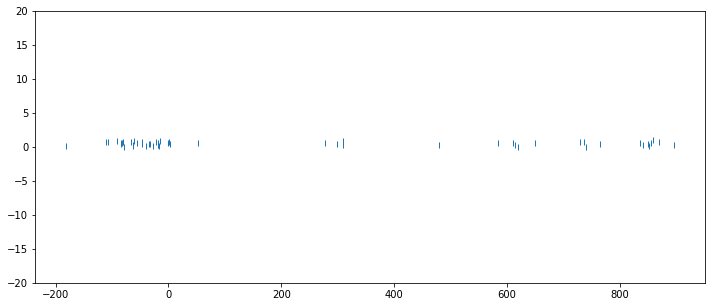

In [82]:
X=[]
for a,b,c,d in sorted(constr_pos['355APD']):
    print(a-position['355APD_0'],intName[b]-intName['355APD_0'])
    if a-position['355APD_0'] < 1000:
        X.append(a-position['355APD_0'])
    
plt.plot(X,np.random.random(len(X)),'|')
plt.ylim([-20,20])

In [78]:
np.random.random(X)

ValueError: sequence too large; cannot be greater than 32

In [376]:
intName = get_intName(position)

In [384]:
position['355APD_0']-position['36APD_0']-4931

-818.0

In [ ]:
2374APD_0 2414APD_0 226 5
520APD_0 2414APD_0 255 3
164APD_0 2414APD_0 2384 3


In [392]:
(intName['2374APD_0'],
 intName['2414APD_0'],
 intName['520APD_0'],
 intName['164APD_0'],
)

(1549, 1526, 1548, 1542)

In [375]:
(reps-repeats)

{'1360APD',
 '1554APD',
 '175APD',
 '2075APD',
 '2374APD',
 '2443APD',
 '2457APD',
 '346APD',
 '371APD',
 '40APD',
 '873APD'}

In [369]:
position['58APD_2']-position['58APD_1'],position['58APD_1']-position['58APD_0'],position['58APD_2']-position['58APD_0']

(8821.0, 62985.0, 71806.0)

In [26]:
def extrahiere_daten_0(gruppe):
    gruppe, counter, dist  = gruppe
    
    Repeat = coll.namedtuple('Repeat', ['pos', 'güte', 'güte_0'])

    anzahl = len(gruppe)
    güte = (anzahl-1)**2 * (max(counter.values())-1) * (len(dist) - 1) / (200+np.std(gruppe))
    return Repeat(
        pos = gruppe[anzahl//2], 
        güte = güte,
        güte_0 = anzahl**2 * (max(counter.values())-0.8) * (len(dist)-0.8) / (200+np.std(gruppe))
    )
def gruppierung_0(positionen, min_abstand, min_güte_0 = 0.0, min_güte = 100):
    
    sorted_pos = sorted(positionen) 
    # gruppiere sich stützende Daten
    previous = sorted_pos[0][0]
    current_group = [[],coll.Counter(),set()]
    groups = []
    gruppen_abstand = []
    for current, contig, direction in sorted_pos:
        if current - previous > min_abstand:
            groups.append(current_group)
            current_group = [[],coll.Counter(),set()]
        current_group[0].append(current)
        current_group[1][contig] += 1
        current_group[2].add(direction)
        previous = current
    groups.append(current_group)
    
    
    repeat_daten = [extrahiere_daten_0(g) for g in groups]
    repeat_daten.sort(key = lambda x: x.pos)
    
    return [gruppe for gruppe in repeat_daten if gruppe.güte_0 > 0.1]

In [27]:
intNameX['233APD_0'],intNameX['175APD_0'],intNameX['175APD_1'],intName['233APD_0'],intName['175APD_0']

NameError: name 'intName' is not defined

In [28]:
const_p = get_constr_pos(data5, pos)
for c in const_p:
    for g in gruppierung_0(constr_pos[c], 500):
        print(c, int(g.pos), round(g.güte_0,3), round(g.güte,3))

NameError: name 'data5' is not defined

In [71]:
for c in constr_pos:
    k = gruppierung_0(constr_pos[c], 500)
    if len(k) > len(contig_repeat[c]):
        for g in k:
            print(c, int(g.pos), round(g.güte_0,3), round(g.güte,3))
            
106APD 434916 0.149 0.0
501APD 1300363 4.987 0.0
501APD 1301551 0.873 0.0
25APD 4391470 0.333 0.0
236APD 4017417 0.107 0.0
302APD 4003964 0.2 0.0
457APD 3933771 0.146 0.0


106APD 434916 0.149 0.0
106APD 444593 2065.865 1675.46
501APD 1300363 4.987 0.0
501APD 1301551 0.873 0.0
501APD 1354187 2.309 1.549
501APD 1355114 2.563 1.76
501APD 1406789 0.244 0.13
25APD 4307613 1171.239 950.39
25APD 4391470 0.333 0.0
236APD 4016162 354.18 282.965
236APD 4017417 0.107 0.0
302APD 3940471 35.516 27.151
302APD 4003964 0.2 0.0
457APD 3933771 0.146 0.0
457APD 3997263 161.162 126.969


In [134]:
plot_graph(position, data, {c for r in repeats for c in contig_repeat[r]}, von = 1936, bis = 1949,kantenanzahl=4)

In [147]:
pos['175APD_1']-pos['175APD_0'] , 4510620-position['175APD_0']

(36315.0, 36082.430390282534)

In [146]:
intNameX[1770],intNameX[1773]

('233APD_0', '146APD_0')

In [149]:
for a,b,d in data:
    if a == '233APD_0' and b == '146APD_0':
        print(d)

3383.0


In [ ]:
dataX = [[a,b,d] for a,b,d in data if a != '175APD_0' and b != '175APD_0']

In [60]:
for i in range(430,440):
    print(intNameX[i])
print()
for i in range(488,500):
    print(intName[i])
for i in range(488,500):
    print(intName[i])

198APD_0
348APD_0
829APD_0
1525APD_0
1295APD_0
371APD_1
1016APD_0
1074APD_0
501APD_0
145APD_0

1874APD_0
1015APD_0
1813APD_0
2034APD_0
182APD_0
342APD_0
342APD_1
501APD_0
501APD_1
1742APD_0
316APD_0
131APD_0


In [48]:
pos['501APD_0'],pos['501APD_1'],position['501APD_0'],position['501APD_1'],position['501APD_2']

(1298463.0, 1353233.0, 1353971.0, 1354895.0, 1406580.0)

In [6]:
len(get_contigs(data))

2124

In [24]:
II = coll.defaultdict(list)
for line in open('apd5.lst'):
    a,b,d = line.split()
    d = float(d)
    if d > 50000:
        II[(a,b)].append(d)
        
for k,l in II.items():
    if len(l)>2:
        print(k,sorted(l))

('51APD', '1747APD') [54251.0, 54345.0, 55616.0]
('51APD', '1416APD') [55031.0, 55093.0, 56410.0]
('51APD', '1191APD') [56236.0, 56284.0, 57657.0]
('51APD', '1706APD') [57700.0, 57715.0, 59153.0]
('51APD', '1941APD') [58864.0, 58871.0, 60348.0]
('253APD', '1747APD') [53576.0, 53652.0, 54926.0]
('253APD', '1416APD') [54356.0, 54400.0, 55720.0]
('253APD', '1191APD') [55561.0, 55591.0, 56967.0]
('253APD', '1706APD') [57022.0, 57025.0, 58463.0]
('253APD', '1941APD') [58178.0, 58189.0, 59658.0]
('454APD', '1191APD') [51155.0, 51161.0, 52427.0]
('454APD', '1706APD') [52592.0, 52619.0, 53923.0]
('454APD', '1941APD') [53748.0, 53783.0, 55118.0]
('2338APD', '74APD') [60195.0, 61093.0, 73242.0]
('4APD', '74APD') [57948.0, 58794.0, 70943.0]


In [ ]:
('558APD', '419APD') [-65.0, -58.0, -65.0, -60.0, -65.0, -64.0, -64.0, -64.0, -64.0, -62.0, -64.0, -64.0, -64.0, -58.0, -63.0, -64.0, -64.0, -64.0, -64.0, -65.0, -64.0, -64.0, -62.6221323350818]
('1557APD', '1267APD') [-26.0, -26.0, -32.0, -26.0, -26.0, -29.0, -37.0, -29.0, -27.0, -25.0, -20.0, -25.0, -29.0, -29.0, -25.0, -26.0, -25.0, -25.0, -34.0, -26.0, -19.0, -28.0, -18.2009812986361]


In [21]:
II = coll.defaultdict(list)
for line in open('toContigs.bam.sorted.pairDistances.summary'):
    if (2283, 1849) == tuple(int(x[1:-3]) for x in line.split()[0].split('_')):
        print(line)
    if line.split()[1] != 'NA':
        II[tuple(int(x[1:-3]) for x in line.split()[0].split('_'))].append(tuple(x[0] for x in line.split()[0].split('_')))

-2283APD_+1849APD	NA	1	-210	615.384615384615

+2283APD_-1849APD	NA	1	-1422.30769230769	615.384615384615

+2283APD_+1849APD	-4244.85846854958	1433	-4252.51847204796	1.11529346159208

-2283APD_-1849APD	0.858468549580934	1433	13.2517774989544	1.11529346159208



In [14]:
max(pos.values())

4899601.0

In [77]:
feste_position = {'2345APD_0': 0, '1395APD_0': 6982.0, '1596APD_0': 9952.0, '2235APD_0': 14269.0, '1534APD_0': 14941.0, '546APD_0': 16511.0, '577APD_0': 19014.0, '998APD_0': 32313.0, '209APD_0': 34132.0, '1635APD_0': 43535.0, '2109APD_0': 45637.0, '996APD_0': 47657.0, '1481APD_0': 49144.0, '2113APD_0': 55767.0, '1332APD_0': 64494.0, '225APD_0': 68363.0, '1894APD_0': 77439.0, '521APD_0': 80995.0, '1076APD_0': 83301.0, '301APD_0': 86477.0, '50APD_0': 88528.0, '2396APD_0': 90554.9323053167, '1980APD_0': 92187.9323053167, '958APD_0': 93267.9323053167, '2050APD_0': 95081.9323053167, '1113APD_0': 99611.16150611905, '960APD_0': 101534.16150611905, '831APD_0': 103166.0, '1877APD_0': 106398.0, '1337APD_0': 107251.0, '59APD_0': 114474.9323053167, '542APD_0': 120932.9323053167, '1631APD_0': 124902.9323053167, '176APD_0': 126130.0, '567APD_0': 128337.9323053167, '776APD_0': 130202.9323053167, '86APD_0': 131491.16150611907, '1529APD_0': 138169.0, '1057APD_0': 138854.0, '1472APD_0': 141026.0, '1714APD_0': 142777.9323053167, '1400APD_0': 145988.0, '2058APD_0': 149580.16150611907, '943APD_0': 151240.0, '511APD_0': 151970.9323053167, '1698APD_0': 157366.0, '1903APD_0': 158556.9323053167, '2387APD_0': 164056.9323053167, '1317APD_0': 165654.9323053167, '1857APD_0': 183019.0, '931APD_0': 185975.0, '1375APD_0': 186830.0, '156APD_0': 187849.0, '19APD_0': 190568.9323053167, '1252APD_0': 193655.9323053167, '772APD_0': 194388.0, '896APD_0': 195101.9323053167, '2013APD_0': 196813.0, '2322APD_0': 199619.0, '439APD_0': 202543.9323053167, '948APD_0': 203489.0, '1151APD_0': 205933.9323053167, '1904APD_0': 212325.16150611907, '945APD_0': 214369.9323053167, '2085APD_0': 215023.9323053167, '1779APD_0': 218431.0167818591, '1363APD_0': 219604.0, '1380APD_0': 220389.0, '1921APD_0': 222788.16150611907, '1465APD_0': 224878.0, '876APD_0': 226088.0, '793APD_0': 227266.0, '1991APD_0': 229453.9323053167, '2003APD_0': 232875.9323053167, '1397APD_0': 233538.0, '885APD_0': 235105.0, '205APD_0': 235920.0, '1017APD_0': 239570.0, '277APD_0': 241603.0167818591, '444APD_0': 243329.0, '374APD_0': 244151.0167818591, '1866APD_0': 246176.0, '1514APD_0': 246999.0167818591, '2197APD_0': 251052.0, '2088APD_0': 252362.16150611907, '580APD_0': 254846.0, '506APD_0': 264011.0, '2458APD_0': 267844.0, '480APD_0': 268721.0, '1246APD_0': 271731.0, '1334APD_0': 272710.0, '466APD_0': 274608.0, '855APD_0': 278930.9323053167, '547APD_0': 279883.0, '318APD_0': 280245.0, '682APD_0': 282088.2346662088, '601APD_0': 282728.0, '1939APD_0': 286081.0, '789APD_0': 287110.0, '1930APD_0': 288485.02958898427, '1543APD_0': 289322.16150611907, '88APD_0': 291709.0, '1955APD_0': 295408.0, '2380APD_0': 297161.0, '1390APD_0': 298599.0, '638APD_0': 300652.0, '216APD_0': 302252.9323053167, '1701APD_0': 307529.9323053167, '684APD_0': 309029.8899950047, '2125APD_0': 310899.9323053167, '764APD_0': 311342.9323053167, '898APD_0': 312158.0, '1966APD_0': 313387.9323053167, '1621APD_0': 313981.0, '157APD_0': 314613.0, '2122APD_0': 322106.0, '1942APD_0': 324504.16150611907, '1586APD_0': 325187.9323053167, '1494APD_0': 326706.9323053167, '832APD_0': 327686.0, '1590APD_0': 328986.0, '1248APD_0': 330380.0, '1889APD_0': 331059.0, '1622APD_0': 331540.16150611907, '241APD_0': 332401.0, '235APD_0': 340630.0, '184APD_0': 343575.0, '2296APD_0': 344552.0, '593APD_0': 347359.0, '2021APD_0': 347952.0, '986APD_0': 352602.0, '850APD_0': 355611.0, '1986APD_0': 357012.0, '35APD_0': 358780.0, '1672APD_0': 363706.0, '1445APD_0': 365326.0, '1454APD_0': 367103.0, '921APD_0': 367424.0, '2032APD_0': 372182.0, '1981APD_0': 374655.0, '735APD_0': 376433.0, '740APD_0': 379498.0, '1850APD_0': 380887.0, '1967APD_0': 382780.0, '1675APD_0': 384590.473152517, '1169APD_0': 385234.0, '1268APD_0': 385986.0, '208APD_0': 387502.0, '2149APD_0': 389692.0, '276APD_0': 392176.0, '98APD_0': 399605.0, '874APD_0': 400819.0, '1137APD_0': 401970.0, '2071APD_0': 402724.0, '1077APD_0': 403656.0, '80APD_0': 404188.0, '2011APD_0': 404954.0, '379APD_0': 405566.0, '1024APD_0': 406019.0, '588APD_0': 407292.0, '939APD_0': 410839.0, '1433APD_0': 413623.0, '1647APD_0': 414037.0, '1467APD_0': 416897.0, '1192APD_0': 418252.0, '335APD_0': 419175.0, '2256APD_0': 420358.0, '1038APD_0': 421940.23829773226, '429APD_0': 423034.23829773226, '68APD_0': 426336.23829773226, '2390APD_0': 426790.23829773226, '1010APD_0': 429184.0, '680APD_0': 432401.0, '1185APD_0': 436204.0, '1199APD_0': 436836.0, '1574APD_0': 438671.23829773226, '989APD_0': 439790.0, '106APD_0': 443893.0, '2423APD_0': 451664.0, '2434APD_0': 452712.0, '2461APD_0': 454268.0, '1281APD_0': 456958.0, '202APD_0': 461086.0, '90APD_0': 462372.473152517, '2367APD_0': 467252.0, '1661APD_0': 471243.0, '569APD_0': 473697.0, '1309APD_0': 474252.473152517, '1665APD_0': 475212.0, '153APD_0': 477523.23829773226, '1816APD_0': 478302.0, '1330APD_0': 480585.0, '2335APD_0': 482507.0, '1751APD_0': 483573.0, '904APD_0': 487632.0, '548APD_0': 488540.0, '811APD_0': 492088.0, '2415APD_0': 493902.0, '2204APD_0': 494838.0, '196APD_0': 501205.0, '714APD_0': 504981.0, '31APD_0': 506999.0, '656APD_0': 513325.0, '1410APD_0': 522508.0, '1852APD_0': 526822.0, '151APD_0': 528818.0, '861APD_0': 542020.0, '187APD_0': 542707.0, '1162APD_0': 551982.0, '459APD_0': 552763.0, '57APD_0': 556966.0, '900APD_0': 557883.0, '766APD_0': 558723.0, '189APD_0': 559552.2382977323, '1815APD_0': 573220.0, '2205APD_0': 575383.0, '58APD_0': 580807.0, '599APD_0': 588925.0, '345APD_0': 593363.0, '1463APD_0': 604009.2382977323, '865APD_0': 605198.2382977323, '407APD_0': 610069.2382977323, '2394APD_0': 611819.2382977323, '462APD_0': 613570.2382977323, '1500APD_0': 614341.2382977323, '1APD_0': 615116.2382977323, '1245APD_0': 623603.2382977323, '1423APD_0': 624932.2382977323, '2420APD_0': 632416.2382977323, '1439APD_0': 635553.2382977323, '703APD_0': 638143.2382977323, '421APD_0': 658217.2382977323, '37APD_0': 666831.2382977323, '44APD_0': 668089.2382977323, '11APD_0': 674309.2382977323, '1783APD_0': 680909.2382977323, '69APD_0': 686494.2382977323, '1022APD_0': 687364.2382977323, '681APD_0': 692015.2382977323, '2110APD_0': 695000.2382977323, '1773APD_0': 698388.2382977323, '94APD_0': 702701.2382977323, '1721APD_0': 711151.2382977323, '2410APD_0': 715968.2382977323, '89APD_0': 722997.2382977323, '1366APD_0': 726734.2382977323, '1651APD_0': 727275.2382977323, '119APD_0': 733462.2382977323, '572APD_0': 743783.2382977323, '2155APD_0': 753799.2382977323, '708APD_0': 759510.0766310074, '1522APD_0': 761041.0766310074, '134APD_0': 762423.0766310074, '525APD_0': 765329.0766310074, '597APD_0': 768257.0766310074, '75APD_0': 776675.0766310074, '497APD_0': 788319.0766310074, '464APD_0': 789953.0766310074, '1474APD_0': 790704.0766310074, '565APD_0': 791637.0766310074, '653APD_0': 794547.0766310074, '391APD_0': 795158.0766310074, '1507APD_0': 807370.0766310074, '167APD_0': 807934.0766310074, '2337APD_0': 816330.0766310074, '385APD_0': 817439.0766310074, '307APD_0': 818885.0766310074, '1261APD_0': 829336.0766310074, '1691APD_0': 830651.509677197, '452APD_0': 831324.509677197, '781APD_0': 854408.509677197, '1753APD_0': 855410.509677197, '1523APD_0': 860820.509677197, '995APD_0': 866848.509677197, '2460APD_0': 871756.509677197, '1033APD_0': 873861.509677197, '568APD_0': 875303.509677197, '1970APD_0': 882183.509677197, '820APD_0': 889271.509677197, '77APD_0': 889993.509677197, '1258APD_0': 891631.509677197, '1265APD_0': 897209.509677197, '1253APD_0': 899628.509677197, '73APD_0': 903466.509677197, '1460APD_0': 912104.509677197, '376APD_0': 917482.509677197, '806APD_0': 932673.7778545924, '2250APD_0': 936708.7778545924, '3APD_0': 944904.6069821372, '573APD_0': 949058.6069821372, '48APD_0': 957960.6069821372, '1055APD_0': 963369.3104909246, '117APD_0': 968094.3104909246, '639APD_0': 976938.7385117481, '2211APD_0': 981654.7385117481, '802APD_0': 984160.7385117481, '2077APD_0': 991534.7385117481, '1177APD_0': 1005285.7385117481, '1679APD_0': 1009248.7385117481, '1073APD_0': 1010693.7385117481, '1249APD_0': 1031567.7385117481, '1506APD_0': 1034245.7385117481, '783APD_0': 1035515.7385117481, '609APD_0': 1042600.2396140165, '1335APD_0': 1054141.7385117481, '742APD_0': 1056408.7385117481, '1835APD_0': 1057288.7385117481, '1837APD_0': 1058359.7385117481, '367APD_0': 1061414.9869302353, '2038APD_0': 1064096.9869302353, '398APD_0': 1075523.9869302353, '2275APD_0': 1081823.9869302353, '877APD_0': 1083407.9869302353, '2351APD_0': 1084567.524259436, '543APD_0': 1087041.524259436, '551APD_0': 1089926.524259436, '62APD_0': 1099063.524259436, '1048APD_0': 1101164.524259436, '2019APD_0': 1103959.543550645, '399APD_0': 1104615.524259436, '232APD_0': 1105361.524259436, '1453APD_0': 1106271.524259436, '2412APD_0': 1109844.524259436, '1798APD_0': 1117879.524259436, '23APD_0': 1118663.524259436, '265APD_0': 1122172.524259436, '1063APD_0': 1122776.524259436, '1817APD_0': 1124614.9840092727, '2112APD_0': 1127916.9840092727, '1893APD_0': 1129071.0238666832, '2190APD_0': 1133304.0238666832, '1568APD_0': 1133799.0238666832, '337APD_0': 1134539.9840092727, '980APD_0': 1137458.0238666832, '623APD_0': 1138213.0238666832, '745APD_0': 1140201.9840092727, '351APD_0': 1141512.9840092727, '2015APD_0': 1146344.524259436, '2339APD_0': 1149338.0238666832, '670APD_0': 1150422.0238666832, '1054APD_0': 1151076.0238666832, '2426APD_0': 1151832.9840092727, '358APD_0': 1153636.0238666832, '195APD_0': 1157457.0238666832, '1878APD_0': 1162614.0238666832, '788APD_0': 1163669.0238666832, '2223APD_0': 1164575.0238666832, '1935APD_0': 1165060.0238666832, '1583APD_0': 1166299.0238666832, '1785APD_0': 1169714.4089970493, '1789APD_0': 1170301.0238666832, '596APD_0': 1171273.0623984544, '1097APD_0': 1171803.0238666832, '944APD_0': 1176194.0238666832, '1895APD_0': 1177652.0238666832, '1544APD_0': 1178786.0238666832, '2368APD_0': 1180067.0238666832, '2331APD_0': 1181570.0238666832, '414APD_0': 1182334.0238666832, '2247APD_0': 1183868.0238666832, '2173APD_0': 1185732.0238666832, '1730APD_0': 1186410.0238666832, '2142APD_0': 1187391.0238666832, '219APD_0': 1188841.0238666832, '1607APD_0': 1192157.0238666832, '12APD_0': 1195788.0238666832, '2459APD_0': 1196378.0238666832, '501APD_0': 1196772.0238666832, '1259APD_0': 1206769.0238666832, '1693APD_0': 1208525.0238666832, '909APD_0': 1208902.0238666832, '640APD_0': 1209895.0238666832, '1049APD_0': 1217014.0238666832, '1391APD_0': 1220414.0238666832, '1495APD_0': 1220940.0238666832, '1974APD_0': 1223001.0238666832, '1430APD_0': 1232235.0238666832, '326APD_0': 1233492.0238666832, '1379APD_0': 1233790.0238666832, '584APD_0': 1234577.0238666832, '1969APD_0': 1235030.0238666832, '1396APD_0': 1236300.0238666832, '2386APD_0': 1240106.0238666832, '2214APD_0': 1241899.0238666832, '919APD_0': 1246741.0238666832, '1769APD_0': 1247895.0238666832, '1952APD_0': 1259512.0238666832, '198APD_0': 1264981.0238666832, '348APD_0': 1269459.0238666832, '829APD_0': 1270629.0238666832, '1525APD_0': 1272194.0238666832, '1295APD_0': 1277888.0238666832, '371APD_0': 1278455.0238666832, '1016APD_0': 1284785.0238666832, '1074APD_0': 1292005.0238666832, '145APD_0': 1315541.0238666832, '440APD_0': 1321144.0238666832, '290APD_0': 1328348.0238666832, '1874APD_0': 1331523.0238666832, '1015APD_0': 1340671.0238666832, '1813APD_0': 1343046.0238666832, '1505APD_0': 1343671.0238666832, '2034APD_0': 1345203.0238666832, '182APD_0': 1346946.0238666832, '332APD_0': 1357928.0238666832, '1742APD_0': 1358216.0238666832, '316APD_0': 1359317.369214408, '131APD_0': 1363760.369214408, '1011APD_0': 1363905.369214408, '751APD_0': 1365310.369214408, '2324APD_0': 1366145.369214408, '84APD_0': 1366553.369214408, '14APD_0': 1373477.369214408, '970APD_0': 1381312.369214408, '342APD_0': 1382895.369214408, '271APD_0': 1385353.369214408, '132APD_0': 1393197.369214408, '279APD_0': 1398014.7182576736, '737APD_0': 1403887.7182576736, '211APD_0': 1405167.7182576736, '2195APD_0': 1409297.7182576736, '18APD_0': 1410982.7182576736, '477APD_0': 1418966.7182576736, '113APD_0': 1418993.7182576736, '40APD_0': 1429462.7182576736, '2066APD_0': 1441869.7182576736, '1285APD_0': 1443455.7182576736, '483APD_0': 1444532.7182576736, '2043APD_0': 1450151.7182576736, '300APD_0': 1452435.7182576736, '64APD_0': 1452873.7182576736, '1208APD_0': 1456196.7182576736, '658APD_0': 1457200.7182576736, '1510APD_0': 1458102.7182576736, '1114APD_0': 1460300.7182576736, '2278APD_0': 1463197.7182576736, '1948APD_0': 1491153.7182576736, '1822APD_0': 1492372.7182576736, '494APD_0': 1496221.5314285422, '2455APD_0': 1497723.5314285422, '2399APD_0': 1501679.5314285422, '1572APD_0': 1502815.5314285422, '999APD_0': 1504320.5314285422, '2141APD_0': 1506354.5314285422, '485APD_0': 1507068.5314285422, '484APD_0': 1518077.5314285422, '51APD_0': 1524929.5314285422, '253APD_0': 1527112.8130824585, '454APD_0': 1527807.5314285422, '2391APD_0': 1532212.5314285422, '994APD_0': 1538153.5314285422, '361APD_0': 1539649.5314285422, '1599APD_0': 1546926.5314285422, '2046APD_0': 1550002.014474229, '891APD_0': 1550808.5314285422, '555APD_0': 1551117.5314285422, '1412APD_0': 1561298.5314285422, '1922APD_0': 1561736.5314285422, '1750APD_0': 1563498.5314285422, '903APD_0': 1567811.5314285422, '724APD_0': 1569813.5314285422, '1276APD_0': 1570241.5314285422, '1634APD_0': 1571365.5314285422, '2102APD_0': 1574074.5314285422, '1747APD_0': 1581549.5314285422, '1416APD_0': 1582316.5314285422, '1191APD_0': 1583509.5314285422, '1706APD_0': 1584954.5314285422, '1941APD_0': 1586118.5314285422, '2172APD_0': 1589955.5314285422, '2004APD_0': 1591677.5314285422, '210APD_0': 1595605.5314285422, '2370APD_0': 1597981.5314285422, '273APD_0': 1598742.5314285422, '894APD_0': 1607854.5314285422, '1908APD_0': 1609867.5314285422, '1749APD_0': 1612703.5314285422, '559APD_0': 1613989.5314285422, '1441APD_0': 1618013.5314285422, '350APD_0': 1619774.2862152983, '1240APD_0': 1624161.5314285422, '2287APD_0': 1627953.5314285422, '1368APD_0': 1632134.5314285422, '381APD_0': 1636696.2862152983, '1181APD_0': 1646248.5314285422, '768APD_0': 1649171.5314285422, '2073APD_0': 1650243.5314285422, '722APD_0': 1652672.4096520562, '441APD_0': 1654792.5314285422, '1386APD_0': 1657156.5314285422, '955APD_0': 1658211.5314285422, '1812APD_0': 1660698.5314285422, '2269APD_0': 1662383.2862152983, '1002APD_0': 1665505.5314285422, '1195APD_0': 1667282.5314285422, '2039APD_0': 1673734.5314285422, '1473APD_0': 1675924.5314285422, '1003APD_0': 1677133.5314285422, '964APD_0': 1677869.5314285422, '902APD_0': 1678866.5314285422, '1440APD_0': 1682982.5314285422, '1406APD_0': 1684275.5314285422, '1880APD_0': 1686998.5314285422, '859APD_0': 1689967.5314285422, '2020APD_0': 1691811.5314285422, '610APD_0': 1695043.5314285422, '1035APD_0': 1696247.5314285422, '975APD_0': 1697380.5314285422, '1491APD_0': 1699225.5314285422, '2159APD_0': 1701062.5314285422, '1689APD_0': 1706709.5314285422, '1417APD_0': 1709036.5314285422, '755APD_0': 1709920.5314285422, '1415APD_0': 1711052.5314285422, '1223APD_0': 1714607.5314285422, '1823APD_0': 1717875.5314285422, '2286APD_0': 1719567.5314285422, '564APD_0': 1721994.5314285422, '1346APD_0': 1725143.5314285422, '384APD_0': 1742586.5314285422, '240APD_0': 1746515.5314285422, '2212APD_0': 1753493.5314285422, '549APD_0': 1760751.5314285422, '777APD_0': 1766395.5314285422, '1006APD_0': 1767002.5314285422, '1978APD_0': 1769598.5314285422, '2037APD_0': 1771842.5314285422, '2182APD_0': 1777768.5314285422, '2395APD_0': 1780030.5314285422, '380APD_0': 1782958.5314285422, '510APD_0': 1784733.5314285422, '2349APD_0': 1785333.5314285422, '147APD_0': 1792756.5314285422, '2323APD_0': 1797041.5314285422, '357APD_0': 1801139.5314285422, '1644APD_0': 1803140.5314285422, '1968APD_0': 1805176.5314285422, '676APD_0': 1807244.5314285422, '1030APD_0': 1813027.5314285422, '1354APD_0': 1815060.5314285422, '2157APD_0': 1819596.5314285422, '1977APD_0': 1821951.5314285422, '2056APD_0': 1825356.5314285422, '2148APD_0': 1828092.5314285422, '1451APD_0': 1828905.206260193, '280APD_0': 1829932.206260193, '1799APD_0': 1834814.206260193, '743APD_0': 1838149.5314285422, '878APD_0': 1838997.206260193, '1809APD_0': 1840124.5314285422, '1752APD_0': 1844970.5314285422, '1744APD_0': 1847337.5314285422, '1150APD_0': 1850008.5314285422, '2297APD_0': 1851716.5314285422, '2000APD_0': 1854339.5314285422, '1503APD_0': 1856270.5314285422, '476APD_0': 1857877.5314285422, '1405APD_0': 1873833.5314285422, '523APD_0': 1875971.5314285422, '394APD_0': 1894311.5314285422, '178APD_0': 1896977.5314285422, '498APD_0': 1898244.5314285422, '251APD_0': 1906720.5314285422, '2083APD_0': 1910207.5314285422, '1389APD_0': 1911599.5314285422, '1358APD_0': 1913563.5314285422, '2413APD_0': 1917630.5314285422, '779APD_0': 1918390.4116226004, '325APD_0': 1918943.5314285422, '927APD_0': 1930234.5314285422, '365APD_0': 1932838.5314285422, '1704APD_0': 1946217.5314285422, '2118APD_0': 1947393.82415232, '408APD_0': 1949721.82415232, '936APD_0': 1950279.82415232, '311APD_0': 1950791.5314285422, '1155APD_0': 1957010.5314285422, '1369APD_0': 1958828.5314285422, '1851APD_0': 1960731.5314285422, '1547APD_0': 1963595.5314285422, '1428APD_0': 1965332.5314285422, '892APD_0': 1968404.5314285422, '148APD_0': 1971529.5314285422, '2044APD_0': 1972787.5314285422, '827APD_0': 1975410.5314285422, '2227APD_0': 1976510.5314285422, '2429APD_0': 1977313.5314285422, '982APD_0': 1978786.5314285422, '2051APD_0': 1979985.5314285422, '835APD_0': 1980500.5314285422, '1404APD_0': 1982641.5314285422, '738APD_0': 1985396.5314285422, '1552APD_0': 1986107.5314285422, '727APD_0': 1988950.5314285422, '631APD_0': 1989961.5314285422, '748APD_0': 1992904.5314285422, '1347APD_0': 1994403.5314285422, '217APD_0': 1996310.5314285422, '527APD_0': 2001059.5314285422, '529APD_0': 2001913.5314285422, '1946APD_0': 2004566.5314285422, '1104APD_0': 2005257.5314285422, '759APD_0': 2006004.5314285422, '188APD_0': 2008473.5314285422, '1825APD_0': 2009511.5314285422, '320APD_0': 2010225.5314285422, '1860APD_0': 2012693.5314285422, '1926APD_0': 2013108.5314285422, '2398APD_0': 2013882.5314285422, '125APD_0': 2022790.5314285422, '1711APD_0': 2029238.5314285422, '1845APD_0': 2032731.8534698505, '1928APD_0': 2034733.8534698505, '2187APD_0': 2036564.5314285422, '1733APD_0': 2038196.5314285422, '1176APD_0': 2039363.5314285422, '55APD_0': 2040551.5314285422, '1157APD_0': 2042015.5314285422, '716APD_0': 2046966.5314285422, '1570APD_0': 2048178.5314285422, '6APD_0': 2049078.5314285422, '1436APD_0': 2051779.5314285422, '2326APD_0': 2052257.5314285422, '1535APD_0': 2053109.8534698505, '1143APD_0': 2053800.8534698505, '1408APD_0': 2054784.5314285422, '2379APD_0': 2059986.5314285422, '463APD_0': 2060598.5314285422, '1140APD_0': 2062309.8534698505, '347APD_0': 2066239.5314285422, '1283APD_0': 2066739.5314285422, '1649APD_0': 2068169.5314285422, '1413APD_0': 2069400.5314285422, '2099APD_0': 2070673.5314285422, '2409APD_0': 2072026.5314285422, '1103APD_0': 2072696.4829437663, '1088APD_0': 2073087.5314285422, '1036APD_0': 2078405.5314285422, '2255APD_0': 2080499.5314285422, '1485APD_0': 2080817.5314285422, '1819APD_0': 2086800.5314285422, '1456APD_0': 2087720.5314285422, '285APD_0': 2090724.5314285422, '2369APD_0': 2093385.5314285422, '1827APD_0': 2095206.5314285422, '2108APD_0': 2095955.5314285422, '2293APD_0': 2096399.5314285422, '168APD_0': 2098700.531428542, '545APD_0': 2101529.531428542, '1937APD_0': 2101852.531428542, '2359APD_0': 2103520.531428542, '1393APD_0': 2104850.531428542, '356APD_0': 2105484.531428542, '1385APD_0': 2107232.531428542, '2APD_0': 2108087.531428542, '1321APD_0': 2109848.002978301, '109APD_0': 2110162.531428542, '2145APD_0': 2111026.531428542, '1776APD_0': 2111939.531428542, '1717APD_0': 2112561.531428542, '1886APD_0': 2113527.531428542, '2203APD_0': 2114061.531428542, '1458APD_0': 2115262.002978301, '1457APD_0': 2117053.531428542, '1746APD_0': 2117608.531428542, '946APD_0': 2119803.531428542, '1549APD_0': 2121067.531428542, '1351APD_0': 2122762.531428542, '988APD_0': 2123274.6736311223, '518APD_0': 2123864.6736311223, '1164APD_0': 2124586.6736311223, '1132APD_0': 2129669.531428542, '882APD_0': 2130885.531428542, '778APD_0': 2133206.6736311223, '1696APD_0': 2136044.531428542, '675APD_0': 2136795.6736311223, '590APD_0': 2139885.6736311223, '1197APD_0': 2142051.531428542, '1756APD_0': 2146387.6736311223, '990APD_0': 2146990.531428542, '683APD_0': 2147780.531428542, '191APD_0': 2150626.6736311223, '785APD_0': 2151715.6736311223, '1479APD_0': 2153310.531428542, '813APD_0': 2153971.6736311223, '519APD_0': 2156337.531428542, '1031APD_0': 2156961.6736311223, '884APD_0': 2159381.531428542, '1723APD_0': 2164313.6736311223, '1515APD_0': 2165278.531428542, '2305APD_0': 2166144.531428542, '797APD_0': 2167537.6736311223, '1231APD_0': 2168126.531428542, '2009APD_0': 2169472.6736311223, '1524APD_0': 2170262.531428542, '1084APD_0': 2171814.531428542, '1272APD_0': 2173460.531428542, '104APD_0': 2174330.531428542, '1826APD_0': 2177729.531428542, '1301APD_0': 2178672.531428542, '478APD_0': 2180877.531428542, '340APD_0': 2186446.531428542, '2277APD_0': 2188152.531428542, '315APD_0': 2190997.531428542, '1528APD_0': 2193726.531428542, '2404APD_0': 2198756.531428542, '1356APD_0': 2200352.458615996, '2193APD_0': 2200954.3257299787, '1499APD_0': 2203366.3257299787, '1090APD_0': 2204219.531428542, '1957APD_0': 2206137.531428542, '1210APD_0': 2207264.531428542, '1443APD_0': 2207747.06174536, '314APD_0': 2208335.06174536, '1867APD_0': 2211146.06174536, '1101APD_0': 2212627.06174536, '1117APD_0': 2214541.06174536, '1862APD_0': 2216565.06174536, '79APD_0': 2218444.06174536, '1025APD_0': 2225807.531428542, '1487APD_0': 2226485.531428542, '101APD_0': 2227556.531428542, '389APD_0': 2229042.531428542, '93APD_0': 2231679.531428542, '403APD_0': 2235203.531428542, '920APD_0': 2239732.531428542, '857APD_0': 2243571.531428542, '1179APD_0': 2245437.531428542, '1149APD_0': 2246937.531428542, '70APD_0': 2248049.531428542, '61APD_0': 2252676.531428542, '2435APD_0': 2255997.531428542, '1600APD_0': 2256690.531428542, '1242APD_0': 2257558.531428542, '1578APD_0': 2258147.531428542, '1314APD_0': 2259258.531428542, '856APD_0': 2259908.531428542, '1189APD_0': 2261187.531428542, '359APD_0': 2266218.531428542, '1227APD_0': 2269688.531428542, '1720APD_0': 2274681.531428542, '1323APD_0': 2278463.531428542, '846APD_0': 2282199.531428542, '492APD_0': 2283391.531428542, '226APD_0': 2284806.531428542, '1213APD_0': 2287091.531428542, '1876APD_0': 2288450.531428542, '624APD_0': 2292762.531428542, '2103APD_0': 2295015.358430599, '2140APD_0': 2296085.358430599, '1085APD_0': 2296866.531428542, '1007APD_0': 2298010.358430599, '185APD_0': 2299492.358430599, '1842APD_0': 2302435.531428542, '1275APD_0': 2303680.531428542, '2153APD_0': 2304372.531428542, '312APD_0': 2305488.531428542, '752APD_0': 2307467.531428542, '2209APD_0': 2309820.531428542, '1520APD_0': 2310511.531428542, '2081APD_0': 2311619.531428542, '1605APD_0': 2313754.531428542, '536APD_0': 2316180.531428542, '1551APD_0': 2317687.531428542, '608APD_0': 2318170.010256245, '2346APD_0': 2318759.010256245, '668APD_0': 2324665.010256245, '1645APD_0': 2325355.010256245, '286APD_0': 2330033.010256245, '814APD_0': 2336957.010256245, '138APD_0': 2338100.010256245, '1148APD_0': 2341433.010256245, '1641APD_0': 2343655.010256245, '38APD_0': 2345887.04885921, '880APD_0': 2351142.010256245, '177APD_0': 2353867.010256245, '2316APD_0': 2355761.010256245, '1498APD_0': 2360524.010256245, '224APD_0': 2362479.010256245, '976APD_0': 2368260.010256245, '1954APD_0': 2373006.010256245, '1341APD_0': 2374430.010256245, '2052APD_0': 2375058.010256245, '1770APD_0': 2376441.010256245, '1289APD_0': 2377210.010256245, '739APD_0': 2377933.010256245, '1975APD_0': 2378416.010256245, '1247APD_0': 2385201.010256245, '950APD_0': 2387293.010256245, '809APD_0': 2398080.010256245, '1655APD_0': 2398866.010256245, '2279APD_0': 2400433.010256245, '2040APD_0': 2403406.010256245, '1965APD_0': 2404521.010256245, '2131APD_0': 2406830.010256245, '1122APD_0': 2410254.010256245, '602APD_0': 2412225.010256245, '1280APD_0': 2414612.010256245, '475APD_0': 2416239.010256245, '2230APD_0': 2420144.010256245, '436APD_0': 2420792.618639554, '1262APD_0': 2421225.758403923, '873APD_0': 2421860.758403923, '774APD_0': 2424669.758403923, '1538APD_0': 2426840.859372155, '556APD_0': 2430122.859372155, '2406APD_0': 2431625.859372155, '1671APD_0': 2433929.859372155, '1938APD_0': 2434325.859372155, '524APD_0': 2438791.859372155, '1767APD_0': 2445279.859372155, '193APD_0': 2447515.859372155, '227APD_0': 2451980.859372155, '528APD_0': 2459678.859372155, '1079APD_0': 2462665.859372155, '126APD_0': 2463480.859372155, '368APD_0': 2464354.859372155, '1836APD_0': 2465666.859372155, '431APD_0': 2468958.859372155, '2237APD_0': 2476097.9336795155, '1102APD_0': 2479476.9336795155, '566APD_0': 2481813.859372155, '756APD_0': 2484324.859372155, '1919APD_0': 2487282.859372155, '1421APD_0': 2491603.859372155, '1814APD_0': 2492601.859372155, '1383APD_0': 2494318.5249846797, '2062APD_0': 2496028.859372155, '2290APD_0': 2500836.859372155, '973APD_0': 2501635.859372155, '2023APD_0': 2506532.466780926, '1843APD_0': 2506883.466780926, '604APD_0': 2507651.466780926, '1099APD_0': 2511366.466780926, '2055APD_0': 2512981.466780926, '1871APD_0': 2516296.466780926, '826APD_0': 2517880.859372155, '1732APD_0': 2522464.466780926, '1172APD_0': 2523609.466780926, '2192APD_0': 2524921.3390496876, '1971APD_0': 2526379.3390496876, '2219APD_0': 2528798.466780926, '1348APD_0': 2532689.466780926, '170APD_0': 2533376.466780926, '461APD_0': 2537288.466780926, '2432APD_0': 2538772.466780926, '127APD_0': 2540192.466780926, '2189APD_0': 2540880.466780926, '1532APD_0': 2541699.466780926, '1979APD_0': 2546977.466780926, '578APD_0': 2548582.466780926, '121APD_0': 2550616.6353011206, '2327APD_0': 2551018.466780926, '1066APD_0': 2551518.3390496876, '1226APD_0': 2554660.466780926, '1091APD_0': 2555563.3390496876, '2184APD_0': 2556848.466780926, '1563APD_0': 2562612.3390496876, '910APD_0': 2566238.3390496876, '929APD_0': 2568957.466780926, '1361APD_0': 2570857.3390496876, '1993APD_0': 2575081.3390496876, '2315APD_0': 2578644.3390496876, '616APD_0': 2579916.3390496876, '102APD_0': 2582426.3390496876, '287APD_0': 2588089.3390496876, '1204APD_0': 2591998.3390496876, '1273APD_0': 2594317.3390496876, '2454APD_0': 2598098.3390496876, '1902APD_0': 2600934.3390496876, '130APD_0': 2603395.3390496876, '1205APD_0': 2603969.3390496876, '1159APD_0': 2604700.3390496876, '1349APD_0': 2606102.3390496876, '619APD_0': 2609435.3390496876, '1669APD_0': 2611391.3390496876, '1620APD_0': 2613654.3390496876, '360APD_0': 2614520.3390496876, '1708APD_0': 2621372.3390496876, '2330APD_0': 2622127.3390496876, '313APD_0': 2625257.3390496876, '1037APD_0': 2628555.3390496876, '1562APD_0': 2631074.3390496876, '2226APD_0': 2634091.3390496876, '141APD_0': 2639565.3390496876, '2438APD_0': 2641152.3390496876, '1373APD_0': 2643583.3390496876, '63APD_0': 2644798.3390496876, '2320APD_0': 2649962.3390496876, '888APD_0': 2652713.3390496876, '917APD_0': 2654667.3390496876, '1225APD_0': 2655352.3390496876, '1142APD_0': 2658017.3390496876, '824APD_0': 2660007.3390496876, '2202APD_0': 2661198.3390496876, '274APD_0': 2662711.3390496876, '1021APD_0': 2663580.5338916057, '526APD_0': 2664110.2886260333, '1290APD_0': 2664859.8532682345, '1685APD_0': 2665632.657245382, '522APD_0': 2668828.657245382, '2174APD_0': 2671481.657245382, '1804APD_0': 2672227.657245382, '2259APD_0': 2674590.716189146, '1582APD_0': 2677142.716189146, '844APD_0': 2678972.657245382, '922APD_0': 2679832.657245382, '2342APD_0': 2680591.657245382, '795APD_0': 2682725.657245382, '1830APD_0': 2683573.716189146, '1536APD_0': 2686342.657245382, '2225APD_0': 2688378.657245382, '2036APD_0': 2689820.657245382, '2340APD_0': 2691530.657245382, '834APD_0': 2692068.657245382, '563APD_0': 2694385.657245382, '1699APD_0': 2694755.657245382, '1748APD_0': 2696511.657245382, '1475APD_0': 2698098.657245382, '2200APD_0': 2699407.657245382, '405APD_0': 2701129.657245382, '1125APD_0': 2702698.657245382, '1617APD_0': 2712674.657245382, '1220APD_0': 2713811.657245382, '862APD_0': 2714284.657245382, '1640APD_0': 2720307.657245382, '504APD_0': 2720979.657245382, '49APD_0': 2727127.359840935, '116APD_0': 2737539.359840935, '150APD_0': 2737592.359840935, '2236APD_0': 2739300.359840935, '1224APD_0': 2739800.359840935, '2123APD_0': 2739873.359840935, '799APD_0': 2740390.359840935, '1800APD_0': 2742574.8247637777, '736APD_0': 2743080.891897501, '230APD_0': 2743667.3849714817, '432APD_0': 2745099.3849714817, '1923APD_0': 2752533.3849714817, '2169APD_0': 2753006.3531530458, '1420APD_0': 2756476.3531530458, '1657APD_0': 2758125.3531530458, '849APD_0': 2762321.3531530458, '1471APD_0': 2773821.3531530458, '618APD_0': 2778642.3531530458, '303APD_0': 2779190.3531530458, '15APD_0': 2781904.3531530458, '2210APD_0': 2785929.3531530458, '430APD_0': 2788685.3531530458, '319APD_0': 2800630.3531530458, '1612APD_0': 2803593.3531530458, '853APD_0': 2816901.3531530458, '1160APD_0': 2817143.3531530458, '428APD_0': 2819959.3531530458, '1818APD_0': 2820702.3531530458, '544APD_0': 2821283.3531530458, '1449APD_0': 2821799.3531530458, '2301APD_0': 2822339.3531530458, '2048APD_0': 2824613.3531530458, '672APD_0': 2831730.3531530458, '2091APD_0': 2840176.3531530458, '633APD_0': 2846366.3531530458, '650APD_0': 2847807.3531530458, '221APD_0': 2850008.3531530458, '53APD_0': 2850326.3531530458, '72APD_0': 2851200.3531530458, '445APD_0': 2851211.3531530458, '2178APD_0': 2852450.3531530458, '1959APD_0': 2853313.3531530458, '291APD_0': 2854667.3531530458, '346APD_0': 2855913.3531530458, '220APD_0': 2857410.3531530458, '744APD_0': 2860893.3531530458, '1211APD_0': 2861241.3531530458, '576APD_0': 2862055.3531530458, '369APD_0': 2862541.3531530458, '1064APD_0': 2864478.3531530458, '816APD_0': 2864971.5896890964, '411APD_0': 2865255.599981639, '465APD_0': 2865813.599981639, '159APD_0': 2869767.599981639, '2007APD_0': 2876422.599981639, '2243APD_0': 2878714.599981639, '78APD_0': 2879270.599981639, '655APD_0': 2879909.8921388504, '1427APD_0': 2886107.8921388504, '1316APD_0': 2898771.599981639, '2086APD_0': 2902124.646998983, '1338APD_0': 2903141.599981639, '1611APD_0': 2903762.599981639, '142APD_0': 2907872.599981639, '1448APD_0': 2918145.646998983, '1945APD_0': 2919329.646998983, '390APD_0': 2921607.036299473, '258APD_0': 2932419.599981639, '1885APD_0': 2942964.599981639, '1279APD_0': 2944340.599981639, '422APD_0': 2960591.599981639, '20APD_0': 2964844.599981639, '1296APD_0': 2972644.599981639, '143APD_0': 2974740.599981639, '887APD_0': 2977544.599981639, '249APD_0': 2978947.599981639, '2341APD_0': 2982572.599981639, '257APD_0': 2984477.8921388504, '246APD_0': 2985353.8921388504, '201APD_0': 2985885.599981639, '1924APD_0': 2988603.599981639, '531APD_0': 2989893.646998983, '2422APD_0': 2990854.599981639, '2384APD_0': 2991927.646998983, '1762APD_0': 2993460.646998983, '136APD_0': 3001159.599981639, '1202APD_0': 3004872.599981639, '983APD_0': 3010681.599981639, '1278APD_0': 3013514.646998983, '1116APD_0': 3016387.599981639, '1201APD_0': 3017585.646998983, '67APD_0': 3018485.599981639, '1264APD_0': 3022147.646998983, '1754APD_0': 3023328.002491878, '2428APD_0': 3025187.002491878, '1043APD_0': 3028113.8921388504, '1803APD_0': 3030225.646998983, '1909APD_0': 3031500.599981639, '733APD_0': 3033568.599981639, '1128APD_0': 3042860.599981639, '821APD_0': 3044142.036299473, '1960APD_0': 3045188.036299473, '36APD_0': 3048765.646998983, '1434APD_0': 3052661.599981639, '355APD_0': 3053683.036299473, '2360APD_0': 3054476.8921388504, '133APD_0': 3055560.036299473, '1545APD_0': 3056828.599981639, '1327APD_0': 3058557.036299473, '600APD_0': 3059565.036299473, '972APD_0': 3060479.036299473, '1927APD_0': 3060763.599981639, '2098APD_0': 3061744.599981639, '2082APD_0': 3062432.599981639, '622APD_0': 3063716.13312504, '1602APD_0': 3064529.599981639, '1736APD_0': 3065564.646998983, '328APD_0': 3066240.599981639, '598APD_0': 3066682.599981639, '2168APD_0': 3068642.599981639, '2267APD_0': 3069077.599981639, '1805APD_0': 3071127.599981639, '1221APD_0': 3072788.599981639, '1394APD_0': 3073499.599981639, '1239APD_0': 3077016.8921388504, '363APD_0': 3077395.599981639, '692APD_0': 3077986.599981639, '652APD_0': 3078389.719620163, '2318APD_0': 3078702.599981639, '792APD_0': 3080780.599981639, '1051APD_0': 3082570.599981639, '1915APD_0': 3084089.646998983, '895APD_0': 3085843.646998983, '1333APD_0': 3088953.599981639, '343APD_0': 3091105.599981639, '1759APD_0': 3096951.599981639, '697APD_0': 3098085.599981639, '1112APD_0': 3101574.599981639, '1198APD_0': 3102892.599981639, '1796APD_0': 3105935.599981639, '282APD_0': 3107152.599981639, '2416APD_0': 3109777.599981639, '1336APD_0': 3111481.599981639, '2163APD_0': 3113368.599981639, '2053APD_0': 3116255.599981639, '1917APD_0': 3117908.599981639, '605APD_0': 3119889.599981639, '1682APD_0': 3122285.599981639, '2047APD_0': 3125302.599981639, '336APD_0': 3129144.599981639, '2436APD_0': 3132877.599981639, '540APD_0': 3133681.599981639, '1042APD_0': 3137909.599981639, '702APD_0': 3139991.599981639, '966APD_0': 3141798.599981639, '842APD_0': 3143304.599981639, '1565APD_0': 3144364.599981639, '415APD_0': 3150547.599981639, '1891APD_0': 3157154.599981639, '1342APD_0': 3158149.599981639, '1614APD_0': 3158856.599981639, '283APD_0': 3159452.599981639, '21APD_0': 3162900.599981639, '2449APD_0': 3163734.599981639, '1546APD_0': 3164977.599981639, '1209APD_0': 3167925.599981639, '1303APD_0': 3170492.599981639, '1131APD_0': 3171808.599981639, '1492APD_0': 3172388.599981639, '1444APD_0': 3174605.599981639, '1910APD_0': 3175900.014494519, '2262APD_0': 3183910.599981639, '1556APD_0': 3187021.599981639, '1442APD_0': 3188805.599981639, '1217APD_0': 3189842.599981639, '2152APD_0': 3191661.599981639, '2452APD_0': 3194362.599981639, '2217APD_0': 3195941.014494519, '1755APD_0': 3197632.599981639, '333APD_0': 3198394.599981639, '763APD_0': 3200208.599981639, '754APD_0': 3203538.599981639, '981APD_0': 3204524.599981639, '1998APD_0': 3207363.599981639, '1722APD_0': 3207939.599981639, '1588APD_0': 3210031.532099344, '2338APD_0': 3211107.599981639, '704APD_0': 3212568.599981639, '4APD_0': 3213159.599981639, '140APD_0': 3214436.599981639, '1305APD_0': 3226537.599981639, '686APD_0': 3227222.599981639, '296APD_0': 3228963.599981639, '1623APD_0': 3229400.599981639, '1446APD_0': 3230920.599981639, '2027APD_0': 3232430.599981639, '2421APD_0': 3235281.599981639, '124APD_0': 3237997.599981639, '1890APD_0': 3241896.599981639, '848APD_0': 3244442.599981639, '386APD_0': 3246245.599981639, '1912APD_0': 3248216.599981639, '263APD_0': 3248675.599981639, '181APD_0': 3251564.599981639, '1230APD_0': 3252075.599981639, '1173APD_0': 3253843.599981639, '2362APD_0': 3254676.599981639, '1865APD_0': 3255958.599981639, '1687APD_0': 3256624.599981639, '1739APD_0': 3257527.599981639, '932APD_0': 3259018.599981639, '2006APD_0': 3261398.599981639, '611APD_0': 3262636.599981639, '1072APD_0': 3263143.599981639, '1709APD_0': 3265363.599981639, '732APD_0': 3266390.599981639, '243APD_0': 3267289.599981639, '28APD_0': 3269928.599981639, '1034APD_0': 3272856.599981639, '74APD_0': 3273465.599981639, '487APD_0': 3274509.599981639, '2104APD_0': 3277461.599981639, '2325APD_0': 3278346.599981639, '2310APD_0': 3279318.599981639, '317APD_0': 3279819.599981639, '1183APD_0': 3282255.599981639, '2357APD_0': 3282732.599981639, '1872APD_0': 3283406.599981639, '392APD_0': 3286731.599981639, '1196APD_0': 3288603.599981639, '2150APD_0': 3289813.599981639, '1286APD_0': 3290327.599981639, '1452APD_0': 3291129.599981639, '289APD_0': 3291509.599981639, '626APD_0': 3293505.599981639, '1392APD_0': 3296476.599981639, '1964APD_0': 3298047.599981639, '798APD_0': 3299935.599981639, '2427APD_0': 3300801.599981639, '2271APD_0': 3301381.599981639, '782APD_0': 3302596.599981639, '534APD_0': 3305039.599981639, '550APD_0': 3306552.599981639, '231APD_0': 3307350.599981639, '539APD_0': 3308599.599981639, '1462APD_0': 3309538.599981639, '1683APD_0': 3312802.599981639, '1089APD_0': 3313441.599981639, '1616APD_0': 3314489.599981639, '30APD_0': 3315346.599981639, '456APD_0': 3316093.599981639, '2274APD_0': 3321519.599981639, '2238APD_0': 3322037.599981639, '1581APD_0': 3324324.599981639, '2139APD_0': 3325206.599981639, '949APD_0': 3327349.599981639, '1724APD_0': 3330170.599981639, '2268APD_0': 3330892.599981639, '2005APD_0': 3331395.599981639, '144APD_0': 3336349.599981639, '174APD_0': 3339767.599981639, '930APD_0': 3342470.599981639, '1178APD_0': 3343334.599981639, '513APD_0': 3347496.8821616448, '203APD_0': 3348169.599981639, '1190APD_0': 3350715.599981639, '2176APD_0': 3351368.599981639, '1120APD_0': 3352604.599981639, '2165APD_0': 3354852.599981639, '66APD_0': 3355851.599981639, '517APD_0': 3359539.599981639, '1662APD_0': 3364219.782576262, '354APD_0': 3364677.193713262, '796APD_0': 3365227.4497246174, '710APD_0': 3365737.4497246174, '804APD_0': 3366703.4497246174, '402APD_0': 3367422.4497246174, '2447APD_0': 3369006.4497246174, '45APD_0': 3370111.4497246174, '1999APD_0': 3371024.4497246174, '1419APD_0': 3371859.4497246174, '557APD_0': 3374346.4497246174, '252APD_0': 3376159.4497246174, '2101APD_0': 3380637.4497246174, '1690APD_0': 3383623.4497246174, '2371APD_0': 3386712.4497246174, '1214APD_0': 3387059.4497246174, '647APD_0': 3389386.4497246174, '815APD_0': 3393274.4497246174, '691APD_0': 3393929.4497246174, '1790APD_0': 3394461.4497246174, '2115APD_0': 3395223.4497246174, '967APD_0': 3396221.4497246174, '2078APD_0': 3398810.4497246174, '499APD_0': 3412476.4497246174, '901APD_0': 3422635.4497246174, '1810APD_0': 3424696.4497246174, '26APD_0': 3425193.4497246174, '1028APD_0': 3430606.4497246174, '911APD_0': 3431501.4497246174, '1961APD_0': 3433763.4497246174, '907APD_0': 3434575.4497246174, '607APD_0': 3435482.4497246174, '1497APD_0': 3436961.4497246174, '2328APD_0': 3441429.4497246174, '2185APD_0': 3442395.4497246174, '558APD_0': 3442984.4497246174, '419APD_0': 3452639.4497246174, '1697APD_0': 3453571.4497246174, '52APD_0': 3460753.4497246174, '47APD_0': 3461405.4497246174, '162APD_0': 3463606.4497246174, '108APD_0': 3464746.4497246174, '1004APD_0': 3465017.4497246174, '2374APD_0': 3466888.4497246174, '370APD_0': 3467264.4497246174, '2213APD_0': 3497483.4497246174, '8APD_0': 3502095.4497246174, '339APD_0': 3506108.4497246174, '1426APD_0': 3506637.4497246174, '34APD_0': 3508539.4497246174, '22APD_0': 3510034.4497246174, '678APD_0': 3513168.4497246174, '2462APD_0': 3515523.4497246174, '135APD_0': 3516353.4497246174, '1294APD_0': 3519438.4497246174, '234APD_0': 3523186.4497246174, '847APD_0': 3527651.4497246174, '2028APD_0': 3530741.4497246174, '292APD_0': 3534345.4497246174, '442APD_0': 3543819.4497246174, '1832APD_0': 3548428.4497246174, '2129APD_0': 3550007.4497246174, '264APD_0': 3552416.4497246174, '2201APD_0': 3554889.4497246174, '561APD_0': 3555740.406569368, '453APD_0': 3556693.4497246174, '769APD_0': 3557194.4497246174, '2453APD_0': 3559324.406569368, '115APD_0': 3561715.406569368, '1372APD_0': 3563953.4497246174, '107APD_0': 3565296.4497246174, '1129APD_0': 3570196.4497246174, '1606APD_0': 3570852.4497246174, '1540APD_0': 3575934.4497246174, '1431APD_0': 3578372.4497246174, '1407APD_0': 3580306.4497246174, '1663APD_0': 3583670.4497246174, '1094APD_0': 3585753.4497246174, '643APD_0': 3586237.4497246174, '2251APD_0': 3586814.4497246174, '250APD_0': 3587533.4497246174, '1257APD_0': 3590215.4497246174, '2010APD_0': 3590741.4497246174, '807APD_0': 3592785.4497246174, '1901APD_0': 3594281.4497246174, '197APD_0': 3594644.4497246174, '2317APD_0': 3596887.4497246174, '2303APD_0': 3598785.4497246174, '1726APD_0': 3599502.4497246174, '712APD_0': 3600418.4497246174, '1325APD_0': 3600767.4497246174, '489APD_0': 3604315.4497246174, '1521APD_0': 3605461.4497246174, '2111APD_0': 3606125.4497246174, '956APD_0': 3607303.4497246174, '60APD_0': 3608199.4497246174, '1801APD_0': 3609100.4497246174, '951APD_0': 3610856.4497246174, '111APD_0': 3611381.4497246174, '1095APD_0': 3612447.4497246174, '163APD_0': 3614885.4497246174, '1664APD_0': 3616823.4497246174, '417APD_0': 3620690.4497246174, '660APD_0': 3627365.4497246174, '129APD_0': 3630905.4497246174, '693APD_0': 3634353.4497246174, '268APD_0': 3636552.4497246174, '412APD_0': 3638785.4497246174, '1778APD_0': 3640565.4497246174, '1308APD_0': 3642156.4497246174, '1152APD_0': 3645491.4497246174, '92APD_0': 3647209.4497246174, '974APD_0': 3651928.4497246174, '1188APD_0': 3652897.4497246174, '2167APD_0': 3654753.4497246174, '1597APD_0': 3660531.4497246174, '397APD_0': 3661377.4497246174, '2070APD_0': 3662494.4497246174, '1950APD_0': 3664358.4497246174, '860APD_0': 3665898.6494051707, '267APD_0': 3669093.6494051707, '1234APD_0': 3670499.1260864856, '1493APD_0': 3679904.6494051707, '2309APD_0': 3680616.490764594, '962APD_0': 3682420.4497246174, '423APD_0': 3683242.490764594, '1795APD_0': 3685363.490764594, '914APD_0': 3687007.490764594, '1328APD_0': 3687626.490764594, '1123APD_0': 3688669.490764594, '1019APD_0': 3689572.490764594, '425APD_0': 3691192.4497246174, '420APD_0': 3692692.4497246174, '112APD_0': 3694528.4497246174, '1594APD_0': 3697804.4497246174, '828APD_0': 3698952.4497246174, '625APD_0': 3700934.4497246174, '2295APD_0': 3705883.490764594, '709APD_0': 3708279.4497246174, '1531APD_0': 3709498.4497246174, '2407APD_0': 3711392.4497246174, '586APD_0': 3716040.839088388, '5APD_0': 3718210.4497246174, '200APD_0': 3719363.4497246174, '905APD_0': 3721807.4497246174, '1988APD_0': 3723092.490764594, '76APD_0': 3723655.490764594, '161APD_0': 3724734.490764594, '192APD_0': 3730616.4497246174, '649APD_0': 3734714.4497246174, '256APD_0': 3740781.4497246174, '1464APD_0': 3749725.4497246174, '554APD_0': 3750186.4497246174, '1788APD_0': 3752924.4497246174, '979APD_0': 3756305.4497246174, '765APD_0': 3757656.4497246174, '1639APD_0': 3762030.4497246174, '288APD_0': 3763246.490764594, '1569APD_0': 3782085.4497246174, '1881APD_0': 3782704.4497246174, '1027APD_0': 3788105.490764594, '2260APD_0': 3789700.490764594, '1855APD_0': 3795046.4497246174, '1490APD_0': 3796425.4497246174, '2233APD_0': 3798535.4497246174, '1377APD_0': 3799745.4497246174, '1045APD_0': 3801044.490764594, '278APD_0': 3803060.4497246174, '2061APD_0': 3810585.4497246174, '16APD_0': 3812960.4497246174, '1905APD_0': 3816172.4497246174, '1899APD_0': 3818359.4497246174, '294APD_0': 3818981.4497246174, '207APD_0': 3820686.017365565, '1758APD_0': 3821154.4497246174, '2045APD_0': 3823268.4497246174, '1576APD_0': 3824302.4497246174, '1642APD_0': 3828133.4497246174, '1080APD_0': 3839909.4497246174, '541APD_0': 3840708.4497246174, '1897APD_0': 3846266.4497246174, '1943APD_0': 3854934.4497246174, '1469APD_0': 3859492.4497246174, '114APD_0': 3860199.4497246174, '238APD_0': 3864538.4497246174, '2332APD_0': 3876305.490764594, '688APD_0': 3877027.126846501, '1784APD_0': 3880095.126846501, '321APD_0': 3883435.126846501, '1182APD_0': 3887992.4497246174, '1061APD_0': 3889247.4497246174, '1429APD_0': 3891941.126846501, '1838APD_0': 3892722.4497246174, '2288APD_0': 3893946.126846501, '2376APD_0': 3895046.123790133, '2282APD_0': 3900579.4497246174, '925APD_0': 3902295.123790133, '373APD_0': 3903329.850641494, '512APD_0': 3909481.850641494, '245APD_0': 3915675.5069529675, '105APD_0': 3921440.5069529675, '508APD_0': 3923681.5069529675, '418APD_0': 3928123.5069529675, '214APD_0': 3931234.5069529675, '869APD_0': 3939422.5069529675, '302APD_0': 3944363.281222913, '401APD_0': 3945427.281222913, '259APD_0': 3948088.281222913, '305APD_0': 3950795.281222913, '2375APD_0': 3959872.281222913, '1139APD_0': 3961563.281222913, '160APD_0': 3967070.281222913, '687APD_0': 3975214.281222913, '473APD_0': 3976267.281222913, '2457APD_0': 3978136.281222913, '1859APD_0': 3985676.281222913, '574APD_0': 3987073.281222913, '393APD_0': 3992875.281222913, '457APD_0': 4001218.281222913, '137APD_0': 4007912.281222913, '537APD_0': 4014698.281222913, '236APD_0': 4020025.281222913, '298APD_0': 4024033.281222913, '2207APD_0': 4028043.281222913, '2012APD_0': 4030903.281222913, '1298APD_0': 4031345.281222913, '2232APD_0': 4031949.281222913, '868APD_0': 4035990.281222913, '1001APD_0': 4041475.281222913, '416APD_0': 4045418.281222913, '2352APD_0': 4049340.281222913, '872APD_0': 4050468.281222913, '1656APD_0': 4051170.281222913, '1324APD_0': 4051793.998208275, '1496APD_0': 4052300.281222913, '1573APD_0': 4052988.050119097, '1718APD_0': 4053595.281222913, '10APD_0': 4055980.281222913, '272APD_0': 4057187.281222913, '1559APD_0': 4058952.281222913, '1700APD_0': 4060042.281222913, '1418APD_0': 4061173.281222913, '532APD_0': 4064040.281222913, '85APD_0': 4065197.281222913, '1488APD_0': 4067533.281222913, '169APD_0': 4068959.281222913, '530APD_0': 4069521.601724825, '388APD_0': 4069744.281222913, '1734APD_0': 4069977.0333716692, '2147APD_0': 4070408.2194195376, '1831APD_0': 4071396.4960264815, '1371APD_0': 4071879.9301062142, '2018APD_0': 4072409.8692438547, '1501APD_0': 4072877.8042381653, '985APD_0': 4073514.8042381653, '7APD_0': 4074231.8042381653, '582APD_0': 4075418.903336851, '297APD_0': 4076644.903336851, '1648APD_0': 4080282.8042381653, '1331APD_0': 4080964.1380827404, '749APD_0': 4082965.1380827404, '2403APD_0': 4083701.8042381653, '496APD_0': 4084284.1373860636, '426APD_0': 4085501.8042381653, '493APD_0': 4087739.8042381653, '695APD_0': 4093720.8042381653, '100APD_0': 4095993.8042381653, '2246APD_0': 4114414.8042381653, '940APD_0': 4119360.8042381653, '1561APD_0': 4119891.8042381653, '851APD_0': 4128177.8042381653, '2241APD_0': 4129765.8042381653, '2067APD_0': 4130797.8042381653, '1666APD_0': 4132688.8042381653, '1558APD_0': 4137403.8042381653, '721APD_0': 4140491.8042381653, '552APD_0': 4143774.8042381653, '2451APD_0': 4147898.8042381653, '330APD_0': 4149315.8042381653, '353APD_0': 4157343.8042381653, '2443APD_0': 4165952.8042381653, '1130APD_0': 4168721.8042381653, '1553APD_0': 4171298.8042381653, '912APD_0': 4175586.8042381653, '1133APD_0': 4177750.8042381653, '635APD_0': 4179137.8042381653, '323APD_0': 4185417.8042381653, '1046APD_0': 4193626.8042381653, '1550APD_0': 4194332.804238165, '2270APD_0': 4196513.804238165, '262APD_0': 4199493.804238165, '437APD_0': 4201252.804238165, '479APD_0': 4205125.804238165, '2234APD_0': 4224293.804238165, '2208APD_0': 4228509.804238165, '587APD_0': 4230054.804238165, '1603APD_0': 4233763.804238165, '39APD_0': 4238449.486222172, '606APD_0': 4250156.486222172, '1951APD_0': 4250666.486222172, '2347APD_0': 4252360.486222172, '81APD_0': 4255758.486222172, '923APD_0': 4265884.486222172, '1715APD_0': 4266450.486222172, '634APD_0': 4273864.43066609, '803APD_0': 4276633.851744375, '1735APD_0': 4278970.851744375, '2215APD_0': 4282738.851744375, '965APD_0': 4284255.851744375, '1760APD_0': 4286111.851744375, '1824APD_0': 4287460.851744375, '1203APD_0': 4289071.851744375, '987APD_0': 4289794.851744375, '1896APD_0': 4294330.851744375, '1384APD_0': 4299307.851744375, '46APD_0': 4300203.851744375, '349APD_0': 4302900.851744375, '1564APD_0': 4304840.851744375, '585APD_0': 4305896.851744375, '2424APD_0': 4308508.851744375, '1526APD_0': 4309485.851744375, '25APD_0': 4311980.851744375, '801APD_0': 4324381.851744375, '2116APD_0': 4325763.851744375, '1339APD_0': 4327858.851744375, '926APD_0': 4332015.851744375, '1887APD_0': 4333244.851744375, '1791APD_0': 4335519.851744375, '1304APD_0': 4337230.851744375, '663APD_0': 4342577.851744375, '2441APD_0': 4346929.851744375, '213APD_0': 4353990.555569843, '443APD_0': 4358916.851744375, '1447APD_0': 4359623.851744375, '467APD_0': 4367035.851744375, '2198APD_0': 4369966.851744375, '1364APD_0': 4370938.851744375, '1032APD_0': 4382144.851744375, '488APD_0': 4383102.851744375, '570APD_0': 4384846.851744375, '470APD_0': 4387922.851744375, '56APD_0': 4393034.851744375, '310APD_0': 4396572.851744375, '2418APD_0': 4398233.851744375, '1489APD_0': 4399278.851744375, '451APD_0': 4402429.851744375, '2120APD_0': 4408314.851744375, '2281APD_0': 4409117.851744375, '2343APD_0': 4414388.851744375, '2030APD_0': 4417698.851744375, '1352APD_0': 4419604.851744375, '2314APD_0': 4420265.851744375, '514APD_0': 4421077.851744375, '1727APD_0': 4422271.851744375, '1110APD_0': 4422957.851744375, '953APD_0': 4424517.851744375, '2311APD_0': 4429689.851744375, '375APD_0': 4439694.851744375, '2017APD_0': 4450631.851744375, '1455APD_0': 4454669.851744375, '2444APD_0': 4456184.851744375, '1673APD_0': 4459795.851744375, '1484APD_0': 4468847.290277878, '175APD_0': 4477780.851744375, '400APD_0': 4487460.851744375, '1638APD_0': 4490250.431654903, '233APD_0': 4503855.431654903, '146APD_0': 4506836.851744375, '870APD_0': 4516180.851744375, '1650APD_0': 4517665.851744375, '1972APD_0': 4522379.851744375, '875APD_0': 4525188.1280494295, '396APD_0': 4526048.1280494295, '2433APD_0': 4527591.1280494295, '819APD_0': 4528239.959093883, '1792APD_0': 4528674.925567179, '378APD_0': 4529063.1280494295, '247APD_0': 4533243.1280494295, '839APD_0': 4534653.1280494295, '329APD_0': 4536220.1280494295, '2300APD_0': 4537237.1280494295, '628APD_0': 4539136.1280494295, '1115APD_0': 4543946.1280494295, '2254APD_0': 4545518.1280494295, '971APD_0': 4546608.1280494295, '1587APD_0': 4550283.1280494295, '897APD_0': 4552557.1280494295, '1984APD_0': 4554378.1280494295, '1659APD_0': 4556958.1280494295, '734APD_0': 4558259.1280494295, '1643APD_0': 4559874.1280494295, '1728APD_0': 4561067.709313405, '1670APD_0': 4561650.202977378, '155APD_0': 4561932.855724657, '1307APD_0': 4562989.855724657, '2402APD_0': 4563449.855724657, '2186APD_0': 4571506.855724657, '2084APD_0': 4572086.855724657, '790APD_0': 4573274.855724657, '1166APD_0': 4573919.855724657, '450APD_0': 4577213.855724657, '784APD_0': 4579528.855724657, '636APD_0': 4582699.855724657, '409APD_0': 4589697.855724657, '1401APD_0': 4595288.9622142855, '1686APD_0': 4598008.855724657, '1144APD_0': 4599862.855724657, '538APD_0': 4601140.855724657, '2042APD_0': 4608852.855724657, '679APD_0': 4609965.855724657, '1849APD_0': 4611197.855724657, '2283APD_0': 4613172.855724657, '2245APD_0': 4615982.855724657, '1868APD_0': 4617108.855724657, '1047APD_0': 4617915.855724657, '719APD_0': 4621306.855724657, '215APD_0': 4621991.855724657, '1787APD_0': 4623416.855724657, '1598APD_0': 4625522.855724657, '2216APD_0': 4626144.855724657, '2031APD_0': 4627793.855724657, '1780APD_0': 4628400.855724657, '2105APD_0': 4629892.855724657, '1875APD_0': 4630377.855724657, '2294APD_0': 4633068.855724657, '1509APD_0': 4633955.855724657, '1519APD_0': 4635086.855724657, '1056APD_0': 4636426.855724657, '474APD_0': 4637529.855724657, '642APD_0': 4641748.855724657, '729APD_0': 4642654.855724657, '194APD_0': 4643833.855724657, '41APD_0': 4644949.855724657, '730APD_0': 4645948.855724657, '2405APD_0': 4646754.855724657, '841APD_0': 4647558.855724657, '1382APD_0': 4647995.855724657, '2065APD_0': 4648849.855724657, '1180APD_0': 4649432.855724657, '723APD_0': 4651122.855724657, '469APD_0': 4652510.855724657, '753APD_0': 4655256.855724657, '1376APD_0': 4660018.855724657, '1936APD_0': 4662436.855724657, '1743APD_0': 4666454.855724657, '1848APD_0': 4672220.855724657, '767APD_0': 4673272.855724657, '33APD_0': 4674227.855724657, '505APD_0': 4674818.855724657, '2095APD_0': 4683743.855724657, '1367APD_0': 4686512.855724657, '42APD_0': 4687849.855724657, '2397APD_0': 4689832.855724657, '1973APD_0': 4690456.855724657, '659APD_0': 4690990.855724657, '1087APD_0': 4691469.855724657, '787APD_0': 4695809.855724657, '13APD_0': 4696223.855724657, '2306APD_0': 4696987.855724657, '762APD_0': 4698468.855724657, '1050APD_0': 4699238.855724657, '97APD_0': 4701730.855724657, '1082APD_0': 4702656.855724657, '1557APD_0': 4703086.855724657, '1267APD_0': 4704406.855724657, '1766APD_0': 4705638.855724657, '937APD_0': 4706429.855724657, '87APD_0': 4707257.855724657, '794APD_0': 4711433.855724657, '1235APD_0': 4713486.855724657, '434APD_0': 4713927.855724657, '1109APD_0': 4714427.855724657, '893APD_0': 4714876.855724657, '1175APD_0': 4716843.855724657, '977APD_0': 4717399.855724657, '2035APD_0': 4718939.855724657, '166APD_0': 4719498.855724657, '455APD_0': 4720554.855724657, '1200APD_0': 4721941.855724657, '1345APD_0': 4723986.855724657, '614APD_0': 4724453.855724657, '1676APD_0': 4728734.855724657, '1834APD_0': 4730320.855724657, '637APD_0': 4730988.855724657, '671APD_0': 4731739.855724657, '1070APD_0': 4732413.855724657, '2344APD_0': 4733368.855724657, '696APD_0': 4734069.855724657, '29APD_0': 4739348.855724657, '1424APD_0': 4742567.855724657, '1652APD_0': 4743834.855724657, '293APD_0': 4745621.855724657, '122APD_0': 4746590.855724657, '1340APD_0': 4747357.855724657, '1953APD_0': 4750926.855724657, '592APD_0': 4752447.855724657, '2063APD_0': 4752903.183839138, '1350APD_0': 4756200.855724657, '2194APD_0': 4758561.855724657, '1918APD_0': 4760523.855724657, '957APD_0': 4762214.855724657, '1667APD_0': 4762759.855724657, '1186APD_0': 4763414.855724657, '632APD_0': 4765411.855724657, '179APD_0': 4767577.855724657, '1218APD_0': 4768307.855724657, '248APD_0': 4769320.855724657, '165APD_0': 4770997.855724657, '707APD_0': 4771511.855724657, '304APD_0': 4772985.855724657, '1504APD_0': 4777575.855724657, '2348APD_0': 4781774.855724657, '1898APD_0': 4784457.511058344, '2299APD_0': 4785022.007914501, '1660APD_0': 4785327.237928801, '1378APD_0': 4786711.237928801, '468APD_0': 4787392.237928801, '2298APD_0': 4789718.237928801, '446APD_0': 4790570.237928801, '123APD_0': 4797709.237928801, '2218APD_0': 4799264.237928801, '2385APD_0': 4800134.237928801, '1078APD_0': 4802866.237928801, '1705APD_0': 4809000.237928801, '1997APD_0': 4813139.237928801, '938APD_0': 4814874.237928801, '1260APD_0': 4816109.237928801, '2280APD_0': 4820443.237928801, '1100APD_0': 4821494.237928801, '1212APD_0': 4822274.237928801, '1807APD_0': 4822851.237928801, '1786APD_0': 4824087.237928801, '2456APD_0': 4825806.237928801, '1311APD_0': 4826876.237928801, '837APD_0': 4827609.237928801, '2041APD_0': 4828867.237928801, '2057APD_0': 4830643.237928801, '825APD_0': 4831092.237928801, '2014APD_0': 4831644.237928801, '2401APD_0': 4833178.237928801, '2133APD_0': 4833517.237928801, '594APD_0': 4834213.237928801, '2304APD_0': 4836468.237928801, '472APD_0': 4841039.237928801, '2445APD_0': 4848497.237928801, '2329APD_0': 4852360.237928801, '1470APD_0': 4856051.237928801, '2049APD_0': 4858338.237928801, '954APD_0': 4860521.237928801, '1215APD_0': 4861587.237928801, '223APD_0': 4863178.237928801, '269APD_0': 4863706.237928801, '2080APD_0': 4864401.237928801, '501APD_1': 1406222.7182576736, '332APD_1': 1725894.5314285422, '477APD_1': 1734272.5314285422, '40APD_1': 1960815.5314285422, '1693APD_1': 1962220.5314285422, '211APD_1': 1963467.5314285422, '113APD_1': 1963668.5314285422, '1505APD_1': 2709780.657245382, '1391APD_1': 2825959.3531530458, '2459APD_1': 2838093.3531530458, '658APD_1': 2853944.3531530458, '64APD_1': 2859939.3531530458, '178APD_1': 2909023.599981639, '1874APD_1': 2938696.599981639, '2278APD_1': 2944614.599981639, '326APD_1': 2959622.599981639, '2043APD_1': 2960037.599981639, '1769APD_1': 2988670.599981639, '271APD_1': 2989072.599981639, '355APD_1': 3783952.4497246174, '353APD_1': 4470881.851744375}
datei = 'my_apd199.lst'
data = read_file(datei)

data = connected(data)

count = coll.Counter((a,b) for a, b, d in data)
abgesichert = set()
for (i,j), a in count.items():
    if a > 2:
        abgesichert |= {i,j}
abgesichert |= set(feste_position)

Es gibt unzusammenhängende Regionen in den Daten
99.86% der Contigs sind in der größten Komponente.


In [7]:
max(feste_position.items(), key = lambda x:x[1])

('2080APD_0', 4897609.297905118)

In [46]:
feste_position = {'2345APD_0': 0, '1483APD_0': 6662.0, '1395APD_0': 6985.0, '1596APD_0': 9952.629129467889, '2235APD_0': 14272.0, '1534APD_0': 14944.0, '546APD_0': 16513.62912946789, '577APD_0': 19016.62912946789, '998APD_0': 32313.62912946789, '209APD_0': 34132.62912946789, '1635APD_0': 43535.62912946789, '1911APD_0': 45500.974360969696, '2109APD_0': 45639.62912946789, '996APD_0': 47659.62912946789, '1907APD_0': 48897.97919173, '1481APD_0': 49148.62912946789, '2113APD_0': 55769.62912946789, '1402APD_0': 64348.99773653042, '1332APD_0': 64492.62912946789, '1067APD_0': 67989.62912946788, '225APD_0': 68360.62912946788, '1894APD_0': 77428.62912946788, '2448APD_0': 80411.62912946788, '521APD_0': 80982.62912946788, '2319APD_0': 82899.62912946788, '1076APD_0': 83282.62912946788, '301APD_0': 86439.62912946788, '50APD_0': 88496.62912946788, '2396APD_0': 90523.56143478458, '1980APD_0': 92157.62912946788, '958APD_0': 93237.56143478458, '2050APD_0': 95051.56143478458, '1113APD_0': 99593.56143478458, '960APD_0': 101513.56143478458, '831APD_0': 103144.56143478458, '1877APD_0': 106376.56143478458, '1337APD_0': 107229.56143478458, '59APD_0': 114474.62912946788, '542APD_0': 120932.62912946788, '1631APD_0': 124902.62912946788, '176APD_0': 126118.62912946788, '567APD_0': 128321.56143478458, '776APD_0': 130186.56143478458, '86APD_0': 131473.56143478458, '71APD_0': 137926.10979978362, '1529APD_0': 138150.56143478458, '1057APD_0': 138835.56143478458, '1472APD_0': 141008.56143478458, '1714APD_0': 142758.56143478458, '1480APD_0': 145446.38413647152, '1400APD_0': 145967.56143478458, '2058APD_0': 149564.62912946788, '943APD_0': 151223.56143478458, '511APD_0': 151959.06031242787, '1698APD_0': 157350.62912946788, '1903APD_0': 158547.06031242787, '1625APD_0': 163517.06031242787, '2387APD_0': 164035.06031242787, '1317APD_0': 165636.56143478458, '212APD_0': 182587.84750133945, '1857APD_0': 182998.56143478458, '931APD_0': 185957.56143478458, '1771APD_0': 186477.4466261544, '1375APD_0': 186809.56143478458, '156APD_0': 187828.56143478458, '19APD_0': 190545.06031242787, '1252APD_0': 193633.5757946029, '772APD_0': 194368.62912946788, '896APD_0': 195079.5757946029, '2013APD_0': 196792.56143478458, '2322APD_0': 199596.56143478458, '439APD_0': 202521.5757946029, '906APD_0': 203084.54714176292, '948APD_0': 203466.62912946788, '1151APD_0': 205911.56143478458, '1904APD_0': 212305.56143478458, '945APD_0': 214350.56143478458, '2085APD_0': 215004.56143478458, '1779APD_0': 218411.64591132698, '1363APD_0': 219583.64591132698, '1380APD_0': 220369.56143478458, '1921APD_0': 222768.56143478458, '1465APD_0': 224857.56143478458, '579APD_0': 225617.56143478458, '876APD_0': 226067.56143478458, '793APD_0': 227245.06031242787, '1991APD_0': 229432.62912946788, '2003APD_0': 232854.62912946788, '1238APD_0': 233381.20667004058, '1397APD_0': 233522.62912946788, '885APD_0': 235086.56143478458, '205APD_0': 235901.62912946788, '2022APD_0': 238706.62912946788, '1409APD_0': 239083.70982165076, '1017APD_0': 239549.56143478458, '277APD_0': 241583.56143478458, '444APD_0': 243331.62912946788, '374APD_0': 244130.56143478458, '1866APD_0': 246336.56143478458, '1514APD_0': 246978.56143478458, '2197APD_0': 251031.56143478458, '2088APD_0': 252343.56143478458, '580APD_0': 254826.62912946788, '506APD_0': 263993.56143478455, '2458APD_0': 267823.56143478455, '480APD_0': 268700.56143478455, '1246APD_0': 271709.6291294679, '1334APD_0': 272689.56143478455, '466APD_0': 274587.56143478455, '855APD_0': 278921.6291294679, '547APD_0': 279855.6291294679, '318APD_0': 280231.6291294679, '682APD_0': 282074.8637956767, '601APD_0': 282700.6291294679, '1939APD_0': 286056.56143478455, '789APD_0': 287085.56143478455, '242APD_0': 288299.40690459806, '1930APD_0': 288445.0040845461, '1543APD_0': 289302.56143478455, '88APD_0': 291691.6291294679, '1955APD_0': 295392.6291294679, '2380APD_0': 297144.6291294679, '1626APD_0': 298319.6914581534, '1390APD_0': 298580.56143478455, '638APD_0': 300634.56143478455, '216APD_0': 302233.56143478455, '1701APD_0': 307510.6291294679, '684APD_0': 309010.6291294679, '2125APD_0': 310880.56143478455, '764APD_0': 311323.6291294679, '898APD_0': 312138.56143478455, '1966APD_0': 313368.56143478455, '1621APD_0': 313961.56143478455, '157APD_0': 314593.6291294679, '2122APD_0': 322087.56143478455, '261APD_0': 324311.8758867108, '1942APD_0': 324484.56143478455, '1586APD_0': 325169.6291294679, '1494APD_0': 326687.6291294679, '832APD_0': 327666.56143478455, '1590APD_0': 328966.56143478455, '1248APD_0': 330361.6291294679, '1889APD_0': 331040.6291294679, '1622APD_0': 331520.56143478455, '241APD_0': 332383.56143478455, '235APD_0': 340609.56143478455, '641APD_0': 343248.8139688917, '184APD_0': 343559.56143478455, '2296APD_0': 344533.56143478455, '593APD_0': 347338.56143478455, '2021APD_0': 347953.56143478455, '1156APD_0': 352422.44559873146, '986APD_0': 352596.56143478455, '850APD_0': 355546.56143478455, '1986APD_0': 356936.56143478455, '35APD_0': 358731.56143478455, '1672APD_0': 363660.56143478455, '1445APD_0': 365278.56143478455, '1454APD_0': 367054.56143478455, '921APD_0': 367378.56143478455, '2032APD_0': 372136.3846948354, '1981APD_0': 374609.3846948354, '735APD_0': 376385.56143478455, '740APD_0': 379450.56143478455, '1850APD_0': 380838.56143478455, '1967APD_0': 382732.56143478455, '1675APD_0': 384541.56143478455, '1169APD_0': 385186.56143478455, '1268APD_0': 385936.56143478455, '208APD_0': 387454.56143478455, '2149APD_0': 389647.56143478455, '276APD_0': 392128.56143478455, '98APD_0': 399559.3846948354, '874APD_0': 400773.3846948354, '2068APD_0': 401559.3846948354, '1137APD_0': 401926.56143478455, '2071APD_0': 402681.3846948354, '1077APD_0': 403607.3846948354, '80APD_0': 404133.3846948354, '2011APD_0': 404903.3846948354, '379APD_0': 405513.3846948354, '1024APD_0': 405975.56143478455, '266APD_0': 407018.14774772746, '588APD_0': 407249.56143478455, '939APD_0': 410796.56143478455, '1433APD_0': 413579.56143478455, '1647APD_0': 413994.56143478455, '1467APD_0': 416851.3846948354, '1192APD_0': 418207.56143478455, '335APD_0': 419131.56143478455, '2256APD_0': 420313.56143478455, '1038APD_0': 421896.56143478455, '429APD_0': 422989.56143478455, '1595APD_0': 425410.3846948354, '2160APD_0': 425715.56143478455, '68APD_0': 426292.3846948354, '2390APD_0': 426747.3846948354, '1010APD_0': 429141.3846948354, '680APD_0': 432356.56143478455, '1185APD_0': 436158.3846948354, '1199APD_0': 436791.56143478455, '1574APD_0': 438627.56143478455, '2092APD_0': 439376.56143478455, '989APD_0': 439746.3846948354, '106APD_0': 443848.56143478455, '2423APD_0': 451619.56143478455, '2434APD_0': 452667.56143478455, '2461APD_0': 454224.56143478455, '1281APD_0': 456912.56143478455, '202APD_0': 461041.56143478455, '2350APD_0': 461890.56143478455, '90APD_0': 462326.56143478455, '2367APD_0': 467207.56143478455, '1661APD_0': 471197.56143478455, '569APD_0': 473651.56143478455, '1309APD_0': 474206.56143478455, '1665APD_0': 475166.56143478455, '153APD_0': 477478.56143478455, '1816APD_0': 478256.56143478455, '1330APD_0': 480539.56143478455, '2335APD_0': 482461.56143478455, '1751APD_0': 483527.56143478455, '904APD_0': 487586.56143478455, '548APD_0': 488494.56143478455, '811APD_0': 492042.56143478455, '2415APD_0': 493856.56143478455, '2204APD_0': 494792.56143478455, '196APD_0': 501159.56143478455, '714APD_0': 504935.56143478455, '31APD_0': 506953.56143478455, '656APD_0': 513279.56143478455, '1410APD_0': 522462.56143478455, '1852APD_0': 526778.5614347846, '151APD_0': 528774.5614347846, '978APD_0': 541761.5482148221, '861APD_0': 541972.5614347846, '187APD_0': 542660.5614347846, '1162APD_0': 551939.5614347846, '459APD_0': 552720.5614347846, '57APD_0': 556922.5614347846, '900APD_0': 557839.5614347846, '766APD_0': 558680.5614347846, '189APD_0': 559508.5614347846, '1815APD_0': 573176.3846948354, '2205APD_0': 575338.5614347846, '58APD_0': 580762.5614347846, '599APD_0': 588884.5614347846, '345APD_0': 593320.5614347846, '1463APD_0': 603965.5614347846, '865APD_0': 605154.5614347846, '615APD_0': 609593.5614347846, '407APD_0': 610067.5614347846, '2394APD_0': 611817.5614347846, '694APD_0': 613249.9596065885, '491APD_0': 613400.5614347846, '462APD_0': 613571.5614347846, '413APD_0': 613767.9232518638, '1500APD_0': 614339.5614347846, '1APD_0': 615111.5614347846, '1245APD_0': 623599.5614347846, '1423APD_0': 624924.5614347846, '2420APD_0': 632440.5614347846, '1439APD_0': 635582.5614347846, '703APD_0': 638179.5614347846, '421APD_0': 658265.5614347846, '37APD_0': 666879.5614347846, '44APD_0': 668137.5614347846, '11APD_0': 674357.5614347846, '1783APD_0': 680957.5614347846, '2075APD_0': 684499.5614347846, '69APD_0': 686529.5614347846, '1022APD_0': 687401.5614347846, '681APD_0': 692053.5614347846, '2110APD_0': 695034.5614347846, '1374APD_0': 698050.5614347846, '1773APD_0': 698396.5614347846, '94APD_0': 702712.5614347846, '1721APD_0': 711164.5614347846, '2410APD_0': 716003.5614347846, '89APD_0': 723033.5614347846, '1366APD_0': 726804.5614347846, '1651APD_0': 727343.5220247669, '119APD_0': 733528.5220247669, '572APD_0': 743848.5220247669, '2155APD_0': 753852.5614347846, '708APD_0': 759563.5614347846, '1522APD_0': 761094.5614347846, '134APD_0': 762477.5614347846, '525APD_0': 765382.5614347846, '1729APD_0': 765804.9222401356, '597APD_0': 768311.5614347846, '2134APD_0': 776562.8345703685, '75APD_0': 776729.5614347846, '497APD_0': 788373.5614347846, '464APD_0': 790007.5614347846, '1474APD_0': 790758.5614347846, '565APD_0': 791691.5614347846, '653APD_0': 794601.5614347846, '391APD_0': 795212.5614347846, '1507APD_0': 807424.5614347846, '167APD_0': 807988.5614347846, '2337APD_0': 816384.5614347846, '385APD_0': 817493.5614347846, '307APD_0': 818939.5614347846, '1261APD_0': 829390.5614347846, '1691APD_0': 830705.9944809742, '452APD_0': 831378.9944809742, '781APD_0': 854462.9944809742, '1753APD_0': 855464.9944809742, '1523APD_0': 860874.9944809742, '995APD_0': 866902.9944809742, '2460APD_0': 871810.9944809742, '1033APD_0': 873915.9944809742, '568APD_0': 875357.9944809742, '1970APD_0': 882237.9944809742, '820APD_0': 889325.9944809742, '77APD_0': 890047.9944809742, '1258APD_0': 891685.9944809742, '1265APD_0': 897263.9944809742, '1253APD_0': 899682.9944809742, '73APD_0': 903520.9944809742, '1460APD_0': 912158.9944809742, '376APD_0': 917536.9944809742, '806APD_0': 932728.2626583696, '2250APD_0': 936763.2626583696, '2358APD_0': 944618.9944809742, '3APD_0': 944959.9944809742, '573APD_0': 949113.9944809742, '48APD_0': 958015.9944809742, '1055APD_0': 963424.6979897616, '117APD_0': 968149.6979897616, '639APD_0': 976994.1260105851, '2211APD_0': 981710.1260105851, '802APD_0': 984216.1260105851, '2077APD_0': 991590.1260105851, '1177APD_0': 1005341.1260105851, '1679APD_0': 1009304.1260105851, '1073APD_0': 1010749.1260105851, '1249APD_0': 1031623.1260105851, '1506APD_0': 1034301.1260105851, '783APD_0': 1035571.1260105851, '609APD_0': 1042655.6271128535, '1335APD_0': 1054197.126010585, '742APD_0': 1056464.126010585, '1835APD_0': 1057344.126010585, '1837APD_0': 1058415.126010585, '367APD_0': 1061470.3744290723, '2038APD_0': 1064152.3744290723, '398APD_0': 1075579.3744290723, '2275APD_0': 1081879.3744290723, '877APD_0': 1083463.3744290723, '2351APD_0': 1084622.911758273, '543APD_0': 1087096.911758273, '551APD_0': 1089981.911758273, '62APD_0': 1099118.911758273, '1048APD_0': 1101219.911758273, '2019APD_0': 1104014.931049482, '2114APD_0': 1104336.911758273, '399APD_0': 1104671.911758273, '1147APD_0': 1105260.985999884, '232APD_0': 1105417.911758273, '1145APD_0': 1106012.911758273, '1453APD_0': 1106326.911758273, '2412APD_0': 1109900.911758273, '1798APD_0': 1117934.911758273, '23APD_0': 1118718.911758273, '265APD_0': 1122228.911758273, '1063APD_0': 1122832.911758273, '1817APD_0': 1124670.911758273, '2112APD_0': 1127972.911758273, '1893APD_0': 1129126.9516156835, '2190APD_0': 1133359.9516156835, '1568APD_0': 1133854.9516156835, '337APD_0': 1134595.911758273, '980APD_0': 1137513.9516156835, '623APD_0': 1138268.9516156835, '2001APD_0': 1139979.218358891, '745APD_0': 1140258.601348389, '881APD_0': 1141301.753519059, '351APD_0': 1141569.9516156835, '1692APD_0': 1146253.358902906, '2015APD_0': 1146406.9516156835, '2339APD_0': 1149393.9516156835, '670APD_0': 1150477.9516156835, '1054APD_0': 1151131.9516156835, '1059APD_0': 1151595.9516156835, '2426APD_0': 1151901.911758273, '1990APD_0': 1152833.911758273, '410APD_0': 1153219.601348389, '358APD_0': 1153708.601348389, '195APD_0': 1157523.601348389, '1878APD_0': 1162674.9516156835, '788APD_0': 1163729.9516156835, '2223APD_0': 1164634.9516156835, '1935APD_0': 1165113.9516156835, '1583APD_0': 1166349.5466689486, '1785APD_0': 1169764.9317993147, '1789APD_0': 1170358.601348389, '596APD_0': 1171330.63988016, '99APD_0': 1171855.8114166749, '1097APD_0': 1171875.601348389, '944APD_0': 1176264.601348389, '516APD_0': 1177475.3016096794, '1895APD_0': 1177722.601348389, '654APD_0': 1178512.5446232092, '1544APD_0': 1178847.601348389, '2368APD_0': 1180131.601348389, '244APD_0': 1181016.9915427838, '229APD_0': 1181326.601348389, '2331APD_0': 1181643.601348389, '414APD_0': 1182406.601348389, '2247APD_0': 1183941.601348389, '2173APD_0': 1185802.9516156835, '1730APD_0': 1186482.601348389, '2249APD_0': 1187059.5505745595, '2142APD_0': 1187463.9516156835, '219APD_0': 1188913.601348389, '1607APD_0': 1192229.601348389, '12APD_0': 1195860.601348389, '2459APD_0': 1196449.601348389, '501APD_0': 1196843.601348389, '1259APD_0': 1206840.601348389, '1693APD_0': 1208596.601348389, '909APD_0': 1208973.601348389, '486APD_0': 1209438.601348389, '640APD_0': 1209959.601348389, '1049APD_0': 1217084.601348389, '1391APD_0': 1220484.601348389, '1495APD_0': 1221004.601348389, '1974APD_0': 1223065.601348389, '1430APD_0': 1232299.601348389, '1284APD_0': 1232826.7544170553, '275APD_0': 1233290.0231238564, '326APD_0': 1233556.601348389, '1379APD_0': 1233855.601348389, '584APD_0': 1234641.601348389, '1969APD_0': 1235094.601348389, '1396APD_0': 1236364.601348389, '2128APD_0': 1239849.2076219614, '2386APD_0': 1240170.601348389, '2206APD_0': 1241773.7134498837, '2214APD_0': 1241964.601348389, '919APD_0': 1246806.601348389, '1769APD_0': 1247960.601348389, '1952APD_0': 1259577.601348389, '198APD_0': 1265046.601348389, '281APD_0': 1269156.059065132, '348APD_0': 1269525.601348389, '829APD_0': 1270695.601348389, '1525APD_0': 1272260.601348389, '1295APD_0': 1277954.601348389, '371APD_0': 1278521.601348389, '1016APD_0': 1284851.601348389, '1074APD_0': 1292071.601348389, '145APD_0': 1315607.601348389, '440APD_0': 1321210.601348389, '290APD_0': 1328414.601348389, '1874APD_0': 1331589.601348389, '1015APD_0': 1340737.601348389, '1813APD_0': 1343112.601348389, '1505APD_0': 1343737.601348389, '2034APD_0': 1345269.601348389, '182APD_0': 1347012.601348389, '342APD_0': 1351001.601348389, '18APD_0': 1358286.601348389, '316APD_0': 1359373.601348389, '131APD_0': 1363818.601348389, '1011APD_0': 1363902.5589440393, '751APD_0': 1365368.601348389, '2324APD_0': 1366201.601348389, '84APD_0': 1366617.601348389, '14APD_0': 1373548.601348389, '2060APD_0': 1380682.6584815434, '1629APD_0': 1381009.6584815434, '970APD_0': 1381379.6584815434, '271APD_0': 1385420.6584815434, '132APD_0': 1393263.6584815434, '279APD_0': 1398075.6584815434, '737APD_0': 1403944.6584815434, '211APD_0': 1405231.6584815434, '2195APD_0': 1409348.6584815434, '477APD_0': 1419030.6584815434, '113APD_0': 1419210.6584815434, '40APD_0': 1429670.6584815434, '2066APD_0': 1442071.6584815434, '1285APD_0': 1443653.5542061173, '483APD_0': 1444730.6584815434, '2043APD_0': 1450349.6584815434, '300APD_0': 1452625.5542061173, '64APD_0': 1453063.5542061173, '1208APD_0': 1456368.5542061173, '658APD_0': 1457379.5542061173, '1510APD_0': 1458272.5542061173, '1114APD_0': 1460466.3384096376, '2278APD_0': 1463361.5542061173, '1948APD_0': 1491069.6584815434, '1822APD_0': 1492285.6584815434, '494APD_0': 1496138.6584815434, '2455APD_0': 1497639.6584815434, '2399APD_0': 1501600.6144474207, '1572APD_0': 1502736.6144474207, '999APD_0': 1504237.6584815434, '2141APD_0': 1506276.6144474207, '485APD_0': 1506991.6584815434, '484APD_0': 1517999.6144474207, '51APD_0': 1524852.6584815434, '253APD_0': 1527035.6584815434, '454APD_0': 1527730.6584815434, '2391APD_0': 1532135.6584815434, '994APD_0': 1538074.6584815434, '361APD_0': 1539570.6584815434, '1599APD_0': 1546842.6584815434, '2046APD_0': 1549901.6584815434, '891APD_0': 1550722.6584815434, '555APD_0': 1551032.6584815434, '1412APD_0': 1561212.6584815434, '1922APD_0': 1561657.6584815434, '1750APD_0': 1563417.6584815434, '903APD_0': 1567730.6584815434, '724APD_0': 1569734.6584815434, '1276APD_0': 1570160.2464111398, '1634APD_0': 1571284.2464111398, '2102APD_0': 1573986.5542061173, '1747APD_0': 1581462.5542061173, '1416APD_0': 1582230.5542061173, '1191APD_0': 1583423.5542061173, '1706APD_0': 1584869.5542061173, '1941APD_0': 1586032.5542061173, '2172APD_0': 1589870.5542061173, '2004APD_0': 1591589.5358207605, '210APD_0': 1595519.5542061173, '2370APD_0': 1597893.5358207605, '273APD_0': 1598654.5358207605, '553APD_0': 1607628.2739875119, '894APD_0': 1607768.6584815434, '1908APD_0': 1609782.6584815434, '1749APD_0': 1612618.2533758287, '559APD_0': 1613905.2533758287, '1441APD_0': 1617911.5542061173, '350APD_0': 1619671.2533758287, '1240APD_0': 1624046.3384096376, '2287APD_0': 1627844.6584815434, '1368APD_0': 1631997.2533758287, '381APD_0': 1636526.6584815434, '1181APD_0': 1645865.2533758287, '768APD_0': 1648788.2533758287, '2073APD_0': 1649857.2533758287, '722APD_0': 1652286.1315993427, '441APD_0': 1654403.2533758287, '1386APD_0': 1656766.6584815434, '955APD_0': 1657829.2533758287, '1812APD_0': 1660308.2533758287, '2269APD_0': 1662004.1315993427, '1002APD_0': 1665111.2533758287, '1195APD_0': 1666887.2533758287, '2039APD_0': 1673344.2533758287, '1473APD_0': 1675535.2533758287, '1003APD_0': 1676744.2533758287, '964APD_0': 1677482.2533758287, '902APD_0': 1678480.2533758287, '1883APD_0': 1682218.2533758287, '1440APD_0': 1682593.2533758287, '1406APD_0': 1683886.2533758287, '1880APD_0': 1686607.2533758287, '859APD_0': 1689575.2533758287, '2020APD_0': 1691419.2533758287, '610APD_0': 1694652.2533758287, '1035APD_0': 1695857.2533758287, '975APD_0': 1696989.2533758287, '1491APD_0': 1698835.2533758287, '2159APD_0': 1700672.1540633298, '1689APD_0': 1706326.2533758287, '1417APD_0': 1708651.2533758287, '755APD_0': 1709535.2533758287, '1415APD_0': 1710667.2533758287, '817APD_0': 1713821.2533758287, '1223APD_0': 1714225.2533758287, '1355APD_0': 1717190.2533758287, '1823APD_0': 1717493.2533758287, '2286APD_0': 1719185.2533758287, '564APD_0': 1721609.2533758287, '1346APD_0': 1724761.2533758287, '332APD_0': 1725510.2533758287, '384APD_0': 1742198.2533758287, '240APD_0': 1746127.2533758287, '1508APD_0': 1752731.2533758287, '2212APD_0': 1753104.2533758287, '549APD_0': 1760363.2533758287, '777APD_0': 1766008.299241867, '1006APD_0': 1766614.2533758287, '1978APD_0': 1769210.2533758287, '2037APD_0': 1771456.2533758287, '2182APD_0': 1777384.2533758287, '2395APD_0': 1779645.2533758287, '1828APD_0': 1782285.566265286, '380APD_0': 1782572.7295197332, '510APD_0': 1784347.7295197332, '963APD_0': 1784899.727755656, '2349APD_0': 1784948.7295197332, '147APD_0': 1792372.2533758287, '149APD_0': 1796494.411619949, '2323APD_0': 1796657.2533758287, '357APD_0': 1800755.2533758287, '1644APD_0': 1802754.7295197332, '1968APD_0': 1804790.7295197332, '676APD_0': 1806858.7295197332, '1030APD_0': 1812641.7295197332, '1354APD_0': 1814674.7295197332, '2157APD_0': 1819210.7295197332, '1977APD_0': 1821565.7295197332, '2056APD_0': 1824970.7295197332, '2148APD_0': 1827706.7295197332, '1451APD_0': 1828519.404351384, '280APD_0': 1829546.404351384, '1799APD_0': 1834428.404351384, '743APD_0': 1837763.7295197332, '878APD_0': 1838611.404351384, '1809APD_0': 1839738.7295197332, '1752APD_0': 1844584.7295197332, '1744APD_0': 1846951.7295197332, '1150APD_0': 1849622.7295197332, '2297APD_0': 1851330.7295197332, '2000APD_0': 1853953.7295197332, '1503APD_0': 1855884.7295197332, '476APD_0': 1857491.7295197332, '1405APD_0': 1873447.7295197332, '523APD_0': 1875585.7295197332, '394APD_0': 1893925.7295197332, '178APD_0': 1896591.7295197332, '498APD_0': 1897858.7295197332, '251APD_0': 1906334.7295197332, '2083APD_0': 1909821.7295197332, '1389APD_0': 1911213.7295197332, '1358APD_0': 1913177.7295197332, '2413APD_0': 1917244.7295197332, '779APD_0': 1918004.6097137914, '758APD_0': 1918548.171821872, '325APD_0': 1918558.7295197332, '927APD_0': 1929848.7295197332, '365APD_0': 1932453.7295197332, '1096APD_0': 1945354.7295197332, '1704APD_0': 1945820.7295197332, '2118APD_0': 1946996.7295197332, '408APD_0': 1949324.7295197332, '936APD_0': 1949882.7295197332, '311APD_0': 1950397.7295197332, '1155APD_0': 1956616.7295197332, '1920APD_0': 1958034.7295197332, '1369APD_0': 1958436.7295197332, '1851APD_0': 1960338.7295197332, '1547APD_0': 1963203.7295197332, '1428APD_0': 1964943.7295197332, '892APD_0': 1968014.7295197332, '148APD_0': 1971137.7295197332, '2044APD_0': 1972398.7295197332, '2378APD_0': 1974663.7295197332, '827APD_0': 1975017.7295197332, '2227APD_0': 1976116.7295197332, '2429APD_0': 1976920.7295197332, '982APD_0': 1978389.7295197332, '2051APD_0': 1979587.7295197332, '835APD_0': 1980105.7295197332, '1404APD_0': 1982244.7295197332, '738APD_0': 1985000.7295197332, '720APD_0': 1985472.3082460337, '1552APD_0': 1985714.136190522, '727APD_0': 1988557.7295197332, '631APD_0': 1989569.7295197332, '748APD_0': 1992510.7295197332, '1347APD_0': 1994009.7295197332, '217APD_0': 1995918.7295197332, '527APD_0': 2000667.7295197332, '529APD_0': 2001521.7295197332, '1946APD_0': 2004174.7295197332, '1104APD_0': 2004865.7295197332, '759APD_0': 2005612.7295197332, '188APD_0': 2008081.7295197332, '1825APD_0': 2009119.7295197332, '320APD_0': 2009833.7295197332, '1860APD_0': 2012301.7295197332, '1926APD_0': 2012716.7295197332, '2398APD_0': 2013490.7295197332, '125APD_0': 2022398.7295197332, '1711APD_0': 2028846.7295197332, '1845APD_0': 2032340.0515610415, '1928APD_0': 2034342.0515610415, '2187APD_0': 2036172.7295197332, '1733APD_0': 2037804.7295197332, '1176APD_0': 2038971.7295197332, '55APD_0': 2040159.7295197332, '1157APD_0': 2041623.7295197332, '716APD_0': 2046574.7295197332, '1870APD_0': 2047497.5670601646, '1570APD_0': 2047786.7295197332, '6APD_0': 2048686.7295197332, '1436APD_0': 2051387.7295197332, '2326APD_0': 2051865.7295197332, '1535APD_0': 2052718.0515610415, '1143APD_0': 2053409.0515610415, '1171APD_0': 2053720.7295197332, '1408APD_0': 2054376.7295197332, '2379APD_0': 2059520.7295197332, '463APD_0': 2060196.7295197332, '1140APD_0': 2061910.289439809, '2076APD_0': 2063868.7295197332, '1174APD_0': 2064306.289439809, '347APD_0': 2065839.7295197332, '1283APD_0': 2066342.7295197332, '1649APD_0': 2067765.7295197332, '1241APD_0': 2068826.4973642463, '1413APD_0': 2068994.3727421125, '2099APD_0': 2070272.7295197332, '2409APD_0': 2071626.7295197332, '1103APD_0': 2072294.7295197332, '1088APD_0': 2072685.7295197332, '1036APD_0': 2078001.7295197332, '2255APD_0': 2080095.3513560037, '1485APD_0': 2080413.7295197332, '1819APD_0': 2086396.7295197332, '1456APD_0': 2087316.7295197332, '285APD_0': 2090323.7295197332, '2369APD_0': 2092985.7295197332, '1827APD_0': 2094805.7295197332, '2108APD_0': 2095552.7295197332, '2293APD_0': 2095998.7295197332, '168APD_0': 2098298.729519733, '545APD_0': 2101126.729519733, '1937APD_0': 2101451.729519733, '2359APD_0': 2103120.729519733, '1393APD_0': 2104449.729519733, '356APD_0': 2105083.729519733, '1385APD_0': 2106831.729519733, '2APD_0': 2107686.729519733, '1321APD_0': 2109447.2010694924, '109APD_0': 2109761.729519733, '2145APD_0': 2110625.729519733, '1776APD_0': 2111538.729519733, '1717APD_0': 2112161.729519733, '1886APD_0': 2113126.729519733, '2203APD_0': 2113660.729519733, '1458APD_0': 2114861.729519733, '1457APD_0': 2116652.729519733, '1746APD_0': 2117207.729519733, '946APD_0': 2119402.729519733, '1716APD_0': 2120406.227612827, '1549APD_0': 2120667.729519733, '1351APD_0': 2122362.729519733, '988APD_0': 2122874.8717223136, '518APD_0': 2123464.8717223136, '1164APD_0': 2124186.8717223136, '1132APD_0': 2129268.729519733, '882APD_0': 2130484.729519733, '778APD_0': 2132806.729519733, '1696APD_0': 2135643.729519733, '675APD_0': 2136395.729519733, '590APD_0': 2139485.8717223136, '1197APD_0': 2141650.729519733, '1009APD_0': 2143879.638369625, '1764APD_0': 2144223.8717223136, '1756APD_0': 2145995.729519733, '990APD_0': 2146612.8717223136, '683APD_0': 2147407.8717223136, '191APD_0': 2150238.729519733, '1925APD_0': 2150929.729519733, '785APD_0': 2151332.729519733, '1479APD_0': 2152922.729519733, '813APD_0': 2153583.729519733, '519APD_0': 2155952.729519733, '1031APD_0': 2156575.729519733, '884APD_0': 2158993.729519733, '1723APD_0': 2163925.729519733, '1515APD_0': 2164890.729519733, '308APD_0': 2165241.729519733, '2305APD_0': 2165721.729519733, '797APD_0': 2167090.729519733, '1231APD_0': 2167650.729519733, '2009APD_0': 2169080.729519733, '331APD_0': 2169460.3541428046, '1524APD_0': 2169855.729519733, '1084APD_0': 2171407.729519733, '2002APD_0': 2172740.729519733, '1272APD_0': 2173050.729519733, '104APD_0': 2173920.729519733, '1992APD_0': 2177084.242781018, '1826APD_0': 2177321.729519733, '1255APD_0': 2177897.8026980595, '1301APD_0': 2178258.729519733, '478APD_0': 2180467.729519733, '340APD_0': 2186032.729519733, '2277APD_0': 2187740.729519733, '315APD_0': 2190577.729519733, '1528APD_0': 2193314.729519733, '1256APD_0': 2197941.729519733, '2404APD_0': 2198351.52630032, '1356APD_0': 2199966.729519733, '2193APD_0': 2200550.729519733, '1499APD_0': 2202956.729519733, '1090APD_0': 2203808.729519733, '1136APD_0': 2205226.2803735067, '1957APD_0': 2205730.729519733, '1210APD_0': 2206855.729519733, '1443APD_0': 2207345.729519733, '1106APD_0': 2207925.941499657, '314APD_0': 2207933.729519733, '1867APD_0': 2210744.729519733, '1101APD_0': 2212224.7083288156, '1117APD_0': 2214138.729519733, '1862APD_0': 2216162.7083288156, '79APD_0': 2218041.729519733, '1228APD_0': 2225128.8824060373, '1025APD_0': 2225408.729519733, '1487APD_0': 2226085.729519733, '101APD_0': 2227157.729519733, '389APD_0': 2228642.729519733, '93APD_0': 2231279.729519733, '1858APD_0': 2234591.7873652265, '403APD_0': 2234804.729519733, '920APD_0': 2239333.729519733, '857APD_0': 2243172.729519733, '1179APD_0': 2245038.729519733, '1149APD_0': 2246538.729519733, '2097APD_0': 2247337.3153558127, '70APD_0': 2247652.729519733, '61APD_0': 2252278.729519733, '1934APD_0': 2255296.874425198, '2435APD_0': 2255652.729519733, '1600APD_0': 2256291.874425198, '1242APD_0': 2257215.729519733, '1578APD_0': 2257749.99550932, '750APD_0': 2258636.305226152, '1314APD_0': 2258902.874425198, '856APD_0': 2259527.729519733, '1189APD_0': 2260800.729519733, '359APD_0': 2265830.729519733, '1227APD_0': 2269301.729519733, '1720APD_0': 2274293.729519733, '1646APD_0': 2277889.31253105, '1323APD_0': 2278080.729519733, '846APD_0': 2281811.729519733, '492APD_0': 2283003.729519733, '1633APD_0': 2284067.729519733, '226APD_0': 2284415.818789091, '1213APD_0': 2286704.729519733, '1876APD_0': 2288053.729519733, '624APD_0': 2292356.729519733, '2103APD_0': 2294607.729519733, '2239APD_0': 2295516.642877836, '2140APD_0': 2295678.729519733, '1085APD_0': 2296456.729519733, '1007APD_0': 2297598.729519733, '185APD_0': 2299079.036819112, '1842APD_0': 2302046.729519733, '1275APD_0': 2303281.729519733, '2153APD_0': 2303973.729519733, '312APD_0': 2305090.818789091, '752APD_0': 2307068.818789091, '2209APD_0': 2309417.818789091, '1520APD_0': 2310106.818789091, '2081APD_0': 2311216.818789091, '1605APD_0': 2313351.818789091, '536APD_0': 2315776.818789091, '1551APD_0': 2317285.729519733, '608APD_0': 2317781.818789091, '2346APD_0': 2318378.818789091, '666APD_0': 2324007.5535276635, '668APD_0': 2324264.557219434, '1645APD_0': 2324960.557219434, '286APD_0': 2329534.818789091, '814APD_0': 2336459.557219434, '138APD_0': 2337546.818789091, '1148APD_0': 2340863.818789091, '1641APD_0': 2343045.557219434, '38APD_0': 2345283.818789091, '880APD_0': 2350475.818789091, '2450APD_0': 2352843.818789091, '177APD_0': 2353185.818789091, '2316APD_0': 2355061.818789091, '1498APD_0': 2359824.818789091, '224APD_0': 2361779.818789091, '976APD_0': 2367560.818789091, '1954APD_0': 2372306.818789091, '1341APD_0': 2373730.818789091, '2052APD_0': 2374358.818789091, '1770APD_0': 2375741.818789091, '1289APD_0': 2376510.818789091, '890APD_0': 2376913.2581333145, '739APD_0': 2377233.818789091, '1975APD_0': 2377716.818789091, '1247APD_0': 2384501.818789091, '950APD_0': 2386593.818789091, '809APD_0': 2397380.818789091, '1655APD_0': 2398166.818789091, '2279APD_0': 2399733.818789091, '2040APD_0': 2402706.818789091, '1965APD_0': 2403821.818789091, '438APD_0': 2405748.1008484955, '2131APD_0': 2406130.9152328786, '1122APD_0': 2409554.9152328786, '602APD_0': 2411525.9152328786, '1280APD_0': 2413912.9152328786, '475APD_0': 2415539.9152328786, '2230APD_0': 2419444.9152328786, '1262APD_0': 2420038.818789091, '873APD_0': 2420327.9152328786, '774APD_0': 2423631.9152328786, '1538APD_0': 2425798.9152328786, '556APD_0': 2429000.9152328786, '2406APD_0': 2430507.9152328786, '1671APD_0': 2432772.9152328786, '1938APD_0': 2433216.9152328786, '524APD_0': 2437682.9152328786, '1767APD_0': 2444171.9152328786, '193APD_0': 2446407.9152328786, '1636APD_0': 2450550.9152328786, '227APD_0': 2450872.9152328786, '528APD_0': 2458568.9152328786, '1146APD_0': 2461279.1531116436, '1079APD_0': 2461548.9152328786, '126APD_0': 2462362.9152328786, '368APD_0': 2463241.9152328786, '1836APD_0': 2464548.9152328786, '431APD_0': 2467840.9152328786, '2237APD_0': 2474979.9152328786, '1102APD_0': 2478358.9152328786, '566APD_0': 2480695.9152328786, '756APD_0': 2483199.9152328786, '1919APD_0': 2486164.9152328786, '1421APD_0': 2490485.9152328786, '1814APD_0': 2491481.9152328786, '1383APD_0': 2493198.5808454035, '2062APD_0': 2494909.9152328786, '2290APD_0': 2499718.9152328786, '973APD_0': 2500517.9152328786, '2023APD_0': 2505414.52264165, '1843APD_0': 2505765.52264165, '604APD_0': 2506533.52264165, '1099APD_0': 2510248.52264165, '2055APD_0': 2511863.52264165, '1871APD_0': 2515178.52264165, '826APD_0': 2516762.9152328786, '1732APD_0': 2521346.52264165, '1172APD_0': 2522491.52264165, '2192APD_0': 2523803.3949104114, '1971APD_0': 2525261.3949104114, '2219APD_0': 2527680.52264165, '1348APD_0': 2531571.52264165, '170APD_0': 2532258.52264165, '461APD_0': 2536170.52264165, '96APD_0': 2537399.545496894, '2432APD_0': 2537654.52264165, '127APD_0': 2539074.52264165, '2189APD_0': 2539762.52264165, '1532APD_0': 2540581.52264165, '1979APD_0': 2545859.52264165, '578APD_0': 2547464.52264165, '121APD_0': 2549498.6911618444, '2327APD_0': 2549900.52264165, '1066APD_0': 2550400.3949104114, '773APD_0': 2552701.3949104114, '1502APD_0': 2553178.3949104114, '1226APD_0': 2553549.52264165, '1091APD_0': 2554451.52264165, '1362APD_0': 2555362.694126344, '2184APD_0': 2555740.3949104114, '324APD_0': 2560245.3949104114, '706APD_0': 2560596.3949104114, '424APD_0': 2560983.705236982, '1563APD_0': 2561531.52264165, '910APD_0': 2565158.52264165, '929APD_0': 2567861.3949104114, '1361APD_0': 2569774.52264165, '780APD_0': 2573830.9819237865, '1993APD_0': 2573977.3949104114, '2315APD_0': 2577556.52264165, '616APD_0': 2578825.619906958, '102APD_0': 2581336.52264165, '287APD_0': 2586995.619906958, '1204APD_0': 2590902.52264165, '1273APD_0': 2593221.52264165, '2454APD_0': 2597002.52264165, '1902APD_0': 2599838.52264165, '130APD_0': 2602299.52264165, '1205APD_0': 2602873.52264165, '1159APD_0': 2603604.52264165, '1349APD_0': 2605006.52264165, '619APD_0': 2608339.52264165, '1669APD_0': 2610295.52264165, '1620APD_0': 2612558.52264165, '360APD_0': 2613424.52264165, '1708APD_0': 2620276.52264165, '2330APD_0': 2621031.52264165, '313APD_0': 2624161.52264165, '1037APD_0': 2627459.52264165, '1562APD_0': 2629978.52264165, '2226APD_0': 2632995.52264165, '141APD_0': 2638469.52264165, '2438APD_0': 2640056.52264165, '1373APD_0': 2642487.52264165, '63APD_0': 2643702.52264165, '2320APD_0': 2648866.52264165, '888APD_0': 2651617.52264165, '917APD_0': 2653571.52264165, '1225APD_0': 2654256.52264165, '1040APD_0': 2656677.5823633387, '1142APD_0': 2656918.52264165, '824APD_0': 2658908.52264165, '2285APD_0': 2659795.2377377898, '2202APD_0': 2660099.52264165, '274APD_0': 2661612.52264165, '1021APD_0': 2662481.717483568, '17APD_0': 2664025.52264165, '1685APD_0': 2664498.52264165, '522APD_0': 2667687.52264165, '2174APD_0': 2670340.52264165, '509APD_0': 2670732.52264165, '1804APD_0': 2671074.52264165, '2259APD_0': 2673435.52264165, '1582APD_0': 2675995.52264165, '844APD_0': 2677823.52264165, '922APD_0': 2678683.52264165, '2342APD_0': 2679443.2854752364, '795APD_0': 2681576.52264165, '1830APD_0': 2682424.52264165, '1580APD_0': 2684879.0878491136, '1536APD_0': 2685194.2854752364, '2225APD_0': 2687229.52264165, '1207APD_0': 2688317.52264165, '2036APD_0': 2688672.2854752364, '2340APD_0': 2690385.52264165, '834APD_0': 2690924.2854752364, '563APD_0': 2693239.52264165, '1699APD_0': 2693610.2854752364, '1748APD_0': 2695366.2854752364, '1475APD_0': 2696953.2854752364, '433APD_0': 2697948.180667789, '2200APD_0': 2698261.2854752364, '405APD_0': 2699983.2854752364, '1125APD_0': 2701552.2854752364, '1617APD_0': 2711571.2854752364, '1220APD_0': 2712708.281127093, '862APD_0': 2713181.281127093, '1640APD_0': 2719177.2854752364, '504APD_0': 2719848.2854752364, '49APD_0': 2726004.2854752364, '116APD_0': 2736416.2854752364, '150APD_0': 2736469.2854752364, '2236APD_0': 2738177.2854752364, '1224APD_0': 2738677.2854752364, '2123APD_0': 2738750.2854752364, '799APD_0': 2739267.2854752364, '853APD_0': 2741255.2854752364, '1160APD_0': 2741429.2854752364, '230APD_0': 2742476.2854752364, '432APD_0': 2743902.2854752364, '1923APD_0': 2751339.4810312535, '2169APD_0': 2751809.2536568004, '1420APD_0': 2755243.2854752364, '1657APD_0': 2756892.2854752364, '849APD_0': 2761090.2854752364, '1471APD_0': 2772590.2854752364, '618APD_0': 2777411.2854752364, '303APD_0': 2777959.2854752364, '15APD_0': 2780673.2854752364, '2210APD_0': 2784698.2854752364, '430APD_0': 2787454.2854752364, '319APD_0': 2799399.2854752364, '1612APD_0': 2802362.2854752364, '1800APD_0': 2815890.750398079, '736APD_0': 2816396.817531802, '428APD_0': 2818628.2854752364, '1933APD_0': 2819085.7657081727, '1818APD_0': 2819384.2854752364, '544APD_0': 2819960.2854752364, '1449APD_0': 2820475.2854752364, '2301APD_0': 2821016.2854752364, '2048APD_0': 2823290.2854752364, '672APD_0': 2830407.2854752364, '2091APD_0': 2838853.2854752364, '633APD_0': 2845081.55142632, '1768APD_0': 2848729.34526038, '221APD_0': 2848806.2854752364, '53APD_0': 2849123.2854752364, '1929APD_0': 2849425.2854752364, '72APD_0': 2849994.2854752364, '445APD_0': 2850005.2854752364, '2178APD_0': 2851200.2854752364, '1959APD_0': 2851801.2854752364, '291APD_0': 2853417.2854752364, '346APD_0': 2854650.2854752364, '220APD_0': 2856160.2854752364, '744APD_0': 2859630.2854752364, '1211APD_0': 2859979.2854752364, '576APD_0': 2860787.2854752364, '1554APD_0': 2863360.2854752364, '411APD_0': 2863615.2854752364, '465APD_0': 2864133.2854752364, '159APD_0': 2868027.2854752364, '2007APD_0': 2874682.2854752364, '2243APD_0': 2876971.2854752364, '78APD_0': 2877523.2854752364, '655APD_0': 2878161.2854752364, '1427APD_0': 2884359.2854752364, '1316APD_0': 2897031.2854752364, '2086APD_0': 2900384.33249258, '1338APD_0': 2901401.2854752364, '1611APD_0': 2902019.2854752364, '142APD_0': 2906132.2854752364, '1448APD_0': 2916405.33249258, '1945APD_0': 2917589.33249258, '390APD_0': 2919866.7217930704, '258APD_0': 2930679.2854752364, '1885APD_0': 2941199.2854752364, '1279APD_0': 2942575.2854752364, '650APD_0': 2943787.2854752364, '1811APD_0': 2955770.3870466477, '369APD_0': 2956068.2854752364, '1064APD_0': 2957977.2854752364, '816APD_0': 2958470.522011287, '422APD_0': 2959259.2854752364, '560APD_0': 2963211.928245739, '20APD_0': 2963435.2854752364, '1296APD_0': 2971127.2854752364, '143APD_0': 2973225.2854752364, '887APD_0': 2976005.2854752364, '249APD_0': 2977401.8544646003, '2341APD_0': 2981005.2854752364, '257APD_0': 2982884.2854752364, '246APD_0': 2983742.2854752364, '201APD_0': 2984289.2854752364, '1924APD_0': 2987005.2854752364, '531APD_0': 2988276.2854752364, '2422APD_0': 2989247.2854752364, '2384APD_0': 2990308.2854752364, '1762APD_0': 2991840.2854752364, '136APD_0': 2999541.2854752364, '1202APD_0': 3003248.2854752364, '983APD_0': 3009053.2854752364, '2264APD_0': 3011538.2854752364, '1278APD_0': 3011887.2854752364, '2100APD_0': 3014473.1081490214, '1116APD_0': 3014760.2854752364, '1201APD_0': 3015953.2854752364, '67APD_0': 3016854.2854752364, '1264APD_0': 3020516.2854752364, '1754APD_0': 3021699.2854752364, '1300APD_0': 3023345.241520842, '2428APD_0': 3023553.2854752364, '575APD_0': 3024992.2854752364, '2244APD_0': 3025471.2854752364, '1043APD_0': 3026477.2854752364, '1803APD_0': 3028589.2854752364, '1909APD_0': 3029867.2854752364, '733APD_0': 3031937.2854752364, '1128APD_0': 3041224.2854752364, '821APD_0': 3042503.2854752364, '1960APD_0': 3043546.2854752364, '36APD_0': 3047126.2854752364, '1434APD_0': 3051026.2854752364, '355APD_0': 3052044.2854752364, '2360APD_0': 3052844.2854752364, '133APD_0': 3053921.2854752364, '1545APD_0': 3055202.2854752364, '1327APD_0': 3056918.2854752364, '600APD_0': 3057926.2854752364, '972APD_0': 3058840.2854752364, '1927APD_0': 3059119.2854752364, '2098APD_0': 3060077.2854752364, '2082APD_0': 3060763.2854752364, '622APD_0': 3062046.8186186375, '1602APD_0': 3062862.5932056154, '1736APD_0': 3063930.2854752364, '328APD_0': 3064605.2854752364, '598APD_0': 3065005.2854752364, '2168APD_0': 3067007.2854752364, '2267APD_0': 3067403.2854752364, '1805APD_0': 3069456.2854752364, '1221APD_0': 3071135.2854752364, '1394APD_0': 3071825.2854752364, '1239APD_0': 3075379.2854752364, '363APD_0': 3075761.2854752364, '692APD_0': 3076350.2854752364, '652APD_0': 3076753.4051137604, '2318APD_0': 3077049.2854752364, '792APD_0': 3079134.8186186375, '1051APD_0': 3080921.2854752364, '1915APD_0': 3082442.8186186375, '1388APD_0': 3084037.325207699, '895APD_0': 3084202.2854752364, '1333APD_0': 3087302.2854752364, '343APD_0': 3089458.2854752364, '1759APD_0': 3095302.2854752364, '697APD_0': 3096436.2854752364, '1112APD_0': 3099924.2854752364, '447APD_0': 3100780.2854752364, '1198APD_0': 3101244.2854752364, '1796APD_0': 3104289.2854752364, '282APD_0': 3105503.2854752364, '2416APD_0': 3108130.2854752364, '1336APD_0': 3109832.2854752364, '2163APD_0': 3111719.2854752364, '2053APD_0': 3114606.2854752364, '1917APD_0': 3116252.2854752364, '605APD_0': 3118234.2854752364, '2177APD_0': 3120399.0704946234, '1682APD_0': 3120631.2854752364, '2047APD_0': 3123647.2854752364, '336APD_0': 3127488.2854752364, '2436APD_0': 3131222.2854752364, '540APD_0': 3132025.2854752364, '1042APD_0': 3136254.2854752364, '702APD_0': 3138336.2854752364, '966APD_0': 3140140.2854752364, '842APD_0': 3141649.2854752364, '1565APD_0': 3142708.2854752364, '415APD_0': 3148892.2854752364, '515APD_0': 3151216.2854752364, '852APD_0': 3151538.2854752364, '2229APD_0': 3153457.2854752364, '1165APD_0': 3153749.2854752364, '1891APD_0': 3155514.2854752364, '1342APD_0': 3156505.2854752364, '1614APD_0': 3157211.0882702773, '283APD_0': 3157804.2854752364, '21APD_0': 3161250.2854752364, '2333APD_0': 3161808.2854752364, '2449APD_0': 3162089.2854752364, '1546APD_0': 3163331.2854752364, '2393APD_0': 3165977.215271361, '1209APD_0': 3166279.2854752364, '1303APD_0': 3168846.2854752364, '1131APD_0': 3170172.2854752364, '1492APD_0': 3170746.2854752364, '1444APD_0': 3172960.2854752364, '1910APD_0': 3174254.2854752364, '662APD_0': 3179844.2854752364, '741APD_0': 3180293.2854752364, '1135APD_0': 3181856.2854752364, '2262APD_0': 3182277.2854752364, '1556APD_0': 3185384.2854752364, '2059APD_0': 3187028.1256294963, '1442APD_0': 3187168.2854752364, '1217APD_0': 3188200.2854752364, '2152APD_0': 3190024.2854752364, '2452APD_0': 3192720.2854752364, '2217APD_0': 3194293.2854752364, '1755APD_0': 3195984.2854752364, '333APD_0': 3196754.2854752364, '1126APD_0': 3198190.2854752364, '763APD_0': 3198562.2854752364, '754APD_0': 3201898.2854752364, '1869APD_0': 3202569.675652052, '981APD_0': 3202878.2854752364, '701APD_0': 3204786.2854752364, '1359APD_0': 3205148.2854752364, '1998APD_0': 3205724.2854752364, '1722APD_0': 3206304.2854752364, '1588APD_0': 3208395.2854752364, '2338APD_0': 3209472.2854752364, '172APD_0': 3210526.2854752364, '704APD_0': 3210932.2854752364, '4APD_0': 3211531.2854752364, '140APD_0': 3212810.2854752364, '1305APD_0': 3224914.2854752364, '686APD_0': 3225599.2854752364, '296APD_0': 3227338.2854752364, '1623APD_0': 3227777.2854752364, '204APD_0': 3228863.2854752364, '1446APD_0': 3229301.2854752364, '2027APD_0': 3230812.2854752364, '2421APD_0': 3233660.2854752364, '1624APD_0': 3236226.276101161, '124APD_0': 3236381.2854752364, '1890APD_0': 3240279.2854752364, '848APD_0': 3242845.2854752364, '1949APD_0': 3243252.2854752364, '761APD_0': 3243629.2854752364, '1761APD_0': 3244198.2854752364, '386APD_0': 3244658.2854752364, '82APD_0': 3246370.54073234, '1912APD_0': 3246636.2854752364, '263APD_0': 3247074.2854752364, '181APD_0': 3249969.2854752364, '1230APD_0': 3250427.2854752364, '1173APD_0': 3252213.2854752364, '2362APD_0': 3253047.2854752364, '1865APD_0': 3254346.2854752364, '1687APD_0': 3255010.2854752364, '1739APD_0': 3255911.2854752364, '1906APD_0': 3257221.0584814544, '932APD_0': 3257404.2854752364, '2006APD_0': 3259775.2854752364, '1882APD_0': 3260604.2854752364, '611APD_0': 3261033.2854752364, '1072APD_0': 3261528.2854752364, '1709APD_0': 3263731.2854752364, '732APD_0': 3264787.2854752364, '617APD_0': 3265229.2854752364, '243APD_0': 3265673.2854752364, '28APD_0': 3268313.2854752364, '1034APD_0': 3271241.2854752364, '74APD_0': 3271850.2854752364, '487APD_0': 3272893.2854752364, '2104APD_0': 3275845.2854752364, '2325APD_0': 3276733.2854752364, '2310APD_0': 3277705.2854752364, '317APD_0': 3278205.2854752364, '1183APD_0': 3280644.2854752364, '2357APD_0': 3281122.2854752364, '1872APD_0': 3281796.2854752364, '392APD_0': 3285122.2854752364, '255APD_0': 3286179.614370317, '535APD_0': 3286620.2854752364, '1196APD_0': 3286995.126797738, '2150APD_0': 3288203.2854752364, '1286APD_0': 3288710.2854752364, '1452APD_0': 3289518.2854752364, '289APD_0': 3289896.2854752364, '746APD_0': 3291504.593526313, '626APD_0': 3291898.2854752364, '1392APD_0': 3294865.2854752364, '1964APD_0': 3296434.2854752364, '798APD_0': 3298324.2854752364, '2427APD_0': 3299190.2854752364, '2271APD_0': 3299770.2854752364, '782APD_0': 3300983.2854752364, '534APD_0': 3303426.2854752364, '550APD_0': 3304940.2854752364, '231APD_0': 3305737.2854752364, '1425APD_0': 3306253.3181336313, '2132APD_0': 3306547.2854752364, '539APD_0': 3306989.2854752364, '1462APD_0': 3307926.2854752364, '1683APD_0': 3311179.2854752364, '1089APD_0': 3311820.2854752364, '913APD_0': 3312614.8704191353, '1616APD_0': 3312877.2854752364, '1461APD_0': 3313531.8162847054, '30APD_0': 3313735.2854752364, '456APD_0': 3314481.2854752364, '2274APD_0': 3319901.2854752364, '2238APD_0': 3320414.2854752364, '1581APD_0': 3322706.2854752364, '338APD_0': 3323113.679705196, '2139APD_0': 3323590.2854752364, '949APD_0': 3325733.2854752364, '1724APD_0': 3328550.2854752364, '2268APD_0': 3329274.2854752364, '2005APD_0': 3329775.2854752364, '144APD_0': 3334730.2854752364, '2373APD_0': 3337775.2854752364, '174APD_0': 3338149.2854752364, '2199APD_0': 3340135.2854752364, '1775APD_0': 3340429.2854752364, '930APD_0': 3340859.2854752364, '1178APD_0': 3341721.2854752364, '513APD_0': 3345904.2854752364, '1654APD_0': 3346443.164654258, '203APD_0': 3346566.2854752364, '1190APD_0': 3349114.2854752364, '2176APD_0': 3349765.2854752364, '1120APD_0': 3351003.2854752364, '2165APD_0': 3353247.2854752364, '66APD_0': 3354246.2854752364, '517APD_0': 3357934.2854752364, '1662APD_0': 3362614.4680698593, '354APD_0': 3363071.8792068595, '796APD_0': 3363527.2854752364, '710APD_0': 3364077.2854752364, '804APD_0': 3365016.2854752364, '2054APD_0': 3365571.8957743845, '402APD_0': 3365755.2854752364, '2228APD_0': 3367045.0241673514, '2447APD_0': 3367340.2854752364, '2248APD_0': 3368249.8300239495, '45APD_0': 3368445.2854752364, '1999APD_0': 3369357.2854752364, '270APD_0': 3369992.382086991, '1419APD_0': 3370191.2854752364, '665APD_0': 3372298.024658572, '557APD_0': 3372674.2854752364, '377APD_0': 3374278.7065895433, '252APD_0': 3374486.2854752364, '1319APD_0': 3378850.087674613, '2101APD_0': 3378950.2854752364, '1932APD_0': 3381631.1859019324, '1690APD_0': 3381934.2854752364, '2371APD_0': 3384952.2854752364, '1214APD_0': 3385374.2854752364, '647APD_0': 3387688.2854752364, '815APD_0': 3391562.2854752364, '691APD_0': 3392224.2854752364, '1790APD_0': 3392767.2854752364, '2115APD_0': 3393531.2854752364, '967APD_0': 3394291.2854752364, '2257APD_0': 3396627.714151605, '2078APD_0': 3396880.2854752364, '499APD_0': 3410596.2854752364, '901APD_0': 3420711.2854752364, '1810APD_0': 3422774.2854752364, '26APD_0': 3423274.2854752364, '1028APD_0': 3428598.2854752364, '911APD_0': 3429482.2854752364, '1961APD_0': 3431747.2854752364, '907APD_0': 3432561.6023196913, '607APD_0': 3433467.2854752364, '1497APD_0': 3434947.6023196913, '2328APD_0': 3439415.6023196913, '2185APD_0': 3440379.6023196913, '558APD_0': 3440969.6023196913, '419APD_0': 3450622.2854752364, '1697APD_0': 3451555.2854752364, '52APD_0': 3458739.2854752364, '47APD_0': 3459390.2854752364, '1806APD_0': 3461283.211153239, '162APD_0': 3461595.2854752364, '164APD_0': 3462590.2854752364, '108APD_0': 3462741.2854752364, '1004APD_0': 3463011.2854752364, '674APD_0': 3464754.207333117, '370APD_0': 3465244.2854752364, '2213APD_0': 3495464.2854752364, '2374APD_0': 3497602.2854752364, '8APD_0': 3500091.2854752364, '339APD_0': 3504088.2854752364, '1658APD_0': 3504256.5114078373, '1426APD_0': 3504625.2854752364, '34APD_0': 3506527.2854752364, '22APD_0': 3508022.2854752364, '678APD_0': 3511152.2854752364, '2462APD_0': 3513504.2854752364, '135APD_0': 3514336.2854752364, '1294APD_0': 3517432.2854752364, '234APD_0': 3521184.2854752364, '847APD_0': 3525648.2854752364, '2028APD_0': 3528729.2854752364, '292APD_0': 3532332.2854752364, '442APD_0': 3541803.2854752364, '1832APD_0': 3546408.2854752364, '2129APD_0': 3547987.2854752364, '264APD_0': 3550394.2854752364, '2201APD_0': 3552867.6023196913, '1476APD_0': 3553605.496895436, '561APD_0': 3553718.559164442, '453APD_0': 3554673.6023196913, '769APD_0': 3555172.6023196913, '1940APD_0': 3556995.2646823647, '2453APD_0': 3557302.2854752364, '115APD_0': 3559695.2854752364, '1372APD_0': 3561936.2854752364, '107APD_0': 3563277.2854752364, '1129APD_0': 3568176.2854752364, '1606APD_0': 3568832.6023196913, '1548APD_0': 3569158.2854752364, '1540APD_0': 3573925.2854752364, '1431APD_0': 3576356.2854752364, '2162APD_0': 3576683.2854752364, '1407APD_0': 3578292.2854752364, '1663APD_0': 3581658.2854752364, '1094APD_0': 3583736.2854752364, '643APD_0': 3584220.2854752364, '2251APD_0': 3584797.2854752364, '250APD_0': 3585517.2854752364, '1257APD_0': 3588197.2854752364, '2010APD_0': 3588724.2854752364, '807APD_0': 3590766.2854752364, '1592APD_0': 3591972.0882844552, '1901APD_0': 3592262.2854752364, '197APD_0': 3592626.2854752364, '2317APD_0': 3594869.2854752364, '2093APD_0': 3596616.4384451048, '2303APD_0': 3596776.2854752364, '1726APD_0': 3597493.2854752364, '712APD_0': 3598409.2854752364, '1325APD_0': 3598758.2854752364, '489APD_0': 3602305.2854752364, '863APD_0': 3603076.561943125, '1521APD_0': 3603447.2854752364, '2111APD_0': 3604115.2854752364, '956APD_0': 3605291.2854752364, '60APD_0': 3606186.2854752364, '1801APD_0': 3607087.2854752364, '951APD_0': 3608842.2854752364, '111APD_0': 3609366.2854752364, '1095APD_0': 3610436.2854752364, '186APD_0': 3612722.1170400563, '163APD_0': 3612876.2854752364, '1664APD_0': 3614819.2854752364, '2292APD_0': 3618395.111225461, '417APD_0': 3618681.2854752364, '660APD_0': 3625347.2854752364, '129APD_0': 3628892.2854752364, '693APD_0': 3632340.2854752364, '268APD_0': 3634539.2854752364, '412APD_0': 3636775.2854752364, '1778APD_0': 3638548.2854752364, '1308APD_0': 3640140.2854752364, '1152APD_0': 3643478.2854752364, '92APD_0': 3645192.2854752364, '974APD_0': 3649919.2854752364, '1188APD_0': 3650882.2854752364, '2167APD_0': 3652740.2854752364, '458APD_0': 3658055.2854752364, '1597APD_0': 3658522.2854752364, '397APD_0': 3659365.2854752364, '2070APD_0': 3660484.2854752364, '1950APD_0': 3662348.2854752364, '860APD_0': 3663889.2854752364, '267APD_0': 3667084.2854752364, '1234APD_0': 3668489.7621565512, '1493APD_0': 3677886.2854752364, '2309APD_0': 3678598.12683466, '962APD_0': 3680402.2854752364, '423APD_0': 3681224.12683466, '1795APD_0': 3683342.2854752364, '1288APD_0': 3684611.2854752364, '914APD_0': 3684990.2854752364, '1328APD_0': 3685612.998049992, '718APD_0': 3686001.2854752364, '2240APD_0': 3686368.2854752364, '1123APD_0': 3686663.2854752364, '1019APD_0': 3687563.2854752364, '83APD_0': 3688282.0801706617, '1864APD_0': 3688678.2854752364, '425APD_0': 3689173.998049992, '420APD_0': 3690672.998049992, '112APD_0': 3692501.998049992, '1594APD_0': 3695772.998049992, '828APD_0': 3696919.998049992, '625APD_0': 3698901.998049992, '2295APD_0': 3703849.998049992, '709APD_0': 3706243.998049992, '1531APD_0': 3707462.998049992, '2407APD_0': 3709351.998049992, '586APD_0': 3714018.2854752364, '5APD_0': 3716174.998049992, '200APD_0': 3717341.2854752364, '1008APD_0': 3719532.866989113, '905APD_0': 3719787.2854752364, '507APD_0': 3720881.3079180885, '1988APD_0': 3721077.998049992, '76APD_0': 3721634.2854752364, '161APD_0': 3722714.2854752364, '192APD_0': 3728589.0801706617, '649APD_0': 3732689.2854752364, '256APD_0': 3738745.998049992, '1464APD_0': 3747698.0801706617, '554APD_0': 3748170.0801706617, '1788APD_0': 3750900.0801706617, '65APD_0': 3753866.2655226784, '979APD_0': 3754283.0801706617, '765APD_0': 3755634.2854752364, '1639APD_0': 3760008.0801706617, '2365APD_0': 3760833.0801706617, '288APD_0': 3761218.998049992, '1567APD_0': 3779902.9277713513, '1569APD_0': 3780059.0801706617, '1881APD_0': 3780675.998049992, '1027APD_0': 3786081.998049992, '2260APD_0': 3787674.998049992, '1855APD_0': 3793020.0801706617, '1490APD_0': 3794404.998049992, '2233APD_0': 3796512.0801706617, '2144APD_0': 3797377.998049992, '1377APD_0': 3797722.998049992, '1045APD_0': 3799024.0801706617, '278APD_0': 3801040.0801706617, '2061APD_0': 3808564.998049992, '16APD_0': 3810938.1016481156, '1905APD_0': 3814150.1016481156, '1899APD_0': 3816334.998049992, '294APD_0': 3816956.998049992, '207APD_0': 3818661.56569094, '1758APD_0': 3819131.1016481156, '2045APD_0': 3821242.998049992, '1576APD_0': 3822277.998049992, '1642APD_0': 3826107.998049992, '1080APD_0': 3837883.0801706617, '541APD_0': 3838685.998049992, '1897APD_0': 3844243.0801706617, '661APD_0': 3852639.780855246, '1943APD_0': 3852914.998049992, '1469APD_0': 3857471.0801706617, '114APD_0': 3858174.0801706617, '238APD_0': 3862515.0801706617, '2332APD_0': 3874284.0801706617, '688APD_0': 3875005.7162525686, '1784APD_0': 3878073.7162525686, '321APD_0': 3881413.7162525686, '1182APD_0': 3885970.7162525686, '1061APD_0': 3887225.7162525686, '1429APD_0': 3889919.7162525686, '1838APD_0': 3890700.7162525686, '2288APD_0': 3891924.7162525686, '2376APD_0': 3893024.7131962003, '2175APD_0': 3898049.8883750085, '2282APD_0': 3898558.4991436736, '1069APD_0': 3899889.4991436736, '925APD_0': 3900273.7162525686, '2136APD_0': 3901015.6567765735, '373APD_0': 3901301.4991436736, '512APD_0': 3907453.4991436736, '245APD_0': 3913645.4991436736, '105APD_0': 3919410.4991436736, '508APD_0': 3921651.4991436736, '418APD_0': 3926093.4991436736, '214APD_0': 3929204.4991436736, '869APD_0': 3937392.4991436736, '302APD_0': 3942360.4991436736, '401APD_0': 3943412.4991436736, '259APD_0': 3946085.4991436736, '305APD_0': 3948789.3662486463, '2375APD_0': 3957867.3662486463, '1139APD_0': 3959557.3662486463, '160APD_0': 3965064.3662486463, '687APD_0': 3973208.3662486463, '473APD_0': 3974261.3662486463, '2457APD_0': 3976130.3662486463, '1859APD_0': 3983670.3662486463, '574APD_0': 3985067.3662486463, '393APD_0': 3990869.3662486463, '457APD_0': 3999212.3662486463, '137APD_0': 4005906.3662486463, '1398APD_0': 4012495.4334238945, '537APD_0': 4012743.3662486463, '236APD_0': 4018069.3662486463, '298APD_0': 4022072.3662486463, '2207APD_0': 4026082.3662486463, '2302APD_0': 4028537.3194490704, '2012APD_0': 4028943.8499203664, '1298APD_0': 4029384.3662486463, '2232APD_0': 4029986.8499203664, '868APD_0': 4034027.3662486463, '1001APD_0': 4039512.3662486463, '416APD_0': 4043455.3662486463, '2352APD_0': 4047377.3662486463, '500APD_0': 4047830.736273968, '872APD_0': 4048505.3662486463, '1656APD_0': 4049206.3662486463, '1324APD_0': 4049830.0832340084, '1496APD_0': 4050333.3662486463, '1573APD_0': 4051021.13514483, '1718APD_0': 4051628.3662486463, '10APD_0': 4054008.3662486463, '272APD_0': 4055218.3662486463, '1559APD_0': 4056983.3662486463, '1802APD_0': 4057604.3662486463, '1700APD_0': 4058077.3662486463, '1310APD_0': 4058701.865112001, '1418APD_0': 4059199.3662486463, '532APD_0': 4062071.3662486463, '2258APD_0': 4062900.3662486463, '85APD_0': 4063229.3662486463, '1488APD_0': 4065569.3662486463, '2137APD_0': 4066606.9456088375, '169APD_0': 4066989.3662486463, '530APD_0': 4067549.686750558, '388APD_0': 4067777.3662486463, '2018APD_0': 4070368.3662486463, '1501APD_0': 4070808.3662486463, '985APD_0': 4071475.3662486463, '7APD_0': 4072169.3662486463, '582APD_0': 4073347.3662486463, '297APD_0': 4074584.3662486463, '1648APD_0': 4077769.3662486463, '1331APD_0': 4078450.7000932214, '749APD_0': 4080451.7000932214, '2403APD_0': 4081188.3662486463, '496APD_0': 4081770.6993965446, '426APD_0': 4082988.3662486463, '493APD_0': 4085226.3662486463, '695APD_0': 4091207.3662486463, '100APD_0': 4093480.3662486463, '2246APD_0': 4111901.3662486463, '940APD_0': 4116847.3662486463, '1561APD_0': 4117378.3662486463, '851APD_0': 4125664.3662486463, '2241APD_0': 4127252.3662486463, '2067APD_0': 4128284.3662486463, '1628APD_0': 4129935.6218165923, '1666APD_0': 4130175.3662486463, '1558APD_0': 4134890.3662486463, '721APD_0': 4137978.3662486463, '552APD_0': 4141261.3662486463, '2451APD_0': 4145385.3662486463, '330APD_0': 4146802.3662486463, '353APD_0': 4154830.3662486463, '2443APD_0': 4163439.3662486463, '1542APD_0': 4166173.6575521054, '1130APD_0': 4166208.3662486463, '1553APD_0': 4168784.3662486463, '912APD_0': 4173080.3662486463, '1133APD_0': 4175240.3662486463, '635APD_0': 4176629.3662486463, '323APD_0': 4182909.3662486463, '1046APD_0': 4191112.3662486463, '1550APD_0': 4191820.3662486463, '2270APD_0': 4194002.3662486463, '262APD_0': 4196946.366248647, '437APD_0': 4198708.366248647, '479APD_0': 4202578.366248647, '2234APD_0': 4221785.366248647, '2208APD_0': 4225997.366248647, '587APD_0': 4227546.366248647, '1603APD_0': 4231251.366248647, '39APD_0': 4235937.366248647, '606APD_0': 4247644.366248647, '1951APD_0': 4248154.366248647, '2347APD_0': 4249848.366248647, '81APD_0': 4253246.366248647, '923APD_0': 4263372.366248647, '1715APD_0': 4263938.366248647, '634APD_0': 4271352.310692565, '803APD_0': 4274121.73177085, '1735APD_0': 4276458.73177085, '2215APD_0': 4280226.73177085, '965APD_0': 4281743.73177085, '1760APD_0': 4283599.73177085, '1824APD_0': 4284948.73177085, '1203APD_0': 4286559.73177085, '987APD_0': 4287282.73177085, '1896APD_0': 4291818.73177085, '1384APD_0': 4296795.73177085, '46APD_0': 4297691.73177085, '349APD_0': 4300388.73177085, '1564APD_0': 4302328.73177085, '2313APD_0': 4302922.441211143, '585APD_0': 4303384.73177085, '2424APD_0': 4305995.73177085, '1526APD_0': 4306972.73177085, '25APD_0': 4309467.73177085, '801APD_0': 4321868.73177085, '482APD_0': 4322951.1660545, '2116APD_0': 4323249.73177085, '1339APD_0': 4325345.73177085, '926APD_0': 4329502.73177085, '1887APD_0': 4330731.73177085, '1791APD_0': 4333006.73177085, '1304APD_0': 4334717.73177085, '2266APD_0': 4339825.7453577295, '663APD_0': 4340066.73177085, '2441APD_0': 4344418.73177085, '213APD_0': 4351479.435596318, '443APD_0': 4356405.73177085, '1447APD_0': 4357112.73177085, '467APD_0': 4364524.73177085, '2198APD_0': 4367455.73177085, '1364APD_0': 4368427.73177085, '1032APD_0': 4379633.73177085, '488APD_0': 4380591.73177085, '570APD_0': 4382335.73177085, '470APD_0': 4385411.73177085, '56APD_0': 4390523.73177085, '310APD_0': 4394061.73177085, '2418APD_0': 4395722.73177085, '1489APD_0': 4396767.73177085, '451APD_0': 4399918.73177085, '2120APD_0': 4405803.73177085, '2281APD_0': 4406606.73177085, '2343APD_0': 4411877.73177085, '2030APD_0': 4415187.73177085, '1352APD_0': 4417093.73177085, '2314APD_0': 4417754.73177085, '514APD_0': 4418566.73177085, '1985APD_0': 4419645.917715071, '1727APD_0': 4419759.73177085, '1110APD_0': 4420446.73177085, '953APD_0': 4422006.73177085, '2311APD_0': 4427178.73177085, '375APD_0': 4437183.73177085, '2017APD_0': 4448120.73177085, '1455APD_0': 4452158.73177085, '2444APD_0': 4453673.73177085, '1673APD_0': 4457284.73177085, '1484APD_0': 4466336.170304352, '175APD_0': 4475272.170304352, '400APD_0': 4484952.170304352, '1638APD_0': 4487741.75021488, '233APD_0': 4501346.75021488, '952APD_0': 4540420.021600064, '146APD_0': 4540710.021600064, '870APD_0': 4550055.021600064, '1650APD_0': 4551542.850830265, '341APD_0': 4555903.021600064, '1972APD_0': 4556241.021600064, '875APD_0': 4559049.297905118, '396APD_0': 4559909.297905118, '1684APD_0': 4561026.297905118, '2433APD_0': 4561459.297905118, '819APD_0': 4562108.128949571, '1792APD_0': 4562538.297905118, '378APD_0': 4562927.297905118, '247APD_0': 4567103.297905118, '839APD_0': 4568510.297905118, '329APD_0': 4570078.297905118, '2300APD_0': 4571098.297905118, '628APD_0': 4572995.297905118, '1115APD_0': 4577797.297905118, '689APD_0': 4579033.55006199, '2254APD_0': 4579371.297905118, '2372APD_0': 4580308.400990729, '971APD_0': 4580463.128949571, '1587APD_0': 4584141.128949571, '897APD_0': 4586416.128949571, '1984APD_0': 4588240.297905118, '1659APD_0': 4590816.128949571, '1381APD_0': 4591685.128949571, '734APD_0': 4592117.297905118, '1643APD_0': 4593736.297905118, '685APD_0': 4595224.249971122, '155APD_0': 4595739.128949571, '1307APD_0': 4596796.128949571, '2402APD_0': 4597249.128949571, '2186APD_0': 4605289.128949571, '2084APD_0': 4605838.128949571, '790APD_0': 4607021.128949571, '1166APD_0': 4607650.297905118, '899APD_0': 4608289.128949571, '2355APD_0': 4608614.297905118, '2442APD_0': 4608911.297905118, '450APD_0': 4610957.297905118, '784APD_0': 4613263.297905118, '636APD_0': 4616436.297905118, '1821APD_0': 4622021.297905118, '854APD_0': 4622443.297905118, '2392APD_0': 4623283.4350812305, '409APD_0': 4623457.297905118, '1401APD_0': 4628940.297905118, '1686APD_0': 4631354.297905118, '1144APD_0': 4633208.297905118, '538APD_0': 4634486.297905118, '2042APD_0': 4642198.297905118, '679APD_0': 4643311.297905118, '1849APD_0': 4644543.297905118, '2283APD_0': 4646518.297905118, '1963APD_0': 4648882.297905118, '2245APD_0': 4649326.297905118, '1868APD_0': 4650452.297905118, '1047APD_0': 4651259.297905118, '719APD_0': 4654648.297905118, '215APD_0': 4655332.297905118, '449APD_0': 4655942.297905118, '1601APD_0': 4656387.297905118, '1787APD_0': 4656760.297905118, '646APD_0': 4658583.982809861, '1598APD_0': 4658866.297905118, '2216APD_0': 4659487.297905118, '2031APD_0': 4661136.297905118, '1780APD_0': 4661744.297905118, '2105APD_0': 4663235.297905118, '1875APD_0': 4663720.297905118, '2294APD_0': 4666411.297905118, '812APD_0': 4666931.297905118, '1509APD_0': 4667301.297905118, '1519APD_0': 4668432.297905118, '1056APD_0': 4669772.297905118, '1437APD_0': 4670403.297905118, '474APD_0': 4670868.297905118, '642APD_0': 4675089.297905118, '729APD_0': 4675995.297905118, '194APD_0': 4677172.297905118, '1052APD_0': 4677885.297905118, '41APD_0': 4678289.297905118, '997APD_0': 4678843.297905118, '730APD_0': 4679269.974208304, '1615APD_0': 4679823.698564077, '2405APD_0': 4680089.297905118, '841APD_0': 4680891.974208304, '1382APD_0': 4681333.297905118, '2065APD_0': 4682184.297905118, '1180APD_0': 4682766.297905118, '2191APD_0': 4683400.297905118, '2127APD_0': 4683867.297905118, '723APD_0': 4684453.297905118, '469APD_0': 4685844.297905118, '753APD_0': 4688590.297905118, '1376APD_0': 4693357.297905118, '1936APD_0': 4695779.297905118, '1743APD_0': 4699793.297905118, '1848APD_0': 4705558.297905118, '767APD_0': 4706610.297905118, '33APD_0': 4707566.297905118, '505APD_0': 4708157.297905118, '2095APD_0': 4717081.297905118, '1367APD_0': 4719851.297905118, '42APD_0': 4721187.297905118, '2397APD_0': 4723170.297905118, '1973APD_0': 4723794.297905118, '659APD_0': 4724328.297905118, '1087APD_0': 4724807.297905118, '787APD_0': 4729147.297905118, '13APD_0': 4729561.297905118, '2306APD_0': 4730325.297905118, '1757APD_0': 4730861.297905118, '309APD_0': 4731225.297905118, '762APD_0': 4731826.297905118, '1050APD_0': 4732591.297905118, '97APD_0': 4735083.297905118, '1082APD_0': 4736010.297905118, '1557APD_0': 4736438.297905118, '1267APD_0': 4737760.297905118, '1766APD_0': 4738995.297905118, '937APD_0': 4739783.297905118, '1512APD_0': 4740305.927256974, '87APD_0': 4740614.297905118, '794APD_0': 4744776.297905118, '2263APD_0': 4746503.297905118, '1235APD_0': 4746835.297905118, '434APD_0': 4747273.297905118, '1109APD_0': 4747784.297905118, '893APD_0': 4748222.297905118, '1175APD_0': 4750187.297905118, '977APD_0': 4750745.297905118, '2035APD_0': 4752291.297905118, '166APD_0': 4752839.297905118, '455APD_0': 4753893.297905118, '2383APD_0': 4754944.297905118, '1200APD_0': 4755284.297905118, '1533APD_0': 4756365.297905118, '427APD_0': 4756707.297905118, '43APD_0': 4757004.297905118, '1345APD_0': 4757325.297905118, '614APD_0': 4757790.297905118, '118APD_0': 4761806.297905118, '1676APD_0': 4762076.297905118, '705APD_0': 4762577.297905118, '1888APD_0': 4763061.297905118, '1834APD_0': 4763661.297905118, '1138APD_0': 4763981.297905118, '637APD_0': 4764332.297905118, '1575APD_0': 4764834.842311337, '671APD_0': 4765079.297905118, '1070APD_0': 4765757.297905118, '2344APD_0': 4766707.297905118, '696APD_0': 4767405.297905118, '29APD_0': 4772682.297905118, '1994APD_0': 4775709.297905118, '1424APD_0': 4775907.297905118, '1652APD_0': 4777162.297905118, '293APD_0': 4778949.297905118, '122APD_0': 4779924.297905118, '1014APD_0': 4780394.932342962, '1340APD_0': 4780685.297905118, '1953APD_0': 4784257.297905118, '592APD_0': 4785781.297905118, '2063APD_0': 4786233.297905118, '1350APD_0': 4789528.297905118, '2194APD_0': 4791887.297905118, '1365APD_0': 4793474.297905118, '1918APD_0': 4793848.297905118, '1710APD_0': 4795302.945879517, '957APD_0': 4795542.297905118, '1667APD_0': 4796085.297905118, '1186APD_0': 4796740.297905118, '632APD_0': 4798736.297905118, '179APD_0': 4800903.297905118, '1931APD_0': 4801452.110558385, '1218APD_0': 4801631.297905118, '248APD_0': 4802635.297905118, '165APD_0': 4804322.297905118, '707APD_0': 4804830.297905118, '2146APD_0': 4805979.297905118, '304APD_0': 4806302.297905118, '32APD_0': 4809685.297905118, '657APD_0': 4810045.297905118, '2222APD_0': 4810413.297905118, '1504APD_0': 4810893.297905118, '2072APD_0': 4814791.297905118, '2348APD_0': 4815086.297905118, '1898APD_0': 4817768.953238805, '2299APD_0': 4818333.4500949625, '1660APD_0': 4818609.297905118, '1378APD_0': 4819992.297905118, '468APD_0': 4820673.297905118, '2298APD_0': 4822996.297905118, '446APD_0': 4823845.297905118, '123APD_0': 4830936.297905118, '2218APD_0': 4832501.297905118, '2385APD_0': 4833371.297905118, '1078APD_0': 4836101.297905118, '1705APD_0': 4842235.297905118, '1997APD_0': 4846377.297905118, '938APD_0': 4848109.297905118, '1260APD_0': 4849345.297905118, '2280APD_0': 4853673.297905118, '1100APD_0': 4854724.297905118, '1212APD_0': 4855505.0150238685, '1807APD_0': 4856071.297905118, '1786APD_0': 4857302.297905118, '2456APD_0': 4859022.297905118, '1311APD_0': 4860092.297905118, '837APD_0': 4860827.297905118, '2041APD_0': 4862081.297905118, '2008APD_0': 4863306.868695851, '2057APD_0': 4863862.297905118, '825APD_0': 4864301.297905118, '2014APD_0': 4864859.297905118, '2401APD_0': 4866392.297905118, '2133APD_0': 4866727.297905118, '594APD_0': 4867412.297905118, '2304APD_0': 4869646.297905118, '472APD_0': 4874226.297905118, '947APD_0': 4881206.213617264, '2445APD_0': 4881704.297905118, '2124APD_0': 4884678.297905118, '1962APD_0': 4885064.297905118, '2329APD_0': 4885566.297905118, '1470APD_0': 4889257.297905118, '2049APD_0': 4891545.297905118, '1668APD_0': 4893644.167054762, '954APD_0': 4893730.297905118, '1215APD_0': 4894796.297905118, '223APD_0': 4896387.297905118, '269APD_0': 4896915.297905118, '2080APD_0': 4897609.297905118, '157APD_1': 337299.56143478455, '58APD_1': 643739.5614347846, '407APD_1': 681159.5614347846, '2394APD_1': 682912.5614347846, '462APD_1': 684671.5614347846, '501APD_1': 1354369.601348389, '18APD_1': 1411060.6584815434, '342APD_1': 1467374.5542061173, '477APD_1': 1733940.2533758287, '1693APD_1': 1961827.7295197332, '1505APD_1': 2708682.2854752364, '150APD_1': 2810898.2854752364, '116APD_1': 2810902.2854752364, '799APD_1': 2813706.2854752364, '230APD_1': 2816913.2854752364, '432APD_1': 2818329.2854752364, '1391APD_1': 2824638.2854752364, '1224APD_1': 2840845.2854752364, '658APD_1': 2852694.2854752364, '64APD_1': 2858683.2854752364, '1379APD_1': 2862367.2854752364, '178APD_1': 2907280.2854752364, '221APD_1': 2945995.2854752364, '53APD_1': 2946306.2854752364, '1929APD_1': 2946597.2854752364, '445APD_1': 2947175.2854752364, '72APD_1': 2947181.2854752364, '291APD_1': 2948400.2854752364, '220APD_1': 2951074.2854752364, '744APD_1': 2954096.2854752364, '411APD_1': 2958706.2854752364, '1769APD_1': 2987086.2854752364, '271APD_1': 2987457.2854752364, '1497APD_1': 3467562.2854752364, '2328APD_1': 3472007.2854752364, '2185APD_1': 3472969.2854752364, '558APD_1': 3473587.2854752364, '108APD_1': 3495478.2854752364, '1004APD_1': 3495737.2854752364, '370APD_1': 3498091.2854752364, '355APD_1': 3781927.998049992, '302APD_1': 4005912.3662486463, '401APD_1': 4006963.3662486463, '214APD_1': 4016204.3662486463, '388APD_1': 4170572.3662486463, '353APD_1': 4468373.170304352, '175APD_1': 4511650.021600064}

In [157]:
feste_position = Lösung2

In [47]:

datei = 'my_apd1998.lst'
data = read_file(datei)

data = connected(data)
"""
while True:
    s = {a for a,_,_ in data}
    t = {a for _,a,_ in data}
    x1 = s - t - {'2345APD_0'}
    x2 = t - s - {'2080APD_0'}
    print(len(x1), len(x2))
    if x1 == x2 == set():
        break
    data = [[a,b,d] for a,b,d in data if not a in x1 and not b in x2]
    
count = coll.Counter((a,b) for a, b, d in data)
abgesichert = set()
for (i,j), a in count.items():
    if a > 1:
        abgesichert |= {i,j}
abgesichert |= set(feste_position)
"""
#data2 = [[a,b,d] for a,b,d in data if {a,b} <= abgesichert]
#print(len(data)-len(data2))
#data = data2
#data += [['2345APD_0', '2080APD_0', 5000000]]
contig_repeat = coll.defaultdict(list)
for contig in feste_position:
    contig_repeat[contig_name(contig)].append(contig)
umsortieren(data,contig_repeat,feste_position)

repeats = {k for k, v in contig_repeat.items() if len(v) > 1}
print(len(repeats),'repeats zu Beginn')
feste_position = {contig: pos for contig,pos in feste_position.items() if not contig_name(contig) in repeats}

contigs = get_contigs(data)
position = solve_LP(contigs, data, feste_position)
#position.update(feste_position)
contig_repeat = coll.defaultdict(list)
for contig in position:
    contig_repeat[contig_name(contig)].append(contig)
umsortieren(data,contig_repeat,position)
min_güte = 100
untere_schranke = 0.001
i = 0
while min_güte >= untere_schranke:
    i += 1
    print('Durchlauf, güte =', min_güte)
    feste_position = {contig: position[contig] for contig in feste_position if not contig_name(contig) in repeats}
    
   # print('332APD_1' in position)
    #print(contig_repeat['332APD'])
    position = solve_LP(position, data, feste_position)
    print('*')
    print('max', max(position.values()))
    print('*')
    
    if i % 5 == 1:
        bestätigte_data = [(a,b,d) for a,b,d in data if -1000 < position[b] - position[a] - d < 1000]
        position = solve_LP_standard(position, bestätigte_data)
    print('max', max(position.values()))
    print('sortiere Bedingungen anderen repeats zu')
    umsortieren(data, contig_repeat, position)

    constr_pos = get_constr_pos(data, position)
    position, contig_repeat = get_repeat(constr_pos, min_güte = min_güte)
    
    repeats_neu = {k for k, v in contig_repeat.items() if len(v) > 1}
    neu = len(repeats_neu-repeats)
    futsch = len(repeats - repeats_neu)
    print('anzahl neuer Repeats:', neu)
    print('anzahl gelöschter Repeats:', futsch)
    print(len(reps - repeats),len(reps & repeats),len(repeats-reps ))
    print(len(reps - repeats_neu),len(reps & repeats_neu),len(repeats_neu-reps ))
    if neu + futsch < 10:
        min_güte /= 1 + ((10 - neu - futsch)/10)**2
        if min_güte < untere_schranke and neu + futsch > 0:
            min_güte = untere_schranke
    
    repeats = repeats_neu
    print('anz Repeats:', len(repeats))
   # print(position)
    #print(contig_repeat)
    print('ordne neu:')
    umsortieren(data, contig_repeat, position)
    print()
    print()
    #out = 'out' + str(i//10) + '.lst'
    #write_file(out, data2)
    

Es gibt unzusammenhängende Regionen in den Daten
99.63% der Contigs sind in der größten Komponente.
Anzahl der Änderungen: 5114
Anzahl der fehlenden: 6934

47 repeats zu Beginn
Anzahl der Änderungen: 248
Anzahl der fehlenden: 0

Durchlauf, güte = 100
*
max 4897609.297905118
*
Optimize a model with 280402 rows, 142378 columns and 839434 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 886 rows and 443 columns
Presolve time: 1.39s
Presolved: 279516 rows, 141935 columns, 838548 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1447
 AA' NZ     : 4.982e+06
 Factor NZ  : 7.626e+06 (roughly 230 MBytes of memory)
 Factor Ops : 1.139e+09 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal        

  24   1.03341640e+07  1.03320009e+07  0.00e+00 1.42e-10  5.09e-03    48s
  25   1.03339746e+07  1.03327806e+07  0.00e+00 1.16e-10  2.81e-03    51s
  26   1.03338757e+07  1.03337636e+07  0.00e+00 8.02e-11  2.64e-04    54s
  27   1.03338521e+07  1.03338519e+07  0.00e+00 5.35e-12  4.93e-07    55s
  28   1.03338521e+07  1.03338519e+07  2.42e-05 7.43e-12  4.89e-07    56s
  29   1.03338521e+07  1.03338519e+07  2.42e-05 7.43e-12  4.89e-07    58s
  30   1.03338521e+07  1.03338519e+07  2.42e-05 7.43e-12  4.89e-07    59s

Barrier solved model in 30 iterations and 59.42 seconds
Optimal objective 1.03338521e+07

Crossover log...

   12759 DPushes remaining with DInf 0.0000000e+00                60s
   10643 DPushes remaining with DInf 0.0000000e+00                62s
    6289 DPushes remaining with DInf 0.0000000e+00                67s
    4830 DPushes remaining with DInf 0.0000000e+00                70s
    1957 DPushes remaining with DInf 0.0000000e+00                75s
       0 DPushes remain

anzahl neuer Repeats: 3
anzahl gelöschter Repeats: 0
10 32 19
10 32 22
anz Repeats: 54
ordne neu:
Anzahl der Änderungen: 105
Anzahl der fehlenden: 0



Durchlauf, güte = 0.6619440324328756
*
max 4894292.838264904
*
max 4894292.838264904
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 30
Anzahl der fehlenden: 0

anzahl neuer Repeats: 1
anzahl gelöschter Repeats: 0
10 32 22
10 32 23
anz Repeats: 55
ordne neu:
Anzahl der Änderungen: 46
Anzahl der fehlenden: 0



Durchlauf, güte = 0.3657149350457876
*
max 4894292.838264904
*
max 4894292.838264904
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 22
Anzahl der fehlenden: 0

anzahl neuer Repeats: 6
anzahl gelöschter Repeats: 0
10 32 23
9 33 28
anz Repeats: 61
ordne neu:
Anzahl der Änderungen: 152
Anzahl der fehlenden: 0



Durchlauf, güte = 0.3152714957291272
*
max 4894292.838264904
*
max 4894292.838264904
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 22
Anzahl der fehlenden: 0

anzahl neuer Repea

*
max 4895347.838264904
*
Optimize a model with 285210 rows, 144815 columns and 853858 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 886 rows and 443 columns
Presolve time: 0.95s
Presolved: 284324 rows, 144372 columns, 852972 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1453
 AA' NZ     : 5.147e+06
 Factor NZ  : 7.970e+06 (roughly 240 MBytes of memory)
 Factor Ops : 1.238e+09 (roughly 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.07061113e+11  2.05202000e+05  0.00e+00 0.00e+00  4.55e+05     5s
   1   3.77141089e+10  1.15556852e+07  0.00e+00 2.35e-02  9.25e+04     6s
   2   9.14822237e+09  1.83400545e+07  0.00e+00 7.34e-03

   9   1.07621812e+07  9.84054215e+06  0.00e+00 1.05e-07  2.15e+00    21s
  10   1.06557360e+07  9.94151661e+06  0.00e+00 8.65e-08  1.67e+00    23s
  11   1.05884765e+07  1.00952236e+07  0.00e+00 6.05e-08  1.15e+00    24s
  12   1.05614801e+07  1.01773335e+07  0.00e+00 4.72e-08  8.97e-01    26s
  13   1.05375567e+07  1.02304267e+07  0.00e+00 3.87e-08  7.17e-01    28s
  14   1.05210460e+07  1.02890925e+07  0.00e+00 2.95e-08  5.41e-01    30s
  15   1.05089909e+07  1.03488990e+07  0.00e+00 2.04e-08  3.74e-01    32s
  16   1.05004038e+07  1.03977759e+07  0.00e+00 1.31e-08  2.40e-01    34s
  17   1.04954933e+07  1.04094133e+07  0.00e+00 1.17e-08  2.01e-01    37s
  18   1.04901616e+07  1.04381578e+07  0.00e+00 7.70e-09  1.21e-01    41s
  19   1.04880526e+07  1.04591927e+07  0.00e+00 4.33e-09  6.74e-02    43s
  20   1.04871317e+07  1.04637124e+07  0.00e+00 3.58e-09  5.47e-02    45s
  21   1.04863203e+07  1.04678587e+07  0.00e+00 2.87e-09  4.31e-02    48s
  22   1.04855055e+07  1.04759575e+07 


  Push phase complete: Pinf 0.0000000e+00, Dinf 1.2885000e+03     90s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
  157070    1.0482884e+07   0.000000e+00   1.288500e+03     90s
  157355    1.0482884e+07   0.000000e+00   1.470000e+02     92s
  157552    1.0482884e+07   0.000000e+00   0.000000e+00     94s

Solved with barrier
Solved in 157552 iterations and 93.97 seconds
Optimal objective  1.048288400e+07
max 4895376.0
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 0
Anzahl der fehlenden: 0

anzahl neuer Repeats: 1
anzahl gelöschter Repeats: 0
8 34 40
8 34 41
anz Repeats: 75
ordne neu:
Anzahl der Änderungen: 165
Anzahl der fehlenden: 0



Durchlauf, güte = 0.001
*
max 4895376.401110594
*
max 4895376.401110594
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 4
Anzahl der fehlenden: 0

anzahl neuer Repeats: 0
anzahl gelöschter Repeats: 1
8 34 41
8 34 40
anz Repeats: 74
ordne neu:
Anzahl der Änderungen: 170
Anzahl der fehlenden: 0



Durc

KeyboardInterrupt: 

In [41]:
len(position)

210

In [71]:

bestätigte_data = [(a,b,d) for a,b,d in data if -1000 < position[b] - position[a] - d < 1000]
#print('lll',set(position) - pp)
position.update(solve_LP_standard(position, bestätigte_data))

Optimize a model with 242120 rows, 123252 columns and 726244 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 58 rows and 29 columns
Presolve time: 1.09s
Presolved: 242062 rows, 123223 columns, 726186 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1287
 AA' NZ     : 4.529e+06
 Factor NZ  : 7.150e+06 (roughly 200 MBytes of memory)
 Factor Ops : 1.111e+09 (roughly 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.02199847e+10  1.60830000e+04  0.00e+00 0.00e+00  4.50e+05     5s
   1   3.05232209e+10  1.01660092e+07  0.00e+00 2.63e-02  8.83e+04     5s
   2   5.22607229e+09  1.73019569e+07  0.00e+00 8.01e-03  1.46e+04     6s
   3   1.6

In [72]:
X = set()
Y = set()
for a,b,d in data:
    Y |= {a,b}
    if not -500 <= position[b] -position[a] -d <= 500:
        X |= {a,b}
len(X),len(Y-X)

(1293, 919)

In [74]:
c_p = get_constr_pos(data, position)

In [ ]:
for a in c_p:
    for x in

In [ ]:
plot_graph(position,data,[c for r in repeats for c in contig_repeat[r]])

In [29]:
max 4865941.049987752
max 4859525.0
max 4860800.589356549
max 4858564.0
max 4859784.731881315
max 4858273.0
max 4859514.094941055

['419APD_0',
 '419APD_1',
 '342APD_0',
 '342APD_1',
 '388APD_0',
 '388APD_1',
 '58APD_0',
 '58APD_1',
 '58APD_2',
 '445APD_0',
 '445APD_1',
 '1769APD_0',
 '1769APD_1',
 '370APD_0',
 '370APD_1',
 '47APD_0',
 '47APD_1',
 '157APD_0',
 '157APD_1',
 '401APD_0',
 '401APD_1',
 '116APD_0',
 '116APD_1',
 '411APD_0',
 '411APD_1',
 '432APD_0',
 '432APD_1',
 '576APD_0',
 '576APD_1',
 '407APD_0',
 '407APD_1',
 '650APD_0',
 '650APD_1',
 '162APD_0',
 '162APD_1',
 '355APD_0',
 '355APD_1',
 '1004APD_0',
 '1004APD_1',
 '72APD_0',
 '72APD_1',
 '1497APD_0',
 '1497APD_1',
 '214APD_0',
 '214APD_1',
 '2328APD_0',
 '2328APD_1',
 '326APD_0',
 '326APD_1',
 '898APD_0',
 '898APD_1',
 '558APD_0',
 '558APD_1',
 '52APD_0',
 '52APD_1',
 '74APD_0',
 '74APD_1',
 '1929APD_0',
 '1929APD_1',
 '1379APD_0',
 '1379APD_1',
 '744APD_0',
 '744APD_1',
 '2185APD_0',
 '2185APD_1',
 '1697APD_0',
 '1697APD_1',
 '462APD_0',
 '462APD_1',
 '53APD_0',
 '53APD_1',
 '339APD_0',
 '339APD_1',
 '1160APD_0',
 '1160APD_1',
 '271APD_0',
 '271AP

In [170]:
4865748
4863960
4865215
def gruppiert(werte, min_abstand):
    sorted_werte = sorted(werte) 
    # gruppiere sich stützende Daten
    previous = sorted_werte[0]
    current_group = []
    groups = []
    for current in sorted_werte:
        if current - previous > min_abstand:
            groups.append([current_group[len(current_group)//2], len(current_group)])
            current_group = []
        current_group.append(current)
        previous = current
    groups.append([current_group[len(current_group)//2], len(current_group)])
    return groups

data2 = read_file('my_apd199.lst')
z = coll.defaultdict(list)
for a,b,d in data2:
    if a>b:
        z[(b,a)].append(-d)
    elif a<b:
        z[(a,b)].append(d)
        
Z = {x: gruppiert(z[x], 500) for x in z}
#sorted([dist,a,b] for (a,b),(dist,gewicht) in Z.items())
print('len z[x] %6d'%sum(len(z[x]) for x in z))
print('len Z[x] %6d'%sum(len(Z[x]) for x in Z))
print('len C    %6d'%len(Z))
print('len Z-C  %6d'%(sum(len(Z[x]) for x in Z) - len(Z)))
print('len z-Z  %6d'%(sum(len(z[x]) for x in z) - sum(len(Z[x]) for x in Z)))


data3 = [[dist,a,b,gewicht] for (a,b),liste in Z.items() for dist,gewicht in liste]
for da in data3:
    d,a,b,g = da
    if d < 0:
        da[0] = -d
        da[1] = b
        da[2] = a 
        da[3] = g


len z[x] 121971
len Z[x]  55429
len C     49218
len Z-C    6211
len z-Z   66542


In [48]:
Z2 = {k: {e[0] for e in v if e[1] > 0} for k,v in Z.items()}

In [49]:
for a, b in Z2:
    if a in position and b in position:
        Z2[(a,b)].add(position[b]-position[a])

In [50]:
dataX = []
for a,b,d in data:
    if a < b:
        aX = contig_name(a) + '_0'
        bX = contig_name(b) + '_0'
        if (aX,bX) not in Z2:
            continue
        for d2 in Z2[aX,bX]:
            if -500 <= d2-d <= 500:
                dataX.append([a,b,d])
                break
    else:
        aX = contig_name(b) + '_0'
        bX = contig_name(a) + '_0'
        if (bX,aX) not in Z2:
            continue
        for d2 in Z2[b,a]:
            if -500 <= d2+d <= 500:
                dataX.append([a,b,d])
                break
        

In [51]:
def solve_LP(contigs, data):
    model = Model()
    #model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(contigs)
    
    model.update()
        
    # Bedingungen
    fehler = []
    bedingung = []
    for a, b, dist in data:
        eps = model.addVar()
        model.addConstr( contig[b] - contig[a] - dist <= eps) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + dist <= eps) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in contig}
contigs = get_contigs(dataX)
posi = solve_LP(contigs, dataX)

Optimize a model with 119952 rows, 62067 columns and 359856 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-05, 2e-05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 82 rows and 82 columns
Presolve time: 0.55s
Presolved: 119870 rows, 61985 columns, 359608 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 752
 AA' NZ     : 4.115e+06
 Factor NZ  : 7.481e+06 (roughly 130 MBytes of memory)
 Factor Ops : 1.331e+09 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.58963664e+05  0.00000000e+00  6.59e+05 0.00e+00  6.57e+04     3s
   1   6.67601797e+05 -1.25688927e+04  9.75e-10 1.01e-02  6.79e+03     4s
   2   6.67174773e+05  1.65387830e+02  4.85e-09 8.43e-07  4.26e+00     5s
   3   1.17

In [52]:
sorted(posi.values())

[0.0,
 0.0,
 0.0,
 0.0,
 506.06713372346303,
 566.496856157791,
 2724.0,
 4590.0,
 5868.0,
 6686.0,
 7001.0,
 9924.0,
 13583.293952717286,
 14278.0,
 14694.0,
 14977.0,
 15966.293952717286,
 16551.0,
 17925.293952717286,
 19068.0,
 20280.293952717286,
 20724.293952717286,
 21844.293952717286,
 22623.293952717286,
 26023.293952717286,
 26724.293952717286,
 27335.293952717286,
 27749.293952717286,
 28122.293952717286,
 29945.97885746014,
 30229.293952717286,
 30855.293952717286,
 32365.0,
 32505.293952717286,
 33095.293952717286,
 34280.0,
 34601.459196930824,
 35085.293952717286,
 37784.293952717286,
 38276.293952717286,
 38702.293952717286,
 39835.293952717286,
 40102.293952717286,
 40416.293952717286,
 41181.293952717286,
 41827.293952717286,
 42286.293952717286,
 42518.293952717286,
 43684.0,
 45642.702710173704,
 45811.0,
 46509.293952717286,
 46510.293952717286,
 47429.293952717286,
 47829.0,
 48568.293952717286,
 49277.0,
 49370.293952717286,
 49678.293952717286,
 50264.2939527172

In [42]:
repeats

{'1004APD',
 '108APD',
 '1160APD',
 '116APD',
 '1224APD',
 '1332APD',
 '1379APD',
 '145APD',
 '1474APD',
 '1497APD',
 '1510APD',
 '157APD',
 '162APD',
 '1693APD',
 '1697APD',
 '175APD',
 '1769APD',
 '178APD',
 '1874APD',
 '1929APD',
 '2043APD',
 '2088APD',
 '211APD',
 '214APD',
 '2185APD',
 '221APD',
 '2328APD',
 '2374APD',
 '271APD',
 '291APD',
 '326APD',
 '339APD',
 '342APD',
 '34APD',
 '355APD',
 '370APD',
 '388APD',
 '391APD',
 '401APD',
 '407APD',
 '40APD',
 '411APD',
 '419APD',
 '432APD',
 '445APD',
 '462APD',
 '464APD',
 '47APD',
 '491APD',
 '501APD',
 '52APD',
 '53APD',
 '558APD',
 '565APD',
 '576APD',
 '58APD',
 '64APD',
 '72APD',
 '744APD',
 '74APD',
 '898APD'}

In [43]:
data5 = read_file('my_apd199.lst')
data5 = [[a,b,d] for a,b,d in data5 if a in position and b in position]
umsortieren(data5, contig_repeat, position)

Anzahl der Änderungen: 6502
Anzahl der fehlenden: 0



In [110]:
data5 = read_file('my_apd199.lst')
data5 = [[a,b,d] for a,b,d in data5 if a in pos and b in pos]
umsortieren(data5, rep, pos)

Anzahl der Änderungen: 4393
Anzahl der fehlenden: 0



In [93]:
plot_graph(position, data5, {c for r in repeats for c in contig_repeat[r]}, von = 1750, bis = 1790)

In [92]:
intNameX[intName[1598]]

1451

In [16]:
for c in ['1360APD','1554APD','175APD','1806APD','2443APD','2457APD','346APD','371APD','694APD','873APD']:
    print(intNameX[c+'_0'])
    print(intNameX[c+'_1'])

901
902
1072
1103
1767
1771
1395
1410
1642
1679
1610
1615
1067
1098
428
435
249
264
888
889


In [54]:
reps - repeats

{'178APD': ['178APD_0', '178APD_1'],
 '1000APD': ['1000APD_0'],
 '2083APD': ['2083APD_0'],
 '251APD': ['251APD_0'],
 '498APD': ['498APD_0'],
 '1001APD': ['1001APD_0'],
 '100APD': ['100APD_0'],
 '1046APD': ['1046APD_0'],
 '10APD': ['10APD_0'],
 '1119APD': ['1119APD_0'],
 '1130APD': ['1130APD_0'],
 '1133APD': ['1133APD_0'],
 '1310APD': ['1310APD_0'],
 '1324APD': ['1324APD_0'],
 '1331APD': ['1331APD_0'],
 '1418APD': ['1418APD_0'],
 '1488APD': ['1488APD_0'],
 '1496APD': ['1496APD_0'],
 '1501APD': ['1501APD_0'],
 '1550APD': ['1550APD_0'],
 '1553APD': ['1553APD_0'],
 '1558APD': ['1558APD_0'],
 '1559APD': ['1559APD_0'],
 '1561APD': ['1561APD_0'],
 '1573APD': ['1573APD_0'],
 '1648APD': ['1648APD_0'],
 '1656APD': ['1656APD_0'],
 '1666APD': ['1666APD_0'],
 '169APD': ['169APD_0'],
 '1700APD': ['1700APD_0'],
 '1718APD': ['1718APD_0'],
 '1802APD': ['1802APD_0'],
 '2018APD': ['2018APD_0'],
 '2033APD': ['2033APD_0'],
 '2067APD': ['2067APD_0'],
 '2137APD': ['2137APD_0'],
 '2196APD': ['2196APD_0'],
 '2

(-10000, 10000)

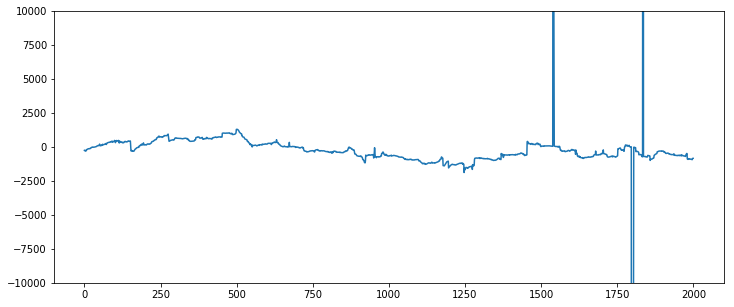

In [65]:

intName = get_intName(position)
x = []
a = []
for i in range(2000):
    if not i in intName:
        break
    c = contig_name(intName[i])
    if c in reps|repeats:
        continue
    if not c+'_0' in intNameX:
        continue
    x.append(i)
    a.append(position[intName[i]] - pos[intName[i]])
plt.plot(x,a,)
plt.ylim(-10000,10000)
#plt.xlim(250,400)

(-10000, 10000)

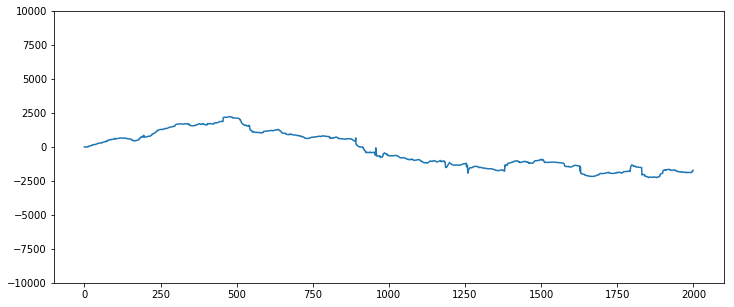

In [88]:

intName = get_intName(positionX)
x = []
a = []
for i in range(2000):
    if not i in intName:
        break
    c = contig_name(intName[i])
    if c in reps|repeats:
        continue
    if not c+'_0' in intNameX:
        continue
    x.append(i)
    a.append(positionX[intName[i]] - pos[intName[i]])
plt.plot(x,a,)
plt.ylim(-10000,10000)
#plt.xlim(250,400)

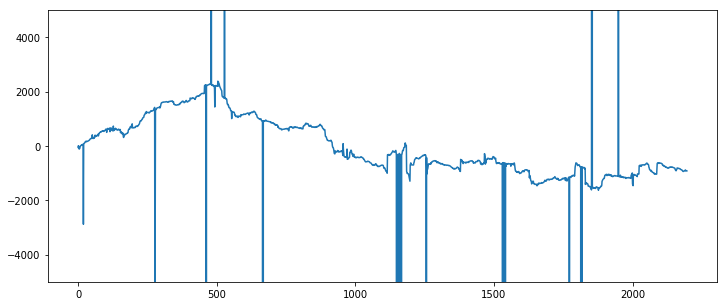

In [14]:

intName = get_intName(position)
x = []
a = []
for i in range(3000):
    if not i in intName:
        break
    c = contig_name(intName[i])
 #   if c in reps|repeats:
  #      continue
    if not intName[i] in intNameX:
        continue
    x.append(i)
    a.append(position[intName[i]] - pos[intName[i]])
plt.plot(x,a,)
plt.ylim(-5000,5000)

plt.show()

In [100]:
intName[550],intName[551]

('555APD_0', '1412APD_0')

In [ ]:
for a,b,d in

In [104]:
sorted([a-position['555APD_0'] for a,b,c,d in constr_pos['555APD']])

[-115768.0,
 -115560.0,
 -77313.0,
 -77105.0,
 -754.0,
 -720.0,
 -675.0,
 -630.0,
 -609.0,
 -481.0,
 -436.0,
 -365.0,
 -322.0,
 -292.0,
 -283.0,
 -276.0,
 -275.0,
 -252.0,
 -231.0,
 -220.0,
 -216.0,
 -205.0,
 -195.0,
 -189.0,
 -188.0,
 -186.0,
 -181.0,
 -168.0,
 -166.0,
 -165.0,
 -162.0,
 -157.0,
 -151.0,
 -130.0,
 -120.0,
 -115.0,
 -114.0,
 -110.0,
 -109.0,
 -103.0,
 -103.0,
 -102.0,
 -102.0,
 -101.0,
 -97.0,
 -93.0,
 -92.0,
 -90.0,
 -82.0,
 -79.0,
 -76.0,
 -75.0,
 -69.0,
 -64.0,
 -64.0,
 -63.0,
 -59.0,
 -58.0,
 -58.0,
 -54.0,
 -53.0,
 -50.0,
 -50.0,
 -49.0,
 -48.0,
 -47.0,
 -47.0,
 -45.0,
 -43.0,
 -43.0,
 -43.0,
 -43.0,
 -43.0,
 -42.0,
 -41.0,
 -41.0,
 -40.0,
 -40.0,
 -33.0,
 -32.0,
 -31.0,
 -29.0,
 -29.0,
 -26.0,
 -23.0,
 -22.0,
 -20.0,
 -19.0,
 -15.0,
 -13.0,
 -13.0,
 -12.0,
 -9.0,
 -7.0,
 -6.0,
 -5.0,
 -3.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 6.0,
 7.0,
 7.0,
 7.0,
 7.0,
 8.0,
 9.

In [300]:
def plot_graph(position, data, von = 250, bis = 400, kantenanzahl = 2, fehler = 1000):

    intName = get_intName(position)

    s = coll.defaultdict(coll.Counter)
    p = coll.defaultdict(coll.Counter)

    graph = nx.DiGraph()

    for a, b, dist in data:
        if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
            continue
       # if {a,b}&{'145APD_1','342APD_0','501APD_3','501APD_1'}:
        #    continue
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < fehler and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a][b] += 1
            p[b][a] += 1
        """
        elif abs(real_dist - dist) > 20000:
            color = 'blue'
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
                color = 'red'
            graph.add_edge(a, b, penwidth = 2, color = color)"""
    ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
    pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}

    evil = set()
    E = set()
    for a in s:
        for c in s[a]:
            E.add((a,c))
            for b in set(s[a]) & set(p[c]):
                evil.add((a,b))
                evil.add((b,c))



   # for a in set(s)|set(p):
    #    graph.add_node(intName[a],penwidth = 2)
#    for r in {'2414APD_0','164APD_0', '520APD_0', '2374APD_0'} :
#{'346APD_1', '40APD_1', '1360APD_0', '2075APD_0', '2443APD_1', '1554APD_1', '175APD_0', '2457APD_0', '371APD_0', '175APD_1', '873APD_0', '1554APD_0', 
#'873APD_1', '2075APD_1', '40APD_0', '346APD_0', '2443APD_0', '371APD_1', '1360APD_1', '2457APD_1'}:
#        if r in intName and von <= intName[r] <= bis:
#            graph.add_node(r, color = 'red')
    for a in repeats:
        for r in contig_repeat[a]:
            if von <= intName[r] <= bis:
                if r in reps:
                    graph.add_node(r, color = 'blue')
                else:
                    graph.add_node(r, color = 'red')
    for b in pp:
        for a in pp[b]:
            #graph.add_edge(intName[a],intName[b],penwidth = 2)
            graph.add_edge(a, b, penwidth = 2, label = s[a][b])
    for a in ss:
        for b in ss[a]:
            #graph.add_edge(intName[a],intName[b],penwidth = 2)
            graph.add_edge(a, b, penwidth = 2, label = s[a][b])

    for a,b in E-evil:
        #graph.add_edge(intName[a],intName[b],penwidth = 2,color = 'green')
        graph.add_edge(a, b, penwidth = 2,color = 'green', label = s[a][b])

    pydot = nx.nx_pydot.to_pydot(graph)

    pydot.write_png('ttt.png')
    #display(Image(filename='ttt.png'))

In [300]:
#plot_graph(position, data, von = 420, bis = 520)
dataX = read_file('my_apd1998.lst')
dataX = [(a[:-2],b[:-2],d) for a,b,d in dataX]
d1,d2,d3 = umsortieren(dataX,rep,pos)

Es haben Daten gefehlt


In [405]:
(reps-repeats)&{'2414APD','164APD', '520APD', '2374APD'} 

{'2374APD'}

In [358]:
position['421APD_0']-position['703APD_0']

20001.0

In [355]:
pos['58APD_1']-pos['703APD_0'],pos['421APD_0']-pos['58APD_1'],

(14508.0, 5517.0)

In [356]:
position['58APD_1']-position['703APD_0'],position['421APD_0']-position['58APD_1'],

(5573.0, 14428.0)

In [352]:
pos['371APD_0'],pos['371APD_1']

(1254929.0, 1276211.0)

In [323]:
for a,b,d in d1:
    if '2075APD_0' in [a,b]:
        print(a,b,d, a[:-2] in reps and b[:-2] in reps)

2075APD_0 462APD_0 158.299515644846 True
2075APD_0 462APD_0 163.0 True
2075APD_0 462APD_0 167.0 True
2075APD_0 462APD_0 168.0 True
2075APD_0 462APD_0 170.0 True
2075APD_0 462APD_0 170.0 True
2075APD_0 462APD_0 172.0 True
2075APD_0 462APD_0 178.0 True
2075APD_0 462APD_0 179.0 True
2075APD_0 462APD_0 189.0 True
407APD_0 2075APD_0 3324.0 True
407APD_0 2075APD_0 3330.0 True
407APD_0 2075APD_0 3330.996288279377 True
407APD_0 2075APD_0 3334.0 True
407APD_0 2075APD_0 3335.0 True
407APD_0 2075APD_0 3335.0 True
407APD_0 2075APD_0 3335.0 True
407APD_0 2075APD_0 3335.0 True
407APD_0 2075APD_0 3337.0 True
407APD_0 2075APD_0 3340.0 True
694APD_0 2075APD_0 163.0 True
694APD_0 2075APD_0 164.0 True
694APD_0 2075APD_0 167.0 True
694APD_0 2075APD_0 168.0 True
694APD_0 2075APD_0 168.0 True
694APD_0 2075APD_0 169.0 True
694APD_0 2075APD_0 171.0 True
694APD_0 2075APD_0 171.0 True
694APD_0 2075APD_0 172.0 True


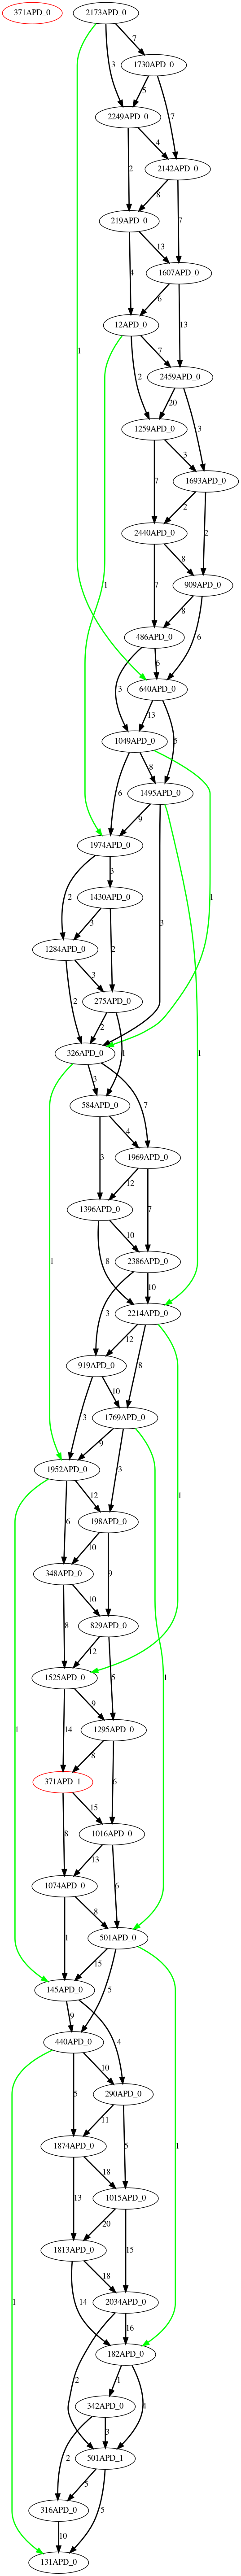

In [351]:
plot_graph(pos,d1+d2, von = 1500, bis = 1550,fehler = 5000)

In [29]:
intName = get_intName(position)
intName['135APD_0']
[0, 1, 2, 3, 4]
[1111, 1112, 1113, 1114, 1115]

[1830, 1831, 1832, 1833, 1834]
[2192, 2193, 2194, 2195, 2196]

[1185, 1186, 1187, 1188, 1189]
[1825, 1826, 1827, 1828, 1829]

[1116, 1117, 1118, 1119, 1120]
[1180, 1181, 1182, 1183, 1184]

[492, 493]
[492, 493]


1572

In [258]:
intName[1115],intName[1116]

('1657APD_0', '849APD_0')

In [265]:
for x,y,d in data:
    if {x,y} == {'1657APD_0', '849APD_0'}:
        print(x,y,d,positionh[y]-positionh[x])

1657APD_0 849APD_0 4187 4196.0
1657APD_0 849APD_0 4187 4196.0
1657APD_0 849APD_0 4196 4196.0
1657APD_0 849APD_0 4198 4196.0


In [261]:
4873-4196

677

In [263]:
positionh = {c: v-(intName[c]>1115)*677 for c,v in position.items()}

In [68]:

contig_repeat = coll.defaultdict(list)
for contig in pos:
    contig_repeat[contig_name(contig)].append(contig)

In [69]:
d1,d2,_ = umsortieren(roh_data, contig_repeat, pos)

Es haben Daten gefehlt


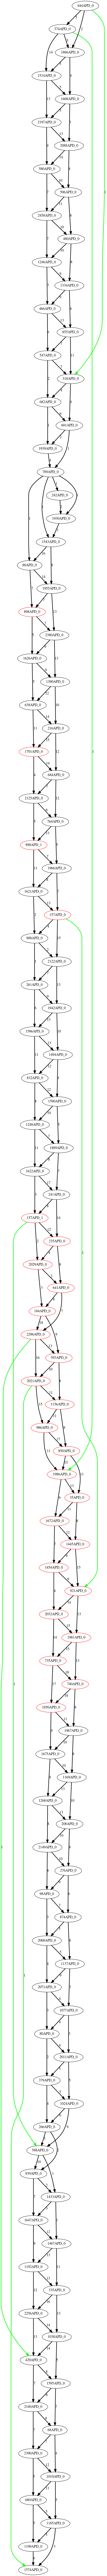

In [84]:
plot_graph(positionY,d1+d2, von = 100, bis = 210, fehler = 500)

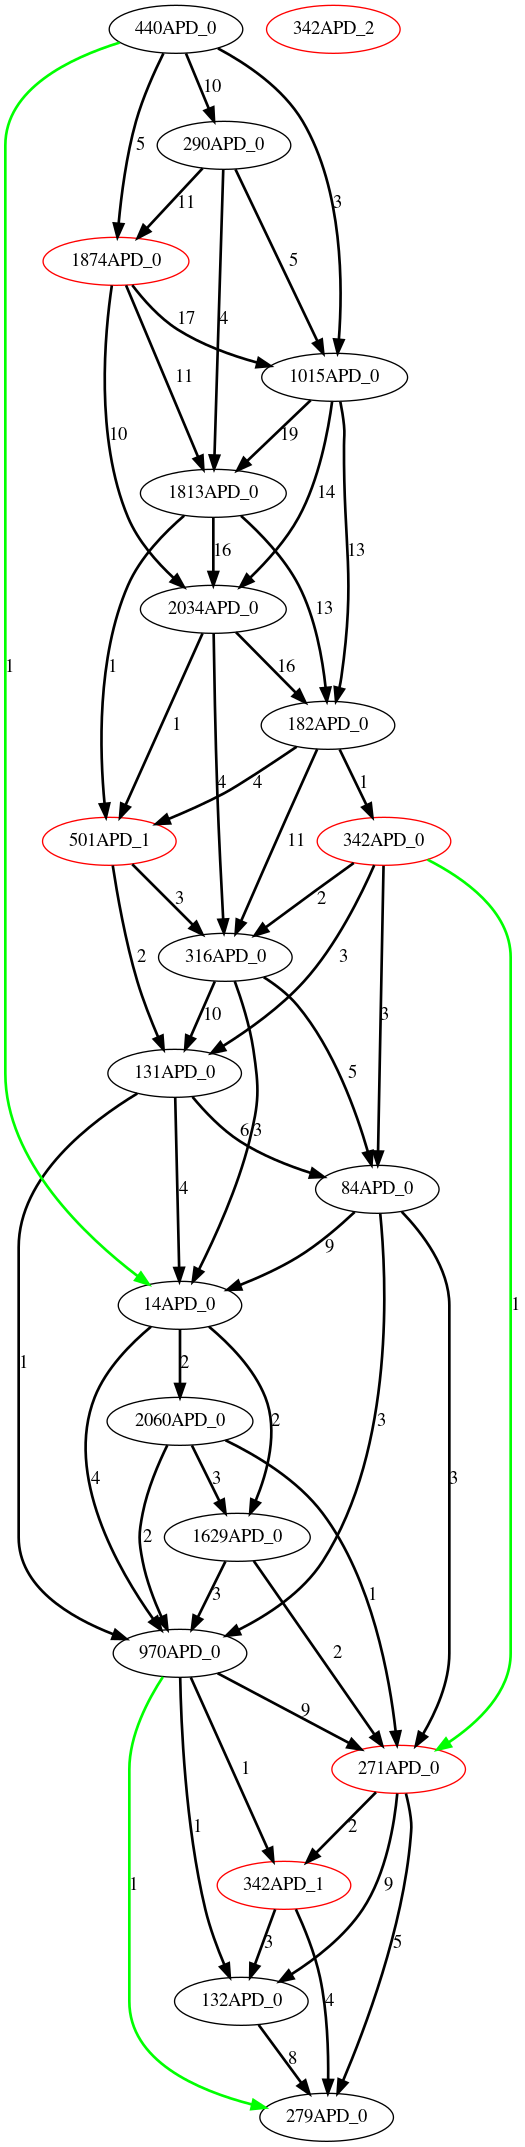

In [70]:
plot_graph(pos,d1, von = 440, bis = 460, kantenanzahl=3, fehler = 1000)

In [158]:
1537
264
1157
1153
1255
1523
664
1520
1108
460
1110
1543
485
501
1113
1531
1764
1162
1538
1107
1767
1821
1152
469
1111
1822
1536
1532
1158
1541
1766
1164
1156
1540
1165
1154
1109
1115

In [161]:
intName['411APD_0'],intName['816APD_0'],

(1182, 1183)

In [163]:
L = []
for x in G['816APD_0']:
    L.append(intName[x])
sorted(L)

[1182,
 1225,
 1226,
 1227,
 1228,
 1229,
 1230,
 1231,
 1232,
 1233,
 1234,
 1235,
 1236,
 1240,
 1241,
 1242,
 1243,
 1244,
 1245,
 1246,
 1247,
 1248,
 1250,
 1251,
 1252,
 1253,
 1254,
 1255,
 1257,
 1258,
 1259,
 1260,
 1261,
 1262,
 1263,
 1264,
 1265,
 1266,
 1267,
 1268,
 1269,
 1271,
 1273,
 1278,
 1279,
 1280,
 1281,
 1282,
 1283,
 1284,
 1285,
 1286,
 1287,
 1288,
 1289,
 1290,
 1291,
 1292,
 1293,
 1294,
 1296,
 1298,
 1299,
 1300,
 1301,
 1302,
 1303,
 1305]

In [294]:
for a,b,d in data:
    if {a,b} == {'133APD_0','2360APD_0'}:
        print(a,b,d)

2360APD_0 133APD_0 882
2360APD_0 133APD_0 888
2360APD_0 133APD_0 889
2360APD_0 133APD_0 890
2360APD_0 133APD_0 895
2360APD_0 133APD_0 898
2360APD_0 133APD_0 905


In [32]:
reps-repeats

{'1360APD',
 '1554APD',
 '175APD',
 '2443APD',
 '2457APD',
 '371APD',
 '40APD',
 '873APD'}

In [31]:
gruppierung(constr_pos['2374APD'],2000,0)

[Repeat(pos=3413291.0, güte=0, güte_0=4.757168722805211, stärke=-1, gewicht=2, in_out=0, genauigkeit=0.6342891630406948),
 Repeat(pos=3446013.0, güte=72.76196659424171, güte_0=381.2007525078776, stärke=26, gewicht=13, in_out=1, genauigkeit=0.7562715217280835),
 Repeat(pos=3472313.0, güte=0, güte_0=0.375, stärke=-1, gewicht=1, in_out=0, genauigkeit=1.5),
 Repeat(pos=3478857.0, güte=361.04569695258516, güte_0=774.9510048928225, stärke=110, gewicht=13, in_out=1, genauigkeit=0.8869847528035635),
 Repeat(pos=3485415.0, güte=0, güte_0=0.375, stärke=-1, gewicht=1, in_out=0, genauigkeit=1.5),
 Repeat(pos=3511514.0, güte=0, güte_0=3.123585413470012, stärke=-1, gewicht=1, in_out=0, genauigkeit=1.0411951378233373)]

In [333]:
X = []
for r in reps-repeats:
    for c in rep[r]:
        print(intNameX[c])
        X += [c]
print(X)

1767
1771
901
902
250
265
428
435
1610
1615
888
889
1642
1679
1072
1103
1067
1098
465
630
['175APD_0', '175APD_1', '1360APD_0', '1360APD_1', '2075APD_0', '2075APD_1', '371APD_0', '371APD_1', '2457APD_0', '2457APD_1', '873APD_0', '873APD_1', '2443APD_0', '2443APD_1', '1554APD_0', '1554APD_1', '346APD_0', '346APD_1', '40APD_0', '40APD_1']


KeyError: '2075APD'

In [287]:
for r in reps-repeats:
    print(position[r+'_0'])
    print(coll.Counter([int(aa//10000) for aa,bb,cc,dd in constr_pos[r]]))
    for c in rep[r]:
        print(int(pos[c]//10000))
    print()

4510329.0
Counter({451: 50, 447: 8, 454: 1})
447
451

2456836.0
Counter({245: 165})
245
245

685183.0
Counter({68: 101, 61: 2})
61
68

1279116.0
Counter({127: 74, 133: 6, 136: 2, 173: 1, 131: 1})
125
127

3974627.0
Counter({397: 51, 400: 7, 393: 1})
397
400

2420508.0
Counter({242: 151, 241: 49})
242
242

4161741.0
Counter({416: 157, 405: 2, 447: 1})
406
416

2862419.0
Counter({286: 86, 295: 4, 147: 1, 145: 1})
286
296

2853700.0
Counter({285: 115, 294: 5, 295: 4, 146: 1})
285
295

1430169.0
Counter({143: 92, 196: 16, 142: 6, 120: 2})
142
196



In [274]:
for a,b,d in bad_data:
    if '501APD_2' in {a,b}:
        print(a,b,d)

1015APD_0 501APD_2 11433
1015APD_0 501APD_2 13583
1015APD_0 501APD_2 23318
1016APD_0 501APD_2 15860
1016APD_0 501APD_2 15880
1016APD_0 501APD_2 15893
1016APD_0 501APD_2 15898
1016APD_0 501APD_2 15981
1016APD_0 501APD_2 16057
1074APD_0 501APD_2 8666
1074APD_0 501APD_2 8669
1074APD_0 501APD_2 8672
1074APD_0 501APD_2 8673
1074APD_0 501APD_2 8675
1074APD_0 501APD_2 8675
1074APD_0 501APD_2 8675
1074APD_0 501APD_2 8678
1295APD_0 501APD_2 22584
131APD_0 501APD_2 3976
131APD_1 501APD_2 3976
131APD_0 501APD_2 45594
131APD_1 501APD_2 45594
1525APD_0 501APD_2 28331
1607APD_0 501APD_2 4567
1742APD_0 501APD_2 39626
1769APD_0 501APD_2 52446
1769APD_1 501APD_2 52446
1813APD_0 501APD_2 11210
1813APD_0 501APD_2 25674
1813APD_0 501APD_2 9236
182APD_0 501APD_2 38574
182APD_0 501APD_2 7329
182APD_0 501APD_2 7351
182APD_0 501APD_2 7357
182APD_0 501APD_2 7394
1874APD_0 501APD_2 20187
1874APD_1 501APD_2 20187
1874APD_0 501APD_2 22744
1874APD_1 501APD_2 22744
1874APD_0 501APD_2 24602
1874APD_1 501APD_2 24602


In [3]:
def verbessere_loop(datei, out): 
    
    data = read_file(datei, '')
    r = coll.Counter()
    for a,b,d in data:
        r[a] += 1
        r[b] += 1
    
    data2 = data
    data = [[a,b,d] for a,b,d in data if r[a] > 1 and r[b] > 1]# and a not in X and b not in X]
   # for i in range(1000):
    #    data.append(['2205APD_0','69APD_0',103069])
   # for i in range(100):
    #    data.append(['2345APD_0','2080APD_0',4099601.0])
    data = connected(data)
    position = {a for a,_,_ in data} | {b for _,b,_ in data}
    contig_repeat = coll.defaultdict(list)
    for contig in position:
        contig_repeat[contig_name(contig)].append(contig)
        
    Ret = coll.namedtuple('Ret', ['contig','güte'])
    ret = Ret(contig = [], güte = [])
    for i in range(2):
        print(str(i) + '. Durchlauf')
        position = solve_LP(position, data)
        print('max', max(position.values()))
        print('sortiere Bedingungen anderen repeats zu')
        umsortieren(data, contig_repeat, position)
        position = solve_LP(position, data)
        print('max', max(position.values()))
        print('sortiere Bedingungen anderen repeats zu')
        umsortieren(data, contig_repeat, position)
        return position, data, 1
        #constr_pos = get_constr_pos(data, contig_repeat, position)
        constr_pos = get_X_pos(data2, contig_repeat, position, X)
        #get_repeat_X(position,constr_pos, contig_repeat)
        contig, repeats, güte, groups = get_repeat(constr_pos, contig_repeat)
        if güte == 0:
            print(111)
            write_file(out, data)
            return position, data
        print(str(len(contig_repeat[contig])) + '. Repeat von '+contig)
        print('alte Positionen:')
        for rep in contig_repeat[contig]:
            print('\t', position[rep])
            
        new_contig = contig +'_'+ str(len(contig_repeat[contig]))
        contig_repeat[contig].append(new_contig)
        
        print('neue Positionen:')
        for name, werte in zip(contig_repeat[contig], repeats):
            position[name] = werte.pos
            print('\t', werte.pos)
            
        
        print('ordne neuem repeat zu: ')
        umsortieren(data2, contig_repeat, position)
        print()
        print()
        #out = 'out' + str(i//10) + '.lst'
        write_file(out, data2)
     #   ret.contig.append(contig)
     #   ret.güte.append(güte)
        #data = connected(data)
        #ret.append(Ret(
         #   contig = contig,
          #  güte = güte,
           # repeats = repeats,
            #constr_pos = constr_pos,
    #        pos = position,
     #       rep = contig_repeat,
      #      data = data
       # ))
    return position, data2, 1 #,ret
#position, data = verbessere_loop('my_apd200.lst', 'out.lst' )

#position2, data2, ret = verbessere_loop('my_apd199.lst', 'test.lst' )
position2, data2, ret = verbessere_loop('test.lst', 'test.lst' )


TypeError: read_file() takes 1 positional argument but 2 were given

In [9]:
contig_repeat = coll.defaultdict(list)
for contig in position:
    contig_repeat[contig_name(contig)].append(contig)

In [10]:
def entferne_sackgassen(graph, start = '2345APD_0', ziel = '2080APD_0'):
    änderungen = True
    while änderungen:
        änderungen = False
        for x in list(graph):
            if graph.in_degree[x] == 0 and x != start:
                graph.remove_node(x)
                änderungen = True
            elif graph.out_degree[x] == 0 and x != ziel:
                graph.remove_node(x)
                änderungen = True
                
def mehrfach(adj):
    for b,l in adj.items():
        if len(l) > 1:
            return True
    return False

def singels(graph):
    evil = []
    for a in graph:
        if mehrfach(graph.succ[a]) or mehrfach(graph.pred[a]):
            continue
        evil.append(a)
    return evil


graph = nx.MultiDiGraph() 
for a, b, d in data:
    if a != b:
        graph.add_edge(a,b,d)
        
evil = singels(graph)

count = coll.Counter((a,b) for a, b, d in data)
abgesichert = set()
for (i,j), a in count.items():
    if a > 1:
        abgesichert |= {i,j}

In [27]:
feste_position = {'2345APD_0': 0, '1395APD_0': 6982.0, '1596APD_0': 9952.0, '2235APD_0': 14269.0, '1534APD_0': 14941.0, '546APD_0': 16511.0, '577APD_0': 19014.0, '998APD_0': 32313.0, '209APD_0': 34132.0, '1635APD_0': 43535.0, '2109APD_0': 45637.0, '996APD_0': 47657.0, '1481APD_0': 49144.0, '2113APD_0': 55767.0, '1332APD_0': 64494.0, '225APD_0': 68363.0, '1894APD_0': 77439.0, '521APD_0': 80995.0, '1076APD_0': 83301.0, '301APD_0': 86477.0, '50APD_0': 88528.0, '2396APD_0': 90554.9323053167, '1980APD_0': 92187.9323053167, '958APD_0': 93267.9323053167, '2050APD_0': 95081.9323053167, '1113APD_0': 99611.16150611905, '960APD_0': 101534.16150611905, '831APD_0': 103166.0, '1877APD_0': 106398.0, '1337APD_0': 107251.0, '59APD_0': 114474.9323053167, '542APD_0': 120932.9323053167, '1631APD_0': 124902.9323053167, '176APD_0': 126130.0, '567APD_0': 128337.9323053167, '776APD_0': 130202.9323053167, '86APD_0': 131491.16150611907, '1529APD_0': 138169.0, '1057APD_0': 138854.0, '1472APD_0': 141026.0, '1714APD_0': 142777.9323053167, '1400APD_0': 145988.0, '2058APD_0': 149580.16150611907, '943APD_0': 151240.0, '511APD_0': 151970.9323053167, '1698APD_0': 157366.0, '1903APD_0': 158556.9323053167, '2387APD_0': 164056.9323053167, '1317APD_0': 165654.9323053167, '1857APD_0': 183019.0, '931APD_0': 185975.0, '1375APD_0': 186830.0, '156APD_0': 187849.0, '19APD_0': 190568.9323053167, '1252APD_0': 193655.9323053167, '772APD_0': 194388.0, '896APD_0': 195101.9323053167, '2013APD_0': 196813.0, '2322APD_0': 199619.0, '439APD_0': 202543.9323053167, '948APD_0': 203489.0, '1151APD_0': 205933.9323053167, '1904APD_0': 212325.16150611907, '945APD_0': 214369.9323053167, '2085APD_0': 215023.9323053167, '1779APD_0': 218431.0167818591, '1363APD_0': 219604.0, '1380APD_0': 220389.0, '1921APD_0': 222788.16150611907, '1465APD_0': 224878.0, '876APD_0': 226088.0, '793APD_0': 227266.0, '1991APD_0': 229453.9323053167, '2003APD_0': 232875.9323053167, '1397APD_0': 233538.0, '885APD_0': 235105.0, '205APD_0': 235920.0, '1017APD_0': 239570.0, '277APD_0': 241603.0167818591, '444APD_0': 243329.0, '374APD_0': 244151.0167818591, '1866APD_0': 246176.0, '1514APD_0': 246999.0167818591, '2197APD_0': 251052.0, '2088APD_0': 252362.16150611907, '580APD_0': 254846.0, '506APD_0': 264011.0, '2458APD_0': 267844.0, '480APD_0': 268721.0, '1246APD_0': 271731.0, '1334APD_0': 272710.0, '466APD_0': 274608.0, '855APD_0': 278930.9323053167, '547APD_0': 279883.0, '318APD_0': 280245.0, '682APD_0': 282088.2346662088, '601APD_0': 282728.0, '1939APD_0': 286081.0, '789APD_0': 287110.0, '1930APD_0': 288485.02958898427, '1543APD_0': 289322.16150611907, '88APD_0': 291709.0, '1955APD_0': 295408.0, '2380APD_0': 297161.0, '1390APD_0': 298599.0, '638APD_0': 300652.0, '216APD_0': 302252.9323053167, '1701APD_0': 307529.9323053167, '684APD_0': 309029.8899950047, '2125APD_0': 310899.9323053167, '764APD_0': 311342.9323053167, '898APD_0': 312158.0, '1966APD_0': 313387.9323053167, '1621APD_0': 313981.0, '157APD_0': 314613.0, '2122APD_0': 322106.0, '1942APD_0': 324504.16150611907, '1586APD_0': 325187.9323053167, '1494APD_0': 326706.9323053167, '832APD_0': 327686.0, '1590APD_0': 328986.0, '1248APD_0': 330380.0, '1889APD_0': 331059.0, '1622APD_0': 331540.16150611907, '241APD_0': 332401.0, '235APD_0': 340630.0, '184APD_0': 343575.0, '2296APD_0': 344552.0, '593APD_0': 347359.0, '2021APD_0': 347952.0, '986APD_0': 352602.0, '850APD_0': 355611.0, '1986APD_0': 357012.0, '35APD_0': 358780.0, '1672APD_0': 363706.0, '1445APD_0': 365326.0, '1454APD_0': 367103.0, '921APD_0': 367424.0, '2032APD_0': 372182.0, '1981APD_0': 374655.0, '735APD_0': 376433.0, '740APD_0': 379498.0, '1850APD_0': 380887.0, '1967APD_0': 382780.0, '1675APD_0': 384590.473152517, '1169APD_0': 385234.0, '1268APD_0': 385986.0, '208APD_0': 387502.0, '2149APD_0': 389692.0, '276APD_0': 392176.0, '98APD_0': 399605.0, '874APD_0': 400819.0, '1137APD_0': 401970.0, '2071APD_0': 402724.0, '1077APD_0': 403656.0, '80APD_0': 404188.0, '2011APD_0': 404954.0, '379APD_0': 405566.0, '1024APD_0': 406019.0, '588APD_0': 407292.0, '939APD_0': 410839.0, '1433APD_0': 413623.0, '1647APD_0': 414037.0, '1467APD_0': 416897.0, '1192APD_0': 418252.0, '335APD_0': 419175.0, '2256APD_0': 420358.0, '1038APD_0': 421940.23829773226, '429APD_0': 423034.23829773226, '68APD_0': 426336.23829773226, '2390APD_0': 426790.23829773226, '1010APD_0': 429184.0, '680APD_0': 432401.0, '1185APD_0': 436204.0, '1199APD_0': 436836.0, '1574APD_0': 438671.23829773226, '989APD_0': 439790.0, '106APD_0': 443893.0, '2423APD_0': 451664.0, '2434APD_0': 452712.0, '2461APD_0': 454268.0, '1281APD_0': 456958.0, '202APD_0': 461086.0, '90APD_0': 462372.473152517, '2367APD_0': 467252.0, '1661APD_0': 471243.0, '569APD_0': 473697.0, '1309APD_0': 474252.473152517, '1665APD_0': 475212.0, '153APD_0': 477523.23829773226, '1816APD_0': 478302.0, '1330APD_0': 480585.0, '2335APD_0': 482507.0, '1751APD_0': 483573.0, '904APD_0': 487632.0, '548APD_0': 488540.0, '811APD_0': 492088.0, '2415APD_0': 493902.0, '2204APD_0': 494838.0, '196APD_0': 501205.0, '714APD_0': 504981.0, '31APD_0': 506999.0, '656APD_0': 513325.0, '1410APD_0': 522508.0, '1852APD_0': 526822.0, '151APD_0': 528818.0, '861APD_0': 542020.0, '187APD_0': 542707.0, '1162APD_0': 551982.0, '459APD_0': 552763.0, '57APD_0': 556966.0, '900APD_0': 557883.0, '766APD_0': 558723.0, '189APD_0': 559552.2382977323, '1815APD_0': 573220.0, '2205APD_0': 575383.0, '58APD_0': 580807.0, '599APD_0': 588925.0, '345APD_0': 593363.0, '1463APD_0': 604009.2382977323, '865APD_0': 605198.2382977323, '407APD_0': 610069.2382977323, '2394APD_0': 611819.2382977323, '462APD_0': 613570.2382977323, '1500APD_0': 614341.2382977323, '1APD_0': 615116.2382977323, '1245APD_0': 623603.2382977323, '1423APD_0': 624932.2382977323, '2420APD_0': 632416.2382977323, '1439APD_0': 635553.2382977323, '703APD_0': 638143.2382977323, '421APD_0': 658217.2382977323, '37APD_0': 666831.2382977323, '44APD_0': 668089.2382977323, '11APD_0': 674309.2382977323, '1783APD_0': 680909.2382977323, '69APD_0': 686494.2382977323, '1022APD_0': 687364.2382977323, '681APD_0': 692015.2382977323, '2110APD_0': 695000.2382977323, '1773APD_0': 698388.2382977323, '94APD_0': 702701.2382977323, '1721APD_0': 711151.2382977323, '2410APD_0': 715968.2382977323, '89APD_0': 722997.2382977323, '1366APD_0': 726734.2382977323, '1651APD_0': 727275.2382977323, '119APD_0': 733462.2382977323, '572APD_0': 743783.2382977323, '2155APD_0': 753799.2382977323, '708APD_0': 759510.0766310074, '1522APD_0': 761041.0766310074, '134APD_0': 762423.0766310074, '525APD_0': 765329.0766310074, '597APD_0': 768257.0766310074, '75APD_0': 776675.0766310074, '497APD_0': 788319.0766310074, '464APD_0': 789953.0766310074, '1474APD_0': 790704.0766310074, '565APD_0': 791637.0766310074, '653APD_0': 794547.0766310074, '391APD_0': 795158.0766310074, '1507APD_0': 807370.0766310074, '167APD_0': 807934.0766310074, '2337APD_0': 816330.0766310074, '385APD_0': 817439.0766310074, '307APD_0': 818885.0766310074, '1261APD_0': 829336.0766310074, '1691APD_0': 830651.509677197, '452APD_0': 831324.509677197, '781APD_0': 854408.509677197, '1753APD_0': 855410.509677197, '1523APD_0': 860820.509677197, '995APD_0': 866848.509677197, '2460APD_0': 871756.509677197, '1033APD_0': 873861.509677197, '568APD_0': 875303.509677197, '1970APD_0': 882183.509677197, '820APD_0': 889271.509677197, '77APD_0': 889993.509677197, '1258APD_0': 891631.509677197, '1265APD_0': 897209.509677197, '1253APD_0': 899628.509677197, '73APD_0': 903466.509677197, '1460APD_0': 912104.509677197, '376APD_0': 917482.509677197, '806APD_0': 932673.7778545924, '2250APD_0': 936708.7778545924, '3APD_0': 944904.6069821372, '573APD_0': 949058.6069821372, '48APD_0': 957960.6069821372, '1055APD_0': 963369.3104909246, '117APD_0': 968094.3104909246, '639APD_0': 976938.7385117481, '2211APD_0': 981654.7385117481, '802APD_0': 984160.7385117481, '2077APD_0': 991534.7385117481, '1177APD_0': 1005285.7385117481, '1679APD_0': 1009248.7385117481, '1073APD_0': 1010693.7385117481, '1249APD_0': 1031567.7385117481, '1506APD_0': 1034245.7385117481, '783APD_0': 1035515.7385117481, '609APD_0': 1042600.2396140165, '1335APD_0': 1054141.7385117481, '742APD_0': 1056408.7385117481, '1835APD_0': 1057288.7385117481, '1837APD_0': 1058359.7385117481, '367APD_0': 1061414.9869302353, '2038APD_0': 1064096.9869302353, '398APD_0': 1075523.9869302353, '2275APD_0': 1081823.9869302353, '877APD_0': 1083407.9869302353, '2351APD_0': 1084567.524259436, '543APD_0': 1087041.524259436, '551APD_0': 1089926.524259436, '62APD_0': 1099063.524259436, '1048APD_0': 1101164.524259436, '2019APD_0': 1103959.543550645, '399APD_0': 1104615.524259436, '232APD_0': 1105361.524259436, '1453APD_0': 1106271.524259436, '2412APD_0': 1109844.524259436, '1798APD_0': 1117879.524259436, '23APD_0': 1118663.524259436, '265APD_0': 1122172.524259436, '1063APD_0': 1122776.524259436, '1817APD_0': 1124614.9840092727, '2112APD_0': 1127916.9840092727, '1893APD_0': 1129071.0238666832, '2190APD_0': 1133304.0238666832, '1568APD_0': 1133799.0238666832, '337APD_0': 1134539.9840092727, '980APD_0': 1137458.0238666832, '623APD_0': 1138213.0238666832, '745APD_0': 1140201.9840092727, '351APD_0': 1141512.9840092727, '2015APD_0': 1146344.524259436, '2339APD_0': 1149338.0238666832, '670APD_0': 1150422.0238666832, '1054APD_0': 1151076.0238666832, '2426APD_0': 1151832.9840092727, '358APD_0': 1153636.0238666832, '195APD_0': 1157457.0238666832, '1878APD_0': 1162614.0238666832, '788APD_0': 1163669.0238666832, '2223APD_0': 1164575.0238666832, '1935APD_0': 1165060.0238666832, '1583APD_0': 1166299.0238666832, '1785APD_0': 1169714.4089970493, '1789APD_0': 1170301.0238666832, '596APD_0': 1171273.0623984544, '1097APD_0': 1171803.0238666832, '944APD_0': 1176194.0238666832, '1895APD_0': 1177652.0238666832, '1544APD_0': 1178786.0238666832, '2368APD_0': 1180067.0238666832, '2331APD_0': 1181570.0238666832, '414APD_0': 1182334.0238666832, '2247APD_0': 1183868.0238666832, '2173APD_0': 1185732.0238666832, '1730APD_0': 1186410.0238666832, '2142APD_0': 1187391.0238666832, '219APD_0': 1188841.0238666832, '1607APD_0': 1192157.0238666832, '12APD_0': 1195788.0238666832, '2459APD_0': 1196378.0238666832, '501APD_0': 1196772.0238666832, '1259APD_0': 1206769.0238666832, '1693APD_0': 1208525.0238666832, '909APD_0': 1208902.0238666832, '640APD_0': 1209895.0238666832, '1049APD_0': 1217014.0238666832, '1391APD_0': 1220414.0238666832, '1495APD_0': 1220940.0238666832, '1974APD_0': 1223001.0238666832, '1430APD_0': 1232235.0238666832, '326APD_0': 1233492.0238666832, '1379APD_0': 1233790.0238666832, '584APD_0': 1234577.0238666832, '1969APD_0': 1235030.0238666832, '1396APD_0': 1236300.0238666832, '2386APD_0': 1240106.0238666832, '2214APD_0': 1241899.0238666832, '919APD_0': 1246741.0238666832, '1769APD_0': 1247895.0238666832, '1952APD_0': 1259512.0238666832, '198APD_0': 1264981.0238666832, '348APD_0': 1269459.0238666832, '829APD_0': 1270629.0238666832, '1525APD_0': 1272194.0238666832, '1295APD_0': 1277888.0238666832, '371APD_0': 1278455.0238666832, '1016APD_0': 1284785.0238666832, '1074APD_0': 1292005.0238666832, '145APD_0': 1315541.0238666832, '440APD_0': 1321144.0238666832, '290APD_0': 1328348.0238666832, '1874APD_0': 1331523.0238666832, '1015APD_0': 1340671.0238666832, '1813APD_0': 1343046.0238666832, '1505APD_0': 1343671.0238666832, '2034APD_0': 1345203.0238666832, '182APD_0': 1346946.0238666832, '332APD_0': 1357928.0238666832, '1742APD_0': 1358216.0238666832, '316APD_0': 1359317.369214408, '131APD_0': 1363760.369214408, '1011APD_0': 1363905.369214408, '751APD_0': 1365310.369214408, '2324APD_0': 1366145.369214408, '84APD_0': 1366553.369214408, '14APD_0': 1373477.369214408, '970APD_0': 1381312.369214408, '342APD_0': 1382895.369214408, '271APD_0': 1385353.369214408, '132APD_0': 1393197.369214408, '279APD_0': 1398014.7182576736, '737APD_0': 1403887.7182576736, '211APD_0': 1405167.7182576736, '2195APD_0': 1409297.7182576736, '18APD_0': 1410982.7182576736, '477APD_0': 1418966.7182576736, '113APD_0': 1418993.7182576736, '40APD_0': 1429462.7182576736, '2066APD_0': 1441869.7182576736, '1285APD_0': 1443455.7182576736, '483APD_0': 1444532.7182576736, '2043APD_0': 1450151.7182576736, '300APD_0': 1452435.7182576736, '64APD_0': 1452873.7182576736, '1208APD_0': 1456196.7182576736, '658APD_0': 1457200.7182576736, '1510APD_0': 1458102.7182576736, '1114APD_0': 1460300.7182576736, '2278APD_0': 1463197.7182576736, '1948APD_0': 1491153.7182576736, '1822APD_0': 1492372.7182576736, '494APD_0': 1496221.5314285422, '2455APD_0': 1497723.5314285422, '2399APD_0': 1501679.5314285422, '1572APD_0': 1502815.5314285422, '999APD_0': 1504320.5314285422, '2141APD_0': 1506354.5314285422, '485APD_0': 1507068.5314285422, '484APD_0': 1518077.5314285422, '51APD_0': 1524929.5314285422, '253APD_0': 1527112.8130824585, '454APD_0': 1527807.5314285422, '2391APD_0': 1532212.5314285422, '994APD_0': 1538153.5314285422, '361APD_0': 1539649.5314285422, '1599APD_0': 1546926.5314285422, '2046APD_0': 1550002.014474229, '891APD_0': 1550808.5314285422, '555APD_0': 1551117.5314285422, '1412APD_0': 1561298.5314285422, '1922APD_0': 1561736.5314285422, '1750APD_0': 1563498.5314285422, '903APD_0': 1567811.5314285422, '724APD_0': 1569813.5314285422, '1276APD_0': 1570241.5314285422, '1634APD_0': 1571365.5314285422, '2102APD_0': 1574074.5314285422, '1747APD_0': 1581549.5314285422, '1416APD_0': 1582316.5314285422, '1191APD_0': 1583509.5314285422, '1706APD_0': 1584954.5314285422, '1941APD_0': 1586118.5314285422, '2172APD_0': 1589955.5314285422, '2004APD_0': 1591677.5314285422, '210APD_0': 1595605.5314285422, '2370APD_0': 1597981.5314285422, '273APD_0': 1598742.5314285422, '894APD_0': 1607854.5314285422, '1908APD_0': 1609867.5314285422, '1749APD_0': 1612703.5314285422, '559APD_0': 1613989.5314285422, '1441APD_0': 1618013.5314285422, '350APD_0': 1619774.2862152983, '1240APD_0': 1624161.5314285422, '2287APD_0': 1627953.5314285422, '1368APD_0': 1632134.5314285422, '381APD_0': 1636696.2862152983, '1181APD_0': 1646248.5314285422, '768APD_0': 1649171.5314285422, '2073APD_0': 1650243.5314285422, '722APD_0': 1652672.4096520562, '441APD_0': 1654792.5314285422, '1386APD_0': 1657156.5314285422, '955APD_0': 1658211.5314285422, '1812APD_0': 1660698.5314285422, '2269APD_0': 1662383.2862152983, '1002APD_0': 1665505.5314285422, '1195APD_0': 1667282.5314285422, '2039APD_0': 1673734.5314285422, '1473APD_0': 1675924.5314285422, '1003APD_0': 1677133.5314285422, '964APD_0': 1677869.5314285422, '902APD_0': 1678866.5314285422, '1440APD_0': 1682982.5314285422, '1406APD_0': 1684275.5314285422, '1880APD_0': 1686998.5314285422, '859APD_0': 1689967.5314285422, '2020APD_0': 1691811.5314285422, '610APD_0': 1695043.5314285422, '1035APD_0': 1696247.5314285422, '975APD_0': 1697380.5314285422, '1491APD_0': 1699225.5314285422, '2159APD_0': 1701062.5314285422, '1689APD_0': 1706709.5314285422, '1417APD_0': 1709036.5314285422, '755APD_0': 1709920.5314285422, '1415APD_0': 1711052.5314285422, '1223APD_0': 1714607.5314285422, '1823APD_0': 1717875.5314285422, '2286APD_0': 1719567.5314285422, '564APD_0': 1721994.5314285422, '1346APD_0': 1725143.5314285422, '384APD_0': 1742586.5314285422, '240APD_0': 1746515.5314285422, '2212APD_0': 1753493.5314285422, '549APD_0': 1760751.5314285422, '777APD_0': 1766395.5314285422, '1006APD_0': 1767002.5314285422, '1978APD_0': 1769598.5314285422, '2037APD_0': 1771842.5314285422, '2182APD_0': 1777768.5314285422, '2395APD_0': 1780030.5314285422, '380APD_0': 1782958.5314285422, '510APD_0': 1784733.5314285422, '2349APD_0': 1785333.5314285422, '147APD_0': 1792756.5314285422, '2323APD_0': 1797041.5314285422, '357APD_0': 1801139.5314285422, '1644APD_0': 1803140.5314285422, '1968APD_0': 1805176.5314285422, '676APD_0': 1807244.5314285422, '1030APD_0': 1813027.5314285422, '1354APD_0': 1815060.5314285422, '2157APD_0': 1819596.5314285422, '1977APD_0': 1821951.5314285422, '2056APD_0': 1825356.5314285422, '2148APD_0': 1828092.5314285422, '1451APD_0': 1828905.206260193, '280APD_0': 1829932.206260193, '1799APD_0': 1834814.206260193, '743APD_0': 1838149.5314285422, '878APD_0': 1838997.206260193, '1809APD_0': 1840124.5314285422, '1752APD_0': 1844970.5314285422, '1744APD_0': 1847337.5314285422, '1150APD_0': 1850008.5314285422, '2297APD_0': 1851716.5314285422, '2000APD_0': 1854339.5314285422, '1503APD_0': 1856270.5314285422, '476APD_0': 1857877.5314285422, '1405APD_0': 1873833.5314285422, '523APD_0': 1875971.5314285422, '394APD_0': 1894311.5314285422, '178APD_0': 1896977.5314285422, '498APD_0': 1898244.5314285422, '251APD_0': 1906720.5314285422, '2083APD_0': 1910207.5314285422, '1389APD_0': 1911599.5314285422, '1358APD_0': 1913563.5314285422, '2413APD_0': 1917630.5314285422, '779APD_0': 1918390.4116226004, '325APD_0': 1918943.5314285422, '927APD_0': 1930234.5314285422, '365APD_0': 1932838.5314285422, '1704APD_0': 1946217.5314285422, '2118APD_0': 1947393.82415232, '408APD_0': 1949721.82415232, '936APD_0': 1950279.82415232, '311APD_0': 1950791.5314285422, '1155APD_0': 1957010.5314285422, '1369APD_0': 1958828.5314285422, '1851APD_0': 1960731.5314285422, '1547APD_0': 1963595.5314285422, '1428APD_0': 1965332.5314285422, '892APD_0': 1968404.5314285422, '148APD_0': 1971529.5314285422, '2044APD_0': 1972787.5314285422, '827APD_0': 1975410.5314285422, '2227APD_0': 1976510.5314285422, '2429APD_0': 1977313.5314285422, '982APD_0': 1978786.5314285422, '2051APD_0': 1979985.5314285422, '835APD_0': 1980500.5314285422, '1404APD_0': 1982641.5314285422, '738APD_0': 1985396.5314285422, '1552APD_0': 1986107.5314285422, '727APD_0': 1988950.5314285422, '631APD_0': 1989961.5314285422, '748APD_0': 1992904.5314285422, '1347APD_0': 1994403.5314285422, '217APD_0': 1996310.5314285422, '527APD_0': 2001059.5314285422, '529APD_0': 2001913.5314285422, '1946APD_0': 2004566.5314285422, '1104APD_0': 2005257.5314285422, '759APD_0': 2006004.5314285422, '188APD_0': 2008473.5314285422, '1825APD_0': 2009511.5314285422, '320APD_0': 2010225.5314285422, '1860APD_0': 2012693.5314285422, '1926APD_0': 2013108.5314285422, '2398APD_0': 2013882.5314285422, '125APD_0': 2022790.5314285422, '1711APD_0': 2029238.5314285422, '1845APD_0': 2032731.8534698505, '1928APD_0': 2034733.8534698505, '2187APD_0': 2036564.5314285422, '1733APD_0': 2038196.5314285422, '1176APD_0': 2039363.5314285422, '55APD_0': 2040551.5314285422, '1157APD_0': 2042015.5314285422, '716APD_0': 2046966.5314285422, '1570APD_0': 2048178.5314285422, '6APD_0': 2049078.5314285422, '1436APD_0': 2051779.5314285422, '2326APD_0': 2052257.5314285422, '1535APD_0': 2053109.8534698505, '1143APD_0': 2053800.8534698505, '1408APD_0': 2054784.5314285422, '2379APD_0': 2059986.5314285422, '463APD_0': 2060598.5314285422, '1140APD_0': 2062309.8534698505, '347APD_0': 2066239.5314285422, '1283APD_0': 2066739.5314285422, '1649APD_0': 2068169.5314285422, '1413APD_0': 2069400.5314285422, '2099APD_0': 2070673.5314285422, '2409APD_0': 2072026.5314285422, '1103APD_0': 2072696.4829437663, '1088APD_0': 2073087.5314285422, '1036APD_0': 2078405.5314285422, '2255APD_0': 2080499.5314285422, '1485APD_0': 2080817.5314285422, '1819APD_0': 2086800.5314285422, '1456APD_0': 2087720.5314285422, '285APD_0': 2090724.5314285422, '2369APD_0': 2093385.5314285422, '1827APD_0': 2095206.5314285422, '2108APD_0': 2095955.5314285422, '2293APD_0': 2096399.5314285422, '168APD_0': 2098700.531428542, '545APD_0': 2101529.531428542, '1937APD_0': 2101852.531428542, '2359APD_0': 2103520.531428542, '1393APD_0': 2104850.531428542, '356APD_0': 2105484.531428542, '1385APD_0': 2107232.531428542, '2APD_0': 2108087.531428542, '1321APD_0': 2109848.002978301, '109APD_0': 2110162.531428542, '2145APD_0': 2111026.531428542, '1776APD_0': 2111939.531428542, '1717APD_0': 2112561.531428542, '1886APD_0': 2113527.531428542, '2203APD_0': 2114061.531428542, '1458APD_0': 2115262.002978301, '1457APD_0': 2117053.531428542, '1746APD_0': 2117608.531428542, '946APD_0': 2119803.531428542, '1549APD_0': 2121067.531428542, '1351APD_0': 2122762.531428542, '988APD_0': 2123274.6736311223, '518APD_0': 2123864.6736311223, '1164APD_0': 2124586.6736311223, '1132APD_0': 2129669.531428542, '882APD_0': 2130885.531428542, '778APD_0': 2133206.6736311223, '1696APD_0': 2136044.531428542, '675APD_0': 2136795.6736311223, '590APD_0': 2139885.6736311223, '1197APD_0': 2142051.531428542, '1756APD_0': 2146387.6736311223, '990APD_0': 2146990.531428542, '683APD_0': 2147780.531428542, '191APD_0': 2150626.6736311223, '785APD_0': 2151715.6736311223, '1479APD_0': 2153310.531428542, '813APD_0': 2153971.6736311223, '519APD_0': 2156337.531428542, '1031APD_0': 2156961.6736311223, '884APD_0': 2159381.531428542, '1723APD_0': 2164313.6736311223, '1515APD_0': 2165278.531428542, '2305APD_0': 2166144.531428542, '797APD_0': 2167537.6736311223, '1231APD_0': 2168126.531428542, '2009APD_0': 2169472.6736311223, '1524APD_0': 2170262.531428542, '1084APD_0': 2171814.531428542, '1272APD_0': 2173460.531428542, '104APD_0': 2174330.531428542, '1826APD_0': 2177729.531428542, '1301APD_0': 2178672.531428542, '478APD_0': 2180877.531428542, '340APD_0': 2186446.531428542, '2277APD_0': 2188152.531428542, '315APD_0': 2190997.531428542, '1528APD_0': 2193726.531428542, '2404APD_0': 2198756.531428542, '1356APD_0': 2200352.458615996, '2193APD_0': 2200954.3257299787, '1499APD_0': 2203366.3257299787, '1090APD_0': 2204219.531428542, '1957APD_0': 2206137.531428542, '1210APD_0': 2207264.531428542, '1443APD_0': 2207747.06174536, '314APD_0': 2208335.06174536, '1867APD_0': 2211146.06174536, '1101APD_0': 2212627.06174536, '1117APD_0': 2214541.06174536, '1862APD_0': 2216565.06174536, '79APD_0': 2218444.06174536, '1025APD_0': 2225807.531428542, '1487APD_0': 2226485.531428542, '101APD_0': 2227556.531428542, '389APD_0': 2229042.531428542, '93APD_0': 2231679.531428542, '403APD_0': 2235203.531428542, '920APD_0': 2239732.531428542, '857APD_0': 2243571.531428542, '1179APD_0': 2245437.531428542, '1149APD_0': 2246937.531428542, '70APD_0': 2248049.531428542, '61APD_0': 2252676.531428542, '2435APD_0': 2255997.531428542, '1600APD_0': 2256690.531428542, '1242APD_0': 2257558.531428542, '1578APD_0': 2258147.531428542, '1314APD_0': 2259258.531428542, '856APD_0': 2259908.531428542, '1189APD_0': 2261187.531428542, '359APD_0': 2266218.531428542, '1227APD_0': 2269688.531428542, '1720APD_0': 2274681.531428542, '1323APD_0': 2278463.531428542, '846APD_0': 2282199.531428542, '492APD_0': 2283391.531428542, '226APD_0': 2284806.531428542, '1213APD_0': 2287091.531428542, '1876APD_0': 2288450.531428542, '624APD_0': 2292762.531428542, '2103APD_0': 2295015.358430599, '2140APD_0': 2296085.358430599, '1085APD_0': 2296866.531428542, '1007APD_0': 2298010.358430599, '185APD_0': 2299492.358430599, '1842APD_0': 2302435.531428542, '1275APD_0': 2303680.531428542, '2153APD_0': 2304372.531428542, '312APD_0': 2305488.531428542, '752APD_0': 2307467.531428542, '2209APD_0': 2309820.531428542, '1520APD_0': 2310511.531428542, '2081APD_0': 2311619.531428542, '1605APD_0': 2313754.531428542, '536APD_0': 2316180.531428542, '1551APD_0': 2317687.531428542, '608APD_0': 2318170.010256245, '2346APD_0': 2318759.010256245, '668APD_0': 2324665.010256245, '1645APD_0': 2325355.010256245, '286APD_0': 2330033.010256245, '814APD_0': 2336957.010256245, '138APD_0': 2338100.010256245, '1148APD_0': 2341433.010256245, '1641APD_0': 2343655.010256245, '38APD_0': 2345887.04885921, '880APD_0': 2351142.010256245, '177APD_0': 2353867.010256245, '2316APD_0': 2355761.010256245, '1498APD_0': 2360524.010256245, '224APD_0': 2362479.010256245, '976APD_0': 2368260.010256245, '1954APD_0': 2373006.010256245, '1341APD_0': 2374430.010256245, '2052APD_0': 2375058.010256245, '1770APD_0': 2376441.010256245, '1289APD_0': 2377210.010256245, '739APD_0': 2377933.010256245, '1975APD_0': 2378416.010256245, '1247APD_0': 2385201.010256245, '950APD_0': 2387293.010256245, '809APD_0': 2398080.010256245, '1655APD_0': 2398866.010256245, '2279APD_0': 2400433.010256245, '2040APD_0': 2403406.010256245, '1965APD_0': 2404521.010256245, '2131APD_0': 2406830.010256245, '1122APD_0': 2410254.010256245, '602APD_0': 2412225.010256245, '1280APD_0': 2414612.010256245, '475APD_0': 2416239.010256245, '2230APD_0': 2420144.010256245, '436APD_0': 2420792.618639554, '1262APD_0': 2421225.758403923, '873APD_0': 2421860.758403923, '774APD_0': 2424669.758403923, '1538APD_0': 2426840.859372155, '556APD_0': 2430122.859372155, '2406APD_0': 2431625.859372155, '1671APD_0': 2433929.859372155, '1938APD_0': 2434325.859372155, '524APD_0': 2438791.859372155, '1767APD_0': 2445279.859372155, '193APD_0': 2447515.859372155, '227APD_0': 2451980.859372155, '528APD_0': 2459678.859372155, '1079APD_0': 2462665.859372155, '126APD_0': 2463480.859372155, '368APD_0': 2464354.859372155, '1836APD_0': 2465666.859372155, '431APD_0': 2468958.859372155, '2237APD_0': 2476097.9336795155, '1102APD_0': 2479476.9336795155, '566APD_0': 2481813.859372155, '756APD_0': 2484324.859372155, '1919APD_0': 2487282.859372155, '1421APD_0': 2491603.859372155, '1814APD_0': 2492601.859372155, '1383APD_0': 2494318.5249846797, '2062APD_0': 2496028.859372155, '2290APD_0': 2500836.859372155, '973APD_0': 2501635.859372155, '2023APD_0': 2506532.466780926, '1843APD_0': 2506883.466780926, '604APD_0': 2507651.466780926, '1099APD_0': 2511366.466780926, '2055APD_0': 2512981.466780926, '1871APD_0': 2516296.466780926, '826APD_0': 2517880.859372155, '1732APD_0': 2522464.466780926, '1172APD_0': 2523609.466780926, '2192APD_0': 2524921.3390496876, '1971APD_0': 2526379.3390496876, '2219APD_0': 2528798.466780926, '1348APD_0': 2532689.466780926, '170APD_0': 2533376.466780926, '461APD_0': 2537288.466780926, '2432APD_0': 2538772.466780926, '127APD_0': 2540192.466780926, '2189APD_0': 2540880.466780926, '1532APD_0': 2541699.466780926, '1979APD_0': 2546977.466780926, '578APD_0': 2548582.466780926, '121APD_0': 2550616.6353011206, '2327APD_0': 2551018.466780926, '1066APD_0': 2551518.3390496876, '1226APD_0': 2554660.466780926, '1091APD_0': 2555563.3390496876, '2184APD_0': 2556848.466780926, '1563APD_0': 2562612.3390496876, '910APD_0': 2566238.3390496876, '929APD_0': 2568957.466780926, '1361APD_0': 2570857.3390496876, '1993APD_0': 2575081.3390496876, '2315APD_0': 2578644.3390496876, '616APD_0': 2579916.3390496876, '102APD_0': 2582426.3390496876, '287APD_0': 2588089.3390496876, '1204APD_0': 2591998.3390496876, '1273APD_0': 2594317.3390496876, '2454APD_0': 2598098.3390496876, '1902APD_0': 2600934.3390496876, '130APD_0': 2603395.3390496876, '1205APD_0': 2603969.3390496876, '1159APD_0': 2604700.3390496876, '1349APD_0': 2606102.3390496876, '619APD_0': 2609435.3390496876, '1669APD_0': 2611391.3390496876, '1620APD_0': 2613654.3390496876, '360APD_0': 2614520.3390496876, '1708APD_0': 2621372.3390496876, '2330APD_0': 2622127.3390496876, '313APD_0': 2625257.3390496876, '1037APD_0': 2628555.3390496876, '1562APD_0': 2631074.3390496876, '2226APD_0': 2634091.3390496876, '141APD_0': 2639565.3390496876, '2438APD_0': 2641152.3390496876, '1373APD_0': 2643583.3390496876, '63APD_0': 2644798.3390496876, '2320APD_0': 2649962.3390496876, '888APD_0': 2652713.3390496876, '917APD_0': 2654667.3390496876, '1225APD_0': 2655352.3390496876, '1142APD_0': 2658017.3390496876, '824APD_0': 2660007.3390496876, '2202APD_0': 2661198.3390496876, '274APD_0': 2662711.3390496876, '1021APD_0': 2663580.5338916057, '526APD_0': 2664110.2886260333, '1290APD_0': 2664859.8532682345, '1685APD_0': 2665632.657245382, '522APD_0': 2668828.657245382, '2174APD_0': 2671481.657245382, '1804APD_0': 2672227.657245382, '2259APD_0': 2674590.716189146, '1582APD_0': 2677142.716189146, '844APD_0': 2678972.657245382, '922APD_0': 2679832.657245382, '2342APD_0': 2680591.657245382, '795APD_0': 2682725.657245382, '1830APD_0': 2683573.716189146, '1536APD_0': 2686342.657245382, '2225APD_0': 2688378.657245382, '2036APD_0': 2689820.657245382, '2340APD_0': 2691530.657245382, '834APD_0': 2692068.657245382, '563APD_0': 2694385.657245382, '1699APD_0': 2694755.657245382, '1748APD_0': 2696511.657245382, '1475APD_0': 2698098.657245382, '2200APD_0': 2699407.657245382, '405APD_0': 2701129.657245382, '1125APD_0': 2702698.657245382, '1617APD_0': 2712674.657245382, '1220APD_0': 2713811.657245382, '862APD_0': 2714284.657245382, '1640APD_0': 2720307.657245382, '504APD_0': 2720979.657245382, '49APD_0': 2727127.359840935, '116APD_0': 2737539.359840935, '150APD_0': 2737592.359840935, '2236APD_0': 2739300.359840935, '1224APD_0': 2739800.359840935, '2123APD_0': 2739873.359840935, '799APD_0': 2740390.359840935, '1800APD_0': 2742574.8247637777, '736APD_0': 2743080.891897501, '230APD_0': 2743667.3849714817, '432APD_0': 2745099.3849714817, '1923APD_0': 2752533.3849714817, '2169APD_0': 2753006.3531530458, '1420APD_0': 2756476.3531530458, '1657APD_0': 2758125.3531530458, '849APD_0': 2762321.3531530458, '1471APD_0': 2773821.3531530458, '618APD_0': 2778642.3531530458, '303APD_0': 2779190.3531530458, '15APD_0': 2781904.3531530458, '2210APD_0': 2785929.3531530458, '430APD_0': 2788685.3531530458, '319APD_0': 2800630.3531530458, '1612APD_0': 2803593.3531530458, '853APD_0': 2816901.3531530458, '1160APD_0': 2817143.3531530458, '428APD_0': 2819959.3531530458, '1818APD_0': 2820702.3531530458, '544APD_0': 2821283.3531530458, '1449APD_0': 2821799.3531530458, '2301APD_0': 2822339.3531530458, '2048APD_0': 2824613.3531530458, '672APD_0': 2831730.3531530458, '2091APD_0': 2840176.3531530458, '633APD_0': 2846366.3531530458, '650APD_0': 2847807.3531530458, '221APD_0': 2850008.3531530458, '53APD_0': 2850326.3531530458, '72APD_0': 2851200.3531530458, '445APD_0': 2851211.3531530458, '2178APD_0': 2852450.3531530458, '1959APD_0': 2853313.3531530458, '291APD_0': 2854667.3531530458, '346APD_0': 2855913.3531530458, '220APD_0': 2857410.3531530458, '744APD_0': 2860893.3531530458, '1211APD_0': 2861241.3531530458, '576APD_0': 2862055.3531530458, '369APD_0': 2862541.3531530458, '1064APD_0': 2864478.3531530458, '816APD_0': 2864971.5896890964, '411APD_0': 2865255.599981639, '465APD_0': 2865813.599981639, '159APD_0': 2869767.599981639, '2007APD_0': 2876422.599981639, '2243APD_0': 2878714.599981639, '78APD_0': 2879270.599981639, '655APD_0': 2879909.8921388504, '1427APD_0': 2886107.8921388504, '1316APD_0': 2898771.599981639, '2086APD_0': 2902124.646998983, '1338APD_0': 2903141.599981639, '1611APD_0': 2903762.599981639, '142APD_0': 2907872.599981639, '1448APD_0': 2918145.646998983, '1945APD_0': 2919329.646998983, '390APD_0': 2921607.036299473, '258APD_0': 2932419.599981639, '1885APD_0': 2942964.599981639, '1279APD_0': 2944340.599981639, '422APD_0': 2960591.599981639, '20APD_0': 2964844.599981639, '1296APD_0': 2972644.599981639, '143APD_0': 2974740.599981639, '887APD_0': 2977544.599981639, '249APD_0': 2978947.599981639, '2341APD_0': 2982572.599981639, '257APD_0': 2984477.8921388504, '246APD_0': 2985353.8921388504, '201APD_0': 2985885.599981639, '1924APD_0': 2988603.599981639, '531APD_0': 2989893.646998983, '2422APD_0': 2990854.599981639, '2384APD_0': 2991927.646998983, '1762APD_0': 2993460.646998983, '136APD_0': 3001159.599981639, '1202APD_0': 3004872.599981639, '983APD_0': 3010681.599981639, '1278APD_0': 3013514.646998983, '1116APD_0': 3016387.599981639, '1201APD_0': 3017585.646998983, '67APD_0': 3018485.599981639, '1264APD_0': 3022147.646998983, '1754APD_0': 3023328.002491878, '2428APD_0': 3025187.002491878, '1043APD_0': 3028113.8921388504, '1803APD_0': 3030225.646998983, '1909APD_0': 3031500.599981639, '733APD_0': 3033568.599981639, '1128APD_0': 3042860.599981639, '821APD_0': 3044142.036299473, '1960APD_0': 3045188.036299473, '36APD_0': 3048765.646998983, '1434APD_0': 3052661.599981639, '355APD_0': 3053683.036299473, '2360APD_0': 3054476.8921388504, '133APD_0': 3055560.036299473, '1545APD_0': 3056828.599981639, '1327APD_0': 3058557.036299473, '600APD_0': 3059565.036299473, '972APD_0': 3060479.036299473, '1927APD_0': 3060763.599981639, '2098APD_0': 3061744.599981639, '2082APD_0': 3062432.599981639, '622APD_0': 3063716.13312504, '1602APD_0': 3064529.599981639, '1736APD_0': 3065564.646998983, '328APD_0': 3066240.599981639, '598APD_0': 3066682.599981639, '2168APD_0': 3068642.599981639, '2267APD_0': 3069077.599981639, '1805APD_0': 3071127.599981639, '1221APD_0': 3072788.599981639, '1394APD_0': 3073499.599981639, '1239APD_0': 3077016.8921388504, '363APD_0': 3077395.599981639, '692APD_0': 3077986.599981639, '652APD_0': 3078389.719620163, '2318APD_0': 3078702.599981639, '792APD_0': 3080780.599981639, '1051APD_0': 3082570.599981639, '1915APD_0': 3084089.646998983, '895APD_0': 3085843.646998983, '1333APD_0': 3088953.599981639, '343APD_0': 3091105.599981639, '1759APD_0': 3096951.599981639, '697APD_0': 3098085.599981639, '1112APD_0': 3101574.599981639, '1198APD_0': 3102892.599981639, '1796APD_0': 3105935.599981639, '282APD_0': 3107152.599981639, '2416APD_0': 3109777.599981639, '1336APD_0': 3111481.599981639, '2163APD_0': 3113368.599981639, '2053APD_0': 3116255.599981639, '1917APD_0': 3117908.599981639, '605APD_0': 3119889.599981639, '1682APD_0': 3122285.599981639, '2047APD_0': 3125302.599981639, '336APD_0': 3129144.599981639, '2436APD_0': 3132877.599981639, '540APD_0': 3133681.599981639, '1042APD_0': 3137909.599981639, '702APD_0': 3139991.599981639, '966APD_0': 3141798.599981639, '842APD_0': 3143304.599981639, '1565APD_0': 3144364.599981639, '415APD_0': 3150547.599981639, '1891APD_0': 3157154.599981639, '1342APD_0': 3158149.599981639, '1614APD_0': 3158856.599981639, '283APD_0': 3159452.599981639, '21APD_0': 3162900.599981639, '2449APD_0': 3163734.599981639, '1546APD_0': 3164977.599981639, '1209APD_0': 3167925.599981639, '1303APD_0': 3170492.599981639, '1131APD_0': 3171808.599981639, '1492APD_0': 3172388.599981639, '1444APD_0': 3174605.599981639, '1910APD_0': 3175900.014494519, '2262APD_0': 3183910.599981639, '1556APD_0': 3187021.599981639, '1442APD_0': 3188805.599981639, '1217APD_0': 3189842.599981639, '2152APD_0': 3191661.599981639, '2452APD_0': 3194362.599981639, '2217APD_0': 3195941.014494519, '1755APD_0': 3197632.599981639, '333APD_0': 3198394.599981639, '763APD_0': 3200208.599981639, '754APD_0': 3203538.599981639, '981APD_0': 3204524.599981639, '1998APD_0': 3207363.599981639, '1722APD_0': 3207939.599981639, '1588APD_0': 3210031.532099344, '2338APD_0': 3211107.599981639, '704APD_0': 3212568.599981639, '4APD_0': 3213159.599981639, '140APD_0': 3214436.599981639, '1305APD_0': 3226537.599981639, '686APD_0': 3227222.599981639, '296APD_0': 3228963.599981639, '1623APD_0': 3229400.599981639, '1446APD_0': 3230920.599981639, '2027APD_0': 3232430.599981639, '2421APD_0': 3235281.599981639, '124APD_0': 3237997.599981639, '1890APD_0': 3241896.599981639, '848APD_0': 3244442.599981639, '386APD_0': 3246245.599981639, '1912APD_0': 3248216.599981639, '263APD_0': 3248675.599981639, '181APD_0': 3251564.599981639, '1230APD_0': 3252075.599981639, '1173APD_0': 3253843.599981639, '2362APD_0': 3254676.599981639, '1865APD_0': 3255958.599981639, '1687APD_0': 3256624.599981639, '1739APD_0': 3257527.599981639, '932APD_0': 3259018.599981639, '2006APD_0': 3261398.599981639, '611APD_0': 3262636.599981639, '1072APD_0': 3263143.599981639, '1709APD_0': 3265363.599981639, '732APD_0': 3266390.599981639, '243APD_0': 3267289.599981639, '28APD_0': 3269928.599981639, '1034APD_0': 3272856.599981639, '74APD_0': 3273465.599981639, '487APD_0': 3274509.599981639, '2104APD_0': 3277461.599981639, '2325APD_0': 3278346.599981639, '2310APD_0': 3279318.599981639, '317APD_0': 3279819.599981639, '1183APD_0': 3282255.599981639, '2357APD_0': 3282732.599981639, '1872APD_0': 3283406.599981639, '392APD_0': 3286731.599981639, '1196APD_0': 3288603.599981639, '2150APD_0': 3289813.599981639, '1286APD_0': 3290327.599981639, '1452APD_0': 3291129.599981639, '289APD_0': 3291509.599981639, '626APD_0': 3293505.599981639, '1392APD_0': 3296476.599981639, '1964APD_0': 3298047.599981639, '798APD_0': 3299935.599981639, '2427APD_0': 3300801.599981639, '2271APD_0': 3301381.599981639, '782APD_0': 3302596.599981639, '534APD_0': 3305039.599981639, '550APD_0': 3306552.599981639, '231APD_0': 3307350.599981639, '539APD_0': 3308599.599981639, '1462APD_0': 3309538.599981639, '1683APD_0': 3312802.599981639, '1089APD_0': 3313441.599981639, '1616APD_0': 3314489.599981639, '30APD_0': 3315346.599981639, '456APD_0': 3316093.599981639, '2274APD_0': 3321519.599981639, '2238APD_0': 3322037.599981639, '1581APD_0': 3324324.599981639, '2139APD_0': 3325206.599981639, '949APD_0': 3327349.599981639, '1724APD_0': 3330170.599981639, '2268APD_0': 3330892.599981639, '2005APD_0': 3331395.599981639, '144APD_0': 3336349.599981639, '174APD_0': 3339767.599981639, '930APD_0': 3342470.599981639, '1178APD_0': 3343334.599981639, '513APD_0': 3347496.8821616448, '203APD_0': 3348169.599981639, '1190APD_0': 3350715.599981639, '2176APD_0': 3351368.599981639, '1120APD_0': 3352604.599981639, '2165APD_0': 3354852.599981639, '66APD_0': 3355851.599981639, '517APD_0': 3359539.599981639, '1662APD_0': 3364219.782576262, '354APD_0': 3364677.193713262, '796APD_0': 3365227.4497246174, '710APD_0': 3365737.4497246174, '804APD_0': 3366703.4497246174, '402APD_0': 3367422.4497246174, '2447APD_0': 3369006.4497246174, '45APD_0': 3370111.4497246174, '1999APD_0': 3371024.4497246174, '1419APD_0': 3371859.4497246174, '557APD_0': 3374346.4497246174, '252APD_0': 3376159.4497246174, '2101APD_0': 3380637.4497246174, '1690APD_0': 3383623.4497246174, '2371APD_0': 3386712.4497246174, '1214APD_0': 3387059.4497246174, '647APD_0': 3389386.4497246174, '815APD_0': 3393274.4497246174, '691APD_0': 3393929.4497246174, '1790APD_0': 3394461.4497246174, '2115APD_0': 3395223.4497246174, '967APD_0': 3396221.4497246174, '2078APD_0': 3398810.4497246174, '499APD_0': 3412476.4497246174, '901APD_0': 3422635.4497246174, '1810APD_0': 3424696.4497246174, '26APD_0': 3425193.4497246174, '1028APD_0': 3430606.4497246174, '911APD_0': 3431501.4497246174, '1961APD_0': 3433763.4497246174, '907APD_0': 3434575.4497246174, '607APD_0': 3435482.4497246174, '1497APD_0': 3436961.4497246174, '2328APD_0': 3441429.4497246174, '2185APD_0': 3442395.4497246174, '558APD_0': 3442984.4497246174, '419APD_0': 3452639.4497246174, '1697APD_0': 3453571.4497246174, '52APD_0': 3460753.4497246174, '47APD_0': 3461405.4497246174, '162APD_0': 3463606.4497246174, '108APD_0': 3464746.4497246174, '1004APD_0': 3465017.4497246174, '2374APD_0': 3466888.4497246174, '370APD_0': 3467264.4497246174, '2213APD_0': 3497483.4497246174, '8APD_0': 3502095.4497246174, '339APD_0': 3506108.4497246174, '1426APD_0': 3506637.4497246174, '34APD_0': 3508539.4497246174, '22APD_0': 3510034.4497246174, '678APD_0': 3513168.4497246174, '2462APD_0': 3515523.4497246174, '135APD_0': 3516353.4497246174, '1294APD_0': 3519438.4497246174, '234APD_0': 3523186.4497246174, '847APD_0': 3527651.4497246174, '2028APD_0': 3530741.4497246174, '292APD_0': 3534345.4497246174, '442APD_0': 3543819.4497246174, '1832APD_0': 3548428.4497246174, '2129APD_0': 3550007.4497246174, '264APD_0': 3552416.4497246174, '2201APD_0': 3554889.4497246174, '561APD_0': 3555740.406569368, '453APD_0': 3556693.4497246174, '769APD_0': 3557194.4497246174, '2453APD_0': 3559324.406569368, '115APD_0': 3561715.406569368, '1372APD_0': 3563953.4497246174, '107APD_0': 3565296.4497246174, '1129APD_0': 3570196.4497246174, '1606APD_0': 3570852.4497246174, '1540APD_0': 3575934.4497246174, '1431APD_0': 3578372.4497246174, '1407APD_0': 3580306.4497246174, '1663APD_0': 3583670.4497246174, '1094APD_0': 3585753.4497246174, '643APD_0': 3586237.4497246174, '2251APD_0': 3586814.4497246174, '250APD_0': 3587533.4497246174, '1257APD_0': 3590215.4497246174, '2010APD_0': 3590741.4497246174, '807APD_0': 3592785.4497246174, '1901APD_0': 3594281.4497246174, '197APD_0': 3594644.4497246174, '2317APD_0': 3596887.4497246174, '2303APD_0': 3598785.4497246174, '1726APD_0': 3599502.4497246174, '712APD_0': 3600418.4497246174, '1325APD_0': 3600767.4497246174, '489APD_0': 3604315.4497246174, '1521APD_0': 3605461.4497246174, '2111APD_0': 3606125.4497246174, '956APD_0': 3607303.4497246174, '60APD_0': 3608199.4497246174, '1801APD_0': 3609100.4497246174, '951APD_0': 3610856.4497246174, '111APD_0': 3611381.4497246174, '1095APD_0': 3612447.4497246174, '163APD_0': 3614885.4497246174, '1664APD_0': 3616823.4497246174, '417APD_0': 3620690.4497246174, '660APD_0': 3627365.4497246174, '129APD_0': 3630905.4497246174, '693APD_0': 3634353.4497246174, '268APD_0': 3636552.4497246174, '412APD_0': 3638785.4497246174, '1778APD_0': 3640565.4497246174, '1308APD_0': 3642156.4497246174, '1152APD_0': 3645491.4497246174, '92APD_0': 3647209.4497246174, '974APD_0': 3651928.4497246174, '1188APD_0': 3652897.4497246174, '2167APD_0': 3654753.4497246174, '1597APD_0': 3660531.4497246174, '397APD_0': 3661377.4497246174, '2070APD_0': 3662494.4497246174, '1950APD_0': 3664358.4497246174, '860APD_0': 3665898.6494051707, '267APD_0': 3669093.6494051707, '1234APD_0': 3670499.1260864856, '1493APD_0': 3679904.6494051707, '2309APD_0': 3680616.490764594, '962APD_0': 3682420.4497246174, '423APD_0': 3683242.490764594, '1795APD_0': 3685363.490764594, '914APD_0': 3687007.490764594, '1328APD_0': 3687626.490764594, '1123APD_0': 3688669.490764594, '1019APD_0': 3689572.490764594, '425APD_0': 3691192.4497246174, '420APD_0': 3692692.4497246174, '112APD_0': 3694528.4497246174, '1594APD_0': 3697804.4497246174, '828APD_0': 3698952.4497246174, '625APD_0': 3700934.4497246174, '2295APD_0': 3705883.490764594, '709APD_0': 3708279.4497246174, '1531APD_0': 3709498.4497246174, '2407APD_0': 3711392.4497246174, '586APD_0': 3716040.839088388, '5APD_0': 3718210.4497246174, '200APD_0': 3719363.4497246174, '905APD_0': 3721807.4497246174, '1988APD_0': 3723092.490764594, '76APD_0': 3723655.490764594, '161APD_0': 3724734.490764594, '192APD_0': 3730616.4497246174, '649APD_0': 3734714.4497246174, '256APD_0': 3740781.4497246174, '1464APD_0': 3749725.4497246174, '554APD_0': 3750186.4497246174, '1788APD_0': 3752924.4497246174, '979APD_0': 3756305.4497246174, '765APD_0': 3757656.4497246174, '1639APD_0': 3762030.4497246174, '288APD_0': 3763246.490764594, '1569APD_0': 3782085.4497246174, '1881APD_0': 3782704.4497246174, '1027APD_0': 3788105.490764594, '2260APD_0': 3789700.490764594, '1855APD_0': 3795046.4497246174, '1490APD_0': 3796425.4497246174, '2233APD_0': 3798535.4497246174, '1377APD_0': 3799745.4497246174, '1045APD_0': 3801044.490764594, '278APD_0': 3803060.4497246174, '2061APD_0': 3810585.4497246174, '16APD_0': 3812960.4497246174, '1905APD_0': 3816172.4497246174, '1899APD_0': 3818359.4497246174, '294APD_0': 3818981.4497246174, '207APD_0': 3820686.017365565, '1758APD_0': 3821154.4497246174, '2045APD_0': 3823268.4497246174, '1576APD_0': 3824302.4497246174, '1642APD_0': 3828133.4497246174, '1080APD_0': 3839909.4497246174, '541APD_0': 3840708.4497246174, '1897APD_0': 3846266.4497246174, '1943APD_0': 3854934.4497246174, '1469APD_0': 3859492.4497246174, '114APD_0': 3860199.4497246174, '238APD_0': 3864538.4497246174, '2332APD_0': 3876305.490764594, '688APD_0': 3877027.126846501, '1784APD_0': 3880095.126846501, '321APD_0': 3883435.126846501, '1182APD_0': 3887992.4497246174, '1061APD_0': 3889247.4497246174, '1429APD_0': 3891941.126846501, '1838APD_0': 3892722.4497246174, '2288APD_0': 3893946.126846501, '2376APD_0': 3895046.123790133, '2282APD_0': 3900579.4497246174, '925APD_0': 3902295.123790133, '373APD_0': 3903329.850641494, '512APD_0': 3909481.850641494, '245APD_0': 3915675.5069529675, '105APD_0': 3921440.5069529675, '508APD_0': 3923681.5069529675, '418APD_0': 3928123.5069529675, '214APD_0': 3931234.5069529675, '869APD_0': 3939422.5069529675, '302APD_0': 3944363.281222913, '401APD_0': 3945427.281222913, '259APD_0': 3948088.281222913, '305APD_0': 3950795.281222913, '2375APD_0': 3959872.281222913, '1139APD_0': 3961563.281222913, '160APD_0': 3967070.281222913, '687APD_0': 3975214.281222913, '473APD_0': 3976267.281222913, '2457APD_0': 3978136.281222913, '1859APD_0': 3985676.281222913, '574APD_0': 3987073.281222913, '393APD_0': 3992875.281222913, '457APD_0': 4001218.281222913, '137APD_0': 4007912.281222913, '537APD_0': 4014698.281222913, '236APD_0': 4020025.281222913, '298APD_0': 4024033.281222913, '2207APD_0': 4028043.281222913, '2012APD_0': 4030903.281222913, '1298APD_0': 4031345.281222913, '2232APD_0': 4031949.281222913, '868APD_0': 4035990.281222913, '1001APD_0': 4041475.281222913, '416APD_0': 4045418.281222913, '2352APD_0': 4049340.281222913, '872APD_0': 4050468.281222913, '1656APD_0': 4051170.281222913, '1324APD_0': 4051793.998208275, '1496APD_0': 4052300.281222913, '1573APD_0': 4052988.050119097, '1718APD_0': 4053595.281222913, '10APD_0': 4055980.281222913, '272APD_0': 4057187.281222913, '1559APD_0': 4058952.281222913, '1700APD_0': 4060042.281222913, '1418APD_0': 4061173.281222913, '532APD_0': 4064040.281222913, '85APD_0': 4065197.281222913, '1488APD_0': 4067533.281222913, '169APD_0': 4068959.281222913, '530APD_0': 4069521.601724825, '388APD_0': 4069744.281222913, '1734APD_0': 4069977.0333716692, '2147APD_0': 4070408.2194195376, '1831APD_0': 4071396.4960264815, '1371APD_0': 4071879.9301062142, '2018APD_0': 4072409.8692438547, '1501APD_0': 4072877.8042381653, '985APD_0': 4073514.8042381653, '7APD_0': 4074231.8042381653, '582APD_0': 4075418.903336851, '297APD_0': 4076644.903336851, '1648APD_0': 4080282.8042381653, '1331APD_0': 4080964.1380827404, '749APD_0': 4082965.1380827404, '2403APD_0': 4083701.8042381653, '496APD_0': 4084284.1373860636, '426APD_0': 4085501.8042381653, '493APD_0': 4087739.8042381653, '695APD_0': 4093720.8042381653, '100APD_0': 4095993.8042381653, '2246APD_0': 4114414.8042381653, '940APD_0': 4119360.8042381653, '1561APD_0': 4119891.8042381653, '851APD_0': 4128177.8042381653, '2241APD_0': 4129765.8042381653, '2067APD_0': 4130797.8042381653, '1666APD_0': 4132688.8042381653, '1558APD_0': 4137403.8042381653, '721APD_0': 4140491.8042381653, '552APD_0': 4143774.8042381653, '2451APD_0': 4147898.8042381653, '330APD_0': 4149315.8042381653, '353APD_0': 4157343.8042381653, '2443APD_0': 4165952.8042381653, '1130APD_0': 4168721.8042381653, '1553APD_0': 4171298.8042381653, '912APD_0': 4175586.8042381653, '1133APD_0': 4177750.8042381653, '635APD_0': 4179137.8042381653, '323APD_0': 4185417.8042381653, '1046APD_0': 4193626.8042381653, '1550APD_0': 4194332.804238165, '2270APD_0': 4196513.804238165, '262APD_0': 4199493.804238165, '437APD_0': 4201252.804238165, '479APD_0': 4205125.804238165, '2234APD_0': 4224293.804238165, '2208APD_0': 4228509.804238165, '587APD_0': 4230054.804238165, '1603APD_0': 4233763.804238165, '39APD_0': 4238449.486222172, '606APD_0': 4250156.486222172, '1951APD_0': 4250666.486222172, '2347APD_0': 4252360.486222172, '81APD_0': 4255758.486222172, '923APD_0': 4265884.486222172, '1715APD_0': 4266450.486222172, '634APD_0': 4273864.43066609, '803APD_0': 4276633.851744375, '1735APD_0': 4278970.851744375, '2215APD_0': 4282738.851744375, '965APD_0': 4284255.851744375, '1760APD_0': 4286111.851744375, '1824APD_0': 4287460.851744375, '1203APD_0': 4289071.851744375, '987APD_0': 4289794.851744375, '1896APD_0': 4294330.851744375, '1384APD_0': 4299307.851744375, '46APD_0': 4300203.851744375, '349APD_0': 4302900.851744375, '1564APD_0': 4304840.851744375, '585APD_0': 4305896.851744375, '2424APD_0': 4308508.851744375, '1526APD_0': 4309485.851744375, '25APD_0': 4311980.851744375, '801APD_0': 4324381.851744375, '2116APD_0': 4325763.851744375, '1339APD_0': 4327858.851744375, '926APD_0': 4332015.851744375, '1887APD_0': 4333244.851744375, '1791APD_0': 4335519.851744375, '1304APD_0': 4337230.851744375, '663APD_0': 4342577.851744375, '2441APD_0': 4346929.851744375, '213APD_0': 4353990.555569843, '443APD_0': 4358916.851744375, '1447APD_0': 4359623.851744375, '467APD_0': 4367035.851744375, '2198APD_0': 4369966.851744375, '1364APD_0': 4370938.851744375, '1032APD_0': 4382144.851744375, '488APD_0': 4383102.851744375, '570APD_0': 4384846.851744375, '470APD_0': 4387922.851744375, '56APD_0': 4393034.851744375, '310APD_0': 4396572.851744375, '2418APD_0': 4398233.851744375, '1489APD_0': 4399278.851744375, '451APD_0': 4402429.851744375, '2120APD_0': 4408314.851744375, '2281APD_0': 4409117.851744375, '2343APD_0': 4414388.851744375, '2030APD_0': 4417698.851744375, '1352APD_0': 4419604.851744375, '2314APD_0': 4420265.851744375, '514APD_0': 4421077.851744375, '1727APD_0': 4422271.851744375, '1110APD_0': 4422957.851744375, '953APD_0': 4424517.851744375, '2311APD_0': 4429689.851744375, '375APD_0': 4439694.851744375, '2017APD_0': 4450631.851744375, '1455APD_0': 4454669.851744375, '2444APD_0': 4456184.851744375, '1673APD_0': 4459795.851744375, '1484APD_0': 4468847.290277878, '175APD_0': 4477780.851744375, '400APD_0': 4487460.851744375, '1638APD_0': 4490250.431654903, '233APD_0': 4503855.431654903, '146APD_0': 4506836.851744375, '870APD_0': 4516180.851744375, '1650APD_0': 4517665.851744375, '1972APD_0': 4522379.851744375, '875APD_0': 4525188.1280494295, '396APD_0': 4526048.1280494295, '2433APD_0': 4527591.1280494295, '819APD_0': 4528239.959093883, '1792APD_0': 4528674.925567179, '378APD_0': 4529063.1280494295, '247APD_0': 4533243.1280494295, '839APD_0': 4534653.1280494295, '329APD_0': 4536220.1280494295, '2300APD_0': 4537237.1280494295, '628APD_0': 4539136.1280494295, '1115APD_0': 4543946.1280494295, '2254APD_0': 4545518.1280494295, '971APD_0': 4546608.1280494295, '1587APD_0': 4550283.1280494295, '897APD_0': 4552557.1280494295, '1984APD_0': 4554378.1280494295, '1659APD_0': 4556958.1280494295, '734APD_0': 4558259.1280494295, '1643APD_0': 4559874.1280494295, '1728APD_0': 4561067.709313405, '1670APD_0': 4561650.202977378, '155APD_0': 4561932.855724657, '1307APD_0': 4562989.855724657, '2402APD_0': 4563449.855724657, '2186APD_0': 4571506.855724657, '2084APD_0': 4572086.855724657, '790APD_0': 4573274.855724657, '1166APD_0': 4573919.855724657, '450APD_0': 4577213.855724657, '784APD_0': 4579528.855724657, '636APD_0': 4582699.855724657, '409APD_0': 4589697.855724657, '1401APD_0': 4595288.9622142855, '1686APD_0': 4598008.855724657, '1144APD_0': 4599862.855724657, '538APD_0': 4601140.855724657, '2042APD_0': 4608852.855724657, '679APD_0': 4609965.855724657, '1849APD_0': 4611197.855724657, '2283APD_0': 4613172.855724657, '2245APD_0': 4615982.855724657, '1868APD_0': 4617108.855724657, '1047APD_0': 4617915.855724657, '719APD_0': 4621306.855724657, '215APD_0': 4621991.855724657, '1787APD_0': 4623416.855724657, '1598APD_0': 4625522.855724657, '2216APD_0': 4626144.855724657, '2031APD_0': 4627793.855724657, '1780APD_0': 4628400.855724657, '2105APD_0': 4629892.855724657, '1875APD_0': 4630377.855724657, '2294APD_0': 4633068.855724657, '1509APD_0': 4633955.855724657, '1519APD_0': 4635086.855724657, '1056APD_0': 4636426.855724657, '474APD_0': 4637529.855724657, '642APD_0': 4641748.855724657, '729APD_0': 4642654.855724657, '194APD_0': 4643833.855724657, '41APD_0': 4644949.855724657, '730APD_0': 4645948.855724657, '2405APD_0': 4646754.855724657, '841APD_0': 4647558.855724657, '1382APD_0': 4647995.855724657, '2065APD_0': 4648849.855724657, '1180APD_0': 4649432.855724657, '723APD_0': 4651122.855724657, '469APD_0': 4652510.855724657, '753APD_0': 4655256.855724657, '1376APD_0': 4660018.855724657, '1936APD_0': 4662436.855724657, '1743APD_0': 4666454.855724657, '1848APD_0': 4672220.855724657, '767APD_0': 4673272.855724657, '33APD_0': 4674227.855724657, '505APD_0': 4674818.855724657, '2095APD_0': 4683743.855724657, '1367APD_0': 4686512.855724657, '42APD_0': 4687849.855724657, '2397APD_0': 4689832.855724657, '1973APD_0': 4690456.855724657, '659APD_0': 4690990.855724657, '1087APD_0': 4691469.855724657, '787APD_0': 4695809.855724657, '13APD_0': 4696223.855724657, '2306APD_0': 4696987.855724657, '762APD_0': 4698468.855724657, '1050APD_0': 4699238.855724657, '97APD_0': 4701730.855724657, '1082APD_0': 4702656.855724657, '1557APD_0': 4703086.855724657, '1267APD_0': 4704406.855724657, '1766APD_0': 4705638.855724657, '937APD_0': 4706429.855724657, '87APD_0': 4707257.855724657, '794APD_0': 4711433.855724657, '1235APD_0': 4713486.855724657, '434APD_0': 4713927.855724657, '1109APD_0': 4714427.855724657, '893APD_0': 4714876.855724657, '1175APD_0': 4716843.855724657, '977APD_0': 4717399.855724657, '2035APD_0': 4718939.855724657, '166APD_0': 4719498.855724657, '455APD_0': 4720554.855724657, '1200APD_0': 4721941.855724657, '1345APD_0': 4723986.855724657, '614APD_0': 4724453.855724657, '1676APD_0': 4728734.855724657, '1834APD_0': 4730320.855724657, '637APD_0': 4730988.855724657, '671APD_0': 4731739.855724657, '1070APD_0': 4732413.855724657, '2344APD_0': 4733368.855724657, '696APD_0': 4734069.855724657, '29APD_0': 4739348.855724657, '1424APD_0': 4742567.855724657, '1652APD_0': 4743834.855724657, '293APD_0': 4745621.855724657, '122APD_0': 4746590.855724657, '1340APD_0': 4747357.855724657, '1953APD_0': 4750926.855724657, '592APD_0': 4752447.855724657, '2063APD_0': 4752903.183839138, '1350APD_0': 4756200.855724657, '2194APD_0': 4758561.855724657, '1918APD_0': 4760523.855724657, '957APD_0': 4762214.855724657, '1667APD_0': 4762759.855724657, '1186APD_0': 4763414.855724657, '632APD_0': 4765411.855724657, '179APD_0': 4767577.855724657, '1218APD_0': 4768307.855724657, '248APD_0': 4769320.855724657, '165APD_0': 4770997.855724657, '707APD_0': 4771511.855724657, '304APD_0': 4772985.855724657, '1504APD_0': 4777575.855724657, '2348APD_0': 4781774.855724657, '1898APD_0': 4784457.511058344, '2299APD_0': 4785022.007914501, '1660APD_0': 4785327.237928801, '1378APD_0': 4786711.237928801, '468APD_0': 4787392.237928801, '2298APD_0': 4789718.237928801, '446APD_0': 4790570.237928801, '123APD_0': 4797709.237928801, '2218APD_0': 4799264.237928801, '2385APD_0': 4800134.237928801, '1078APD_0': 4802866.237928801, '1705APD_0': 4809000.237928801, '1997APD_0': 4813139.237928801, '938APD_0': 4814874.237928801, '1260APD_0': 4816109.237928801, '2280APD_0': 4820443.237928801, '1100APD_0': 4821494.237928801, '1212APD_0': 4822274.237928801, '1807APD_0': 4822851.237928801, '1786APD_0': 4824087.237928801, '2456APD_0': 4825806.237928801, '1311APD_0': 4826876.237928801, '837APD_0': 4827609.237928801, '2041APD_0': 4828867.237928801, '2057APD_0': 4830643.237928801, '825APD_0': 4831092.237928801, '2014APD_0': 4831644.237928801, '2401APD_0': 4833178.237928801, '2133APD_0': 4833517.237928801, '594APD_0': 4834213.237928801, '2304APD_0': 4836468.237928801, '472APD_0': 4841039.237928801, '2445APD_0': 4848497.237928801, '2329APD_0': 4852360.237928801, '1470APD_0': 4856051.237928801, '2049APD_0': 4858338.237928801, '954APD_0': 4860521.237928801, '1215APD_0': 4861587.237928801, '223APD_0': 4863178.237928801, '269APD_0': 4863706.237928801, '2080APD_0': 4864401.237928801, '501APD_1': 1406222.7182576736, '332APD_1': 1725894.5314285422, '477APD_1': 1734272.5314285422, '40APD_1': 1960815.5314285422, '1693APD_1': 1962220.5314285422, '211APD_1': 1963467.5314285422, '113APD_1': 1963668.5314285422, '1505APD_1': 2709780.657245382, '1391APD_1': 2825959.3531530458, '2459APD_1': 2838093.3531530458, '658APD_1': 2853944.3531530458, '64APD_1': 2859939.3531530458, '178APD_1': 2909023.599981639, '1874APD_1': 2938696.599981639, '2278APD_1': 2944614.599981639, '326APD_1': 2959622.599981639, '2043APD_1': 2960037.599981639, '1769APD_1': 2988670.599981639, '271APD_1': 2989072.599981639, '355APD_1': 3783952.4497246174, '353APD_1': 4470881.851744375}
datei = 'my_apd199.lst'
data = read_file(datei)

data = connected(data)
r = coll.Counter()
for a,b,d in data:
    r[a] += 1
    r[b] += 1
data = [[a,b,d] for a,b,d in data if r[a] > 1 and r[b] > 1]

contig_repeat = coll.defaultdict(list)
for contig in feste_position:
    contig_repeat[contig_name(contig)].append(contig)
#umsortieren(data,contig_repeat,feste_position)


graph = nx.MultiDiGraph() 
for a, b, d in data:
    if a != b:
        graph.add_edge(a,b,d)
        
print(len(graph))
entferne_sackgassen(graph)
print(len(graph))
evil = singels(graph)
graph.remove_nodes_from(evil)
print(len(graph))
print()

print(nx.is_weakly_connected(graph))

graph = nx.MultiDiGraph() 
for a, b, d in data:
    if a != b:
        graph.add_edge(a,b,d)
        
print(len(graph))
evil = singels(graph)
graph.remove_nodes_from(evil)
print(len(graph))
entferne_sackgassen(graph)
print(len(graph))

print(nx.is_weakly_connected(graph))

Es gibt unzusammenhängende Regionen in den Daten
99.86% der Contigs sind in der größten Komponente.
2081
2067
1850

True
2081
1851
1849
True


In [19]:
2102
2088
1861

True
2102
1862
1860
True

(14, 217, 230, 2)

In [90]:
contigs = get_contigs(data)

In [26]:
feste_position = {'2345APD_0': 0, '1395APD_0': 6982.0, '1596APD_0': 9952.0, '2235APD_0': 14269.0, '1534APD_0': 14941.0, '546APD_0': 16511.0, '577APD_0': 19014.0, '998APD_0': 32313.0, '209APD_0': 34132.0, '1635APD_0': 43535.0, '2109APD_0': 45637.0, '996APD_0': 47657.0, '1481APD_0': 49144.0, '2113APD_0': 55767.0, '1332APD_0': 64494.0, '225APD_0': 68363.0, '1894APD_0': 77439.0, '521APD_0': 80995.0, '1076APD_0': 83301.0, '301APD_0': 86477.0, '50APD_0': 88528.0, '2396APD_0': 90554.9323053167, '1980APD_0': 92187.9323053167, '958APD_0': 93267.9323053167, '2050APD_0': 95081.9323053167, '1113APD_0': 99611.16150611905, '960APD_0': 101534.16150611905, '831APD_0': 103166.0, '1877APD_0': 106398.0, '1337APD_0': 107251.0, '59APD_0': 114474.9323053167, '542APD_0': 120932.9323053167, '1631APD_0': 124902.9323053167, '176APD_0': 126130.0, '567APD_0': 128337.9323053167, '776APD_0': 130202.9323053167, '86APD_0': 131491.16150611907, '1529APD_0': 138169.0, '1057APD_0': 138854.0, '1472APD_0': 141026.0, '1714APD_0': 142777.9323053167, '1400APD_0': 145988.0, '2058APD_0': 149580.16150611907, '943APD_0': 151240.0, '511APD_0': 151970.9323053167, '1698APD_0': 157366.0, '1903APD_0': 158556.9323053167, '2387APD_0': 164056.9323053167, '1317APD_0': 165654.9323053167, '1857APD_0': 183019.0, '931APD_0': 185975.0, '1375APD_0': 186830.0, '156APD_0': 187849.0, '19APD_0': 190568.9323053167, '1252APD_0': 193655.9323053167, '772APD_0': 194388.0, '896APD_0': 195101.9323053167, '2013APD_0': 196813.0, '2322APD_0': 199619.0, '439APD_0': 202543.9323053167, '948APD_0': 203489.0, '1151APD_0': 205933.9323053167, '1904APD_0': 212325.16150611907, '945APD_0': 214369.9323053167, '2085APD_0': 215023.9323053167, '1779APD_0': 218431.0167818591, '1363APD_0': 219604.0, '1380APD_0': 220389.0, '1921APD_0': 222788.16150611907, '1465APD_0': 224878.0, '876APD_0': 226088.0, '793APD_0': 227266.0, '1991APD_0': 229453.9323053167, '2003APD_0': 232875.9323053167, '1397APD_0': 233538.0, '885APD_0': 235105.0, '205APD_0': 235920.0, '1017APD_0': 239570.0, '277APD_0': 241603.0167818591, '444APD_0': 243329.0, '374APD_0': 244151.0167818591, '1866APD_0': 246176.0, '1514APD_0': 246999.0167818591, '2197APD_0': 251052.0, '2088APD_0': 252362.16150611907, '580APD_0': 254846.0, '506APD_0': 264011.0, '2458APD_0': 267844.0, '480APD_0': 268721.0, '1246APD_0': 271731.0, '1334APD_0': 272710.0, '466APD_0': 274608.0, '855APD_0': 278930.9323053167, '547APD_0': 279883.0, '318APD_0': 280245.0, '682APD_0': 282088.2346662088, '601APD_0': 282728.0, '1939APD_0': 286081.0, '789APD_0': 287110.0, '1930APD_0': 288485.02958898427, '1543APD_0': 289322.16150611907, '88APD_0': 291709.0, '1955APD_0': 295408.0, '2380APD_0': 297161.0, '1390APD_0': 298599.0, '638APD_0': 300652.0, '216APD_0': 302252.9323053167, '1701APD_0': 307529.9323053167, '684APD_0': 309029.8899950047, '2125APD_0': 310899.9323053167, '764APD_0': 311342.9323053167, '898APD_0': 312158.0, '1966APD_0': 313387.9323053167, '1621APD_0': 313981.0, '157APD_0': 314613.0, '2122APD_0': 322106.0, '1942APD_0': 324504.16150611907, '1586APD_0': 325187.9323053167, '1494APD_0': 326706.9323053167, '832APD_0': 327686.0, '1590APD_0': 328986.0, '1248APD_0': 330380.0, '1889APD_0': 331059.0, '1622APD_0': 331540.16150611907, '241APD_0': 332401.0, '235APD_0': 340630.0, '184APD_0': 343575.0, '2296APD_0': 344552.0, '593APD_0': 347359.0, '2021APD_0': 347952.0, '986APD_0': 352602.0, '850APD_0': 355611.0, '1986APD_0': 357012.0, '35APD_0': 358780.0, '1672APD_0': 363706.0, '1445APD_0': 365326.0, '1454APD_0': 367103.0, '921APD_0': 367424.0, '2032APD_0': 372182.0, '1981APD_0': 374655.0, '735APD_0': 376433.0, '740APD_0': 379498.0, '1850APD_0': 380887.0, '1967APD_0': 382780.0, '1675APD_0': 384590.473152517, '1169APD_0': 385234.0, '1268APD_0': 385986.0, '208APD_0': 387502.0, '2149APD_0': 389692.0, '276APD_0': 392176.0, '98APD_0': 399605.0, '874APD_0': 400819.0, '1137APD_0': 401970.0, '2071APD_0': 402724.0, '1077APD_0': 403656.0, '80APD_0': 404188.0, '2011APD_0': 404954.0, '379APD_0': 405566.0, '1024APD_0': 406019.0, '588APD_0': 407292.0, '939APD_0': 410839.0, '1433APD_0': 413623.0, '1647APD_0': 414037.0, '1467APD_0': 416897.0, '1192APD_0': 418252.0, '335APD_0': 419175.0, '2256APD_0': 420358.0, '1038APD_0': 421940.23829773226, '429APD_0': 423034.23829773226, '68APD_0': 426336.23829773226, '2390APD_0': 426790.23829773226, '1010APD_0': 429184.0, '680APD_0': 432401.0, '1185APD_0': 436204.0, '1199APD_0': 436836.0, '1574APD_0': 438671.23829773226, '989APD_0': 439790.0, '106APD_0': 443893.0, '2423APD_0': 451664.0, '2434APD_0': 452712.0, '2461APD_0': 454268.0, '1281APD_0': 456958.0, '202APD_0': 461086.0, '90APD_0': 462372.473152517, '2367APD_0': 467252.0, '1661APD_0': 471243.0, '569APD_0': 473697.0, '1309APD_0': 474252.473152517, '1665APD_0': 475212.0, '153APD_0': 477523.23829773226, '1816APD_0': 478302.0, '1330APD_0': 480585.0, '2335APD_0': 482507.0, '1751APD_0': 483573.0, '904APD_0': 487632.0, '548APD_0': 488540.0, '811APD_0': 492088.0, '2415APD_0': 493902.0, '2204APD_0': 494838.0, '196APD_0': 501205.0, '714APD_0': 504981.0, '31APD_0': 506999.0, '656APD_0': 513325.0, '1410APD_0': 522508.0, '1852APD_0': 526822.0, '151APD_0': 528818.0, '861APD_0': 542020.0, '187APD_0': 542707.0, '1162APD_0': 551982.0, '459APD_0': 552763.0, '57APD_0': 556966.0, '900APD_0': 557883.0, '766APD_0': 558723.0, '189APD_0': 559552.2382977323, '1815APD_0': 573220.0, '2205APD_0': 575383.0, '58APD_0': 580807.0, '599APD_0': 588925.0, '345APD_0': 593363.0, '1463APD_0': 604009.2382977323, '865APD_0': 605198.2382977323, '407APD_0': 610069.2382977323, '2394APD_0': 611819.2382977323, '462APD_0': 613570.2382977323, '1500APD_0': 614341.2382977323, '1APD_0': 615116.2382977323, '1245APD_0': 623603.2382977323, '1423APD_0': 624932.2382977323, '2420APD_0': 632416.2382977323, '1439APD_0': 635553.2382977323, '703APD_0': 638143.2382977323, '421APD_0': 658217.2382977323, '37APD_0': 666831.2382977323, '44APD_0': 668089.2382977323, '11APD_0': 674309.2382977323, '1783APD_0': 680909.2382977323, '69APD_0': 686494.2382977323, '1022APD_0': 687364.2382977323, '681APD_0': 692015.2382977323, '2110APD_0': 695000.2382977323, '1773APD_0': 698388.2382977323, '94APD_0': 702701.2382977323, '1721APD_0': 711151.2382977323, '2410APD_0': 715968.2382977323, '89APD_0': 722997.2382977323, '1366APD_0': 726734.2382977323, '1651APD_0': 727275.2382977323, '119APD_0': 733462.2382977323, '572APD_0': 743783.2382977323, '2155APD_0': 753799.2382977323, '708APD_0': 759510.0766310074, '1522APD_0': 761041.0766310074, '134APD_0': 762423.0766310074, '525APD_0': 765329.0766310074, '597APD_0': 768257.0766310074, '75APD_0': 776675.0766310074, '497APD_0': 788319.0766310074, '464APD_0': 789953.0766310074, '1474APD_0': 790704.0766310074, '565APD_0': 791637.0766310074, '653APD_0': 794547.0766310074, '391APD_0': 795158.0766310074, '1507APD_0': 807370.0766310074, '167APD_0': 807934.0766310074, '2337APD_0': 816330.0766310074, '385APD_0': 817439.0766310074, '307APD_0': 818885.0766310074, '1261APD_0': 829336.0766310074, '1691APD_0': 830651.509677197, '452APD_0': 831324.509677197, '781APD_0': 854408.509677197, '1753APD_0': 855410.509677197, '1523APD_0': 860820.509677197, '995APD_0': 866848.509677197, '2460APD_0': 871756.509677197, '1033APD_0': 873861.509677197, '568APD_0': 875303.509677197, '1970APD_0': 882183.509677197, '820APD_0': 889271.509677197, '77APD_0': 889993.509677197, '1258APD_0': 891631.509677197, '1265APD_0': 897209.509677197, '1253APD_0': 899628.509677197, '73APD_0': 903466.509677197, '1460APD_0': 912104.509677197, '376APD_0': 917482.509677197, '806APD_0': 932673.7778545924, '2250APD_0': 936708.7778545924, '3APD_0': 944904.6069821372, '573APD_0': 949058.6069821372, '48APD_0': 957960.6069821372, '1055APD_0': 963369.3104909246, '117APD_0': 968094.3104909246, '639APD_0': 976938.7385117481, '2211APD_0': 981654.7385117481, '802APD_0': 984160.7385117481, '2077APD_0': 991534.7385117481, '1177APD_0': 1005285.7385117481, '1679APD_0': 1009248.7385117481, '1073APD_0': 1010693.7385117481, '1249APD_0': 1031567.7385117481, '1506APD_0': 1034245.7385117481, '783APD_0': 1035515.7385117481, '609APD_0': 1042600.2396140165, '1335APD_0': 1054141.7385117481, '742APD_0': 1056408.7385117481, '1835APD_0': 1057288.7385117481, '1837APD_0': 1058359.7385117481, '367APD_0': 1061414.9869302353, '2038APD_0': 1064096.9869302353, '398APD_0': 1075523.9869302353, '2275APD_0': 1081823.9869302353, '877APD_0': 1083407.9869302353, '2351APD_0': 1084567.524259436, '543APD_0': 1087041.524259436, '551APD_0': 1089926.524259436, '62APD_0': 1099063.524259436, '1048APD_0': 1101164.524259436, '2019APD_0': 1103959.543550645, '399APD_0': 1104615.524259436, '232APD_0': 1105361.524259436, '1453APD_0': 1106271.524259436, '2412APD_0': 1109844.524259436, '1798APD_0': 1117879.524259436, '23APD_0': 1118663.524259436, '265APD_0': 1122172.524259436, '1063APD_0': 1122776.524259436, '1817APD_0': 1124614.9840092727, '2112APD_0': 1127916.9840092727, '1893APD_0': 1129071.0238666832, '2190APD_0': 1133304.0238666832, '1568APD_0': 1133799.0238666832, '337APD_0': 1134539.9840092727, '980APD_0': 1137458.0238666832, '623APD_0': 1138213.0238666832, '745APD_0': 1140201.9840092727, '351APD_0': 1141512.9840092727, '2015APD_0': 1146344.524259436, '2339APD_0': 1149338.0238666832, '670APD_0': 1150422.0238666832, '1054APD_0': 1151076.0238666832, '2426APD_0': 1151832.9840092727, '358APD_0': 1153636.0238666832, '195APD_0': 1157457.0238666832, '1878APD_0': 1162614.0238666832, '788APD_0': 1163669.0238666832, '2223APD_0': 1164575.0238666832, '1935APD_0': 1165060.0238666832, '1583APD_0': 1166299.0238666832, '1785APD_0': 1169714.4089970493, '1789APD_0': 1170301.0238666832, '596APD_0': 1171273.0623984544, '1097APD_0': 1171803.0238666832, '944APD_0': 1176194.0238666832, '1895APD_0': 1177652.0238666832, '1544APD_0': 1178786.0238666832, '2368APD_0': 1180067.0238666832, '2331APD_0': 1181570.0238666832, '414APD_0': 1182334.0238666832, '2247APD_0': 1183868.0238666832, '2173APD_0': 1185732.0238666832, '1730APD_0': 1186410.0238666832, '2142APD_0': 1187391.0238666832, '219APD_0': 1188841.0238666832, '1607APD_0': 1192157.0238666832, '12APD_0': 1195788.0238666832, '2459APD_0': 1196378.0238666832, '501APD_0': 1196772.0238666832, '1259APD_0': 1206769.0238666832, '1693APD_0': 1208525.0238666832, '909APD_0': 1208902.0238666832, '640APD_0': 1209895.0238666832, '1049APD_0': 1217014.0238666832, '1391APD_0': 1220414.0238666832, '1495APD_0': 1220940.0238666832, '1974APD_0': 1223001.0238666832, '1430APD_0': 1232235.0238666832, '326APD_0': 1233492.0238666832, '1379APD_0': 1233790.0238666832, '584APD_0': 1234577.0238666832, '1969APD_0': 1235030.0238666832, '1396APD_0': 1236300.0238666832, '2386APD_0': 1240106.0238666832, '2214APD_0': 1241899.0238666832, '919APD_0': 1246741.0238666832, '1769APD_0': 1247895.0238666832, '1952APD_0': 1259512.0238666832, '198APD_0': 1264981.0238666832, '348APD_0': 1269459.0238666832, '829APD_0': 1270629.0238666832, '1525APD_0': 1272194.0238666832, '1295APD_0': 1277888.0238666832, '371APD_0': 1278455.0238666832, '1016APD_0': 1284785.0238666832, '1074APD_0': 1292005.0238666832, '145APD_0': 1315541.0238666832, '440APD_0': 1321144.0238666832, '290APD_0': 1328348.0238666832, '1874APD_0': 1331523.0238666832, '1015APD_0': 1340671.0238666832, '1813APD_0': 1343046.0238666832, '1505APD_0': 1343671.0238666832, '2034APD_0': 1345203.0238666832, '182APD_0': 1346946.0238666832, '332APD_0': 1357928.0238666832, '1742APD_0': 1358216.0238666832, '316APD_0': 1359317.369214408, '131APD_0': 1363760.369214408, '1011APD_0': 1363905.369214408, '751APD_0': 1365310.369214408, '2324APD_0': 1366145.369214408, '84APD_0': 1366553.369214408, '14APD_0': 1373477.369214408, '970APD_0': 1381312.369214408, '342APD_0': 1382895.369214408, '271APD_0': 1385353.369214408, '132APD_0': 1393197.369214408, '279APD_0': 1398014.7182576736, '737APD_0': 1403887.7182576736, '211APD_0': 1405167.7182576736, '2195APD_0': 1409297.7182576736, '18APD_0': 1410982.7182576736, '477APD_0': 1418966.7182576736, '113APD_0': 1418993.7182576736, '40APD_0': 1429462.7182576736, '2066APD_0': 1441869.7182576736, '1285APD_0': 1443455.7182576736, '483APD_0': 1444532.7182576736, '2043APD_0': 1450151.7182576736, '300APD_0': 1452435.7182576736, '64APD_0': 1452873.7182576736, '1208APD_0': 1456196.7182576736, '658APD_0': 1457200.7182576736, '1510APD_0': 1458102.7182576736, '1114APD_0': 1460300.7182576736, '2278APD_0': 1463197.7182576736, '1948APD_0': 1491153.7182576736, '1822APD_0': 1492372.7182576736, '494APD_0': 1496221.5314285422, '2455APD_0': 1497723.5314285422, '2399APD_0': 1501679.5314285422, '1572APD_0': 1502815.5314285422, '999APD_0': 1504320.5314285422, '2141APD_0': 1506354.5314285422, '485APD_0': 1507068.5314285422, '484APD_0': 1518077.5314285422, '51APD_0': 1524929.5314285422, '253APD_0': 1527112.8130824585, '454APD_0': 1527807.5314285422, '2391APD_0': 1532212.5314285422, '994APD_0': 1538153.5314285422, '361APD_0': 1539649.5314285422, '1599APD_0': 1546926.5314285422, '2046APD_0': 1550002.014474229, '891APD_0': 1550808.5314285422, '555APD_0': 1551117.5314285422, '1412APD_0': 1561298.5314285422, '1922APD_0': 1561736.5314285422, '1750APD_0': 1563498.5314285422, '903APD_0': 1567811.5314285422, '724APD_0': 1569813.5314285422, '1276APD_0': 1570241.5314285422, '1634APD_0': 1571365.5314285422, '2102APD_0': 1574074.5314285422, '1747APD_0': 1581549.5314285422, '1416APD_0': 1582316.5314285422, '1191APD_0': 1583509.5314285422, '1706APD_0': 1584954.5314285422, '1941APD_0': 1586118.5314285422, '2172APD_0': 1589955.5314285422, '2004APD_0': 1591677.5314285422, '210APD_0': 1595605.5314285422, '2370APD_0': 1597981.5314285422, '273APD_0': 1598742.5314285422, '894APD_0': 1607854.5314285422, '1908APD_0': 1609867.5314285422, '1749APD_0': 1612703.5314285422, '559APD_0': 1613989.5314285422, '1441APD_0': 1618013.5314285422, '350APD_0': 1619774.2862152983, '1240APD_0': 1624161.5314285422, '2287APD_0': 1627953.5314285422, '1368APD_0': 1632134.5314285422, '381APD_0': 1636696.2862152983, '1181APD_0': 1646248.5314285422, '768APD_0': 1649171.5314285422, '2073APD_0': 1650243.5314285422, '722APD_0': 1652672.4096520562, '441APD_0': 1654792.5314285422, '1386APD_0': 1657156.5314285422, '955APD_0': 1658211.5314285422, '1812APD_0': 1660698.5314285422, '2269APD_0': 1662383.2862152983, '1002APD_0': 1665505.5314285422, '1195APD_0': 1667282.5314285422, '2039APD_0': 1673734.5314285422, '1473APD_0': 1675924.5314285422, '1003APD_0': 1677133.5314285422, '964APD_0': 1677869.5314285422, '902APD_0': 1678866.5314285422, '1440APD_0': 1682982.5314285422, '1406APD_0': 1684275.5314285422, '1880APD_0': 1686998.5314285422, '859APD_0': 1689967.5314285422, '2020APD_0': 1691811.5314285422, '610APD_0': 1695043.5314285422, '1035APD_0': 1696247.5314285422, '975APD_0': 1697380.5314285422, '1491APD_0': 1699225.5314285422, '2159APD_0': 1701062.5314285422, '1689APD_0': 1706709.5314285422, '1417APD_0': 1709036.5314285422, '755APD_0': 1709920.5314285422, '1415APD_0': 1711052.5314285422, '1223APD_0': 1714607.5314285422, '1823APD_0': 1717875.5314285422, '2286APD_0': 1719567.5314285422, '564APD_0': 1721994.5314285422, '1346APD_0': 1725143.5314285422, '384APD_0': 1742586.5314285422, '240APD_0': 1746515.5314285422, '2212APD_0': 1753493.5314285422, '549APD_0': 1760751.5314285422, '777APD_0': 1766395.5314285422, '1006APD_0': 1767002.5314285422, '1978APD_0': 1769598.5314285422, '2037APD_0': 1771842.5314285422, '2182APD_0': 1777768.5314285422, '2395APD_0': 1780030.5314285422, '380APD_0': 1782958.5314285422, '510APD_0': 1784733.5314285422, '2349APD_0': 1785333.5314285422, '147APD_0': 1792756.5314285422, '2323APD_0': 1797041.5314285422, '357APD_0': 1801139.5314285422, '1644APD_0': 1803140.5314285422, '1968APD_0': 1805176.5314285422, '676APD_0': 1807244.5314285422, '1030APD_0': 1813027.5314285422, '1354APD_0': 1815060.5314285422, '2157APD_0': 1819596.5314285422, '1977APD_0': 1821951.5314285422, '2056APD_0': 1825356.5314285422, '2148APD_0': 1828092.5314285422, '1451APD_0': 1828905.206260193, '280APD_0': 1829932.206260193, '1799APD_0': 1834814.206260193, '743APD_0': 1838149.5314285422, '878APD_0': 1838997.206260193, '1809APD_0': 1840124.5314285422, '1752APD_0': 1844970.5314285422, '1744APD_0': 1847337.5314285422, '1150APD_0': 1850008.5314285422, '2297APD_0': 1851716.5314285422, '2000APD_0': 1854339.5314285422, '1503APD_0': 1856270.5314285422, '476APD_0': 1857877.5314285422, '1405APD_0': 1873833.5314285422, '523APD_0': 1875971.5314285422, '394APD_0': 1894311.5314285422, '178APD_0': 1896977.5314285422, '498APD_0': 1898244.5314285422, '251APD_0': 1906720.5314285422, '2083APD_0': 1910207.5314285422, '1389APD_0': 1911599.5314285422, '1358APD_0': 1913563.5314285422, '2413APD_0': 1917630.5314285422, '779APD_0': 1918390.4116226004, '325APD_0': 1918943.5314285422, '927APD_0': 1930234.5314285422, '365APD_0': 1932838.5314285422, '1704APD_0': 1946217.5314285422, '2118APD_0': 1947393.82415232, '408APD_0': 1949721.82415232, '936APD_0': 1950279.82415232, '311APD_0': 1950791.5314285422, '1155APD_0': 1957010.5314285422, '1369APD_0': 1958828.5314285422, '1851APD_0': 1960731.5314285422, '1547APD_0': 1963595.5314285422, '1428APD_0': 1965332.5314285422, '892APD_0': 1968404.5314285422, '148APD_0': 1971529.5314285422, '2044APD_0': 1972787.5314285422, '827APD_0': 1975410.5314285422, '2227APD_0': 1976510.5314285422, '2429APD_0': 1977313.5314285422, '982APD_0': 1978786.5314285422, '2051APD_0': 1979985.5314285422, '835APD_0': 1980500.5314285422, '1404APD_0': 1982641.5314285422, '738APD_0': 1985396.5314285422, '1552APD_0': 1986107.5314285422, '727APD_0': 1988950.5314285422, '631APD_0': 1989961.5314285422, '748APD_0': 1992904.5314285422, '1347APD_0': 1994403.5314285422, '217APD_0': 1996310.5314285422, '527APD_0': 2001059.5314285422, '529APD_0': 2001913.5314285422, '1946APD_0': 2004566.5314285422, '1104APD_0': 2005257.5314285422, '759APD_0': 2006004.5314285422, '188APD_0': 2008473.5314285422, '1825APD_0': 2009511.5314285422, '320APD_0': 2010225.5314285422, '1860APD_0': 2012693.5314285422, '1926APD_0': 2013108.5314285422, '2398APD_0': 2013882.5314285422, '125APD_0': 2022790.5314285422, '1711APD_0': 2029238.5314285422, '1845APD_0': 2032731.8534698505, '1928APD_0': 2034733.8534698505, '2187APD_0': 2036564.5314285422, '1733APD_0': 2038196.5314285422, '1176APD_0': 2039363.5314285422, '55APD_0': 2040551.5314285422, '1157APD_0': 2042015.5314285422, '716APD_0': 2046966.5314285422, '1570APD_0': 2048178.5314285422, '6APD_0': 2049078.5314285422, '1436APD_0': 2051779.5314285422, '2326APD_0': 2052257.5314285422, '1535APD_0': 2053109.8534698505, '1143APD_0': 2053800.8534698505, '1408APD_0': 2054784.5314285422, '2379APD_0': 2059986.5314285422, '463APD_0': 2060598.5314285422, '1140APD_0': 2062309.8534698505, '347APD_0': 2066239.5314285422, '1283APD_0': 2066739.5314285422, '1649APD_0': 2068169.5314285422, '1413APD_0': 2069400.5314285422, '2099APD_0': 2070673.5314285422, '2409APD_0': 2072026.5314285422, '1103APD_0': 2072696.4829437663, '1088APD_0': 2073087.5314285422, '1036APD_0': 2078405.5314285422, '2255APD_0': 2080499.5314285422, '1485APD_0': 2080817.5314285422, '1819APD_0': 2086800.5314285422, '1456APD_0': 2087720.5314285422, '285APD_0': 2090724.5314285422, '2369APD_0': 2093385.5314285422, '1827APD_0': 2095206.5314285422, '2108APD_0': 2095955.5314285422, '2293APD_0': 2096399.5314285422, '168APD_0': 2098700.531428542, '545APD_0': 2101529.531428542, '1937APD_0': 2101852.531428542, '2359APD_0': 2103520.531428542, '1393APD_0': 2104850.531428542, '356APD_0': 2105484.531428542, '1385APD_0': 2107232.531428542, '2APD_0': 2108087.531428542, '1321APD_0': 2109848.002978301, '109APD_0': 2110162.531428542, '2145APD_0': 2111026.531428542, '1776APD_0': 2111939.531428542, '1717APD_0': 2112561.531428542, '1886APD_0': 2113527.531428542, '2203APD_0': 2114061.531428542, '1458APD_0': 2115262.002978301, '1457APD_0': 2117053.531428542, '1746APD_0': 2117608.531428542, '946APD_0': 2119803.531428542, '1549APD_0': 2121067.531428542, '1351APD_0': 2122762.531428542, '988APD_0': 2123274.6736311223, '518APD_0': 2123864.6736311223, '1164APD_0': 2124586.6736311223, '1132APD_0': 2129669.531428542, '882APD_0': 2130885.531428542, '778APD_0': 2133206.6736311223, '1696APD_0': 2136044.531428542, '675APD_0': 2136795.6736311223, '590APD_0': 2139885.6736311223, '1197APD_0': 2142051.531428542, '1756APD_0': 2146387.6736311223, '990APD_0': 2146990.531428542, '683APD_0': 2147780.531428542, '191APD_0': 2150626.6736311223, '785APD_0': 2151715.6736311223, '1479APD_0': 2153310.531428542, '813APD_0': 2153971.6736311223, '519APD_0': 2156337.531428542, '1031APD_0': 2156961.6736311223, '884APD_0': 2159381.531428542, '1723APD_0': 2164313.6736311223, '1515APD_0': 2165278.531428542, '2305APD_0': 2166144.531428542, '797APD_0': 2167537.6736311223, '1231APD_0': 2168126.531428542, '2009APD_0': 2169472.6736311223, '1524APD_0': 2170262.531428542, '1084APD_0': 2171814.531428542, '1272APD_0': 2173460.531428542, '104APD_0': 2174330.531428542, '1826APD_0': 2177729.531428542, '1301APD_0': 2178672.531428542, '478APD_0': 2180877.531428542, '340APD_0': 2186446.531428542, '2277APD_0': 2188152.531428542, '315APD_0': 2190997.531428542, '1528APD_0': 2193726.531428542, '2404APD_0': 2198756.531428542, '1356APD_0': 2200352.458615996, '2193APD_0': 2200954.3257299787, '1499APD_0': 2203366.3257299787, '1090APD_0': 2204219.531428542, '1957APD_0': 2206137.531428542, '1210APD_0': 2207264.531428542, '1443APD_0': 2207747.06174536, '314APD_0': 2208335.06174536, '1867APD_0': 2211146.06174536, '1101APD_0': 2212627.06174536, '1117APD_0': 2214541.06174536, '1862APD_0': 2216565.06174536, '79APD_0': 2218444.06174536, '1025APD_0': 2225807.531428542, '1487APD_0': 2226485.531428542, '101APD_0': 2227556.531428542, '389APD_0': 2229042.531428542, '93APD_0': 2231679.531428542, '403APD_0': 2235203.531428542, '920APD_0': 2239732.531428542, '857APD_0': 2243571.531428542, '1179APD_0': 2245437.531428542, '1149APD_0': 2246937.531428542, '70APD_0': 2248049.531428542, '61APD_0': 2252676.531428542, '2435APD_0': 2255997.531428542, '1600APD_0': 2256690.531428542, '1242APD_0': 2257558.531428542, '1578APD_0': 2258147.531428542, '1314APD_0': 2259258.531428542, '856APD_0': 2259908.531428542, '1189APD_0': 2261187.531428542, '359APD_0': 2266218.531428542, '1227APD_0': 2269688.531428542, '1720APD_0': 2274681.531428542, '1323APD_0': 2278463.531428542, '846APD_0': 2282199.531428542, '492APD_0': 2283391.531428542, '226APD_0': 2284806.531428542, '1213APD_0': 2287091.531428542, '1876APD_0': 2288450.531428542, '624APD_0': 2292762.531428542, '2103APD_0': 2295015.358430599, '2140APD_0': 2296085.358430599, '1085APD_0': 2296866.531428542, '1007APD_0': 2298010.358430599, '185APD_0': 2299492.358430599, '1842APD_0': 2302435.531428542, '1275APD_0': 2303680.531428542, '2153APD_0': 2304372.531428542, '312APD_0': 2305488.531428542, '752APD_0': 2307467.531428542, '2209APD_0': 2309820.531428542, '1520APD_0': 2310511.531428542, '2081APD_0': 2311619.531428542, '1605APD_0': 2313754.531428542, '536APD_0': 2316180.531428542, '1551APD_0': 2317687.531428542, '608APD_0': 2318170.010256245, '2346APD_0': 2318759.010256245, '668APD_0': 2324665.010256245, '1645APD_0': 2325355.010256245, '286APD_0': 2330033.010256245, '814APD_0': 2336957.010256245, '138APD_0': 2338100.010256245, '1148APD_0': 2341433.010256245, '1641APD_0': 2343655.010256245, '38APD_0': 2345887.04885921, '880APD_0': 2351142.010256245, '177APD_0': 2353867.010256245, '2316APD_0': 2355761.010256245, '1498APD_0': 2360524.010256245, '224APD_0': 2362479.010256245, '976APD_0': 2368260.010256245, '1954APD_0': 2373006.010256245, '1341APD_0': 2374430.010256245, '2052APD_0': 2375058.010256245, '1770APD_0': 2376441.010256245, '1289APD_0': 2377210.010256245, '739APD_0': 2377933.010256245, '1975APD_0': 2378416.010256245, '1247APD_0': 2385201.010256245, '950APD_0': 2387293.010256245, '809APD_0': 2398080.010256245, '1655APD_0': 2398866.010256245, '2279APD_0': 2400433.010256245, '2040APD_0': 2403406.010256245, '1965APD_0': 2404521.010256245, '2131APD_0': 2406830.010256245, '1122APD_0': 2410254.010256245, '602APD_0': 2412225.010256245, '1280APD_0': 2414612.010256245, '475APD_0': 2416239.010256245, '2230APD_0': 2420144.010256245, '436APD_0': 2420792.618639554, '1262APD_0': 2421225.758403923, '873APD_0': 2421860.758403923, '774APD_0': 2424669.758403923, '1538APD_0': 2426840.859372155, '556APD_0': 2430122.859372155, '2406APD_0': 2431625.859372155, '1671APD_0': 2433929.859372155, '1938APD_0': 2434325.859372155, '524APD_0': 2438791.859372155, '1767APD_0': 2445279.859372155, '193APD_0': 2447515.859372155, '227APD_0': 2451980.859372155, '528APD_0': 2459678.859372155, '1079APD_0': 2462665.859372155, '126APD_0': 2463480.859372155, '368APD_0': 2464354.859372155, '1836APD_0': 2465666.859372155, '431APD_0': 2468958.859372155, '2237APD_0': 2476097.9336795155, '1102APD_0': 2479476.9336795155, '566APD_0': 2481813.859372155, '756APD_0': 2484324.859372155, '1919APD_0': 2487282.859372155, '1421APD_0': 2491603.859372155, '1814APD_0': 2492601.859372155, '1383APD_0': 2494318.5249846797, '2062APD_0': 2496028.859372155, '2290APD_0': 2500836.859372155, '973APD_0': 2501635.859372155, '2023APD_0': 2506532.466780926, '1843APD_0': 2506883.466780926, '604APD_0': 2507651.466780926, '1099APD_0': 2511366.466780926, '2055APD_0': 2512981.466780926, '1871APD_0': 2516296.466780926, '826APD_0': 2517880.859372155, '1732APD_0': 2522464.466780926, '1172APD_0': 2523609.466780926, '2192APD_0': 2524921.3390496876, '1971APD_0': 2526379.3390496876, '2219APD_0': 2528798.466780926, '1348APD_0': 2532689.466780926, '170APD_0': 2533376.466780926, '461APD_0': 2537288.466780926, '2432APD_0': 2538772.466780926, '127APD_0': 2540192.466780926, '2189APD_0': 2540880.466780926, '1532APD_0': 2541699.466780926, '1979APD_0': 2546977.466780926, '578APD_0': 2548582.466780926, '121APD_0': 2550616.6353011206, '2327APD_0': 2551018.466780926, '1066APD_0': 2551518.3390496876, '1226APD_0': 2554660.466780926, '1091APD_0': 2555563.3390496876, '2184APD_0': 2556848.466780926, '1563APD_0': 2562612.3390496876, '910APD_0': 2566238.3390496876, '929APD_0': 2568957.466780926, '1361APD_0': 2570857.3390496876, '1993APD_0': 2575081.3390496876, '2315APD_0': 2578644.3390496876, '616APD_0': 2579916.3390496876, '102APD_0': 2582426.3390496876, '287APD_0': 2588089.3390496876, '1204APD_0': 2591998.3390496876, '1273APD_0': 2594317.3390496876, '2454APD_0': 2598098.3390496876, '1902APD_0': 2600934.3390496876, '130APD_0': 2603395.3390496876, '1205APD_0': 2603969.3390496876, '1159APD_0': 2604700.3390496876, '1349APD_0': 2606102.3390496876, '619APD_0': 2609435.3390496876, '1669APD_0': 2611391.3390496876, '1620APD_0': 2613654.3390496876, '360APD_0': 2614520.3390496876, '1708APD_0': 2621372.3390496876, '2330APD_0': 2622127.3390496876, '313APD_0': 2625257.3390496876, '1037APD_0': 2628555.3390496876, '1562APD_0': 2631074.3390496876, '2226APD_0': 2634091.3390496876, '141APD_0': 2639565.3390496876, '2438APD_0': 2641152.3390496876, '1373APD_0': 2643583.3390496876, '63APD_0': 2644798.3390496876, '2320APD_0': 2649962.3390496876, '888APD_0': 2652713.3390496876, '917APD_0': 2654667.3390496876, '1225APD_0': 2655352.3390496876, '1142APD_0': 2658017.3390496876, '824APD_0': 2660007.3390496876, '2202APD_0': 2661198.3390496876, '274APD_0': 2662711.3390496876, '1021APD_0': 2663580.5338916057, '526APD_0': 2664110.2886260333, '1290APD_0': 2664859.8532682345, '1685APD_0': 2665632.657245382, '522APD_0': 2668828.657245382, '2174APD_0': 2671481.657245382, '1804APD_0': 2672227.657245382, '2259APD_0': 2674590.716189146, '1582APD_0': 2677142.716189146, '844APD_0': 2678972.657245382, '922APD_0': 2679832.657245382, '2342APD_0': 2680591.657245382, '795APD_0': 2682725.657245382, '1830APD_0': 2683573.716189146, '1536APD_0': 2686342.657245382, '2225APD_0': 2688378.657245382, '2036APD_0': 2689820.657245382, '2340APD_0': 2691530.657245382, '834APD_0': 2692068.657245382, '563APD_0': 2694385.657245382, '1699APD_0': 2694755.657245382, '1748APD_0': 2696511.657245382, '1475APD_0': 2698098.657245382, '2200APD_0': 2699407.657245382, '405APD_0': 2701129.657245382, '1125APD_0': 2702698.657245382, '1617APD_0': 2712674.657245382, '1220APD_0': 2713811.657245382, '862APD_0': 2714284.657245382, '1640APD_0': 2720307.657245382, '504APD_0': 2720979.657245382, '49APD_0': 2727127.359840935, '116APD_0': 2737539.359840935, '150APD_0': 2737592.359840935, '2236APD_0': 2739300.359840935, '1224APD_0': 2739800.359840935, '2123APD_0': 2739873.359840935, '799APD_0': 2740390.359840935, '1800APD_0': 2742574.8247637777, '736APD_0': 2743080.891897501, '230APD_0': 2743667.3849714817, '432APD_0': 2745099.3849714817, '1923APD_0': 2752533.3849714817, '2169APD_0': 2753006.3531530458, '1420APD_0': 2756476.3531530458, '1657APD_0': 2758125.3531530458, '849APD_0': 2762321.3531530458, '1471APD_0': 2773821.3531530458, '618APD_0': 2778642.3531530458, '303APD_0': 2779190.3531530458, '15APD_0': 2781904.3531530458, '2210APD_0': 2785929.3531530458, '430APD_0': 2788685.3531530458, '319APD_0': 2800630.3531530458, '1612APD_0': 2803593.3531530458, '853APD_0': 2816901.3531530458, '1160APD_0': 2817143.3531530458, '428APD_0': 2819959.3531530458, '1818APD_0': 2820702.3531530458, '544APD_0': 2821283.3531530458, '1449APD_0': 2821799.3531530458, '2301APD_0': 2822339.3531530458, '2048APD_0': 2824613.3531530458, '672APD_0': 2831730.3531530458, '2091APD_0': 2840176.3531530458, '633APD_0': 2846366.3531530458, '650APD_0': 2847807.3531530458, '221APD_0': 2850008.3531530458, '53APD_0': 2850326.3531530458, '72APD_0': 2851200.3531530458, '445APD_0': 2851211.3531530458, '2178APD_0': 2852450.3531530458, '1959APD_0': 2853313.3531530458, '291APD_0': 2854667.3531530458, '346APD_0': 2855913.3531530458, '220APD_0': 2857410.3531530458, '744APD_0': 2860893.3531530458, '1211APD_0': 2861241.3531530458, '576APD_0': 2862055.3531530458, '369APD_0': 2862541.3531530458, '1064APD_0': 2864478.3531530458, '816APD_0': 2864971.5896890964, '411APD_0': 2865255.599981639, '465APD_0': 2865813.599981639, '159APD_0': 2869767.599981639, '2007APD_0': 2876422.599981639, '2243APD_0': 2878714.599981639, '78APD_0': 2879270.599981639, '655APD_0': 2879909.8921388504, '1427APD_0': 2886107.8921388504, '1316APD_0': 2898771.599981639, '2086APD_0': 2902124.646998983, '1338APD_0': 2903141.599981639, '1611APD_0': 2903762.599981639, '142APD_0': 2907872.599981639, '1448APD_0': 2918145.646998983, '1945APD_0': 2919329.646998983, '390APD_0': 2921607.036299473, '258APD_0': 2932419.599981639, '1885APD_0': 2942964.599981639, '1279APD_0': 2944340.599981639, '422APD_0': 2960591.599981639, '20APD_0': 2964844.599981639, '1296APD_0': 2972644.599981639, '143APD_0': 2974740.599981639, '887APD_0': 2977544.599981639, '249APD_0': 2978947.599981639, '2341APD_0': 2982572.599981639, '257APD_0': 2984477.8921388504, '246APD_0': 2985353.8921388504, '201APD_0': 2985885.599981639, '1924APD_0': 2988603.599981639, '531APD_0': 2989893.646998983, '2422APD_0': 2990854.599981639, '2384APD_0': 2991927.646998983, '1762APD_0': 2993460.646998983, '136APD_0': 3001159.599981639, '1202APD_0': 3004872.599981639, '983APD_0': 3010681.599981639, '1278APD_0': 3013514.646998983, '1116APD_0': 3016387.599981639, '1201APD_0': 3017585.646998983, '67APD_0': 3018485.599981639, '1264APD_0': 3022147.646998983, '1754APD_0': 3023328.002491878, '2428APD_0': 3025187.002491878, '1043APD_0': 3028113.8921388504, '1803APD_0': 3030225.646998983, '1909APD_0': 3031500.599981639, '733APD_0': 3033568.599981639, '1128APD_0': 3042860.599981639, '821APD_0': 3044142.036299473, '1960APD_0': 3045188.036299473, '36APD_0': 3048765.646998983, '1434APD_0': 3052661.599981639, '355APD_0': 3053683.036299473, '2360APD_0': 3054476.8921388504, '133APD_0': 3055560.036299473, '1545APD_0': 3056828.599981639, '1327APD_0': 3058557.036299473, '600APD_0': 3059565.036299473, '972APD_0': 3060479.036299473, '1927APD_0': 3060763.599981639, '2098APD_0': 3061744.599981639, '2082APD_0': 3062432.599981639, '622APD_0': 3063716.13312504, '1602APD_0': 3064529.599981639, '1736APD_0': 3065564.646998983, '328APD_0': 3066240.599981639, '598APD_0': 3066682.599981639, '2168APD_0': 3068642.599981639, '2267APD_0': 3069077.599981639, '1805APD_0': 3071127.599981639, '1221APD_0': 3072788.599981639, '1394APD_0': 3073499.599981639, '1239APD_0': 3077016.8921388504, '363APD_0': 3077395.599981639, '692APD_0': 3077986.599981639, '652APD_0': 3078389.719620163, '2318APD_0': 3078702.599981639, '792APD_0': 3080780.599981639, '1051APD_0': 3082570.599981639, '1915APD_0': 3084089.646998983, '895APD_0': 3085843.646998983, '1333APD_0': 3088953.599981639, '343APD_0': 3091105.599981639, '1759APD_0': 3096951.599981639, '697APD_0': 3098085.599981639, '1112APD_0': 3101574.599981639, '1198APD_0': 3102892.599981639, '1796APD_0': 3105935.599981639, '282APD_0': 3107152.599981639, '2416APD_0': 3109777.599981639, '1336APD_0': 3111481.599981639, '2163APD_0': 3113368.599981639, '2053APD_0': 3116255.599981639, '1917APD_0': 3117908.599981639, '605APD_0': 3119889.599981639, '1682APD_0': 3122285.599981639, '2047APD_0': 3125302.599981639, '336APD_0': 3129144.599981639, '2436APD_0': 3132877.599981639, '540APD_0': 3133681.599981639, '1042APD_0': 3137909.599981639, '702APD_0': 3139991.599981639, '966APD_0': 3141798.599981639, '842APD_0': 3143304.599981639, '1565APD_0': 3144364.599981639, '415APD_0': 3150547.599981639, '1891APD_0': 3157154.599981639, '1342APD_0': 3158149.599981639, '1614APD_0': 3158856.599981639, '283APD_0': 3159452.599981639, '21APD_0': 3162900.599981639, '2449APD_0': 3163734.599981639, '1546APD_0': 3164977.599981639, '1209APD_0': 3167925.599981639, '1303APD_0': 3170492.599981639, '1131APD_0': 3171808.599981639, '1492APD_0': 3172388.599981639, '1444APD_0': 3174605.599981639, '1910APD_0': 3175900.014494519, '2262APD_0': 3183910.599981639, '1556APD_0': 3187021.599981639, '1442APD_0': 3188805.599981639, '1217APD_0': 3189842.599981639, '2152APD_0': 3191661.599981639, '2452APD_0': 3194362.599981639, '2217APD_0': 3195941.014494519, '1755APD_0': 3197632.599981639, '333APD_0': 3198394.599981639, '763APD_0': 3200208.599981639, '754APD_0': 3203538.599981639, '981APD_0': 3204524.599981639, '1998APD_0': 3207363.599981639, '1722APD_0': 3207939.599981639, '1588APD_0': 3210031.532099344, '2338APD_0': 3211107.599981639, '704APD_0': 3212568.599981639, '4APD_0': 3213159.599981639, '140APD_0': 3214436.599981639, '1305APD_0': 3226537.599981639, '686APD_0': 3227222.599981639, '296APD_0': 3228963.599981639, '1623APD_0': 3229400.599981639, '1446APD_0': 3230920.599981639, '2027APD_0': 3232430.599981639, '2421APD_0': 3235281.599981639, '124APD_0': 3237997.599981639, '1890APD_0': 3241896.599981639, '848APD_0': 3244442.599981639, '386APD_0': 3246245.599981639, '1912APD_0': 3248216.599981639, '263APD_0': 3248675.599981639, '181APD_0': 3251564.599981639, '1230APD_0': 3252075.599981639, '1173APD_0': 3253843.599981639, '2362APD_0': 3254676.599981639, '1865APD_0': 3255958.599981639, '1687APD_0': 3256624.599981639, '1739APD_0': 3257527.599981639, '932APD_0': 3259018.599981639, '2006APD_0': 3261398.599981639, '611APD_0': 3262636.599981639, '1072APD_0': 3263143.599981639, '1709APD_0': 3265363.599981639, '732APD_0': 3266390.599981639, '243APD_0': 3267289.599981639, '28APD_0': 3269928.599981639, '1034APD_0': 3272856.599981639, '74APD_0': 3273465.599981639, '487APD_0': 3274509.599981639, '2104APD_0': 3277461.599981639, '2325APD_0': 3278346.599981639, '2310APD_0': 3279318.599981639, '317APD_0': 3279819.599981639, '1183APD_0': 3282255.599981639, '2357APD_0': 3282732.599981639, '1872APD_0': 3283406.599981639, '392APD_0': 3286731.599981639, '1196APD_0': 3288603.599981639, '2150APD_0': 3289813.599981639, '1286APD_0': 3290327.599981639, '1452APD_0': 3291129.599981639, '289APD_0': 3291509.599981639, '626APD_0': 3293505.599981639, '1392APD_0': 3296476.599981639, '1964APD_0': 3298047.599981639, '798APD_0': 3299935.599981639, '2427APD_0': 3300801.599981639, '2271APD_0': 3301381.599981639, '782APD_0': 3302596.599981639, '534APD_0': 3305039.599981639, '550APD_0': 3306552.599981639, '231APD_0': 3307350.599981639, '539APD_0': 3308599.599981639, '1462APD_0': 3309538.599981639, '1683APD_0': 3312802.599981639, '1089APD_0': 3313441.599981639, '1616APD_0': 3314489.599981639, '30APD_0': 3315346.599981639, '456APD_0': 3316093.599981639, '2274APD_0': 3321519.599981639, '2238APD_0': 3322037.599981639, '1581APD_0': 3324324.599981639, '2139APD_0': 3325206.599981639, '949APD_0': 3327349.599981639, '1724APD_0': 3330170.599981639, '2268APD_0': 3330892.599981639, '2005APD_0': 3331395.599981639, '144APD_0': 3336349.599981639, '174APD_0': 3339767.599981639, '930APD_0': 3342470.599981639, '1178APD_0': 3343334.599981639, '513APD_0': 3347496.8821616448, '203APD_0': 3348169.599981639, '1190APD_0': 3350715.599981639, '2176APD_0': 3351368.599981639, '1120APD_0': 3352604.599981639, '2165APD_0': 3354852.599981639, '66APD_0': 3355851.599981639, '517APD_0': 3359539.599981639, '1662APD_0': 3364219.782576262, '354APD_0': 3364677.193713262, '796APD_0': 3365227.4497246174, '710APD_0': 3365737.4497246174, '804APD_0': 3366703.4497246174, '402APD_0': 3367422.4497246174, '2447APD_0': 3369006.4497246174, '45APD_0': 3370111.4497246174, '1999APD_0': 3371024.4497246174, '1419APD_0': 3371859.4497246174, '557APD_0': 3374346.4497246174, '252APD_0': 3376159.4497246174, '2101APD_0': 3380637.4497246174, '1690APD_0': 3383623.4497246174, '2371APD_0': 3386712.4497246174, '1214APD_0': 3387059.4497246174, '647APD_0': 3389386.4497246174, '815APD_0': 3393274.4497246174, '691APD_0': 3393929.4497246174, '1790APD_0': 3394461.4497246174, '2115APD_0': 3395223.4497246174, '967APD_0': 3396221.4497246174, '2078APD_0': 3398810.4497246174, '499APD_0': 3412476.4497246174, '901APD_0': 3422635.4497246174, '1810APD_0': 3424696.4497246174, '26APD_0': 3425193.4497246174, '1028APD_0': 3430606.4497246174, '911APD_0': 3431501.4497246174, '1961APD_0': 3433763.4497246174, '907APD_0': 3434575.4497246174, '607APD_0': 3435482.4497246174, '1497APD_0': 3436961.4497246174, '2328APD_0': 3441429.4497246174, '2185APD_0': 3442395.4497246174, '558APD_0': 3442984.4497246174, '419APD_0': 3452639.4497246174, '1697APD_0': 3453571.4497246174, '52APD_0': 3460753.4497246174, '47APD_0': 3461405.4497246174, '162APD_0': 3463606.4497246174, '108APD_0': 3464746.4497246174, '1004APD_0': 3465017.4497246174, '2374APD_0': 3466888.4497246174, '370APD_0': 3467264.4497246174, '2213APD_0': 3497483.4497246174, '8APD_0': 3502095.4497246174, '339APD_0': 3506108.4497246174, '1426APD_0': 3506637.4497246174, '34APD_0': 3508539.4497246174, '22APD_0': 3510034.4497246174, '678APD_0': 3513168.4497246174, '2462APD_0': 3515523.4497246174, '135APD_0': 3516353.4497246174, '1294APD_0': 3519438.4497246174, '234APD_0': 3523186.4497246174, '847APD_0': 3527651.4497246174, '2028APD_0': 3530741.4497246174, '292APD_0': 3534345.4497246174, '442APD_0': 3543819.4497246174, '1832APD_0': 3548428.4497246174, '2129APD_0': 3550007.4497246174, '264APD_0': 3552416.4497246174, '2201APD_0': 3554889.4497246174, '561APD_0': 3555740.406569368, '453APD_0': 3556693.4497246174, '769APD_0': 3557194.4497246174, '2453APD_0': 3559324.406569368, '115APD_0': 3561715.406569368, '1372APD_0': 3563953.4497246174, '107APD_0': 3565296.4497246174, '1129APD_0': 3570196.4497246174, '1606APD_0': 3570852.4497246174, '1540APD_0': 3575934.4497246174, '1431APD_0': 3578372.4497246174, '1407APD_0': 3580306.4497246174, '1663APD_0': 3583670.4497246174, '1094APD_0': 3585753.4497246174, '643APD_0': 3586237.4497246174, '2251APD_0': 3586814.4497246174, '250APD_0': 3587533.4497246174, '1257APD_0': 3590215.4497246174, '2010APD_0': 3590741.4497246174, '807APD_0': 3592785.4497246174, '1901APD_0': 3594281.4497246174, '197APD_0': 3594644.4497246174, '2317APD_0': 3596887.4497246174, '2303APD_0': 3598785.4497246174, '1726APD_0': 3599502.4497246174, '712APD_0': 3600418.4497246174, '1325APD_0': 3600767.4497246174, '489APD_0': 3604315.4497246174, '1521APD_0': 3605461.4497246174, '2111APD_0': 3606125.4497246174, '956APD_0': 3607303.4497246174, '60APD_0': 3608199.4497246174, '1801APD_0': 3609100.4497246174, '951APD_0': 3610856.4497246174, '111APD_0': 3611381.4497246174, '1095APD_0': 3612447.4497246174, '163APD_0': 3614885.4497246174, '1664APD_0': 3616823.4497246174, '417APD_0': 3620690.4497246174, '660APD_0': 3627365.4497246174, '129APD_0': 3630905.4497246174, '693APD_0': 3634353.4497246174, '268APD_0': 3636552.4497246174, '412APD_0': 3638785.4497246174, '1778APD_0': 3640565.4497246174, '1308APD_0': 3642156.4497246174, '1152APD_0': 3645491.4497246174, '92APD_0': 3647209.4497246174, '974APD_0': 3651928.4497246174, '1188APD_0': 3652897.4497246174, '2167APD_0': 3654753.4497246174, '1597APD_0': 3660531.4497246174, '397APD_0': 3661377.4497246174, '2070APD_0': 3662494.4497246174, '1950APD_0': 3664358.4497246174, '860APD_0': 3665898.6494051707, '267APD_0': 3669093.6494051707, '1234APD_0': 3670499.1260864856, '1493APD_0': 3679904.6494051707, '2309APD_0': 3680616.490764594, '962APD_0': 3682420.4497246174, '423APD_0': 3683242.490764594, '1795APD_0': 3685363.490764594, '914APD_0': 3687007.490764594, '1328APD_0': 3687626.490764594, '1123APD_0': 3688669.490764594, '1019APD_0': 3689572.490764594, '425APD_0': 3691192.4497246174, '420APD_0': 3692692.4497246174, '112APD_0': 3694528.4497246174, '1594APD_0': 3697804.4497246174, '828APD_0': 3698952.4497246174, '625APD_0': 3700934.4497246174, '2295APD_0': 3705883.490764594, '709APD_0': 3708279.4497246174, '1531APD_0': 3709498.4497246174, '2407APD_0': 3711392.4497246174, '586APD_0': 3716040.839088388, '5APD_0': 3718210.4497246174, '200APD_0': 3719363.4497246174, '905APD_0': 3721807.4497246174, '1988APD_0': 3723092.490764594, '76APD_0': 3723655.490764594, '161APD_0': 3724734.490764594, '192APD_0': 3730616.4497246174, '649APD_0': 3734714.4497246174, '256APD_0': 3740781.4497246174, '1464APD_0': 3749725.4497246174, '554APD_0': 3750186.4497246174, '1788APD_0': 3752924.4497246174, '979APD_0': 3756305.4497246174, '765APD_0': 3757656.4497246174, '1639APD_0': 3762030.4497246174, '288APD_0': 3763246.490764594, '1569APD_0': 3782085.4497246174, '1881APD_0': 3782704.4497246174, '1027APD_0': 3788105.490764594, '2260APD_0': 3789700.490764594, '1855APD_0': 3795046.4497246174, '1490APD_0': 3796425.4497246174, '2233APD_0': 3798535.4497246174, '1377APD_0': 3799745.4497246174, '1045APD_0': 3801044.490764594, '278APD_0': 3803060.4497246174, '2061APD_0': 3810585.4497246174, '16APD_0': 3812960.4497246174, '1905APD_0': 3816172.4497246174, '1899APD_0': 3818359.4497246174, '294APD_0': 3818981.4497246174, '207APD_0': 3820686.017365565, '1758APD_0': 3821154.4497246174, '2045APD_0': 3823268.4497246174, '1576APD_0': 3824302.4497246174, '1642APD_0': 3828133.4497246174, '1080APD_0': 3839909.4497246174, '541APD_0': 3840708.4497246174, '1897APD_0': 3846266.4497246174, '1943APD_0': 3854934.4497246174, '1469APD_0': 3859492.4497246174, '114APD_0': 3860199.4497246174, '238APD_0': 3864538.4497246174, '2332APD_0': 3876305.490764594, '688APD_0': 3877027.126846501, '1784APD_0': 3880095.126846501, '321APD_0': 3883435.126846501, '1182APD_0': 3887992.4497246174, '1061APD_0': 3889247.4497246174, '1429APD_0': 3891941.126846501, '1838APD_0': 3892722.4497246174, '2288APD_0': 3893946.126846501, '2376APD_0': 3895046.123790133, '2282APD_0': 3900579.4497246174, '925APD_0': 3902295.123790133, '373APD_0': 3903329.850641494, '512APD_0': 3909481.850641494, '245APD_0': 3915675.5069529675, '105APD_0': 3921440.5069529675, '508APD_0': 3923681.5069529675, '418APD_0': 3928123.5069529675, '214APD_0': 3931234.5069529675, '869APD_0': 3939422.5069529675, '302APD_0': 3944363.281222913, '401APD_0': 3945427.281222913, '259APD_0': 3948088.281222913, '305APD_0': 3950795.281222913, '2375APD_0': 3959872.281222913, '1139APD_0': 3961563.281222913, '160APD_0': 3967070.281222913, '687APD_0': 3975214.281222913, '473APD_0': 3976267.281222913, '2457APD_0': 3978136.281222913, '1859APD_0': 3985676.281222913, '574APD_0': 3987073.281222913, '393APD_0': 3992875.281222913, '457APD_0': 4001218.281222913, '137APD_0': 4007912.281222913, '537APD_0': 4014698.281222913, '236APD_0': 4020025.281222913, '298APD_0': 4024033.281222913, '2207APD_0': 4028043.281222913, '2012APD_0': 4030903.281222913, '1298APD_0': 4031345.281222913, '2232APD_0': 4031949.281222913, '868APD_0': 4035990.281222913, '1001APD_0': 4041475.281222913, '416APD_0': 4045418.281222913, '2352APD_0': 4049340.281222913, '872APD_0': 4050468.281222913, '1656APD_0': 4051170.281222913, '1324APD_0': 4051793.998208275, '1496APD_0': 4052300.281222913, '1573APD_0': 4052988.050119097, '1718APD_0': 4053595.281222913, '10APD_0': 4055980.281222913, '272APD_0': 4057187.281222913, '1559APD_0': 4058952.281222913, '1700APD_0': 4060042.281222913, '1418APD_0': 4061173.281222913, '532APD_0': 4064040.281222913, '85APD_0': 4065197.281222913, '1488APD_0': 4067533.281222913, '169APD_0': 4068959.281222913, '530APD_0': 4069521.601724825, '388APD_0': 4069744.281222913, '1734APD_0': 4069977.0333716692, '2147APD_0': 4070408.2194195376, '1831APD_0': 4071396.4960264815, '1371APD_0': 4071879.9301062142, '2018APD_0': 4072409.8692438547, '1501APD_0': 4072877.8042381653, '985APD_0': 4073514.8042381653, '7APD_0': 4074231.8042381653, '582APD_0': 4075418.903336851, '297APD_0': 4076644.903336851, '1648APD_0': 4080282.8042381653, '1331APD_0': 4080964.1380827404, '749APD_0': 4082965.1380827404, '2403APD_0': 4083701.8042381653, '496APD_0': 4084284.1373860636, '426APD_0': 4085501.8042381653, '493APD_0': 4087739.8042381653, '695APD_0': 4093720.8042381653, '100APD_0': 4095993.8042381653, '2246APD_0': 4114414.8042381653, '940APD_0': 4119360.8042381653, '1561APD_0': 4119891.8042381653, '851APD_0': 4128177.8042381653, '2241APD_0': 4129765.8042381653, '2067APD_0': 4130797.8042381653, '1666APD_0': 4132688.8042381653, '1558APD_0': 4137403.8042381653, '721APD_0': 4140491.8042381653, '552APD_0': 4143774.8042381653, '2451APD_0': 4147898.8042381653, '330APD_0': 4149315.8042381653, '353APD_0': 4157343.8042381653, '2443APD_0': 4165952.8042381653, '1130APD_0': 4168721.8042381653, '1553APD_0': 4171298.8042381653, '912APD_0': 4175586.8042381653, '1133APD_0': 4177750.8042381653, '635APD_0': 4179137.8042381653, '323APD_0': 4185417.8042381653, '1046APD_0': 4193626.8042381653, '1550APD_0': 4194332.804238165, '2270APD_0': 4196513.804238165, '262APD_0': 4199493.804238165, '437APD_0': 4201252.804238165, '479APD_0': 4205125.804238165, '2234APD_0': 4224293.804238165, '2208APD_0': 4228509.804238165, '587APD_0': 4230054.804238165, '1603APD_0': 4233763.804238165, '39APD_0': 4238449.486222172, '606APD_0': 4250156.486222172, '1951APD_0': 4250666.486222172, '2347APD_0': 4252360.486222172, '81APD_0': 4255758.486222172, '923APD_0': 4265884.486222172, '1715APD_0': 4266450.486222172, '634APD_0': 4273864.43066609, '803APD_0': 4276633.851744375, '1735APD_0': 4278970.851744375, '2215APD_0': 4282738.851744375, '965APD_0': 4284255.851744375, '1760APD_0': 4286111.851744375, '1824APD_0': 4287460.851744375, '1203APD_0': 4289071.851744375, '987APD_0': 4289794.851744375, '1896APD_0': 4294330.851744375, '1384APD_0': 4299307.851744375, '46APD_0': 4300203.851744375, '349APD_0': 4302900.851744375, '1564APD_0': 4304840.851744375, '585APD_0': 4305896.851744375, '2424APD_0': 4308508.851744375, '1526APD_0': 4309485.851744375, '25APD_0': 4311980.851744375, '801APD_0': 4324381.851744375, '2116APD_0': 4325763.851744375, '1339APD_0': 4327858.851744375, '926APD_0': 4332015.851744375, '1887APD_0': 4333244.851744375, '1791APD_0': 4335519.851744375, '1304APD_0': 4337230.851744375, '663APD_0': 4342577.851744375, '2441APD_0': 4346929.851744375, '213APD_0': 4353990.555569843, '443APD_0': 4358916.851744375, '1447APD_0': 4359623.851744375, '467APD_0': 4367035.851744375, '2198APD_0': 4369966.851744375, '1364APD_0': 4370938.851744375, '1032APD_0': 4382144.851744375, '488APD_0': 4383102.851744375, '570APD_0': 4384846.851744375, '470APD_0': 4387922.851744375, '56APD_0': 4393034.851744375, '310APD_0': 4396572.851744375, '2418APD_0': 4398233.851744375, '1489APD_0': 4399278.851744375, '451APD_0': 4402429.851744375, '2120APD_0': 4408314.851744375, '2281APD_0': 4409117.851744375, '2343APD_0': 4414388.851744375, '2030APD_0': 4417698.851744375, '1352APD_0': 4419604.851744375, '2314APD_0': 4420265.851744375, '514APD_0': 4421077.851744375, '1727APD_0': 4422271.851744375, '1110APD_0': 4422957.851744375, '953APD_0': 4424517.851744375, '2311APD_0': 4429689.851744375, '375APD_0': 4439694.851744375, '2017APD_0': 4450631.851744375, '1455APD_0': 4454669.851744375, '2444APD_0': 4456184.851744375, '1673APD_0': 4459795.851744375, '1484APD_0': 4468847.290277878, '175APD_0': 4477780.851744375, '400APD_0': 4487460.851744375, '1638APD_0': 4490250.431654903, '233APD_0': 4503855.431654903, '146APD_0': 4506836.851744375, '870APD_0': 4516180.851744375, '1650APD_0': 4517665.851744375, '1972APD_0': 4522379.851744375, '875APD_0': 4525188.1280494295, '396APD_0': 4526048.1280494295, '2433APD_0': 4527591.1280494295, '819APD_0': 4528239.959093883, '1792APD_0': 4528674.925567179, '378APD_0': 4529063.1280494295, '247APD_0': 4533243.1280494295, '839APD_0': 4534653.1280494295, '329APD_0': 4536220.1280494295, '2300APD_0': 4537237.1280494295, '628APD_0': 4539136.1280494295, '1115APD_0': 4543946.1280494295, '2254APD_0': 4545518.1280494295, '971APD_0': 4546608.1280494295, '1587APD_0': 4550283.1280494295, '897APD_0': 4552557.1280494295, '1984APD_0': 4554378.1280494295, '1659APD_0': 4556958.1280494295, '734APD_0': 4558259.1280494295, '1643APD_0': 4559874.1280494295, '1728APD_0': 4561067.709313405, '1670APD_0': 4561650.202977378, '155APD_0': 4561932.855724657, '1307APD_0': 4562989.855724657, '2402APD_0': 4563449.855724657, '2186APD_0': 4571506.855724657, '2084APD_0': 4572086.855724657, '790APD_0': 4573274.855724657, '1166APD_0': 4573919.855724657, '450APD_0': 4577213.855724657, '784APD_0': 4579528.855724657, '636APD_0': 4582699.855724657, '409APD_0': 4589697.855724657, '1401APD_0': 4595288.9622142855, '1686APD_0': 4598008.855724657, '1144APD_0': 4599862.855724657, '538APD_0': 4601140.855724657, '2042APD_0': 4608852.855724657, '679APD_0': 4609965.855724657, '1849APD_0': 4611197.855724657, '2283APD_0': 4613172.855724657, '2245APD_0': 4615982.855724657, '1868APD_0': 4617108.855724657, '1047APD_0': 4617915.855724657, '719APD_0': 4621306.855724657, '215APD_0': 4621991.855724657, '1787APD_0': 4623416.855724657, '1598APD_0': 4625522.855724657, '2216APD_0': 4626144.855724657, '2031APD_0': 4627793.855724657, '1780APD_0': 4628400.855724657, '2105APD_0': 4629892.855724657, '1875APD_0': 4630377.855724657, '2294APD_0': 4633068.855724657, '1509APD_0': 4633955.855724657, '1519APD_0': 4635086.855724657, '1056APD_0': 4636426.855724657, '474APD_0': 4637529.855724657, '642APD_0': 4641748.855724657, '729APD_0': 4642654.855724657, '194APD_0': 4643833.855724657, '41APD_0': 4644949.855724657, '730APD_0': 4645948.855724657, '2405APD_0': 4646754.855724657, '841APD_0': 4647558.855724657, '1382APD_0': 4647995.855724657, '2065APD_0': 4648849.855724657, '1180APD_0': 4649432.855724657, '723APD_0': 4651122.855724657, '469APD_0': 4652510.855724657, '753APD_0': 4655256.855724657, '1376APD_0': 4660018.855724657, '1936APD_0': 4662436.855724657, '1743APD_0': 4666454.855724657, '1848APD_0': 4672220.855724657, '767APD_0': 4673272.855724657, '33APD_0': 4674227.855724657, '505APD_0': 4674818.855724657, '2095APD_0': 4683743.855724657, '1367APD_0': 4686512.855724657, '42APD_0': 4687849.855724657, '2397APD_0': 4689832.855724657, '1973APD_0': 4690456.855724657, '659APD_0': 4690990.855724657, '1087APD_0': 4691469.855724657, '787APD_0': 4695809.855724657, '13APD_0': 4696223.855724657, '2306APD_0': 4696987.855724657, '762APD_0': 4698468.855724657, '1050APD_0': 4699238.855724657, '97APD_0': 4701730.855724657, '1082APD_0': 4702656.855724657, '1557APD_0': 4703086.855724657, '1267APD_0': 4704406.855724657, '1766APD_0': 4705638.855724657, '937APD_0': 4706429.855724657, '87APD_0': 4707257.855724657, '794APD_0': 4711433.855724657, '1235APD_0': 4713486.855724657, '434APD_0': 4713927.855724657, '1109APD_0': 4714427.855724657, '893APD_0': 4714876.855724657, '1175APD_0': 4716843.855724657, '977APD_0': 4717399.855724657, '2035APD_0': 4718939.855724657, '166APD_0': 4719498.855724657, '455APD_0': 4720554.855724657, '1200APD_0': 4721941.855724657, '1345APD_0': 4723986.855724657, '614APD_0': 4724453.855724657, '1676APD_0': 4728734.855724657, '1834APD_0': 4730320.855724657, '637APD_0': 4730988.855724657, '671APD_0': 4731739.855724657, '1070APD_0': 4732413.855724657, '2344APD_0': 4733368.855724657, '696APD_0': 4734069.855724657, '29APD_0': 4739348.855724657, '1424APD_0': 4742567.855724657, '1652APD_0': 4743834.855724657, '293APD_0': 4745621.855724657, '122APD_0': 4746590.855724657, '1340APD_0': 4747357.855724657, '1953APD_0': 4750926.855724657, '592APD_0': 4752447.855724657, '2063APD_0': 4752903.183839138, '1350APD_0': 4756200.855724657, '2194APD_0': 4758561.855724657, '1918APD_0': 4760523.855724657, '957APD_0': 4762214.855724657, '1667APD_0': 4762759.855724657, '1186APD_0': 4763414.855724657, '632APD_0': 4765411.855724657, '179APD_0': 4767577.855724657, '1218APD_0': 4768307.855724657, '248APD_0': 4769320.855724657, '165APD_0': 4770997.855724657, '707APD_0': 4771511.855724657, '304APD_0': 4772985.855724657, '1504APD_0': 4777575.855724657, '2348APD_0': 4781774.855724657, '1898APD_0': 4784457.511058344, '2299APD_0': 4785022.007914501, '1660APD_0': 4785327.237928801, '1378APD_0': 4786711.237928801, '468APD_0': 4787392.237928801, '2298APD_0': 4789718.237928801, '446APD_0': 4790570.237928801, '123APD_0': 4797709.237928801, '2218APD_0': 4799264.237928801, '2385APD_0': 4800134.237928801, '1078APD_0': 4802866.237928801, '1705APD_0': 4809000.237928801, '1997APD_0': 4813139.237928801, '938APD_0': 4814874.237928801, '1260APD_0': 4816109.237928801, '2280APD_0': 4820443.237928801, '1100APD_0': 4821494.237928801, '1212APD_0': 4822274.237928801, '1807APD_0': 4822851.237928801, '1786APD_0': 4824087.237928801, '2456APD_0': 4825806.237928801, '1311APD_0': 4826876.237928801, '837APD_0': 4827609.237928801, '2041APD_0': 4828867.237928801, '2057APD_0': 4830643.237928801, '825APD_0': 4831092.237928801, '2014APD_0': 4831644.237928801, '2401APD_0': 4833178.237928801, '2133APD_0': 4833517.237928801, '594APD_0': 4834213.237928801, '2304APD_0': 4836468.237928801, '472APD_0': 4841039.237928801, '2445APD_0': 4848497.237928801, '2329APD_0': 4852360.237928801, '1470APD_0': 4856051.237928801, '2049APD_0': 4858338.237928801, '954APD_0': 4860521.237928801, '1215APD_0': 4861587.237928801, '223APD_0': 4863178.237928801, '269APD_0': 4863706.237928801, '2080APD_0': 4864401.237928801, '501APD_1': 1406222.7182576736, '332APD_1': 1725894.5314285422, '477APD_1': 1734272.5314285422, '40APD_1': 1960815.5314285422, '1693APD_1': 1962220.5314285422, '211APD_1': 1963467.5314285422, '113APD_1': 1963668.5314285422, '1505APD_1': 2709780.657245382, '1391APD_1': 2825959.3531530458, '2459APD_1': 2838093.3531530458, '658APD_1': 2853944.3531530458, '64APD_1': 2859939.3531530458, '178APD_1': 2909023.599981639, '1874APD_1': 2938696.599981639, '2278APD_1': 2944614.599981639, '326APD_1': 2959622.599981639, '2043APD_1': 2960037.599981639, '1769APD_1': 2988670.599981639, '271APD_1': 2989072.599981639, '355APD_1': 3783952.4497246174, '353APD_1': 4470881.851744375}
datei = 'my_apd199.lst'
data = read_file(datei)

data = connected(data)
r = coll.Counter()
for a,b,d in data:
    r[a] += 1
    r[b] += 1
data = [[a,b,d] for a,b,d in data if r[a] > 1 and r[b] > 1]

contig_repeat = coll.defaultdict(list)
for contig in feste_position:
    contig_repeat[contig_name(contig)].append(contig)
umsortieren(data,contig_repeat,feste_position)

repeats = {k for k, v in contig_repeat.items() if len(v) > 1}
feste_position = {contig: pos for contig,pos in feste_position.items() if not contig_name(contig) in repeats}

contigs = get_contigs(data)
position = solve_LP(contigs, data, feste_position)
#position.update(feste_position)
contig_repeat = coll.defaultdict(list)
for contig in position:
    contig_repeat[contig_name(contig)].append(contig)
umsortieren(data,contig_repeat,position)

for i in range(100):
    print(str(i) + '. Durchlauf')
    feste_position = {contig: position[contig] for contig in feste_position if not contig_name(contig) in repeats}
    position = solve_LP(position, data, feste_position)
   # position.update(feste_position)
   # print('max', max(position.values()))
    print('sortiere Bedingungen anderen repeats zu')
    umsortieren(data, contig_repeat, position)
    
    constr_pos = get_constr_pos(data, position)
    contig, repeats, güte, groups = get_repeat(constr_pos, contig_repeat)
    
    if güte == 0:
        print(111)
        write_file(out, data)
        break
    print(str(len(contig_repeat[contig])) + '. Repeat von '+contig)
    print('alte Positionen:')
    for rep in contig_repeat[contig]:
        print('\t', position[rep])

    new_contig = contig +'_'+ str(len(contig_repeat[contig]))
    contig_repeat[contig].append(new_contig)

    print('neue Positionen:')
    for name, werte in zip(contig_repeat[contig], repeats):
        position[name] = werte.pos
        print('\t', werte.pos)


    print('ordne neuem repeat zu: ')
    umsortieren(data, contig_repeat, position)
    print()
    print()
    #out = 'out' + str(i//10) + '.lst'
    #write_file(out, data2)
    

Es gibt unzusammenhängende Regionen in den Daten
99.86% der Contigs sind in der größten Komponente.
Anzahl der Änderungen: 1494

Anzahl der Änderungen: 60

0. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 3

güte 1202.6446222429959
2755033 5 1 131.03984126974512
2764845 13 13 131.9815741133935
2766138 187 50 156.84317918089673
2778272 212 53 281.25022911636

1. Repeat von 74APD
alte Positionen:
	 2767172.2328320006
neue Positionen:
	 2766138.2328320006
	 2778272.2328320006
ordne neuem repeat zu: 
Anzahl der Änderungen: 212



1. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 1

güte 411.34560605859014
2664446 5 5 44.4026742091071
2666912 4 4 257.90084113945346
2670468 3 3 224.66050752914768
2690564 1 1 0.0
2697133 134 99 115.65725394922914
2699659 28 4 233.1824297662713
2703688 28 2 235.79539193944728
2723326 1 1 0.0
2729843 125 100 61.65831946353502
2731971 11 4 240.57564986189215
2735924 3 3 233.8433184424929

1. Repeat von 1497APD

sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 23

güte 100.42365826033718
1790222 2 2 96.90431841148529
1822872 235 118 122.78694795031058
1849015 1 1 0.0
1855566 113 106 49.82161011265045

1. Repeat von 419APD
alte Positionen:
	 1822923.8905861634
neue Positionen:
	 1822872.0819493404
	 1855566.0819493404
ordne neuem repeat zu: 
Anzahl der Änderungen: 173



15. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 12

güte 111.52504877985203
630487 3 1 31.026870075253587
718069 1 1 0.0
1261945 1 1 0.0
1264688 57 17 137.43092167827453
1267308 100 19 219.81559654050417
1273817 13 1 33.62040096350348
1279754 11 1 45.441452659820534
1287668 9 1 120.0294202618469

1. Repeat von 53APD
alte Positionen:
	 1267293.5950447454
neue Positionen:
	 1267308.5950447454
	 1264688.466729725
ordne neuem repeat zu: 
Anzahl der Änderungen: 62



16. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 14

güte 73.25540245880103
1816355 54 18 106.762

Anzahl der Änderungen: 68



24. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 133

güte 55.837576867297
141132 1 1 0.0
151718 1 1 0.0
160778 1 1 0.0
185654 1 1 0.0
190051 1 1 0.0
197850 1 1 0.0
202951 1 1 0.0
204120 1 1 0.0
206910 2 2 223.91116641415283
208474 1 1 0.0
209221 5 5 237.21263290554273
211609 38 13 143.24555389553728
214586 85 56 310.0286300465751
217077 1 1 0.0
217789 1 1 0.0
218421 1 1 0.0
219572 1 1 0.0
225109 1 1 0.0
226355 4 1 172.28029486856585
229296 12 5 427.8978056010436
232771 5 2 135.28208031220183
233800 3 3 81.96063842108612
235670 1 1 0.0
236954 1 1 0.0
238363 3 1 133.13902508280583
240465 1 1 0.0
241340 6 2 169.1179859630755
242347 7 2 283.2315300668628
252748 1 1 0.0
255333 1 1 0.0
256626 1 1 0.0
257378 17 5 149.0439883069251
258870 12 6 247.36578441877174
260608 3 3 6.761187897245206
261817 2 2 225.2104751139268
263284 2 2 202.16359643393662
264475 3 3 195.6668522996025
265935 3 3 67.10355227012627
269392 2 2 134.93344602896832
2

Anzahl der Änderungen: 72



32. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 116

güte 102.30689144731942
237533 1 1 0.0
247403 1 1 0.0
249516 1 1 0.0
275262 1 1 0.0
290471 1 1 0.0
294684 1 1 0.0
297948 1 1 0.0
299161 1 1 0.0
301627 62 12 418.3063438358181
303230 2 2 149.39364560326794
305521 1 1 0.0
308015 146 76 298.3103100002022
309627 13 1 54.31902257053004
310709 14 2 125.40473976261042
315454 3 1 83.39064695755754
317398 1 1 0.0
322969 13 2 84.34655663017861
323782 1 1 0.0
329187 1 1 0.0
333015 9 1 98.52028681231214
335006 7 1 115.96357626603348
338491 1 1 0.0
345299 1 1 0.0
346085 1 1 0.0
346822 1 1 0.0
350228 1 1 0.0
350961 6 1 129.37370503914445
352333 1 1 0.0
352979 1 1 0.0
354359 1 1 0.0
359024 1 1 0.0
363237 1 1 0.0

1. Repeat von 1850APD
alte Positionen:
	 302429.15731973917
neue Positionen:
	 308015.90662218357
	 301627.90662218357
ordne neuem repeat zu: 
Anzahl der Änderungen: 72



33. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl

güte 93.60918390432094
266913 60 7 283.424789241338
268939 9 1 70.00070546381728
273543 14 2 85.0478644607579
291068 2 2 29.40284907753812
295847 22 13 122.20891054034836
297588 4 1 184.27883085151154
298989 8 1 61.14519093927175
306525 1 1 0.0
307203 2 1 12.5
308793 1 1 0.0
309847 45 7 75.81846710187112
313674 2 1 58.0
318441 2 1 53.5
321670 1 1 0.0
328038 11 2 190.2822926317666
329417 2 2 130.73940341366688
330146 2 1 29.5
332566 85 71 148.66917231132717
334578 5 3 251.02672922369973
335653 2 1 9.5
340012 1 1 0.0
342558 1 1 0.0
346847 2 1 9.0

1. Repeat von 241APD
alte Positionen:
	 308108.27150096244
neue Positionen:
	 309847.28551039984
	 266913.67375326937
ordne neuem repeat zu: 
Anzahl der Änderungen: 89



43. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 44

güte 151.3849551493494
2393854 4 4 26.984949508939238
2406101 1 1 0.0
2411921 51 6 51.23689733442738
2413510 1 1 0.0
2427595 3 1 115.62102846032042
2432312 6 1 114.49114473277932
2434016 17 1 17.2

KeyboardInterrupt: 

In [123]:
"""
feste_position = {'2345APD_0': 0, '1395APD_0': 6982.0, '1596APD_0': 9952.0, '2235APD_0': 14269.0, '1534APD_0': 14941.0, '546APD_0': 16511.0, '577APD_0': 19014.0, '998APD_0': 32313.0, '209APD_0': 34132.0, '1635APD_0': 43535.0, '2109APD_0': 45637.0, '996APD_0': 47657.0, '1481APD_0': 49144.0, '2113APD_0': 55767.0, '1332APD_0': 64494.0, '225APD_0': 68363.0, '1894APD_0': 77439.0, '521APD_0': 80995.0, '1076APD_0': 83301.0, '301APD_0': 86477.0, '50APD_0': 88528.0, '2396APD_0': 90554.9323053167, '1980APD_0': 92187.9323053167, '958APD_0': 93267.9323053167, '2050APD_0': 95081.9323053167, '1113APD_0': 99611.16150611905, '960APD_0': 101534.16150611905, '831APD_0': 103166.0, '1877APD_0': 106398.0, '1337APD_0': 107251.0, '59APD_0': 114474.9323053167, '542APD_0': 120932.9323053167, '1631APD_0': 124902.9323053167, '176APD_0': 126130.0, '567APD_0': 128337.9323053167, '776APD_0': 130202.9323053167, '86APD_0': 131491.16150611907, '1529APD_0': 138169.0, '1057APD_0': 138854.0, '1472APD_0': 141026.0, '1714APD_0': 142777.9323053167, '1400APD_0': 145988.0, '2058APD_0': 149580.16150611907, '943APD_0': 151240.0, '511APD_0': 151970.9323053167, '1698APD_0': 157366.0, '1903APD_0': 158556.9323053167, '2387APD_0': 164056.9323053167, '1317APD_0': 165654.9323053167, '1857APD_0': 183019.0, '931APD_0': 185975.0, '1375APD_0': 186830.0, '156APD_0': 187849.0, '19APD_0': 190568.9323053167, '1252APD_0': 193655.9323053167, '772APD_0': 194388.0, '896APD_0': 195101.9323053167, '2013APD_0': 196813.0, '2322APD_0': 199619.0, '439APD_0': 202543.9323053167, '948APD_0': 203489.0, '1151APD_0': 205933.9323053167, '1904APD_0': 212325.16150611907, '945APD_0': 214369.9323053167, '2085APD_0': 215023.9323053167, '1779APD_0': 218431.0167818591, '1363APD_0': 219604.0, '1380APD_0': 220389.0, '1921APD_0': 222788.16150611907, '1465APD_0': 224878.0, '876APD_0': 226088.0, '793APD_0': 227266.0, '1991APD_0': 229453.9323053167, '2003APD_0': 232875.9323053167, '1397APD_0': 233538.0, '885APD_0': 235105.0, '205APD_0': 235920.0, '1017APD_0': 239570.0, '277APD_0': 241603.0167818591, '444APD_0': 243329.0, '374APD_0': 244151.0167818591, '1866APD_0': 246176.0, '1514APD_0': 246999.0167818591, '2197APD_0': 251052.0, '2088APD_0': 252362.16150611907, '580APD_0': 254846.0, '506APD_0': 264011.0, '2458APD_0': 267844.0, '480APD_0': 268721.0, '1246APD_0': 271731.0, '1334APD_0': 272710.0, '466APD_0': 274608.0, '855APD_0': 278930.9323053167, '547APD_0': 279883.0, '318APD_0': 280245.0, '682APD_0': 282088.2346662088, '601APD_0': 282728.0, '1939APD_0': 286081.0, '789APD_0': 287110.0, '1930APD_0': 288485.02958898427, '1543APD_0': 289322.16150611907, '88APD_0': 291709.0, '1955APD_0': 295408.0, '2380APD_0': 297161.0, '1390APD_0': 298599.0, '638APD_0': 300652.0, '216APD_0': 302252.9323053167, '1701APD_0': 307529.9323053167, '684APD_0': 309029.8899950047, '2125APD_0': 310899.9323053167, '764APD_0': 311342.9323053167, '898APD_0': 312158.0, '1966APD_0': 313387.9323053167, '1621APD_0': 313981.0, '157APD_0': 314613.0, '2122APD_0': 322106.0, '1942APD_0': 324504.16150611907, '1586APD_0': 325187.9323053167, '1494APD_0': 326706.9323053167, '832APD_0': 327686.0, '1590APD_0': 328986.0, '1248APD_0': 330380.0, '1889APD_0': 331059.0, '1622APD_0': 331540.16150611907, '241APD_0': 332401.0, '235APD_0': 340630.0, '184APD_0': 343575.0, '2296APD_0': 344552.0, '593APD_0': 347359.0, '2021APD_0': 347952.0, '986APD_0': 352602.0, '850APD_0': 355611.0, '1986APD_0': 357012.0, '35APD_0': 358780.0, '1672APD_0': 363706.0, '1445APD_0': 365326.0, '1454APD_0': 367103.0, '921APD_0': 367424.0, '2032APD_0': 372182.0, '1981APD_0': 374655.0, '735APD_0': 376433.0, '740APD_0': 379498.0, '1850APD_0': 380887.0, '1967APD_0': 382780.0, '1675APD_0': 384590.473152517, '1169APD_0': 385234.0, '1268APD_0': 385986.0, '208APD_0': 387502.0, '2149APD_0': 389692.0, '276APD_0': 392176.0, '98APD_0': 399605.0, '874APD_0': 400819.0, '1137APD_0': 401970.0, '2071APD_0': 402724.0, '1077APD_0': 403656.0, '80APD_0': 404188.0, '2011APD_0': 404954.0, '379APD_0': 405566.0, '1024APD_0': 406019.0, '588APD_0': 407292.0, '939APD_0': 410839.0, '1433APD_0': 413623.0, '1647APD_0': 414037.0, '1467APD_0': 416897.0, '1192APD_0': 418252.0, '335APD_0': 419175.0, '2256APD_0': 420358.0, '1038APD_0': 421940.23829773226, '429APD_0': 423034.23829773226, '68APD_0': 426336.23829773226, '2390APD_0': 426790.23829773226, '1010APD_0': 429184.0, '680APD_0': 432401.0, '1185APD_0': 436204.0, '1199APD_0': 436836.0, '1574APD_0': 438671.23829773226, '989APD_0': 439790.0, '106APD_0': 443893.0, '2423APD_0': 451664.0, '2434APD_0': 452712.0, '2461APD_0': 454268.0, '1281APD_0': 456958.0, '202APD_0': 461086.0, '90APD_0': 462372.473152517, '2367APD_0': 467252.0, '1661APD_0': 471243.0, '569APD_0': 473697.0, '1309APD_0': 474252.473152517, '1665APD_0': 475212.0, '153APD_0': 477523.23829773226, '1816APD_0': 478302.0, '1330APD_0': 480585.0, '2335APD_0': 482507.0, '1751APD_0': 483573.0, '904APD_0': 487632.0, '548APD_0': 488540.0, '811APD_0': 492088.0, '2415APD_0': 493902.0, '2204APD_0': 494838.0, '196APD_0': 501205.0, '714APD_0': 504981.0, '31APD_0': 506999.0, '656APD_0': 513325.0, '1410APD_0': 522508.0, '1852APD_0': 526822.0, '151APD_0': 528818.0, '861APD_0': 542020.0, '187APD_0': 542707.0, '1162APD_0': 551982.0, '459APD_0': 552763.0, '57APD_0': 556966.0, '900APD_0': 557883.0, '766APD_0': 558723.0, '189APD_0': 559552.2382977323, '1815APD_0': 573220.0, '2205APD_0': 575383.0, '58APD_0': 580807.0, '599APD_0': 588925.0, '345APD_0': 593363.0, '1463APD_0': 604009.2382977323, '865APD_0': 605198.2382977323, '407APD_0': 610069.2382977323, '2394APD_0': 611819.2382977323, '462APD_0': 613570.2382977323, '1500APD_0': 614341.2382977323, '1APD_0': 615116.2382977323, '1245APD_0': 623603.2382977323, '1423APD_0': 624932.2382977323, '2420APD_0': 632416.2382977323, '1439APD_0': 635553.2382977323, '703APD_0': 638143.2382977323, '421APD_0': 658217.2382977323, '37APD_0': 666831.2382977323, '44APD_0': 668089.2382977323, '11APD_0': 674309.2382977323, '1783APD_0': 680909.2382977323, '69APD_0': 686494.2382977323, '1022APD_0': 687364.2382977323, '681APD_0': 692015.2382977323, '2110APD_0': 695000.2382977323, '1773APD_0': 698388.2382977323, '94APD_0': 702701.2382977323, '1721APD_0': 711151.2382977323, '2410APD_0': 715968.2382977323, '89APD_0': 722997.2382977323, '1366APD_0': 726734.2382977323, '1651APD_0': 727275.2382977323, '119APD_0': 733462.2382977323, '572APD_0': 743783.2382977323, '2155APD_0': 753799.2382977323, '708APD_0': 759510.0766310074, '1522APD_0': 761041.0766310074, '134APD_0': 762423.0766310074, '525APD_0': 765329.0766310074, '597APD_0': 768257.0766310074, '75APD_0': 776675.0766310074, '497APD_0': 788319.0766310074, '464APD_0': 789953.0766310074, '1474APD_0': 790704.0766310074, '565APD_0': 791637.0766310074, '653APD_0': 794547.0766310074, '391APD_0': 795158.0766310074, '1507APD_0': 807370.0766310074, '167APD_0': 807934.0766310074, '2337APD_0': 816330.0766310074, '385APD_0': 817439.0766310074, '307APD_0': 818885.0766310074, '1261APD_0': 829336.0766310074, '1691APD_0': 830651.509677197, '452APD_0': 831324.509677197, '781APD_0': 854408.509677197, '1753APD_0': 855410.509677197, '1523APD_0': 860820.509677197, '995APD_0': 866848.509677197, '2460APD_0': 871756.509677197, '1033APD_0': 873861.509677197, '568APD_0': 875303.509677197, '1970APD_0': 882183.509677197, '820APD_0': 889271.509677197, '77APD_0': 889993.509677197, '1258APD_0': 891631.509677197, '1265APD_0': 897209.509677197, '1253APD_0': 899628.509677197, '73APD_0': 903466.509677197, '1460APD_0': 912104.509677197, '376APD_0': 917482.509677197, '806APD_0': 932673.7778545924, '2250APD_0': 936708.7778545924, '3APD_0': 944904.6069821372, '573APD_0': 949058.6069821372, '48APD_0': 957960.6069821372, '1055APD_0': 963369.3104909246, '117APD_0': 968094.3104909246, '639APD_0': 976938.7385117481, '2211APD_0': 981654.7385117481, '802APD_0': 984160.7385117481, '2077APD_0': 991534.7385117481, '1177APD_0': 1005285.7385117481, '1679APD_0': 1009248.7385117481, '1073APD_0': 1010693.7385117481, '1249APD_0': 1031567.7385117481, '1506APD_0': 1034245.7385117481, '783APD_0': 1035515.7385117481, '609APD_0': 1042600.2396140165, '1335APD_0': 1054141.7385117481, '742APD_0': 1056408.7385117481, '1835APD_0': 1057288.7385117481, '1837APD_0': 1058359.7385117481, '367APD_0': 1061414.9869302353, '2038APD_0': 1064096.9869302353, '398APD_0': 1075523.9869302353, '2275APD_0': 1081823.9869302353, '877APD_0': 1083407.9869302353, '2351APD_0': 1084567.524259436, '543APD_0': 1087041.524259436, '551APD_0': 1089926.524259436, '62APD_0': 1099063.524259436, '1048APD_0': 1101164.524259436, '2019APD_0': 1103959.543550645, '399APD_0': 1104615.524259436, '232APD_0': 1105361.524259436, '1453APD_0': 1106271.524259436, '2412APD_0': 1109844.524259436, '1798APD_0': 1117879.524259436, '23APD_0': 1118663.524259436, '265APD_0': 1122172.524259436, '1063APD_0': 1122776.524259436, '1817APD_0': 1124614.9840092727, '2112APD_0': 1127916.9840092727, '1893APD_0': 1129071.0238666832, '2190APD_0': 1133304.0238666832, '1568APD_0': 1133799.0238666832, '337APD_0': 1134539.9840092727, '980APD_0': 1137458.0238666832, '623APD_0': 1138213.0238666832, '745APD_0': 1140201.9840092727, '351APD_0': 1141512.9840092727, '2015APD_0': 1146344.524259436, '2339APD_0': 1149338.0238666832, '670APD_0': 1150422.0238666832, '1054APD_0': 1151076.0238666832, '2426APD_0': 1151832.9840092727, '358APD_0': 1153636.0238666832, '195APD_0': 1157457.0238666832, '1878APD_0': 1162614.0238666832, '788APD_0': 1163669.0238666832, '2223APD_0': 1164575.0238666832, '1935APD_0': 1165060.0238666832, '1583APD_0': 1166299.0238666832, '1785APD_0': 1169714.4089970493, '1789APD_0': 1170301.0238666832, '596APD_0': 1171273.0623984544, '1097APD_0': 1171803.0238666832, '944APD_0': 1176194.0238666832, '1895APD_0': 1177652.0238666832, '1544APD_0': 1178786.0238666832, '2368APD_0': 1180067.0238666832, '2331APD_0': 1181570.0238666832, '414APD_0': 1182334.0238666832, '2247APD_0': 1183868.0238666832, '2173APD_0': 1185732.0238666832, '1730APD_0': 1186410.0238666832, '2142APD_0': 1187391.0238666832, '219APD_0': 1188841.0238666832, '1607APD_0': 1192157.0238666832, '12APD_0': 1195788.0238666832, '2459APD_0': 1196378.0238666832, '501APD_0': 1196772.0238666832, '1259APD_0': 1206769.0238666832, '1693APD_0': 1208525.0238666832, '909APD_0': 1208902.0238666832, '640APD_0': 1209895.0238666832, '1049APD_0': 1217014.0238666832, '1391APD_0': 1220414.0238666832, '1495APD_0': 1220940.0238666832, '1974APD_0': 1223001.0238666832, '1430APD_0': 1232235.0238666832, '326APD_0': 1233492.0238666832, '1379APD_0': 1233790.0238666832, '584APD_0': 1234577.0238666832, '1969APD_0': 1235030.0238666832, '1396APD_0': 1236300.0238666832, '2386APD_0': 1240106.0238666832, '2214APD_0': 1241899.0238666832, '919APD_0': 1246741.0238666832, '1769APD_0': 1247895.0238666832, '1952APD_0': 1259512.0238666832, '198APD_0': 1264981.0238666832, '348APD_0': 1269459.0238666832, '829APD_0': 1270629.0238666832, '1525APD_0': 1272194.0238666832, '1295APD_0': 1277888.0238666832, '371APD_0': 1278455.0238666832, '1016APD_0': 1284785.0238666832, '1074APD_0': 1292005.0238666832, '145APD_0': 1315541.0238666832, '440APD_0': 1321144.0238666832, '290APD_0': 1328348.0238666832, '1874APD_0': 1331523.0238666832, '1015APD_0': 1340671.0238666832, '1813APD_0': 1343046.0238666832, '1505APD_0': 1343671.0238666832, '2034APD_0': 1345203.0238666832, '182APD_0': 1346946.0238666832, '332APD_0': 1357928.0238666832, '1742APD_0': 1358216.0238666832, '316APD_0': 1359317.369214408, '131APD_0': 1363760.369214408, '1011APD_0': 1363905.369214408, '751APD_0': 1365310.369214408, '2324APD_0': 1366145.369214408, '84APD_0': 1366553.369214408, '14APD_0': 1373477.369214408, '970APD_0': 1381312.369214408, '342APD_0': 1382895.369214408, '271APD_0': 1385353.369214408, '132APD_0': 1393197.369214408, '279APD_0': 1398014.7182576736, '737APD_0': 1403887.7182576736, '211APD_0': 1405167.7182576736, '2195APD_0': 1409297.7182576736, '18APD_0': 1410982.7182576736, '477APD_0': 1418966.7182576736, '113APD_0': 1418993.7182576736, '40APD_0': 1429462.7182576736, '2066APD_0': 1441869.7182576736, '1285APD_0': 1443455.7182576736, '483APD_0': 1444532.7182576736, '2043APD_0': 1450151.7182576736, '300APD_0': 1452435.7182576736, '64APD_0': 1452873.7182576736, '1208APD_0': 1456196.7182576736, '658APD_0': 1457200.7182576736, '1510APD_0': 1458102.7182576736, '1114APD_0': 1460300.7182576736, '2278APD_0': 1463197.7182576736, '1948APD_0': 1491153.7182576736, '1822APD_0': 1492372.7182576736, '494APD_0': 1496221.5314285422, '2455APD_0': 1497723.5314285422, '2399APD_0': 1501679.5314285422, '1572APD_0': 1502815.5314285422, '999APD_0': 1504320.5314285422, '2141APD_0': 1506354.5314285422, '485APD_0': 1507068.5314285422, '484APD_0': 1518077.5314285422, '51APD_0': 1524929.5314285422, '253APD_0': 1527112.8130824585, '454APD_0': 1527807.5314285422, '2391APD_0': 1532212.5314285422, '994APD_0': 1538153.5314285422, '361APD_0': 1539649.5314285422, '1599APD_0': 1546926.5314285422, '2046APD_0': 1550002.014474229, '891APD_0': 1550808.5314285422, '555APD_0': 1551117.5314285422, '1412APD_0': 1561298.5314285422, '1922APD_0': 1561736.5314285422, '1750APD_0': 1563498.5314285422, '903APD_0': 1567811.5314285422, '724APD_0': 1569813.5314285422, '1276APD_0': 1570241.5314285422, '1634APD_0': 1571365.5314285422, '2102APD_0': 1574074.5314285422, '1747APD_0': 1581549.5314285422, '1416APD_0': 1582316.5314285422, '1191APD_0': 1583509.5314285422, '1706APD_0': 1584954.5314285422, '1941APD_0': 1586118.5314285422, '2172APD_0': 1589955.5314285422, '2004APD_0': 1591677.5314285422, '210APD_0': 1595605.5314285422, '2370APD_0': 1597981.5314285422, '273APD_0': 1598742.5314285422, '894APD_0': 1607854.5314285422, '1908APD_0': 1609867.5314285422, '1749APD_0': 1612703.5314285422, '559APD_0': 1613989.5314285422, '1441APD_0': 1618013.5314285422, '350APD_0': 1619774.2862152983, '1240APD_0': 1624161.5314285422, '2287APD_0': 1627953.5314285422, '1368APD_0': 1632134.5314285422, '381APD_0': 1636696.2862152983, '1181APD_0': 1646248.5314285422, '768APD_0': 1649171.5314285422, '2073APD_0': 1650243.5314285422, '722APD_0': 1652672.4096520562, '441APD_0': 1654792.5314285422, '1386APD_0': 1657156.5314285422, '955APD_0': 1658211.5314285422, '1812APD_0': 1660698.5314285422, '2269APD_0': 1662383.2862152983, '1002APD_0': 1665505.5314285422, '1195APD_0': 1667282.5314285422, '2039APD_0': 1673734.5314285422, '1473APD_0': 1675924.5314285422, '1003APD_0': 1677133.5314285422, '964APD_0': 1677869.5314285422, '902APD_0': 1678866.5314285422, '1440APD_0': 1682982.5314285422, '1406APD_0': 1684275.5314285422, '1880APD_0': 1686998.5314285422, '859APD_0': 1689967.5314285422, '2020APD_0': 1691811.5314285422, '610APD_0': 1695043.5314285422, '1035APD_0': 1696247.5314285422, '975APD_0': 1697380.5314285422, '1491APD_0': 1699225.5314285422, '2159APD_0': 1701062.5314285422, '1689APD_0': 1706709.5314285422, '1417APD_0': 1709036.5314285422, '755APD_0': 1709920.5314285422, '1415APD_0': 1711052.5314285422, '1223APD_0': 1714607.5314285422, '1823APD_0': 1717875.5314285422, '2286APD_0': 1719567.5314285422, '564APD_0': 1721994.5314285422, '1346APD_0': 1725143.5314285422, '384APD_0': 1742586.5314285422, '240APD_0': 1746515.5314285422, '2212APD_0': 1753493.5314285422, '549APD_0': 1760751.5314285422, '777APD_0': 1766395.5314285422, '1006APD_0': 1767002.5314285422, '1978APD_0': 1769598.5314285422, '2037APD_0': 1771842.5314285422, '2182APD_0': 1777768.5314285422, '2395APD_0': 1780030.5314285422, '380APD_0': 1782958.5314285422, '510APD_0': 1784733.5314285422, '2349APD_0': 1785333.5314285422, '147APD_0': 1792756.5314285422, '2323APD_0': 1797041.5314285422, '357APD_0': 1801139.5314285422, '1644APD_0': 1803140.5314285422, '1968APD_0': 1805176.5314285422, '676APD_0': 1807244.5314285422, '1030APD_0': 1813027.5314285422, '1354APD_0': 1815060.5314285422, '2157APD_0': 1819596.5314285422, '1977APD_0': 1821951.5314285422, '2056APD_0': 1825356.5314285422, '2148APD_0': 1828092.5314285422, '1451APD_0': 1828905.206260193, '280APD_0': 1829932.206260193, '1799APD_0': 1834814.206260193, '743APD_0': 1838149.5314285422, '878APD_0': 1838997.206260193, '1809APD_0': 1840124.5314285422, '1752APD_0': 1844970.5314285422, '1744APD_0': 1847337.5314285422, '1150APD_0': 1850008.5314285422, '2297APD_0': 1851716.5314285422, '2000APD_0': 1854339.5314285422, '1503APD_0': 1856270.5314285422, '476APD_0': 1857877.5314285422, '1405APD_0': 1873833.5314285422, '523APD_0': 1875971.5314285422, '394APD_0': 1894311.5314285422, '178APD_0': 1896977.5314285422, '498APD_0': 1898244.5314285422, '251APD_0': 1906720.5314285422, '2083APD_0': 1910207.5314285422, '1389APD_0': 1911599.5314285422, '1358APD_0': 1913563.5314285422, '2413APD_0': 1917630.5314285422, '779APD_0': 1918390.4116226004, '325APD_0': 1918943.5314285422, '927APD_0': 1930234.5314285422, '365APD_0': 1932838.5314285422, '1704APD_0': 1946217.5314285422, '2118APD_0': 1947393.82415232, '408APD_0': 1949721.82415232, '936APD_0': 1950279.82415232, '311APD_0': 1950791.5314285422, '1155APD_0': 1957010.5314285422, '1369APD_0': 1958828.5314285422, '1851APD_0': 1960731.5314285422, '1547APD_0': 1963595.5314285422, '1428APD_0': 1965332.5314285422, '892APD_0': 1968404.5314285422, '148APD_0': 1971529.5314285422, '2044APD_0': 1972787.5314285422, '827APD_0': 1975410.5314285422, '2227APD_0': 1976510.5314285422, '2429APD_0': 1977313.5314285422, '982APD_0': 1978786.5314285422, '2051APD_0': 1979985.5314285422, '835APD_0': 1980500.5314285422, '1404APD_0': 1982641.5314285422, '738APD_0': 1985396.5314285422, '1552APD_0': 1986107.5314285422, '727APD_0': 1988950.5314285422, '631APD_0': 1989961.5314285422, '748APD_0': 1992904.5314285422, '1347APD_0': 1994403.5314285422, '217APD_0': 1996310.5314285422, '527APD_0': 2001059.5314285422, '529APD_0': 2001913.5314285422, '1946APD_0': 2004566.5314285422, '1104APD_0': 2005257.5314285422, '759APD_0': 2006004.5314285422, '188APD_0': 2008473.5314285422, '1825APD_0': 2009511.5314285422, '320APD_0': 2010225.5314285422, '1860APD_0': 2012693.5314285422, '1926APD_0': 2013108.5314285422, '2398APD_0': 2013882.5314285422, '125APD_0': 2022790.5314285422, '1711APD_0': 2029238.5314285422, '1845APD_0': 2032731.8534698505, '1928APD_0': 2034733.8534698505, '2187APD_0': 2036564.5314285422, '1733APD_0': 2038196.5314285422, '1176APD_0': 2039363.5314285422, '55APD_0': 2040551.5314285422, '1157APD_0': 2042015.5314285422, '716APD_0': 2046966.5314285422, '1570APD_0': 2048178.5314285422, '6APD_0': 2049078.5314285422, '1436APD_0': 2051779.5314285422, '2326APD_0': 2052257.5314285422, '1535APD_0': 2053109.8534698505, '1143APD_0': 2053800.8534698505, '1408APD_0': 2054784.5314285422, '2379APD_0': 2059986.5314285422, '463APD_0': 2060598.5314285422, '1140APD_0': 2062309.8534698505, '347APD_0': 2066239.5314285422, '1283APD_0': 2066739.5314285422, '1649APD_0': 2068169.5314285422, '1413APD_0': 2069400.5314285422, '2099APD_0': 2070673.5314285422, '2409APD_0': 2072026.5314285422, '1103APD_0': 2072696.4829437663, '1088APD_0': 2073087.5314285422, '1036APD_0': 2078405.5314285422, '2255APD_0': 2080499.5314285422, '1485APD_0': 2080817.5314285422, '1819APD_0': 2086800.5314285422, '1456APD_0': 2087720.5314285422, '285APD_0': 2090724.5314285422, '2369APD_0': 2093385.5314285422, '1827APD_0': 2095206.5314285422, '2108APD_0': 2095955.5314285422, '2293APD_0': 2096399.5314285422, '168APD_0': 2098700.531428542, '545APD_0': 2101529.531428542, '1937APD_0': 2101852.531428542, '2359APD_0': 2103520.531428542, '1393APD_0': 2104850.531428542, '356APD_0': 2105484.531428542, '1385APD_0': 2107232.531428542, '2APD_0': 2108087.531428542, '1321APD_0': 2109848.002978301, '109APD_0': 2110162.531428542, '2145APD_0': 2111026.531428542, '1776APD_0': 2111939.531428542, '1717APD_0': 2112561.531428542, '1886APD_0': 2113527.531428542, '2203APD_0': 2114061.531428542, '1458APD_0': 2115262.002978301, '1457APD_0': 2117053.531428542, '1746APD_0': 2117608.531428542, '946APD_0': 2119803.531428542, '1549APD_0': 2121067.531428542, '1351APD_0': 2122762.531428542, '988APD_0': 2123274.6736311223, '518APD_0': 2123864.6736311223, '1164APD_0': 2124586.6736311223, '1132APD_0': 2129669.531428542, '882APD_0': 2130885.531428542, '778APD_0': 2133206.6736311223, '1696APD_0': 2136044.531428542, '675APD_0': 2136795.6736311223, '590APD_0': 2139885.6736311223, '1197APD_0': 2142051.531428542, '1756APD_0': 2146387.6736311223, '990APD_0': 2146990.531428542, '683APD_0': 2147780.531428542, '191APD_0': 2150626.6736311223, '785APD_0': 2151715.6736311223, '1479APD_0': 2153310.531428542, '813APD_0': 2153971.6736311223, '519APD_0': 2156337.531428542, '1031APD_0': 2156961.6736311223, '884APD_0': 2159381.531428542, '1723APD_0': 2164313.6736311223, '1515APD_0': 2165278.531428542, '2305APD_0': 2166144.531428542, '797APD_0': 2167537.6736311223, '1231APD_0': 2168126.531428542, '2009APD_0': 2169472.6736311223, '1524APD_0': 2170262.531428542, '1084APD_0': 2171814.531428542, '1272APD_0': 2173460.531428542, '104APD_0': 2174330.531428542, '1826APD_0': 2177729.531428542, '1301APD_0': 2178672.531428542, '478APD_0': 2180877.531428542, '340APD_0': 2186446.531428542, '2277APD_0': 2188152.531428542, '315APD_0': 2190997.531428542, '1528APD_0': 2193726.531428542, '2404APD_0': 2198756.531428542, '1356APD_0': 2200352.458615996, '2193APD_0': 2200954.3257299787, '1499APD_0': 2203366.3257299787, '1090APD_0': 2204219.531428542, '1957APD_0': 2206137.531428542, '1210APD_0': 2207264.531428542, '1443APD_0': 2207747.06174536, '314APD_0': 2208335.06174536, '1867APD_0': 2211146.06174536, '1101APD_0': 2212627.06174536, '1117APD_0': 2214541.06174536, '1862APD_0': 2216565.06174536, '79APD_0': 2218444.06174536, '1025APD_0': 2225807.531428542, '1487APD_0': 2226485.531428542, '101APD_0': 2227556.531428542, '389APD_0': 2229042.531428542, '93APD_0': 2231679.531428542, '403APD_0': 2235203.531428542, '920APD_0': 2239732.531428542, '857APD_0': 2243571.531428542, '1179APD_0': 2245437.531428542, '1149APD_0': 2246937.531428542, '70APD_0': 2248049.531428542, '61APD_0': 2252676.531428542, '2435APD_0': 2255997.531428542, '1600APD_0': 2256690.531428542, '1242APD_0': 2257558.531428542, '1578APD_0': 2258147.531428542, '1314APD_0': 2259258.531428542, '856APD_0': 2259908.531428542, '1189APD_0': 2261187.531428542, '359APD_0': 2266218.531428542, '1227APD_0': 2269688.531428542, '1720APD_0': 2274681.531428542, '1323APD_0': 2278463.531428542, '846APD_0': 2282199.531428542, '492APD_0': 2283391.531428542, '226APD_0': 2284806.531428542, '1213APD_0': 2287091.531428542, '1876APD_0': 2288450.531428542, '624APD_0': 2292762.531428542, '2103APD_0': 2295015.358430599, '2140APD_0': 2296085.358430599, '1085APD_0': 2296866.531428542, '1007APD_0': 2298010.358430599, '185APD_0': 2299492.358430599, '1842APD_0': 2302435.531428542, '1275APD_0': 2303680.531428542, '2153APD_0': 2304372.531428542, '312APD_0': 2305488.531428542, '752APD_0': 2307467.531428542, '2209APD_0': 2309820.531428542, '1520APD_0': 2310511.531428542, '2081APD_0': 2311619.531428542, '1605APD_0': 2313754.531428542, '536APD_0': 2316180.531428542, '1551APD_0': 2317687.531428542, '608APD_0': 2318170.010256245, '2346APD_0': 2318759.010256245, '668APD_0': 2324665.010256245, '1645APD_0': 2325355.010256245, '286APD_0': 2330033.010256245, '814APD_0': 2336957.010256245, '138APD_0': 2338100.010256245, '1148APD_0': 2341433.010256245, '1641APD_0': 2343655.010256245, '38APD_0': 2345887.04885921, '880APD_0': 2351142.010256245, '177APD_0': 2353867.010256245, '2316APD_0': 2355761.010256245, '1498APD_0': 2360524.010256245, '224APD_0': 2362479.010256245, '976APD_0': 2368260.010256245, '1954APD_0': 2373006.010256245, '1341APD_0': 2374430.010256245, '2052APD_0': 2375058.010256245, '1770APD_0': 2376441.010256245, '1289APD_0': 2377210.010256245, '739APD_0': 2377933.010256245, '1975APD_0': 2378416.010256245, '1247APD_0': 2385201.010256245, '950APD_0': 2387293.010256245, '809APD_0': 2398080.010256245, '1655APD_0': 2398866.010256245, '2279APD_0': 2400433.010256245, '2040APD_0': 2403406.010256245, '1965APD_0': 2404521.010256245, '2131APD_0': 2406830.010256245, '1122APD_0': 2410254.010256245, '602APD_0': 2412225.010256245, '1280APD_0': 2414612.010256245, '475APD_0': 2416239.010256245, '2230APD_0': 2420144.010256245, '436APD_0': 2420792.618639554, '1262APD_0': 2421225.758403923, '873APD_0': 2421860.758403923, '774APD_0': 2424669.758403923, '1538APD_0': 2426840.859372155, '556APD_0': 2430122.859372155, '2406APD_0': 2431625.859372155, '1671APD_0': 2433929.859372155, '1938APD_0': 2434325.859372155, '524APD_0': 2438791.859372155, '1767APD_0': 2445279.859372155, '193APD_0': 2447515.859372155, '227APD_0': 2451980.859372155, '528APD_0': 2459678.859372155, '1079APD_0': 2462665.859372155, '126APD_0': 2463480.859372155, '368APD_0': 2464354.859372155, '1836APD_0': 2465666.859372155, '431APD_0': 2468958.859372155, '2237APD_0': 2476097.9336795155, '1102APD_0': 2479476.9336795155, '566APD_0': 2481813.859372155, '756APD_0': 2484324.859372155, '1919APD_0': 2487282.859372155, '1421APD_0': 2491603.859372155, '1814APD_0': 2492601.859372155, '1383APD_0': 2494318.5249846797, '2062APD_0': 2496028.859372155, '2290APD_0': 2500836.859372155, '973APD_0': 2501635.859372155, '2023APD_0': 2506532.466780926, '1843APD_0': 2506883.466780926, '604APD_0': 2507651.466780926, '1099APD_0': 2511366.466780926, '2055APD_0': 2512981.466780926, '1871APD_0': 2516296.466780926, '826APD_0': 2517880.859372155, '1732APD_0': 2522464.466780926, '1172APD_0': 2523609.466780926, '2192APD_0': 2524921.3390496876, '1971APD_0': 2526379.3390496876, '2219APD_0': 2528798.466780926, '1348APD_0': 2532689.466780926, '170APD_0': 2533376.466780926, '461APD_0': 2537288.466780926, '2432APD_0': 2538772.466780926, '127APD_0': 2540192.466780926, '2189APD_0': 2540880.466780926, '1532APD_0': 2541699.466780926, '1979APD_0': 2546977.466780926, '578APD_0': 2548582.466780926, '121APD_0': 2550616.6353011206, '2327APD_0': 2551018.466780926, '1066APD_0': 2551518.3390496876, '1226APD_0': 2554660.466780926, '1091APD_0': 2555563.3390496876, '2184APD_0': 2556848.466780926, '1563APD_0': 2562612.3390496876, '910APD_0': 2566238.3390496876, '929APD_0': 2568957.466780926, '1361APD_0': 2570857.3390496876, '1993APD_0': 2575081.3390496876, '2315APD_0': 2578644.3390496876, '616APD_0': 2579916.3390496876, '102APD_0': 2582426.3390496876, '287APD_0': 2588089.3390496876, '1204APD_0': 2591998.3390496876, '1273APD_0': 2594317.3390496876, '2454APD_0': 2598098.3390496876, '1902APD_0': 2600934.3390496876, '130APD_0': 2603395.3390496876, '1205APD_0': 2603969.3390496876, '1159APD_0': 2604700.3390496876, '1349APD_0': 2606102.3390496876, '619APD_0': 2609435.3390496876, '1669APD_0': 2611391.3390496876, '1620APD_0': 2613654.3390496876, '360APD_0': 2614520.3390496876, '1708APD_0': 2621372.3390496876, '2330APD_0': 2622127.3390496876, '313APD_0': 2625257.3390496876, '1037APD_0': 2628555.3390496876, '1562APD_0': 2631074.3390496876, '2226APD_0': 2634091.3390496876, '141APD_0': 2639565.3390496876, '2438APD_0': 2641152.3390496876, '1373APD_0': 2643583.3390496876, '63APD_0': 2644798.3390496876, '2320APD_0': 2649962.3390496876, '888APD_0': 2652713.3390496876, '917APD_0': 2654667.3390496876, '1225APD_0': 2655352.3390496876, '1142APD_0': 2658017.3390496876, '824APD_0': 2660007.3390496876, '2202APD_0': 2661198.3390496876, '274APD_0': 2662711.3390496876, '1021APD_0': 2663580.5338916057, '526APD_0': 2664110.2886260333, '1290APD_0': 2664859.8532682345, '1685APD_0': 2665632.657245382, '522APD_0': 2668828.657245382, '2174APD_0': 2671481.657245382, '1804APD_0': 2672227.657245382, '2259APD_0': 2674590.716189146, '1582APD_0': 2677142.716189146, '844APD_0': 2678972.657245382, '922APD_0': 2679832.657245382, '2342APD_0': 2680591.657245382, '795APD_0': 2682725.657245382, '1830APD_0': 2683573.716189146, '1536APD_0': 2686342.657245382, '2225APD_0': 2688378.657245382, '2036APD_0': 2689820.657245382, '2340APD_0': 2691530.657245382, '834APD_0': 2692068.657245382, '563APD_0': 2694385.657245382, '1699APD_0': 2694755.657245382, '1748APD_0': 2696511.657245382, '1475APD_0': 2698098.657245382, '2200APD_0': 2699407.657245382, '405APD_0': 2701129.657245382, '1125APD_0': 2702698.657245382, '1617APD_0': 2712674.657245382, '1220APD_0': 2713811.657245382, '862APD_0': 2714284.657245382, '1640APD_0': 2720307.657245382, '504APD_0': 2720979.657245382, '49APD_0': 2727127.359840935, '116APD_0': 2737539.359840935, '150APD_0': 2737592.359840935, '2236APD_0': 2739300.359840935, '1224APD_0': 2739800.359840935, '2123APD_0': 2739873.359840935, '799APD_0': 2740390.359840935, '1800APD_0': 2742574.8247637777, '736APD_0': 2743080.891897501, '230APD_0': 2743667.3849714817, '432APD_0': 2745099.3849714817, '1923APD_0': 2752533.3849714817, '2169APD_0': 2753006.3531530458, '1420APD_0': 2756476.3531530458, '1657APD_0': 2758125.3531530458, '849APD_0': 2762321.3531530458, '1471APD_0': 2773821.3531530458, '618APD_0': 2778642.3531530458, '303APD_0': 2779190.3531530458, '15APD_0': 2781904.3531530458, '2210APD_0': 2785929.3531530458, '430APD_0': 2788685.3531530458, '319APD_0': 2800630.3531530458, '1612APD_0': 2803593.3531530458, '853APD_0': 2816901.3531530458, '1160APD_0': 2817143.3531530458, '428APD_0': 2819959.3531530458, '1818APD_0': 2820702.3531530458, '544APD_0': 2821283.3531530458, '1449APD_0': 2821799.3531530458, '2301APD_0': 2822339.3531530458, '2048APD_0': 2824613.3531530458, '672APD_0': 2831730.3531530458, '2091APD_0': 2840176.3531530458, '633APD_0': 2846366.3531530458, '650APD_0': 2847807.3531530458, '221APD_0': 2850008.3531530458, '53APD_0': 2850326.3531530458, '72APD_0': 2851200.3531530458, '445APD_0': 2851211.3531530458, '2178APD_0': 2852450.3531530458, '1959APD_0': 2853313.3531530458, '291APD_0': 2854667.3531530458, '346APD_0': 2855913.3531530458, '220APD_0': 2857410.3531530458, '744APD_0': 2860893.3531530458, '1211APD_0': 2861241.3531530458, '576APD_0': 2862055.3531530458, '369APD_0': 2862541.3531530458, '1064APD_0': 2864478.3531530458, '816APD_0': 2864971.5896890964, '411APD_0': 2865255.599981639, '465APD_0': 2865813.599981639, '159APD_0': 2869767.599981639, '2007APD_0': 2876422.599981639, '2243APD_0': 2878714.599981639, '78APD_0': 2879270.599981639, '655APD_0': 2879909.8921388504, '1427APD_0': 2886107.8921388504, '1316APD_0': 2898771.599981639, '2086APD_0': 2902124.646998983, '1338APD_0': 2903141.599981639, '1611APD_0': 2903762.599981639, '142APD_0': 2907872.599981639, '1448APD_0': 2918145.646998983, '1945APD_0': 2919329.646998983, '390APD_0': 2921607.036299473, '258APD_0': 2932419.599981639, '1885APD_0': 2942964.599981639, '1279APD_0': 2944340.599981639, '422APD_0': 2960591.599981639, '20APD_0': 2964844.599981639, '1296APD_0': 2972644.599981639, '143APD_0': 2974740.599981639, '887APD_0': 2977544.599981639, '249APD_0': 2978947.599981639, '2341APD_0': 2982572.599981639, '257APD_0': 2984477.8921388504, '246APD_0': 2985353.8921388504, '201APD_0': 2985885.599981639, '1924APD_0': 2988603.599981639, '531APD_0': 2989893.646998983, '2422APD_0': 2990854.599981639, '2384APD_0': 2991927.646998983, '1762APD_0': 2993460.646998983, '136APD_0': 3001159.599981639, '1202APD_0': 3004872.599981639, '983APD_0': 3010681.599981639, '1278APD_0': 3013514.646998983, '1116APD_0': 3016387.599981639, '1201APD_0': 3017585.646998983, '67APD_0': 3018485.599981639, '1264APD_0': 3022147.646998983, '1754APD_0': 3023328.002491878, '2428APD_0': 3025187.002491878, '1043APD_0': 3028113.8921388504, '1803APD_0': 3030225.646998983, '1909APD_0': 3031500.599981639, '733APD_0': 3033568.599981639, '1128APD_0': 3042860.599981639, '821APD_0': 3044142.036299473, '1960APD_0': 3045188.036299473, '36APD_0': 3048765.646998983, '1434APD_0': 3052661.599981639, '355APD_0': 3053683.036299473, '2360APD_0': 3054476.8921388504, '133APD_0': 3055560.036299473, '1545APD_0': 3056828.599981639, '1327APD_0': 3058557.036299473, '600APD_0': 3059565.036299473, '972APD_0': 3060479.036299473, '1927APD_0': 3060763.599981639, '2098APD_0': 3061744.599981639, '2082APD_0': 3062432.599981639, '622APD_0': 3063716.13312504, '1602APD_0': 3064529.599981639, '1736APD_0': 3065564.646998983, '328APD_0': 3066240.599981639, '598APD_0': 3066682.599981639, '2168APD_0': 3068642.599981639, '2267APD_0': 3069077.599981639, '1805APD_0': 3071127.599981639, '1221APD_0': 3072788.599981639, '1394APD_0': 3073499.599981639, '1239APD_0': 3077016.8921388504, '363APD_0': 3077395.599981639, '692APD_0': 3077986.599981639, '652APD_0': 3078389.719620163, '2318APD_0': 3078702.599981639, '792APD_0': 3080780.599981639, '1051APD_0': 3082570.599981639, '1915APD_0': 3084089.646998983, '895APD_0': 3085843.646998983, '1333APD_0': 3088953.599981639, '343APD_0': 3091105.599981639, '1759APD_0': 3096951.599981639, '697APD_0': 3098085.599981639, '1112APD_0': 3101574.599981639, '1198APD_0': 3102892.599981639, '1796APD_0': 3105935.599981639, '282APD_0': 3107152.599981639, '2416APD_0': 3109777.599981639, '1336APD_0': 3111481.599981639, '2163APD_0': 3113368.599981639, '2053APD_0': 3116255.599981639, '1917APD_0': 3117908.599981639, '605APD_0': 3119889.599981639, '1682APD_0': 3122285.599981639, '2047APD_0': 3125302.599981639, '336APD_0': 3129144.599981639, '2436APD_0': 3132877.599981639, '540APD_0': 3133681.599981639, '1042APD_0': 3137909.599981639, '702APD_0': 3139991.599981639, '966APD_0': 3141798.599981639, '842APD_0': 3143304.599981639, '1565APD_0': 3144364.599981639, '415APD_0': 3150547.599981639, '1891APD_0': 3157154.599981639, '1342APD_0': 3158149.599981639, '1614APD_0': 3158856.599981639, '283APD_0': 3159452.599981639, '21APD_0': 3162900.599981639, '2449APD_0': 3163734.599981639, '1546APD_0': 3164977.599981639, '1209APD_0': 3167925.599981639, '1303APD_0': 3170492.599981639, '1131APD_0': 3171808.599981639, '1492APD_0': 3172388.599981639, '1444APD_0': 3174605.599981639, '1910APD_0': 3175900.014494519, '2262APD_0': 3183910.599981639, '1556APD_0': 3187021.599981639, '1442APD_0': 3188805.599981639, '1217APD_0': 3189842.599981639, '2152APD_0': 3191661.599981639, '2452APD_0': 3194362.599981639, '2217APD_0': 3195941.014494519, '1755APD_0': 3197632.599981639, '333APD_0': 3198394.599981639, '763APD_0': 3200208.599981639, '754APD_0': 3203538.599981639, '981APD_0': 3204524.599981639, '1998APD_0': 3207363.599981639, '1722APD_0': 3207939.599981639, '1588APD_0': 3210031.532099344, '2338APD_0': 3211107.599981639, '704APD_0': 3212568.599981639, '4APD_0': 3213159.599981639, '140APD_0': 3214436.599981639, '1305APD_0': 3226537.599981639, '686APD_0': 3227222.599981639, '296APD_0': 3228963.599981639, '1623APD_0': 3229400.599981639, '1446APD_0': 3230920.599981639, '2027APD_0': 3232430.599981639, '2421APD_0': 3235281.599981639, '124APD_0': 3237997.599981639, '1890APD_0': 3241896.599981639, '848APD_0': 3244442.599981639, '386APD_0': 3246245.599981639, '1912APD_0': 3248216.599981639, '263APD_0': 3248675.599981639, '181APD_0': 3251564.599981639, '1230APD_0': 3252075.599981639, '1173APD_0': 3253843.599981639, '2362APD_0': 3254676.599981639, '1865APD_0': 3255958.599981639, '1687APD_0': 3256624.599981639, '1739APD_0': 3257527.599981639, '932APD_0': 3259018.599981639, '2006APD_0': 3261398.599981639, '611APD_0': 3262636.599981639, '1072APD_0': 3263143.599981639, '1709APD_0': 3265363.599981639, '732APD_0': 3266390.599981639, '243APD_0': 3267289.599981639, '28APD_0': 3269928.599981639, '1034APD_0': 3272856.599981639, '74APD_0': 3273465.599981639, '487APD_0': 3274509.599981639, '2104APD_0': 3277461.599981639, '2325APD_0': 3278346.599981639, '2310APD_0': 3279318.599981639, '317APD_0': 3279819.599981639, '1183APD_0': 3282255.599981639, '2357APD_0': 3282732.599981639, '1872APD_0': 3283406.599981639, '392APD_0': 3286731.599981639, '1196APD_0': 3288603.599981639, '2150APD_0': 3289813.599981639, '1286APD_0': 3290327.599981639, '1452APD_0': 3291129.599981639, '289APD_0': 3291509.599981639, '626APD_0': 3293505.599981639, '1392APD_0': 3296476.599981639, '1964APD_0': 3298047.599981639, '798APD_0': 3299935.599981639, '2427APD_0': 3300801.599981639, '2271APD_0': 3301381.599981639, '782APD_0': 3302596.599981639, '534APD_0': 3305039.599981639, '550APD_0': 3306552.599981639, '231APD_0': 3307350.599981639, '539APD_0': 3308599.599981639, '1462APD_0': 3309538.599981639, '1683APD_0': 3312802.599981639, '1089APD_0': 3313441.599981639, '1616APD_0': 3314489.599981639, '30APD_0': 3315346.599981639, '456APD_0': 3316093.599981639, '2274APD_0': 3321519.599981639, '2238APD_0': 3322037.599981639, '1581APD_0': 3324324.599981639, '2139APD_0': 3325206.599981639, '949APD_0': 3327349.599981639, '1724APD_0': 3330170.599981639, '2268APD_0': 3330892.599981639, '2005APD_0': 3331395.599981639, '144APD_0': 3336349.599981639, '174APD_0': 3339767.599981639, '930APD_0': 3342470.599981639, '1178APD_0': 3343334.599981639, '513APD_0': 3347496.8821616448, '203APD_0': 3348169.599981639, '1190APD_0': 3350715.599981639, '2176APD_0': 3351368.599981639, '1120APD_0': 3352604.599981639, '2165APD_0': 3354852.599981639, '66APD_0': 3355851.599981639, '517APD_0': 3359539.599981639, '1662APD_0': 3364219.782576262, '354APD_0': 3364677.193713262, '796APD_0': 3365227.4497246174, '710APD_0': 3365737.4497246174, '804APD_0': 3366703.4497246174, '402APD_0': 3367422.4497246174, '2447APD_0': 3369006.4497246174, '45APD_0': 3370111.4497246174, '1999APD_0': 3371024.4497246174, '1419APD_0': 3371859.4497246174, '557APD_0': 3374346.4497246174, '252APD_0': 3376159.4497246174, '2101APD_0': 3380637.4497246174, '1690APD_0': 3383623.4497246174, '2371APD_0': 3386712.4497246174, '1214APD_0': 3387059.4497246174, '647APD_0': 3389386.4497246174, '815APD_0': 3393274.4497246174, '691APD_0': 3393929.4497246174, '1790APD_0': 3394461.4497246174, '2115APD_0': 3395223.4497246174, '967APD_0': 3396221.4497246174, '2078APD_0': 3398810.4497246174, '499APD_0': 3412476.4497246174, '901APD_0': 3422635.4497246174, '1810APD_0': 3424696.4497246174, '26APD_0': 3425193.4497246174, '1028APD_0': 3430606.4497246174, '911APD_0': 3431501.4497246174, '1961APD_0': 3433763.4497246174, '907APD_0': 3434575.4497246174, '607APD_0': 3435482.4497246174, '1497APD_0': 3436961.4497246174, '2328APD_0': 3441429.4497246174, '2185APD_0': 3442395.4497246174, '558APD_0': 3442984.4497246174, '419APD_0': 3452639.4497246174, '1697APD_0': 3453571.4497246174, '52APD_0': 3460753.4497246174, '47APD_0': 3461405.4497246174, '162APD_0': 3463606.4497246174, '108APD_0': 3464746.4497246174, '1004APD_0': 3465017.4497246174, '2374APD_0': 3466888.4497246174, '370APD_0': 3467264.4497246174, '2213APD_0': 3497483.4497246174, '8APD_0': 3502095.4497246174, '339APD_0': 3506108.4497246174, '1426APD_0': 3506637.4497246174, '34APD_0': 3508539.4497246174, '22APD_0': 3510034.4497246174, '678APD_0': 3513168.4497246174, '2462APD_0': 3515523.4497246174, '135APD_0': 3516353.4497246174, '1294APD_0': 3519438.4497246174, '234APD_0': 3523186.4497246174, '847APD_0': 3527651.4497246174, '2028APD_0': 3530741.4497246174, '292APD_0': 3534345.4497246174, '442APD_0': 3543819.4497246174, '1832APD_0': 3548428.4497246174, '2129APD_0': 3550007.4497246174, '264APD_0': 3552416.4497246174, '2201APD_0': 3554889.4497246174, '561APD_0': 3555740.406569368, '453APD_0': 3556693.4497246174, '769APD_0': 3557194.4497246174, '2453APD_0': 3559324.406569368, '115APD_0': 3561715.406569368, '1372APD_0': 3563953.4497246174, '107APD_0': 3565296.4497246174, '1129APD_0': 3570196.4497246174, '1606APD_0': 3570852.4497246174, '1540APD_0': 3575934.4497246174, '1431APD_0': 3578372.4497246174, '1407APD_0': 3580306.4497246174, '1663APD_0': 3583670.4497246174, '1094APD_0': 3585753.4497246174, '643APD_0': 3586237.4497246174, '2251APD_0': 3586814.4497246174, '250APD_0': 3587533.4497246174, '1257APD_0': 3590215.4497246174, '2010APD_0': 3590741.4497246174, '807APD_0': 3592785.4497246174, '1901APD_0': 3594281.4497246174, '197APD_0': 3594644.4497246174, '2317APD_0': 3596887.4497246174, '2303APD_0': 3598785.4497246174, '1726APD_0': 3599502.4497246174, '712APD_0': 3600418.4497246174, '1325APD_0': 3600767.4497246174, '489APD_0': 3604315.4497246174, '1521APD_0': 3605461.4497246174, '2111APD_0': 3606125.4497246174, '956APD_0': 3607303.4497246174, '60APD_0': 3608199.4497246174, '1801APD_0': 3609100.4497246174, '951APD_0': 3610856.4497246174, '111APD_0': 3611381.4497246174, '1095APD_0': 3612447.4497246174, '163APD_0': 3614885.4497246174, '1664APD_0': 3616823.4497246174, '417APD_0': 3620690.4497246174, '660APD_0': 3627365.4497246174, '129APD_0': 3630905.4497246174, '693APD_0': 3634353.4497246174, '268APD_0': 3636552.4497246174, '412APD_0': 3638785.4497246174, '1778APD_0': 3640565.4497246174, '1308APD_0': 3642156.4497246174, '1152APD_0': 3645491.4497246174, '92APD_0': 3647209.4497246174, '974APD_0': 3651928.4497246174, '1188APD_0': 3652897.4497246174, '2167APD_0': 3654753.4497246174, '1597APD_0': 3660531.4497246174, '397APD_0': 3661377.4497246174, '2070APD_0': 3662494.4497246174, '1950APD_0': 3664358.4497246174, '860APD_0': 3665898.6494051707, '267APD_0': 3669093.6494051707, '1234APD_0': 3670499.1260864856, '1493APD_0': 3679904.6494051707, '2309APD_0': 3680616.490764594, '962APD_0': 3682420.4497246174, '423APD_0': 3683242.490764594, '1795APD_0': 3685363.490764594, '914APD_0': 3687007.490764594, '1328APD_0': 3687626.490764594, '1123APD_0': 3688669.490764594, '1019APD_0': 3689572.490764594, '425APD_0': 3691192.4497246174, '420APD_0': 3692692.4497246174, '112APD_0': 3694528.4497246174, '1594APD_0': 3697804.4497246174, '828APD_0': 3698952.4497246174, '625APD_0': 3700934.4497246174, '2295APD_0': 3705883.490764594, '709APD_0': 3708279.4497246174, '1531APD_0': 3709498.4497246174, '2407APD_0': 3711392.4497246174, '586APD_0': 3716040.839088388, '5APD_0': 3718210.4497246174, '200APD_0': 3719363.4497246174, '905APD_0': 3721807.4497246174, '1988APD_0': 3723092.490764594, '76APD_0': 3723655.490764594, '161APD_0': 3724734.490764594, '192APD_0': 3730616.4497246174, '649APD_0': 3734714.4497246174, '256APD_0': 3740781.4497246174, '1464APD_0': 3749725.4497246174, '554APD_0': 3750186.4497246174, '1788APD_0': 3752924.4497246174, '979APD_0': 3756305.4497246174, '765APD_0': 3757656.4497246174, '1639APD_0': 3762030.4497246174, '288APD_0': 3763246.490764594, '1569APD_0': 3782085.4497246174, '1881APD_0': 3782704.4497246174, '1027APD_0': 3788105.490764594, '2260APD_0': 3789700.490764594, '1855APD_0': 3795046.4497246174, '1490APD_0': 3796425.4497246174, '2233APD_0': 3798535.4497246174, '1377APD_0': 3799745.4497246174, '1045APD_0': 3801044.490764594, '278APD_0': 3803060.4497246174, '2061APD_0': 3810585.4497246174, '16APD_0': 3812960.4497246174, '1905APD_0': 3816172.4497246174, '1899APD_0': 3818359.4497246174, '294APD_0': 3818981.4497246174, '207APD_0': 3820686.017365565, '1758APD_0': 3821154.4497246174, '2045APD_0': 3823268.4497246174, '1576APD_0': 3824302.4497246174, '1642APD_0': 3828133.4497246174, '1080APD_0': 3839909.4497246174, '541APD_0': 3840708.4497246174, '1897APD_0': 3846266.4497246174, '1943APD_0': 3854934.4497246174, '1469APD_0': 3859492.4497246174, '114APD_0': 3860199.4497246174, '238APD_0': 3864538.4497246174, '2332APD_0': 3876305.490764594, '688APD_0': 3877027.126846501, '1784APD_0': 3880095.126846501, '321APD_0': 3883435.126846501, '1182APD_0': 3887992.4497246174, '1061APD_0': 3889247.4497246174, '1429APD_0': 3891941.126846501, '1838APD_0': 3892722.4497246174, '2288APD_0': 3893946.126846501, '2376APD_0': 3895046.123790133, '2282APD_0': 3900579.4497246174, '925APD_0': 3902295.123790133, '373APD_0': 3903329.850641494, '512APD_0': 3909481.850641494, '245APD_0': 3915675.5069529675, '105APD_0': 3921440.5069529675, '508APD_0': 3923681.5069529675, '418APD_0': 3928123.5069529675, '214APD_0': 3931234.5069529675, '869APD_0': 3939422.5069529675, '302APD_0': 3944363.281222913, '401APD_0': 3945427.281222913, '259APD_0': 3948088.281222913, '305APD_0': 3950795.281222913, '2375APD_0': 3959872.281222913, '1139APD_0': 3961563.281222913, '160APD_0': 3967070.281222913, '687APD_0': 3975214.281222913, '473APD_0': 3976267.281222913, '2457APD_0': 3978136.281222913, '1859APD_0': 3985676.281222913, '574APD_0': 3987073.281222913, '393APD_0': 3992875.281222913, '457APD_0': 4001218.281222913, '137APD_0': 4007912.281222913, '537APD_0': 4014698.281222913, '236APD_0': 4020025.281222913, '298APD_0': 4024033.281222913, '2207APD_0': 4028043.281222913, '2012APD_0': 4030903.281222913, '1298APD_0': 4031345.281222913, '2232APD_0': 4031949.281222913, '868APD_0': 4035990.281222913, '1001APD_0': 4041475.281222913, '416APD_0': 4045418.281222913, '2352APD_0': 4049340.281222913, '872APD_0': 4050468.281222913, '1656APD_0': 4051170.281222913, '1324APD_0': 4051793.998208275, '1496APD_0': 4052300.281222913, '1573APD_0': 4052988.050119097, '1718APD_0': 4053595.281222913, '10APD_0': 4055980.281222913, '272APD_0': 4057187.281222913, '1559APD_0': 4058952.281222913, '1700APD_0': 4060042.281222913, '1418APD_0': 4061173.281222913, '532APD_0': 4064040.281222913, '85APD_0': 4065197.281222913, '1488APD_0': 4067533.281222913, '169APD_0': 4068959.281222913, '530APD_0': 4069521.601724825, '388APD_0': 4069744.281222913, '1734APD_0': 4069977.0333716692, '2147APD_0': 4070408.2194195376, '1831APD_0': 4071396.4960264815, '1371APD_0': 4071879.9301062142, '2018APD_0': 4072409.8692438547, '1501APD_0': 4072877.8042381653, '985APD_0': 4073514.8042381653, '7APD_0': 4074231.8042381653, '582APD_0': 4075418.903336851, '297APD_0': 4076644.903336851, '1648APD_0': 4080282.8042381653, '1331APD_0': 4080964.1380827404, '749APD_0': 4082965.1380827404, '2403APD_0': 4083701.8042381653, '496APD_0': 4084284.1373860636, '426APD_0': 4085501.8042381653, '493APD_0': 4087739.8042381653, '695APD_0': 4093720.8042381653, '100APD_0': 4095993.8042381653, '2246APD_0': 4114414.8042381653, '940APD_0': 4119360.8042381653, '1561APD_0': 4119891.8042381653, '851APD_0': 4128177.8042381653, '2241APD_0': 4129765.8042381653, '2067APD_0': 4130797.8042381653, '1666APD_0': 4132688.8042381653, '1558APD_0': 4137403.8042381653, '721APD_0': 4140491.8042381653, '552APD_0': 4143774.8042381653, '2451APD_0': 4147898.8042381653, '330APD_0': 4149315.8042381653, '353APD_0': 4157343.8042381653, '2443APD_0': 4165952.8042381653, '1130APD_0': 4168721.8042381653, '1553APD_0': 4171298.8042381653, '912APD_0': 4175586.8042381653, '1133APD_0': 4177750.8042381653, '635APD_0': 4179137.8042381653, '323APD_0': 4185417.8042381653, '1046APD_0': 4193626.8042381653, '1550APD_0': 4194332.804238165, '2270APD_0': 4196513.804238165, '262APD_0': 4199493.804238165, '437APD_0': 4201252.804238165, '479APD_0': 4205125.804238165, '2234APD_0': 4224293.804238165, '2208APD_0': 4228509.804238165, '587APD_0': 4230054.804238165, '1603APD_0': 4233763.804238165, '39APD_0': 4238449.486222172, '606APD_0': 4250156.486222172, '1951APD_0': 4250666.486222172, '2347APD_0': 4252360.486222172, '81APD_0': 4255758.486222172, '923APD_0': 4265884.486222172, '1715APD_0': 4266450.486222172, '634APD_0': 4273864.43066609, '803APD_0': 4276633.851744375, '1735APD_0': 4278970.851744375, '2215APD_0': 4282738.851744375, '965APD_0': 4284255.851744375, '1760APD_0': 4286111.851744375, '1824APD_0': 4287460.851744375, '1203APD_0': 4289071.851744375, '987APD_0': 4289794.851744375, '1896APD_0': 4294330.851744375, '1384APD_0': 4299307.851744375, '46APD_0': 4300203.851744375, '349APD_0': 4302900.851744375, '1564APD_0': 4304840.851744375, '585APD_0': 4305896.851744375, '2424APD_0': 4308508.851744375, '1526APD_0': 4309485.851744375, '25APD_0': 4311980.851744375, '801APD_0': 4324381.851744375, '2116APD_0': 4325763.851744375, '1339APD_0': 4327858.851744375, '926APD_0': 4332015.851744375, '1887APD_0': 4333244.851744375, '1791APD_0': 4335519.851744375, '1304APD_0': 4337230.851744375, '663APD_0': 4342577.851744375, '2441APD_0': 4346929.851744375, '213APD_0': 4353990.555569843, '443APD_0': 4358916.851744375, '1447APD_0': 4359623.851744375, '467APD_0': 4367035.851744375, '2198APD_0': 4369966.851744375, '1364APD_0': 4370938.851744375, '1032APD_0': 4382144.851744375, '488APD_0': 4383102.851744375, '570APD_0': 4384846.851744375, '470APD_0': 4387922.851744375, '56APD_0': 4393034.851744375, '310APD_0': 4396572.851744375, '2418APD_0': 4398233.851744375, '1489APD_0': 4399278.851744375, '451APD_0': 4402429.851744375, '2120APD_0': 4408314.851744375, '2281APD_0': 4409117.851744375, '2343APD_0': 4414388.851744375, '2030APD_0': 4417698.851744375, '1352APD_0': 4419604.851744375, '2314APD_0': 4420265.851744375, '514APD_0': 4421077.851744375, '1727APD_0': 4422271.851744375, '1110APD_0': 4422957.851744375, '953APD_0': 4424517.851744375, '2311APD_0': 4429689.851744375, '375APD_0': 4439694.851744375, '2017APD_0': 4450631.851744375, '1455APD_0': 4454669.851744375, '2444APD_0': 4456184.851744375, '1673APD_0': 4459795.851744375, '1484APD_0': 4468847.290277878, '175APD_0': 4477780.851744375, '400APD_0': 4487460.851744375, '1638APD_0': 4490250.431654903, '233APD_0': 4503855.431654903, '146APD_0': 4506836.851744375, '870APD_0': 4516180.851744375, '1650APD_0': 4517665.851744375, '1972APD_0': 4522379.851744375, '875APD_0': 4525188.1280494295, '396APD_0': 4526048.1280494295, '2433APD_0': 4527591.1280494295, '819APD_0': 4528239.959093883, '1792APD_0': 4528674.925567179, '378APD_0': 4529063.1280494295, '247APD_0': 4533243.1280494295, '839APD_0': 4534653.1280494295, '329APD_0': 4536220.1280494295, '2300APD_0': 4537237.1280494295, '628APD_0': 4539136.1280494295, '1115APD_0': 4543946.1280494295, '2254APD_0': 4545518.1280494295, '971APD_0': 4546608.1280494295, '1587APD_0': 4550283.1280494295, '897APD_0': 4552557.1280494295, '1984APD_0': 4554378.1280494295, '1659APD_0': 4556958.1280494295, '734APD_0': 4558259.1280494295, '1643APD_0': 4559874.1280494295, '1728APD_0': 4561067.709313405, '1670APD_0': 4561650.202977378, '155APD_0': 4561932.855724657, '1307APD_0': 4562989.855724657, '2402APD_0': 4563449.855724657, '2186APD_0': 4571506.855724657, '2084APD_0': 4572086.855724657, '790APD_0': 4573274.855724657, '1166APD_0': 4573919.855724657, '450APD_0': 4577213.855724657, '784APD_0': 4579528.855724657, '636APD_0': 4582699.855724657, '409APD_0': 4589697.855724657, '1401APD_0': 4595288.9622142855, '1686APD_0': 4598008.855724657, '1144APD_0': 4599862.855724657, '538APD_0': 4601140.855724657, '2042APD_0': 4608852.855724657, '679APD_0': 4609965.855724657, '1849APD_0': 4611197.855724657, '2283APD_0': 4613172.855724657, '2245APD_0': 4615982.855724657, '1868APD_0': 4617108.855724657, '1047APD_0': 4617915.855724657, '719APD_0': 4621306.855724657, '215APD_0': 4621991.855724657, '1787APD_0': 4623416.855724657, '1598APD_0': 4625522.855724657, '2216APD_0': 4626144.855724657, '2031APD_0': 4627793.855724657, '1780APD_0': 4628400.855724657, '2105APD_0': 4629892.855724657, '1875APD_0': 4630377.855724657, '2294APD_0': 4633068.855724657, '1509APD_0': 4633955.855724657, '1519APD_0': 4635086.855724657, '1056APD_0': 4636426.855724657, '474APD_0': 4637529.855724657, '642APD_0': 4641748.855724657, '729APD_0': 4642654.855724657, '194APD_0': 4643833.855724657, '41APD_0': 4644949.855724657, '730APD_0': 4645948.855724657, '2405APD_0': 4646754.855724657, '841APD_0': 4647558.855724657, '1382APD_0': 4647995.855724657, '2065APD_0': 4648849.855724657, '1180APD_0': 4649432.855724657, '723APD_0': 4651122.855724657, '469APD_0': 4652510.855724657, '753APD_0': 4655256.855724657, '1376APD_0': 4660018.855724657, '1936APD_0': 4662436.855724657, '1743APD_0': 4666454.855724657, '1848APD_0': 4672220.855724657, '767APD_0': 4673272.855724657, '33APD_0': 4674227.855724657, '505APD_0': 4674818.855724657, '2095APD_0': 4683743.855724657, '1367APD_0': 4686512.855724657, '42APD_0': 4687849.855724657, '2397APD_0': 4689832.855724657, '1973APD_0': 4690456.855724657, '659APD_0': 4690990.855724657, '1087APD_0': 4691469.855724657, '787APD_0': 4695809.855724657, '13APD_0': 4696223.855724657, '2306APD_0': 4696987.855724657, '762APD_0': 4698468.855724657, '1050APD_0': 4699238.855724657, '97APD_0': 4701730.855724657, '1082APD_0': 4702656.855724657, '1557APD_0': 4703086.855724657, '1267APD_0': 4704406.855724657, '1766APD_0': 4705638.855724657, '937APD_0': 4706429.855724657, '87APD_0': 4707257.855724657, '794APD_0': 4711433.855724657, '1235APD_0': 4713486.855724657, '434APD_0': 4713927.855724657, '1109APD_0': 4714427.855724657, '893APD_0': 4714876.855724657, '1175APD_0': 4716843.855724657, '977APD_0': 4717399.855724657, '2035APD_0': 4718939.855724657, '166APD_0': 4719498.855724657, '455APD_0': 4720554.855724657, '1200APD_0': 4721941.855724657, '1345APD_0': 4723986.855724657, '614APD_0': 4724453.855724657, '1676APD_0': 4728734.855724657, '1834APD_0': 4730320.855724657, '637APD_0': 4730988.855724657, '671APD_0': 4731739.855724657, '1070APD_0': 4732413.855724657, '2344APD_0': 4733368.855724657, '696APD_0': 4734069.855724657, '29APD_0': 4739348.855724657, '1424APD_0': 4742567.855724657, '1652APD_0': 4743834.855724657, '293APD_0': 4745621.855724657, '122APD_0': 4746590.855724657, '1340APD_0': 4747357.855724657, '1953APD_0': 4750926.855724657, '592APD_0': 4752447.855724657, '2063APD_0': 4752903.183839138, '1350APD_0': 4756200.855724657, '2194APD_0': 4758561.855724657, '1918APD_0': 4760523.855724657, '957APD_0': 4762214.855724657, '1667APD_0': 4762759.855724657, '1186APD_0': 4763414.855724657, '632APD_0': 4765411.855724657, '179APD_0': 4767577.855724657, '1218APD_0': 4768307.855724657, '248APD_0': 4769320.855724657, '165APD_0': 4770997.855724657, '707APD_0': 4771511.855724657, '304APD_0': 4772985.855724657, '1504APD_0': 4777575.855724657, '2348APD_0': 4781774.855724657, '1898APD_0': 4784457.511058344, '2299APD_0': 4785022.007914501, '1660APD_0': 4785327.237928801, '1378APD_0': 4786711.237928801, '468APD_0': 4787392.237928801, '2298APD_0': 4789718.237928801, '446APD_0': 4790570.237928801, '123APD_0': 4797709.237928801, '2218APD_0': 4799264.237928801, '2385APD_0': 4800134.237928801, '1078APD_0': 4802866.237928801, '1705APD_0': 4809000.237928801, '1997APD_0': 4813139.237928801, '938APD_0': 4814874.237928801, '1260APD_0': 4816109.237928801, '2280APD_0': 4820443.237928801, '1100APD_0': 4821494.237928801, '1212APD_0': 4822274.237928801, '1807APD_0': 4822851.237928801, '1786APD_0': 4824087.237928801, '2456APD_0': 4825806.237928801, '1311APD_0': 4826876.237928801, '837APD_0': 4827609.237928801, '2041APD_0': 4828867.237928801, '2057APD_0': 4830643.237928801, '825APD_0': 4831092.237928801, '2014APD_0': 4831644.237928801, '2401APD_0': 4833178.237928801, '2133APD_0': 4833517.237928801, '594APD_0': 4834213.237928801, '2304APD_0': 4836468.237928801, '472APD_0': 4841039.237928801, '2445APD_0': 4848497.237928801, '2329APD_0': 4852360.237928801, '1470APD_0': 4856051.237928801, '2049APD_0': 4858338.237928801, '954APD_0': 4860521.237928801, '1215APD_0': 4861587.237928801, '223APD_0': 4863178.237928801, '269APD_0': 4863706.237928801, '2080APD_0': 4864401.237928801, '501APD_1': 1406222.7182576736, '332APD_1': 1725894.5314285422, '477APD_1': 1734272.5314285422, '40APD_1': 1960815.5314285422, '1693APD_1': 1962220.5314285422, '211APD_1': 1963467.5314285422, '113APD_1': 1963668.5314285422, '1505APD_1': 2709780.657245382, '1391APD_1': 2825959.3531530458, '2459APD_1': 2838093.3531530458, '658APD_1': 2853944.3531530458, '64APD_1': 2859939.3531530458, '178APD_1': 2909023.599981639, '1874APD_1': 2938696.599981639, '2278APD_1': 2944614.599981639, '326APD_1': 2959622.599981639, '2043APD_1': 2960037.599981639, '1769APD_1': 2988670.599981639, '271APD_1': 2989072.599981639, '355APD_1': 3783952.4497246174, '353APD_1': 4470881.851744375}
datei = 'my_apd199.lst'
data = read_file(datei)

data = connected(data)
r = coll.Counter()
for a,b,d in data:
    r[a] += 1
    r[b] += 1
data = [[a,b,d] for a,b,d in data if r[a] > 1 and r[b] > 1]

contig_repeat = coll.defaultdict(list)
for contig in feste_position:
    contig_repeat[contig_name(contig)].append(contig)
umsortieren(data,contig_repeat,feste_position)

contigs = get_contigs(data)
position = solve_LP(contigs, data, feste_position)
position.update(feste_position)
contig_repeat = coll.defaultdict(list)
for contig in position:
    contig_repeat[contig_name(contig)].append(contig)
umsortieren(data,contig_repeat,position)
"""
for i in range(20):
    print(str(i) + '. Durchlauf')
    position = solve_LP(position, data, feste_position)
    position.update(feste_position)
   # print('max', max(position.values()))
    print('sortiere Bedingungen anderen repeats zu')
    umsortieren(data, contig_repeat, position)
    
    constr_pos = get_constr_pos(data, position)
    contig, repeats, güte, groups = get_repeat(constr_pos, contig_repeat)
    
    if güte == 0:
        print(111)
        write_file(out, data)
        break
    print(str(len(contig_repeat[contig])) + '. Repeat von '+contig)
    print('alte Positionen:')
    for rep in contig_repeat[contig]:
        print('\t', position[rep])

    new_contig = contig +'_'+ str(len(contig_repeat[contig]))
    contig_repeat[contig].append(new_contig)

    print('neue Positionen:')
    for name, werte in zip(contig_repeat[contig], repeats):
        position[name] = werte.pos
        print('\t', werte.pos)


    print('ordne neuem repeat zu: ')
    umsortieren(data, contig_repeat, position)
    print()
    print()
    #out = 'out' + str(i//10) + '.lst'
    #write_file(out, data2)
    
    
    


0. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 17

güte 71.57172653001022
1221530 2 1 79.0
2748913 1 1 0.0
2851203 64 17 125.44511966779783
2853510 52 9 236.09399288296783
2948940 43 9 154.67729801895482

1. Repeat von 445APD
alte Positionen:
	 2851211.3531530458
neue Positionen:
	 2851203.3531530458
	 2853510.3531530458
ordne neuem repeat zu: 
Anzahl der Änderungen: 95



1. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 2

güte 69.1395190596396
1220549 3 1 31.026870075253587
1455872 1 1 0.0
2748102 4 1 52.73992794837702
2850330 92 21 117.83969474928614
2852749 49 9 228.2123582361403
2948074 46 9 151.46324895663324

1. Repeat von 53APD
alte Positionen:
	 2850326.3531530458
neue Positionen:
	 2850330.3531530458
	 2948074.599981639
ordne neuem repeat zu: 
Anzahl der Änderungen: 46



2. Durchlauf
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 1

güte 68.98835839451614
3434068 2 2 0.0
3466873 52 16 101.61610573493547


Anzahl der Änderungen: 19





In [124]:
dat = deepcopy(data)
pos = solve_LP(position,dat)
umsortieren(dat,contig_repeat,pos)

Anzahl der Änderungen: 1061



In [125]:
max(pos.values())

3224133.717786225

In [18]:
def get_intName(position):

    pos = sorted([(value, key) for key, value in position.items()])
    
    intName = {k: i for i, (v, k) in enumerate(pos)}
    intName.update({i: k for i, (v, k) in enumerate(pos)})
    
    return intName

def plot_graph(position, data, von = -1, bis = 3000, kantenanzahl = 2, fehler = 1000):
    
    intName = get_intName(position)
    
    s = coll.defaultdict(coll.Counter)
    p = coll.defaultdict(coll.Counter)
    s2 = coll.defaultdict(dict)
    p2 = coll.defaultdict(dict)
    
    """
    constr_pos = get_constr_pos(data, position)
    pos_X = {}
    for c in constr_pos:
        pos_X[c] = [
            g.pos for g in gruppierung(constr_pos[pos], 500, 0, 0.1) 
        ]
        for r in contig_repeat[c]:
            pos_X[c] = [ 
                pos 
                for pos in pos_X[c] 
                if pos < position[r] - 10*fehler or pos > position[r] + 10*fehler
            ]
            
            """
    graph = nx.DiGraph() 
    for contig in contig_repeat:
        if len(contig_repeat[contig])>1:
            for rep in contig_repeat[contig]:
                if von <= intName[rep] <= bis:
                    graph.add_node(intName[rep], color = 'red')
                
    for a, b, dist in data:
        if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
            continue
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < fehler and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a][b] += 1
            p[b][a] += 1
        elif abs(real_dist - dist) > fehler*10 and a != b:
            if b not in s2[a]:
                s2[a][b] = dist
                p2[b][a] = dist
            else:
                s2[a][b] = min(s2[a][b],dist)
                p2[b][a] = min(p2[b][a],dist)
    
    ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
    pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}
    """
    ss2 = {a: sorted(s2[a], key = lambda x: s2[a][x])[:1] for a in s2 if len(s2[a])>5}
    pp2 = {a: sorted(p2[a], key = lambda x: p2[a][x])[:1] for a in p2 if len(p2[a])>5}
    for el in pp2:
        for pr in pp2[el]:
            if intName[pr]>intName[el]:
                graph.add_edge(intName[el],intName[pr],color = 'green')
            else:
                graph.add_edge(intName[pr],intName[el],color = 'red')
    for el in ss2:
        for su in ss2[el]:
            if intName[el]>intName[su]:
                graph.add_edge(intName[su],intName[el],color = 'green')
            else:
                graph.add_edge(intName[el],intName[su],color = 'red')
           
    """
    for b in pp:
        for a in pp[b]:
            graph.add_edge(intName[a],intName[b])
           # graph.add_edge(pr,el)
    for a in ss:
        for b in ss[a]:
            graph.add_edge(intName[a],intName[b])

    pydot = nx.nx_pydot.to_pydot(graph)
    pydot.set_rankdir('LR')
    
    pydot.write_png('t.png')
    #display(Image(filename='t.png'))
    

In [22]:
plot_graph(position, data, 1000, 3000,fehler = 500,kantenanzahl=2)

In [11]:
connected([[a,b,d] for a,b,d in data if a in feste_position and b in feste_position])

Die Daten sind zusammenhängend


[['1001APD_0', '1001APD_0', 28483.0],
 ['1001APD_0', '100APD_0', 53815.0],
 ['1001APD_0', '1046APD_0', 151293.0],
 ['1001APD_0', '10APD_0', 13985.0],
 ['1001APD_0', '10APD_0', 14118.0],
 ['1001APD_0', '10APD_0', 14260.0],
 ['1001APD_0', '10APD_0', 14387.0],
 ['1001APD_0', '10APD_0', 14443.0],
 ['1001APD_0', '10APD_0', 14522.0],
 ['1001APD_0', '10APD_0', 14528.0],
 ['1001APD_0', '10APD_0', 14547.0],
 ['1001APD_0', '10APD_0', 14997.0],
 ['1001APD_0', '1130APD_0', 126367.0],
 ['1001APD_0', '1133APD_0', 135464.0],
 ['1001APD_0', '1331APD_0', 38824.0],
 ['1001APD_0', '1418APD_0', 19558.0],
 ['1001APD_0', '1418APD_0', 19724.0],
 ['1001APD_0', '1418APD_0', 19769.0],
 ['1001APD_0', '1488APD_0', 25744.0],
 ['1001APD_0', '1488APD_0', 26084.0],
 ['1001APD_0', '1496APD_0', 10721.0],
 ['1001APD_0', '1496APD_0', 10742.0],
 ['1001APD_0', '1496APD_0', 10825.0],
 ['1001APD_0', '1496APD_0', 10867.0],
 ['1001APD_0', '1501APD_0', 30760.0],
 ['1001APD_0', '1501APD_0', 31033.0],
 ['1001APD_0', '1550APD_0', 

In [12]:
connected([[a,b,d] for a,b,d in data if a in feste_position or b in feste_position])

Die Daten sind zusammenhängend


[['1001APD_0', '1001APD_0', 28483.0],
 ['1001APD_0', '100APD_0', 53815.0],
 ['1001APD_0', '1046APD_0', 151293.0],
 ['1001APD_0', '10APD_0', 13985.0],
 ['1001APD_0', '10APD_0', 14118.0],
 ['1001APD_0', '10APD_0', 14260.0],
 ['1001APD_0', '10APD_0', 14387.0],
 ['1001APD_0', '10APD_0', 14443.0],
 ['1001APD_0', '10APD_0', 14522.0],
 ['1001APD_0', '10APD_0', 14528.0],
 ['1001APD_0', '10APD_0', 14547.0],
 ['1001APD_0', '10APD_0', 14997.0],
 ['1001APD_0', '1130APD_0', 126367.0],
 ['1001APD_0', '1133APD_0', 135464.0],
 ['1001APD_0', '1331APD_0', 38824.0],
 ['1001APD_0', '1418APD_0', 19558.0],
 ['1001APD_0', '1418APD_0', 19724.0],
 ['1001APD_0', '1418APD_0', 19769.0],
 ['1001APD_0', '1488APD_0', 25744.0],
 ['1001APD_0', '1488APD_0', 26084.0],
 ['1001APD_0', '1496APD_0', 10721.0],
 ['1001APD_0', '1496APD_0', 10742.0],
 ['1001APD_0', '1496APD_0', 10825.0],
 ['1001APD_0', '1496APD_0', 10867.0],
 ['1001APD_0', '1501APD_0', 30760.0],
 ['1001APD_0', '1501APD_0', 31033.0],
 ['1001APD_0', '1550APD_0', 

In [145]:
intName = get_intName(position)

In [450]:
def solve_LP(contigs, data):
    model = Model()
    #model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(contigs)
    is_repeat = model.addVars(contigs, vtype = GRB.BINARY)
    
    model.update()
        
    # Bedingungen
    fehler = []
    bedingung = []
    for a, b, dist in data:
        model.addConstr( -5000 - 5000000*is_repeat[a] - 5000000*is_repeat[b] 
                        <= contig[b] - contig[a] - dist 
                        <= 5000 + 5000000*is_repeat[a] + 5000000*is_repeat[b] ) # |(b - a) - dist| = fehler
        
    # Lösen
    model.setObjective(sum(is_repeat), GRB.MINIMIZE)
    model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in contig}


In [63]:
feste_position = {'2345APD_0': 0, '1483APD_0': 6662.0, '1395APD_0': 6985.0, '1596APD_0': 9952.629129467889, '2235APD_0': 14272.0, '1534APD_0': 14944.0, '546APD_0': 16513.62912946789, '577APD_0': 19016.62912946789, '998APD_0': 32313.62912946789, '209APD_0': 34132.62912946789, '1635APD_0': 43535.62912946789, '1911APD_0': 45500.974360969696, '2109APD_0': 45639.62912946789, '996APD_0': 47659.62912946789, '1907APD_0': 48897.97919173, '1481APD_0': 49148.62912946789, '2113APD_0': 55769.62912946789, '1402APD_0': 64348.99773653042, '1332APD_0': 64492.62912946789, '1067APD_0': 67989.62912946788, '225APD_0': 68360.62912946788, '1894APD_0': 77428.62912946788, '2448APD_0': 80411.62912946788, '521APD_0': 80982.62912946788, '2319APD_0': 82899.62912946788, '1076APD_0': 83282.62912946788, '301APD_0': 86439.62912946788, '50APD_0': 88496.62912946788, '2396APD_0': 90523.56143478458, '1980APD_0': 92157.62912946788, '958APD_0': 93237.56143478458, '2050APD_0': 95051.56143478458, '1113APD_0': 99593.56143478458, '960APD_0': 101513.56143478458, '831APD_0': 103144.56143478458, '1877APD_0': 106376.56143478458, '1337APD_0': 107229.56143478458, '59APD_0': 114474.62912946788, '542APD_0': 120932.62912946788, '1631APD_0': 124902.62912946788, '176APD_0': 126118.62912946788, '567APD_0': 128321.56143478458, '776APD_0': 130186.56143478458, '86APD_0': 131473.56143478458, '71APD_0': 137926.10979978362, '1529APD_0': 138150.56143478458, '1057APD_0': 138835.56143478458, '1472APD_0': 141008.56143478458, '1714APD_0': 142758.56143478458, '1480APD_0': 145446.38413647152, '1400APD_0': 145967.56143478458, '2058APD_0': 149564.62912946788, '943APD_0': 151223.56143478458, '511APD_0': 151959.06031242787, '1698APD_0': 157350.62912946788, '1903APD_0': 158547.06031242787, '1625APD_0': 163517.06031242787, '2387APD_0': 164035.06031242787, '1317APD_0': 165636.56143478458, '212APD_0': 182587.84750133945, '1857APD_0': 182998.56143478458, '931APD_0': 185957.56143478458, '1771APD_0': 186477.4466261544, '1375APD_0': 186809.56143478458, '156APD_0': 187828.56143478458, '19APD_0': 190545.06031242787, '1252APD_0': 193633.5757946029, '772APD_0': 194368.62912946788, '896APD_0': 195079.5757946029, '2013APD_0': 196792.56143478458, '2322APD_0': 199596.56143478458, '439APD_0': 202521.5757946029, '906APD_0': 203084.54714176292, '948APD_0': 203466.62912946788, '1151APD_0': 205911.56143478458, '1904APD_0': 212305.56143478458, '945APD_0': 214350.56143478458, '2085APD_0': 215004.56143478458, '1779APD_0': 218411.64591132698, '1363APD_0': 219583.64591132698, '1380APD_0': 220369.56143478458, '1921APD_0': 222768.56143478458, '1465APD_0': 224857.56143478458, '579APD_0': 225617.56143478458, '876APD_0': 226067.56143478458, '793APD_0': 227245.06031242787, '1991APD_0': 229432.62912946788, '2003APD_0': 232854.62912946788, '1238APD_0': 233381.20667004058, '1397APD_0': 233522.62912946788, '885APD_0': 235086.56143478458, '205APD_0': 235901.62912946788, '2022APD_0': 238706.62912946788, '1409APD_0': 239083.70982165076, '1017APD_0': 239549.56143478458, '277APD_0': 241583.56143478458, '444APD_0': 243331.62912946788, '374APD_0': 244130.56143478458, '1866APD_0': 246336.56143478458, '1514APD_0': 246978.56143478458, '2197APD_0': 251031.56143478458, '2088APD_0': 252343.56143478458, '580APD_0': 254826.62912946788, '506APD_0': 263993.56143478455, '2458APD_0': 267823.56143478455, '480APD_0': 268700.56143478455, '1246APD_0': 271709.6291294679, '1334APD_0': 272689.56143478455, '466APD_0': 274587.56143478455, '855APD_0': 278921.6291294679, '547APD_0': 279855.6291294679, '318APD_0': 280231.6291294679, '682APD_0': 282074.8637956767, '601APD_0': 282700.6291294679, '1939APD_0': 286056.56143478455, '789APD_0': 287085.56143478455, '242APD_0': 288299.40690459806, '1930APD_0': 288445.0040845461, '1543APD_0': 289302.56143478455, '88APD_0': 291691.6291294679, '1955APD_0': 295392.6291294679, '2380APD_0': 297144.6291294679, '1626APD_0': 298319.6914581534, '1390APD_0': 298580.56143478455, '638APD_0': 300634.56143478455, '216APD_0': 302233.56143478455, '1701APD_0': 307510.6291294679, '684APD_0': 309010.6291294679, '2125APD_0': 310880.56143478455, '764APD_0': 311323.6291294679, '898APD_0': 312138.56143478455, '1966APD_0': 313368.56143478455, '1621APD_0': 313961.56143478455, '157APD_0': 314593.6291294679, '2122APD_0': 322087.56143478455, '261APD_0': 324311.8758867108, '1942APD_0': 324484.56143478455, '1586APD_0': 325169.6291294679, '1494APD_0': 326687.6291294679, '832APD_0': 327666.56143478455, '1590APD_0': 328966.56143478455, '1248APD_0': 330361.6291294679, '1889APD_0': 331040.6291294679, '1622APD_0': 331520.56143478455, '241APD_0': 332383.56143478455, '235APD_0': 340609.56143478455, '641APD_0': 343248.8139688917, '184APD_0': 343559.56143478455, '2296APD_0': 344533.56143478455, '593APD_0': 347338.56143478455, '2021APD_0': 347953.56143478455, '1156APD_0': 352422.44559873146, '986APD_0': 352596.56143478455, '850APD_0': 355546.56143478455, '1986APD_0': 356936.56143478455, '35APD_0': 358731.56143478455, '1672APD_0': 363660.56143478455, '1445APD_0': 365278.56143478455, '1454APD_0': 367054.56143478455, '921APD_0': 367378.56143478455, '2032APD_0': 372136.3846948354, '1981APD_0': 374609.3846948354, '735APD_0': 376385.56143478455, '740APD_0': 379450.56143478455, '1850APD_0': 380838.56143478455, '1967APD_0': 382732.56143478455, '1675APD_0': 384541.56143478455, '1169APD_0': 385186.56143478455, '1268APD_0': 385936.56143478455, '208APD_0': 387454.56143478455, '2149APD_0': 389647.56143478455, '276APD_0': 392128.56143478455, '98APD_0': 399559.3846948354, '874APD_0': 400773.3846948354, '2068APD_0': 401559.3846948354, '1137APD_0': 401926.56143478455, '2071APD_0': 402681.3846948354, '1077APD_0': 403607.3846948354, '80APD_0': 404133.3846948354, '2011APD_0': 404903.3846948354, '379APD_0': 405513.3846948354, '1024APD_0': 405975.56143478455, '266APD_0': 407018.14774772746, '588APD_0': 407249.56143478455, '939APD_0': 410796.56143478455, '1433APD_0': 413579.56143478455, '1647APD_0': 413994.56143478455, '1467APD_0': 416851.3846948354, '1192APD_0': 418207.56143478455, '335APD_0': 419131.56143478455, '2256APD_0': 420313.56143478455, '1038APD_0': 421896.56143478455, '429APD_0': 422989.56143478455, '1595APD_0': 425410.3846948354, '2160APD_0': 425715.56143478455, '68APD_0': 426292.3846948354, '2390APD_0': 426747.3846948354, '1010APD_0': 429141.3846948354, '680APD_0': 432356.56143478455, '1185APD_0': 436158.3846948354, '1199APD_0': 436791.56143478455, '1574APD_0': 438627.56143478455, '2092APD_0': 439376.56143478455, '989APD_0': 439746.3846948354, '106APD_0': 443848.56143478455, '2423APD_0': 451619.56143478455, '2434APD_0': 452667.56143478455, '2461APD_0': 454224.56143478455, '1281APD_0': 456912.56143478455, '202APD_0': 461041.56143478455, '2350APD_0': 461890.56143478455, '90APD_0': 462326.56143478455, '2367APD_0': 467207.56143478455, '1661APD_0': 471197.56143478455, '569APD_0': 473651.56143478455, '1309APD_0': 474206.56143478455, '1665APD_0': 475166.56143478455, '153APD_0': 477478.56143478455, '1816APD_0': 478256.56143478455, '1330APD_0': 480539.56143478455, '2335APD_0': 482461.56143478455, '1751APD_0': 483527.56143478455, '904APD_0': 487586.56143478455, '548APD_0': 488494.56143478455, '811APD_0': 492042.56143478455, '2415APD_0': 493856.56143478455, '2204APD_0': 494792.56143478455, '196APD_0': 501159.56143478455, '714APD_0': 504935.56143478455, '31APD_0': 506953.56143478455, '656APD_0': 513279.56143478455, '1410APD_0': 522462.56143478455, '1852APD_0': 526778.5614347846, '151APD_0': 528774.5614347846, '978APD_0': 541761.5482148221, '861APD_0': 541972.5614347846, '187APD_0': 542660.5614347846, '1162APD_0': 551939.5614347846, '459APD_0': 552720.5614347846, '57APD_0': 556922.5614347846, '900APD_0': 557839.5614347846, '766APD_0': 558680.5614347846, '189APD_0': 559508.5614347846, '1815APD_0': 573176.3846948354, '2205APD_0': 575338.5614347846, '58APD_0': 580762.5614347846, '599APD_0': 588884.5614347846, '345APD_0': 593320.5614347846, '1463APD_0': 603965.5614347846, '865APD_0': 605154.5614347846, '615APD_0': 609593.5614347846, '407APD_0': 610067.5614347846, '2394APD_0': 611817.5614347846, '694APD_0': 613249.9596065885, '491APD_0': 613400.5614347846, '462APD_0': 613571.5614347846, '413APD_0': 613767.9232518638, '1500APD_0': 614339.5614347846, '1APD_0': 615111.5614347846, '1245APD_0': 623599.5614347846, '1423APD_0': 624924.5614347846, '2420APD_0': 632440.5614347846, '1439APD_0': 635582.5614347846, '703APD_0': 638179.5614347846, '421APD_0': 658265.5614347846, '37APD_0': 666879.5614347846, '44APD_0': 668137.5614347846, '11APD_0': 674357.5614347846, '1783APD_0': 680957.5614347846, '2075APD_0': 684499.5614347846, '69APD_0': 686529.5614347846, '1022APD_0': 687401.5614347846, '681APD_0': 692053.5614347846, '2110APD_0': 695034.5614347846, '1374APD_0': 698050.5614347846, '1773APD_0': 698396.5614347846, '94APD_0': 702712.5614347846, '1721APD_0': 711164.5614347846, '2410APD_0': 716003.5614347846, '89APD_0': 723033.5614347846, '1366APD_0': 726804.5614347846, '1651APD_0': 727343.5220247669, '119APD_0': 733528.5220247669, '572APD_0': 743848.5220247669, '2155APD_0': 753852.5614347846, '708APD_0': 759563.5614347846, '1522APD_0': 761094.5614347846, '134APD_0': 762477.5614347846, '525APD_0': 765382.5614347846, '1729APD_0': 765804.9222401356, '597APD_0': 768311.5614347846, '2134APD_0': 776562.8345703685, '75APD_0': 776729.5614347846, '497APD_0': 788373.5614347846, '464APD_0': 790007.5614347846, '1474APD_0': 790758.5614347846, '565APD_0': 791691.5614347846, '653APD_0': 794601.5614347846, '391APD_0': 795212.5614347846, '1507APD_0': 807424.5614347846, '167APD_0': 807988.5614347846, '2337APD_0': 816384.5614347846, '385APD_0': 817493.5614347846, '307APD_0': 818939.5614347846, '1261APD_0': 829390.5614347846, '1691APD_0': 830705.9944809742, '452APD_0': 831378.9944809742, '781APD_0': 854462.9944809742, '1753APD_0': 855464.9944809742, '1523APD_0': 860874.9944809742, '995APD_0': 866902.9944809742, '2460APD_0': 871810.9944809742, '1033APD_0': 873915.9944809742, '568APD_0': 875357.9944809742, '1970APD_0': 882237.9944809742, '820APD_0': 889325.9944809742, '77APD_0': 890047.9944809742, '1258APD_0': 891685.9944809742, '1265APD_0': 897263.9944809742, '1253APD_0': 899682.9944809742, '73APD_0': 903520.9944809742, '1460APD_0': 912158.9944809742, '376APD_0': 917536.9944809742, '806APD_0': 932728.2626583696, '2250APD_0': 936763.2626583696, '2358APD_0': 944618.9944809742, '3APD_0': 944959.9944809742, '573APD_0': 949113.9944809742, '48APD_0': 958015.9944809742, '1055APD_0': 963424.6979897616, '117APD_0': 968149.6979897616, '639APD_0': 976994.1260105851, '2211APD_0': 981710.1260105851, '802APD_0': 984216.1260105851, '2077APD_0': 991590.1260105851, '1177APD_0': 1005341.1260105851, '1679APD_0': 1009304.1260105851, '1073APD_0': 1010749.1260105851, '1249APD_0': 1031623.1260105851, '1506APD_0': 1034301.1260105851, '783APD_0': 1035571.1260105851, '609APD_0': 1042655.6271128535, '1335APD_0': 1054197.126010585, '742APD_0': 1056464.126010585, '1835APD_0': 1057344.126010585, '1837APD_0': 1058415.126010585, '367APD_0': 1061470.3744290723, '2038APD_0': 1064152.3744290723, '398APD_0': 1075579.3744290723, '2275APD_0': 1081879.3744290723, '877APD_0': 1083463.3744290723, '2351APD_0': 1084622.911758273, '543APD_0': 1087096.911758273, '551APD_0': 1089981.911758273, '62APD_0': 1099118.911758273, '1048APD_0': 1101219.911758273, '2019APD_0': 1104014.931049482, '2114APD_0': 1104336.911758273, '399APD_0': 1104671.911758273, '1147APD_0': 1105260.985999884, '232APD_0': 1105417.911758273, '1145APD_0': 1106012.911758273, '1453APD_0': 1106326.911758273, '2412APD_0': 1109900.911758273, '1798APD_0': 1117934.911758273, '23APD_0': 1118718.911758273, '265APD_0': 1122228.911758273, '1063APD_0': 1122832.911758273, '1817APD_0': 1124670.911758273, '2112APD_0': 1127972.911758273, '1893APD_0': 1129126.9516156835, '2190APD_0': 1133359.9516156835, '1568APD_0': 1133854.9516156835, '337APD_0': 1134595.911758273, '980APD_0': 1137513.9516156835, '623APD_0': 1138268.9516156835, '2001APD_0': 1139979.218358891, '745APD_0': 1140258.601348389, '881APD_0': 1141301.753519059, '351APD_0': 1141569.9516156835, '1692APD_0': 1146253.358902906, '2015APD_0': 1146406.9516156835, '2339APD_0': 1149393.9516156835, '670APD_0': 1150477.9516156835, '1054APD_0': 1151131.9516156835, '1059APD_0': 1151595.9516156835, '2426APD_0': 1151901.911758273, '1990APD_0': 1152833.911758273, '410APD_0': 1153219.601348389, '358APD_0': 1153708.601348389, '195APD_0': 1157523.601348389, '1878APD_0': 1162674.9516156835, '788APD_0': 1163729.9516156835, '2223APD_0': 1164634.9516156835, '1935APD_0': 1165113.9516156835, '1583APD_0': 1166349.5466689486, '1785APD_0': 1169764.9317993147, '1789APD_0': 1170358.601348389, '596APD_0': 1171330.63988016, '99APD_0': 1171855.8114166749, '1097APD_0': 1171875.601348389, '944APD_0': 1176264.601348389, '516APD_0': 1177475.3016096794, '1895APD_0': 1177722.601348389, '654APD_0': 1178512.5446232092, '1544APD_0': 1178847.601348389, '2368APD_0': 1180131.601348389, '244APD_0': 1181016.9915427838, '229APD_0': 1181326.601348389, '2331APD_0': 1181643.601348389, '414APD_0': 1182406.601348389, '2247APD_0': 1183941.601348389, '2173APD_0': 1185802.9516156835, '1730APD_0': 1186482.601348389, '2249APD_0': 1187059.5505745595, '2142APD_0': 1187463.9516156835, '219APD_0': 1188913.601348389, '1607APD_0': 1192229.601348389, '12APD_0': 1195860.601348389, '2459APD_0': 1196449.601348389, '501APD_0': 1196843.601348389, '1259APD_0': 1206840.601348389, '1693APD_0': 1208596.601348389, '909APD_0': 1208973.601348389, '486APD_0': 1209438.601348389, '640APD_0': 1209959.601348389, '1049APD_0': 1217084.601348389, '1391APD_0': 1220484.601348389, '1495APD_0': 1221004.601348389, '1974APD_0': 1223065.601348389, '1430APD_0': 1232299.601348389, '1284APD_0': 1232826.7544170553, '275APD_0': 1233290.0231238564, '326APD_0': 1233556.601348389, '1379APD_0': 1233855.601348389, '584APD_0': 1234641.601348389, '1969APD_0': 1235094.601348389, '1396APD_0': 1236364.601348389, '2128APD_0': 1239849.2076219614, '2386APD_0': 1240170.601348389, '2206APD_0': 1241773.7134498837, '2214APD_0': 1241964.601348389, '919APD_0': 1246806.601348389, '1769APD_0': 1247960.601348389, '1952APD_0': 1259577.601348389, '198APD_0': 1265046.601348389, '281APD_0': 1269156.059065132, '348APD_0': 1269525.601348389, '829APD_0': 1270695.601348389, '1525APD_0': 1272260.601348389, '1295APD_0': 1277954.601348389, '371APD_0': 1278521.601348389, '1016APD_0': 1284851.601348389, '1074APD_0': 1292071.601348389, '145APD_0': 1315607.601348389, '440APD_0': 1321210.601348389, '290APD_0': 1328414.601348389, '1874APD_0': 1331589.601348389, '1015APD_0': 1340737.601348389, '1813APD_0': 1343112.601348389, '1505APD_0': 1343737.601348389, '2034APD_0': 1345269.601348389, '182APD_0': 1347012.601348389, '342APD_0': 1351001.601348389, '18APD_0': 1358286.601348389, '316APD_0': 1359373.601348389, '131APD_0': 1363818.601348389, '1011APD_0': 1363902.5589440393, '751APD_0': 1365368.601348389, '2324APD_0': 1366201.601348389, '84APD_0': 1366617.601348389, '14APD_0': 1373548.601348389, '2060APD_0': 1380682.6584815434, '1629APD_0': 1381009.6584815434, '970APD_0': 1381379.6584815434, '271APD_0': 1385420.6584815434, '132APD_0': 1393263.6584815434, '279APD_0': 1398075.6584815434, '737APD_0': 1403944.6584815434, '211APD_0': 1405231.6584815434, '2195APD_0': 1409348.6584815434, '477APD_0': 1419030.6584815434, '113APD_0': 1419210.6584815434, '40APD_0': 1429670.6584815434, '2066APD_0': 1442071.6584815434, '1285APD_0': 1443653.5542061173, '483APD_0': 1444730.6584815434, '2043APD_0': 1450349.6584815434, '300APD_0': 1452625.5542061173, '64APD_0': 1453063.5542061173, '1208APD_0': 1456368.5542061173, '658APD_0': 1457379.5542061173, '1510APD_0': 1458272.5542061173, '1114APD_0': 1460466.3384096376, '2278APD_0': 1463361.5542061173, '1948APD_0': 1491069.6584815434, '1822APD_0': 1492285.6584815434, '494APD_0': 1496138.6584815434, '2455APD_0': 1497639.6584815434, '2399APD_0': 1501600.6144474207, '1572APD_0': 1502736.6144474207, '999APD_0': 1504237.6584815434, '2141APD_0': 1506276.6144474207, '485APD_0': 1506991.6584815434, '484APD_0': 1517999.6144474207, '51APD_0': 1524852.6584815434, '253APD_0': 1527035.6584815434, '454APD_0': 1527730.6584815434, '2391APD_0': 1532135.6584815434, '994APD_0': 1538074.6584815434, '361APD_0': 1539570.6584815434, '1599APD_0': 1546842.6584815434, '2046APD_0': 1549901.6584815434, '891APD_0': 1550722.6584815434, '555APD_0': 1551032.6584815434, '1412APD_0': 1561212.6584815434, '1922APD_0': 1561657.6584815434, '1750APD_0': 1563417.6584815434, '903APD_0': 1567730.6584815434, '724APD_0': 1569734.6584815434, '1276APD_0': 1570160.2464111398, '1634APD_0': 1571284.2464111398, '2102APD_0': 1573986.5542061173, '1747APD_0': 1581462.5542061173, '1416APD_0': 1582230.5542061173, '1191APD_0': 1583423.5542061173, '1706APD_0': 1584869.5542061173, '1941APD_0': 1586032.5542061173, '2172APD_0': 1589870.5542061173, '2004APD_0': 1591589.5358207605, '210APD_0': 1595519.5542061173, '2370APD_0': 1597893.5358207605, '273APD_0': 1598654.5358207605, '553APD_0': 1607628.2739875119, '894APD_0': 1607768.6584815434, '1908APD_0': 1609782.6584815434, '1749APD_0': 1612618.2533758287, '559APD_0': 1613905.2533758287, '1441APD_0': 1617911.5542061173, '350APD_0': 1619671.2533758287, '1240APD_0': 1624046.3384096376, '2287APD_0': 1627844.6584815434, '1368APD_0': 1631997.2533758287, '381APD_0': 1636526.6584815434, '1181APD_0': 1645865.2533758287, '768APD_0': 1648788.2533758287, '2073APD_0': 1649857.2533758287, '722APD_0': 1652286.1315993427, '441APD_0': 1654403.2533758287, '1386APD_0': 1656766.6584815434, '955APD_0': 1657829.2533758287, '1812APD_0': 1660308.2533758287, '2269APD_0': 1662004.1315993427, '1002APD_0': 1665111.2533758287, '1195APD_0': 1666887.2533758287, '2039APD_0': 1673344.2533758287, '1473APD_0': 1675535.2533758287, '1003APD_0': 1676744.2533758287, '964APD_0': 1677482.2533758287, '902APD_0': 1678480.2533758287, '1883APD_0': 1682218.2533758287, '1440APD_0': 1682593.2533758287, '1406APD_0': 1683886.2533758287, '1880APD_0': 1686607.2533758287, '859APD_0': 1689575.2533758287, '2020APD_0': 1691419.2533758287, '610APD_0': 1694652.2533758287, '1035APD_0': 1695857.2533758287, '975APD_0': 1696989.2533758287, '1491APD_0': 1698835.2533758287, '2159APD_0': 1700672.1540633298, '1689APD_0': 1706326.2533758287, '1417APD_0': 1708651.2533758287, '755APD_0': 1709535.2533758287, '1415APD_0': 1710667.2533758287, '817APD_0': 1713821.2533758287, '1223APD_0': 1714225.2533758287, '1355APD_0': 1717190.2533758287, '1823APD_0': 1717493.2533758287, '2286APD_0': 1719185.2533758287, '564APD_0': 1721609.2533758287, '1346APD_0': 1724761.2533758287, '332APD_0': 1725510.2533758287, '384APD_0': 1742198.2533758287, '240APD_0': 1746127.2533758287, '1508APD_0': 1752731.2533758287, '2212APD_0': 1753104.2533758287, '549APD_0': 1760363.2533758287, '777APD_0': 1766008.299241867, '1006APD_0': 1766614.2533758287, '1978APD_0': 1769210.2533758287, '2037APD_0': 1771456.2533758287, '2182APD_0': 1777384.2533758287, '2395APD_0': 1779645.2533758287, '1828APD_0': 1782285.566265286, '380APD_0': 1782572.7295197332, '510APD_0': 1784347.7295197332, '963APD_0': 1784899.727755656, '2349APD_0': 1784948.7295197332, '147APD_0': 1792372.2533758287, '149APD_0': 1796494.411619949, '2323APD_0': 1796657.2533758287, '357APD_0': 1800755.2533758287, '1644APD_0': 1802754.7295197332, '1968APD_0': 1804790.7295197332, '676APD_0': 1806858.7295197332, '1030APD_0': 1812641.7295197332, '1354APD_0': 1814674.7295197332, '2157APD_0': 1819210.7295197332, '1977APD_0': 1821565.7295197332, '2056APD_0': 1824970.7295197332, '2148APD_0': 1827706.7295197332, '1451APD_0': 1828519.404351384, '280APD_0': 1829546.404351384, '1799APD_0': 1834428.404351384, '743APD_0': 1837763.7295197332, '878APD_0': 1838611.404351384, '1809APD_0': 1839738.7295197332, '1752APD_0': 1844584.7295197332, '1744APD_0': 1846951.7295197332, '1150APD_0': 1849622.7295197332, '2297APD_0': 1851330.7295197332, '2000APD_0': 1853953.7295197332, '1503APD_0': 1855884.7295197332, '476APD_0': 1857491.7295197332, '1405APD_0': 1873447.7295197332, '523APD_0': 1875585.7295197332, '394APD_0': 1893925.7295197332, '178APD_0': 1896591.7295197332, '498APD_0': 1897858.7295197332, '251APD_0': 1906334.7295197332, '2083APD_0': 1909821.7295197332, '1389APD_0': 1911213.7295197332, '1358APD_0': 1913177.7295197332, '2413APD_0': 1917244.7295197332, '779APD_0': 1918004.6097137914, '758APD_0': 1918548.171821872, '325APD_0': 1918558.7295197332, '927APD_0': 1929848.7295197332, '365APD_0': 1932453.7295197332, '1096APD_0': 1945354.7295197332, '1704APD_0': 1945820.7295197332, '2118APD_0': 1946996.7295197332, '408APD_0': 1949324.7295197332, '936APD_0': 1949882.7295197332, '311APD_0': 1950397.7295197332, '1155APD_0': 1956616.7295197332, '1920APD_0': 1958034.7295197332, '1369APD_0': 1958436.7295197332, '1851APD_0': 1960338.7295197332, '1547APD_0': 1963203.7295197332, '1428APD_0': 1964943.7295197332, '892APD_0': 1968014.7295197332, '148APD_0': 1971137.7295197332, '2044APD_0': 1972398.7295197332, '2378APD_0': 1974663.7295197332, '827APD_0': 1975017.7295197332, '2227APD_0': 1976116.7295197332, '2429APD_0': 1976920.7295197332, '982APD_0': 1978389.7295197332, '2051APD_0': 1979587.7295197332, '835APD_0': 1980105.7295197332, '1404APD_0': 1982244.7295197332, '738APD_0': 1985000.7295197332, '720APD_0': 1985472.3082460337, '1552APD_0': 1985714.136190522, '727APD_0': 1988557.7295197332, '631APD_0': 1989569.7295197332, '748APD_0': 1992510.7295197332, '1347APD_0': 1994009.7295197332, '217APD_0': 1995918.7295197332, '527APD_0': 2000667.7295197332, '529APD_0': 2001521.7295197332, '1946APD_0': 2004174.7295197332, '1104APD_0': 2004865.7295197332, '759APD_0': 2005612.7295197332, '188APD_0': 2008081.7295197332, '1825APD_0': 2009119.7295197332, '320APD_0': 2009833.7295197332, '1860APD_0': 2012301.7295197332, '1926APD_0': 2012716.7295197332, '2398APD_0': 2013490.7295197332, '125APD_0': 2022398.7295197332, '1711APD_0': 2028846.7295197332, '1845APD_0': 2032340.0515610415, '1928APD_0': 2034342.0515610415, '2187APD_0': 2036172.7295197332, '1733APD_0': 2037804.7295197332, '1176APD_0': 2038971.7295197332, '55APD_0': 2040159.7295197332, '1157APD_0': 2041623.7295197332, '716APD_0': 2046574.7295197332, '1870APD_0': 2047497.5670601646, '1570APD_0': 2047786.7295197332, '6APD_0': 2048686.7295197332, '1436APD_0': 2051387.7295197332, '2326APD_0': 2051865.7295197332, '1535APD_0': 2052718.0515610415, '1143APD_0': 2053409.0515610415, '1171APD_0': 2053720.7295197332, '1408APD_0': 2054376.7295197332, '2379APD_0': 2059520.7295197332, '463APD_0': 2060196.7295197332, '1140APD_0': 2061910.289439809, '2076APD_0': 2063868.7295197332, '1174APD_0': 2064306.289439809, '347APD_0': 2065839.7295197332, '1283APD_0': 2066342.7295197332, '1649APD_0': 2067765.7295197332, '1241APD_0': 2068826.4973642463, '1413APD_0': 2068994.3727421125, '2099APD_0': 2070272.7295197332, '2409APD_0': 2071626.7295197332, '1103APD_0': 2072294.7295197332, '1088APD_0': 2072685.7295197332, '1036APD_0': 2078001.7295197332, '2255APD_0': 2080095.3513560037, '1485APD_0': 2080413.7295197332, '1819APD_0': 2086396.7295197332, '1456APD_0': 2087316.7295197332, '285APD_0': 2090323.7295197332, '2369APD_0': 2092985.7295197332, '1827APD_0': 2094805.7295197332, '2108APD_0': 2095552.7295197332, '2293APD_0': 2095998.7295197332, '168APD_0': 2098298.729519733, '545APD_0': 2101126.729519733, '1937APD_0': 2101451.729519733, '2359APD_0': 2103120.729519733, '1393APD_0': 2104449.729519733, '356APD_0': 2105083.729519733, '1385APD_0': 2106831.729519733, '2APD_0': 2107686.729519733, '1321APD_0': 2109447.2010694924, '109APD_0': 2109761.729519733, '2145APD_0': 2110625.729519733, '1776APD_0': 2111538.729519733, '1717APD_0': 2112161.729519733, '1886APD_0': 2113126.729519733, '2203APD_0': 2113660.729519733, '1458APD_0': 2114861.729519733, '1457APD_0': 2116652.729519733, '1746APD_0': 2117207.729519733, '946APD_0': 2119402.729519733, '1716APD_0': 2120406.227612827, '1549APD_0': 2120667.729519733, '1351APD_0': 2122362.729519733, '988APD_0': 2122874.8717223136, '518APD_0': 2123464.8717223136, '1164APD_0': 2124186.8717223136, '1132APD_0': 2129268.729519733, '882APD_0': 2130484.729519733, '778APD_0': 2132806.729519733, '1696APD_0': 2135643.729519733, '675APD_0': 2136395.729519733, '590APD_0': 2139485.8717223136, '1197APD_0': 2141650.729519733, '1009APD_0': 2143879.638369625, '1764APD_0': 2144223.8717223136, '1756APD_0': 2145995.729519733, '990APD_0': 2146612.8717223136, '683APD_0': 2147407.8717223136, '191APD_0': 2150238.729519733, '1925APD_0': 2150929.729519733, '785APD_0': 2151332.729519733, '1479APD_0': 2152922.729519733, '813APD_0': 2153583.729519733, '519APD_0': 2155952.729519733, '1031APD_0': 2156575.729519733, '884APD_0': 2158993.729519733, '1723APD_0': 2163925.729519733, '1515APD_0': 2164890.729519733, '308APD_0': 2165241.729519733, '2305APD_0': 2165721.729519733, '797APD_0': 2167090.729519733, '1231APD_0': 2167650.729519733, '2009APD_0': 2169080.729519733, '331APD_0': 2169460.3541428046, '1524APD_0': 2169855.729519733, '1084APD_0': 2171407.729519733, '2002APD_0': 2172740.729519733, '1272APD_0': 2173050.729519733, '104APD_0': 2173920.729519733, '1992APD_0': 2177084.242781018, '1826APD_0': 2177321.729519733, '1255APD_0': 2177897.8026980595, '1301APD_0': 2178258.729519733, '478APD_0': 2180467.729519733, '340APD_0': 2186032.729519733, '2277APD_0': 2187740.729519733, '315APD_0': 2190577.729519733, '1528APD_0': 2193314.729519733, '1256APD_0': 2197941.729519733, '2404APD_0': 2198351.52630032, '1356APD_0': 2199966.729519733, '2193APD_0': 2200550.729519733, '1499APD_0': 2202956.729519733, '1090APD_0': 2203808.729519733, '1136APD_0': 2205226.2803735067, '1957APD_0': 2205730.729519733, '1210APD_0': 2206855.729519733, '1443APD_0': 2207345.729519733, '1106APD_0': 2207925.941499657, '314APD_0': 2207933.729519733, '1867APD_0': 2210744.729519733, '1101APD_0': 2212224.7083288156, '1117APD_0': 2214138.729519733, '1862APD_0': 2216162.7083288156, '79APD_0': 2218041.729519733, '1228APD_0': 2225128.8824060373, '1025APD_0': 2225408.729519733, '1487APD_0': 2226085.729519733, '101APD_0': 2227157.729519733, '389APD_0': 2228642.729519733, '93APD_0': 2231279.729519733, '1858APD_0': 2234591.7873652265, '403APD_0': 2234804.729519733, '920APD_0': 2239333.729519733, '857APD_0': 2243172.729519733, '1179APD_0': 2245038.729519733, '1149APD_0': 2246538.729519733, '2097APD_0': 2247337.3153558127, '70APD_0': 2247652.729519733, '61APD_0': 2252278.729519733, '1934APD_0': 2255296.874425198, '2435APD_0': 2255652.729519733, '1600APD_0': 2256291.874425198, '1242APD_0': 2257215.729519733, '1578APD_0': 2257749.99550932, '750APD_0': 2258636.305226152, '1314APD_0': 2258902.874425198, '856APD_0': 2259527.729519733, '1189APD_0': 2260800.729519733, '359APD_0': 2265830.729519733, '1227APD_0': 2269301.729519733, '1720APD_0': 2274293.729519733, '1646APD_0': 2277889.31253105, '1323APD_0': 2278080.729519733, '846APD_0': 2281811.729519733, '492APD_0': 2283003.729519733, '1633APD_0': 2284067.729519733, '226APD_0': 2284415.818789091, '1213APD_0': 2286704.729519733, '1876APD_0': 2288053.729519733, '624APD_0': 2292356.729519733, '2103APD_0': 2294607.729519733, '2239APD_0': 2295516.642877836, '2140APD_0': 2295678.729519733, '1085APD_0': 2296456.729519733, '1007APD_0': 2297598.729519733, '185APD_0': 2299079.036819112, '1842APD_0': 2302046.729519733, '1275APD_0': 2303281.729519733, '2153APD_0': 2303973.729519733, '312APD_0': 2305090.818789091, '752APD_0': 2307068.818789091, '2209APD_0': 2309417.818789091, '1520APD_0': 2310106.818789091, '2081APD_0': 2311216.818789091, '1605APD_0': 2313351.818789091, '536APD_0': 2315776.818789091, '1551APD_0': 2317285.729519733, '608APD_0': 2317781.818789091, '2346APD_0': 2318378.818789091, '666APD_0': 2324007.5535276635, '668APD_0': 2324264.557219434, '1645APD_0': 2324960.557219434, '286APD_0': 2329534.818789091, '814APD_0': 2336459.557219434, '138APD_0': 2337546.818789091, '1148APD_0': 2340863.818789091, '1641APD_0': 2343045.557219434, '38APD_0': 2345283.818789091, '880APD_0': 2350475.818789091, '2450APD_0': 2352843.818789091, '177APD_0': 2353185.818789091, '2316APD_0': 2355061.818789091, '1498APD_0': 2359824.818789091, '224APD_0': 2361779.818789091, '976APD_0': 2367560.818789091, '1954APD_0': 2372306.818789091, '1341APD_0': 2373730.818789091, '2052APD_0': 2374358.818789091, '1770APD_0': 2375741.818789091, '1289APD_0': 2376510.818789091, '890APD_0': 2376913.2581333145, '739APD_0': 2377233.818789091, '1975APD_0': 2377716.818789091, '1247APD_0': 2384501.818789091, '950APD_0': 2386593.818789091, '809APD_0': 2397380.818789091, '1655APD_0': 2398166.818789091, '2279APD_0': 2399733.818789091, '2040APD_0': 2402706.818789091, '1965APD_0': 2403821.818789091, '438APD_0': 2405748.1008484955, '2131APD_0': 2406130.9152328786, '1122APD_0': 2409554.9152328786, '602APD_0': 2411525.9152328786, '1280APD_0': 2413912.9152328786, '475APD_0': 2415539.9152328786, '2230APD_0': 2419444.9152328786, '1262APD_0': 2420038.818789091, '873APD_0': 2420327.9152328786, '774APD_0': 2423631.9152328786, '1538APD_0': 2425798.9152328786, '556APD_0': 2429000.9152328786, '2406APD_0': 2430507.9152328786, '1671APD_0': 2432772.9152328786, '1938APD_0': 2433216.9152328786, '524APD_0': 2437682.9152328786, '1767APD_0': 2444171.9152328786, '193APD_0': 2446407.9152328786, '1636APD_0': 2450550.9152328786, '227APD_0': 2450872.9152328786, '528APD_0': 2458568.9152328786, '1146APD_0': 2461279.1531116436, '1079APD_0': 2461548.9152328786, '126APD_0': 2462362.9152328786, '368APD_0': 2463241.9152328786, '1836APD_0': 2464548.9152328786, '431APD_0': 2467840.9152328786, '2237APD_0': 2474979.9152328786, '1102APD_0': 2478358.9152328786, '566APD_0': 2480695.9152328786, '756APD_0': 2483199.9152328786, '1919APD_0': 2486164.9152328786, '1421APD_0': 2490485.9152328786, '1814APD_0': 2491481.9152328786, '1383APD_0': 2493198.5808454035, '2062APD_0': 2494909.9152328786, '2290APD_0': 2499718.9152328786, '973APD_0': 2500517.9152328786, '2023APD_0': 2505414.52264165, '1843APD_0': 2505765.52264165, '604APD_0': 2506533.52264165, '1099APD_0': 2510248.52264165, '2055APD_0': 2511863.52264165, '1871APD_0': 2515178.52264165, '826APD_0': 2516762.9152328786, '1732APD_0': 2521346.52264165, '1172APD_0': 2522491.52264165, '2192APD_0': 2523803.3949104114, '1971APD_0': 2525261.3949104114, '2219APD_0': 2527680.52264165, '1348APD_0': 2531571.52264165, '170APD_0': 2532258.52264165, '461APD_0': 2536170.52264165, '96APD_0': 2537399.545496894, '2432APD_0': 2537654.52264165, '127APD_0': 2539074.52264165, '2189APD_0': 2539762.52264165, '1532APD_0': 2540581.52264165, '1979APD_0': 2545859.52264165, '578APD_0': 2547464.52264165, '121APD_0': 2549498.6911618444, '2327APD_0': 2549900.52264165, '1066APD_0': 2550400.3949104114, '773APD_0': 2552701.3949104114, '1502APD_0': 2553178.3949104114, '1226APD_0': 2553549.52264165, '1091APD_0': 2554451.52264165, '1362APD_0': 2555362.694126344, '2184APD_0': 2555740.3949104114, '324APD_0': 2560245.3949104114, '706APD_0': 2560596.3949104114, '424APD_0': 2560983.705236982, '1563APD_0': 2561531.52264165, '910APD_0': 2565158.52264165, '929APD_0': 2567861.3949104114, '1361APD_0': 2569774.52264165, '780APD_0': 2573830.9819237865, '1993APD_0': 2573977.3949104114, '2315APD_0': 2577556.52264165, '616APD_0': 2578825.619906958, '102APD_0': 2581336.52264165, '287APD_0': 2586995.619906958, '1204APD_0': 2590902.52264165, '1273APD_0': 2593221.52264165, '2454APD_0': 2597002.52264165, '1902APD_0': 2599838.52264165, '130APD_0': 2602299.52264165, '1205APD_0': 2602873.52264165, '1159APD_0': 2603604.52264165, '1349APD_0': 2605006.52264165, '619APD_0': 2608339.52264165, '1669APD_0': 2610295.52264165, '1620APD_0': 2612558.52264165, '360APD_0': 2613424.52264165, '1708APD_0': 2620276.52264165, '2330APD_0': 2621031.52264165, '313APD_0': 2624161.52264165, '1037APD_0': 2627459.52264165, '1562APD_0': 2629978.52264165, '2226APD_0': 2632995.52264165, '141APD_0': 2638469.52264165, '2438APD_0': 2640056.52264165, '1373APD_0': 2642487.52264165, '63APD_0': 2643702.52264165, '2320APD_0': 2648866.52264165, '888APD_0': 2651617.52264165, '917APD_0': 2653571.52264165, '1225APD_0': 2654256.52264165, '1040APD_0': 2656677.5823633387, '1142APD_0': 2656918.52264165, '824APD_0': 2658908.52264165, '2285APD_0': 2659795.2377377898, '2202APD_0': 2660099.52264165, '274APD_0': 2661612.52264165, '1021APD_0': 2662481.717483568, '17APD_0': 2664025.52264165, '1685APD_0': 2664498.52264165, '522APD_0': 2667687.52264165, '2174APD_0': 2670340.52264165, '509APD_0': 2670732.52264165, '1804APD_0': 2671074.52264165, '2259APD_0': 2673435.52264165, '1582APD_0': 2675995.52264165, '844APD_0': 2677823.52264165, '922APD_0': 2678683.52264165, '2342APD_0': 2679443.2854752364, '795APD_0': 2681576.52264165, '1830APD_0': 2682424.52264165, '1580APD_0': 2684879.0878491136, '1536APD_0': 2685194.2854752364, '2225APD_0': 2687229.52264165, '1207APD_0': 2688317.52264165, '2036APD_0': 2688672.2854752364, '2340APD_0': 2690385.52264165, '834APD_0': 2690924.2854752364, '563APD_0': 2693239.52264165, '1699APD_0': 2693610.2854752364, '1748APD_0': 2695366.2854752364, '1475APD_0': 2696953.2854752364, '433APD_0': 2697948.180667789, '2200APD_0': 2698261.2854752364, '405APD_0': 2699983.2854752364, '1125APD_0': 2701552.2854752364, '1617APD_0': 2711571.2854752364, '1220APD_0': 2712708.281127093, '862APD_0': 2713181.281127093, '1640APD_0': 2719177.2854752364, '504APD_0': 2719848.2854752364, '49APD_0': 2726004.2854752364, '116APD_0': 2736416.2854752364, '150APD_0': 2736469.2854752364, '2236APD_0': 2738177.2854752364, '1224APD_0': 2738677.2854752364, '2123APD_0': 2738750.2854752364, '799APD_0': 2739267.2854752364, '853APD_0': 2741255.2854752364, '1160APD_0': 2741429.2854752364, '230APD_0': 2742476.2854752364, '432APD_0': 2743902.2854752364, '1923APD_0': 2751339.4810312535, '2169APD_0': 2751809.2536568004, '1420APD_0': 2755243.2854752364, '1657APD_0': 2756892.2854752364, '849APD_0': 2761090.2854752364, '1471APD_0': 2772590.2854752364, '618APD_0': 2777411.2854752364, '303APD_0': 2777959.2854752364, '15APD_0': 2780673.2854752364, '2210APD_0': 2784698.2854752364, '430APD_0': 2787454.2854752364, '319APD_0': 2799399.2854752364, '1612APD_0': 2802362.2854752364, '1800APD_0': 2815890.750398079, '736APD_0': 2816396.817531802, '428APD_0': 2818628.2854752364, '1933APD_0': 2819085.7657081727, '1818APD_0': 2819384.2854752364, '544APD_0': 2819960.2854752364, '1449APD_0': 2820475.2854752364, '2301APD_0': 2821016.2854752364, '2048APD_0': 2823290.2854752364, '672APD_0': 2830407.2854752364, '2091APD_0': 2838853.2854752364, '633APD_0': 2845081.55142632, '1768APD_0': 2848729.34526038, '221APD_0': 2848806.2854752364, '53APD_0': 2849123.2854752364, '1929APD_0': 2849425.2854752364, '72APD_0': 2849994.2854752364, '445APD_0': 2850005.2854752364, '2178APD_0': 2851200.2854752364, '1959APD_0': 2851801.2854752364, '291APD_0': 2853417.2854752364, '346APD_0': 2854650.2854752364, '220APD_0': 2856160.2854752364, '744APD_0': 2859630.2854752364, '1211APD_0': 2859979.2854752364, '576APD_0': 2860787.2854752364, '1554APD_0': 2863360.2854752364, '411APD_0': 2863615.2854752364, '465APD_0': 2864133.2854752364, '159APD_0': 2868027.2854752364, '2007APD_0': 2874682.2854752364, '2243APD_0': 2876971.2854752364, '78APD_0': 2877523.2854752364, '655APD_0': 2878161.2854752364, '1427APD_0': 2884359.2854752364, '1316APD_0': 2897031.2854752364, '2086APD_0': 2900384.33249258, '1338APD_0': 2901401.2854752364, '1611APD_0': 2902019.2854752364, '142APD_0': 2906132.2854752364, '1448APD_0': 2916405.33249258, '1945APD_0': 2917589.33249258, '390APD_0': 2919866.7217930704, '258APD_0': 2930679.2854752364, '1885APD_0': 2941199.2854752364, '1279APD_0': 2942575.2854752364, '650APD_0': 2943787.2854752364, '1811APD_0': 2955770.3870466477, '369APD_0': 2956068.2854752364, '1064APD_0': 2957977.2854752364, '816APD_0': 2958470.522011287, '422APD_0': 2959259.2854752364, '560APD_0': 2963211.928245739, '20APD_0': 2963435.2854752364, '1296APD_0': 2971127.2854752364, '143APD_0': 2973225.2854752364, '887APD_0': 2976005.2854752364, '249APD_0': 2977401.8544646003, '2341APD_0': 2981005.2854752364, '257APD_0': 2982884.2854752364, '246APD_0': 2983742.2854752364, '201APD_0': 2984289.2854752364, '1924APD_0': 2987005.2854752364, '531APD_0': 2988276.2854752364, '2422APD_0': 2989247.2854752364, '2384APD_0': 2990308.2854752364, '1762APD_0': 2991840.2854752364, '136APD_0': 2999541.2854752364, '1202APD_0': 3003248.2854752364, '983APD_0': 3009053.2854752364, '2264APD_0': 3011538.2854752364, '1278APD_0': 3011887.2854752364, '2100APD_0': 3014473.1081490214, '1116APD_0': 3014760.2854752364, '1201APD_0': 3015953.2854752364, '67APD_0': 3016854.2854752364, '1264APD_0': 3020516.2854752364, '1754APD_0': 3021699.2854752364, '1300APD_0': 3023345.241520842, '2428APD_0': 3023553.2854752364, '575APD_0': 3024992.2854752364, '2244APD_0': 3025471.2854752364, '1043APD_0': 3026477.2854752364, '1803APD_0': 3028589.2854752364, '1909APD_0': 3029867.2854752364, '733APD_0': 3031937.2854752364, '1128APD_0': 3041224.2854752364, '821APD_0': 3042503.2854752364, '1960APD_0': 3043546.2854752364, '36APD_0': 3047126.2854752364, '1434APD_0': 3051026.2854752364, '355APD_0': 3052044.2854752364, '2360APD_0': 3052844.2854752364, '133APD_0': 3053921.2854752364, '1545APD_0': 3055202.2854752364, '1327APD_0': 3056918.2854752364, '600APD_0': 3057926.2854752364, '972APD_0': 3058840.2854752364, '1927APD_0': 3059119.2854752364, '2098APD_0': 3060077.2854752364, '2082APD_0': 3060763.2854752364, '622APD_0': 3062046.8186186375, '1602APD_0': 3062862.5932056154, '1736APD_0': 3063930.2854752364, '328APD_0': 3064605.2854752364, '598APD_0': 3065005.2854752364, '2168APD_0': 3067007.2854752364, '2267APD_0': 3067403.2854752364, '1805APD_0': 3069456.2854752364, '1221APD_0': 3071135.2854752364, '1394APD_0': 3071825.2854752364, '1239APD_0': 3075379.2854752364, '363APD_0': 3075761.2854752364, '692APD_0': 3076350.2854752364, '652APD_0': 3076753.4051137604, '2318APD_0': 3077049.2854752364, '792APD_0': 3079134.8186186375, '1051APD_0': 3080921.2854752364, '1915APD_0': 3082442.8186186375, '1388APD_0': 3084037.325207699, '895APD_0': 3084202.2854752364, '1333APD_0': 3087302.2854752364, '343APD_0': 3089458.2854752364, '1759APD_0': 3095302.2854752364, '697APD_0': 3096436.2854752364, '1112APD_0': 3099924.2854752364, '447APD_0': 3100780.2854752364, '1198APD_0': 3101244.2854752364, '1796APD_0': 3104289.2854752364, '282APD_0': 3105503.2854752364, '2416APD_0': 3108130.2854752364, '1336APD_0': 3109832.2854752364, '2163APD_0': 3111719.2854752364, '2053APD_0': 3114606.2854752364, '1917APD_0': 3116252.2854752364, '605APD_0': 3118234.2854752364, '2177APD_0': 3120399.0704946234, '1682APD_0': 3120631.2854752364, '2047APD_0': 3123647.2854752364, '336APD_0': 3127488.2854752364, '2436APD_0': 3131222.2854752364, '540APD_0': 3132025.2854752364, '1042APD_0': 3136254.2854752364, '702APD_0': 3138336.2854752364, '966APD_0': 3140140.2854752364, '842APD_0': 3141649.2854752364, '1565APD_0': 3142708.2854752364, '415APD_0': 3148892.2854752364, '515APD_0': 3151216.2854752364, '852APD_0': 3151538.2854752364, '2229APD_0': 3153457.2854752364, '1165APD_0': 3153749.2854752364, '1891APD_0': 3155514.2854752364, '1342APD_0': 3156505.2854752364, '1614APD_0': 3157211.0882702773, '283APD_0': 3157804.2854752364, '21APD_0': 3161250.2854752364, '2333APD_0': 3161808.2854752364, '2449APD_0': 3162089.2854752364, '1546APD_0': 3163331.2854752364, '2393APD_0': 3165977.215271361, '1209APD_0': 3166279.2854752364, '1303APD_0': 3168846.2854752364, '1131APD_0': 3170172.2854752364, '1492APD_0': 3170746.2854752364, '1444APD_0': 3172960.2854752364, '1910APD_0': 3174254.2854752364, '662APD_0': 3179844.2854752364, '741APD_0': 3180293.2854752364, '1135APD_0': 3181856.2854752364, '2262APD_0': 3182277.2854752364, '1556APD_0': 3185384.2854752364, '2059APD_0': 3187028.1256294963, '1442APD_0': 3187168.2854752364, '1217APD_0': 3188200.2854752364, '2152APD_0': 3190024.2854752364, '2452APD_0': 3192720.2854752364, '2217APD_0': 3194293.2854752364, '1755APD_0': 3195984.2854752364, '333APD_0': 3196754.2854752364, '1126APD_0': 3198190.2854752364, '763APD_0': 3198562.2854752364, '754APD_0': 3201898.2854752364, '1869APD_0': 3202569.675652052, '981APD_0': 3202878.2854752364, '701APD_0': 3204786.2854752364, '1359APD_0': 3205148.2854752364, '1998APD_0': 3205724.2854752364, '1722APD_0': 3206304.2854752364, '1588APD_0': 3208395.2854752364, '2338APD_0': 3209472.2854752364, '172APD_0': 3210526.2854752364, '704APD_0': 3210932.2854752364, '4APD_0': 3211531.2854752364, '140APD_0': 3212810.2854752364, '1305APD_0': 3224914.2854752364, '686APD_0': 3225599.2854752364, '296APD_0': 3227338.2854752364, '1623APD_0': 3227777.2854752364, '204APD_0': 3228863.2854752364, '1446APD_0': 3229301.2854752364, '2027APD_0': 3230812.2854752364, '2421APD_0': 3233660.2854752364, '1624APD_0': 3236226.276101161, '124APD_0': 3236381.2854752364, '1890APD_0': 3240279.2854752364, '848APD_0': 3242845.2854752364, '1949APD_0': 3243252.2854752364, '761APD_0': 3243629.2854752364, '1761APD_0': 3244198.2854752364, '386APD_0': 3244658.2854752364, '82APD_0': 3246370.54073234, '1912APD_0': 3246636.2854752364, '263APD_0': 3247074.2854752364, '181APD_0': 3249969.2854752364, '1230APD_0': 3250427.2854752364, '1173APD_0': 3252213.2854752364, '2362APD_0': 3253047.2854752364, '1865APD_0': 3254346.2854752364, '1687APD_0': 3255010.2854752364, '1739APD_0': 3255911.2854752364, '1906APD_0': 3257221.0584814544, '932APD_0': 3257404.2854752364, '2006APD_0': 3259775.2854752364, '1882APD_0': 3260604.2854752364, '611APD_0': 3261033.2854752364, '1072APD_0': 3261528.2854752364, '1709APD_0': 3263731.2854752364, '732APD_0': 3264787.2854752364, '617APD_0': 3265229.2854752364, '243APD_0': 3265673.2854752364, '28APD_0': 3268313.2854752364, '1034APD_0': 3271241.2854752364, '74APD_0': 3271850.2854752364, '487APD_0': 3272893.2854752364, '2104APD_0': 3275845.2854752364, '2325APD_0': 3276733.2854752364, '2310APD_0': 3277705.2854752364, '317APD_0': 3278205.2854752364, '1183APD_0': 3280644.2854752364, '2357APD_0': 3281122.2854752364, '1872APD_0': 3281796.2854752364, '392APD_0': 3285122.2854752364, '255APD_0': 3286179.614370317, '535APD_0': 3286620.2854752364, '1196APD_0': 3286995.126797738, '2150APD_0': 3288203.2854752364, '1286APD_0': 3288710.2854752364, '1452APD_0': 3289518.2854752364, '289APD_0': 3289896.2854752364, '746APD_0': 3291504.593526313, '626APD_0': 3291898.2854752364, '1392APD_0': 3294865.2854752364, '1964APD_0': 3296434.2854752364, '798APD_0': 3298324.2854752364, '2427APD_0': 3299190.2854752364, '2271APD_0': 3299770.2854752364, '782APD_0': 3300983.2854752364, '534APD_0': 3303426.2854752364, '550APD_0': 3304940.2854752364, '231APD_0': 3305737.2854752364, '1425APD_0': 3306253.3181336313, '2132APD_0': 3306547.2854752364, '539APD_0': 3306989.2854752364, '1462APD_0': 3307926.2854752364, '1683APD_0': 3311179.2854752364, '1089APD_0': 3311820.2854752364, '913APD_0': 3312614.8704191353, '1616APD_0': 3312877.2854752364, '1461APD_0': 3313531.8162847054, '30APD_0': 3313735.2854752364, '456APD_0': 3314481.2854752364, '2274APD_0': 3319901.2854752364, '2238APD_0': 3320414.2854752364, '1581APD_0': 3322706.2854752364, '338APD_0': 3323113.679705196, '2139APD_0': 3323590.2854752364, '949APD_0': 3325733.2854752364, '1724APD_0': 3328550.2854752364, '2268APD_0': 3329274.2854752364, '2005APD_0': 3329775.2854752364, '144APD_0': 3334730.2854752364, '2373APD_0': 3337775.2854752364, '174APD_0': 3338149.2854752364, '2199APD_0': 3340135.2854752364, '1775APD_0': 3340429.2854752364, '930APD_0': 3340859.2854752364, '1178APD_0': 3341721.2854752364, '513APD_0': 3345904.2854752364, '1654APD_0': 3346443.164654258, '203APD_0': 3346566.2854752364, '1190APD_0': 3349114.2854752364, '2176APD_0': 3349765.2854752364, '1120APD_0': 3351003.2854752364, '2165APD_0': 3353247.2854752364, '66APD_0': 3354246.2854752364, '517APD_0': 3357934.2854752364, '1662APD_0': 3362614.4680698593, '354APD_0': 3363071.8792068595, '796APD_0': 3363527.2854752364, '710APD_0': 3364077.2854752364, '804APD_0': 3365016.2854752364, '2054APD_0': 3365571.8957743845, '402APD_0': 3365755.2854752364, '2228APD_0': 3367045.0241673514, '2447APD_0': 3367340.2854752364, '2248APD_0': 3368249.8300239495, '45APD_0': 3368445.2854752364, '1999APD_0': 3369357.2854752364, '270APD_0': 3369992.382086991, '1419APD_0': 3370191.2854752364, '665APD_0': 3372298.024658572, '557APD_0': 3372674.2854752364, '377APD_0': 3374278.7065895433, '252APD_0': 3374486.2854752364, '1319APD_0': 3378850.087674613, '2101APD_0': 3378950.2854752364, '1932APD_0': 3381631.1859019324, '1690APD_0': 3381934.2854752364, '2371APD_0': 3384952.2854752364, '1214APD_0': 3385374.2854752364, '647APD_0': 3387688.2854752364, '815APD_0': 3391562.2854752364, '691APD_0': 3392224.2854752364, '1790APD_0': 3392767.2854752364, '2115APD_0': 3393531.2854752364, '967APD_0': 3394291.2854752364, '2257APD_0': 3396627.714151605, '2078APD_0': 3396880.2854752364, '499APD_0': 3410596.2854752364, '901APD_0': 3420711.2854752364, '1810APD_0': 3422774.2854752364, '26APD_0': 3423274.2854752364, '1028APD_0': 3428598.2854752364, '911APD_0': 3429482.2854752364, '1961APD_0': 3431747.2854752364, '907APD_0': 3432561.6023196913, '607APD_0': 3433467.2854752364, '1497APD_0': 3434947.6023196913, '2328APD_0': 3439415.6023196913, '2185APD_0': 3440379.6023196913, '558APD_0': 3440969.6023196913, '419APD_0': 3450622.2854752364, '1697APD_0': 3451555.2854752364, '52APD_0': 3458739.2854752364, '47APD_0': 3459390.2854752364, '1806APD_0': 3461283.211153239, '162APD_0': 3461595.2854752364, '164APD_0': 3462590.2854752364, '108APD_0': 3462741.2854752364, '1004APD_0': 3463011.2854752364, '674APD_0': 3464754.207333117, '370APD_0': 3465244.2854752364, '2213APD_0': 3495464.2854752364, '2374APD_0': 3497602.2854752364, '8APD_0': 3500091.2854752364, '339APD_0': 3504088.2854752364, '1658APD_0': 3504256.5114078373, '1426APD_0': 3504625.2854752364, '34APD_0': 3506527.2854752364, '22APD_0': 3508022.2854752364, '678APD_0': 3511152.2854752364, '2462APD_0': 3513504.2854752364, '135APD_0': 3514336.2854752364, '1294APD_0': 3517432.2854752364, '234APD_0': 3521184.2854752364, '847APD_0': 3525648.2854752364, '2028APD_0': 3528729.2854752364, '292APD_0': 3532332.2854752364, '442APD_0': 3541803.2854752364, '1832APD_0': 3546408.2854752364, '2129APD_0': 3547987.2854752364, '264APD_0': 3550394.2854752364, '2201APD_0': 3552867.6023196913, '1476APD_0': 3553605.496895436, '561APD_0': 3553718.559164442, '453APD_0': 3554673.6023196913, '769APD_0': 3555172.6023196913, '1940APD_0': 3556995.2646823647, '2453APD_0': 3557302.2854752364, '115APD_0': 3559695.2854752364, '1372APD_0': 3561936.2854752364, '107APD_0': 3563277.2854752364, '1129APD_0': 3568176.2854752364, '1606APD_0': 3568832.6023196913, '1548APD_0': 3569158.2854752364, '1540APD_0': 3573925.2854752364, '1431APD_0': 3576356.2854752364, '2162APD_0': 3576683.2854752364, '1407APD_0': 3578292.2854752364, '1663APD_0': 3581658.2854752364, '1094APD_0': 3583736.2854752364, '643APD_0': 3584220.2854752364, '2251APD_0': 3584797.2854752364, '250APD_0': 3585517.2854752364, '1257APD_0': 3588197.2854752364, '2010APD_0': 3588724.2854752364, '807APD_0': 3590766.2854752364, '1592APD_0': 3591972.0882844552, '1901APD_0': 3592262.2854752364, '197APD_0': 3592626.2854752364, '2317APD_0': 3594869.2854752364, '2093APD_0': 3596616.4384451048, '2303APD_0': 3596776.2854752364, '1726APD_0': 3597493.2854752364, '712APD_0': 3598409.2854752364, '1325APD_0': 3598758.2854752364, '489APD_0': 3602305.2854752364, '863APD_0': 3603076.561943125, '1521APD_0': 3603447.2854752364, '2111APD_0': 3604115.2854752364, '956APD_0': 3605291.2854752364, '60APD_0': 3606186.2854752364, '1801APD_0': 3607087.2854752364, '951APD_0': 3608842.2854752364, '111APD_0': 3609366.2854752364, '1095APD_0': 3610436.2854752364, '186APD_0': 3612722.1170400563, '163APD_0': 3612876.2854752364, '1664APD_0': 3614819.2854752364, '2292APD_0': 3618395.111225461, '417APD_0': 3618681.2854752364, '660APD_0': 3625347.2854752364, '129APD_0': 3628892.2854752364, '693APD_0': 3632340.2854752364, '268APD_0': 3634539.2854752364, '412APD_0': 3636775.2854752364, '1778APD_0': 3638548.2854752364, '1308APD_0': 3640140.2854752364, '1152APD_0': 3643478.2854752364, '92APD_0': 3645192.2854752364, '974APD_0': 3649919.2854752364, '1188APD_0': 3650882.2854752364, '2167APD_0': 3652740.2854752364, '458APD_0': 3658055.2854752364, '1597APD_0': 3658522.2854752364, '397APD_0': 3659365.2854752364, '2070APD_0': 3660484.2854752364, '1950APD_0': 3662348.2854752364, '860APD_0': 3663889.2854752364, '267APD_0': 3667084.2854752364, '1234APD_0': 3668489.7621565512, '1493APD_0': 3677886.2854752364, '2309APD_0': 3678598.12683466, '962APD_0': 3680402.2854752364, '423APD_0': 3681224.12683466, '1795APD_0': 3683342.2854752364, '1288APD_0': 3684611.2854752364, '914APD_0': 3684990.2854752364, '1328APD_0': 3685612.998049992, '718APD_0': 3686001.2854752364, '2240APD_0': 3686368.2854752364, '1123APD_0': 3686663.2854752364, '1019APD_0': 3687563.2854752364, '83APD_0': 3688282.0801706617, '1864APD_0': 3688678.2854752364, '425APD_0': 3689173.998049992, '420APD_0': 3690672.998049992, '112APD_0': 3692501.998049992, '1594APD_0': 3695772.998049992, '828APD_0': 3696919.998049992, '625APD_0': 3698901.998049992, '2295APD_0': 3703849.998049992, '709APD_0': 3706243.998049992, '1531APD_0': 3707462.998049992, '2407APD_0': 3709351.998049992, '586APD_0': 3714018.2854752364, '5APD_0': 3716174.998049992, '200APD_0': 3717341.2854752364, '1008APD_0': 3719532.866989113, '905APD_0': 3719787.2854752364, '507APD_0': 3720881.3079180885, '1988APD_0': 3721077.998049992, '76APD_0': 3721634.2854752364, '161APD_0': 3722714.2854752364, '192APD_0': 3728589.0801706617, '649APD_0': 3732689.2854752364, '256APD_0': 3738745.998049992, '1464APD_0': 3747698.0801706617, '554APD_0': 3748170.0801706617, '1788APD_0': 3750900.0801706617, '65APD_0': 3753866.2655226784, '979APD_0': 3754283.0801706617, '765APD_0': 3755634.2854752364, '1639APD_0': 3760008.0801706617, '2365APD_0': 3760833.0801706617, '288APD_0': 3761218.998049992, '1567APD_0': 3779902.9277713513, '1569APD_0': 3780059.0801706617, '1881APD_0': 3780675.998049992, '1027APD_0': 3786081.998049992, '2260APD_0': 3787674.998049992, '1855APD_0': 3793020.0801706617, '1490APD_0': 3794404.998049992, '2233APD_0': 3796512.0801706617, '2144APD_0': 3797377.998049992, '1377APD_0': 3797722.998049992, '1045APD_0': 3799024.0801706617, '278APD_0': 3801040.0801706617, '2061APD_0': 3808564.998049992, '16APD_0': 3810938.1016481156, '1905APD_0': 3814150.1016481156, '1899APD_0': 3816334.998049992, '294APD_0': 3816956.998049992, '207APD_0': 3818661.56569094, '1758APD_0': 3819131.1016481156, '2045APD_0': 3821242.998049992, '1576APD_0': 3822277.998049992, '1642APD_0': 3826107.998049992, '1080APD_0': 3837883.0801706617, '541APD_0': 3838685.998049992, '1897APD_0': 3844243.0801706617, '661APD_0': 3852639.780855246, '1943APD_0': 3852914.998049992, '1469APD_0': 3857471.0801706617, '114APD_0': 3858174.0801706617, '238APD_0': 3862515.0801706617, '2332APD_0': 3874284.0801706617, '688APD_0': 3875005.7162525686, '1784APD_0': 3878073.7162525686, '321APD_0': 3881413.7162525686, '1182APD_0': 3885970.7162525686, '1061APD_0': 3887225.7162525686, '1429APD_0': 3889919.7162525686, '1838APD_0': 3890700.7162525686, '2288APD_0': 3891924.7162525686, '2376APD_0': 3893024.7131962003, '2175APD_0': 3898049.8883750085, '2282APD_0': 3898558.4991436736, '1069APD_0': 3899889.4991436736, '925APD_0': 3900273.7162525686, '2136APD_0': 3901015.6567765735, '373APD_0': 3901301.4991436736, '512APD_0': 3907453.4991436736, '245APD_0': 3913645.4991436736, '105APD_0': 3919410.4991436736, '508APD_0': 3921651.4991436736, '418APD_0': 3926093.4991436736, '214APD_0': 3929204.4991436736, '869APD_0': 3937392.4991436736, '302APD_0': 3942360.4991436736, '401APD_0': 3943412.4991436736, '259APD_0': 3946085.4991436736, '305APD_0': 3948789.3662486463, '2375APD_0': 3957867.3662486463, '1139APD_0': 3959557.3662486463, '160APD_0': 3965064.3662486463, '687APD_0': 3973208.3662486463, '473APD_0': 3974261.3662486463, '2457APD_0': 3976130.3662486463, '1859APD_0': 3983670.3662486463, '574APD_0': 3985067.3662486463, '393APD_0': 3990869.3662486463, '457APD_0': 3999212.3662486463, '137APD_0': 4005906.3662486463, '1398APD_0': 4012495.4334238945, '537APD_0': 4012743.3662486463, '236APD_0': 4018069.3662486463, '298APD_0': 4022072.3662486463, '2207APD_0': 4026082.3662486463, '2302APD_0': 4028537.3194490704, '2012APD_0': 4028943.8499203664, '1298APD_0': 4029384.3662486463, '2232APD_0': 4029986.8499203664, '868APD_0': 4034027.3662486463, '1001APD_0': 4039512.3662486463, '416APD_0': 4043455.3662486463, '2352APD_0': 4047377.3662486463, '500APD_0': 4047830.736273968, '872APD_0': 4048505.3662486463, '1656APD_0': 4049206.3662486463, '1324APD_0': 4049830.0832340084, '1496APD_0': 4050333.3662486463, '1573APD_0': 4051021.13514483, '1718APD_0': 4051628.3662486463, '10APD_0': 4054008.3662486463, '272APD_0': 4055218.3662486463, '1559APD_0': 4056983.3662486463, '1802APD_0': 4057604.3662486463, '1700APD_0': 4058077.3662486463, '1310APD_0': 4058701.865112001, '1418APD_0': 4059199.3662486463, '532APD_0': 4062071.3662486463, '2258APD_0': 4062900.3662486463, '85APD_0': 4063229.3662486463, '1488APD_0': 4065569.3662486463, '2137APD_0': 4066606.9456088375, '169APD_0': 4066989.3662486463, '530APD_0': 4067549.686750558, '388APD_0': 4067777.3662486463, '2018APD_0': 4070368.3662486463, '1501APD_0': 4070808.3662486463, '985APD_0': 4071475.3662486463, '7APD_0': 4072169.3662486463, '582APD_0': 4073347.3662486463, '297APD_0': 4074584.3662486463, '1648APD_0': 4077769.3662486463, '1331APD_0': 4078450.7000932214, '749APD_0': 4080451.7000932214, '2403APD_0': 4081188.3662486463, '496APD_0': 4081770.6993965446, '426APD_0': 4082988.3662486463, '493APD_0': 4085226.3662486463, '695APD_0': 4091207.3662486463, '100APD_0': 4093480.3662486463, '2246APD_0': 4111901.3662486463, '940APD_0': 4116847.3662486463, '1561APD_0': 4117378.3662486463, '851APD_0': 4125664.3662486463, '2241APD_0': 4127252.3662486463, '2067APD_0': 4128284.3662486463, '1628APD_0': 4129935.6218165923, '1666APD_0': 4130175.3662486463, '1558APD_0': 4134890.3662486463, '721APD_0': 4137978.3662486463, '552APD_0': 4141261.3662486463, '2451APD_0': 4145385.3662486463, '330APD_0': 4146802.3662486463, '353APD_0': 4154830.3662486463, '2443APD_0': 4163439.3662486463, '1542APD_0': 4166173.6575521054, '1130APD_0': 4166208.3662486463, '1553APD_0': 4168784.3662486463, '912APD_0': 4173080.3662486463, '1133APD_0': 4175240.3662486463, '635APD_0': 4176629.3662486463, '323APD_0': 4182909.3662486463, '1046APD_0': 4191112.3662486463, '1550APD_0': 4191820.3662486463, '2270APD_0': 4194002.3662486463, '262APD_0': 4196946.366248647, '437APD_0': 4198708.366248647, '479APD_0': 4202578.366248647, '2234APD_0': 4221785.366248647, '2208APD_0': 4225997.366248647, '587APD_0': 4227546.366248647, '1603APD_0': 4231251.366248647, '39APD_0': 4235937.366248647, '606APD_0': 4247644.366248647, '1951APD_0': 4248154.366248647, '2347APD_0': 4249848.366248647, '81APD_0': 4253246.366248647, '923APD_0': 4263372.366248647, '1715APD_0': 4263938.366248647, '634APD_0': 4271352.310692565, '803APD_0': 4274121.73177085, '1735APD_0': 4276458.73177085, '2215APD_0': 4280226.73177085, '965APD_0': 4281743.73177085, '1760APD_0': 4283599.73177085, '1824APD_0': 4284948.73177085, '1203APD_0': 4286559.73177085, '987APD_0': 4287282.73177085, '1896APD_0': 4291818.73177085, '1384APD_0': 4296795.73177085, '46APD_0': 4297691.73177085, '349APD_0': 4300388.73177085, '1564APD_0': 4302328.73177085, '2313APD_0': 4302922.441211143, '585APD_0': 4303384.73177085, '2424APD_0': 4305995.73177085, '1526APD_0': 4306972.73177085, '25APD_0': 4309467.73177085, '801APD_0': 4321868.73177085, '482APD_0': 4322951.1660545, '2116APD_0': 4323249.73177085, '1339APD_0': 4325345.73177085, '926APD_0': 4329502.73177085, '1887APD_0': 4330731.73177085, '1791APD_0': 4333006.73177085, '1304APD_0': 4334717.73177085, '2266APD_0': 4339825.7453577295, '663APD_0': 4340066.73177085, '2441APD_0': 4344418.73177085, '213APD_0': 4351479.435596318, '443APD_0': 4356405.73177085, '1447APD_0': 4357112.73177085, '467APD_0': 4364524.73177085, '2198APD_0': 4367455.73177085, '1364APD_0': 4368427.73177085, '1032APD_0': 4379633.73177085, '488APD_0': 4380591.73177085, '570APD_0': 4382335.73177085, '470APD_0': 4385411.73177085, '56APD_0': 4390523.73177085, '310APD_0': 4394061.73177085, '2418APD_0': 4395722.73177085, '1489APD_0': 4396767.73177085, '451APD_0': 4399918.73177085, '2120APD_0': 4405803.73177085, '2281APD_0': 4406606.73177085, '2343APD_0': 4411877.73177085, '2030APD_0': 4415187.73177085, '1352APD_0': 4417093.73177085, '2314APD_0': 4417754.73177085, '514APD_0': 4418566.73177085, '1985APD_0': 4419645.917715071, '1727APD_0': 4419759.73177085, '1110APD_0': 4420446.73177085, '953APD_0': 4422006.73177085, '2311APD_0': 4427178.73177085, '375APD_0': 4437183.73177085, '2017APD_0': 4448120.73177085, '1455APD_0': 4452158.73177085, '2444APD_0': 4453673.73177085, '1673APD_0': 4457284.73177085, '1484APD_0': 4466336.170304352, '175APD_0': 4475272.170304352, '400APD_0': 4484952.170304352, '1638APD_0': 4487741.75021488, '233APD_0': 4501346.75021488, '952APD_0': 4540420.021600064, '146APD_0': 4540710.021600064, '870APD_0': 4550055.021600064, '1650APD_0': 4551542.850830265, '341APD_0': 4555903.021600064, '1972APD_0': 4556241.021600064, '875APD_0': 4559049.297905118, '396APD_0': 4559909.297905118, '1684APD_0': 4561026.297905118, '2433APD_0': 4561459.297905118, '819APD_0': 4562108.128949571, '1792APD_0': 4562538.297905118, '378APD_0': 4562927.297905118, '247APD_0': 4567103.297905118, '839APD_0': 4568510.297905118, '329APD_0': 4570078.297905118, '2300APD_0': 4571098.297905118, '628APD_0': 4572995.297905118, '1115APD_0': 4577797.297905118, '689APD_0': 4579033.55006199, '2254APD_0': 4579371.297905118, '2372APD_0': 4580308.400990729, '971APD_0': 4580463.128949571, '1587APD_0': 4584141.128949571, '897APD_0': 4586416.128949571, '1984APD_0': 4588240.297905118, '1659APD_0': 4590816.128949571, '1381APD_0': 4591685.128949571, '734APD_0': 4592117.297905118, '1643APD_0': 4593736.297905118, '685APD_0': 4595224.249971122, '155APD_0': 4595739.128949571, '1307APD_0': 4596796.128949571, '2402APD_0': 4597249.128949571, '2186APD_0': 4605289.128949571, '2084APD_0': 4605838.128949571, '790APD_0': 4607021.128949571, '1166APD_0': 4607650.297905118, '899APD_0': 4608289.128949571, '2355APD_0': 4608614.297905118, '2442APD_0': 4608911.297905118, '450APD_0': 4610957.297905118, '784APD_0': 4613263.297905118, '636APD_0': 4616436.297905118, '1821APD_0': 4622021.297905118, '854APD_0': 4622443.297905118, '2392APD_0': 4623283.4350812305, '409APD_0': 4623457.297905118, '1401APD_0': 4628940.297905118, '1686APD_0': 4631354.297905118, '1144APD_0': 4633208.297905118, '538APD_0': 4634486.297905118, '2042APD_0': 4642198.297905118, '679APD_0': 4643311.297905118, '1849APD_0': 4644543.297905118, '2283APD_0': 4646518.297905118, '1963APD_0': 4648882.297905118, '2245APD_0': 4649326.297905118, '1868APD_0': 4650452.297905118, '1047APD_0': 4651259.297905118, '719APD_0': 4654648.297905118, '215APD_0': 4655332.297905118, '449APD_0': 4655942.297905118, '1601APD_0': 4656387.297905118, '1787APD_0': 4656760.297905118, '646APD_0': 4658583.982809861, '1598APD_0': 4658866.297905118, '2216APD_0': 4659487.297905118, '2031APD_0': 4661136.297905118, '1780APD_0': 4661744.297905118, '2105APD_0': 4663235.297905118, '1875APD_0': 4663720.297905118, '2294APD_0': 4666411.297905118, '812APD_0': 4666931.297905118, '1509APD_0': 4667301.297905118, '1519APD_0': 4668432.297905118, '1056APD_0': 4669772.297905118, '1437APD_0': 4670403.297905118, '474APD_0': 4670868.297905118, '642APD_0': 4675089.297905118, '729APD_0': 4675995.297905118, '194APD_0': 4677172.297905118, '1052APD_0': 4677885.297905118, '41APD_0': 4678289.297905118, '997APD_0': 4678843.297905118, '730APD_0': 4679269.974208304, '1615APD_0': 4679823.698564077, '2405APD_0': 4680089.297905118, '841APD_0': 4680891.974208304, '1382APD_0': 4681333.297905118, '2065APD_0': 4682184.297905118, '1180APD_0': 4682766.297905118, '2191APD_0': 4683400.297905118, '2127APD_0': 4683867.297905118, '723APD_0': 4684453.297905118, '469APD_0': 4685844.297905118, '753APD_0': 4688590.297905118, '1376APD_0': 4693357.297905118, '1936APD_0': 4695779.297905118, '1743APD_0': 4699793.297905118, '1848APD_0': 4705558.297905118, '767APD_0': 4706610.297905118, '33APD_0': 4707566.297905118, '505APD_0': 4708157.297905118, '2095APD_0': 4717081.297905118, '1367APD_0': 4719851.297905118, '42APD_0': 4721187.297905118, '2397APD_0': 4723170.297905118, '1973APD_0': 4723794.297905118, '659APD_0': 4724328.297905118, '1087APD_0': 4724807.297905118, '787APD_0': 4729147.297905118, '13APD_0': 4729561.297905118, '2306APD_0': 4730325.297905118, '1757APD_0': 4730861.297905118, '309APD_0': 4731225.297905118, '762APD_0': 4731826.297905118, '1050APD_0': 4732591.297905118, '97APD_0': 4735083.297905118, '1082APD_0': 4736010.297905118, '1557APD_0': 4736438.297905118, '1267APD_0': 4737760.297905118, '1766APD_0': 4738995.297905118, '937APD_0': 4739783.297905118, '1512APD_0': 4740305.927256974, '87APD_0': 4740614.297905118, '794APD_0': 4744776.297905118, '2263APD_0': 4746503.297905118, '1235APD_0': 4746835.297905118, '434APD_0': 4747273.297905118, '1109APD_0': 4747784.297905118, '893APD_0': 4748222.297905118, '1175APD_0': 4750187.297905118, '977APD_0': 4750745.297905118, '2035APD_0': 4752291.297905118, '166APD_0': 4752839.297905118, '455APD_0': 4753893.297905118, '2383APD_0': 4754944.297905118, '1200APD_0': 4755284.297905118, '1533APD_0': 4756365.297905118, '427APD_0': 4756707.297905118, '43APD_0': 4757004.297905118, '1345APD_0': 4757325.297905118, '614APD_0': 4757790.297905118, '118APD_0': 4761806.297905118, '1676APD_0': 4762076.297905118, '705APD_0': 4762577.297905118, '1888APD_0': 4763061.297905118, '1834APD_0': 4763661.297905118, '1138APD_0': 4763981.297905118, '637APD_0': 4764332.297905118, '1575APD_0': 4764834.842311337, '671APD_0': 4765079.297905118, '1070APD_0': 4765757.297905118, '2344APD_0': 4766707.297905118, '696APD_0': 4767405.297905118, '29APD_0': 4772682.297905118, '1994APD_0': 4775709.297905118, '1424APD_0': 4775907.297905118, '1652APD_0': 4777162.297905118, '293APD_0': 4778949.297905118, '122APD_0': 4779924.297905118, '1014APD_0': 4780394.932342962, '1340APD_0': 4780685.297905118, '1953APD_0': 4784257.297905118, '592APD_0': 4785781.297905118, '2063APD_0': 4786233.297905118, '1350APD_0': 4789528.297905118, '2194APD_0': 4791887.297905118, '1365APD_0': 4793474.297905118, '1918APD_0': 4793848.297905118, '1710APD_0': 4795302.945879517, '957APD_0': 4795542.297905118, '1667APD_0': 4796085.297905118, '1186APD_0': 4796740.297905118, '632APD_0': 4798736.297905118, '179APD_0': 4800903.297905118, '1931APD_0': 4801452.110558385, '1218APD_0': 4801631.297905118, '248APD_0': 4802635.297905118, '165APD_0': 4804322.297905118, '707APD_0': 4804830.297905118, '2146APD_0': 4805979.297905118, '304APD_0': 4806302.297905118, '32APD_0': 4809685.297905118, '657APD_0': 4810045.297905118, '2222APD_0': 4810413.297905118, '1504APD_0': 4810893.297905118, '2072APD_0': 4814791.297905118, '2348APD_0': 4815086.297905118, '1898APD_0': 4817768.953238805, '2299APD_0': 4818333.4500949625, '1660APD_0': 4818609.297905118, '1378APD_0': 4819992.297905118, '468APD_0': 4820673.297905118, '2298APD_0': 4822996.297905118, '446APD_0': 4823845.297905118, '123APD_0': 4830936.297905118, '2218APD_0': 4832501.297905118, '2385APD_0': 4833371.297905118, '1078APD_0': 4836101.297905118, '1705APD_0': 4842235.297905118, '1997APD_0': 4846377.297905118, '938APD_0': 4848109.297905118, '1260APD_0': 4849345.297905118, '2280APD_0': 4853673.297905118, '1100APD_0': 4854724.297905118, '1212APD_0': 4855505.0150238685, '1807APD_0': 4856071.297905118, '1786APD_0': 4857302.297905118, '2456APD_0': 4859022.297905118, '1311APD_0': 4860092.297905118, '837APD_0': 4860827.297905118, '2041APD_0': 4862081.297905118, '2008APD_0': 4863306.868695851, '2057APD_0': 4863862.297905118, '825APD_0': 4864301.297905118, '2014APD_0': 4864859.297905118, '2401APD_0': 4866392.297905118, '2133APD_0': 4866727.297905118, '594APD_0': 4867412.297905118, '2304APD_0': 4869646.297905118, '472APD_0': 4874226.297905118, '947APD_0': 4881206.213617264, '2445APD_0': 4881704.297905118, '2124APD_0': 4884678.297905118, '1962APD_0': 4885064.297905118, '2329APD_0': 4885566.297905118, '1470APD_0': 4889257.297905118, '2049APD_0': 4891545.297905118, '1668APD_0': 4893644.167054762, '954APD_0': 4893730.297905118, '1215APD_0': 4894796.297905118, '223APD_0': 4896387.297905118, '269APD_0': 4896915.297905118, '2080APD_0': 4897609.297905118, '157APD_1': 337299.56143478455, '58APD_1': 643739.5614347846, '407APD_1': 681159.5614347846, '2394APD_1': 682912.5614347846, '462APD_1': 684671.5614347846, '501APD_1': 1354369.601348389, '18APD_1': 1411060.6584815434, '342APD_1': 1467374.5542061173, '477APD_1': 1733940.2533758287, '1693APD_1': 1961827.7295197332, '1505APD_1': 2708682.2854752364, '150APD_1': 2810898.2854752364, '116APD_1': 2810902.2854752364, '799APD_1': 2813706.2854752364, '230APD_1': 2816913.2854752364, '432APD_1': 2818329.2854752364, '1391APD_1': 2824638.2854752364, '1224APD_1': 2840845.2854752364, '658APD_1': 2852694.2854752364, '64APD_1': 2858683.2854752364, '1379APD_1': 2862367.2854752364, '178APD_1': 2907280.2854752364, '221APD_1': 2945995.2854752364, '53APD_1': 2946306.2854752364, '1929APD_1': 2946597.2854752364, '445APD_1': 2947175.2854752364, '72APD_1': 2947181.2854752364, '291APD_1': 2948400.2854752364, '220APD_1': 2951074.2854752364, '744APD_1': 2954096.2854752364, '411APD_1': 2958706.2854752364, '1769APD_1': 2987086.2854752364, '271APD_1': 2987457.2854752364, '1497APD_1': 3467562.2854752364, '2328APD_1': 3472007.2854752364, '2185APD_1': 3472969.2854752364, '558APD_1': 3473587.2854752364, '108APD_1': 3495478.2854752364, '1004APD_1': 3495737.2854752364, '370APD_1': 3498091.2854752364, '355APD_1': 3781927.998049992, '302APD_1': 4005912.3662486463, '401APD_1': 4006963.3662486463, '214APD_1': 4016204.3662486463, '388APD_1': 4170572.3662486463, '353APD_1': 4468373.170304352, '175APD_1': 4511650.021600064}

In [219]:
feste_position = {'2345APD_0': 0, '1483APD_0': 6662.2855103998, '1395APD_0': 6985.0, '1596APD_0': 9951.0, '2235APD_0': 14272.0, '1534APD_0': 14944.0, '546APD_0': 16512.0, '577APD_0': 19015.0, '998APD_0': 32312.0, '209APD_0': 34131.0, '1635APD_0': 43534.0, '1911APD_0': 45499.34523150181, '2109APD_0': 45638.0, '996APD_0': 47657.0, '1907APD_0': 48881.0, '1481APD_0': 49143.0, '2113APD_0': 55759.0, '1402APD_0': 64338.36860706253, '1332APD_0': 64482.0, '1067APD_0': 67952.0, '225APD_0': 68351.0, '1894APD_0': 77416.0, '2448APD_0': 80374.0, '521APD_0': 80970.0, '2319APD_0': 82887.0, '1076APD_0': 83270.0, '301APD_0': 86427.0, '50APD_0': 88484.0, '2396APD_0': 90510.9323053167, '1980APD_0': 92145.0, '958APD_0': 93224.9323053167, '2050APD_0': 95038.9323053167, '1113APD_0': 99580.9323053167, '960APD_0': 101500.9323053167, '831APD_0': 103131.9323053167, '1877APD_0': 106363.9323053167, '1337APD_0': 107216.9323053167, '59APD_0': 114473.0, '542APD_0': 120931.0, '1631APD_0': 124900.0, '176APD_0': 126115.0, '567APD_0': 128309.0, '776APD_0': 130175.0, '86APD_0': 131462.0, '71APD_0': 137908.0, '1529APD_0': 138137.9323053167, '1057APD_0': 138823.9323053167, '1472APD_0': 140996.9323053167, '1714APD_0': 142745.9323053167, '1480APD_0': 145433.75500700364, '1400APD_0': 145954.9323053167, '2058APD_0': 149562.0, '943APD_0': 151219.0, '511APD_0': 151953.0, '1698APD_0': 157346.0, '1903APD_0': 158538.9323053167, '1625APD_0': 163487.0, '2387APD_0': 164022.9323053167, '1317APD_0': 165624.9323053167, '212APD_0': 182576.21837187157, '1857APD_0': 182986.9323053167, '931APD_0': 185945.0, '1771APD_0': 186462.9323053167, '1375APD_0': 186794.9323053167, '156APD_0': 187814.9323053167, '19APD_0': 190528.9323053167, '1252APD_0': 193616.9323053167, '772APD_0': 194352.9323053167, '896APD_0': 195065.9323053167, '2013APD_0': 196779.9323053167, '2322APD_0': 199583.0, '439APD_0': 202500.9323053167, '906APD_0': 203037.9323053167, '948APD_0': 203446.0, '1151APD_0': 205896.0, '1904APD_0': 212293.0, '945APD_0': 214337.9323053167, '2085APD_0': 214991.9323053167, '1779APD_0': 218399.9323053167, '1363APD_0': 219571.9323053167, '1380APD_0': 220357.9323053167, '1921APD_0': 222756.9323053167, '1465APD_0': 224846.0, '579APD_0': 225599.9323053167, '876APD_0': 226055.0, '793APD_0': 227233.9323053167, '1991APD_0': 229420.9323053167, '800APD_0': 232385.9323053167, '571APD_0': 232618.9323053167, '2003APD_0': 232876.9323053167, '1238APD_0': 233392.9323053167, '1397APD_0': 233520.0, '885APD_0': 235073.9323053167, '205APD_0': 235888.0, '2022APD_0': 238412.0, '1409APD_0': 238797.0, '1017APD_0': 239537.9323053167, '277APD_0': 241569.9323053167, '2312APD_0': 242785.0, '444APD_0': 243295.0, '374APD_0': 244117.9323053167, '1866APD_0': 246059.0, '1514APD_0': 246965.9323053167, '1608APD_0': 250189.0, '2197APD_0': 251019.9323053167, '2088APD_0': 252326.0, '580APD_0': 254820.9323053167, '506APD_0': 263978.0, '2458APD_0': 267813.0, '480APD_0': 268690.9323053167, '1246APD_0': 271697.9323053167, '1334APD_0': 272676.0, '466APD_0': 274575.9323053167, '855APD_0': 278906.0, '547APD_0': 279838.9323053167, '318APD_0': 280216.0, '682APD_0': 282130.9323053167, '601APD_0': 282688.9323053167, '1939APD_0': 286043.0, '789APD_0': 287070.9323053167, '242APD_0': 288284.7777751302, '1930APD_0': 288430.37495507824, '1543APD_0': 289289.9323053167, '88APD_0': 291678.0, '1955APD_0': 295379.0, '2380APD_0': 297131.9323053167, '1626APD_0': 298287.0, '1390APD_0': 298567.9323053167, '638APD_0': 300621.9323053167, '216APD_0': 302221.9323053167, '1701APD_0': 307497.9323053167, '684APD_0': 308997.9323053167, '2125APD_0': 310868.9323053167, '764APD_0': 311311.9323053167, '898APD_0': 312126.9323053167, '1966APD_0': 313370.9323053167, '1621APD_0': 313946.9323053167, '157APD_0': 314582.0, '908APD_0': 321234.9323053167, '2122APD_0': 322074.9323053167, '261APD_0': 324279.0, '1942APD_0': 324471.0, '1586APD_0': 325154.9323053167, '1494APD_0': 326673.9323053167, '832APD_0': 327649.3327263077, '1590APD_0': 328952.9323053167, '1248APD_0': 330349.0, '1889APD_0': 331027.0, '1622APD_0': 331508.9323053167, '241APD_0': 332368.0, '235APD_0': 340597.0, '2029APD_0': 342942.0, '641APD_0': 343255.0, '184APD_0': 343550.0, '2296APD_0': 344520.0, '593APD_0': 347321.0, '2021APD_0': 347931.0, '1156APD_0': 352397.0, '986APD_0': 352578.0, '850APD_0': 355544.0, '1986APD_0': 356927.9323053167, '35APD_0': 358724.0, '1672APD_0': 363648.0, '1445APD_0': 365267.0, '1454APD_0': 367041.0, '921APD_0': 367362.0, '2032APD_0': 372118.9323053167, '1981APD_0': 374591.9323053167, '735APD_0': 376368.9323053167, '740APD_0': 379434.0, '1850APD_0': 380821.0, '1967APD_0': 382717.0, '1675APD_0': 384525.0, '1169APD_0': 385171.0, '1268APD_0': 385920.0, '208APD_0': 387438.0, '2149APD_0': 389630.0, '276APD_0': 392099.0, '98APD_0': 399541.0, '874APD_0': 400755.0, '2068APD_0': 401541.0, '1137APD_0': 401907.0, '2071APD_0': 402663.0, '1077APD_0': 403589.0, '80APD_0': 404115.0, '2011APD_0': 404885.0, '379APD_0': 405495.0, '1024APD_0': 405956.0, '266APD_0': 406995.0, '588APD_0': 407233.0, '939APD_0': 410772.0, '1433APD_0': 413560.0, '1647APD_0': 413972.0, '1467APD_0': 416833.0, '1192APD_0': 418187.0, '335APD_0': 419112.0, '2256APD_0': 420293.0181128642, '1038APD_0': 421875.2564105965, '429APD_0': 422969.0181128642, '1595APD_0': 425386.0, '2160APD_0': 425694.0, '68APD_0': 426269.0, '2390APD_0': 426725.0181128642, '1010APD_0': 429119.0181128642, '680APD_0': 432337.0, '1185APD_0': 436140.0, '1199APD_0': 436774.0, '1574APD_0': 438607.0, '2092APD_0': 439325.0, '989APD_0': 439725.0, '106APD_0': 443827.0, '2423APD_0': 451599.0, '2434APD_0': 452648.0, '2461APD_0': 454203.0, '1281APD_0': 456893.0, '202APD_0': 461022.0, '2350APD_0': 461874.0, '90APD_0': 462309.0, '2367APD_0': 467187.0181128642, '1661APD_0': 471178.0, '569APD_0': 473631.0181128642, '1309APD_0': 474189.0, '690APD_0': 474286.28527392156, '1665APD_0': 475149.0, '153APD_0': 477455.0181128642, '1816APD_0': 478234.0181128642, '1330APD_0': 480516.0181128642, '2335APD_0': 482439.0181128642, '1751APD_0': 483505.0181128642, '904APD_0': 487566.0, '548APD_0': 488474.0, '811APD_0': 492022.0, '2415APD_0': 493836.0, '2204APD_0': 494772.0, '196APD_0': 501137.0181128642, '714APD_0': 504915.0, '31APD_0': 506933.0, '656APD_0': 513259.0, '1410APD_0': 522442.0, '1852APD_0': 526759.0, '151APD_0': 528755.0, '978APD_0': 541739.0, '861APD_0': 541943.0, '187APD_0': 542631.0, '1162APD_0': 551917.0, '459APD_0': 552698.0, '2261APD_0': 555939.0, '2382APD_0': 556347.0, '57APD_0': 556902.0, '900APD_0': 557818.0, '766APD_0': 558658.0, '189APD_0': 559488.0, '1815APD_0': 573155.0181128642, '2205APD_0': 575318.0181128642, '58APD_0': 580738.2460925626, '599APD_0': 588878.2564105964, '345APD_0': 593302.0, '1463APD_0': 603948.0, '865APD_0': 605136.0, '615APD_0': 609575.0, '407APD_0': 610048.0181128642, '2394APD_0': 611798.0181128642, '694APD_0': 613214.0181128642, '491APD_0': 613381.0181128642, '462APD_0': 613551.0181128642, '413APD_0': 613748.3799299435, '1500APD_0': 614319.9467177877, '1APD_0': 615092.0181128642, '1245APD_0': 623580.0181128642, '1423APD_0': 624906.0, '2420APD_0': 632421.0, '1439APD_0': 635560.0181128642, '703APD_0': 638155.0181128642, '421APD_0': 658215.0181128642, '37APD_0': 666828.0181128642, '44APD_0': 668087.0181128642, '11APD_0': 674306.0181128642, '1783APD_0': 680906.0181128642, '2075APD_0': 684455.0181128642, '69APD_0': 686480.0181128642, '1022APD_0': 687351.0181128642, '681APD_0': 692003.0181128642, '2110APD_0': 694984.0181128642, '1374APD_0': 698041.0181128642, '1773APD_0': 698367.0181128642, '94APD_0': 702678.0181128642, '1721APD_0': 711127.0181128642, '2410APD_0': 715966.0181128642, '89APD_0': 722996.0181128642, '1366APD_0': 726721.0181128642, '1651APD_0': 727263.0181128642, '119APD_0': 733463.0181128642, '572APD_0': 743784.0181128642, '2155APD_0': 753787.0181128642, '708APD_0': 759498.0181128642, '1522APD_0': 761029.0181128642, '134APD_0': 762410.0181128642, '525APD_0': 765317.0181128642, '1729APD_0': 765739.3789182153, '1541APD_0': 767273.0181128642, '845APD_0': 767476.0181128642, '589APD_0': 767588.0181128642, '1422APD_0': 767943.0181128642, '597APD_0': 768248.0181128642, '2134APD_0': 776510.0181128642, '75APD_0': 776666.0181128642, '497APD_0': 788309.0181128642, '2026APD_0': 789752.0181128642, '464APD_0': 789944.0181128642, '1474APD_0': 790694.0181128642, '565APD_0': 791627.0181128642, '653APD_0': 794535.0181128642, '391APD_0': 795142.0181128642, '1507APD_0': 807354.0181128642, '167APD_0': 807918.0181128642, '2337APD_0': 816314.0181128642, '385APD_0': 817423.0181128642, '307APD_0': 818868.0181128642, '1261APD_0': 829319.0181128642, '1691APD_0': 830634.4511590538, '452APD_0': 831307.4511590538, '781APD_0': 854391.4511590538, '1753APD_0': 855393.4511590538, '1523APD_0': 860803.4511590538, '995APD_0': 866831.4511590538, '2460APD_0': 871739.4511590538, '1033APD_0': 873844.4511590538, '568APD_0': 875286.4511590538, '1970APD_0': 882174.422374796, '820APD_0': 889262.422374796, '77APD_0': 889984.422374796, '1258APD_0': 891622.422374796, '1265APD_0': 897200.422374796, '1253APD_0': 899619.422374796, '73APD_0': 903460.422374796, '1460APD_0': 912095.422374796, '376APD_0': 917473.422374796, '806APD_0': 932664.6905521915, '2250APD_0': 936699.6905521915, '2358APD_0': 944556.6905521915, '3APD_0': 944895.5196797362, '573APD_0': 949048.5196797362, '48APD_0': 957950.5196797362, '334APD_0': 963102.5196797362, '1055APD_0': 963360.5196797362, '117APD_0': 968085.5196797362, '639APD_0': 976929.9477005597, '2211APD_0': 981645.9477005597, '802APD_0': 984151.9477005597, '2077APD_0': 991524.9477005597, '1177APD_0': 1005275.9477005597, '1679APD_0': 1009238.9477005597, '1073APD_0': 1010683.9477005597, '1249APD_0': 1031557.9477005597, '1506APD_0': 1034235.9477005597, '783APD_0': 1035506.9477005597, '609APD_0': 1042592.9477005597, '1335APD_0': 1054131.9477005596, '742APD_0': 1056398.9477005596, '1835APD_0': 1057278.9477005596, '1837APD_0': 1058349.9477005596, '367APD_0': 1061405.1961190468, '2038APD_0': 1064087.1961190468, '398APD_0': 1075514.1961190468, '2275APD_0': 1081814.1961190468, '877APD_0': 1083397.5656524065, '2351APD_0': 1084554.5656524065, '543APD_0': 1087028.5656524065, '551APD_0': 1089913.5656524065, '62APD_0': 1099050.5656524065, '1048APD_0': 1101151.5656524065, '2019APD_0': 1103961.5656524065, '2114APD_0': 1104262.5656524065, '399APD_0': 1104599.5656524065, '1147APD_0': 1105188.6398940177, '232APD_0': 1105347.5656524065, '1145APD_0': 1105955.5656524065, '1453APD_0': 1106262.5656524065, '2412APD_0': 1109834.5656524065, '1798APD_0': 1117923.5656524065, '23APD_0': 1118700.5656524065, '1121APD_0': 1121177.5656524065, '265APD_0': 1122189.5656524065, '1063APD_0': 1122800.5656524065, '1817APD_0': 1124639.0254022432, '2112APD_0': 1127941.0254022432, '1893APD_0': 1129095.0652596538, '2190APD_0': 1133329.0652596538, '1568APD_0': 1133827.9507554001, '337APD_0': 1134566.9507554001, '980APD_0': 1137486.9507554001, '623APD_0': 1138240.9507554001, '2001APD_0': 1139950.9507554001, '745APD_0': 1140230.9507554001, '881APD_0': 1141254.9507554001, '351APD_0': 1141541.9507554001, '1692APD_0': 1146211.5656524065, '2015APD_0': 1146386.5656524065, '2339APD_0': 1149387.9507554001, '670APD_0': 1150471.9507554001, '1054APD_0': 1151125.9507554001, '1059APD_0': 1151575.5656524065, '2426APD_0': 1151896.9507554001, '1990APD_0': 1152815.9507554001, '410APD_0': 1153204.9507554001, '358APD_0': 1153693.674597956, '195APD_0': 1157505.9507554001, '1878APD_0': 1162649.5656524065, '788APD_0': 1163705.5656524065, '2223APD_0': 1164624.9507554001, '1935APD_0': 1165084.5656524065, '1583APD_0': 1166318.9507554001, '1785APD_0': 1169759.5656524065, '1789APD_0': 1170340.9507554001, '596APD_0': 1171266.9507554001, '99APD_0': 1171510.0721639518, '1097APD_0': 1171853.9507554001, '944APD_0': 1176244.9507554001, '516APD_0': 1177465.9507554001, '1895APD_0': 1177702.9507554001, '654APD_0': 1178450.9507554001, '1544APD_0': 1178813.9507554001, '2368APD_0': 1180100.9507554001, '244APD_0': 1180989.9507554001, '229APD_0': 1181295.9507554001, '2331APD_0': 1181608.9507554001, '414APD_0': 1182371.9507554001, '2247APD_0': 1183911.9507554001, '2173APD_0': 1185773.9507554001, '1730APD_0': 1186456.9507554001, '2249APD_0': 1187030.9507554001, '2142APD_0': 1187439.9507554001, '219APD_0': 1188891.9507554001, '1607APD_0': 1192208.9507554001, '12APD_0': 1195840.9507554001, '2459APD_0': 1196429.9507554001, '1259APD_0': 1206820.9507554001, '1693APD_0': 1208576.9507554001, '2440APD_0': 1208648.9507554001, '909APD_0': 1208953.9507554001, '486APD_0': 1209422.9507554001, '640APD_0': 1209943.9507554001, '1049APD_0': 1217068.9507554001, '1495APD_0': 1220974.9507554001, '1974APD_0': 1223039.9507554001, '1430APD_0': 1232273.9507554001, '1284APD_0': 1232801.1038240665, '275APD_0': 1233264.3725308676, '326APD_0': 1233530.9507554001, '1379APD_0': 1233829.9507554001, '584APD_0': 1234615.9507554001, '1969APD_0': 1235068.9507554001, '1396APD_0': 1236338.9507554001, '2128APD_0': 1239835.9507554001, '2386APD_0': 1240151.3725308676, '2206APD_0': 1241747.9507554001, '2214APD_0': 1241946.3725308676, '919APD_0': 1246792.3725308676, '1769APD_0': 1247941.3725308676, '1952APD_0': 1259566.3725308676, '198APD_0': 1265035.3725308676, '771APD_0': 1268707.3725308676, '281APD_0': 1269135.3725308676, '348APD_0': 1269513.3725308676, '829APD_0': 1270683.3725308676, '1525APD_0': 1272251.3725308676, '1295APD_0': 1277948.3725308676, '371APD_0': 1278514.3725308676, '1016APD_0': 1284840.3725308676, '1074APD_0': 1292066.3725308676, '501APD_0': 1300733.3725308676, '113APD_0': 1314023.3725308676, '145APD_0': 1316772.3725308676, '440APD_0': 1322375.3725308676, '290APD_0': 1329564.3725308676, '1874APD_0': 1332739.3725308676, '1015APD_0': 1341887.3725308676, '1813APD_0': 1344263.007876447, '2034APD_0': 1346419.007876447, '182APD_0': 1348163.007876447, '1742APD_0': 1359432.007876447, '316APD_0': 1360525.007876447, '131APD_0': 1364955.3725308676, '751APD_0': 1366481.007876447, '2324APD_0': 1367336.3725308676, '84APD_0': 1367752.3725308676, '14APD_0': 1374681.3725308676, '2060APD_0': 1381815.429664022, '1629APD_0': 1382142.429664022, '970APD_0': 1382509.429664022, '271APD_0': 1386551.429664022, '342APD_0': 1390531.429664022, '132APD_0': 1394384.429664022, '279APD_0': 1399194.429664022, '737APD_0': 1405063.429664022, '211APD_0': 1406338.429664022, '2195APD_0': 1410458.429664022, '18APD_0': 1412156.429664022, '2356APD_0': 1417624.429664022, '1011APD_0': 1417771.429664022, '40APD_0': 1430878.429664022, '2066APD_0': 1443254.429664022, '1285APD_0': 1444840.429664022, '483APD_0': 1445917.429664022, '2043APD_0': 1451536.429664022, '300APD_0': 1453814.429664022, '1208APD_0': 1457560.429664022, '1510APD_0': 1459466.429664022, '1114APD_0': 1461660.429664022, '2278APD_0': 1464553.429664022, '1948APD_0': 1492249.429664022, '1822APD_0': 1493469.429664022, '494APD_0': 1497324.429664022, '2455APD_0': 1498825.429664022, '2399APD_0': 1502786.3856298993, '1572APD_0': 1503922.3856298993, '999APD_0': 1505424.429664022, '2141APD_0': 1507462.3856298993, '485APD_0': 1508178.429664022, '484APD_0': 1519188.429664022, '51APD_0': 1526045.3856298993, '253APD_0': 1528228.3856298993, '454APD_0': 1528921.3856298993, '2391APD_0': 1533322.429664022, '994APD_0': 1539267.3856298993, '361APD_0': 1540763.3856298993, '1599APD_0': 1548038.429664022, '2046APD_0': 1551085.429664022, '2231APD_0': 1551504.3856298993, '891APD_0': 1551920.429664022, '555APD_0': 1552226.429664022, '1412APD_0': 1562376.429664022, '1922APD_0': 1562846.429664022, '1750APD_0': 1564622.429664022, '903APD_0': 1568924.3856298993, '724APD_0': 1570927.3856298993, '1276APD_0': 1571356.429664022, '1634APD_0': 1572477.3856298993, '2102APD_0': 1575179.3856298993, '1747APD_0': 1582656.3856298993, '1416APD_0': 1583426.3856298993, '1191APD_0': 1584622.3856298993, '1706APD_0': 1586067.3856298993, '1941APD_0': 1587229.0790551768, '2172APD_0': 1591068.0790551768, '2004APD_0': 1592787.3856298993, '210APD_0': 1596712.3856298993, '2370APD_0': 1599089.3856298993, '273APD_0': 1599850.3856298993, '553APD_0': 1608824.1237966507, '894APD_0': 1608969.3856298993, '1908APD_0': 1610984.3856298993, '1749APD_0': 1613820.3856298993, '559APD_0': 1615108.3856298993, '1441APD_0': 1619111.3856298993, '350APD_0': 1620873.3856298993, '1240APD_0': 1625252.3856298993, '2287APD_0': 1629050.3856298993, '1368APD_0': 1633206.3856298993, '381APD_0': 1637732.3856298993, '1181APD_0': 1647082.3856298993, '768APD_0': 1650005.3856298993, '2073APD_0': 1651076.3856298993, '722APD_0': 1653506.3856298993, '441APD_0': 1655624.3856298993, '1386APD_0': 1657991.3856298993, '955APD_0': 1659050.3856298993, '1812APD_0': 1661529.3856298993, '2269APD_0': 1663224.3856298993, '1002APD_0': 1666329.3856298993, '1195APD_0': 1668106.3856298993, '2039APD_0': 1674562.3856298993, '1473APD_0': 1676753.3856298993, '1003APD_0': 1677961.3856298993, '964APD_0': 1678698.3856298993, '902APD_0': 1679697.3856298993, '1883APD_0': 1683435.3856298993, '1440APD_0': 1683809.3856298993, '1406APD_0': 1685103.3856298993, '1880APD_0': 1687826.3856298993, '859APD_0': 1690793.3856298993, '2020APD_0': 1692639.3856298993, '610APD_0': 1695871.3856298993, '1035APD_0': 1697075.3856298993, '975APD_0': 1698208.3856298993, '1491APD_0': 1700054.3856298993, '2159APD_0': 1701891.2863174004, '1689APD_0': 1707544.3856298993, '1417APD_0': 1709869.3856298993, '755APD_0': 1710754.2863174004, '1415APD_0': 1711885.3856298993, '817APD_0': 1715039.3856298993, '1223APD_0': 1715444.2863174004, '1355APD_0': 1718395.3856298993, '1823APD_0': 1718716.3856298993, '2286APD_0': 1720404.2863174004, '564APD_0': 1722827.3856298993, '1158APD_0': 1725632.3856298993, '1346APD_0': 1726113.2863174004, '332APD_0': 1726725.3856298993, '477APD_0': 1735139.3856298993, '384APD_0': 1743416.3856298993, '240APD_0': 1747345.3856298993, '1508APD_0': 1753946.7846760096, '2212APD_0': 1754320.3856298993, '549APD_0': 1761580.3856298993, '777APD_0': 1767225.4314959375, '1006APD_0': 1767831.3856298993, '1978APD_0': 1770429.3856298993, '2037APD_0': 1772673.3856298993, '2182APD_0': 1778599.4314959375, '2395APD_0': 1780860.4314959375, '1828APD_0': 1783493.4314959375, '380APD_0': 1783789.4314959375, '510APD_0': 1785565.4314959375, '963APD_0': 1785940.4314959375, '2349APD_0': 1786167.4314959375, '147APD_0': 1793595.4314959375, '149APD_0': 1797684.4314959375, '2323APD_0': 1797879.4314959375, '2188APD_0': 1801351.4314959375, '357APD_0': 1801973.4314959375, '1644APD_0': 1803972.4314959375, '1968APD_0': 1806008.4314959375, '676APD_0': 1808076.4314959375, '1030APD_0': 1813859.4314959375, '1354APD_0': 1815891.4314959375, '2157APD_0': 1820428.4314959375, '1977APD_0': 1822783.4314959375, '2056APD_0': 1826184.4314959375, '2148APD_0': 1828922.4314959375, '1451APD_0': 1829731.4314959375, '280APD_0': 1830758.4314959375, '1799APD_0': 1835640.4314959375, '743APD_0': 1838975.4314959375, '878APD_0': 1839823.4314959375, '1809APD_0': 1840950.4314959375, '1752APD_0': 1845796.4314959375, '1744APD_0': 1848162.4314959375, '1150APD_0': 1850832.4314959375, '2297APD_0': 1852528.4314959375, '2000APD_0': 1855151.4314959375, '1503APD_0': 1857082.4314959375, '476APD_0': 1858683.4314959375, '1405APD_0': 1874639.4314959375, '523APD_0': 1876777.4314959375, '394APD_0': 1895117.4314959375, '1000APD_0': 1897400.4314959375, '178APD_0': 1897831.4314959375, '498APD_0': 1899053.4314959375, '2388APD_0': 1907129.4314959375, '251APD_0': 1907504.4314959375, '2083APD_0': 1910992.4314959375, '1389APD_0': 1912385.4314959375, '1358APD_0': 1914349.4314959375, '2413APD_0': 1918414.4314959375, '779APD_0': 1919159.4314959375, '758APD_0': 1919394.4314959375, '325APD_0': 1919731.4314959375, '927APD_0': 1931002.4314959375, '365APD_0': 1933613.4314959375, '1096APD_0': 1946502.4314959375, '1704APD_0': 1946968.4314959375, '2118APD_0': 1948144.7242197152, '645APD_0': 1950241.4314959375, '408APD_0': 1950559.9567816055, '936APD_0': 1951115.808134636, '311APD_0': 1951570.4314959375, '1155APD_0': 1957789.4314959375, '1920APD_0': 1959211.4314959375, '1369APD_0': 1959612.4314959375, '1851APD_0': 1961511.4314959375, '1547APD_0': 1964378.4314959375, '1428APD_0': 1966116.4314959375, '892APD_0': 1969188.4314959375, '148APD_0': 1972311.4314959375, '2044APD_0': 1973571.4314959375, '2378APD_0': 1975885.4314959375, '827APD_0': 1976194.4314959375, '2227APD_0': 1977292.4314959375, '2429APD_0': 1978095.4314959375, '982APD_0': 1979568.4314959375, '2051APD_0': 1980766.4314959375, '835APD_0': 1981285.4314959375, '1404APD_0': 1983426.4314959375, '738APD_0': 1986181.4314959375, '720APD_0': 1986648.4314959375, '1552APD_0': 1986894.4314959375, '727APD_0': 1989734.4314959375, '631APD_0': 1990744.7142025102, '748APD_0': 1993686.4314959375, '1347APD_0': 1995185.4314959375, '217APD_0': 1997091.4314959375, '527APD_0': 2001841.4314959375, '529APD_0': 2002695.9844616614, '1946APD_0': 2005348.9844616614, '1104APD_0': 2006042.7142025102, '759APD_0': 2006787.7142025102, '188APD_0': 2009258.7142025102, '1825APD_0': 2010295.9844616614, '320APD_0': 2011011.9844616614, '1860APD_0': 2013479.9844616614, '1926APD_0': 2013892.9844616614, '2398APD_0': 2014666.9844616614, '125APD_0': 2023575.7142025102, '1711APD_0': 2030027.7142025102, '1845APD_0': 2033516.9844616614, '1928APD_0': 2035518.9844616614, '2187APD_0': 2037351.9844616614, '1733APD_0': 2038986.9844616614, '1176APD_0': 2040150.9844616614, '55APD_0': 2041335.9844616614, '1157APD_0': 2042799.9844616614, '716APD_0': 2047751.9844616614, '1870APD_0': 2048681.9844616614, '1570APD_0': 2048964.9844616614, '6APD_0': 2049867.9844616614, '1436APD_0': 2052568.9844616614, '2326APD_0': 2053044.9844616614, '1535APD_0': 2053896.9844616614, '1143APD_0': 2054587.9844616614, '1171APD_0': 2054926.9844616614, '1408APD_0': 2055574.9844616614, '2379APD_0': 2060782.9844616614, '463APD_0': 2061385.9844616614, '1140APD_0': 2063095.9844616614, '2076APD_0': 2065059.9844616614, '1174APD_0': 2065497.9844616614, '347APD_0': 2067029.9844616614, '1283APD_0': 2067534.9844616614, '1649APD_0': 2068959.9844616614, '1241APD_0': 2070020.7523061745, '1413APD_0': 2070193.9844616614, '2099APD_0': 2071466.9844616614, '2409APD_0': 2072816.9844616614, '1103APD_0': 2073491.9844616614, '1088APD_0': 2073881.9844616614, '1036APD_0': 2079196.9844616614, '2255APD_0': 2081294.9844616614, '1485APD_0': 2081611.9844616614, '1819APD_0': 2087583.9844616614, '1456APD_0': 2088506.9844616614, '285APD_0': 2091518.9844616614, '2369APD_0': 2094179.9844616614, '1827APD_0': 2095999.9844616614, '2108APD_0': 2096746.9844616614, '2293APD_0': 2097190.9844616614, '168APD_0': 2099491.9844616614, '545APD_0': 2102314.9844616614, '1937APD_0': 2102645.9844616614, '2359APD_0': 2104312.9844616614, '1393APD_0': 2105644.9844616614, '356APD_0': 2106278.9844616614, '1385APD_0': 2108026.9844616614, '2APD_0': 2108884.9844616614, '1321APD_0': 2110637.9844616614, '109APD_0': 2110958.9844616614, '2145APD_0': 2111820.9844616614, '1776APD_0': 2112736.9844616614, '1717APD_0': 2113360.9844616614, '1886APD_0': 2114324.9844616614, '2203APD_0': 2114857.9844616614, '1458APD_0': 2116058.9844616614, '1457APD_0': 2117846.9844616614, '1746APD_0': 2118402.9844616614, '946APD_0': 2120597.9844616614, '1716APD_0': 2121595.9844616614, '1549APD_0': 2121861.9844616614, '1351APD_0': 2123552.9844616614, '988APD_0': 2124069.9844616614, '518APD_0': 2124631.9844616614, '1164APD_0': 2125357.9844616614, '1132APD_0': 2130448.9844616614, '882APD_0': 2131662.9844616614, '778APD_0': 2133990.9844616614, '1696APD_0': 2136830.9844616614, '675APD_0': 2137581.9844616614, '590APD_0': 2140658.9844616614, '1197APD_0': 2142830.9844616614, '1009APD_0': 2145060.9844616614, '1764APD_0': 2145406.9844616614, '1756APD_0': 2147213.9844616614, '990APD_0': 2147798.9844616614, '683APD_0': 2148594.9844616614, '191APD_0': 2151418.9844616614, '1925APD_0': 2152125.9844616614, '785APD_0': 2152519.9844616614, '1479APD_0': 2154110.9844616614, '813APD_0': 2154772.9844616614, '519APD_0': 2157109.9844616614, '1031APD_0': 2157762.9844616614, '884APD_0': 2160177.9844616614, '1723APD_0': 2165105.9844616614, '1515APD_0': 2166076.9844616614, '308APD_0': 2166600.9844616614, '2305APD_0': 2166917.9844616614, '797APD_0': 2168347.9844616614, '1231APD_0': 2168892.9844616614, '2009APD_0': 2170273.9844616614, '331APD_0': 2170655.609084733, '1524APD_0': 2171035.9844616614, '1084APD_0': 2172587.9844616614, '2002APD_0': 2173920.9844616614, '1272APD_0': 2174228.9844616614, '104APD_0': 2175099.9844616614, '1992APD_0': 2178239.9844616614, '1826APD_0': 2178488.9844616614, '1255APD_0': 2179038.9844616614, '1301APD_0': 2179436.9844616614, '478APD_0': 2181650.9844616614, '340APD_0': 2187207.9844616614, '2277APD_0': 2188913.9844616614, '315APD_0': 2191743.9844616614, '1528APD_0': 2194480.9844616614, '1256APD_0': 2199111.9844616614, '2404APD_0': 2199517.9844616614, '1356APD_0': 2201114.9844616614, '1065APD_0': 2201430.9844616614, '2193APD_0': 2201717.9844616614, '1499APD_0': 2204120.9844616614, '1090APD_0': 2204974.9844616614, '1136APD_0': 2206362.9844616614, '1244APD_0': 2206646.9844616614, '1957APD_0': 2206899.9844616614, '1210APD_0': 2208028.9844616614, '1443APD_0': 2208521.8295903686, '1106APD_0': 2209078.9844616614, '314APD_0': 2209109.8295903686, '1867APD_0': 2211926.8295903686, '1101APD_0': 2213401.8295903686, '1117APD_0': 2215315.8295903686, '1862APD_0': 2217339.8295903686, '621APD_0': 2218865.8295903686, '79APD_0': 2219220.8295903686, '1228APD_0': 2226297.8295903686, '1025APD_0': 2226591.9844616614, '1487APD_0': 2227267.162086306, '101APD_0': 2228335.162086306, '389APD_0': 2229821.8295903686, '93APD_0': 2232455.8295903686, '1781APD_0': 2235447.8295903686, '1858APD_0': 2235773.8295903686, '403APD_0': 2235978.029090165, '920APD_0': 2240503.029090165, '857APD_0': 2244336.029090165, '1179APD_0': 2246197.6810183115, '1149APD_0': 2247697.6810183115, '2097APD_0': 2248481.9844616614, '70APD_0': 2248808.8295903686, '61APD_0': 2253435.6810183115, '1934APD_0': 2256352.9844616614, '2435APD_0': 2256730.9844616614, '1600APD_0': 2257447.6810183115, '1242APD_0': 2258235.6810183115, '1578APD_0': 2258830.9844616614, '750APD_0': 2259634.9844616614, '1314APD_0': 2259947.9844616614, '856APD_0': 2260591.9844616614, '1189APD_0': 2261870.9844616614, '359APD_0': 2266912.9844616614, '1227APD_0': 2270384.9844616614, '1720APD_0': 2275374.9844616614, '1646APD_0': 2278933.9844616614, '1323APD_0': 2279156.9844616614, '846APD_0': 2282891.9844616614, '492APD_0': 2284078.9844616614, '1633APD_0': 2285142.9844616614, '226APD_0': 2285491.073731019, '1213APD_0': 2287765.9844616614, '1876APD_0': 2289053.9844616614, '624APD_0': 2293414.9844616614, '2103APD_0': 2295636.9844616614, '2239APD_0': 2296568.9844616614, '2140APD_0': 2296706.9844616614, '1085APD_0': 2297485.9844616614, '1007APD_0': 2298627.9844616614, '185APD_0': 2300105.9844616614, '1842APD_0': 2303121.9844616614, '1275APD_0': 2304357.9844616614, '2153APD_0': 2305040.9844616614, '312APD_0': 2306165.9844616614, '752APD_0': 2308143.9844616614, '2209APD_0': 2310491.9844616614, '1520APD_0': 2311179.9844616614, '2081APD_0': 2312287.9844616614, '1605APD_0': 2314423.9844616614, '536APD_0': 2316850.9844616614, '1551APD_0': 2318390.9844616614, '1847APD_0': 2318682.9844616614, '608APD_0': 2318869.9844616614, '2089APD_0': 2319284.9844616614, '2346APD_0': 2319461.9844616614, '666APD_0': 2325095.9844616614, '668APD_0': 2325360.687443335, '1645APD_0': 2326050.9844616614, '286APD_0': 2330662.9844616614, '814APD_0': 2337587.9844616614, '138APD_0': 2338608.9844616614, '1148APD_0': 2341937.9844616614, '1641APD_0': 2344126.9844616614, '38APD_0': 2346357.9844616614, '880APD_0': 2351557.9844616614, '2450APD_0': 2353927.9844616614, '177APD_0': 2354258.9844616614, '2316APD_0': 2356132.9844616614, '1498APD_0': 2360895.9844616614, '224APD_0': 2362850.9844616614, '976APD_0': 2368631.9844616614, '1954APD_0': 2373377.9844616614, '1341APD_0': 2374797.9844616614, '2052APD_0': 2375425.9844616614, '1770APD_0': 2376810.9844616614, '1289APD_0': 2377577.9844616614, '890APD_0': 2377977.9844616614, '739APD_0': 2378302.9844616614, '1975APD_0': 2378787.9844616614, '916APD_0': 2385161.9844616614, '1247APD_0': 2385572.9844616614, '950APD_0': 2387657.9844616614, '809APD_0': 2398432.9844616614, '1655APD_0': 2399218.9844616614, '2279APD_0': 2400782.0485718483, '2040APD_0': 2403759.9844616614, '158APD_0': 2404643.9844616614, '1965APD_0': 2404877.9844616614, '438APD_0': 2406795.9844616614, '2131APD_0': 2407183.9844616614, '1122APD_0': 2410606.9844616614, '602APD_0': 2412582.9844616614, '1280APD_0': 2414969.9844616614, '475APD_0': 2416595.9844616614, '2230APD_0': 2420498.9844616614, '436APD_0': 2421039.9844616614, '1262APD_0': 2421179.9844616614, '1387APD_0': 2421474.9844616614, '128APD_0': 2421684.3571330584, '873APD_0': 2421810.9844616614, '774APD_0': 2424645.9844616614, '1538APD_0': 2426817.0854298933, '556APD_0': 2430057.9844616614, '2406APD_0': 2431564.9844616614, '1671APD_0': 2433870.9844616614, '1938APD_0': 2434260.9844616614, '524APD_0': 2438724.9844616614, '1767APD_0': 2445213.9844616614, '193APD_0': 2447450.9844616614, '1636APD_0': 2451604.9844616614, '227APD_0': 2451916.9844616614, '1360APD_0': 2457748.9844616614, '528APD_0': 2459576.9844616614, '1146APD_0': 2462284.9844616614, '1079APD_0': 2462577.9844616614, '126APD_0': 2463390.9844616614, '368APD_0': 2464270.9844616614, '1836APD_0': 2465576.9844616614, '431APD_0': 2468868.9844616614, '2237APD_0': 2476008.9844616614, '1102APD_0': 2479387.9844616614, '566APD_0': 2481725.9844616614, '756APD_0': 2484234.9844616614, '1919APD_0': 2487196.9844616614, '1421APD_0': 2491517.9844616614, '1814APD_0': 2492516.9844616614, '1383APD_0': 2494233.9844616614, '2062APD_0': 2495942.9844616614, '2290APD_0': 2500762.9844616614, '973APD_0': 2501563.9844616614, '2023APD_0': 2506380.9844616614, '1843APD_0': 2506742.9844616614, '604APD_0': 2507517.9844616614, '1099APD_0': 2511238.9844616614, '2055APD_0': 2512863.9844616614, '1871APD_0': 2516198.9844616614, '826APD_0': 2517777.9844616614, '1732APD_0': 2522366.9844616614, '1172APD_0': 2523509.497791475, '2192APD_0': 2524813.497791475, '1971APD_0': 2526272.497791475, '2219APD_0': 2528692.497791475, '1348APD_0': 2532583.497791475, '170APD_0': 2533270.497791475, '461APD_0': 2537182.497791475, '96APD_0': 2538420.497791475, '2432APD_0': 2538667.497791475, '127APD_0': 2540092.497791475, '2189APD_0': 2540773.497791475, '1532APD_0': 2541594.497791475, '1979APD_0': 2546874.497791475, '578APD_0': 2548478.497791475, '121APD_0': 2550498.497791475, '1774APD_0': 2550667.497791475, '2327APD_0': 2550915.497791475, '1066APD_0': 2551414.497791475, '773APD_0': 2553713.304484137, '1502APD_0': 2554189.497791475, '1226APD_0': 2554560.497791475, '1091APD_0': 2555461.497791475, '1362APD_0': 2556375.497791475, '2184APD_0': 2556753.497791475, '324APD_0': 2561258.497791475, '706APD_0': 2561609.497791475, '424APD_0': 2561997.497791475, '1563APD_0': 2562543.497791475, '910APD_0': 2566170.497791475, '929APD_0': 2568876.497791475, '1361APD_0': 2570789.497791475, '780APD_0': 2574833.497791475, '1993APD_0': 2574992.497791475, '2315APD_0': 2578569.497791475, '616APD_0': 2579838.5950567834, '102APD_0': 2582349.497791475, '287APD_0': 2587987.497791475, '1204APD_0': 2591896.497791475, '1273APD_0': 2594215.497791475, '2454APD_0': 2597996.497791475, '1902APD_0': 2600832.497791475, '130APD_0': 2603292.497791475, '1205APD_0': 2603867.497791475, '1159APD_0': 2604607.497791475, '1349APD_0': 2606009.497791475, '619APD_0': 2609341.497791475, '1669APD_0': 2611308.497791475, '1620APD_0': 2613571.497791475, '360APD_0': 2614426.497791475, '1708APD_0': 2621279.497791475, '2330APD_0': 2622034.497791475, '313APD_0': 2625165.497791475, '1037APD_0': 2628463.497791475, '1562APD_0': 2630986.497791475, '2226APD_0': 2634008.497791475, '141APD_0': 2639475.497791475, '2438APD_0': 2641062.497791475, '1373APD_0': 2643493.497791475, '382APD_0': 2644161.497791475, '495APD_0': 2644451.497791475, '63APD_0': 2644712.497791475, '2320APD_0': 2649856.497791475, '888APD_0': 2652611.497791475, '917APD_0': 2654561.497791475, '1225APD_0': 2655248.497791475, '1040APD_0': 2657669.557513164, '1142APD_0': 2657910.497791475, '824APD_0': 2659900.497791475, '2285APD_0': 2660785.497791475, '2202APD_0': 2661095.497791475, '274APD_0': 2662607.497791475, '2400APD_0': 2663256.145799129, '1021APD_0': 2663481.497791475, '526APD_0': 2664007.497791475, '2181APD_0': 2664479.497791475, '1290APD_0': 2664762.497791475, '17APD_0': 2665067.497791475, '1685APD_0': 2665526.1001823866, '522APD_0': 2668677.497791475, '2174APD_0': 2671334.8470663857, '509APD_0': 2671716.8470663857, '1804APD_0': 2672068.497791475, '2259APD_0': 2674425.497791475, '1582APD_0': 2676985.497791475, '844APD_0': 2678813.497791475, '922APD_0': 2679673.497791475, '2342APD_0': 2680433.2606250616, '795APD_0': 2682565.497791475, '1830APD_0': 2683412.497791475, '1580APD_0': 2685869.497791475, '1536APD_0': 2686182.497791475, '2225APD_0': 2688218.497791475, '1207APD_0': 2689306.497791475, '2036APD_0': 2689661.8470663857, '2340APD_0': 2691374.497791475, '834APD_0': 2691912.497791475, '563APD_0': 2694227.497791475, '1699APD_0': 2694598.497791475, '1748APD_0': 2696354.497791475, '1475APD_0': 2697941.497791475, '433APD_0': 2698951.497791475, '2200APD_0': 2699248.8470663857, '405APD_0': 2700970.497791475, '1125APD_0': 2702539.8470663857, '1505APD_0': 2709619.497791475, '1617APD_0': 2712515.497791475, '1220APD_0': 2713652.497791475, '862APD_0': 2714123.497791475, '1640APD_0': 2720151.497791475, '504APD_0': 2720823.497791475, '49APD_0': 2726971.200387028, '116APD_0': 2737383.200387028, '2236APD_0': 2739050.200387028, '1224APD_0': 2739546.200387028, '2123APD_0': 2739624.200387028, '799APD_0': 2740178.200387028, '853APD_0': 2742171.200387028, '1160APD_0': 2742378.200387028, '230APD_0': 2743408.200387028, '432APD_0': 2744839.200387028, '1923APD_0': 2752278.200387028, '2169APD_0': 2752749.200387028, '1420APD_0': 2756200.200387028, '1657APD_0': 2757843.1011037743, '849APD_0': 2762041.1011037743, '1471APD_0': 2773541.1011037743, '1560APD_0': 2777921.1011037743, '618APD_0': 2778361.1011037743, '303APD_0': 2778909.1011037743, '15APD_0': 2781611.1011037743, '2210APD_0': 2785635.1011037743, '430APD_0': 2788394.1011037743, '319APD_0': 2800339.1011037743, '1612APD_0': 2803303.1011037743, '150APD_0': 2811838.1011037743, '1800APD_0': 2816792.1011037743, '736APD_0': 2817314.1011037743, '428APD_0': 2819580.1011037743, '1933APD_0': 2820035.5813367106, '1818APD_0': 2820328.1011037743, '544APD_0': 2820904.5813367106, '1449APD_0': 2821421.1011037743, '2301APD_0': 2821962.1011037743, '2048APD_0': 2824234.1011037743, '1391APD_0': 2825577.1011037743, '672APD_0': 2831348.1011037743, '2091APD_0': 2839805.1011037743, '633APD_0': 2846029.8427789547, '650APD_0': 2847471.8427789547, '221APD_0': 2849673.8427789547, '1768APD_0': 2849688.8427789547, '53APD_0': 2850006.8427789547, '1929APD_0': 2850294.8408245984, '445APD_0': 2850868.8408245984, '72APD_0': 2850871.8408245984, '2178APD_0': 2852118.4737179927, '1959APD_0': 2852921.8427789547, '658APD_0': 2853568.8427789547, '291APD_0': 2854291.8427789547, '346APD_0': 2855538.8427789547, '220APD_0': 2857034.8427789547, '64APD_0': 2859564.8427789547, '744APD_0': 2860519.8427789547, '1211APD_0': 2860868.8427789547, '576APD_0': 2861674.8427789547, '1064APD_0': 2863914.8427789547, '1554APD_0': 2864251.8427789547, '411APD_0': 2864511.8427789547, '465APD_0': 2865021.8427789547, '159APD_0': 2868916.8427789547, '2007APD_0': 2875571.8427789547, '2243APD_0': 2877860.8427789547, '78APD_0': 2878414.8427789547, '655APD_0': 2879050.8427789547, '1427APD_0': 2885248.8427789547, '1316APD_0': 2897920.8427789547, '2086APD_0': 2901273.8897962985, '1338APD_0': 2902290.8427789547, '1611APD_0': 2902908.8427789547, '142APD_0': 2907021.8427789547, '1448APD_0': 2917294.8897962985, '1945APD_0': 2918478.8897962985, '390APD_0': 2920756.2790967887, '258APD_0': 2931568.8427789547, '1885APD_0': 2942088.8427789547, '1279APD_0': 2943464.8427789547, '1811APD_0': 2956633.944350366, '369APD_0': 2956942.8427789547, '830APD_0': 2958732.663072663, '816APD_0': 2959332.8427789547, '422APD_0': 2960138.8427789547, '560APD_0': 2963678.8427789547, '20APD_0': 2964278.8427789547, '1296APD_0': 2971899.8427789547, '143APD_0': 2973996.8427789547, '887APD_0': 2976799.8427789547, '249APD_0': 2978202.8427789547, '2341APD_0': 2981822.8427789547, '257APD_0': 2983717.8427789547, '246APD_0': 2984583.8427789547, '201APD_0': 2985119.8427789547, '1924APD_0': 2987840.8427789547, '1312APD_0': 2988492.8427789547, '531APD_0': 2989124.8427789547, '2422APD_0': 2990090.8427789547, '2384APD_0': 2991162.8427789547, '1762APD_0': 2992694.8427789547, '136APD_0': 3000391.8427789547, '1202APD_0': 3004104.8427789547, '983APD_0': 3009913.8427789547, '2264APD_0': 3012396.8427789547, '1278APD_0': 3012745.8427789547, '1020APD_0': 3014928.8693024074, '2100APD_0': 3015341.8427789547, '1116APD_0': 3015619.8427789547, '1201APD_0': 3016815.8427789547, '67APD_0': 3017716.8427789547, '1264APD_0': 3021378.8427789547, '1754APD_0': 3022560.8427789547, '1300APD_0': 3024170.8427789547, '2428APD_0': 3024415.8427789547, '575APD_0': 3025851.8427789547, '2244APD_0': 3026332.8427789547, '1043APD_0': 3027337.8427789547, '1803APD_0': 3029453.8427789547, '1909APD_0': 3030728.8427789547, '733APD_0': 3032798.8427789547, '1128APD_0': 3042087.8427789547, '821APD_0': 3043366.8427789547, '1960APD_0': 3044408.8427789547, '1833APD_0': 3047505.8427789547, '36APD_0': 3047992.8427789547, '1434APD_0': 3051886.8427789547, '355APD_0': 3052909.8427789547, '2360APD_0': 3053700.8427789547, '133APD_0': 3054768.8427789547, '1545APD_0': 3056051.8427789547, '1327APD_0': 3057780.8427789547, '600APD_0': 3058788.8427789547, '972APD_0': 3059692.8427789547, '1927APD_0': 3059962.8427789547, '352APD_0': 3060401.8427789547, '2098APD_0': 3060920.8427789547, '2082APD_0': 3061596.8427789547, '622APD_0': 3062879.8427789547, '1602APD_0': 3063687.8427789547, '1566APD_0': 3064518.8427789547, '1736APD_0': 3064787.8427789547, '2180APD_0': 3065087.8427789547, '328APD_0': 3065465.8427789547, '598APD_0': 3065833.8427789547, '2168APD_0': 3067867.8427789547, '2267APD_0': 3068234.8427789547, '1805APD_0': 3070289.8427789547, '1221APD_0': 3071977.8427789547, '1394APD_0': 3072656.8427789547, '1239APD_0': 3076234.8427789547, '363APD_0': 3076612.8427789547, '591APD_0': 3077049.8427789547, '692APD_0': 3077206.8427789547, '652APD_0': 3077576.8427789547, '2318APD_0': 3077898.8427789547, '698APD_0': 3079454.8427789547, '1282APD_0': 3079744.8427789547, '792APD_0': 3079983.8427789547, '1051APD_0': 3081770.8427789547, '1915APD_0': 3083293.8427789547, '1388APD_0': 3084846.8427789547, '895APD_0': 3085054.8427789547, '1333APD_0': 3088150.8427789547, '343APD_0': 3090304.8427789547, '1759APD_0': 3096144.8427789547, '697APD_0': 3097281.8427789547, '1112APD_0': 3100769.8427789547, '447APD_0': 3101625.8427789547, '1198APD_0': 3102090.8427789547, '1796APD_0': 3105134.8427789547, '282APD_0': 3106348.8427789547, '2416APD_0': 3108974.8427789547, '1336APD_0': 3110677.8427789547, '2163APD_0': 3112564.8427789547, '2053APD_0': 3115451.8427789547, '1917APD_0': 3117097.8427789547, '605APD_0': 3119078.8427789547, '2177APD_0': 3121207.8427789547, '1682APD_0': 3121472.8427789547, '1707APD_0': 3123779.8427789547, '237APD_0': 3124314.8427789547, '2047APD_0': 3124491.8427789547, '336APD_0': 3128327.8427789547, '2436APD_0': 3132066.8427789547, '540APD_0': 3132865.8427789547, '1042APD_0': 3137093.8427789547, '702APD_0': 3139176.8427789547, '966APD_0': 3140979.8427789547, '842APD_0': 3142488.8427789547, '1565APD_0': 3143547.8427789547, '415APD_0': 3149731.8427789547, '515APD_0': 3152048.8427789547, '852APD_0': 3152372.8427789547, '1797APD_0': 3154120.8427789547, '2229APD_0': 3154281.8427789547, '1165APD_0': 3154575.8427789547, '1891APD_0': 3156341.8427789547, '1342APD_0': 3157331.8427789547, '1614APD_0': 3158032.8427789547, '283APD_0': 3158631.8427789547, '21APD_0': 3162077.8427789547, '2333APD_0': 3162605.8427789547, '2449APD_0': 3162910.8427789547, '1546APD_0': 3164150.8427789547, '1322APD_0': 3166929.8427789547, '1209APD_0': 3167098.8427789547, '1303APD_0': 3169663.8427789547, '1131APD_0': 3170985.8427789547, '1492APD_0': 3171563.8427789547, '1444APD_0': 3173781.8427789547, '1910APD_0': 3175077.8427789547, '662APD_0': 3180677.8427789547, '741APD_0': 3181121.8427789547, '1135APD_0': 3182692.8427789547, '2262APD_0': 3183099.8427789547, '1556APD_0': 3186206.8427789547, '2059APD_0': 3187795.8427789547, '1442APD_0': 3187989.8427789547, '1217APD_0': 3189023.8427789547, '2152APD_0': 3190841.8427789547, '2452APD_0': 3193544.8427789547, '2217APD_0': 3195114.8427789547, '1755APD_0': 3196805.8427789547, '333APD_0': 3197573.8427789547, '1126APD_0': 3199003.8427789547, '763APD_0': 3199382.8427789547, '754APD_0': 3202717.8427789547, '1869APD_0': 3203387.23295577, '981APD_0': 3203701.8427789547, '701APD_0': 3205608.8427789547, '1359APD_0': 3205963.8427789547, '1998APD_0': 3206544.8427789547, '1722APD_0': 3207122.8427789547, '1588APD_0': 3209214.7748966594, '2338APD_0': 3210294.7748966594, '172APD_0': 3211347.8427789547, '704APD_0': 3211753.8427789547, '4APD_0': 3212355.23295577, '140APD_0': 3213635.7748966594, '1305APD_0': 3225736.7748966594, '686APD_0': 3226421.7748966594, '296APD_0': 3228160.7748966594, '1623APD_0': 3228596.7748966594, '204APD_0': 3229669.7748966594, '1446APD_0': 3230116.7748966594, '2027APD_0': 3231619.7748966594, '2421APD_0': 3234477.7748966594, '1624APD_0': 3237021.7748966594, '124APD_0': 3237193.7748966594, '1890APD_0': 3241089.7748966594, '848APD_0': 3243627.7748966594, '1949APD_0': 3244038.7748966594, '761APD_0': 3244415.7748966594, '1761APD_0': 3244988.5733011947, '386APD_0': 3245463.5733011947, '82APD_0': 3247184.7748966594, '1912APD_0': 3247441.5733011947, '263APD_0': 3247903.7748966594, '181APD_0': 3250792.7748966594, '1230APD_0': 3251293.5733011947, '1173APD_0': 3253040.5733011947, '2362APD_0': 3253876.7748966594, '1865APD_0': 3255161.7748966594, '1687APD_0': 3255828.5733011947, '1739APD_0': 3256726.7748966594, '1702APD_0': 3257748.5733011947, '1906APD_0': 3258074.5733011947, '932APD_0': 3258240.5733011947, '2006APD_0': 3260603.7748966594, '1882APD_0': 3261419.7748966594, '611APD_0': 3261852.7748966594, '1072APD_0': 3262376.5733011947, '1709APD_0': 3264595.7748966594, '732APD_0': 3265605.7748966594, '617APD_0': 3266042.5733011947, '243APD_0': 3266541.7748966594, '28APD_0': 3269174.7748966594, '1034APD_0': 3272103.7748966594, '74APD_0': 3272710.5733011947, '487APD_0': 3273762.7748966594, '2104APD_0': 3276712.7748966594, '2325APD_0': 3277601.7748966594, '2310APD_0': 3278568.5733011947, '317APD_0': 3279074.7748966594, '1183APD_0': 3281509.7748966594, '2357APD_0': 3281992.7748966594, '1872APD_0': 3282665.7748966594, '392APD_0': 3285991.7748966594, '255APD_0': 3287054.7748966594, '535APD_0': 3287509.7748966594, '1196APD_0': 3287880.7748966594, '2150APD_0': 3289033.7560471282, '1286APD_0': 3289588.7748966594, '1452APD_0': 3290402.848851615, '289APD_0': 3290774.7748966594, '746APD_0': 3292370.7748966594, '626APD_0': 3292776.7748966594, '1392APD_0': 3295747.7748966594, '1964APD_0': 3297318.7748966594, '798APD_0': 3299204.7748966594, '2427APD_0': 3300062.7748966594, '2271APD_0': 3300653.7748966594, '782APD_0': 3301861.7748966594, '534APD_0': 3304303.7748966594, '550APD_0': 3305816.7748966594, '231APD_0': 3306615.7748966594, '1425APD_0': 3307129.7748966594, '2132APD_0': 3307415.7748966594, '539APD_0': 3307865.7748966594, '1462APD_0': 3308801.7748966594, '1683APD_0': 3312074.7748966594, '1089APD_0': 3312711.7748966594, '199APD_0': 3313304.7748966594, '913APD_0': 3313440.7748966594, '1616APD_0': 3313751.7748966594, '1461APD_0': 3314403.7748966594, '30APD_0': 3314611.582922203, '456APD_0': 3315355.7748966594, '2274APD_0': 3320769.7748966594, '2238APD_0': 3321286.7748966594, '1581APD_0': 3323418.582922203, '338APD_0': 3323974.4635447916, '2139APD_0': 3324462.7748966594, '949APD_0': 3326599.7748966594, '1724APD_0': 3329426.7748966594, '2268APD_0': 3330143.7748966594, '2005APD_0': 3330651.7748966594, '144APD_0': 3335601.7748966594, '2373APD_0': 3338650.7748966594, '174APD_0': 3339024.7748966594, '2199APD_0': 3341012.7748966594, '1775APD_0': 3341306.7748966594, '930APD_0': 3341734.7748966594, '1178APD_0': 3342593.7748966594, '513APD_0': 3346756.7748966594, '1654APD_0': 3347297.654075681, '203APD_0': 3347437.7748966594, '1190APD_0': 3349985.7748966594, '2176APD_0': 3350637.7748966594, '1120APD_0': 3351875.7748966594, '2165APD_0': 3354121.7748966594, '66APD_0': 3355121.7748966594, '517APD_0': 3358810.7748966594, '1662APD_0': 3363415.7748966594, '354APD_0': 3363867.7748966594, '961APD_0': 3364128.7748966594, '796APD_0': 3364405.7748966594, '710APD_0': 3364922.740012388, '804APD_0': 3365885.7748966594, '2054APD_0': 3366432.7748966594, '402APD_0': 3366600.7748966594, '2228APD_0': 3367887.7748966594, '2447APD_0': 3368183.7748966594, '2248APD_0': 3369078.7748966594, '45APD_0': 3369289.7748966594, '1999APD_0': 3370204.7748966594, '270APD_0': 3370839.871508414, '1419APD_0': 3371033.7748966594, '665APD_0': 3373105.7748966594, '557APD_0': 3373512.7748966594, '377APD_0': 3375092.7748966594, '252APD_0': 3375328.7748966594, '1319APD_0': 3379692.577096036, '2101APD_0': 3379792.7748966594, '1932APD_0': 3382488.7748966594, '1690APD_0': 3382776.7748966594, '2371APD_0': 3385858.7748966594, '1214APD_0': 3386215.950529349, '647APD_0': 3388262.7748966594, '815APD_0': 3392113.7748966594, '691APD_0': 3392841.7748966594, '1790APD_0': 3393378.7748966594, '2115APD_0': 3394139.7748966594, '967APD_0': 3394801.7748966594, '2257APD_0': 3397126.7748966594, '2078APD_0': 3397396.7748966594, '499APD_0': 3411097.7748966594, '1013APD_0': 3421241.7748966594, '901APD_0': 3421401.7748966594, '1810APD_0': 3423469.7748966594, '26APD_0': 3423965.7748966594, '1028APD_0': 3429373.7748966594, '911APD_0': 3430280.7748966594, '372APD_0': 3431999.7748966594, '1438APD_0': 3432402.7748966594, '1961APD_0': 3432540.7748966594, '907APD_0': 3433362.7748966594, '607APD_0': 3434263.7748966594, '1497APD_0': 3435749.7748966594, '2328APD_0': 3440220.7748966594, '2185APD_0': 3441180.7748966594, '558APD_0': 3441772.7748966594, '419APD_0': 3451428.7748966594, '1697APD_0': 3452360.7748966594, '52APD_0': 3459550.7748966594, '47APD_0': 3460203.7748966594, '383APD_0': 3461932.7748966594, '1806APD_0': 3462073.7748966594, '162APD_0': 3462408.7748966594, '164APD_0': 3463401.7748966594, '108APD_0': 3463553.7748966594, '1004APD_0': 3463823.7748966594, '674APD_0': 3465531.7748966594, '520APD_0': 3465540.7748966594, '2374APD_0': 3465685.7748966594, '2414APD_0': 3465788.7748966594, '370APD_0': 3466053.7748966594, '460APD_0': 3494624.7748966594, '2213APD_0': 3496267.7748966594, '8APD_0': 3500892.7748966594, '339APD_0': 3504893.7748966594, '1658APD_0': 3505058.0008292603, '1426APD_0': 3505432.7748966594, '34APD_0': 3507332.7748966594, '22APD_0': 3508834.7748966594, '678APD_0': 3511957.7748966594, '2462APD_0': 3514308.7748966594, '135APD_0': 3515141.7748966594, '1294APD_0': 3518254.7748966594, '234APD_0': 3522026.7748966594, '847APD_0': 3526463.7748966594, '2028APD_0': 3529541.7748966594, '292APD_0': 3533137.7748966594, '442APD_0': 3542607.7748966594, '1832APD_0': 3547212.7748966594, '2129APD_0': 3548786.7748966594, '1584APD_0': 3550731.7748966594, '264APD_0': 3551197.7748966594, '2201APD_0': 3553672.7748966594, '1476APD_0': 3554383.7748966594, '561APD_0': 3554519.7748966594, '453APD_0': 3555479.7748966594, '769APD_0': 3555974.7748966594, '1940APD_0': 3557783.7748966594, '2453APD_0': 3558101.7748966594, '115APD_0': 3560498.7748966594, '1372APD_0': 3562742.7748966594, '107APD_0': 3564085.7748966594, '1129APD_0': 3568981.7748966594, '1606APD_0': 3569634.7748966594, '1548APD_0': 3569959.7748966594, '1540APD_0': 3574736.7748966594, '1431APD_0': 3577158.7748966594, '2162APD_0': 3577497.7748966594, '1407APD_0': 3579106.7748966594, '1663APD_0': 3582481.7748966594, '1094APD_0': 3584545.7748966594, '643APD_0': 3585022.7748966594, '2251APD_0': 3585609.7748966594, '250APD_0': 3586329.7748966594, '1257APD_0': 3589005.7748966594, '2010APD_0': 3589536.7748966594, '807APD_0': 3591570.7748966594, '1592APD_0': 3592769.7748966594, '1901APD_0': 3593067.7748966594, '197APD_0': 3593431.7748966594, '2317APD_0': 3595676.7748966594, '2093APD_0': 3597370.7748966594, '2303APD_0': 3597584.7748966594, '1726APD_0': 3598305.7748966594, '712APD_0': 3599254.7748966594, '1325APD_0': 3599570.7748966594, '489APD_0': 3603117.7748966594, '863APD_0': 3603865.7748966594, '1521APD_0': 3604252.7748966594, '2111APD_0': 3604927.7748966594, '956APD_0': 3606102.7748966594, '60APD_0': 3606997.7748966594, '1801APD_0': 3607899.7748966594, '951APD_0': 3609650.7748966594, '111APD_0': 3610176.7748966594, '1095APD_0': 3611249.7748966594, '186APD_0': 3613537.7748966594, '163APD_0': 3613700.7748966594, '1664APD_0': 3615634.7748966594, '2292APD_0': 3619210.600646884, '417APD_0': 3619497.7748966594, '660APD_0': 3626159.7748966594, '129APD_0': 3629690.7748966594, '693APD_0': 3633136.7748966594, '268APD_0': 3635331.7748966594, '412APD_0': 3637587.7748966594, '924APD_0': 3638417.7748966594, '2096APD_0': 3638499.7748966594, '1778APD_0': 3639319.7748966594, '1308APD_0': 3640911.7748966594, '1637APD_0': 3643672.7748966594, '1152APD_0': 3644257.7748966594, '92APD_0': 3645982.7748966594, '974APD_0': 3650683.7748966594, '1188APD_0': 3651654.7748966594, '2167APD_0': 3653545.7748966594, '458APD_0': 3658836.7748966594, '1597APD_0': 3659308.7748966594, '397APD_0': 3660155.7748966594, '2070APD_0': 3661268.7748966594, '1950APD_0': 3663137.7748966594, '860APD_0': 3664680.7748966594, '267APD_0': 3667875.7748966594, '1234APD_0': 3669281.2515779743, '1493APD_0': 3678676.7748966594, '2309APD_0': 3679388.616256083, '962APD_0': 3681193.7748966594, '423APD_0': 3682015.616256083, '1795APD_0': 3684132.7748966594, '1288APD_0': 3685350.7748966594, '914APD_0': 3685762.7748966594, '1328APD_0': 3686381.7748966594, '718APD_0': 3686766.7748966594, '2240APD_0': 3687131.7748966594, '1123APD_0': 3687435.7748966594, '1019APD_0': 3688336.7748966594, '83APD_0': 3689056.7748966594, '1864APD_0': 3689454.751451569, '425APD_0': 3689949.7748966594, '420APD_0': 3691448.7748966594, '112APD_0': 3693279.616256083, '1594APD_0': 3696550.7748966594, '828APD_0': 3697697.7748966594, '625APD_0': 3699677.7748966594, '2295APD_0': 3704627.7748966594, '709APD_0': 3707020.7748966594, '1531APD_0': 3708239.7748966594, '2407APD_0': 3710129.7748966594, '586APD_0': 3714785.7748966594, '5APD_0': 3716947.7748966594, '200APD_0': 3718112.7748966594, '1008APD_0': 3720324.7748966594, '905APD_0': 3720558.7748966594, '507APD_0': 3721682.7748966594, '1988APD_0': 3721848.7748966594, '76APD_0': 3722406.7748966594, '161APD_0': 3723487.751451569, '192APD_0': 3729367.7748966594, '649APD_0': 3733466.7748966594, '256APD_0': 3739517.7748966594, '1464APD_0': 3748565.751451569, '554APD_0': 3748947.7748966594, '1788APD_0': 3751686.7748966594, '65APD_0': 3754677.751451569, '1029APD_0': 3754837.751451569, '979APD_0': 3755079.5129984645, '765APD_0': 3756427.5129984645, '1639APD_0': 3760817.751451569, '2365APD_0': 3761642.751451569, '288APD_0': 3762007.751451569, '1567APD_0': 3780734.7748966594, '1569APD_0': 3780851.751451569, '1881APD_0': 3781464.5129984645, '1027APD_0': 3786866.751451569, '2260APD_0': 3788459.751451569, '1855APD_0': 3793805.7748966594, '1490APD_0': 3795173.7748966594, '2233APD_0': 3797283.751451569, '2144APD_0': 3798147.7748966594, '1377APD_0': 3798495.751451569, '1045APD_0': 3799800.751451569, '278APD_0': 3801815.7748966594, '2061APD_0': 3809338.7748966594, '16APD_0': 3811713.7748966594, '1905APD_0': 3814925.7748966594, '1899APD_0': 3817110.751451569, '294APD_0': 3817732.751451569, '207APD_0': 3819443.7748966594, '613APD_0': 3819734.7748966594, '1758APD_0': 3819911.7748966594, '2045APD_0': 3822018.751451569, '1576APD_0': 3823053.751451569, '1642APD_0': 3826883.751451569, '1080APD_0': 3838661.751451569, '541APD_0': 3839461.751451569, '1897APD_0': 3845017.751451569, '661APD_0': 3853414.4521361534, '1943APD_0': 3853691.7748966594, '1469APD_0': 3858250.7748966594, '114APD_0': 3858955.7748966594, '238APD_0': 3863296.7748966594, '2332APD_0': 3875061.7748966594, '688APD_0': 3875783.7748966594, '1784APD_0': 3878851.7748966594, '321APD_0': 3882192.7748966594, '1182APD_0': 3886750.7748966594, '1061APD_0': 3888005.7748966594, '1429APD_0': 3890699.7748966594, '1838APD_0': 3891480.7748966594, '2288APD_0': 3892704.7748966594, '2376APD_0': 3893804.7748966594, '2175APD_0': 3898829.7748966594, '2282APD_0': 3899341.7748966594, '1069APD_0': 3900668.7748966594, '925APD_0': 3901054.6396464906, '651APD_0': 3901672.7748966594, '2136APD_0': 3901795.7748966594, '373APD_0': 3902080.7748966594, '512APD_0': 3908232.7748966594, '245APD_0': 3914414.7748966594, '105APD_0': 3920184.7748966594, '726APD_0': 3920668.7748966594, '2389APD_0': 3921542.7748966594, '508APD_0': 3922425.7748966594, '418APD_0': 3926853.7748966594, '214APD_0': 3929970.7748966594, '869APD_0': 3938164.7748966594, '302APD_0': 3943134.7748966594, '401APD_0': 3944183.7748966594, '259APD_0': 3946859.7748966594, '305APD_0': 3949560.642001632, '2375APD_0': 3958638.642001632, '1139APD_0': 3960329.642001632, '160APD_0': 3965836.642001632, '687APD_0': 3973980.642001632, '473APD_0': 3975031.642001632, '2457APD_0': 3976901.642001632, '1859APD_0': 3984453.642001632, '574APD_0': 3985859.642001632, '393APD_0': 3991660.642001632, '457APD_0': 4000003.642001632, '137APD_0': 4006697.642001632, '1398APD_0': 4013253.642001632, '537APD_0': 4013516.015360832, '236APD_0': 4018842.015360832, '298APD_0': 4022851.015360832, '2207APD_0': 4026860.015360832, '2302APD_0': 4029323.015360832, '2090APD_0': 4029469.015360832, '2012APD_0': 4029721.015360832, '1298APD_0': 4030165.015360832, '2232APD_0': 4030770.015360832, '868APD_0': 4034810.015360832, '1001APD_0': 4040297.015360832, '416APD_0': 4044241.015360832, '2352APD_0': 4048209.015360832, '500APD_0': 4048556.015360832, '872APD_0': 4049291.015360832, '1656APD_0': 4049993.015360832, '1324APD_0': 4050582.015360832, '1496APD_0': 4051118.015360832, '1573APD_0': 4051824.015360832, '1718APD_0': 4052413.015360832, '2196APD_0': 4054574.015360832, '10APD_0': 4054801.015360832, '272APD_0': 4056003.015360832, '1559APD_0': 4057768.015360832, '1802APD_0': 4058379.015360832, '1700APD_0': 4058858.015360832, '1310APD_0': 4059480.015360832, '1418APD_0': 4059961.015360832, '1119APD_0': 4061528.015360832, '532APD_0': 4062843.015360832, '2258APD_0': 4063673.015360832, '85APD_0': 4064001.015360832, '1488APD_0': 4066337.015360832, '2137APD_0': 4067372.015360832, '169APD_0': 4067751.015360832, '530APD_0': 4068257.015360832, '388APD_0': 4068529.015360832, '2018APD_0': 4071122.015360832, '1501APD_0': 4071582.015360832, '985APD_0': 4072231.015360832, '7APD_0': 4072942.015360832, '582APD_0': 4074120.015360832, '297APD_0': 4075352.015360832, '1648APD_0': 4078560.642001632, '1331APD_0': 4079241.9758462072, '749APD_0': 4081242.9758462072, '2403APD_0': 4081981.9758462072, '496APD_0': 4082564.3089941056, '426APD_0': 4083779.642001632, '493APD_0': 4086017.642001632, '233APD_0': 4088137.642001632, '695APD_0': 4092003.9758462072, '100APD_0': 4094276.642001632, '2246APD_0': 4112692.642001632, '940APD_0': 4117638.642001632, '1561APD_0': 4118175.642001632, '851APD_0': 4126459.642001632, '2241APD_0': 4128047.642001632, '2067APD_0': 4129078.6866187435, '1628APD_0': 4130746.642001632, '1666APD_0': 4130971.642001632, '1558APD_0': 4135687.642001632, '721APD_0': 4138773.642001632, '552APD_0': 4142056.642001632, '2451APD_0': 4146183.642001632, '330APD_0': 4147600.642001632, '2443APD_0': 4164241.642001632, '1542APD_0': 4166958.642001632, '1130APD_0': 4167024.642001632, '1553APD_0': 4169625.642001632, '912APD_0': 4173902.642001632, '1133APD_0': 4176067.671564352, '635APD_0': 4177454.392877291, '323APD_0': 4183734.642001632, '1046APD_0': 4191948.642001632, '1550APD_0': 4192651.642001632, '2270APD_0': 4194830.642001633, '262APD_0': 4197775.392877291, '437APD_0': 4199537.392877291, '479APD_0': 4203404.392877291, '2234APD_0': 4222617.392877291, '2208APD_0': 4226829.392877291, '587APD_0': 4228378.392877291, '1603APD_0': 4232083.392877291, '39APD_0': 4236769.392877291, '606APD_0': 4248476.392877291, '1951APD_0': 4248986.392877291, '2347APD_0': 4250680.392877291, '81APD_0': 4254060.392877291, '923APD_0': 4264186.392877291, '1053APD_0': 4264516.392877291, '1715APD_0': 4264755.392877291, '634APD_0': 4272166.392877291, '803APD_0': 4274935.813955576, '1735APD_0': 4277272.813955576, '2215APD_0': 4281040.813955576, '965APD_0': 4282557.813955576, '1760APD_0': 4284413.813955576, '1824APD_0': 4285762.813955576, '1203APD_0': 4287373.813955576, '987APD_0': 4288096.813955576, '1896APD_0': 4292632.813955576, '1384APD_0': 4297609.813955576, '46APD_0': 4298505.813955576, '349APD_0': 4301202.813955576, '1564APD_0': 4303142.813955576, '2313APD_0': 4303736.523395869, '585APD_0': 4304198.813955576, '2424APD_0': 4306809.813955576, '1526APD_0': 4307786.813955576, '25APD_0': 4310281.813955576, '801APD_0': 4322682.813955576, '482APD_0': 4323762.813955576, '2116APD_0': 4324061.813955576, '1339APD_0': 4326156.813955576, '926APD_0': 4330313.813955576, '1887APD_0': 4331540.813955576, '1791APD_0': 4333812.813955576, '1304APD_0': 4335524.813955576, '2266APD_0': 4340564.813955576, '663APD_0': 4340856.813955576, '2441APD_0': 4345208.813955576, '213APD_0': 4352269.813955576, '443APD_0': 4357192.813955576, '1447APD_0': 4357901.813955576, '467APD_0': 4365313.813955576, '2198APD_0': 4368242.813955576, '1364APD_0': 4369214.813955576, '1032APD_0': 4380334.813955576, '488APD_0': 4381294.813955576, '570APD_0': 4383040.813955576, '470APD_0': 4386123.813955576, '56APD_0': 4391271.813955576, '310APD_0': 4394762.813955576, '2418APD_0': 4396433.813955576, '1489APD_0': 4397485.813955576, '451APD_0': 4400630.813955576, '2120APD_0': 4406516.813955576, '2281APD_0': 4407322.077262458, '2343APD_0': 4412596.524702856, '2030APD_0': 4415904.077262458, '1352APD_0': 4417810.077262458, '2314APD_0': 4418471.077262458, '514APD_0': 4419283.077262458, '1985APD_0': 4420363.077262458, '1727APD_0': 4420477.077262458, '1110APD_0': 4421165.077262458, '953APD_0': 4422725.077262458, '2311APD_0': 4427894.077262458, '375APD_0': 4437899.077262458, '2017APD_0': 4448836.077262458, '1455APD_0': 4452874.077262458, '2444APD_0': 4454389.077262458, '1673APD_0': 4457998.077262458, '1484APD_0': 4467058.077262458, '353APD_0': 4469088.077262458, '175APD_0': 4475987.077262458, '400APD_0': 4485667.077262458, '1638APD_0': 4488456.657172986, '952APD_0': 4541093.657172986, '146APD_0': 4541383.657172986, '870APD_0': 4550728.657172986, '1650APD_0': 4552216.486403188, '341APD_0': 4556576.657172986, '1972APD_0': 4556912.657172986, '875APD_0': 4559720.933478041, '396APD_0': 4560580.444218917, '1684APD_0': 4561707.444218917, '2433APD_0': 4562125.444218917, '819APD_0': 4562782.444218917, '1792APD_0': 4563210.444218917, '378APD_0': 4563598.444218917, '247APD_0': 4567776.657172986, '839APD_0': 4569177.444218917, '329APD_0': 4570746.933478041, '2300APD_0': 4571766.444218917, '628APD_0': 4573663.933478041, '1115APD_0': 4578466.657172986, '689APD_0': 4579717.933478041, '2254APD_0': 4580044.444218917, '2372APD_0': 4580988.933478041, '971APD_0': 4581137.933478041, '1587APD_0': 4584814.933478041, '897APD_0': 4587088.444218917, '1984APD_0': 4588911.933478041, '1659APD_0': 4591485.933478041, '1381APD_0': 4592354.933478041, '734APD_0': 4592782.933478041, '1643APD_0': 4594402.933478041, '1728APD_0': 4595593.933478041, '685APD_0': 4595872.933478041, '1670APD_0': 4596151.933478041, '155APD_0': 4596410.933478041, '1307APD_0': 4597470.444218917, '2402APD_0': 4597922.657172986, '2186APD_0': 4605963.657172986, '2084APD_0': 4606541.088282776, '790APD_0': 4607712.933478041, '1166APD_0': 4608331.657172986, '899APD_0': 4608968.657172986, '2355APD_0': 4609296.657172986, '2442APD_0': 4609592.657172986, '450APD_0': 4611636.933478041, '784APD_0': 4613939.933478041, '636APD_0': 4617128.088282776, '1821APD_0': 4622701.657172986, '854APD_0': 4623117.657172986, '2392APD_0': 4623952.933478041, '409APD_0': 4624154.657172986, '1401APD_0': 4629632.088282776, '1107APD_0': 4631471.657172986, '1686APD_0': 4632046.088282776, '1144APD_0': 4633900.088282776, '747APD_0': 4634755.088282776, '538APD_0': 4635169.088282776, '2042APD_0': 4642880.088282776, '679APD_0': 4643990.794330059, '1849APD_0': 4645221.794330059, '2283APD_0': 4647196.794330059, '1963APD_0': 4649560.088282776, '2245APD_0': 4650004.088282776, '1868APD_0': 4651130.794330059, '1047APD_0': 4651935.088282776, '719APD_0': 4655322.794330059, '215APD_0': 4656007.794330059, '449APD_0': 4656616.088282776, '1601APD_0': 4657065.088282776, '1787APD_0': 4657437.088282776, '646APD_0': 4659251.088282776, '1598APD_0': 4659540.794330059, '2216APD_0': 4660164.088282776, '2031APD_0': 4661813.794330059, '1780APD_0': 4662420.088282776, '2105APD_0': 4663912.794330059, '1875APD_0': 4664397.088282776, '2294APD_0': 4667086.088282776, '812APD_0': 4667608.794330059, '1509APD_0': 4667987.088282776, '1519APD_0': 4669118.088282776, '1056APD_0': 4670459.088282776, '1437APD_0': 4671089.088282776, '474APD_0': 4671554.088282776, '642APD_0': 4675775.088282776, '729APD_0': 4676681.088282776, '194APD_0': 4677858.088282776, '1052APD_0': 4678645.277804127, '41APD_0': 4678975.277804127, '997APD_0': 4679622.277804127, '730APD_0': 4679975.277804127, '1615APD_0': 4680539.277804127, '2405APD_0': 4680784.088282776, '841APD_0': 4681587.277804127, '1382APD_0': 4682022.088282776, '2065APD_0': 4682874.277804127, '1180APD_0': 4683458.277804127, '2191APD_0': 4684092.277804127, '2127APD_0': 4684560.277804127, '723APD_0': 4685144.277804127, '469APD_0': 4686532.277804127, '753APD_0': 4689280.277804127, '1376APD_0': 4694038.277804127, '1936APD_0': 4696457.277804127, '1743APD_0': 4700475.277804127, '1848APD_0': 4706242.277804127, '767APD_0': 4707292.277804127, '33APD_0': 4708247.277804127, '505APD_0': 4708839.277804127, '2095APD_0': 4717765.277804127, '1367APD_0': 4720550.277804127, '42APD_0': 4721871.277804127, '2397APD_0': 4723854.277804127, '1973APD_0': 4724478.277804127, '659APD_0': 4725012.277804127, '1087APD_0': 4725491.277804127, '787APD_0': 4729831.102318189, '13APD_0': 4730245.102318189, '2306APD_0': 4731009.102318189, '1757APD_0': 4731544.102318189, '309APD_0': 4731909.102318189, '762APD_0': 4732510.102318189, '1050APD_0': 4733275.102318189, '97APD_0': 4735768.102318189, '1082APD_0': 4736696.102318189, '1557APD_0': 4737123.102318189, '1267APD_0': 4738445.102318189, '1766APD_0': 4739680.102318189, '937APD_0': 4740466.102318189, '1512APD_0': 4740893.102318189, '87APD_0': 4741297.112199003, '794APD_0': 4745467.277804127, '2263APD_0': 4747193.234362778, '1235APD_0': 4747520.102318189, '434APD_0': 4747970.102318189, '1109APD_0': 4748449.102318189, '1619APD_0': 4748787.102318189, '893APD_0': 4748917.102318189, '1175APD_0': 4750883.102318189, '977APD_0': 4751440.102318189, '2035APD_0': 4752972.102318189, '166APD_0': 4753537.102318189, '455APD_0': 4754591.102318189, '2383APD_0': 4755663.102318189, '1200APD_0': 4755978.102318189, '1533APD_0': 4757077.102318189, '427APD_0': 4757418.102318189, '43APD_0': 4757707.102318189, '1345APD_0': 4758030.102318189, '614APD_0': 4758492.102318189, '118APD_0': 4762499.102318189, '1676APD_0': 4762772.102318189, '705APD_0': 4763273.102318189, '1888APD_0': 4763758.102318189, '1834APD_0': 4764361.102318189, '1138APD_0': 4764681.102318189, '637APD_0': 4765032.102318189, '1575APD_0': 4765521.102318189, '671APD_0': 4765787.102318189, '1070APD_0': 4766462.102318189, '2344APD_0': 4767410.102318189, '696APD_0': 4768110.102318189, '29APD_0': 4773380.102318189, '1994APD_0': 4776406.102318189, '1424APD_0': 4776600.102318189, '1652APD_0': 4777866.102318189, '293APD_0': 4779652.102318189, '122APD_0': 4780626.102318189, '1014APD_0': 4781096.736756033, '1340APD_0': 4781387.102318189, '1953APD_0': 4784955.102318189, '592APD_0': 4786483.102318189, '2063APD_0': 4786932.102318189, '1350APD_0': 4790225.102318189, '2194APD_0': 4792586.102318189, '1365APD_0': 4794162.102318189, '1918APD_0': 4794543.102318189, '1710APD_0': 4795955.102318189, '957APD_0': 4796242.102318189, '1667APD_0': 4796780.102318189, '1186APD_0': 4797437.012291934, '632APD_0': 4799435.102318189, '179APD_0': 4801602.102318189, '1931APD_0': 4802150.914971456, '1218APD_0': 4802330.102318189, '248APD_0': 4803334.102318189, '165APD_0': 4805023.102318189, '707APD_0': 4805529.102318189, '2146APD_0': 4806695.102318189, '304APD_0': 4807008.102318189, '32APD_0': 4810381.102318189, '657APD_0': 4810743.102318189, '2222APD_0': 4811110.102318189, '1504APD_0': 4811593.102318189, '2072APD_0': 4815455.102318189, '2348APD_0': 4815776.102318189, '1898APD_0': 4818435.102318189, '387APD_0': 4818693.24957774, '2299APD_0': 4818999.599174347, '1660APD_0': 4819304.102318189, '1378APD_0': 4820683.599174347, '468APD_0': 4821364.102318189, '2298APD_0': 4823682.102318189, '446APD_0': 4824529.102318189, '123APD_0': 4831611.102318189, '2218APD_0': 4833182.102318189, '2385APD_0': 4834054.102318189, '1078APD_0': 4836780.102318189, '1705APD_0': 4842916.102318189, '1997APD_0': 4847052.102318189, '938APD_0': 4848789.102318189, '1260APD_0': 4850026.102318189, '1763APD_0': 4853198.102318189, '2280APD_0': 4854366.102318189, '1222APD_0': 4854991.102318189, '1100APD_0': 4855424.102318189, '2025APD_0': 4856094.102318189, '1212APD_0': 4856201.102318189, '1807APD_0': 4856769.102318189, '1786APD_0': 4858001.102318189, '2456APD_0': 4859721.102318189, '1311APD_0': 4860790.102318189, '837APD_0': 4861524.102318189, '2041APD_0': 4862779.102318189, '2008APD_0': 4863994.102318189, '2276APD_0': 4864328.102318189, '2057APD_0': 4864563.102318189, '825APD_0': 4865013.102318189, '2014APD_0': 4865563.102318189, '2401APD_0': 4867093.102318189, '2133APD_0': 4867430.102318189, '594APD_0': 4868109.102318189, '2304APD_0': 4870316.102318189, '472APD_0': 4874906.102318189, '947APD_0': 4881886.018030335, '2445APD_0': 4882363.102318189, '2124APD_0': 4885335.102318189, '1962APD_0': 4885725.102318189, '2329APD_0': 4886226.102318189, '1470APD_0': 4889917.102318189, '2049APD_0': 4892202.102318189, '1668APD_0': 4894281.102318189, '954APD_0': 4894390.102318189, '1215APD_0': 4895450.102318189, '223APD_0': 4897039.102318189, '269APD_0': 4897570.539472499, '2080APD_0': 4898262.102318189, '157APD_1': 337287.0, '58APD_1': 643716.0, '407APD_1': 681107.0181128642, '2394APD_1': 682862.0181128642, '694APD_1': 684292.0181128642, '462APD_1': 684622.0181128642, '501APD_1': 1355520.007876447, '113APD_1': 1420418.429664022, '342APD_1': 1468566.429664022, '1693APD_1': 1963000.4314959375, '116APD_1': 2811848.1011037743, '2236APD_1': 2813550.1011037743, '2123APD_1': 2814130.1011037743, '799APD_1': 2814641.1011037743, '1160APD_1': 2816836.1011037743, '230APD_1': 2817840.1011037743, '432APD_1': 2819240.1011037743, '1923APD_1': 2821559.859788541, '1224APD_1': 2841793.576827871, '1379APD_1': 2863256.8427789547, '178APD_1': 2908169.8427789547, '650APD_1': 2944680.8427789547, '221APD_1': 2946899.8427789547, '53APD_1': 2947202.8427789547, '1929APD_1': 2947484.8427789547, '72APD_1': 2948076.8427789547, '291APD_1': 2949299.8427789547, '220APD_1': 2951960.8427789547, '744APD_1': 2954959.8427789547, '411APD_1': 2959614.8530714973, '1769APD_1': 2987906.8427789547, '271APD_1': 2988292.8427789547, '74APD_1': 3284841.7748966594, '1497APD_1': 3468362.7748966594, '2328APD_1': 3472820.7748966594, '2185APD_1': 3473782.7748966594, '558APD_1': 3474387.7748966594, '1806APD_1': 3494772.7748966594, '162APD_1': 3495108.7748966594, '164APD_1': 3496103.7748966594, '108APD_1': 3496253.7748966594, '1004APD_1': 3496537.7748966594, '674APD_1': 3498206.7748966594, '520APD_1': 3498256.7748966594, '2374APD_1': 3498394.7748966594, '2414APD_1': 3498450.7748966594, '370APD_1': 3498872.7748966594, '355APD_1': 3782717.5129984645, '302APD_1': 4006703.642001632, '401APD_1': 4007754.642001632, '214APD_1': 4016977.015360832, '530APD_1': 4171156.642001632, '388APD_1': 4171400.642001632, '233APD_1': 4502082.657172986, '175APD_1': 4512323.657172986}


In [208]:
feste_position2 = {p: v for p,v in position.items() if gruppen[p[:-2]][int(p[-1])].güte_0 > 100}
feste_position2['2080APD_0'] = position['2080APD_0']

In [211]:
data = [
    (a,b,d) 
    for a,b,d in data
    if a in feste_position and b in feste_position
]

In [306]:
roh_data = [
    (a,b,d) 
    for a,b,d in roh_data
    if a in feste_position and b in feste_position
]

55 repeats zu Beginn
Es haben Daten gefehlt
23 repeats danach

1. Durchlauf, güte = 300
anzahl feste: 2014
%doppeltdata 0.78
%feste 94.2
max 4898262.102318189
*
mean 6017.0
100: % 0.7482693822281791
500: % 0.9316250535420668
2000:% 0.9651320243737306
Optimize a model with 236616 rows, 81012 columns and 552104 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e-05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 2.55s
Presolved: 81012 rows, 236616 columns, 552104 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.711e+05
 Factor NZ  : 6.689e+05 (roughly 130 MBytes of memory)
 Factor Ops : 1.171e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -3.15478000e+07  1.00000000e+03  1

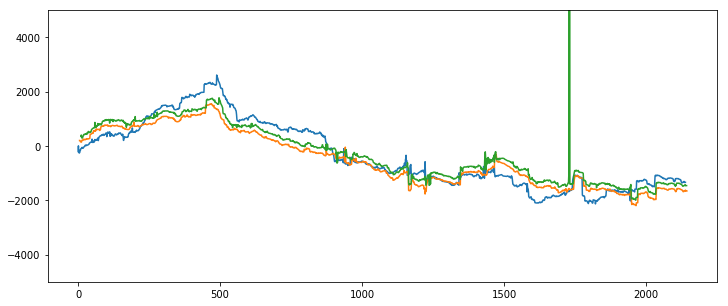

Counter({'74APD': 27, '388APD': 23, '558APD': 20, '1160APD': 17, '157APD': 17, '432APD': 16, '576APD': 15, '2374APD': 14, '460APD': 14, '116APD': 14, '326APD': 14, '53APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '520APD': 13, '2213APD': 11, '1004APD': 10, '72APD': 10, '162APD': 10, '370APD': 10, '8APD': 9, '1697APD': 9, '419APD': 9, '47APD': 9, '52APD': 9, '744APD': 9, '108APD': 8, '342APD': 8, '898APD': 8, '1769APD': 8, '407APD': 8, '462APD': 8, '1806APD': 8, '1379APD': 7, '355APD': 7, '2414APD': 7, '674APD': 7, '589APD': 7, '501APD': 6, '58APD': 6, '383APD': 6, '214APD': 6, '1279APD': 5, '445APD': 5, '650APD': 5, '302APD': 5, '2301APD': 4, '544APD': 4, '164APD': 4, '1874APD': 4, '1885APD': 4, '271APD': 4, '220APD': 4, '291APD': 4, '369APD': 4, '1426APD': 3, '1224APD': 3, '1391APD': 3, '1449APD': 3, '1818APD': 3, '2048APD': 3, '2091APD': 3, '230APD': 3, '428APD': 3, '672APD': 3, '150APD': 3, '799APD': 3, '1693APD': 3, '1612APD': 3, '178APD': 3, '1929APD': 3, '401APD': 3, '22

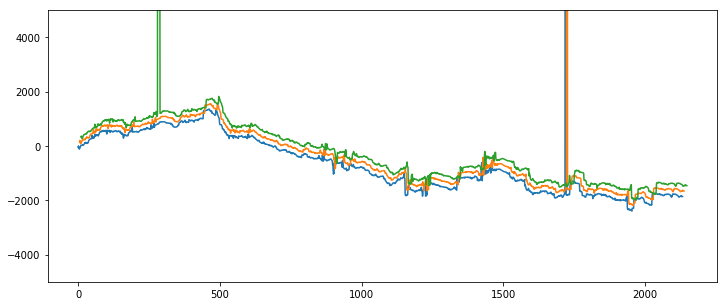

Counter({'74APD': 27, '388APD': 23, '558APD': 19, '230APD': 17, '157APD': 17, '1160APD': 16, '460APD': 15, '432APD': 15, '576APD': 15, '520APD': 14, '326APD': 14, '53APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '116APD': 13, '2213APD': 12, '8APD': 10, '72APD': 10, '1004APD': 9, '162APD': 9, '370APD': 9, '744APD': 9, '342APD': 8, '898APD': 8, '1769APD': 8, '1697APD': 8, '419APD': 8, '47APD': 8, '52APD': 8, '108APD': 7, '1379APD': 7, '355APD': 7, '462APD': 7, '1806APD': 7, '589APD': 7, '501APD': 6, '58APD': 6, '407APD': 6, '2414APD': 6, '674APD': 6, '2301APD': 5, '544APD': 5, '1279APD': 5, '383APD': 5, '445APD': 5, '650APD': 5, '214APD': 5, '1224APD': 4, '1391APD': 4, '1449APD': 4, '1818APD': 4, '2048APD': 4, '2091APD': 4, '428APD': 4, '672APD': 4, '150APD': 4, '799APD': 4, '1612APD': 4, '1874APD': 4, '1885APD': 4, '271APD': 4, '401APD': 4, '220APD': 4, '2374APD': 4, '291APD': 4, '369APD': 4, '1426APD': 3, '1693APD': 3, '164APD': 3, '178APD': 3, '1929APD': 3, '221APD': 3, '84AP

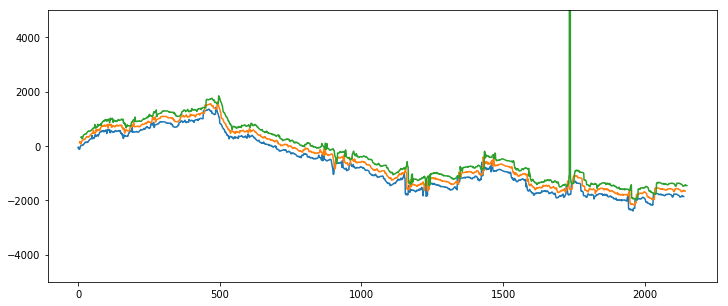

Counter({'74APD': 27, '388APD': 23, '558APD': 20, '230APD': 17, '157APD': 17, '1160APD': 16, '432APD': 15, '576APD': 15, '460APD': 14, '326APD': 14, '53APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '520APD': 13, '116APD': 13, '164APD': 13, '2213APD': 11, '1004APD': 10, '72APD': 10, '162APD': 10, '370APD': 10, '8APD': 9, '1697APD': 9, '419APD': 9, '47APD': 9, '52APD': 9, '744APD': 9, '108APD': 8, '342APD': 8, '898APD': 8, '1769APD': 8, '1806APD': 8, '1379APD': 7, '355APD': 7, '407APD': 7, '462APD': 7, '2414APD': 7, '674APD': 7, '589APD': 7, '501APD': 6, '58APD': 6, '214APD': 6, '2301APD': 5, '544APD': 5, '1279APD': 5, '383APD': 5, '2374APD': 5, '445APD': 5, '650APD': 5, '302APD': 5, '1224APD': 4, '1391APD': 4, '1449APD': 4, '1818APD': 4, '2048APD': 4, '2091APD': 4, '428APD': 4, '672APD': 4, '150APD': 4, '799APD': 4, '1612APD': 4, '1874APD': 4, '1885APD': 4, '271APD': 4, '220APD': 4, '339APD': 4, '291APD': 4, '369APD': 4, '1426APD': 3, '1693APD': 3, '178APD': 3, '1929APD': 3, '4

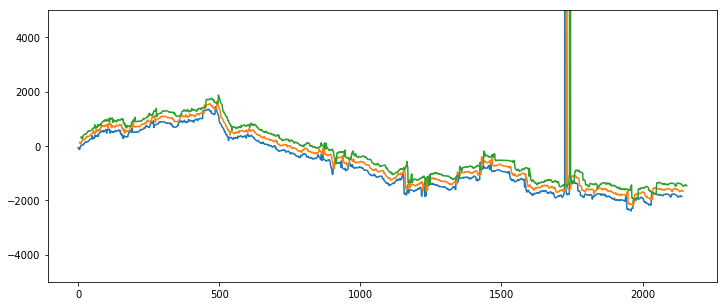

Counter({'74APD': 27, '558APD': 18, '388APD': 17, '157APD': 17, '230APD': 16, '1160APD': 15, '164APD': 15, '432APD': 14, '326APD': 14, '576APD': 14, '1497APD': 13, '2185APD': 13, '2213APD': 13, '2328APD': 13, '445APD': 13, '53APD': 13, '116APD': 12, '799APD': 11, '8APD': 10, '744APD': 10, '72APD': 9, '1004APD': 8, '342APD': 8, '898APD': 8, '1769APD': 8, '162APD': 8, '370APD': 8, '1379APD': 7, '355APD': 7, '407APD': 7, '462APD': 7, '1697APD': 7, '419APD': 7, '47APD': 7, '52APD': 7, '589APD': 7, '108APD': 6, '2301APD': 6, '544APD': 6, '1279APD': 6, '501APD': 6, '58APD': 6, '1806APD': 6, '650APD': 6, '214APD': 6, '1391APD': 5, '1449APD': 5, '1818APD': 5, '2048APD': 5, '428APD': 5, '672APD': 5, '150APD': 5, '2414APD': 5, '674APD': 5, '1612APD': 5, '1885APD': 5, '302APD': 5, '220APD': 5, '291APD': 5, '369APD': 5, '1224APD': 4, '2091APD': 4, '383APD': 4, '1874APD': 4, '271APD': 4, '1929APD': 4, '221APD': 4, '339APD': 4, '258APD': 4, '422APD': 4, '1426APD': 3, '1693APD': 3, '2374APD': 3, '520

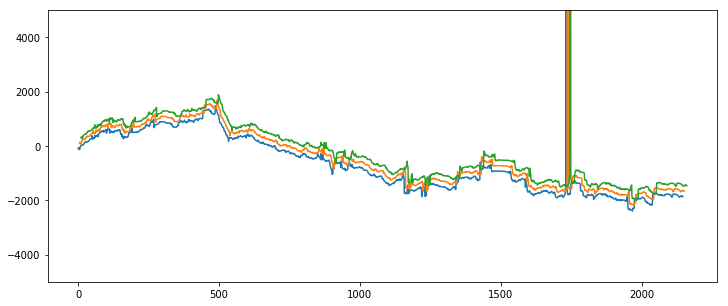

Counter({'74APD': 27, '558APD': 17, '388APD': 17, '462APD': 17, '157APD': 17, '230APD': 16, '1160APD': 15, '2213APD': 14, '432APD': 14, '326APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '576APD': 13, '116APD': 12, '650APD': 12, '445APD': 11, '53APD': 11, '799APD': 11, '744APD': 11, '8APD': 10, '1279APD': 8, '342APD': 8, '898APD': 8, '1769APD': 8, '407APD': 8, '1004APD': 7, '221APD': 7, '72APD': 7, '1379APD': 7, '355APD': 7, '162APD': 7, '370APD': 7, '1885APD': 7, '220APD': 7, '291APD': 7, '589APD': 7, '2301APD': 6, '544APD': 6, '501APD': 6, '58APD': 6, '1697APD': 6, '419APD': 6, '47APD': 6, '52APD': 6, '1929APD': 6, '214APD': 6, '258APD': 6, '369APD': 6, '108APD': 5, '1391APD': 5, '1449APD': 5, '1818APD': 5, '2048APD': 5, '428APD': 5, '672APD': 5, '150APD': 5, '1806APD': 5, '1612APD': 5, '302APD': 5, '422APD': 5, '1224APD': 4, '2091APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1874APD': 4, '271APD': 4, '339APD': 4, '491APD': 4, '1426APD': 3, '1693APD': 3, '178APD': 3, '180

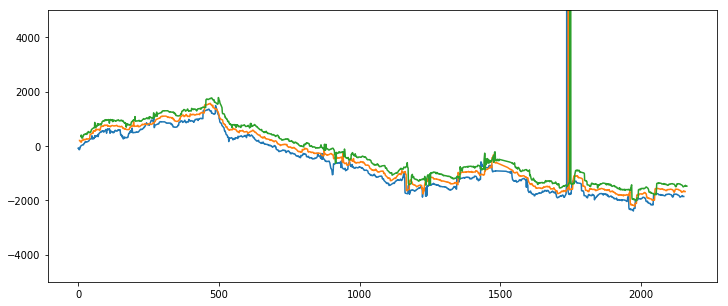

Counter({'74APD': 27, '558APD': 17, '388APD': 17, '407APD': 17, '157APD': 17, '230APD': 15, '2213APD': 14, '1160APD': 14, '326APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '432APD': 13, '576APD': 12, '8APD': 11, '116APD': 11, '650APD': 11, '445APD': 10, '53APD': 10, '744APD': 10, '150APD': 10, '799APD': 10, '1279APD': 9, '342APD': 8, '898APD': 8, '1769APD': 8, '462APD': 8, '1885APD': 8, '220APD': 8, '291APD': 8, '1004APD': 7, '2301APD': 7, '544APD': 7, '221APD': 7, '355APD': 7, '162APD': 7, '370APD': 7, '1929APD': 7, '258APD': 7, '369APD': 7, '589APD': 7, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '428APD': 6, '72APD': 6, '501APD': 6, '1379APD': 6, '58APD': 6, '1697APD': 6, '419APD': 6, '47APD': 6, '52APD': 6, '1612APD': 6, '214APD': 6, '422APD': 6, '108APD': 5, '672APD': 5, '1806APD': 5, '302APD': 5, '1224APD': 4, '2091APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1874APD': 4, '271APD': 4, '20APD': 4, '491APD': 4, '1426APD': 3, '1693APD': 3, '178APD': 3, '180

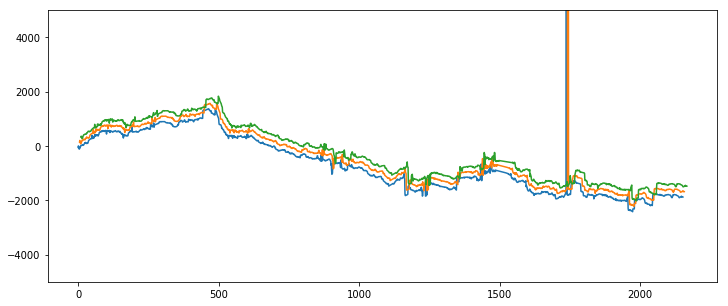

Counter({'74APD': 27, '388APD': 17, '157APD': 17, '558APD': 16, '407APD': 15, '462APD': 15, '230APD': 15, '1160APD': 14, '326APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '432APD': 13, '116APD': 11, '576APD': 11, '8APD': 10, '1279APD': 10, '650APD': 10, '150APD': 10, '799APD': 10, '445APD': 9, '53APD': 9, '744APD': 9, '1885APD': 9, '220APD': 9, '291APD': 9, '342APD': 8, '898APD': 8, '1769APD': 8, '369APD': 8, '258APD': 8, '2301APD': 7, '544APD': 7, '1929APD': 7, '355APD': 7, '422APD': 7, '589APD': 7, '1004APD': 6, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '428APD': 6, '221APD': 6, '501APD': 6, '1379APD': 6, '58APD': 6, '162APD': 6, '370APD': 6, '1612APD': 6, '672APD': 5, '72APD': 5, '1697APD': 5, '419APD': 5, '47APD': 5, '52APD': 5, '214APD': 5, '108APD': 4, '1224APD': 4, '2091APD': 4, '1806APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1874APD': 4, '271APD': 4, '401APD': 4, '339APD': 4, '20APD': 4, '421APD': 4, '1426APD': 3, '1693APD': 3, '178APD': 3, '1800AP

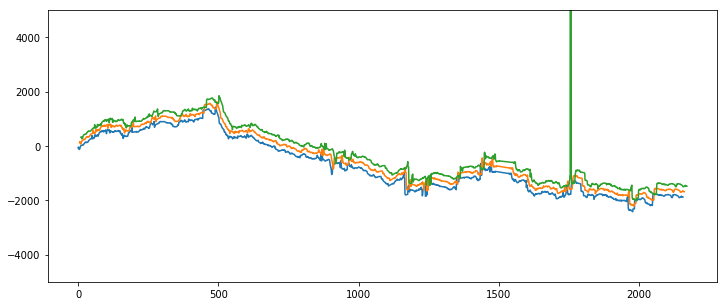

Counter({'74APD': 27, '898APD': 24, '157APD': 18, '388APD': 17, '558APD': 16, '230APD': 15, '1160APD': 14, '407APD': 14, '462APD': 14, '326APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '694APD': 13, '432APD': 13, '116APD': 11, '576APD': 11, '8APD': 10, '1279APD': 10, '650APD': 10, '150APD': 10, '799APD': 10, '445APD': 9, '53APD': 9, '744APD': 9, '1885APD': 9, '220APD': 9, '291APD': 9, '342APD': 8, '1769APD': 8, '369APD': 8, '258APD': 8, '2301APD': 7, '544APD': 7, '1929APD': 7, '355APD': 7, '422APD': 7, '589APD': 7, '1004APD': 6, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '428APD': 6, '221APD': 6, '501APD': 6, '1379APD': 6, '58APD': 6, '162APD': 6, '370APD': 6, '1612APD': 6, '214APD': 6, '672APD': 5, '72APD': 5, '1697APD': 5, '419APD': 5, '47APD': 5, '52APD': 5, '302APD': 5, '421APD': 5, '108APD': 4, '1224APD': 4, '2091APD': 4, '1806APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1874APD': 4, '271APD': 4, '339APD': 4, '20APD': 4, '1426APD': 3, '11APD': 3, '1693AP

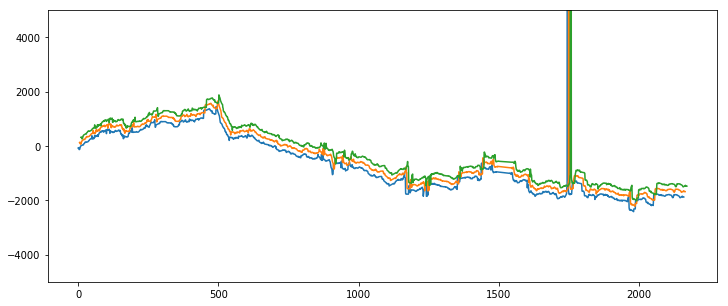

Counter({'74APD': 27, '898APD': 24, '157APD': 18, '388APD': 17, '558APD': 16, '230APD': 15, '1160APD': 14, '407APD': 14, '462APD': 14, '326APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '694APD': 13, '432APD': 13, '116APD': 11, '576APD': 11, '8APD': 10, '1279APD': 10, '650APD': 10, '150APD': 10, '799APD': 10, '445APD': 9, '53APD': 9, '744APD': 9, '1885APD': 9, '220APD': 9, '291APD': 9, '342APD': 8, '1769APD': 8, '369APD': 8, '258APD': 8, '2301APD': 7, '544APD': 7, '1929APD': 7, '355APD': 7, '422APD': 7, '589APD': 7, '1004APD': 6, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '428APD': 6, '221APD': 6, '501APD': 6, '1379APD': 6, '58APD': 6, '162APD': 6, '370APD': 6, '1612APD': 6, '214APD': 6, '672APD': 5, '72APD': 5, '1697APD': 5, '419APD': 5, '47APD': 5, '52APD': 5, '302APD': 5, '421APD': 5, '108APD': 4, '1224APD': 4, '2091APD': 4, '1806APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1874APD': 4, '271APD': 4, '339APD': 4, '20APD': 4, '1426APD': 3, '11APD': 3, '1693AP

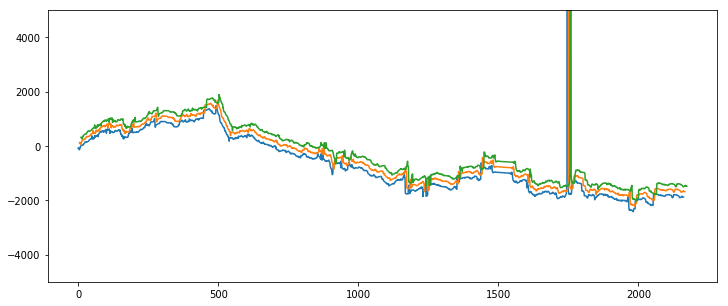

Counter({'74APD': 27, '898APD': 24, '157APD': 18, '558APD': 16, '388APD': 16, '230APD': 15, '1160APD': 14, '326APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '407APD': 13, '462APD': 13, '432APD': 13, '694APD': 12, '116APD': 11, '576APD': 11, '8APD': 10, '1279APD': 10, '650APD': 10, '150APD': 10, '799APD': 10, '2394APD': 9, '445APD': 9, '53APD': 9, '744APD': 9, '1885APD': 9, '220APD': 9, '291APD': 9, '342APD': 8, '1769APD': 8, '369APD': 8, '258APD': 8, '530APD': 7, '2301APD': 7, '544APD': 7, '1929APD': 7, '355APD': 7, '422APD': 7, '589APD': 7, '1004APD': 6, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '428APD': 6, '221APD': 6, '501APD': 6, '1379APD': 6, '58APD': 6, '162APD': 6, '370APD': 6, '1612APD': 6, '214APD': 6, '672APD': 5, '72APD': 5, '1697APD': 5, '419APD': 5, '47APD': 5, '52APD': 5, '302APD': 5, '421APD': 5, '108APD': 4, '1224APD': 4, '2091APD': 4, '11APD': 4, '1806APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1783APD': 4, '1874APD': 4, '271APD': 4, '2075

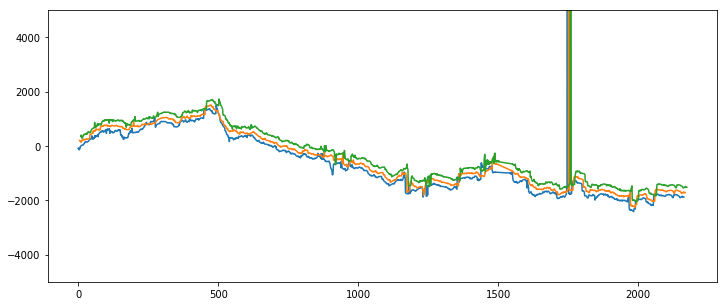

Counter({'74APD': 27, '898APD': 24, '355APD': 19, '157APD': 18, '558APD': 16, '388APD': 16, '230APD': 15, '1160APD': 14, '326APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '407APD': 13, '462APD': 13, '432APD': 13, '694APD': 12, '116APD': 11, '576APD': 11, '8APD': 10, '1279APD': 10, '650APD': 10, '150APD': 10, '799APD': 10, '2394APD': 9, '445APD': 9, '53APD': 9, '744APD': 9, '1885APD': 9, '220APD': 9, '291APD': 9, '342APD': 8, '1769APD': 8, '369APD': 8, '258APD': 8, '530APD': 7, '2301APD': 7, '544APD': 7, '1929APD': 7, '422APD': 7, '589APD': 7, '1004APD': 6, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '428APD': 6, '221APD': 6, '501APD': 6, '1379APD': 6, '58APD': 6, '162APD': 6, '370APD': 6, '1612APD': 6, '214APD': 6, '672APD': 5, '72APD': 5, '1697APD': 5, '419APD': 5, '47APD': 5, '52APD': 5, '302APD': 5, '421APD': 5, '108APD': 4, '1224APD': 4, '2091APD': 4, '11APD': 4, '1806APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1783APD': 4, '1874APD': 4, '271APD': 4, '207

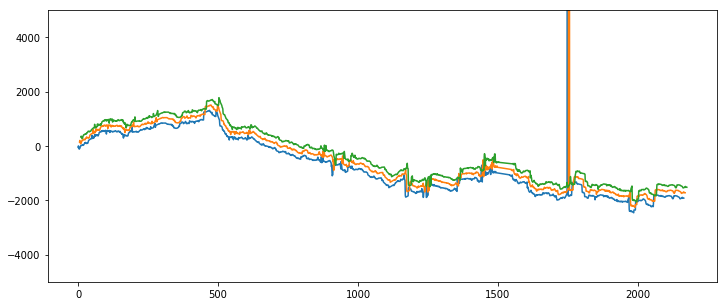

Counter({'74APD': 27, '898APD': 24, '355APD': 19, '157APD': 18, '558APD': 16, '388APD': 16, '230APD': 15, '1160APD': 14, '326APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '407APD': 13, '462APD': 13, '432APD': 13, '694APD': 12, '116APD': 11, '576APD': 11, '8APD': 10, '1279APD': 10, '650APD': 10, '150APD': 10, '799APD': 10, '2394APD': 9, '445APD': 9, '53APD': 9, '744APD': 9, '1885APD': 9, '220APD': 9, '291APD': 9, '342APD': 8, '1769APD': 8, '369APD': 8, '258APD': 8, '530APD': 7, '2301APD': 7, '544APD': 7, '1929APD': 7, '422APD': 7, '589APD': 7, '1004APD': 6, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '428APD': 6, '221APD': 6, '501APD': 6, '1379APD': 6, '58APD': 6, '162APD': 6, '370APD': 6, '1612APD': 6, '672APD': 5, '72APD': 5, '1697APD': 5, '419APD': 5, '47APD': 5, '52APD': 5, '214APD': 5, '421APD': 5, '108APD': 4, '1224APD': 4, '2091APD': 4, '11APD': 4, '1806APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1783APD': 4, '1874APD': 4, '271APD': 4, '2075APD': 4, '40

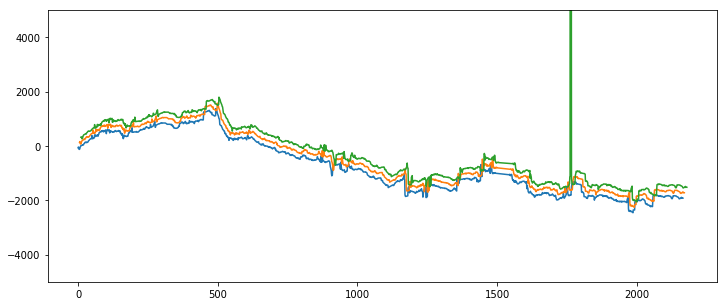

Counter({'74APD': 27, '898APD': 24, '355APD': 19, '157APD': 18, '558APD': 16, '388APD': 16, '1379APD': 16, '230APD': 15, '1160APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '407APD': 13, '462APD': 13, '432APD': 13, '326APD': 13, '694APD': 12, '576APD': 12, '116APD': 11, '8APD': 10, '1279APD': 10, '53APD': 10, '650APD': 10, '744APD': 10, '150APD': 10, '799APD': 10, '2394APD': 9, '445APD': 9, '1885APD': 9, '220APD': 9, '291APD': 9, '342APD': 8, '1769APD': 8, '369APD': 8, '258APD': 8, '530APD': 7, '2301APD': 7, '544APD': 7, '1929APD': 7, '401APD': 7, '422APD': 7, '589APD': 7, '1004APD': 6, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '428APD': 6, '221APD': 6, '72APD': 6, '501APD': 6, '58APD': 6, '162APD': 6, '370APD': 6, '1612APD': 6, '302APD': 6, '1224APD': 5, '672APD': 5, '1697APD': 5, '419APD': 5, '47APD': 5, '52APD': 5, '214APD': 5, '421APD': 5, '108APD': 4, '2091APD': 4, '11APD': 4, '1806APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1783APD': 4, '1874APD': 4, '

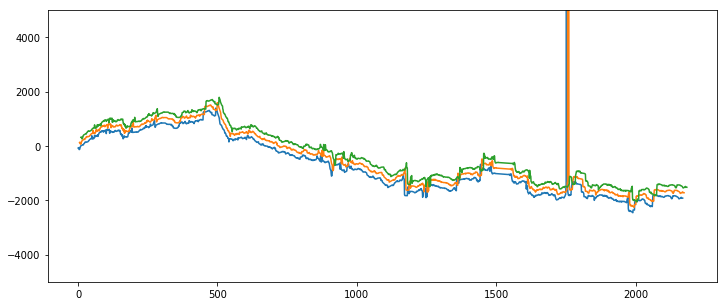

Counter({'74APD': 27, '898APD': 24, '355APD': 19, '157APD': 18, '558APD': 16, '388APD': 16, '1379APD': 16, '230APD': 15, '1160APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '407APD': 13, '462APD': 13, '432APD': 13, '326APD': 13, '694APD': 12, '576APD': 12, '116APD': 11, '8APD': 10, '1279APD': 10, '53APD': 10, '650APD': 10, '744APD': 10, '150APD': 10, '799APD': 10, '2394APD': 9, '445APD': 9, '1885APD': 9, '220APD': 9, '291APD': 9, '342APD': 8, '1769APD': 8, '369APD': 8, '258APD': 8, '530APD': 7, '2301APD': 7, '544APD': 7, '1929APD': 7, '422APD': 7, '589APD': 7, '1004APD': 6, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '428APD': 6, '221APD': 6, '72APD': 6, '501APD': 6, '401APD': 6, '58APD': 6, '162APD': 6, '370APD': 6, '1612APD': 6, '1224APD': 5, '672APD': 5, '1697APD': 5, '419APD': 5, '47APD': 5, '52APD': 5, '421APD': 5, '108APD': 4, '2091APD': 4, '11APD': 4, '1806APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1783APD': 4, '1874APD': 4, '271APD': 4, '2075APD': 4, 

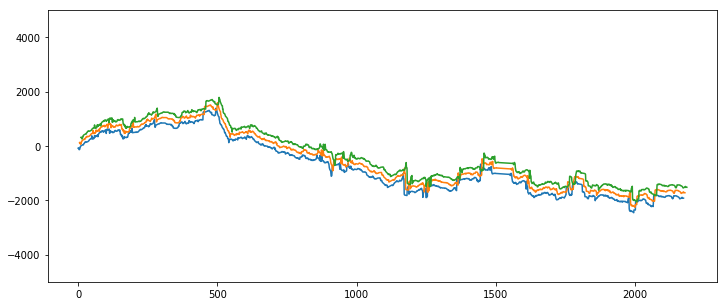

Counter({'74APD': 27, '898APD': 24, '355APD': 19, '157APD': 18, '558APD': 16, '388APD': 16, '1379APD': 16, '230APD': 15, '1160APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '407APD': 13, '462APD': 13, '432APD': 13, '326APD': 13, '694APD': 12, '576APD': 12, '116APD': 11, '8APD': 10, '1279APD': 10, '53APD': 10, '650APD': 10, '744APD': 10, '150APD': 10, '799APD': 10, '2394APD': 9, '445APD': 9, '1885APD': 9, '220APD': 9, '291APD': 9, '342APD': 8, '1769APD': 8, '369APD': 8, '258APD': 8, '530APD': 7, '2301APD': 7, '544APD': 7, '1929APD': 7, '422APD': 7, '589APD': 7, '1004APD': 6, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '428APD': 6, '221APD': 6, '72APD': 6, '501APD': 6, '401APD': 6, '58APD': 6, '162APD': 6, '370APD': 6, '1612APD': 6, '1224APD': 5, '672APD': 5, '1697APD': 5, '419APD': 5, '47APD': 5, '52APD': 5, '421APD': 5, '108APD': 4, '2091APD': 4, '11APD': 4, '1806APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1783APD': 4, '1874APD': 4, '271APD': 4, '2075APD': 4, 

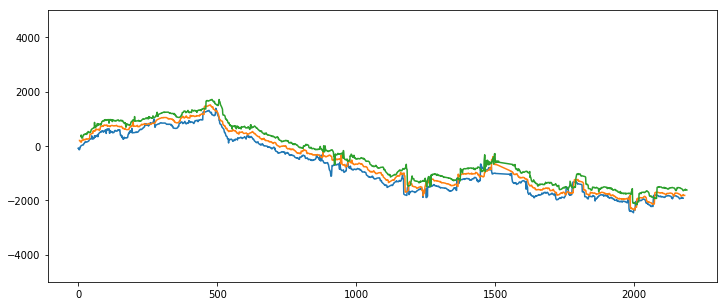

Counter({'74APD': 27, '898APD': 24, '355APD': 19, '157APD': 18, '342APD': 17, '558APD': 16, '388APD': 16, '1379APD': 16, '230APD': 15, '1160APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '407APD': 13, '462APD': 13, '432APD': 13, '326APD': 13, '694APD': 12, '116APD': 11, '1279APD': 11, '576APD': 11, '8APD': 10, '150APD': 10, '799APD': 10, '1885APD': 10, '291APD': 10, '2394APD': 9, '53APD': 9, '650APD': 9, '744APD': 9, '369APD': 9, '258APD': 9, '220APD': 8, '445APD': 8, '1769APD': 8, '422APD': 8, '530APD': 7, '2301APD': 7, '544APD': 7, '589APD': 7, '1004APD': 6, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '428APD': 6, '1929APD': 6, '501APD': 6, '401APD': 6, '58APD': 6, '162APD': 6, '370APD': 6, '1612APD': 6, '1224APD': 5, '672APD': 5, '221APD': 5, '72APD': 5, '1697APD': 5, '419APD': 5, '47APD': 5, '52APD': 5, '20APD': 5, '421APD': 5, '108APD': 4, '2091APD': 4, '11APD': 4, '1806APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1783APD': 4, '1874APD': 4, '271APD': 4, '2

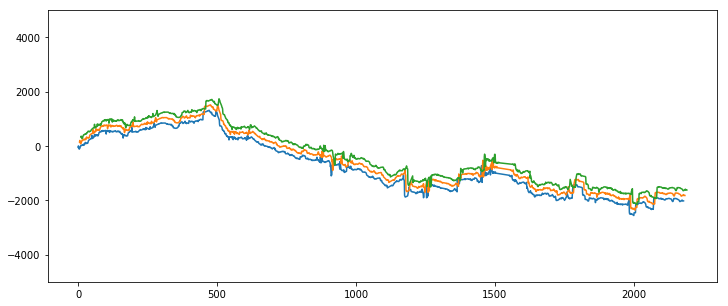

Counter({'74APD': 27, '898APD': 24, '355APD': 19, '157APD': 18, '342APD': 17, '558APD': 16, '388APD': 16, '1379APD': 16, '230APD': 15, '1160APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '407APD': 13, '462APD': 13, '432APD': 13, '326APD': 13, '694APD': 12, '1279APD': 12, '116APD': 11, '1885APD': 11, '8APD': 10, '576APD': 10, '150APD': 10, '799APD': 10, '369APD': 10, '258APD': 10, '2394APD': 9, '422APD': 9, '53APD': 8, '650APD': 8, '744APD': 8, '1769APD': 8, '530APD': 7, '2301APD': 7, '544APD': 7, '220APD': 7, '291APD': 7, '445APD': 7, '589APD': 7, '1004APD': 6, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '428APD': 6, '178APD': 6, '501APD': 6, '401APD': 6, '58APD': 6, '162APD': 6, '370APD': 6, '1612APD': 6, '20APD': 6, '1224APD': 5, '672APD': 5, '1929APD': 5, '1697APD': 5, '419APD': 5, '47APD': 5, '52APD': 5, '421APD': 5, '108APD': 4, '2091APD': 4, '11APD': 4, '221APD': 4, '72APD': 4, '1806APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1783APD': 4, '1874APD': 4, '

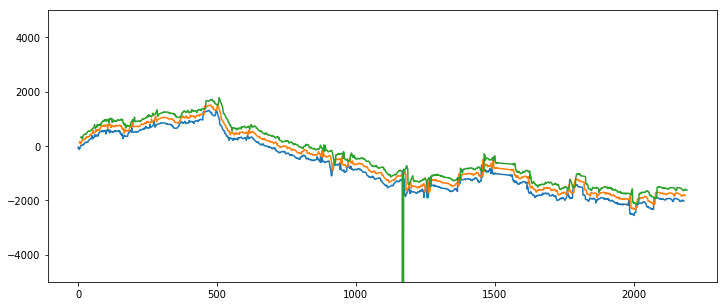

Counter({'74APD': 27, '898APD': 24, '355APD': 19, '157APD': 18, '342APD': 17, '558APD': 16, '388APD': 16, '1379APD': 16, '230APD': 15, '1160APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '407APD': 13, '462APD': 13, '432APD': 13, '326APD': 13, '694APD': 12, '1279APD': 12, '116APD': 11, '1885APD': 11, '369APD': 11, '8APD': 10, '150APD': 10, '799APD': 10, '258APD': 10, '2394APD': 9, '576APD': 9, '422APD': 9, '53APD': 8, '650APD': 8, '744APD': 8, '1769APD': 8, '530APD': 7, '2301APD': 7, '544APD': 7, '220APD': 7, '291APD': 7, '445APD': 7, '589APD': 7, '1004APD': 6, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '428APD': 6, '178APD': 6, '501APD': 6, '401APD': 6, '58APD': 6, '162APD': 6, '370APD': 6, '1612APD': 6, '20APD': 6, '1224APD': 5, '672APD': 5, '1929APD': 5, '1697APD': 5, '419APD': 5, '47APD': 5, '52APD': 5, '421APD': 5, '108APD': 4, '2091APD': 4, '11APD': 4, '221APD': 4, '72APD': 4, '1806APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1783APD': 4, '1874APD': 4, '2

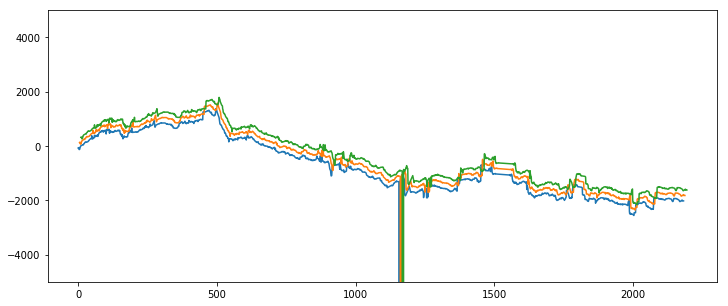

Counter({'74APD': 27, '898APD': 24, '355APD': 19, '157APD': 18, '342APD': 17, '558APD': 16, '388APD': 16, '1379APD': 16, '230APD': 15, '1160APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '407APD': 13, '462APD': 13, '432APD': 13, '326APD': 13, '694APD': 12, '1279APD': 12, '116APD': 11, '1885APD': 11, '369APD': 11, '8APD': 10, '1693APD': 10, '799APD': 10, '258APD': 10, '2394APD': 9, '576APD': 9, '150APD': 9, '422APD': 9, '53APD': 8, '650APD': 8, '744APD': 8, '1769APD': 8, '530APD': 7, '2301APD': 7, '544APD': 7, '220APD': 7, '291APD': 7, '445APD': 7, '589APD': 7, '1004APD': 6, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '428APD': 6, '178APD': 6, '501APD': 6, '401APD': 6, '58APD': 6, '162APD': 6, '370APD': 6, '1612APD': 6, '20APD': 6, '1224APD': 5, '672APD': 5, '1929APD': 5, '1697APD': 5, '419APD': 5, '47APD': 5, '52APD': 5, '421APD': 5, '108APD': 4, '2091APD': 4, '11APD': 4, '221APD': 4, '72APD': 4, '1806APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1783APD': 4, '1

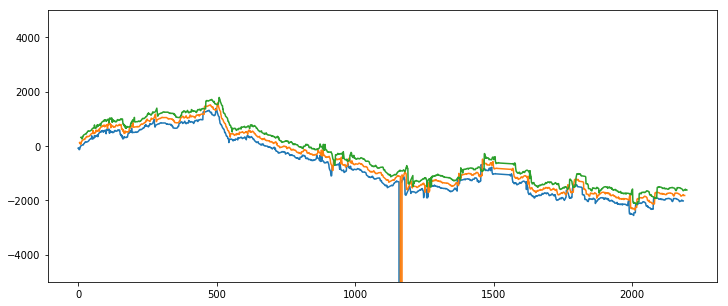

Counter({'74APD': 27, '898APD': 24, '355APD': 19, '157APD': 18, '342APD': 17, '558APD': 16, '388APD': 16, '1379APD': 16, '230APD': 15, '1160APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '407APD': 13, '462APD': 13, '432APD': 13, '326APD': 13, '694APD': 12, '1279APD': 12, '116APD': 11, '1885APD': 11, '8APD': 10, '1693APD': 10, '576APD': 10, '799APD': 10, '369APD': 10, '258APD': 10, '2394APD': 9, '422APD': 9, '53APD': 8, '650APD': 8, '744APD': 8, '1769APD': 8, '150APD': 8, '530APD': 7, '2301APD': 7, '544APD': 7, '220APD': 7, '291APD': 7, '445APD': 7, '589APD': 7, '1004APD': 6, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '428APD': 6, '178APD': 6, '501APD': 6, '401APD': 6, '58APD': 6, '162APD': 6, '370APD': 6, '1612APD': 6, '20APD': 6, '1224APD': 5, '672APD': 5, '1929APD': 5, '1697APD': 5, '419APD': 5, '47APD': 5, '52APD': 5, '421APD': 5, '108APD': 4, '2091APD': 4, '11APD': 4, '221APD': 4, '72APD': 4, '1806APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1783APD': 4, '

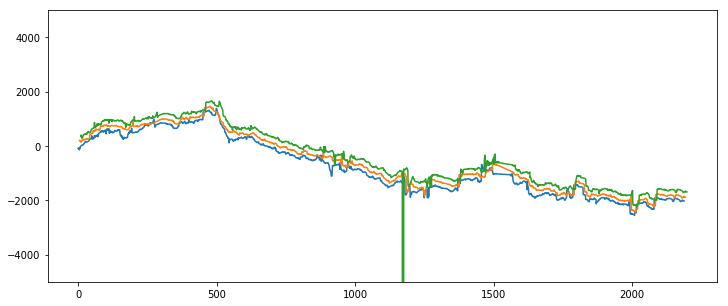

Counter({'74APD': 27, '898APD': 24, '355APD': 19, '157APD': 18, '342APD': 17, '558APD': 16, '388APD': 16, '1379APD': 16, '230APD': 15, '1160APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '407APD': 13, '462APD': 13, '432APD': 13, '326APD': 13, '694APD': 12, '1279APD': 12, '116APD': 11, '1885APD': 11, '369APD': 11, '8APD': 10, '1693APD': 10, '799APD': 10, '258APD': 10, '2394APD': 9, '576APD': 9, '422APD': 9, '53APD': 8, '650APD': 8, '744APD': 8, '1769APD': 8, '150APD': 8, '530APD': 7, '2301APD': 7, '544APD': 7, '220APD': 7, '291APD': 7, '445APD': 7, '589APD': 7, '1004APD': 6, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '428APD': 6, '178APD': 6, '501APD': 6, '401APD': 6, '58APD': 6, '162APD': 6, '370APD': 6, '1612APD': 6, '20APD': 6, '1224APD': 5, '672APD': 5, '1929APD': 5, '1697APD': 5, '419APD': 5, '47APD': 5, '52APD': 5, '421APD': 5, '108APD': 4, '2091APD': 4, '11APD': 4, '221APD': 4, '72APD': 4, '1806APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1783APD': 4, '1

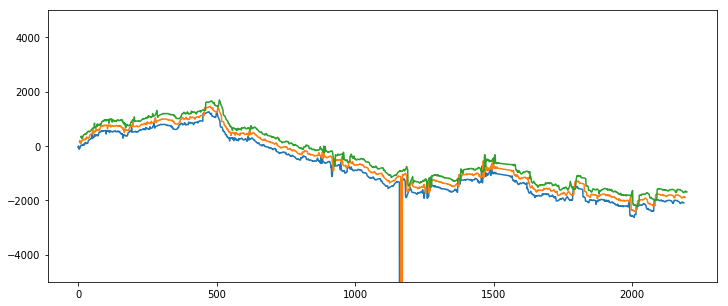

Counter({'74APD': 27, '898APD': 24, '355APD': 19, '157APD': 18, '342APD': 17, '558APD': 16, '388APD': 16, '1379APD': 16, '230APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '1160APD': 13, '407APD': 13, '462APD': 13, '432APD': 13, '326APD': 13, '694APD': 12, '1279APD': 12, '116APD': 11, '1885APD': 11, '8APD': 10, '1693APD': 10, '576APD': 10, '369APD': 10, '258APD': 10, '2394APD': 9, '799APD': 9, '422APD': 9, '53APD': 8, '650APD': 8, '744APD': 8, '1769APD': 8, '150APD': 8, '530APD': 7, '2301APD': 7, '428APD': 7, '544APD': 7, '220APD': 7, '291APD': 7, '445APD': 7, '589APD': 7, '1004APD': 6, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '178APD': 6, '501APD': 6, '401APD': 6, '58APD': 6, '162APD': 6, '370APD': 6, '1612APD': 6, '20APD': 6, '1224APD': 5, '672APD': 5, '1929APD': 5, '1697APD': 5, '419APD': 5, '47APD': 5, '52APD': 5, '421APD': 5, '108APD': 4, '2091APD': 4, '11APD': 4, '221APD': 4, '72APD': 4, '1806APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1783APD': 4, '1

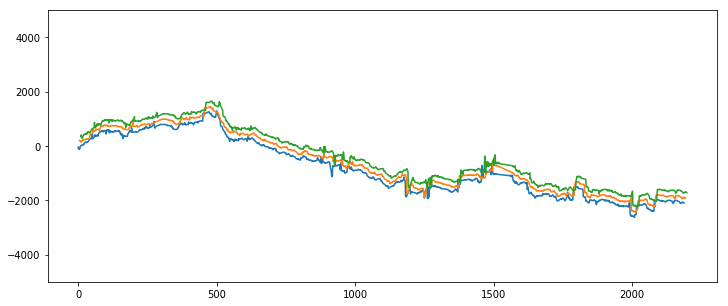

Counter({'74APD': 27, '898APD': 24, '355APD': 19, '157APD': 18, '342APD': 17, '558APD': 16, '388APD': 16, '1379APD': 16, '230APD': 14, '1497APD': 13, '2185APD': 13, '2328APD': 13, '1160APD': 13, '407APD': 13, '462APD': 13, '432APD': 13, '326APD': 13, '694APD': 12, '1279APD': 12, '116APD': 11, '1885APD': 11, '8APD': 10, '1693APD': 10, '576APD': 10, '369APD': 10, '258APD': 10, '2394APD': 9, '799APD': 9, '422APD': 9, '53APD': 8, '650APD': 8, '744APD': 8, '1769APD': 8, '150APD': 8, '530APD': 7, '2301APD': 7, '428APD': 7, '544APD': 7, '220APD': 7, '291APD': 7, '445APD': 7, '589APD': 7, '1004APD': 6, '1391APD': 6, '1449APD': 6, '1818APD': 6, '2048APD': 6, '178APD': 6, '501APD': 6, '401APD': 6, '58APD': 6, '162APD': 6, '370APD': 6, '1612APD': 6, '20APD': 6, '1224APD': 5, '672APD': 5, '1929APD': 5, '1697APD': 5, '419APD': 5, '47APD': 5, '52APD': 5, '421APD': 5, '108APD': 4, '2091APD': 4, '11APD': 4, '221APD': 4, '72APD': 4, '1806APD': 4, '2414APD': 4, '383APD': 4, '674APD': 4, '1783APD': 4, '1

In [220]:

datei = 'my_apd1998.lst'
data = read_file(datei)
G = nx.DiGraph()
for a,b,d in data:
    G.add_edge(a,b)
    
S = set(nx.predecessor(G,'2345APD_0'))
T = set(nx.predecessor(G.reverse(),'2080APD_0'))

#data = connected(data)
schnitt = T&S
data = [
    (a,b,d) 
    for a,b,d in data
    if {a,b} < schnitt
]
data = [
    (a,b,d) 
    for a,b,d in data
    if a != b or d > 1000
]

"""
while True:
    s = {a for a,_,_ in data}
    t = {a for _,a,_ in data}
    x1 = s - t - {'2345APD_0'}
    x2 = t - s - {'2080APD_0'}
    print(len(x1), len(x2))
    if x1 == x2 == set():
        break
    data = [[a,b,d] for a,b,d in data if not a in x1 and not b in x2]
"""

count = coll.Counter((a,b) for a, b, d in data)
abgesichert = set()
for (i,j), a in count.items():
    if a > 1:
        abgesichert |= {i,j}
abgesichert |= set(feste_position)


roh_data = [(contig_name(a), contig_name(b), int(d)) for a,b,d in data]

contig_repeat = coll.defaultdict(list)
for contig in feste_position:
    contig_repeat[contig_name(contig)].append(contig)
    

repeats = {k for k, v in contig_repeat.items() if len(v) > 1}
print(len(repeats),'repeats zu Beginn')
#good_data, bad_data, _ = umsortieren(roh_data, contig_repeat, feste_position)
#constr_pos = get_constr_pos(good_data, bad_data, feste_position, repeats)
constr_pos = get_constr_pos(roh_data, feste_position, contig_repeat)
position, contig_repeat, gruppen = get_repeat(constr_pos, min_güte = 300)
good_data, bad_data, missing_data = umsortieren(roh_data, contig_repeat, position)
data = good_data + bad_data + missing_data

contigs = get_contigs(data)

for contig in contigs:
    if contig_name(contig) not in contig_repeat:
        contig_repeat[contig_name(contig)] = [contig]
        
        
repeats = {k for k, v in contig_repeat.items() if len(v) > 1}
print(len(repeats), 'repeats danach')
#position = solve_LP(contigs, data, feste_position)

#contig_repeat = coll.defaultdict(list)
#for contig in position:
#    contig_repeat[contig_name(contig)].append(contig)
#good_data, data, _ = umsortieren(roh_data, contig_repeat, feste_position) 

min_güte = 300
untere_schranke = 10
ii = 0
while min_güte >= untere_schranke:
    ii += 1
    print()
    print(str(ii)+'. Durchlauf, güte =', min_güte)
    
    sicher = set()
    unsicher = set()
    for a, G in gruppen.items():
        for i,g in enumerate(G):
            if g.güte_0 > min(50, min_güte):
                sicher.add(contig_repeat[a][i])
            elif g.güte_0 > min(50, min_güte):
                unsicher.add(contig_repeat[a][i])
    feste_position = {contig: pos for contig, pos in position.items() if contig in sicher}
    print('anzahl feste:', len(feste_position))
   # print('332APD_1' in position)
    #print(contig_repeat['332APD'])
    print('%doppeltdata', round(100*len(data)/len(roh_data)-100,2))
    print('%feste', round(100*len(feste_position)/len(position),2))
    if len(position) != len(feste_position):
        position = solve_LP(get_contigs(data), data, feste_position)
    
    intName = get_intName(position)
    x = []
    a = []
    for i in range(3000):
        if not i in intName:
            break
        c = contig_name(intName[i])
        if c in reps|repeats:
            continue
        if not c+'_0' in intNameX:
            continue
        x.append(i)
        a.append(position[intName[i]] - pos[intName[i]])
    plt.plot(x,a,)
    plt.ylim(-5000,5000)
    
    print('max', max(position.values()))
    print('*')
    print('mean', sum([abs(position[b] - position[a] -d) for a,b,d in data])//len(data))
    good_data, bad_data, _  = umsortieren(roh_data, contig_repeat, position)
    data = good_data + bad_data
    
    print('100: %', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 100])/len(data))
    print('500: %', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 500])/len(data))
    print('2000:%', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 2000])/len(data))
    if ii % 5 == 1 or min_güte == untere_schranke:
        tol = 2000
        s = coll.defaultdict(coll.Counter)
        p = coll.defaultdict(coll.Counter)

        for a, b, dist in data:
            real_dist = position[b] - position[a]
            if abs(real_dist - dist) < tol and a != b:
                if position[a] > position[b]:
                    a, b, real_dist = b, a, -real_dist
                s[a][b] += 1
                p[b][a] += 1

        intName = get_intName(position)
        ss = {a: sorted(s[a], key = lambda x: intName[x]) for a in s}
        pp = {a: sorted(p[a], key = lambda x: intName[x], reverse = True) for a in p}
        
        ss = {a: sorted(ss[a], key = lambda x: s[a][x])[-5:] for a in s}
        pp = {a: sorted(pp[a], key = lambda x: p[a][x])[-5:] for a in p}
        
        dataX = [
            [a,b,d] 
            for a,b,d in data 
            if (
                ((a in ss and b in ss[a]) or (b in pp and a in pp[b])) and 
                -tol < position[b] - position[a] - d < tol
            )
        ]
        position = solve_LP_standard(position, dataX)
        print('max', max(position.values()))
        print('mean', sum([abs(position[b] - position[a] -d) for a,b,d in data])//len(data))
        print('100: %', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 100])/len(data))
        print('500: %', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 500])/len(data))
        print('2000:%', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 2000])/len(data))
        
   
    intName = get_intName(position)
    x = []
    a = []
    for i in range(3000):
        if not i in intName:
            break
        c = contig_name(intName[i])
        if c in reps|repeats:
            continue
        if not c+'_0' in intNameX:
            continue
        x.append(5 + i)
        a.append(200 + position[intName[i]] - pos[intName[i]])
    plt.plot(x,a)
    plt.ylim(-5000,5000)

 #   constr_pos = get_constr_pos(good_data, bad_data, position, repeats)
    constr_pos = get_constr_pos(roh_data, position, contig_repeat)    
    position, contig_repeat, gruppen = get_repeat(constr_pos, 500, min_güte = min_güte)
    
    repeats_neu = {k for k, v in contig_repeat.items() if len(v) > 1}
    neu = len(repeats_neu-repeats)
    futsch = len(repeats - repeats_neu)
    print('anzahl neuer Repeats:', neu)
    print(repeats_neu-repeats)
    print('anzahl gelöschter Repeats:', futsch)
    print(repeats - repeats_neu)
    print(len(reps - repeats),len(reps & repeats),len(repeats-reps ))
    print(len(reps - repeats_neu),len(reps & repeats_neu),len(repeats_neu-reps ))
#    min_güte*0.9
    if neu < 6:
        zuende = min_güte == untere_schranke and neu + futsch == 0
        min_güte /= 1 + 0.3*((6 - neu)/6)
        if min_güte < untere_schranke and not zuende:
            min_güte = untere_schranke
    
    repeats = repeats_neu
    print('anz Repeats:', len(repeats))
   # print(position)
    #print(contig_repeat)
    print('ordne neu:')
    good_data, bad_data, _  = umsortieren(roh_data, contig_repeat, position)
    data = good_data+bad_data
    print('mean', sum([abs(position[b] - position[a] -d) for a,b,d in data])//len(data))
    print('100: %', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 100])/len(data))
    print('500: %', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 500])/len(data))
    print('2000:%', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 2000])/len(data))
    """print()
    print()
    s = coll.defaultdict(coll.Counter)
    p = coll.defaultdict(coll.Counter)
    graph = nx.DiGraph()

    for a, b, dist in data:
        if a not in feste_position or b not in feste_position:
            continue
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < 2000 and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a][b] += 1
            p[b][a] += 1


    ss = {a: sorted(s[a], key = lambda x: s[a][x])[-5:] for a in s}
    pp = {a: sorted(p[a], key = lambda x: p[a][x])[-5:] for a in p}
    for a in ss:
        for b in ss[a]:
            graph.add_edge(a,b)
    for b in pp:
        for a in pp[b]:
            graph.add_edge(a,b)
    intName = get_intName(position)
    
    print('::::::::::::::::::::::::')
    for k in nx.weakly_connected_components(graph):
        print(len(k))
        """
    
    intName = get_intName(position)
    x = []
    a = []
    for i in range(3000):
        if not i in intName:
            break
        c = contig_name(intName[i])
        if c in reps|repeats:
            continue
        if not c+'_0' in intNameX:
            continue
        x.append(10 + i)
        a.append(400 + position[intName[i]] - pos[intName[i]])
    plt.plot(x,a,)
    plt.ylim(-5000,5000)

    plt.show()
    datei = 'my_apd1998.lst'
    dataR = read_file(datei)
    G = nx.DiGraph()
    for a,b,d in dataR:
        G.add_edge(a,b)

    S = set(nx.predecessor(G,'2345APD_0'))
    T = set(nx.predecessor(G.reverse(),'2080APD_0'))

    #data = connected(data)
    erreichbar = T&S
    dataR = [
        (a,b,d) 
        for a,b,d in dataR
        if a in erreichbar and b in erreichbar
    ]
    dataR = [
        [a,b,d]
        for a,b,d in dataR
        if a != b or d > 1000
    ]
    positionY = position


    contig_repeatR = coll.defaultdict(list)
    for contig in positionY:
        contig_repeatR[contig_name(contig)].append(contig)

    repeats = {k for k, v in contig_repeatR.items() if len(v) > 1}
    positionY = position
    data2 = [[a,b,d] for a,b,d in dataR]
    umsortieren2(data2,contig_repeatR,positionY )
    
    z = coll.defaultdict(list)
    for a,b,d in data2:
        if a>b:
            z[(b,a)].append(-d)
        elif a<b:
            z[(a,b)].append(d)

    Z = {x: gruppiert(z[x], 500) for x in z}

    data3 = [[dist,a,b,gewicht] for (a,b),liste in Z.items() for dist,gewicht in liste]
    for da in data3:
        d,a,b,g = da
        if d < 0:
            da[0] = -d
            da[1] = b
            da[2] = a 
            da[3] = g
    for da in data3:
        d,a,b,g = da
        if d < 0:
            da[0] = -d
            da[1] = b
            da[2] = a 
            da[3] = g


    intName = get_intName(positionY)
    data4 = [(a,b,d,g) for d,a,b,g in data3 if g > 2 and not -5000 <= positionY[b] - positionY[a] - d <= 5000]
    K = coll.Counter()
    for a,b,d,g in data4:
        if True:# {a,b}& {'326APD_0'}:#{'58APD_0','58APD_1','58APD_2','501APD_1','501APD_0'}:
            #print(intName[a],intName[b],positionY[b]-positionY[a]-d,g)
            #print(positionY[b[:-2]+'_0']-positionY[a[:-2]+'_0']-d,g)
            #print(positionY[b]-positionY[a]-d,g)
            #print(a,b,d,g)
            K[a[:-2]] += 1
            K[b[:-2]] += 1
    print(K)

In [127]:
print(position)

{'409APD_0': 4623616.0, '2452APD_0': 3193236.0, '1549APD_0': 2120843.0, '1490APD_0': 3795205.0, '1281APD_0': 456823.0, '1825APD_0': 2009420.0, '319APD_0': 2799749.0, '419APD_0': 3451550.0, '419APD_1': 3484193.0, '2379APD_0': 2059926.0, '1427APD_0': 2884698.0, '1260APD_0': 4849221.0, '1945APD_0': 2917791.0, '522APD_0': 2668253.0, '995APD_0': 866090.0, '1032APD_0': 4379910.0, '687APD_0': 3973739.0, '1532APD_0': 2541275.0, '348APD_0': 1268425.0, '1388APD_0': 3084500.0, '148APD_0': 1971409.0, '591APD_0': 3076700.0, '589APD_0': 788320.0, '72APD_0': 2850297.0, '72APD_1': 2947164.0, '1918APD_0': 4793710.0, '950APD_0': 2387439.0, '1699APD_0': 2694165.0, '738APD_0': 1985274.0, '962APD_0': 3681326.0, '1494APD_0': 326751.0, '416APD_0': 4043857.0, '828APD_0': 3697916.0, '975APD_0': 1697467.0, '623APD_0': 1137207.0, '1180APD_0': 4682551.0, '61APD_0': 2252415.0, '257APD_0': 2982985.0, '2187APD_0': 2036468.0, '2398APD_0': 2013772.0, '1769APD_0': 1246869.0, '1769APD_1': 2987146.0, '1115APD_0': 4577939

In [ ]:
for i in range(3000):
    print(intNameX[intName[i][:-2]+'_0'])

In [185]:
repeats = set()
for r in contig_repeat:
    if len(contig_repeat[r]) > 1:
        repeats.add(r)

In [188]:
for r in repeats-reps:
    print(intName[r+'_0'])

1152
1148
1251
1517
661
1166
458
483
1852
499
515
1756
1530
1759
1147
467
1814
1525
1153
1533
1151
285
1163
1160
457
1110


In [ ]:
LP Opt: 49.83442986487747
max 4898819.0
mean 5927.0
100: % 0.6342389556721697
500: % 0.8876033962548149
2000:% 0.9639301865750781
anzahl neuer Repeats: 0
set()
anzahl gelöschter Repeats: 0
set()
14 28 37
14 28 37
anz Repeats: 65
ordne neu:
mean 6081.0
100: % 0.6474983267541763
500: % 0.9039625192935488
2000:% 0.9622051331084127

In [185]:
iN = get_intName(position)
L = []
for c,G in gruppen.items():
    for k, g in enumerate(G):
        L.append([iN[contig_repeat[c][k]], int(g.güte), int(g.güte_0), len(contig_repeat[c])>1])

In [186]:
gruppen['501APD']

[Repeat(pos=1298767.0, güte=110.16511285456724, güte_0=125.05052124461508, stärke=53, gewicht=13, in_out=1, genauigkeit=0.5617135241527481),
 Repeat(pos=1353463.0, güte=20.2044133586151, güte_0=25.255516698268874, stärke=19, gewicht=4, in_out=1, genauigkeit=0.5316950883846079)]

In [184]:
L.sort()
L2 = [L[0]]
for a,b,c in zip(L[:-2],L[1:-1],L[2:]):
    if b[2]*3 < min(a[2],c[2]):
        b.append('H')
    print(b)
L2.append(L[-1])

[1, 235, 267, False]
[2, 52, 62, False, 'H']
[3, 236, 268, False]
[4, 226, 257, False]
[5, 222, 254, False]
[6, 205, 238, False]
[7, 241, 279, False]
[8, 243, 275, False]
[9, 331, 374, False]
[10, 320, 361, False]
[11, 0, 1, False, 'H']
[12, 326, 368, False]
[13, 318, 360, False]
[14, 90, 108, False, 'H']
[15, 298, 337, False]
[16, 266, 300, False]
[17, 0, 2, False, 'H']
[18, 278, 314, False]
[19, 67, 82, False, 'H']
[20, 244, 283, False]
[21, 246, 285, False]
[22, 38, 51, False, 'H']
[23, 211, 249, False]
[24, 29, 38, False, 'H']
[25, 218, 257, False]
[26, 171, 208, False]
[27, 225, 265, False]
[28, 271, 312, False]
[29, 305, 351, False]
[30, 320, 369, False]
[31, 341, 389, False]
[32, 336, 381, False]
[33, 338, 382, False]
[34, 332, 376, False]
[35, 288, 330, False]
[36, 258, 297, False]
[37, 0, 0, False, 'H']
[38, 211, 248, False]
[39, 232, 268, False]
[40, 258, 297, False]
[41, 266, 306, False]
[42, 246, 285, False]
[43, 250, 289, False]
[44, 250, 289, False]
[45, 23, 31, False, 'H

[1342, 450, 513, False]
[1343, 265, 313, False]
[1344, 325, 379, False]
[1345, 254, 299, False]
[1346, 438, 499, False]
[1347, 469, 533, False]
[1348, 156, 190, False]
[1349, 511, 580, False]
[1350, 289, 326, False]
[1351, 478, 536, False]
[1352, 551, 619, False]
[1353, 519, 587, False]
[1354, 510, 579, False]
[1355, 484, 549, False]
[1356, 201, 237, False]
[1357, 418, 476, False]
[1358, 228, 259, False]
[1359, 190, 224, False]
[1360, 579, 657, False]
[1361, 184, 215, False]
[1362, 233, 272, False]
[1363, 226, 270, False]
[1364, 331, 379, False]
[1365, 328, 376, False]
[1366, 319, 365, False]
[1367, 138, 168, False]
[1368, 127, 151, False]
[1369, 158, 180, False]
[1370, 250, 285, False]
[1371, 191, 216, False]
[1372, 240, 272, False]
[1373, 84, 100, False]
[1374, 230, 260, False]
[1375, 94, 112, False]
[1376, 283, 318, False]
[1377, 290, 326, False]
[1378, 419, 473, False]
[1379, 18, 23, False, 'H']
[1380, 438, 493, False]
[1381, 317, 357, False]
[1382, 80, 97, False]
[1383, 94, 112, F

In [107]:
reps-repeats

{'1360APD',
 '1554APD',
 '162APD',
 '175APD',
 '1806APD',
 '2075APD',
 '2443APD',
 '2457APD',
 '371APD',
 '40APD',
 '47APD',
 '873APD'}

In [94]:
len(L2),len(L)

(1994, 2199)

In [65]:
constr_pos = get_constr_pos(roh_data, feste_position, contig_repeat)

In [67]:
gruppierung(constr_pos['1APD'],500,0)

[0, 255]
[0, 255]
[137, 3000]
[265, 3000]
[265, 3000]
[265, 3000]
[265, 3000]
[265, 273]
[265, 273]
[265, 273]
[265, 273]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 272]
[265, 271]
[265, 271]
[265, 271]
[265, 271]
[265, 271]
[265, 271]
[265, 271]
[265, 271]
[265, 271]
[265, 271]
[265, 271]
[265, 271]
[265, 271]
[265, 271]
[265, 270]
[265, 270]
[265, 270]
[265, 270]
[265, 270]
[265, 270]
[265, 270]
[265, 270]
[265, 270]
[265, 270]
[265, 270]
[265, 270]
[265, 270]
[265, 270]
[265, 270]
[265, 270]
[265, 270]
[265, 270]
[265, 270]
[265, 270]
[265, 269]
[265, 269]
[265, 269]
[265, 269]
[265, 269]
[265, 269]
[265, 269]
[265, 269]
[265, 269]
[265, 269]
[267, 269]
[267, 269]
[267, 269]
[267, 269]
[267, 269]
[267, 269]
[267, 269]
[267, 269]
[267, 269]
[267, 269]
[267, 269]
[267, 269]
[267, 269]
[267, 269]
[267, 269

[Repeat(pos=552102.2460925626, güte=0, güte_0=1.5625, stärke=2, gewicht=2, in_out=0, genauigkeit=1.0416666666666667),
 Repeat(pos=592937.0, güte=0, güte_0=0.375, stärke=1, gewicht=1, in_out=0, genauigkeit=1.5),
 Repeat(pos=615091.9467177877, güte=0, güte_0=500.85023821831896, stärke=173, gewicht=13, in_out=1, genauigkeit=0.6892345269671047),
 Repeat(pos=678021.0, güte=0, güte_0=0.375, stärke=1, gewicht=1, in_out=0, genauigkeit=1.5),
 Repeat(pos=686162.0181128642, güte=0, güte_0=25.804704017851833, stärke=17, gewicht=8, in_out=0, genauigkeit=0.867385009003423)]

In [68]:
len({None})

1

In [61]:
iN['1APD_0']

268

In [55]:
iN = get_intName(feste_position)

Es gibt unzusammenhängende Regionen in den Daten
99.63% der Contigs sind in der größten Komponente.
Optimize a model with 201891 rows, 69494 columns and 471079 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-05, 1e-05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 1.92s
Presolved: 69494 rows, 201891 columns, 471079 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.447e+05
 Factor NZ  : 7.967e+05 (roughly 120 MBytes of memory)
 Factor Ops : 1.511e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.34589000e+07  5.00000000e+02  1.00e-01 1.63e+03  1.38e+03     2s
   1  -2.16688609e+07  2.81512716e+03  7.63e-14 9.60e+02  1.62e+02     3s
   2  -5.53377483e+06  1.99770471e+03  8.32

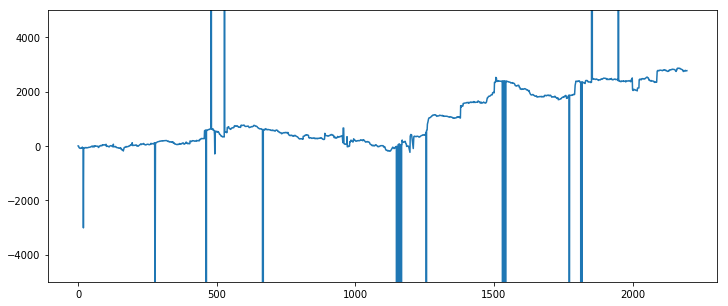

In [38]:

datei = 'my_apd1998.lst'
data = read_file(datei)

data = connected(data)
data = [
    (a,b,d) 
    for a,b,d in data
    if a != b or d > 1000
]
roh_data = [(contig_name(a), contig_name(b), int(d)) for a,b,d in data]

good_data, bad_data, _  = umsortieren(roh_data, contig_repeat, position)
data = good_data+bad_data

tol = 2000
s = coll.defaultdict(coll.Counter)
p = coll.defaultdict(coll.Counter)

for a, b, dist in data:
    real_dist = position[b] - position[a]
    if abs(real_dist - dist) < tol and a != b:
        if position[a] > position[b]:
            a, b, real_dist = b, a, -real_dist
        s[a][b] += 1
        p[b][a] += 1

ss = {a: sorted(s[a], key = lambda x: intName[x], reverse = True) for a in s}
pp = {a: sorted(p[a], key = lambda x: intName[x]) for a in p}

ss = {a: sorted(ss[a], key = lambda x: s[a][x])[-4:] for a in s}
pp = {a: sorted(pp[a], key = lambda x: p[a][x])[-4:] for a in p}

dataX = [
    [a,b,d] 
    for a,b,d in data 
    if (
        ((a in ss and b in ss[a]) or (b in pp and a in pp[b])) and 
        -tol < position[b] - position[a] - d < tol
    )
]

positionY = solve_LP_standard(position, dataX)

intName = get_intName(position)
x = []
a = []
for i in range(3000):
    if not i in intName:
        break
    c = contig_name(intName[i])
  #  if c in reps|repeats:
   #     continue
    if not intName[i] in intNameX:
        continue
    x.append(i)
    a.append(position[intName[i]] - pos[intName[i]])
plt.plot(x,a,)
plt.ylim(-5000,5000)

plt.show()

Es gibt unzusammenhängende Regionen in den Daten
99.63% der Contigs sind in der größten Komponente.
Es haben Daten gefehlt
Optimize a model with 79236 rows, 28601 columns and 184884 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-05, 4e-05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve time: 0.82s
Presolved: 28601 rows, 79236 columns, 184884 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.940e+04
 Factor NZ  : 4.092e+05 (roughly 50 MBytes of memory)
 Factor Ops : 8.060e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -1.05638000e+07  1.00000000e+03  1.00e-01 7.04e-06  1.66e+03     1s
   1  -1.52464091e+07  4.43701683e+03  3.74e-14 4.54e+02  1.81e+02     1s
   2  -7.00415453e+05  

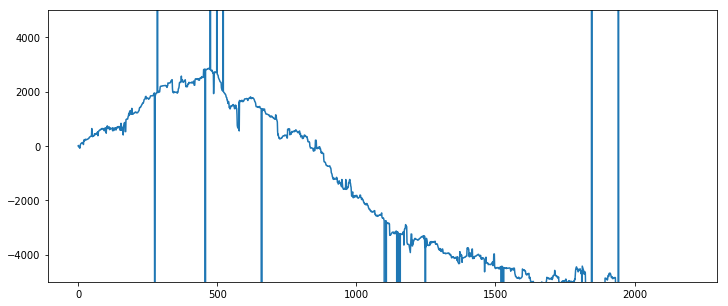

In [224]:

datei = 'my_apd1998.lst'
data = read_file(datei)

data = connected(data)
data = [
    (a,b,d) 
    for a,b,d in data
    if a != b or d > 1000
]
roh_data = [(contig_name(a), contig_name(b), int(d)) for a,b,d in data]

good_data, bad_data, _  = umsortieren(roh_data, contig_repeat, position)
data = good_data+bad_data

tol = 1000
s = coll.defaultdict(coll.Counter)
p = coll.defaultdict(coll.Counter)

for a, b, dist in data:
    real_dist = position[b] - position[a]
    if abs(real_dist - dist) < tol and a != b:
        if position[a] > position[b]:
            a, b, real_dist = b, a, -real_dist
        s[a][b] += 1
        p[b][a] += 1

ss = {a: sorted(s[a], key = lambda x: intName[x])[-4:] for a in s}
pp = {a: sorted(p[a], key = lambda x: intName[x], reverse = True)[-4:] for a in p}

ss = {a: sorted(ss[a], key = lambda x: s[a][x])[:] for a in s}
pp = {a: sorted(pp[a], key = lambda x: p[a][x])[:] for a in p}

dataX = [
    [a,b,d] 
    for a,b,d in data 
    if (
        ((a in ss and b in ss[a]) or (b in pp and a in pp[b])) and 
        -tol < position[b] - position[a] - d < tol
    )
]

positionY = solve_LP_standard(position, dataX)

intName = get_intName(positionY)
x = []
a = []
for i in range(3000):
    if not i in intName:
        break
    c = contig_name(intName[i])
  #  if c in reps|repeats:
   #     continue
    if not intName[i] in intNameX:
        continue
    x.append(i)
    a.append(positionY[intName[i]] - pos[intName[i]])
plt.plot(x,a,)
plt.ylim(-5000,5000)

plt.show()

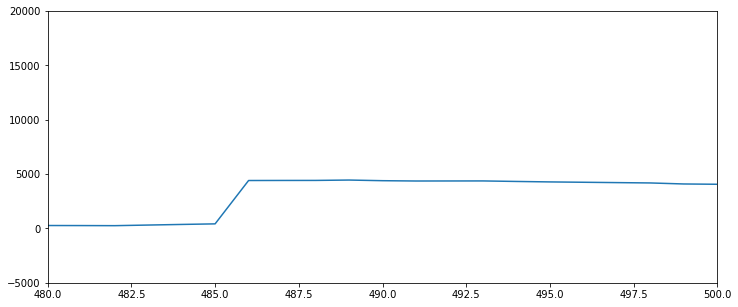

In [264]:
intName = get_intName(position)
x = []
a = []
for i in range(3000):
    if not i in intName:
        break
    c = contig_name(intName[i])
  #  if c in reps|repeats:
   #     continue
    if not intName[i] in intNameX:
        continue
    x.append(i)
    a.append(position[intName[i]] - pos[intName[i]])
plt.plot(x,a,)
plt.ylim(-5000,20000)

plt.xlim(480,500)
plt.show()

In [265]:
intName[485],intName[486]

('14APD_0', '2060APD_0')

(1450, 1460)

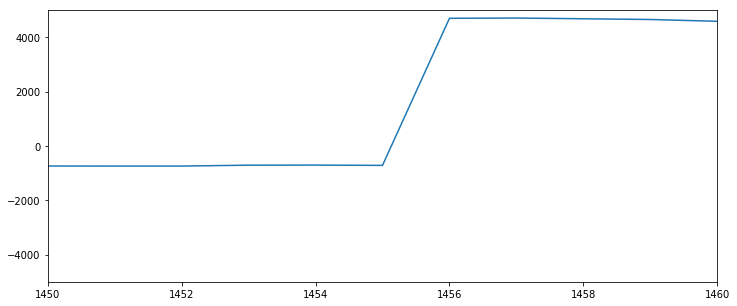

In [382]:
intName = get_intName(position)
x = []
a = []
for i in range(2000):
    if not i in intName:
        break
    c = contig_name(intName[i])
    if c in reps|repeats:
        continue
    if not c+'_0' in intNameX:
        continue
    x.append(i)
    a.append(position[intName[i]] - pos[intName[i]])
plt.plot(x,a,)
plt.ylim(-5000,5000)
plt.xlim(1450,1460)

('14APD_0', '132APD_0')

In [387]:
intName[1455],intName['233APD_0']

('930APD_0', 1937)

In [358]:
for i in range(2):
    good_data, bad_data, _  = umsortieren(roh_data, contig_repeat, position)
    data = good_data + bad_data

    print('100: %', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 100])/len(data))
    print('500: %', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 500])/len(data))
    print('2000:%', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 2000])/len(data))

    tol = 500
    
    s = coll.defaultdict(coll.Counter)
    p = coll.defaultdict(coll.Counter)

    for a, b, dist in data:
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < tol and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a][b] += 1
            p[b][a] += 1

    ss = {a: sorted(s[a], key = lambda x: s[a][x])[-2:] for a in s}
    pp = {a: sorted(p[a], key = lambda x: p[a][x])[-2:] for a in p}

    dataX = [
        [a,b,d] 
        for a,b,d in data 
        if ((a in ss and b in ss[a]) or (b in pp and a in pp[b])) and -tol < position[b] - position[a] - d < tol
    ]

    position = solve_LP_standard(position, dataX)

    print('max', max(position.values()))
    print('mean', sum([abs(position[b] - position[a] -d) for a,b,d in data])//len(data))
    print('100: %', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 100])/len(data))
    print('500: %', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 500])/len(data))
    print('2000:%', len([1 for a,b,d in data if abs(position[b] - position[a] -d) <= 2000])/len(data))


100: % 0.6287316722503289
500: % 0.8696203561788761
2000:% 0.9562982353818819
LP Opt: 22.061187254284775
max 4941887.0
mean 9248.0
100: % 0.6287045451462829
500: % 0.8695796655228071
2000:% 0.9562846718298588
100: % 0.6287983612784199
500: % 0.8697094253622009
2000:% 0.956420587118129
LP Opt: 22.093185371791353
max 4942003.0
mean 9244.0
100: % 0.6286762710944707
500: % 0.8696483802702263
2000:% 0.956420587118129


In [15]:

contig_repeat = coll.defaultdict(list)
for contig in position:
    contig_repeat[contig_name(contig)].append(contig)

In [17]:
d1,d2,_ = umsortieren(roh_data,contig_repeat,position)
data = d1+d2

In [22]:
s = coll.defaultdict(coll.Counter)
p = coll.defaultdict(coll.Counter)
graph = nx.DiGraph()

for a, b, dist in data:
    if True:
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < 2000 and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a][b] += 1
            p[b][a] += 1
        
ss = {a: sorted(s[a], key = lambda x: s[a][x]) for a in s}
pp = {a: sorted(p[a], key = lambda x: p[a][x]) for a in p}
for a in ss:
    for b in ss[a]:
        if s[a][b] > 0:
            graph.add_edge(a,b)
for b in pp:
    for a in pp[b]:
        if s[a][b] > 0:
            graph.add_edge(a,b)
intName = get_intName(position)
for k in nx.weakly_connected_components(graph):
    H = sorted([intName[x] for x in k])
    print(H[:5])
    print(H[-5:])
    print()

2145


In [383]:
print({intName[i] for i in range(0,1456)})
print({intName[i] for i in range(1456,3000) if i in intName})

{'982APD_0', '1852APD_0', '668APD_0', '873APD_0', '1177APD_0', '874APD_0', '1226APD_0', '438APD_0', '1729APD_0', '480APD_0', '888APD_0', '703APD_0', '181APD_0', '127APD_0', '2331APD_0', '2386APD_0', '524APD_0', '525APD_0', '317APD_0', '627APD_0', '336APD_0', '1117APD_0', '320APD_0', '2229APD_0', '153APD_0', '1614APD_0', '1870APD_0', '1242APD_0', '1981APD_0', '337APD_0', '1721APD_0', '1336APD_0', '1116APD_0', '1316APD_0', '602APD_0', '739APD_0', '1907APD_0', '2323APD_0', '1836APD_0', '865APD_0', '68APD_0', '1842APD_0', '1460APD_0', '2206APD_0', '246APD_0', '543APD_0', '492APD_0', '1672APD_0', '1583APD_0', '2015APD_0', '1698APD_0', '403APD_0', '2391APD_0', '593APD_0', '436APD_0', '1867APD_0', '694APD_0', '2426APD_0', '764APD_0', '623APD_0', '1446APD_0', '2021APD_0', '1268APD_0', '119APD_0', '2089APD_0', '1473APD_0', '584APD_0', '672APD_0', '2149APD_0', '2193APD_0', '955APD_0', '415APD_0', '1837APD_0', '2007APD_0', '1825APD_0', '352APD_0', '615APD_0', '1921APD_0', '1893APD_0', '1479APD_0'

In [385]:
position = lösung
s = coll.defaultdict(coll.Counter)
p = coll.defaultdict(coll.Counter)

for a, b, dist in data:
    real_dist = position[b] - position[a]
    if abs(real_dist - dist) < 500 and a != b:
        if position[a] > position[b]:
            a, b, real_dist = b, a, -real_dist
        s[a][b] += 1
        p[b][a] += 1
        
ss = {a: sorted(s[a], key = lambda x: s[a][x])[-5:] for a in s}
pp = {a: sorted(p[a], key = lambda x: p[a][x])[-5:] for a in p}

for a in ss:
    for b in ss[a]:
        graph.add_edge(a,b)
for b in pp:
    for a in pp[b]:
        graph.add_edge(a,b)
dataX = [
    [a,b,d] 
    for a,b,d in data 
    if ((a in ss and b in ss[a]) or (b in pp and a in pp[b])) and -500 < position[b] - position[a] - d < 500
]

X1 = {'982APD_0', '1852APD_0', '668APD_0', '873APD_0', '1177APD_0', '874APD_0', '1226APD_0', '438APD_0', '1729APD_0', '480APD_0', '888APD_0', '703APD_0', '181APD_0', '127APD_0', '2331APD_0', '2386APD_0', '524APD_0', '525APD_0', '317APD_0', '627APD_0', '336APD_0', '1117APD_0', '320APD_0', '2229APD_0', '153APD_0', '1614APD_0', '1870APD_0', '1242APD_0', '1981APD_0', '337APD_0', '1721APD_0', '1336APD_0', '1116APD_0', '1316APD_0', '602APD_0', '739APD_0', '1907APD_0', '2323APD_0', '1836APD_0', '865APD_0', '68APD_0', '1842APD_0', '1460APD_0', '2206APD_0', '246APD_0', '543APD_0', '492APD_0', '1672APD_0', '1583APD_0', '2015APD_0', '1698APD_0', '403APD_0', '2391APD_0', '593APD_0', '436APD_0', '1867APD_0', '694APD_0', '2426APD_0', '764APD_0', '623APD_0', '1446APD_0', '2021APD_0', '1268APD_0', '119APD_0', '2089APD_0', '1473APD_0', '584APD_0', '672APD_0', '2149APD_0', '2193APD_0', '955APD_0', '415APD_0', '1837APD_0', '2007APD_0', '1825APD_0', '352APD_0', '615APD_0', '1921APD_0', '1893APD_0', '1479APD_0', '282APD_0', '324APD_0', '2085APD_0', '771APD_0', '1904APD_0', '279APD_0', '2384APD_0', '1386APD_0', '2184APD_0', '381APD_0', '777APD_0', '189APD_0', '1717APD_0', '1354APD_0', '998APD_0', '2279APD_0', '1174APD_0', '2404APD_0', '1651APD_0', '2104APD_0', '1196APD_0', '588APD_0', '877APD_0', '1748APD_0', '273APD_0', '1675APD_0', '1238APD_0', '145APD_0', '551APD_0', '510APD_0', '90APD_0', '1744APD_0', '2157APD_0', '1608APD_0', '2452APD_0', '1201APD_0', '650APD_1', '291APD_0', '2373APD_0', '1502APD_0', '1779APD_0', '1922APD_0', '358APD_0', '1657APD_0', '452APD_0', '1031APD_0', '1132APD_0', '1992APD_0', '604APD_0', '2020APD_0', '892APD_0', '2409APD_0', '2428APD_0', '1582APD_0', '1428APD_0', '392APD_0', '1532APD_0', '2274APD_0', '1785APD_0', '830APD_0', '1911APD_0', '1261APD_0', '1545APD_0', '1851APD_0', '995APD_0', '2327APD_0', '394APD_0', '1387APD_0', '44APD_0', '1207APD_0', '2310APD_0', '662APD_0', '921APD_0', '1321APD_0', '1640APD_0', '104APD_0', '439APD_0', '307APD_0', '1064APD_1', '846APD_0', '1351APD_0', '2052APD_0', '491APD_0', '751APD_0', '1239APD_0', '1305APD_0', '1934APD_0', '1590APD_0', '994APD_0', '59APD_0', '241APD_0', '633APD_0', '235APD_0', '555APD_0', '1273APD_0', '405APD_0', '904APD_0', '201APD_0', '1355APD_0', '1283APD_0', '1103APD_0', '799APD_0', '361APD_0', '580APD_0', '540APD_0', '1942APD_0', '1783APD_0', '1265APD_0', '318APD_0', '1515APD_0', '170APD_0', '681APD_0', '1939APD_0', '2098APD_0', '430APD_0', '2293APD_0', '1425APD_0', '772APD_0', '766APD_0', '2235APD_0', '385APD_0', '1560APD_0', '2112APD_0', '701APD_0', '1689APD_0', '1359APD_0', '1525APD_0', '1457APD_0', '624APD_0', '1917APD_0', '929APD_0', '40APD_0', '1274APD_0', '2097APD_0', '2406APD_0', '2100APD_0', '444APD_0', '1568APD_0', '1312APD_0', '1461APD_0', '1099APD_0', '1747APD_0', '1085APD_0', '1474APD_0', '526APD_0', '142APD_0', '670APD_0', '226APD_0', '793APD_0', '73APD_0', '690APD_0', '411APD_1', '2006APD_0', '2236APD_0', '2108APD_0', '494APD_0', '1323APD_0', '1282APD_0', '1128APD_0', '743APD_0', '1410APD_0', '1392APD_0', '1272APD_0', '880APD_0', '2287APD_0', '2427APD_0', '1935APD_0', '414APD_0', '989APD_0', '1522APD_0', '428APD_0', '834APD_0', '621APD_0', '895APD_0', '806APD_0', '1077APD_0', '1104APD_0', '756APD_0', '2285APD_0', '1205APD_0', '2261APD_0', '1776APD_0', '2118APD_0', '1300APD_0', '2178APD_0', '1224APD_0', '908APD_0', '399APD_0', '1073APD_0', '1114APD_0', '1404APD_0', '1910APD_0', '686APD_0', '2458APD_0', '1379APD_1', '1819APD_0', '544APD_0', '2168APD_0', '655APD_0', '2267APD_0', '1630APD_0', '88APD_0', '1847APD_0', '1395APD_0', '463APD_0', '1011APD_0', '1679APD_0', '1231APD_0', '782APD_0', '277APD_0', '859APD_0', '483APD_0', '1927APD_0', '308APD_0', '258APD_0', '281APD_0', '334APD_0', '147APD_0', '1258APD_0', '816APD_0', '1150APD_0', '1067APD_0', '1210APD_0', '2333APD_0', '2197APD_0', '2091APD_0', '652APD_0', '720APD_0', '516APD_0', '2326APD_0', '1771APD_0', '683APD_0', '1789APD_0', '519APD_0', '2380APD_0', '1408APD_0', '579APD_0', '1641APD_0', '645APD_0', '827APD_0', '1330APD_0', '1263APD_0', '227APD_0', '1816APD_0', '706APD_0', '368APD_0', '2223APD_0', '1968APD_0', '2330APD_0', '797APD_0', '1902APD_0', '1774APD_0', '1562APD_0', '1394APD_0', '347APD_0', '597APD_0', '232APD_0', '1955APD_0', '1334APD_0', '77APD_0', '1730APD_0', '2050APD_0', '28APD_0', '2013APD_0', '1707APD_0', '1225APD_0', '1256APD_0', '1462APD_0', '563APD_0', '2211APD_0', '1102APD_0', '2139APD_0', '1475APD_0', '2205APD_0', '931APD_0', '684APD_0', '1886APD_0', '2153APD_0', '1309APD_0', '2436APD_0', '1385APD_0', '2122APD_0', '413APD_0', '596APD_0', '1264APD_0', '1458APD_0', '658APD_0', '2390APD_0', '2362APD_0', '1303APD_0', '2231APD_0', '1635APD_0', '313APD_0', '1208APD_0', '1332APD_0', '1204APD_0', '37APD_0', '2189APD_0', '1255APD_0', '2356APD_0', '1202APD_0', '1379APD_0', '391APD_0', '2172APD_0', '972APD_0', '1451APD_0', '1079APD_0', '2370APD_0', '1327APD_0', '63APD_0', '2237APD_0', '2350APD_0', '1389APD_0', '2110APD_0', '641APD_0', '1089APD_0', '1149APD_0', '781APD_0', '2073APD_0', '2195APD_0', '326APD_1', '1857APD_0', '2396APD_0', '1048APD_0', '559APD_0', '698APD_0', '1253APD_0', '1586APD_0', '177APD_0', '2400APD_0', '504APD_0', '274APD_0', '31APD_0', '975APD_0', '1602APD_0', '1890APD_0', '1647APD_0', '1716APD_0', '1623APD_0', '1276APD_0', '1136APD_0', '1211APD_0', '1420APD_0', '1453APD_0', '132APD_0', '1356APD_0', '1185APD_0', '2199APD_0', '958APD_0', '356APD_0', '618APD_0', '4APD_0', '831APD_0', '36APD_0', '345APD_0', '1941APD_0', '96APD_0', '1084APD_0', '1444APD_0', '1754APD_0', '1529APD_0', '157APD_0', '198APD_0', '257APD_0', '1552APD_0', '287APD_0', '187APD_0', '1443APD_0', '697APD_0', '553APD_0', '2159APD_0', '578APD_0', '949APD_0', '2450APD_0', '1764APD_0', '2346APD_0', '2277APD_0', '1348APD_0', '280APD_0', '2243APD_0', '654APD_0', '1876APD_0', '881APD_0', '1685APD_0', '38APD_0', '325APD_0', '1977APD_0', '2440APD_0', '1164APD_0', '2395APD_0', '1620APD_0', '996APD_0', '1252APD_0', '1616APD_0', '2037APD_0', '1767APD_0', '2393APD_0', '523APD_0', '1335APD_0', '342APD_2', '1959APD_0', '72APD_0', '2148APD_0', '80APD_0', '1286APD_0', '172APD_0', '1249APD_0', '75APD_0', '2046APD_0', '2053APD_0', '1510APD_0', '1213APD_0', '1112APD_0', '2250APD_0', '2387APD_0', '1181APD_0', '1541APD_0', '1176APD_0', '1241APD_0', '1390APD_0', '545APD_0', '1720APD_0', '1135APD_0', '369APD_0', '2102APD_0', '1938APD_0', '1020APD_0', '484APD_0', '2202APD_0', '1495APD_0', '2004APD_0', '1781APD_0', '1445APD_0', '1978APD_0', '950APD_0', '2048APD_0', '478APD_0', '1751APD_0', '1845APD_0', '2358APD_0', '611APD_0', '62APD_0', '459APD_0', '1015APD_0', '571APD_0', '577APD_0', '1165APD_0', '1827APD_0', '454APD_0', '598APD_0', '1746APD_0', '408APD_0', '2003APD_0', '1388APD_0', '376APD_0', '973APD_0', '431APD_0', '1903APD_0', '964APD_0', '70APD_0', '1798APD_0', '2290APD_0', '2423APD_0', '795APD_0', '1097APD_0', '462APD_0', '1544APD_0', '1173APD_0', '275APD_0', '619APD_0', '296APD_0', '736APD_0', '1146APD_0', '1347APD_0', '79APD_0', '1749APD_0', '988APD_0', '2422APD_0', '2319APD_0', '531APD_0', '1691APD_0', '456APD_0', '983APD_0', '1472APD_0', '2225APD_0', '2455APD_0', '407APD_0', '856APD_0', '1369APD_0', '1975APD_0', '746APD_0', '631APD_0', '1626APD_0', '357APD_0', '1169APD_0', '1259APD_0', '2460APD_0', '1693APD_0', '2382APD_0', '133APD_0', '1374APD_0', '1761APD_0', '301APD_0', '367APD_0', '1034APD_0', '1644APD_0', '2351APD_0', '2324APD_0', '1909APD_0', '1600APD_0', '184APD_0', '191APD_0', '2421APD_0', '902APD_0', '2076APD_0', '386APD_0', '1858APD_0', '1284APD_0', '1565APD_0', '1440APD_0', '1769APD_1', '768APD_0', '2174APD_0', '2268APD_0', '143APD_0', '515APD_0', '1042APD_0', '2459APD_0', '2357APD_0', '1723APD_0', '2039APD_0', '2164APD_0', '2163APD_0', '94APD_0', '970APD_0', '862APD_0', '917APD_0', '755APD_0', '1006APD_0', '1645APD_0', '2369APD_0', '140APD_0', '2019APD_0', '1596APD_0', '2058APD_0', '1492APD_0', '359APD_0', '141APD_0', '732APD_0', '1244APD_0', '1833APD_0', '355APD_0', '2034APD_0', '1037APD_0', '1811APD_0', '2255APD_0', '2359APD_0', '2429APD_0', '1605APD_0', '1199APD_0', '1523APD_0', '1599APD_0', '568APD_0', '737APD_0', '1671APD_0', '1865APD_0', '2394APD_0', '1805APD_0', '1617APD_0', '1409APD_0', '1882APD_0', '1622APD_0', '2099APD_0', '2022APD_0', '1465APD_0', '485APD_0', '878APD_0', '1074APD_0', '1683APD_0', '2141APD_0', '1665APD_0', '527APD_0', '208APD_0', '716APD_0', '1891APD_0', '225APD_0', '735APD_0', '89APD_0', '1937APD_0', '1986APD_0', '1970APD_0', '1090APD_0', '565APD_0', '1874APD_0', '2212APD_0', '740APD_0', '1301APD_0', '826APD_0', '1072APD_0', '314APD_0', '640APD_0', '566APD_0', '572APD_0', '610APD_0', '783APD_0', '1629APD_0', '2316APD_0', '1878APD_0', '290APD_0', '2177APD_0', '316APD_0', '2040APD_0', '82APD_0', '1375APD_0', '943APD_0', '590APD_0', '1885APD_0', '150APD_0', '1373APD_0', '1158APD_0', '1131APD_0', '567APD_0', '1063APD_0', '1566APD_0', '742APD_0', '84APD_0', '506APD_0', '2066APD_0', '522APD_0', '1954APD_0', '1649APD_0', '86APD_0', '328APD_0', '1368APD_0', '916APD_0', '1928APD_0', '1866APD_0', '1732APD_0', '285APD_0', '1709APD_0', '666APD_0', '521APD_0', '2109APD_0', '331APD_0', '1049APD_0', '429APD_0', '2322APD_0', '1933APD_0', '2032APD_0', '151APD_0', '117APD_0', '910APD_0', '978APD_0', '2113APD_0', '1427APD_0', '1289APD_0', '609APD_0', '1113APD_0', '1578APD_0', '1416APD_0', '1631APD_0', '1894APD_0', '1498APD_0', '2152APD_0', '2060APD_0', '1433APD_0', '1546APD_0', '944APD_0', '253APD_0', '464APD_0', '1759APD_0', '2128APD_0', '1636APD_0', '1770APD_0', '1704APD_0', '1125APD_0', '1295APD_0', '1198APD_0', '2173APD_0', '1752APD_0', '422APD_0', '1915APD_0', '2368APD_0', '491APD_1', '591APD_0', '167APD_0', '2249APD_0', '126APD_0', '501APD_0', '1038APD_0', '1126APD_0', '1380APD_0', '932APD_0', '2379APD_0', '1906APD_0', '71APD_0', '1967APD_0', '1611APD_0', '210APD_0', '960APD_0', '2244APD_0', '1016APD_0', '1155APD_0', '1524APD_0', '809APD_0', '61APD_0', '945APD_0', '2140APD_0', '1714APD_0', '2461APD_0', '1993APD_0', '326APD_0', '1230APD_0', '1000APD_0', '1483APD_0', '1895APD_0', '850APD_0', '2217APD_0', '1538APD_0', '1337APD_0', '560APD_0', '778APD_0', '848APD_0', '338APD_0', '2009APD_0', '411APD_0', '930APD_0', '2043APD_1', '216APD_0', '2203APD_0', '2275APD_0', '744APD_1', '149APD_0', '821APD_0', '535APD_0', '1122APD_0', '2339APD_0', '1702APD_0', '1499APD_0', '432APD_0', '738APD_0', '99APD_0', '1556APD_0', '1003APD_0', '1137APD_0', '2180APD_0', '1722APD_0', '1066APD_0', '650APD_0', '1952APD_0', '1815APD_0', '271APD_0', '271APD_1', '219APD_0', '445APD_0', '829APD_0', '2296APD_0', '384APD_0', '820APD_0', '407APD_1', '1487APD_0', '1217APD_0', '1500APD_0', '2238APD_0', '1850APD_0', '1358APD_0', '1021APD_0', '1481APD_0', '1480APD_0', '1434APD_0', '131APD_0', '2301APD_0', '2315APD_0', '53APD_0', '1964APD_0', '1775APD_0', '69APD_0', '802APD_0', '1682APD_0', '2001APD_0', '788APD_0', '1960APD_0', '1724APD_0', '1220APD_0', '1024APD_0', '2011APD_0', '461APD_0', '348APD_0', '424APD_0', '539APD_0', '351APD_0', '2038APD_0', '2071APD_0', '2338APD_0', '692APD_0', '1088APD_0', '852APD_0', '2027APD_0', '2420APD_0', '1804APD_0', '128APD_0', '1945APD_0', '528APD_0', '1919APD_0', '2081APD_0', '608APD_0', '72APD_1', '2145APD_0', '1822APD_0', '1508APD_0', '1980APD_0', '2214APD_0', '2264APD_0', '312APD_0', '1147APD_0', '906APD_0', '1701APD_0', '2209APD_0', '286APD_0', '1405APD_0', '1621APD_0', '2056APD_0', '1035APD_0', '2210APD_0', '1391APD_0', '1467APD_0', '2023APD_0', '1655APD_0', '1520APD_0', '421APD_0', '1908APD_0', '1417APD_0', '1172APD_0', '2062APD_0', '773APD_0', '927APD_0', '18APD_0', '1279APD_0', '939APD_0', '1397APD_0', '1809APD_0', '2412APD_0', '53APD_1', '1413APD_0', '1054APD_0', '887APD_0', '2325APD_0', '342APD_0', '575APD_0', '2432APD_0', '1209APD_0', '1030APD_0', '2335APD_0', '2114APD_0', '1800APD_0', '221APD_1', '963APD_0', '342APD_1', '1574APD_0', '573APD_0', '1456APD_0', '447APD_0', '196APD_0', '1813APD_0', '894APD_0', '1929APD_1', '542APD_0', '1699APD_0', '1156APD_0', '714APD_0', '2312APD_0', '158APD_0', '156APD_0', '1191APD_0', '896APD_0', '445APD_1', '1946APD_0', '1535APD_0', '263APD_0', '1750APD_0', '1423APD_0', '1096APD_0', '182APD_0', '231APD_0', '2410APD_0', '1421APD_0', '2092APD_0', '922APD_0', '529APD_0', '946APD_0', '885APD_0', '638APD_0', '410APD_0', '1022APD_0', '1040APD_0', '220APD_0', '195APD_0', '1929APD_0', '1925APD_0', '255APD_0', '1228APD_0', '1171APD_0', '209APD_0', '1159APD_0', '1043APD_0', '1872APD_0', '1055APD_0', '1969APD_0', '653APD_0', '58APD_0', '1547APD_0', '617APD_0', '2271APD_0', '549APD_0', '754APD_0', '556APD_0', '113APD_0', '2000APD_0', '1624APD_0', '1160APD_0', '1065APD_0', '576APD_0', '813APD_0', '319APD_0', '106APD_0', '1877APD_0', '1247APD_0', '2341APD_0', '78APD_0', '1142APD_0', '741APD_0', '15APD_0', '1607APD_0', '1923APD_0', '2187APD_0', '2367APD_0', '130APD_0', '1441APD_0', '266APD_0', '1363APD_0', '1162APD_0', '495APD_0', '1826APD_0', '2036APD_0', '2068APD_0', '1796APD_0', '340APD_0', '1189APD_0', '1646APD_0', '1192APD_0', '1442APD_0', '779APD_0', '981APD_0', '58APD_2', '750APD_0', '898APD_1', '1843APD_0', '390APD_0', '1314APD_0', '1338APD_0', '1817APD_0', '230APD_0', '1362APD_0', '1696APD_0', '121APD_0', '2169APD_0', '1708APD_0', '785APD_0', '708APD_0', '64APD_1', '656APD_0', '1862APD_0', '626APD_0', '48APD_0', '2150APD_0', '2088APD_0', '1342APD_0', '744APD_0', '1448APD_0', '2378APD_0', '1179APD_0', '249APD_0', '2123APD_0', '745APD_0', '1949APD_0', '440APD_0', '2286APD_0', '1588APD_0', '2448APD_0', '774APD_0', '1926APD_0', '389APD_0', '876APD_0', '811APD_0', '212APD_0', '1183APD_0', '476APD_0', '1436APD_0', '1762APD_0', '1240APD_0', '511APD_0', '237APD_0', '702APD_0', '1452APD_0', '1290APD_0', '1057APD_0', '335APD_0', '174APD_0', '2438APD_0', '855APD_0', '2415APD_0', '835APD_0', '382APD_0', '547APD_0', '2059APD_0', '1494APD_0', '21APD_0', '1278APD_0', '243APD_0', '58APD_1', '466APD_0', '2182APD_0', '1874APD_1', '217APD_0', '1033APD_0', '1227APD_0', '1151APD_0', '2230APD_0', '900APD_0', '101APD_0', '1633APD_0', '6APD_0', '1223APD_0', '1415APD_0', '2200APD_0', '176APD_0', '23APD_0', '832APD_0', '1506APD_0', '1797APD_0', '2278APD_0', '980APD_0', '134APD_0', '1422APD_0', '2002APD_0', '224APD_0', '2434APD_0', '148APD_0', '1341APD_0', '1979APD_0', '1889APD_0', '1400APD_0', '1883APD_0', '2259APD_0', '2077APD_0', '311APD_0', '12APD_0', '1581APD_0', '1106APD_0', '675APD_0', '124APD_0', '136APD_0', '346APD_0', '986APD_0', '1322APD_0', '724APD_0', '1317APD_0', '1406APD_0', '1262APD_0', '74APD_1', '1742APD_0', '1823APD_0', '509APD_0', '251APD_0', '990APD_0', '1514APD_0', '1143APD_0', '676APD_0', '125APD_0', '548APD_0', '1957APD_0', '1APD_0', '903APD_0', '1121APD_0', '2155APD_0', '1768APD_0', '727APD_0', '159APD_0', '303APD_0', '1860APD_0', '948APD_0', '51APD_0', '1739APD_0', '1009APD_0', '1017APD_0', '1551APD_0', '2051APD_0', '2399APD_0', '2413APD_0', '518APD_0', '300APD_0', '211APD_0', '1965APD_0', '1051APD_0', '3APD_0', '1625APD_0', '1148APD_0', '898APD_0', '1570APD_0', '1064APD_0', '265APD_0', '814APD_0', '20APD_0', '102APD_0', '1736APD_0', '1920APD_0', '116APD_0', '1912APD_0', '1554APD_0', '1753APD_0', '1966APD_0', '497APD_0', '1990APD_0', '49APD_0', '999APD_0', '1505APD_0', '1687APD_0', '14APD_0', '1799APD_0', '1285APD_0', '2345APD_0', '498APD_0', '2055APD_0', '55APD_0', '205APD_0', '2192APD_0', '2318APD_0', '2416APD_0', '1007APD_0', '890APD_0', '475APD_0', '639APD_0', '909APD_0', '564APD_0', '1485APD_0', '168APD_0', '1528APD_0', '1769APD_0', '1412APD_0', '283APD_0', '157APD_1', '752APD_0', '2247APD_0', '780APD_0', '2320APD_0', '1195APD_0', '1430APD_0', '600APD_0', '589APD_0', '2398APD_0', '966APD_0', '1871APD_0', '1543APD_0', '2047APD_0', '2239APD_0', '861APD_0', '50APD_0', '1572APD_0', '758APD_0', '433APD_0', '2190APD_0', '1463APD_0', '462APD_1', '398APD_0', '1948APD_0', '879APD_0', '1197APD_0', '1692APD_0', '2082APD_0', '2449APD_0', '605APD_0', '853APD_0', '2103APD_0', '1245APD_0', '1002APD_0', '2APD_0', '1275APD_0', '2337APD_0', '2138APD_0', '1669APD_0', '486APD_0', '1333APD_0', '2134APD_0', '534APD_0', '1393APD_0', '365APD_0', '2262APD_0', '2132APD_0', '2269APD_0', '748APD_0', '1733APD_0', '1471APD_0', '1536APD_0', '1706APD_0', '2160APD_0', '1803APD_0', '2043APD_0', '199APD_0', '569APD_0', '1693APD_1', '1930APD_0', '776APD_0', '1145APD_0', '477APD_0', '2044APD_0', '2435APD_0', '1101APD_0', '2188APD_0', '244APD_0', '332APD_0', '501APD_1', '800APD_0', '1563APD_0', '1830APD_0', '913APD_0', '2297APD_0', '93APD_0', '1157APD_0', '1280APD_0', '1091APD_0', '599APD_0', '1661APD_0', '1814APD_0', '67APD_0', '546APD_0', '2219APD_0', '185APD_0', '2340APD_0', '1036APD_0', '371APD_0', '842APD_0', '759APD_0', '722APD_0', '612APD_0', '857APD_0', '1360APD_0', '601APD_0', '1612APD_0', '920APD_0', '17APD_0', '844APD_0', '1361APD_0', '1634APD_0', '536APD_0', '884APD_0', '2349APD_0', '976APD_0', '178APD_0', '289APD_0', '1812APD_0', '1076APD_0', '798APD_0', '363APD_0', '221APD_0', '845APD_0', '2226APD_0', '682APD_0', '315APD_0', '616APD_0', '380APD_0', '1402APD_0', '1534APD_0', '1281APD_0', '2005APD_0', '817APD_0', '1755APD_0', '35APD_0', '1454APD_0', '763APD_0', '240APD_0', '1549APD_0', '2342APD_0', '2360APD_0', '2204APD_0', '2227APD_0', '465APD_0', '1296APD_0', '1828APD_0', '882APD_0', '789APD_0', '2086APD_0', '550APD_0', '11APD_0', '276APD_0', '704APD_0', '1756APD_0', '936APD_0', '1971APD_0', '1140APD_0', '622APD_0', '374APD_0', '2181APD_0', '1835APD_0', '144APD_0', '109APD_0', '576APD_1', '1449APD_0', '761APD_0', '1059APD_0', '849APD_0', '1383APD_0', '1349APD_0', '1998APD_0', '1580APD_0', '824APD_0', '193APD_0', '1248APD_0', '57APD_0', '1773APD_0', '733APD_0', '1221APD_0', '2256APD_0', '1439APD_0', '1711APD_0', '1025APD_0', '202APD_0', '242APD_0', '1974APD_0', '2454APD_0', '261APD_0', '1491APD_0', '74APD_0', '1991APD_0', '2131APD_0', '1366APD_0', '1503APD_0', '204APD_0', '1246APD_0', '1010APD_0', '1924APD_0', '138APD_0', '2075APD_0', '487APD_0', '2142APD_0', '1869APD_0', '680APD_0', '1396APD_0', '350APD_0', '792APD_0', '1346APD_0', '2305APD_0', '64APD_0', '919APD_0', '2083APD_0', '1595APD_0', '2026APD_0', '379APD_0', '1818APD_0', '19APD_0', '360APD_0', '30APD_0', '1880APD_0', '2388APD_0', '178APD_1', '188APD_0', '333APD_0', '2029APD_0', '1507APD_0', '891APD_0', '98APD_0', '694APD_1', '229APD_0', '343APD_0', '2125APD_0', '1923APD_1', '441APD_0'}
X2 = {'1401APD_0', '1821APD_0', '2329APD_0', '1594APD_0', '1234APD_0', '769APD_0', '2304APD_0', '482APD_0', '1652APD_0', '1188APD_0', '1381APD_0', '294APD_0', '1218APD_0', '1690APD_0', '146APD_0', '442APD_0', '473APD_0', '1997APD_0', '1304APD_0', '914APD_0', '1061APD_0', '298APD_0', '1058APD_0', '354APD_0', '383APD_0', '1950APD_0', '418APD_0', '1875APD_0', '1533APD_0', '1345APD_0', '905APD_0', '1905APD_0', '2116APD_0', '863APD_0', '1437APD_0', '393APD_0', '1215APD_0', '111APD_0', '1190APD_0', '2344APD_0', '214APD_0', '901APD_0', '2257APD_0', '784APD_0', '423APD_0', '1715APD_0', '1606APD_0', '1791APD_0', '355APD_1', '1082APD_0', '2045APD_0', '2462APD_0', '1032APD_0', '1637APD_0', '2443APD_0', '2389APD_0', '233APD_0', '2185APD_0', '1576APD_0', '1056APD_0', '1094APD_0', '105APD_0', '1384APD_0', '278APD_0', '2090APD_0', '1881APD_0', '2222APD_0', '2010APD_0', '305APD_1', '470APD_0', '514APD_0', '1760APD_0', '632APD_0', '2185APD_1', '1542APD_0', '2405APD_0', '304APD_0', '2300APD_0', '1718APD_0', '1019APD_0', '685APD_0', '537APD_0', '646APD_0', '2303APD_0', '488APD_0', '52APD_1', '538APD_0', '1778APD_0', '530APD_0', '1540APD_0', '1705APD_0', '507APD_0', '512APD_0', '787APD_0', '16APD_0', '505APD_0', '2115APD_0', '426APD_0', '2136APD_0', '353APD_0', '449APD_0', '726APD_0', '297APD_0', '665APD_0', '1985APD_0', '860APD_0', '628APD_0', '450APD_0', '122APD_0', '790APD_0', '388APD_0', '247APD_0', '1418APD_0', '135APD_0', '2070APD_0', '443APD_0', '419APD_1', '2374APD_0', '825APD_0', '388APD_1', '570APD_0', '1567APD_0', '129APD_0', '1597APD_0', '721APD_0', '25APD_0', '1325APD_0', '965APD_0', '957APD_0', '1308APD_0', '437APD_0', '1175APD_0', '95APD_0', '586APD_0', '2258APD_0', '2232APD_0', '1670APD_0', '1180APD_0', '1801APD_0', '2352APD_0', '1120APD_0', '663APD_0', '1628APD_0', '1212APD_0', '1310APD_0', '292APD_0', '2445APD_0', '1795APD_0', '794APD_0', '911APD_0', '2347APD_0', '1504APD_0', '1307APD_0', '310APD_0', '2228APD_0', '259APD_0', '1045APD_0', '1615APD_0', '2063APD_0', '2263APD_0', '250APD_0', '179APD_0', '1727APD_0', '427APD_0', '1435APD_0', '513APD_0', '2017APD_0', '1107APD_0', '2298APD_0', '175APD_0', '1868APD_0', '1619APD_0', '262APD_0', '396APD_0', '1512APD_0', '2240APD_0', '100APD_0', '1372APD_0', '2012APD_0', '1831APD_0', '804APD_0', '1001APD_0', '1489APD_0', '1119APD_0', '1650APD_0', '767APD_0', '1810APD_0', '203APD_0', '2233APD_0', '267APD_0', '1787APD_0', '974APD_0', '696APD_0', '1648APD_0', '434APD_0', '2057APD_0', '1123APD_0', '2093APD_0', '561APD_0', '552APD_0', '60APD_0', '1734APD_0', '2033APD_0', '370APD_1', '753APD_0', '2309APD_0', '1658APD_0', '2392APD_0', '870APD_0', '33APD_0', '2194APD_0', '925APD_0', '2254APD_0', '1294APD_0', '499APD_0', '2302APD_0', '1684APD_0', '803APD_0', '2191APD_0', '2288APD_0', '81APD_0', '2441APD_0', '1601APD_0', '493APD_0', '409APD_0', '1897APD_0', '1849APD_0', '1757APD_0', '1888APD_0', '1382APD_0', '1027APD_0', '1235APD_0', '29APD_0', '1139APD_0', '1728APD_0', '248APD_0', '1519APD_0', '1078APD_0', '2080APD_0', '401APD_1', '22APD_0', '479APD_0', '2130APD_0', '1557APD_0', '938APD_0', '1493APD_0', '2162APD_0', '1569APD_0', '397APD_0', '695APD_0', '2025APD_0', '2453APD_0', '39APD_0', '2401APD_0', '238APD_0', '520APD_1', '46APD_0', '1501APD_0', '851APD_0', '2105APD_0', '558APD_1', '245APD_0', '305APD_0', '446APD_0', '1455APD_0', '2355APD_0', '749APD_0', '997APD_0', '1953APD_0', '940APD_0', '2260APD_0', '2348APD_0', '2196APD_0', '161APD_0', '83APD_0', '192APD_0', '26APD_0', '2176APD_0', '657APD_0', '1673APD_0', '962APD_0', '1840APD_0', '841APD_0', '1328APD_0', '372APD_0', '489APD_0', '1311APD_0', '1899APD_0', '85APD_0', '1766APD_0', '2078APD_0', '2248APD_0', '97APD_0', '2276APD_0', '458APD_0', '2457APD_0', '1531APD_0', '691APD_0', '1848APD_0', '1350APD_0', '467APD_0', '1558APD_0', '734APD_0', '41APD_0', '952APD_0', '642APD_0', '293APD_0', '2294APD_0', '796APD_0', '1855APD_0', '341APD_0', '1257APD_0', '1166APD_0', '2030APD_0', '762APD_0', '2295APD_0', '1962APD_0', '370APD_0', '712APD_0', '1951APD_0', '329APD_0', '186APD_0', '373APD_0', '1298APD_0', '643APD_0', '1901APD_0', '1115APD_0', '2317APD_0', '2273APD_0', '710APD_0', '1419APD_0', '378APD_0', '924APD_0', '1426APD_0', '517APD_0', '678APD_0', '2198APD_0', '2397APD_0', '2054APD_0', '1735APD_0', '400APD_0', '812APD_0', '1526APD_0', '1972APD_0', '137APD_0', '2111APD_0', '1999APD_0', '264APD_0', '625APD_0', '2372APD_0', '899APD_0', '455APD_0', '2146APD_0', '2147APD_0', '1743APD_0', '815APD_0', '1378APD_0', '1087APD_0', '107APD_0', '1973APD_0', '165APD_0', '1497APD_0', '594APD_0', '1488APD_0', '2084APD_0', '377APD_0', '1806APD_1', '2403APD_0', '1476APD_0', '1100APD_0', '2124APD_0', '2165APD_0', '1638APD_0', '1438APD_0', '1052APD_0', '1726APD_0', '807APD_0', '52APD_0', '155APD_0', '847APD_0', '2451APD_0', '2402APD_0', '1053APD_0', '65APD_0', '457APD_0', '837APD_0', '234APD_0', '1603APD_0', '2282APD_0', '1984APD_0', '1807APD_0', '607APD_0', '2014APD_0', '1932APD_0', '606APD_0', '2456APD_0', '2374APD_1', '1069APD_0', '252APD_0', '1521APD_0', '557APD_0', '8APD_0', '163APD_0', '2246APD_0', '1365APD_0', '723APD_0', '2035APD_0', '2306APD_0', '2328APD_1', '637APD_0', '907APD_0', '1490APD_0', '872APD_0', '1639APD_0', '951APD_0', '1186APD_0', '2101APD_0', '2332APD_0', '123APD_0', '1780APD_0', '5APD_0', '2120APD_0', '651APD_0', '1331APD_0', '1643APD_0', '34APD_0', '2201APD_0', '112APD_0', '582APD_0', '2167APD_0', '2186APD_0', '987APD_0', '2061APD_0', '2371APD_0', '1376APD_0', '162APD_1', '1790APD_0', '1431APD_0', '164APD_0', '1710APD_0', '1028APD_0', '1659APD_0', '587APD_0', '893APD_0', '425APD_0', '302APD_0', '214APD_1', '2283APD_0', '2129APD_0', '66APD_0', '1447APD_0', '1550APD_0', '1364APD_0', '339APD_0', '1859APD_0', '634APD_0', '256APD_0', '2213APD_0', '967APD_0', '541APD_0', '115APD_0', '592APD_0', '2407APD_0', '1918APD_0', '1864APD_0', '1013APD_0', '1664APD_0', '500APD_0', '1047APD_0', '2299APD_0', '2133APD_0', '114APD_0', '1497APD_1', '2215APD_0', '558APD_0', '1667APD_0', '32APD_0', '207APD_0', '1940APD_0', '1592APD_0', '302APD_1', '636APD_0', '2213APD_1', '2444APD_0', '508APD_0', '453APD_0', '729APD_0', '1203APD_0', '961APD_0', '420APD_0', '1887APD_0', '1832APD_0', '687APD_0', '801APD_0', '1464APD_0', '705APD_0', '2251APD_0', '709APD_0', '288APD_0', '947APD_0', '1004APD_0', '166APD_0', '451APD_0', '595APD_0', '2095APD_0', '1182APD_0', '401APD_0', '2447APD_0', '2442APD_0', '839APD_0', '1642APD_0', '1095APD_0', '718APD_0', '843APD_0', '1319APD_0', '613APD_0', '1936APD_0', '1663APD_0', '309APD_0', '236APD_0', '1214APD_0', '661APD_0', '1963APD_0', '1564APD_0', '1686APD_0', '1668APD_0', '926APD_0', '321APD_0', '269APD_0', '2218APD_0', '1898APD_0', '869APD_0', '42APD_0', '43APD_0', '520APD_0', '2314APD_0', '1697APD_0', '120APD_0', '1587APD_0', '977APD_0', '2175APD_0', '1014APD_0', '215APD_0', '2041APD_0', '2127APD_0', '323APD_0', '412APD_0', '169APD_0', '417APD_0', '2065APD_0', '1788APD_0', '1656APD_0', '2207APD_0', '1806APD_0', '554APD_0', '162APD_0', '2383APD_0', '460APD_0', '2241APD_0', '532APD_0', '671APD_0', '1700APD_0', '272APD_0', '468APD_0', '76APD_0', '1838APD_0', '1367APD_0', '1429APD_0', '1802APD_0', '2234APD_0', '659APD_0', '647APD_0', '1144APD_0', '496APD_0', '1470APD_0', '1731APD_0', '47APD_0', '693APD_0', '635APD_0', '765APD_0', '1994APD_0', '2424APD_0', '2216APD_0', '1697APD_1', '197APD_0', '1080APD_0', '688APD_0', '2343APD_0', '92APD_0', '953APD_0', '1598APD_0', '937APD_0', '108APD_0', '1424APD_0', '375APD_0', '460APD_1', '747APD_0', '1070APD_0', '854APD_0', '679APD_0', '2137APD_0', '1130APD_0', '923APD_0', '2313APD_0', '1834APD_0', '1152APD_0', '1786APD_0', '719APD_0', '1484APD_0', '45APD_0', '1008APD_0', '1988APD_0', '339APD_1', '1792APD_0', '1496APD_0', '1260APD_0', '1178APD_0', '2245APD_0', '472APD_0', '1352APD_0', '1371APD_0', '200APD_0', '649APD_0', '160APD_0', '2270APD_0', '2281APD_0', '1398APD_0', '530APD_1', '1339APD_0', '1575APD_0', '1509APD_0', '2292APD_0', '2096APD_0', '868APD_0', '2208APD_0', '1340APD_0', '10APD_0', '1288APD_0', '2311APD_0', '223APD_0', '1666APD_0', '402APD_0', '897APD_0', '1758APD_0', '13APD_0', '912APD_0', '56APD_0', '2067APD_0', '674APD_0', '2144APD_0', '954APD_0', '574APD_0', '1660APD_0', '2376APD_0', '1324APD_0', '1824APD_0', '194APD_0', '1763APD_0', '614APD_0', '2018APD_0', '2328APD_0', '2414APD_0', '985APD_0', '1662APD_0', '1200APD_0', '1654APD_0', '2049APD_0', '268APD_0', '1573APD_0', '1129APD_0', '1676APD_0', '270APD_0', '1004APD_1', '2375APD_0', '2280APD_0', '2266APD_0', '2418APD_0', '2072APD_0', '730APD_0', '2008APD_0', '47APD_1', '875APD_0', '87APD_0', '660APD_0', '2028APD_0', '469APD_0', '419APD_0', '349APD_0', '387APD_0', '2042APD_0', '1222APD_0', '1931APD_0', '1584APD_0', '1561APD_0', '689APD_0', '1377APD_0', '585APD_0', '118APD_0', '979APD_0', '2365APD_0', '971APD_0', '1407APD_0', '1029APD_0', '956APD_0', '1784APD_0', '1046APD_0', '474APD_0', '1138APD_0', '2031APD_0', '1109APD_0', '1553APD_0', '1133APD_0', '1559APD_0', '1110APD_0', '1267APD_0', '707APD_0', '2433APD_0', '1896APD_0', '7APD_0', '416APD_0', '1050APD_0', '1548APD_0', '213APD_0', '1961APD_0', '1469APD_0', '828APD_0', '819APD_0', '1943APD_0', '330APD_0', '2385APD_0'}
for a,b,d in dataX:
    if a in X1 and b in X2:
        print(intName[a],intName[b],s[a][b],d,position[b]-position[a]-d)
#position = solve_LP_standard(position, dataX)

1450 1456 3 6931 106.0
1450 1456 3 6971 66.0
1450 1456 3 7004 33.0
1450 1459 2 11756 350.0
1450 1459 2 11778 328.0
1447 1456 3 13026 199.0
1447 1456 3 13150 75.0
1447 1456 3 13199 26.0
1452 1462 2 12726 167.0
1452 1462 2 12974 -81.0
1452 1456 4 3517 101.0
1452 1456 4 3545 73.0
1452 1456 4 3549 69.0
1452 1456 4 3565 53.0
1452 1459 3 8330 357.0
1452 1459 3 8396 291.0
1452 1459 3 8454 233.0
1452 1461 2 11495 276.0
1452 1461 2 11713 58.0
1452 1457 1 7757 349.0
1454 1456 3 1235 105.0
1454 1456 3 1300 40.0
1454 1456 3 1307 33.0
1454 1458 1 6021 -34.0
1454 1459 1 6172 237.0
1454 1461 1 9431 62.0
1454 1457 1 5475 353.0
1449 1456 3 11864 129.0
1449 1456 3 11901 92.0
1449 1456 3 11947 46.0
1449 1459 2 16686 376.0
1449 1459 2 16711 351.0
1445 1456 2 18009 192.0
1445 1456 2 18194 7.0
1453 1456 3 1536 98.0
1453 1456 3 1595 39.0
1453 1456 3 1601 33.0
1453 1458 1 6322 -41.0
1453 1461 1 9732 55.0
1453 1457 1 5776 346.0
1448 1456 1 12432 48.0
1451 1456 2 3916 79.0
1451 1456 2 3958 37.0
1451 1458 1 8702

In [328]:
pp['133APD_0']

['1128APD_0', '821APD_0']

In [305]:
('133APD_0' in ss and '133APD_0' in ss['133APD_0']),('133APD_0' in pp and '133APD_0' in pp['133APD_0'])

(False, False)

In [301]:

for a, b, dist in data:
    if {'133APD_0','2360APD_0'} == {a,b}:
        real_dist = position[b] - position[a]
        print(a,b,dist,real_dist)
        if abs(real_dist - dist) < 1300 and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            print(a,b,dist)
            s[a][b] += 1
            p[b][a] += 1

2360APD_0 133APD_0 882 284.0
2360APD_0 133APD_0 882
2360APD_0 133APD_0 888 284.0
2360APD_0 133APD_0 888
2360APD_0 133APD_0 889 284.0
2360APD_0 133APD_0 889
2360APD_0 133APD_0 890 284.0
2360APD_0 133APD_0 890
2360APD_0 133APD_0 895 284.0
2360APD_0 133APD_0 895
2360APD_0 133APD_0 898 284.0
2360APD_0 133APD_0 898
2360APD_0 133APD_0 905 284.0
2360APD_0 133APD_0 905


In [302]:

ss = {a: sorted(s[a], key = lambda x: s[a][x]) for a in s}
pp = {a: sorted(p[a], key = lambda x: p[a][x]) for a in p}

In [303]:
pp['133APD_0']

['2360APD_0']

In [295]:
for a,b,d in data :
    if {'133APD_0','2360APD_0'} == {a,b}:
        print(a,b,d)
        print((a in ss and b in ss[a]))
        print((b in pp and a in pp[b]))
        print(-1300 < position[b] - position[a] - d < 1300)
    

2360APD_0 133APD_0 882
False
False
True
2360APD_0 133APD_0 888
False
False
True
2360APD_0 133APD_0 889
False
False
True
2360APD_0 133APD_0 890
False
False
True
2360APD_0 133APD_0 895
False
False
True
2360APD_0 133APD_0 898
False
False
True
2360APD_0 133APD_0 905
False
False
True


In [270]:
intName[1115],intName[1116]

('1657APD_0', '849APD_0')

In [7]:
lösung = {'1000APD_0': 1897457.0, '178APD_0': 1897846.0, '178APD_1': 2909102.0, '2083APD_0': 1911056.0, '251APD_0': 1907570.0, '498APD_0': 1899099.0, '1001APD_0': 4040841.0, '100APD_0': 4094727.0, '1046APD_0': 4192446.0, '10APD_0': 4055175.0, '1119APD_0': 4061878.0, '1130APD_0': 4167481.0, '1133APD_0': 4176541.0, '1310APD_0': 4059875.0, '1324APD_0': 4051060.0, '1331APD_0': 4079710.0, '1418APD_0': 4060349.0, '1488APD_0': 4066682.0, '1496APD_0': 4051593.0, '1501APD_0': 4071933.0, '1550APD_0': 4193148.0, '1553APD_0': 4067072.0, '1553APD_1': 4170089.0, '1558APD_0': 4136201.0, '1559APD_0': 4058163.0, '1561APD_0': 4118720.0, '1573APD_0': 4052294.0, '1648APD_0': 4079069.0, '1656APD_0': 4050474.0, '1666APD_0': 4131496.0, '169APD_0': 4068096.0, '1700APD_0': 4059254.0, '1718APD_0': 4052875.0, '1802APD_0': 4058773.0, '2018APD_0': 4071474.0, '2033APD_0': 4054569.0, '2067APD_0': 4129607.0, '2137APD_0': 4067717.0, '2196APD_0': 4054983.0, '2207APD_0': 4027411.0, '2232APD_0': 4031315.0, '2241APD_0': 4128581.0, '2246APD_0': 4113249.0, '2258APD_0': 4064009.0, '2270APD_0': 4195336.0, '2352APD_0': 4048640.0, '2443APD_0': 4164713.0, '2451APD_0': 4146731.0, '262APD_0': 4198313.0, '272APD_0': 4056401.0, '297APD_0': 4075705.0, '323APD_0': 4184219.0, '330APD_0': 4148102.0, '388APD_0': 4068883.0, '388APD_1': 4171870.0, '416APD_0': 4044761.0, '426APD_0': 4084239.0, '437APD_0': 4200080.0, '479APD_0': 4203963.0, '493APD_0': 4086473.0, '496APD_0': 4083027.0, '500APD_0': 4049041.0, '532APD_0': 4063184.0, '552APD_0': 4142556.0, '582APD_0': 4074460.0, '635APD_0': 4177936.0, '695APD_0': 4092460.0, '721APD_0': 4139295.0, '749APD_0': 4081704.0, '7APD_0': 4073287.0, '851APD_0': 4126996.0, '85APD_0': 4064324.0, '868APD_0': 4035348.0, '872APD_0': 4049779.0, '912APD_0': 4174375.0, '985APD_0': 4072590.0, '1002APD_0': 1666547.0, '1003APD_0': 1678161.0, '1035APD_0': 1697283.0, '1195APD_0': 1668316.0, '1223APD_0': 1715638.0, '1355APD_0': 1718575.0, '1406APD_0': 1685301.0, '1415APD_0': 1712076.0, '1417APD_0': 1710060.0, '1440APD_0': 1684009.0, '1473APD_0': 1676955.0, '1491APD_0': 1700265.0, '1508APD_0': 1754105.0, '1689APD_0': 1707738.0, '1823APD_0': 1718905.0, '1880APD_0': 1688023.0, '1883APD_0': 1683634.0, '2020APD_0': 1692835.0, '2039APD_0': 1674765.0, '2159APD_0': 1702112.0, '2212APD_0': 1754474.0, '2286APD_0': 1720591.0, '240APD_0': 1747502.0, '332APD_0': 1726914.0, '384APD_0': 1743583.0, '477APD_0': 1735334.0, '610APD_0': 1696077.0, '755APD_0': 1710943.0, '817APD_0': 1715219.0, '859APD_0': 1690991.0, '902APD_0': 1679899.0, '964APD_0': 1678904.0, '975APD_0': 1698421.0, '1004APD_0': 3464284.0, '1004APD_1': 3496981.0, '107APD_0': 3564574.0, '1094APD_0': 3585040.0, '1095APD_0': 3611744.0, '111APD_0': 3610674.0, '1129APD_0': 3569473.0, '115APD_0': 3561003.0, '1257APD_0': 3589514.0, '1294APD_0': 3518720.0, '1325APD_0': 3600074.0, '135APD_0': 3515624.0, '1372APD_0': 3563233.0, '1407APD_0': 3579609.0, '1426APD_0': 3505898.0, '1431APD_0': 3577646.0, '1476APD_0': 3554878.0, '1497APD_0': 3436176.0, '1497APD_1': 3468858.0, '1521APD_0': 3604743.0, '1540APD_0': 3575235.0, '1548APD_0': 3570455.0, '1592APD_0': 3593279.0, '1606APD_0': 3570121.0, '162APD_0': 3462873.0, '162APD_1': 3495566.0, '1663APD_0': 3582984.0, '1664APD_0': 3615994.0, '1697APD_0': 3452831.0, '1697APD_1': 3485526.0, '1726APD_0': 3598815.0, '1801APD_0': 3608398.0, '1806APD_0': 3462549.0, '1806APD_1': 3495228.0, '1832APD_0': 3547692.0, '186APD_0': 3614022.0, '1901APD_0': 3593577.0, '1940APD_0': 3558282.0, '197APD_0': 3593969.0, '2010APD_0': 3590050.0, '2028APD_0': 3529944.0, '2111APD_0': 3605427.0, '2129APD_0': 3549260.0, '2162APD_0': 3577992.0, '2185APD_0': 3441651.0, '2185APD_1': 3474334.0, '2201APD_0': 3554157.0, '2213APD_0': 3463881.0, '2213APD_1': 3496743.0, '2251APD_0': 3586114.0, '22APD_0': 3509290.0, '2303APD_0': 3598106.0, '2317APD_0': 3596210.0, '2328APD_0': 3440682.0, '2328APD_1': 3473388.0, '234APD_0': 3522492.0, '2374APD_0': 3466041.0, '2374APD_1': 3498840.0, '2414APD_0': 3466251.0, '2453APD_0': 3558614.0, '2462APD_0': 3514795.0, '250APD_0': 3586840.0, '264APD_0': 3551679.0, '292APD_0': 3533594.0, '339APD_0': 3505376.0, '339APD_1': 3511928.0, '34APD_0': 3507810.0, '370APD_0': 3466507.0, '370APD_1': 3499250.0, '417APD_0': 3619848.0, '419APD_0': 3451890.0, '419APD_1': 3484589.0, '442APD_0': 3543034.0, '453APD_0': 3555963.0, '460APD_0': 3462269.0, '460APD_1': 3495089.0, '47APD_0': 3460668.0, '47APD_1': 3493365.0, '489APD_0': 3603607.0, '520APD_0': 3465908.0, '520APD_1': 3498717.0, '52APD_0': 3460018.0, '52APD_1': 3492715.0, '558APD_0': 3442231.0, '558APD_1': 3474909.0, '561APD_0': 3555018.0, '60APD_0': 3607497.0, '643APD_0': 3585511.0, '660APD_0': 3626530.0, '674APD_0': 3465998.0, '678APD_0': 3512422.0, '712APD_0': 3599754.0, '769APD_0': 3556478.0, '807APD_0': 3592100.0, '847APD_0': 3526932.0, '863APD_0': 3604356.0, '8APD_0': 3501354.0, '951APD_0': 3610139.0, '956APD_0': 3606601.0, '1006APD_0': 1767993.0, '1030APD_0': 1813952.0, '1354APD_0': 1815959.0, '1451APD_0': 1829782.0, '147APD_0': 1793735.0, '1644APD_0': 1804076.0, '1799APD_0': 1835733.0, '1809APD_0': 1841057.0, '1828APD_0': 1783628.0, '1968APD_0': 1806107.0, '1977APD_0': 1822809.0, '1978APD_0': 1770586.0, '2037APD_0': 1772822.0, '2056APD_0': 1826231.0, '2148APD_0': 1828964.0, '2157APD_0': 1820452.0, '2182APD_0': 1778739.0, '2188APD_0': 1801490.0, '2323APD_0': 1798009.0, '2349APD_0': 1786297.0, '2395APD_0': 1781002.0, '280APD_0': 1830805.0, '357APD_0': 1802097.0, '380APD_0': 1783926.0, '510APD_0': 1785698.0, '676APD_0': 1808175.0, '743APD_0': 1839068.0, '878APD_0': 1839915.0, '963APD_0': 1786076.0, '1007APD_0': 2298629.0, '1148APD_0': 2342169.0, '1275APD_0': 2304670.0, '138APD_0': 2338835.0, '1520APD_0': 2311472.0, '1551APD_0': 2318680.0, '1605APD_0': 2314710.0, '1641APD_0': 2344358.0, '1645APD_0': 2326263.0, '177APD_0': 2354546.0, '1842APD_0': 2303423.0, '1847APD_0': 2318970.0, '185APD_0': 2300089.0, '2081APD_0': 2312578.0, '2089APD_0': 2319573.0, '2153APD_0': 2305354.0, '2209APD_0': 2310783.0, '2316APD_0': 2356422.0, '2346APD_0': 2319743.0, '2450APD_0': 2354218.0, '286APD_0': 2330837.0, '312APD_0': 2306468.0, '38APD_0': 2346557.0, '536APD_0': 2317140.0, '608APD_0': 2319159.0, '666APD_0': 2325331.0, '668APD_0': 2325592.0, '752APD_0': 2308447.0, '814APD_0': 2337711.0, '880APD_0': 2351840.0, '1008APD_0': 3721042.0, '1029APD_0': 3755467.0, '1464APD_0': 3749141.0, '161APD_0': 3724200.0, '1788APD_0': 3752339.0, '192APD_0': 3730075.0, '1988APD_0': 3722561.0, '256APD_0': 3740251.0, '507APD_0': 3722395.0, '554APD_0': 3749623.0, '649APD_0': 3734188.0, '65APD_0': 3755308.0, '765APD_0': 3757070.0, '76APD_0': 3723120.0, '905APD_0': 3721280.0, '979APD_0': 3755727.0, '1009APD_0': 2145171.0, '1031APD_0': 2157870.0, '1231APD_0': 2169125.0, '1479APD_0': 2154221.0, '1515APD_0': 2166211.0, '1723APD_0': 2165238.0, '1756APD_0': 2147311.0, '1764APD_0': 2145518.0, '191APD_0': 2151538.0, '1925APD_0': 2152233.0, '2305APD_0': 2167104.0, '308APD_0': 2166781.0, '519APD_0': 2157239.0, '683APD_0': 2148690.0, '785APD_0': 2152622.0, '797APD_0': 2168631.0, '813APD_0': 2154877.0, '884APD_0': 2160294.0, '990APD_0': 2147906.0, '1628APD_0': 4131270.0, '940APD_0': 4118195.0, '1010APD_0': 429325.0, '106APD_0': 443983.0, '1162APD_0': 552064.0, '1185APD_0': 436285.0, '1199APD_0': 436908.0, '1245APD_0': 623709.0, '1281APD_0': 457080.0, '1309APD_0': 474381.0, '1330APD_0': 480734.0, '1410APD_0': 522634.0, '1423APD_0': 625042.0, '1439APD_0': 635688.0, '1463APD_0': 604089.0, '151APD_0': 528909.0, '153APD_0': 477664.0, '1574APD_0': 438757.0, '1661APD_0': 471372.0, '1665APD_0': 475344.0, '1751APD_0': 483733.0, '1815APD_0': 573310.0, '1816APD_0': 478448.0, '1852APD_0': 526924.0, '187APD_0': 542754.0, '189APD_0': 559626.0, '196APD_0': 501385.0, '1APD_0': 615216.0, '202APD_0': 461204.0, '2092APD_0': 439516.0, '2204APD_0': 494989.0, '2205APD_0': 575476.0, '2335APD_0': 482656.0, '2367APD_0': 467395.0, '2415APD_0': 494038.0, '2420APD_0': 632546.0, '2423APD_0': 451771.0, '2434APD_0': 452833.0, '2461APD_0': 454378.0, '31APD_0': 507185.0, '345APD_0': 593459.0, '407APD_0': 610157.0, '407APD_1': 681182.0, '459APD_0': 552849.0, '462APD_0': 613658.0, '462APD_1': 684682.0, '548APD_0': 488679.0, '57APD_0': 557045.0, '58APD_0': 580918.0, '58APD_1': 643886.0, '58APD_2': 652857.0, '599APD_0': 589022.0, '656APD_0': 513490.0, '680APD_0': 432524.0, '703APD_0': 638303.0, '714APD_0': 505160.0, '766APD_0': 558798.0, '811APD_0': 492227.0, '861APD_0': 542110.0, '865APD_0': 605286.0, '900APD_0': 557957.0, '904APD_0': 487769.0, '90APD_0': 462496.0, '989APD_0': 439880.0, '1011APD_0': 1417495.0, '113APD_0': 1420319.0, '1285APD_0': 1444717.0, '2043APD_0': 1451212.0, '2043APD_1': 2864315.0, '2043APD_2': 2958994.0, '2066APD_0': 1443157.0, '40APD_0': 1430764.0, '483APD_0': 1445634.0, '751APD_0': 1366466.0, '84APD_0': 1367726.0, '853APD_0': 1419637.0, '1013APD_0': 3421700.0, '1028APD_0': 3429845.0, '108APD_0': 3464025.0, '1810APD_0': 3423927.0, '1961APD_0': 3433011.0, '26APD_0': 3424419.0, '372APD_0': 3432466.0, '383APD_0': 3462408.0, '607APD_0': 3434730.0, '901APD_0': 3421861.0, '907APD_0': 3433818.0, '911APD_0': 3430753.0, '1014APD_0': 4781523.0, '1186APD_0': 4797860.0, '1218APD_0': 4802748.0, '1340APD_0': 4781798.0, '1350APD_0': 4790634.0, '1365APD_0': 4794584.0, '165APD_0': 4805443.0, '1667APD_0': 4797203.0, '1710APD_0': 4796380.0, '179APD_0': 4802018.0, '1918APD_0': 4794959.0, '1953APD_0': 4785376.0, '2063APD_0': 4787345.0, '2146APD_0': 4807103.0, '2194APD_0': 4792997.0, '248APD_0': 4803740.0, '304APD_0': 4807418.0, '592APD_0': 4786906.0, '632APD_0': 4799853.0, '707APD_0': 4805934.0, '957APD_0': 4796670.0, '1015APD_0': 1341823.0, '131APD_0': 1364927.0, '14APD_0': 1374648.0, '1505APD_0': 2709695.0, '1742APD_0': 1359384.0, '1813APD_0': 1344202.0, '182APD_0': 1348105.0, '1874APD_0': 1332663.0, '1874APD_1': 2937689.0, '18APD_0': 1412138.0, '2034APD_0': 1346356.0, '316APD_0': 1360482.0, '501APD_0': 1300713.0, '501APD_1': 1354664.0, '1016APD_0': 1284779.0, '1074APD_0': 1292038.0, '145APD_0': 1316714.0, '1017APD_0': 239687.0, '1246APD_0': 271821.0, '1248APD_0': 330482.0, '1334APD_0': 272807.0, '1390APD_0': 298776.0, '1494APD_0': 326817.0, '1514APD_0': 247117.0, '1543APD_0': 289477.0, '157APD_0': 314762.0, '157APD_1': 337328.0, '1586APD_0': 325313.0, '1590APD_0': 329083.0, '1608APD_0': 250919.0, '1622APD_0': 331641.0, '1701APD_0': 307682.0, '1866APD_0': 246650.0, '1942APD_0': 324636.0, '1955APD_0': 295588.0, '2088APD_0': 252469.0, '2122APD_0': 322243.0, '216APD_0': 302443.0, '2197APD_0': 251157.0, '2312APD_0': 243487.0, '2380APD_0': 297339.0, '241APD_0': 332488.0, '2458APD_0': 267953.0, '277APD_0': 241719.0, '318APD_0': 280413.0, '374APD_0': 244264.0, '444APD_0': 243811.0, '466APD_0': 274685.0, '480APD_0': 268828.0, '506APD_0': 264120.0, '547APD_0': 280023.0, '580APD_0': 254915.0, '638APD_0': 300837.0, '684APD_0': 309187.0, '764APD_0': 311489.0, '832APD_0': 327777.0, '855APD_0': 279079.0, '88APD_0': 291852.0, '898APD_0': 296877.0, '898APD_1': 312312.0, '1019APD_0': 3689047.0, '1027APD_0': 3787555.0, '1045APD_0': 3800484.0, '1080APD_0': 3839313.0, '112APD_0': 3694003.0, '114APD_0': 3859618.0, '1377APD_0': 3799176.0, '1469APD_0': 3858899.0, '1490APD_0': 3795854.0, '1531APD_0': 3708974.0, '1569APD_0': 3781516.0, '1576APD_0': 3823712.0, '1594APD_0': 3697278.0, '1642APD_0': 3827524.0, '16APD_0': 3812421.0, '1758APD_0': 3820574.0, '1855APD_0': 3794489.0, '1864APD_0': 3690190.0, '1881APD_0': 3782136.0, '1897APD_0': 3845667.0, '1899APD_0': 3817773.0, '1905APD_0': 3815624.0, '1943APD_0': 3854346.0, '200APD_0': 3718836.0, '2045APD_0': 3822676.0, '2061APD_0': 3810049.0, '2233APD_0': 3797961.0, '2260APD_0': 3789149.0, '2295APD_0': 3705359.0, '2332APD_0': 3875674.0, '238APD_0': 3863914.0, '2407APD_0': 3710866.0, '278APD_0': 3802523.0, '288APD_0': 3762677.0, '294APD_0': 3818396.0, '355APD_0': 3052652.0, '355APD_1': 3783387.0, '420APD_0': 3692167.0, '425APD_0': 3690668.0, '541APD_0': 3840097.0, '586APD_0': 3715509.0, '5APD_0': 3717705.0, '625APD_0': 3700402.0, '709APD_0': 3707753.0, '828APD_0': 3698414.0, '83APD_0': 3689782.0, '101APD_0': 2228575.0, '1149APD_0': 2247968.0, '1179APD_0': 2246468.0, '1189APD_0': 2262200.0, '1578APD_0': 2259172.0, '1600APD_0': 2257728.0, '1781APD_0': 2235708.0, '1858APD_0': 2236033.0, '2097APD_0': 2248767.0, '389APD_0': 2230068.0, '403APD_0': 2236237.0, '61APD_0': 2253719.0, '70APD_0': 2249100.0, '856APD_0': 2260941.0, '857APD_0': 2244603.0, '920APD_0': 2240763.0, '93APD_0': 2232710.0, '1020APD_0': 3015530.0, '1043APD_0': 3027926.0, '1116APD_0': 3016205.0, '1201APD_0': 3017400.0, '1264APD_0': 3021967.0, '1300APD_0': 3024764.0, '1754APD_0': 3023149.0, '2100APD_0': 3015920.0, '2244APD_0': 3026924.0, '2428APD_0': 3025008.0, '575APD_0': 3026443.0, '67APD_0': 3018301.0, '1021APD_0': 2663577.0, '1290APD_0': 2664849.0, '1685APD_0': 2665611.0, '17APD_0': 2665161.0, '2181APD_0': 2664565.0, '522APD_0': 2668768.0, '526APD_0': 2664103.0, '1022APD_0': 687419.0, '119APD_0': 733634.0, '1366APD_0': 726910.0, '1374APD_0': 698078.0, '1651APD_0': 727447.0, '1721APD_0': 711271.0, '1773APD_0': 698437.0, '2110APD_0': 695048.0, '2155APD_0': 753911.0, '2410APD_0': 716129.0, '572APD_0': 743956.0, '681APD_0': 692070.0, '89APD_0': 723178.0, '94APD_0': 702769.0, '1024APD_0': 406096.0, '1038APD_0': 422035.0, '1192APD_0': 418329.0, '1433APD_0': 413734.0, '1467APD_0': 416977.0, '1595APD_0': 425559.0, '1647APD_0': 414126.0, '2160APD_0': 425873.0, '2256APD_0': 420452.0, '2390APD_0': 426915.0, '266APD_0': 407170.0, '335APD_0': 419266.0, '429APD_0': 423129.0, '588APD_0': 407377.0, '68APD_0': 426444.0, '939APD_0': 410924.0, '1025APD_0': 2226830.0, '1487APD_0': 2227507.0, '207APD_0': 3820120.0, '2144APD_0': 3798828.0, '613APD_0': 3820413.0, '1567APD_0': 3781367.0, '1639APD_0': 3761508.0, '2365APD_0': 3762316.0, '102APD_0': 2582457.0, '1204APD_0': 2592017.0, '1273APD_0': 2594323.0, '2454APD_0': 2598085.0, '287APD_0': 2588116.0, '104APD_0': 2175280.0, '1084APD_0': 2172767.0, '1272APD_0': 2174418.0, '1301APD_0': 2179620.0, '1524APD_0': 2171220.0, '2009APD_0': 2170570.0, '1032APD_0': 4380879.0, '1489APD_0': 4398030.0, '2120APD_0': 4407039.0, '2281APD_0': 4407840.0, '2343APD_0': 4413121.0, '2418APD_0': 4396966.0, '25APD_0': 4311025.0, '310APD_0': 4395313.0, '451APD_0': 4401173.0, '470APD_0': 4386650.0, '488APD_0': 4381832.0, '56APD_0': 4391740.0, '570APD_0': 4383568.0, '1033APD_0': 874007.0, '1253APD_0': 899730.0, '1258APD_0': 891748.0, '1265APD_0': 897315.0, '1460APD_0': 912251.0, '1970APD_0': 882308.0, '2250APD_0': 936871.0, '376APD_0': 917631.0, '568APD_0': 875446.0, '73APD_0': 903564.0, '77APD_0': 890115.0, '806APD_0': 932831.0, '820APD_0': 889390.0, '1034APD_0': 3272572.0, '1183APD_0': 3281994.0, '1196APD_0': 3288371.0, '1286APD_0': 3290074.0, '1392APD_0': 3296227.0, '1452APD_0': 3290873.0, '1872APD_0': 3283158.0, '1964APD_0': 3297803.0, '2104APD_0': 3277209.0, '2310APD_0': 3279044.0, '2325APD_0': 3278092.0, '2357APD_0': 3282481.0, '255APD_0': 3287552.0, '289APD_0': 3291203.0, '317APD_0': 3279561.0, '392APD_0': 3286492.0, '487APD_0': 3274240.0, '535APD_0': 3288006.0, '626APD_0': 3293197.0, '746APD_0': 3292793.0, '74APD_0': 3273177.0, '74APD_1': 3285334.0, '1036APD_0': 2079240.0, '1393APD_0': 2105659.0, '1456APD_0': 2088703.0, '1485APD_0': 2081745.0, '168APD_0': 2099506.0, '1819APD_0': 2087774.0, '1827APD_0': 2096023.0, '1937APD_0': 2102648.0, '2108APD_0': 2096772.0, '2255APD_0': 2081339.0, '2293APD_0': 2097216.0, '2359APD_0': 2104328.0, '2369APD_0': 2094206.0, '285APD_0': 2091555.0, '356APD_0': 2106296.0, '545APD_0': 2102324.0, '1037APD_0': 2628565.0, '1373APD_0': 2643626.0, '141APD_0': 2639599.0, '1562APD_0': 2631086.0, '2226APD_0': 2634099.0, '2320APD_0': 2649975.0, '2438APD_0': 2641186.0, '382APD_0': 2644288.0, '495APD_0': 2644577.0, '63APD_0': 2644827.0, '888APD_0': 2652721.0, '1040APD_0': 2657785.0, '1142APD_0': 2658005.0, '1042APD_0': 3137673.0, '1126APD_0': 3199607.0, '1131APD_0': 3171600.0, '1135APD_0': 3183263.0, '1165APD_0': 3155180.0, '1209APD_0': 3167710.0, '1217APD_0': 3189618.0, '1303APD_0': 3170294.0, '1322APD_0': 3167536.0, '1342APD_0': 3157931.0, '1442APD_0': 3188581.0, '1444APD_0': 3174380.0, '1492APD_0': 3172172.0, '1546APD_0': 3164760.0, '1556APD_0': 3186796.0, '1565APD_0': 3144109.0, '1614APD_0': 3158634.0, '1755APD_0': 3197403.0, '1797APD_0': 3154727.0, '1891APD_0': 3156943.0, '1910APD_0': 3175663.0, '2059APD_0': 3188415.0, '2152APD_0': 3191427.0, '21APD_0': 3162700.0, '2217APD_0': 3195705.0, '2229APD_0': 3154890.0, '2262APD_0': 3183705.0, '2333APD_0': 3163225.0, '2449APD_0': 3163528.0, '2452APD_0': 3194127.0, '283APD_0': 3159231.0, '333APD_0': 3198165.0, '415APD_0': 3150331.0, '515APD_0': 3152654.0, '662APD_0': 3181255.0, '702APD_0': 3139743.0, '741APD_0': 3181687.0, '754APD_0': 3203326.0, '763APD_0': 3199982.0, '842APD_0': 3143043.0, '852APD_0': 3152969.0, '966APD_0': 3141533.0, '981APD_0': 3204309.0, '1051APD_0': 3082351.0, '1128APD_0': 3042637.0, '1221APD_0': 3072549.0, '1239APD_0': 3076820.0, '1282APD_0': 3080326.0, '1394APD_0': 3073228.0, '1434APD_0': 3052413.0, '1545APD_0': 3056421.0, '1566APD_0': 3065088.0, '1602APD_0': 3064220.0, '1736APD_0': 3065357.0, '1803APD_0': 3030055.0, '1805APD_0': 3070854.0, '1833APD_0': 3048083.0, '1909APD_0': 3031323.0, '1915APD_0': 3083867.0, '1927APD_0': 3060490.0, '1960APD_0': 3044977.0, '2082APD_0': 3062137.0, '2098APD_0': 3061449.0, '2168APD_0': 3068436.0, '2180APD_0': 3065656.0, '2267APD_0': 3068800.0, '2318APD_0': 3078482.0, '2360APD_0': 3054236.0, '328APD_0': 3066036.0, '363APD_0': 3077201.0, '36APD_0': 3048529.0, '598APD_0': 3066403.0, '622APD_0': 3063409.0, '692APD_0': 3077794.0, '698APD_0': 3080037.0, '733APD_0': 3033394.0, '792APD_0': 3080566.0, '821APD_0': 3043939.0, '895APD_0': 3085616.0, '2234APD_0': 4223090.0, '1047APD_0': 4652495.0, '1056APD_0': 4671027.0, '1437APD_0': 4671672.0, '1509APD_0': 4668551.0, '1519APD_0': 4669684.0, '1598APD_0': 4660099.0, '1601APD_0': 4657626.0, '1780APD_0': 4662975.0, '1787APD_0': 4657995.0, '1875APD_0': 4664958.0, '2031APD_0': 4662368.0, '2105APD_0': 4664472.0, '215APD_0': 4656582.0, '2216APD_0': 4660723.0, '2294APD_0': 4667651.0, '449APD_0': 4657181.0, '474APD_0': 4672137.0, '646APD_0': 4659810.0, '719APD_0': 4655879.0, '1048APD_0': 1101012.0, '1063APD_0': 1122647.0, '1121APD_0': 1121005.0, '1145APD_0': 1105810.0, '1453APD_0': 1106123.0, '1798APD_0': 1117733.0, '1817APD_0': 1124489.0, '2019APD_0': 1103815.0, '2112APD_0': 1127804.0, '2114APD_0': 1104119.0, '232APD_0': 1105200.0, '23APD_0': 1118505.0, '2412APD_0': 1109662.0, '265APD_0': 1122021.0, '399APD_0': 1104456.0, '1049APD_0': 1217018.0, '1379APD_0': 1233794.0, '1379APD_1': 2863773.0, '1379APD_2': 2957754.0, '1391APD_0': 2826270.0, '1495APD_0': 1220939.0, '1974APD_0': 1222999.0, '326APD_0': 1233492.0, '326APD_1': 2958730.0, '1255APD_0': 2179230.0, '1826APD_0': 2178668.0, '1862APD_0': 2217571.0, '1992APD_0': 2178431.0, '2193APD_0': 2201915.0, '2277APD_0': 2189114.0, '315APD_0': 2191963.0, '340APD_0': 2187419.0, '478APD_0': 2181814.0, '79APD_0': 2219456.0, '1050APD_0': 4733744.0, '1070APD_0': 4766890.0, '1082APD_0': 4737160.0, '1109APD_0': 4748906.0, '1138APD_0': 4765128.0, '1175APD_0': 4751322.0, '1200APD_0': 4756435.0, '122APD_0': 4781063.0, '1235APD_0': 4747984.0, '1267APD_0': 4738908.0, '1345APD_0': 4758489.0, '1424APD_0': 4777019.0, '1512APD_0': 4741358.0, '1533APD_0': 4757539.0, '1557APD_0': 4737587.0, '1575APD_0': 4765971.0, '1619APD_0': 4749233.0, '1652APD_0': 4778283.0, '166APD_0': 4753976.0, '1676APD_0': 4763231.0, '1766APD_0': 4740138.0, '1834APD_0': 4764810.0, '1888APD_0': 4764213.0, '1994APD_0': 4776717.0, '2035APD_0': 4753411.0, '2263APD_0': 4747668.0, '2344APD_0': 4767829.0, '2383APD_0': 4756119.0, '293APD_0': 4780063.0, '29APD_0': 4773793.0, '427APD_0': 4757879.0, '434APD_0': 4748425.0, '43APD_0': 4758170.0, '455APD_0': 4755042.0, '614APD_0': 4758941.0, '637APD_0': 4765482.0, '671APD_0': 4766215.0, '696APD_0': 4768510.0, '705APD_0': 4763730.0, '794APD_0': 4745949.0, '87APD_0': 4741735.0, '893APD_0': 4749382.0, '937APD_0': 4740927.0, '977APD_0': 4751877.0, '97APD_0': 4736231.0, '1112APD_0': 3101358.0, '1333APD_0': 3088739.0, '1388APD_0': 3085436.0, '1759APD_0': 3096743.0, '343APD_0': 3090907.0, '697APD_0': 3097868.0, '1052APD_0': 4679229.0, '1180APD_0': 4684050.0, '1376APD_0': 4694636.0, '1382APD_0': 4682608.0, '1615APD_0': 4681123.0, '1743APD_0': 4701051.0, '1936APD_0': 4697053.0, '194APD_0': 4678441.0, '2065APD_0': 4683469.0, '2127APD_0': 4685157.0, '2191APD_0': 4684689.0, '2405APD_0': 4681372.0, '41APD_0': 4679557.0, '469APD_0': 4687127.0, '642APD_0': 4676358.0, '723APD_0': 4685739.0, '729APD_0': 4677264.0, '730APD_0': 4680562.0, '753APD_0': 4689871.0, '841APD_0': 4682169.0, '997APD_0': 4680219.0, '1053APD_0': 4264980.0, '1715APD_0': 4265212.0, '1054APD_0': 1151022.0, '1059APD_0': 1151474.0, '1583APD_0': 1166291.0, '1878APD_0': 1162557.0, '1935APD_0': 1165029.0, '195APD_0': 1157407.0, '1990APD_0': 1152724.0, '2223APD_0': 1164555.0, '2426APD_0': 1151787.0, '358APD_0': 1153586.0, '410APD_0': 1153111.0, '788APD_0': 1163622.0, '1055APD_0': 963524.0, '117APD_0': 968250.0, '2077APD_0': 991686.0, '2211APD_0': 981806.0, '639APD_0': 977091.0, '802APD_0': 984310.0, '1057APD_0': 138958.0, '1151APD_0': 206045.0, '1252APD_0': 193763.0, '1317APD_0': 165771.0, '1363APD_0': 219712.0, '1375APD_0': 186945.0, '1380APD_0': 220495.0, '1397APD_0': 233671.0, '1400APD_0': 146079.0, '1465APD_0': 224988.0, '1472APD_0': 141128.0, '156APD_0': 187971.0, '1698APD_0': 157470.0, '1714APD_0': 142895.0, '1779APD_0': 218542.0, '1857APD_0': 183132.0, '1903APD_0': 158688.0, '1904APD_0': 212432.0, '1921APD_0': 222896.0, '1991APD_0': 229556.0, '19APD_0': 190679.0, '2013APD_0': 196933.0, '2058APD_0': 149673.0, '205APD_0': 236041.0, '2085APD_0': 215132.0, '2322APD_0': 199731.0, '2387APD_0': 164154.0, '511APD_0': 152092.0, '772APD_0': 194508.0, '793APD_0': 227371.0, '876APD_0': 226201.0, '885APD_0': 235227.0, '896APD_0': 195220.0, '931APD_0': 186094.0, '943APD_0': 151343.0, '945APD_0': 214478.0, '948APD_0': 203594.0, '105APD_0': 3920748.0, '214APD_0': 3930517.0, '214APD_1': 3993723.0, '214APD_2': 4017730.0, '2389APD_0': 3922108.0, '418APD_0': 3927414.0, '508APD_0': 3922972.0, '726APD_0': 3921235.0, '869APD_0': 3938621.0, '1061APD_0': 3888595.0, '1069APD_0': 3901258.0, '1429APD_0': 3891290.0, '1838APD_0': 3892069.0, '2136APD_0': 3902388.0, '2175APD_0': 3899415.0, '2282APD_0': 3899928.0, '2288APD_0': 3893292.0, '2376APD_0': 3894389.0, '245APD_0': 3914984.0, '373APD_0': 3902671.0, '512APD_0': 3908804.0, '651APD_0': 3902260.0, '925APD_0': 3901643.0, '1097APD_0': 1171786.0, '1544APD_0': 1178738.0, '1568APD_0': 1133694.0, '1692APD_0': 1146078.0, '1789APD_0': 1170272.0, '1893APD_0': 1128953.0, '1895APD_0': 1177626.0, '2001APD_0': 1139807.0, '2015APD_0': 1146246.0, '2173APD_0': 1185711.0, '2190APD_0': 1133195.0, '2247APD_0': 1183852.0, '2331APD_0': 1181534.0, '2339APD_0': 1149274.0, '2368APD_0': 1180021.0, '337APD_0': 1134434.0, '351APD_0': 1141405.0, '414APD_0': 1182322.0, '623APD_0': 1138102.0, '670APD_0': 1150366.0, '745APD_0': 1140096.0, '881APD_0': 1141120.0, '944APD_0': 1176178.0, '980APD_0': 1137354.0, '1064APD_0': 2864312.0, '1064APD_1': 2958850.0, '1202APD_0': 3004689.0, '1278APD_0': 3013337.0, '1296APD_0': 2972424.0, '136APD_0': 3000970.0, '143APD_0': 2974537.0, '1554APD_0': 2864751.0, '159APD_0': 2869462.0, '1762APD_0': 2993261.0, '1924APD_0': 2988395.0, '201APD_0': 2985675.0, '20APD_0': 2964580.0, '2264APD_0': 3012974.0, '2341APD_0': 2982380.0, '2384APD_0': 2991720.0, '2422APD_0': 2990642.0, '246APD_0': 2985172.0, '249APD_0': 2978745.0, '257APD_0': 2984302.0, '411APD_0': 2865015.0, '411APD_1': 2959570.0, '422APD_0': 2960265.0, '465APD_0': 2865439.0, '531APD_0': 2989684.0, '560APD_0': 2964226.0, '816APD_0': 2959317.0, '887APD_0': 2977342.0, '983APD_0': 3010490.0, '1065APD_0': 2201658.0, '1090APD_0': 2205164.0, '1101APD_0': 2213590.0, '1117APD_0': 2215501.0, '1136APD_0': 2206544.0, '1210APD_0': 2208211.0, '1244APD_0': 2206829.0, '1443APD_0': 2208700.0, '1499APD_0': 2204313.0, '1867APD_0': 2212105.0, '1957APD_0': 2207089.0, '314APD_0': 2209287.0, '621APD_0': 2219102.0, '1066APD_0': 2551574.0, '1091APD_0': 2555622.0, '1226APD_0': 2554718.0, '1361APD_0': 2570926.0, '1362APD_0': 2556531.0, '1502APD_0': 2554345.0, '1563APD_0': 2562699.0, '1993APD_0': 2575121.0, '2184APD_0': 2556910.0, '324APD_0': 2561412.0, '424APD_0': 2562149.0, '706APD_0': 2561763.0, '773APD_0': 2553870.0, '910APD_0': 2566318.0, '929APD_0': 2569030.0, '1067APD_0': 68110.0, '1076APD_0': 83432.0, '1894APD_0': 77557.0, '1980APD_0': 92298.0, '2050APD_0': 95191.0, '225APD_0': 65514.0, '225APD_1': 68493.0, '2396APD_0': 90656.0, '2448APD_0': 80701.0, '301APD_0': 86603.0, '50APD_0': 88639.0, '521APD_0': 81102.0, '958APD_0': 93367.0, '2350APD_0': 462111.0, '569APD_0': 473900.0, '1504APD_0': 4811985.0, '2348APD_0': 4816161.0, '1072APD_0': 3262830.0, '1709APD_0': 3265048.0, '243APD_0': 3266996.0, '28APD_0': 3269631.0, '617APD_0': 3266456.0, '732APD_0': 3266021.0, '1073APD_0': 1010853.0, '1177APD_0': 1005440.0, '1249APD_0': 1031723.0, '1335APD_0': 1054155.0, '1506APD_0': 1034403.0, '1679APD_0': 1009399.0, '1835APD_0': 1057300.0, '1837APD_0': 1058364.0, '2038APD_0': 1064116.0, '367APD_0': 1061429.0, '398APD_0': 1075376.0, '48APD_0': 958116.0, '573APD_0': 949217.0, '609APD_0': 1042797.0, '742APD_0': 1056423.0, '783APD_0': 1035675.0, '1113APD_0': 99717.0, '1337APD_0': 107361.0, '1529APD_0': 138274.0, '1631APD_0': 125022.0, '176APD_0': 126260.0, '1877APD_0': 106506.0, '542APD_0': 121039.0, '567APD_0': 128440.0, '59APD_0': 114576.0, '776APD_0': 130310.0, '831APD_0': 103272.0, '86APD_0': 131602.0, '960APD_0': 101638.0, '1077APD_0': 403762.0, '2011APD_0': 405062.0, '379APD_0': 405671.0, '80APD_0': 404295.0, '1078APD_0': 4837178.0, '1100APD_0': 4855798.0, '1212APD_0': 4856576.0, '1222APD_0': 4855363.0, '1260APD_0': 4850426.0, '1311APD_0': 4861157.0, '1705APD_0': 4843332.0, '1763APD_0': 4853597.0, '1786APD_0': 4858373.0, '1807APD_0': 4857142.0, '1997APD_0': 4847466.0, '2014APD_0': 4865909.0, '2025APD_0': 4856468.0, '2041APD_0': 4863138.0, '2133APD_0': 4867776.0, '2280APD_0': 4854743.0, '2456APD_0': 4860087.0, '594APD_0': 4868458.0, '837APD_0': 4861884.0, '938APD_0': 4849179.0, '1079APD_0': 2462798.0, '1102APD_0': 2479637.0, '126APD_0': 2463607.0, '1383APD_0': 2494494.0, '1814APD_0': 2492782.0, '1836APD_0': 2465820.0, '1919APD_0': 2487467.0, '2237APD_0': 2476259.0, '368APD_0': 2464479.0, '431APD_0': 2469122.0, '566APD_0': 2481975.0, '756APD_0': 2484497.0, '688APD_0': 3876378.0, '2002APD_0': 2174115.0, '1085APD_0': 2297511.0, '1087APD_0': 4726001.0, '13APD_0': 4730749.0, '1757APD_0': 4732029.0, '2306APD_0': 4731493.0, '309APD_0': 4732390.0, '762APD_0': 4732978.0, '787APD_0': 4730326.0, '1088APD_0': 2073913.0, '1089APD_0': 3313216.0, '1178APD_0': 3343155.0, '144APD_0': 3336118.0, '1461APD_0': 3314920.0, '1581APD_0': 3324024.0, '1616APD_0': 3314271.0, '1724APD_0': 3329930.0, '174APD_0': 3339537.0, '1775APD_0': 3341815.0, '199APD_0': 3313825.0, '2005APD_0': 3331162.0, '2139APD_0': 3324954.0, '2199APD_0': 3341521.0, '2238APD_0': 3321791.0, '2268APD_0': 3330675.0, '2274APD_0': 3321290.0, '2373APD_0': 3339160.0, '30APD_0': 3315128.0, '456APD_0': 3315861.0, '913APD_0': 3313962.0, '930APD_0': 3342244.0, '949APD_0': 3327071.0, '1106APD_0': 2209254.0, '1228APD_0': 2226536.0, '1123APD_0': 3688143.0, '1152APD_0': 3644806.0, '1188APD_0': 3652234.0, '1234APD_0': 3669833.0, '129APD_0': 3630197.0, '1308APD_0': 3641471.0, '1493APD_0': 3679271.0, '1597APD_0': 3659865.0, '163APD_0': 3614043.0, '1778APD_0': 3639896.0, '1795APD_0': 3684802.0, '1950APD_0': 3663702.0, '2070APD_0': 3661836.0, '2167APD_0': 3654067.0, '2309APD_0': 3679991.0, '267APD_0': 3668441.0, '268APD_0': 3635822.0, '397APD_0': 3660705.0, '412APD_0': 3638377.0, '423APD_0': 3682672.0, '693APD_0': 3633638.0, '860APD_0': 3665247.0, '914APD_0': 3686473.0, '924APD_0': 3639015.0, '92APD_0': 3646526.0, '962APD_0': 3681802.0, '974APD_0': 3651681.0, '1096APD_0': 1946592.0, '1704APD_0': 1947059.0, '2118APD_0': 1948234.0, '311APD_0': 1951627.0, '408APD_0': 1950564.0, '645APD_0': 1950261.0, '936APD_0': 1951119.0, '1259APD_0': 1206774.0, '1607APD_0': 1192166.0, '2142APD_0': 1187386.0, '219APD_0': 1188847.0, '229APD_0': 1181204.0, '244APD_0': 1180909.0, '2459APD_0': 1196389.0, '516APD_0': 1177416.0, '640APD_0': 1209900.0, '654APD_0': 1178383.0, '1099APD_0': 2511400.0, '1172APD_0': 2523711.0, '1348APD_0': 2532768.0, '1532APD_0': 2541779.0, '170APD_0': 2533461.0, '1732APD_0': 2522564.0, '1871APD_0': 2516371.0, '1971APD_0': 2526475.0, '1979APD_0': 2547044.0, '2055APD_0': 2513029.0, '2192APD_0': 2525017.0, '2219APD_0': 2528874.0, '2432APD_0': 2538862.0, '461APD_0': 2537378.0, '578APD_0': 2548644.0, '826APD_0': 2517924.0, '109APD_0': 2111008.0, '1132APD_0': 2130570.0, '1164APD_0': 2125466.0, '1197APD_0': 2142955.0, '1321APD_0': 2110699.0, '1351APD_0': 2123634.0, '1385APD_0': 2108043.0, '1457APD_0': 2117926.0, '1458APD_0': 2116135.0, '1549APD_0': 2121937.0, '1696APD_0': 2136958.0, '1716APD_0': 2121673.0, '1717APD_0': 2113432.0, '1746APD_0': 2118483.0, '1776APD_0': 2112792.0, '1886APD_0': 2114400.0, '2145APD_0': 2111880.0, '2203APD_0': 2114939.0, '2APD_0': 2108930.0, '518APD_0': 2124743.0, '590APD_0': 2140788.0, '675APD_0': 2137703.0, '778APD_0': 2134112.0, '882APD_0': 2131779.0, '946APD_0': 2120677.0, '988APD_0': 2124154.0, '2008APD_0': 4864347.0, '2057APD_0': 4864915.0, '2276APD_0': 4864682.0, '2304APD_0': 4870712.0, '2401APD_0': 4867444.0, '825APD_0': 4865367.0, '1421APD_0': 2491833.0, '2062APD_0': 2496191.0, '2290APD_0': 2501001.0, '973APD_0': 2501769.0, '1103APD_0': 2073525.0, '1104APD_0': 2006035.0, '125APD_0': 2023569.0, '1825APD_0': 2010304.0, '188APD_0': 2009266.0, '1926APD_0': 2013918.0, '2398APD_0': 2014659.0, '320APD_0': 2011011.0, '759APD_0': 2006788.0, '1107APD_0': 4632017.0, '1686APD_0': 4632587.0, '118APD_0': 4762954.0, '1110APD_0': 4421699.0, '2311APD_0': 4428430.0, '375APD_0': 4438435.0, '953APD_0': 4423260.0, '1198APD_0': 3102672.0, '1336APD_0': 3111250.0, '1682APD_0': 3122037.0, '1707APD_0': 3124365.0, '1796APD_0': 3105717.0, '1917APD_0': 3117657.0, '2047APD_0': 3125062.0, '2053APD_0': 3116000.0, '2163APD_0': 3113134.0, '2177APD_0': 3121762.0, '237APD_0': 3124882.0, '2416APD_0': 3109557.0, '2436APD_0': 3132646.0, '282APD_0': 3106927.0, '336APD_0': 3128904.0, '447APD_0': 3102239.0, '540APD_0': 3133445.0, '605APD_0': 3119632.0, '1114APD_0': 1461323.0, '1181APD_0': 1647256.0, '1191APD_0': 1584326.0, '1240APD_0': 1625017.0, '1276APD_0': 1571067.0, '1368APD_0': 1632971.0, '1386APD_0': 1658209.0, '1416APD_0': 1583125.0, '1441APD_0': 1618824.0, '1572APD_0': 1503844.0, '1599APD_0': 1547835.0, '1634APD_0': 1572180.0, '1706APD_0': 1585769.0, '1747APD_0': 1582359.0, '1749APD_0': 1613493.0, '1750APD_0': 1564333.0, '1812APD_0': 1661755.0, '1822APD_0': 1493397.0, '1908APD_0': 1610652.0, '1922APD_0': 1562590.0, '1941APD_0': 1586923.0, '1948APD_0': 1492177.0, '2004APD_0': 1592435.0, '2046APD_0': 1550912.0, '2073APD_0': 1651242.0, '2102APD_0': 1574886.0, '210APD_0': 1596305.0, '2141APD_0': 1507366.0, '2172APD_0': 1590745.0, '2231APD_0': 1551318.0, '2278APD_0': 1464195.0, '2287APD_0': 1628784.0, '2370APD_0': 1598697.0, '2391APD_0': 1533106.0, '2399APD_0': 1502698.0, '2455APD_0': 1498746.0, '253APD_0': 1528055.0, '273APD_0': 1599423.0, '342APD_0': 1351975.0, '342APD_1': 1390549.0, '342APD_2': 1468094.0, '350APD_0': 1620585.0, '361APD_0': 1540524.0, '381APD_0': 1637582.0, '441APD_0': 1655819.0, '454APD_0': 1528744.0, '484APD_0': 1518884.0, '485APD_0': 1508016.0, '494APD_0': 1497238.0, '51APD_0': 1525868.0, '555APD_0': 1552008.0, '559APD_0': 1614773.0, '722APD_0': 1653671.0, '768APD_0': 1650174.0, '891APD_0': 1551732.0, '894APD_0': 1608640.0, '903APD_0': 1568632.0, '994APD_0': 1539072.0, '999APD_0': 1505343.0, '1115APD_0': 4579014.0, '1166APD_0': 4608878.0, '1307APD_0': 4597972.0, '1381APD_0': 4592852.0, '155APD_0': 4596913.0, '1587APD_0': 4585343.0, '1643APD_0': 4594903.0, '1659APD_0': 4592001.0, '1670APD_0': 4596648.0, '1728APD_0': 4596087.0, '1984APD_0': 4589423.0, '2084APD_0': 4607068.0, '2186APD_0': 4606482.0, '2254APD_0': 4580580.0, '2355APD_0': 4609840.0, '2372APD_0': 4581522.0, '2402APD_0': 4598429.0, '2442APD_0': 4610142.0, '450APD_0': 4612204.0, '685APD_0': 4596365.0, '689APD_0': 4580252.0, '734APD_0': 4593284.0, '784APD_0': 4614504.0, '790APD_0': 4608240.0, '897APD_0': 4587609.0, '899APD_0': 4609513.0, '971APD_0': 4581677.0, '530APD_0': 4068598.0, '530APD_1': 4171624.0, '1120APD_0': 3352430.0, '1419APD_0': 3371485.0, '1662APD_0': 3363986.0, '1690APD_0': 3383242.0, '1999APD_0': 3370661.0, '2054APD_0': 3366953.0, '2078APD_0': 3397716.0, '2101APD_0': 3380269.0, '2165APD_0': 3354677.0, '2228APD_0': 3368390.0, '2248APD_0': 3369568.0, '2371APD_0': 3386337.0, '2447APD_0': 3368668.0, '252APD_0': 3375751.0, '354APD_0': 3364447.0, '377APD_0': 3375541.0, '402APD_0': 3367088.0, '45APD_0': 3369762.0, '499APD_0': 3411541.0, '517APD_0': 3359298.0, '557APD_0': 3373963.0, '647APD_0': 3388618.0, '665APD_0': 3373559.0, '66APD_0': 3355791.0, '710APD_0': 3365437.0, '796APD_0': 3364949.0, '804APD_0': 3366398.0, '815APD_0': 3392515.0, '961APD_0': 3364635.0, '967APD_0': 3395219.0, '1122APD_0': 2410924.0, '1262APD_0': 2421451.0, '1280APD_0': 2415285.0, '128APD_0': 2421953.0, '1387APD_0': 2421644.0, '1538APD_0': 2427022.0, '1671APD_0': 2434139.0, '1938APD_0': 2434500.0, '2230APD_0': 2420790.0, '2406APD_0': 2431800.0, '436APD_0': 2421381.0, '475APD_0': 2416917.0, '524APD_0': 2438982.0, '556APD_0': 2430297.0, '602APD_0': 2412895.0, '774APD_0': 2424888.0, '873APD_0': 2421701.0, '1125APD_0': 2702613.0, '1220APD_0': 2713736.0, '1617APD_0': 2712595.0, '1640APD_0': 2720245.0, '1699APD_0': 2694694.0, '1748APD_0': 2696453.0, '2200APD_0': 2699344.0, '504APD_0': 2720914.0, '834APD_0': 2691994.0, '862APD_0': 2714206.0, '1359APD_0': 3206566.0, '140APD_0': 3214237.0, '1588APD_0': 3209832.0, '1722APD_0': 3207735.0, '172APD_0': 3211947.0, '1869APD_0': 3203988.0, '1998APD_0': 3207145.0, '2338APD_0': 3210918.0, '4APD_0': 3212969.0, '701APD_0': 3206209.0, '704APD_0': 3212362.0, '1327APD_0': 3057478.0, '133APD_0': 3054504.0, '600APD_0': 3058495.0, '972APD_0': 3059417.0, '1137APD_0': 402054.0, '2071APD_0': 402814.0, '1139APD_0': 3960848.0, '160APD_0': 3966337.0, '1859APD_0': 3984972.0, '2457APD_0': 3977438.0, '473APD_0': 3975569.0, '574APD_0': 3986388.0, '687APD_0': 3974518.0, '1160APD_0': 2742397.0, '1160APD_1': 2817468.0, '1208APD_0': 1457231.0, '1428APD_0': 1966165.0, '150APD_0': 2812509.0, '1510APD_0': 1459137.0, '1800APD_0': 2817475.0, '2123APD_0': 2814794.0, '2195APD_0': 1410484.0, '2236APD_0': 2814218.0, '300APD_0': 1453500.0, '892APD_0': 1969232.0, '1140APD_0': 2063121.0, '1174APD_0': 2065515.0, '1283APD_0': 2067560.0, '1413APD_0': 2070209.0, '1649APD_0': 2068987.0, '2076APD_0': 2065080.0, '2099APD_0': 2071491.0, '2409APD_0': 2072848.0, '347APD_0': 2067055.0, '2202APD_0': 2661190.0, '2285APD_0': 2660878.0, '274APD_0': 2662701.0, '824APD_0': 2659996.0, '1143APD_0': 2054605.0, '1171APD_0': 2054952.0, '1408APD_0': 2055597.0, '2379APD_0': 2060806.0, '463APD_0': 2061413.0, '1144APD_0': 4634483.0, '1849APD_0': 4645809.0, '1868APD_0': 4651700.0, '1963APD_0': 4650141.0, '2042APD_0': 4643442.0, '2245APD_0': 4650579.0, '2283APD_0': 4647766.0, '538APD_0': 4635731.0, '679APD_0': 4644564.0, '747APD_0': 4635354.0, '1146APD_0': 2462499.0, '1147APD_0': 1105042.0, '1227APD_0': 2270707.0, '1242APD_0': 2258680.0, '1314APD_0': 2260346.0, '1934APD_0': 2256766.0, '2435APD_0': 2257156.0, '359APD_0': 2267233.0, '750APD_0': 2260046.0, '1182APD_0': 3887336.0, '1784APD_0': 3879447.0, '321APD_0': 3882780.0, '1150APD_0': 1850934.0, '1503APD_0': 1857149.0, '2000APD_0': 1855216.0, '2297APD_0': 1852626.0, '476APD_0': 1858750.0, '458APD_0': 3659405.0, '1155APD_0': 1957845.0, '1369APD_0': 1959659.0, '1404APD_0': 1983463.0, '148APD_0': 1972350.0, '1547APD_0': 1964424.0, '1693APD_0': 1208539.0, '1693APD_1': 1963048.0, '1851APD_0': 1961562.0, '1920APD_0': 1959261.0, '2044APD_0': 1973601.0, '2051APD_0': 1980805.0, '211APD_0': 1406387.0, '2227APD_0': 1977334.0, '2378APD_0': 1975932.0, '2429APD_0': 1978138.0, '738APD_0': 1986224.0, '827APD_0': 1976242.0, '835APD_0': 1981330.0, '982APD_0': 1979614.0, '1156APD_0': 352446.0, '1445APD_0': 365329.0, '1454APD_0': 367137.0, '1672APD_0': 363679.0, '1850APD_0': 380945.0, '1981APD_0': 374682.0, '1986APD_0': 356915.0, '2021APD_0': 347941.0, '2032APD_0': 372198.0, '35APD_0': 358786.0, '735APD_0': 376475.0, '740APD_0': 379555.0, '850APD_0': 355586.0, '921APD_0': 367434.0, '986APD_0': 352571.0, '1157APD_0': 2042783.0, '1436APD_0': 2052577.0, '1535APD_0': 2053918.0, '1570APD_0': 2048965.0, '1870APD_0': 2048687.0, '2326APD_0': 2053042.0, '6APD_0': 2049875.0, '716APD_0': 2047754.0, '1158APD_0': 1725813.0, '1346APD_0': 1726310.0, '1159APD_0': 2604697.0, '1349APD_0': 2606097.0, '1620APD_0': 2613666.0, '1669APD_0': 2611404.0, '1708APD_0': 2621389.0, '2330APD_0': 2622136.0, '313APD_0': 2625266.0, '360APD_0': 2614522.0, '619APD_0': 2609432.0, '1224APD_0': 2842399.0, '1420APD_0': 2756227.0, '1449APD_0': 2822114.0, '1657APD_0': 2757851.0, '1818APD_0': 2821018.0, '1923APD_0': 2752340.0, '1923APD_1': 2822237.0, '1933APD_0': 2820738.0, '1959APD_0': 2853396.0, '2048APD_0': 2824922.0, '2091APD_0': 2840461.0, '2169APD_0': 2752786.0, '2178APD_0': 2852564.0, '2301APD_0': 2822648.0, '230APD_0': 2818526.0, '346APD_0': 2856041.0, '346APD_1': 2950085.0, '428APD_0': 2820277.0, '432APD_0': 2744899.0, '432APD_1': 2819984.0, '544APD_0': 2821600.0, '576APD_0': 2862158.0, '576APD_1': 2956213.0, '64APD_0': 2860048.0, '64APD_1': 2954019.0, '658APD_0': 2854033.0, '672APD_0': 2832052.0, '72APD_0': 2851359.0, '72APD_1': 2948081.0, '736APD_0': 2817980.0, '744APD_0': 2860799.0, '744APD_1': 2955053.0, '2261APD_0': 556095.0, '2382APD_0': 556484.0, '1821APD_0': 4623249.0, '2392APD_0': 4624478.0, '409APD_0': 4624682.0, '636APD_0': 4617731.0, '854APD_0': 4623663.0, '1169APD_0': 385308.0, '1268APD_0': 386050.0, '2068APD_0': 401693.0, '208APD_0': 387582.0, '2149APD_0': 389777.0, '276APD_0': 392309.0, '874APD_0': 400900.0, '98APD_0': 399674.0, '116APD_0': 2737417.0, '116APD_1': 2812508.0, '2324APD_0': 1367312.0, '799APD_0': 2815320.0, '1173APD_0': 3253440.0, '1687APD_0': 3256275.0, '1702APD_0': 3258166.0, '1739APD_0': 3257171.0, '1865APD_0': 3255619.0, '1882APD_0': 3261832.0, '1906APD_0': 3258480.0, '2006APD_0': 3261054.0, '2362APD_0': 3254274.0, '611APD_0': 3262260.0, '932APD_0': 3258675.0, '1176APD_0': 2040158.0, '55APD_0': 2041340.0, '1190APD_0': 3350498.0, '1654APD_0': 3347802.0, '203APD_0': 3348224.0, '2176APD_0': 3351308.0, '513APD_0': 3347643.0, '2269APD_0': 1663389.0, '955APD_0': 1659212.0, '2150APD_0': 3289501.0, '1660APD_0': 4819696.0, '1898APD_0': 4818842.0, '2072APD_0': 4815867.0, '2222APD_0': 4811520.0, '2299APD_0': 4819397.0, '32APD_0': 4810791.0, '657APD_0': 4811147.0, '1213APD_0': 2287847.0, '1323APD_0': 2279445.0, '1633APD_0': 2285430.0, '1646APD_0': 2279256.0, '1720APD_0': 2275675.0, '1876APD_0': 2289137.0, '2103APD_0': 2295703.0, '2140APD_0': 2296765.0, '226APD_0': 2285763.0, '492APD_0': 2284349.0, '624APD_0': 2293457.0, '846APD_0': 2283165.0, '2271APD_0': 3301154.0, '134APD_0': 762538.0, '1522APD_0': 761159.0, '708APD_0': 759625.0, '11APD_0': 674378.0, '1783APD_0': 680973.0, '2075APD_0': 613478.0, '2075APD_1': 684519.0, '2394APD_0': 682931.0, '694APD_0': 613318.0, '694APD_1': 684349.0, '69APD_0': 686545.0, '1203APD_0': 4287869.0, '1304APD_0': 4336347.0, '1339APD_0': 4326976.0, '1364APD_0': 4369962.0, '1384APD_0': 4298270.0, '1447APD_0': 4358700.0, '1526APD_0': 4308476.0, '1791APD_0': 4334639.0, '1887APD_0': 4332363.0, '1896APD_0': 4293262.0, '2116APD_0': 4324869.0, '213APD_0': 4353093.0, '2198APD_0': 4369028.0, '2424APD_0': 4307499.0, '2441APD_0': 4346035.0, '349APD_0': 4301886.0, '443APD_0': 4357998.0, '467APD_0': 4366116.0, '46APD_0': 4299178.0, '585APD_0': 4304884.0, '663APD_0': 4341681.0, '801APD_0': 4323479.0, '926APD_0': 4331148.0, '987APD_0': 4288610.0, '1205APD_0': 2603964.0, '130APD_0': 2603384.0, '1902APD_0': 2600930.0, '1207APD_0': 2689393.0, '1475APD_0': 2698042.0, '2036APD_0': 2689747.0, '2340APD_0': 2691452.0, '405APD_0': 2701058.0, '563APD_0': 2694319.0, '1211APD_0': 2861375.0, '2007APD_0': 2876146.0, '2243APD_0': 2878431.0, '655APD_0': 2879692.0, '78APD_0': 2878998.0, '1214APD_0': 3386646.0, '120APD_0': 4484708.0, '1790APD_0': 3393670.0, '2115APD_0': 3394429.0, '691APD_0': 3393173.0, '1215APD_0': 4895867.0, '2080APD_0': 4898681.0, '223APD_0': 4897458.0, '269APD_0': 4897989.0, '121APD_0': 2550661.0, '1774APD_0': 2550826.0, '2327APD_0': 2551079.0, '591APD_0': 3077644.0, '652APD_0': 3078174.0, '564APD_0': 1723024.0, '1929APD_0': 2850796.0, '1929APD_1': 2947528.0, '221APD_0': 2850127.0, '221APD_1': 2946938.0, '445APD_0': 2851355.0, '445APD_1': 2948093.0, '53APD_0': 2850496.0, '53APD_1': 2947224.0, '633APD_0': 2846500.0, '1225APD_0': 2655363.0, '1230APD_0': 3251675.0, '263APD_0': 3248379.0, '331APD_0': 2170948.0, '1288APD_0': 3686093.0, '1328APD_0': 3687110.0, '2240APD_0': 3687856.0, '718APD_0': 3687494.0, '1238APD_0': 233527.0, '1409APD_0': 239254.0, '123APD_0': 4832034.0, '2218APD_0': 4833590.0, '2385APD_0': 4834465.0, '1241APD_0': 2070047.0, '421APD_0': 658191.0, '1621APD_0': 314165.0, '2296APD_0': 344570.0, '601APD_0': 282902.0, '1247APD_0': 2385895.0, '158APD_0': 2404958.0, '1655APD_0': 2399537.0, '1965APD_0': 2405197.0, '2040APD_0': 2404072.0, '2131APD_0': 2407500.0, '2279APD_0': 2401094.0, '438APD_0': 2407117.0, '809APD_0': 2398754.0, '950APD_0': 2387979.0, '184APD_0': 343637.0, '1889APD_0': 331141.0, '235APD_0': 340656.0, '593APD_0': 347397.0, '641APD_0': 343347.0, '124APD_0': 3237694.0, '1761APD_0': 3245478.0, '1890APD_0': 3241593.0, '1912APD_0': 3247851.0, '1949APD_0': 3244523.0, '386APD_0': 3245936.0, '761APD_0': 3244910.0, '848APD_0': 3244110.0, '439APD_0': 202702.0, '906APD_0': 203211.0, '1256APD_0': 2199310.0, '1356APD_0': 2201317.0, '2404APD_0': 2199718.0, '2093APD_0': 3597962.0, '2440APD_0': 1208604.0, '486APD_0': 1209375.0, '909APD_0': 1208906.0, '1711APD_0': 2030015.0, '1733APD_0': 2038990.0, '1845APD_0': 2033508.0, '1928APD_0': 2035509.0, '2187APD_0': 2037349.0, '1261APD_0': 829500.0, '1691APD_0': 830808.0, '307APD_0': 819051.0, '385APD_0': 817602.0, '452APD_0': 831483.0, '1636APD_0': 2451848.0, '1767APD_0': 2445464.0, '193APD_0': 2447695.0, '227APD_0': 2452174.0, '1274APD_0': 767962.0, '597APD_0': 768372.0, '1279APD_0': 2943522.0, '1768APD_0': 2946580.0, '220APD_0': 2952000.0, '291APD_0': 2854627.0, '291APD_1': 2949301.0, '369APD_0': 2956916.0, '650APD_0': 2847935.0, '650APD_1': 2944735.0, '127APD_0': 2540284.0, '2189APD_0': 2540979.0, '1284APD_0': 1232766.0, '1396APD_0': 1236289.0, '1969APD_0': 1235020.0, '2214APD_0': 1241894.0, '2386APD_0': 1240103.0, '275APD_0': 1233213.0, '584APD_0': 1234573.0, '1462APD_0': 3309338.0, '2132APD_0': 3307947.0, '231APD_0': 3307138.0, '2427APD_0': 3300541.0, '534APD_0': 3304831.0, '539APD_0': 3308398.0, '550APD_0': 3306344.0, '782APD_0': 3302381.0, '798APD_0': 3299690.0, '1289APD_0': 2377913.0, '1975APD_0': 2379097.0, '739APD_0': 2378637.0, '890APD_0': 2378308.0, '916APD_0': 2385489.0, '1295APD_0': 1277930.0, '371APD_0': 1278467.0, '1312APD_0': 2989048.0, '1769APD_0': 1247904.0, '1769APD_1': 2988443.0, '1298APD_0': 4030706.0, '1637APD_0': 3644232.0, '12APD_0': 1195799.0, '2266APD_0': 4341407.0, '1305APD_0': 3226324.0, '1446APD_0': 3230644.0, '1623APD_0': 3229145.0, '2027APD_0': 3232154.0, '204APD_0': 3230209.0, '2421APD_0': 3234987.0, '296APD_0': 3228735.0, '686APD_0': 3227000.0, '1470APD_0': 4890340.0, '1962APD_0': 4886143.0, '2049APD_0': 4892617.0, '2124APD_0': 4885754.0, '2329APD_0': 4886646.0, '2445APD_0': 4882785.0, '472APD_0': 4875391.0, '1316APD_0': 2898595.0, '1338APD_0': 2902961.0, '142APD_0': 2907839.0, '1448APD_0': 2917949.0, '1611APD_0': 2903679.0, '1885APD_0': 2942153.0, '1945APD_0': 2919123.0, '2086APD_0': 2901944.0, '258APD_0': 2931504.0, '390APD_0': 2921403.0, '1771APD_0': 186643.0, '212APD_0': 182777.0, '1319APD_0': 3380154.0, '271APD_0': 1386687.0, '271APD_1': 2988885.0, '970APD_0': 1382473.0, '352APD_0': 3060110.0, '132APD_0': 1394495.0, '279APD_0': 1399224.0, '737APD_0': 1405143.0, '1398APD_0': 4013778.0, '233APD_0': 4502556.0, '2403APD_0': 4082438.0, '305APD_0': 3950096.0, '305APD_1': 4013595.0, '1332APD_0': 64573.0, '1939APD_0': 286244.0, '682APD_0': 282338.0, '789APD_0': 287273.0, '1630APD_0': 109360.0, '1341APD_0': 2375131.0, '1770APD_0': 2377144.0, '2052APD_0': 2375763.0, '1347APD_0': 1995189.0, '1946APD_0': 2005345.0, '217APD_0': 1997118.0, '527APD_0': 2001857.0, '529APD_0': 2002703.0, '96APD_0': 2538613.0, '1422APD_0': 768057.0, '1541APD_0': 767404.0, '1729APD_0': 765844.0, '2134APD_0': 776631.0, '525APD_0': 765423.0, '589APD_0': 789162.0, '75APD_0': 776794.0, '845APD_0': 767588.0, '1352APD_0': 4418343.0, '1727APD_0': 4421010.0, '1985APD_0': 4420895.0, '2314APD_0': 4419003.0, '514APD_0': 4419816.0, '1744APD_0': 1848272.0, '1752APD_0': 1845906.0, '1358APD_0': 1914401.0, '2413APD_0': 1918475.0, '325APD_0': 1919791.0, '365APD_0': 1933692.0, '758APD_0': 1919457.0, '779APD_0': 1919220.0, '927APD_0': 1931090.0, '1360APD_0': 2457992.0, '528APD_0': 2459807.0, '2315APD_0': 2578679.0, '616APD_0': 2579948.0, '780APD_0': 2574983.0, '579APD_0': 225756.0, '1367APD_0': 4721148.0, '1973APD_0': 4725003.0, '2397APD_0': 4724380.0, '42APD_0': 4722430.0, '659APD_0': 4725518.0, '1371APD_0': 4070940.0, '917APD_0': 2654687.0, '1848APD_0': 4706821.0, '2095APD_0': 4718376.0, '33APD_0': 4708824.0, '505APD_0': 4709399.0, '767APD_0': 4707870.0, '1378APD_0': 4821076.0, '2298APD_0': 4824075.0, '446APD_0': 4824912.0, '468APD_0': 4821752.0, '830APD_0': 2958783.0, '137APD_0': 4007234.0, '236APD_0': 4019436.0, '298APD_0': 4023403.0, '302APD_0': 3943664.0, '302APD_1': 4007194.0, '401APD_0': 3944719.0, '401APD_1': 4008287.0, '537APD_0': 4014089.0, '2003APD_0': 233041.0, '2022APD_0': 238857.0, '571APD_0': 232748.0, '800APD_0': 232515.0, '1843APD_0': 2506980.0, '2023APD_0': 2506621.0, '604APD_0': 2507682.0, '482APD_0': 4324568.0, '1389APD_0': 1912447.0, '1966APD_0': 313603.0, '2125APD_0': 311094.0, '1683APD_0': 3312579.0, '1395APD_0': 6948.0, '1481APD_0': 49212.0, '1483APD_0': 6669.0, '1534APD_0': 14916.0, '1596APD_0': 9870.0, '1635APD_0': 43611.0, '209APD_0': 34209.0, '2109APD_0': 45733.0, '2113APD_0': 55849.0, '2235APD_0': 14219.0, '546APD_0': 16500.0, '577APD_0': 19081.0, '996APD_0': 47755.0, '998APD_0': 32375.0, '1952APD_0': 1259526.0, '2128APD_0': 1239780.0, '2206APD_0': 1241696.0, '919APD_0': 1246736.0, '1625APD_0': 163658.0, '1401APD_0': 4629863.0, '2130APD_0': 4630805.0, '1402APD_0': 64450.0, '1552APD_0': 1986903.0, '631APD_0': 1990749.0, '720APD_0': 1986692.0, '727APD_0': 1989754.0, '748APD_0': 1993703.0, '1405APD_0': 1874705.0, '2388APD_0': 1907213.0, '394APD_0': 1895180.0, '523APD_0': 1876842.0, '978APD_0': 541874.0, '1412APD_0': 1562135.0, '849APD_0': 2762724.0, '1425APD_0': 3307657.0, '1427APD_0': 2885945.0, '1430APD_0': 1232239.0, '1435APD_0': 3356209.0, '1058APD_0': 3356913.0, '1438APD_0': 3432860.0, '1675APD_0': 384658.0, '1967APD_0': 382838.0, '1624APD_0': 3237508.0, '1455APD_0': 4453409.0, '1484APD_0': 4467589.0, '1673APD_0': 4458529.0, '2444APD_0': 4454921.0, '353APD_0': 4469626.0, '290APD_0': 1329515.0, '440APD_0': 1322317.0, '1500APD_0': 614429.0, '491APD_0': 613484.0, '491APD_1': 684510.0, '615APD_0': 609738.0, '146APD_0': 4541918.0, '1650APD_0': 4552738.0, '1792APD_0': 4563744.0, '1972APD_0': 4557480.0, '2300APD_0': 4572290.0, '2433APD_0': 4562682.0, '247APD_0': 4568298.0, '329APD_0': 4571282.0, '341APD_0': 4557152.0, '378APD_0': 4564134.0, '396APD_0': 4561136.0, '839APD_0': 4569715.0, '870APD_0': 4551259.0, '875APD_0': 4560339.0, '1668APD_0': 4894704.0, '954APD_0': 4894810.0, '1471APD_0': 2774222.0, '1560APD_0': 2778603.0, '15APD_0': 2782291.0, '2210APD_0': 2786310.0, '303APD_0': 2779591.0, '430APD_0': 2789043.0, '618APD_0': 2779043.0, '1474APD_0': 790822.0, '1507APD_0': 807503.0, '167APD_0': 808083.0, '2337APD_0': 816490.0, '391APD_0': 795288.0, '464APD_0': 790072.0, '497APD_0': 788440.0, '565APD_0': 791754.0, '653APD_0': 794746.0, '433APD_0': 2699050.0, '149APD_0': 1797822.0, '1480APD_0': 145692.0, '2030APD_0': 4416436.0, '1498APD_0': 2361283.0, '1954APD_0': 2373716.0, '224APD_0': 2363239.0, '976APD_0': 2368979.0, '1629APD_0': 1382106.0, '2060APD_0': 1381775.0, '549APD_0': 1761728.0, '777APD_0': 1767363.0, '1523APD_0': 860980.0, '2460APD_0': 871905.0, '995APD_0': 867002.0, '1525APD_0': 1272191.0, '1528APD_0': 2194680.0, '1536APD_0': 2686264.0, '2225APD_0': 2688307.0, '843APD_0': 3577460.0, '1542APD_0': 4167391.0, '1626APD_0': 298562.0, '1730APD_0': 1186394.0, '2393APD_0': 3167406.0, '1564APD_0': 4303844.0, '2313APD_0': 4304445.0, '2029APD_0': 343042.0, '261APD_0': 324476.0, '908APD_0': 321440.0, '1580APD_0': 2685951.0, '338APD_0': 3324431.0, '1582APD_0': 2677065.0, '1830APD_0': 2683493.0, '2342APD_0': 2680512.0, '795APD_0': 2682645.0, '844APD_0': 2678891.0, '922APD_0': 2679755.0, '1785APD_0': 1169710.0, '596APD_0': 1171203.0, '99APD_0': 1171425.0, '1584APD_0': 3551209.0, '812APD_0': 4668141.0, '724APD_0': 1570389.0, '1612APD_0': 2803971.0, '319APD_0': 2800996.0, '1603APD_0': 4232551.0, '1951APD_0': 4249452.0, '2347APD_0': 4251140.0, '39APD_0': 4237238.0, '606APD_0': 4248945.0, '81APD_0': 4254453.0, '49APD_0': 2727030.0, '164APD_0': 3463793.0, '71APD_0': 138046.0, '1907APD_0': 48972.0, '1911APD_0': 45572.0, '1638APD_0': 4488969.0, '175APD_0': 4512859.0, '2164APD_0': 2069727.0, '1658APD_0': 3505502.0, '690APD_0': 474233.0, '2292APD_0': 3619449.0, '2017APD_0': 4449372.0, '1684APD_0': 4562254.0, '628APD_0': 4574193.0, '819APD_0': 4563331.0, '1804APD_0': 2672159.0, '2174APD_0': 2671424.0, '2259APD_0': 2674516.0, '509APD_0': 2671801.0, '1734APD_0': 4069055.0, '1735APD_0': 4277750.0, '1760APD_0': 4284907.0, '1824APD_0': 4286260.0, '2215APD_0': 4281515.0, '634APD_0': 4272626.0, '803APD_0': 4275411.0, '965APD_0': 4283038.0, '2249APD_0': 1186967.0, '1731APD_0': 4078538.0, '2147APD_0': 4069484.0, '1753APD_0': 855565.0, '400APD_0': 4486180.0, '952APD_0': 4541624.0, '82APD_0': 3247652.0, '198APD_0': 1264990.0, '348APD_0': 1269467.0, '829APD_0': 1270637.0, '1931APD_0': 4802568.0, '1811APD_0': 2956753.0, '181APD_0': 3251037.0, '1860APD_0': 2013421.0, '1831APD_0': 4070465.0, '2275APD_0': 1081677.0, '2351APD_0': 1084417.0, '543APD_0': 1086895.0, '551APD_0': 1089762.0, '877APD_0': 1083261.0, '393APD_0': 3992191.0, '2239APD_0': 2296544.0, '2319APD_0': 83043.0, '661APD_0': 3854050.0, '387APD_0': 4819070.0, '2356APD_0': 1417563.0, '1930APD_0': 288711.0, '1932APD_0': 3382972.0, '281APD_0': 1269093.0, '771APD_0': 1268654.0, '270APD_0': 3371316.0, '2012APD_0': 4030265.0, '2026APD_0': 789873.0, '413APD_0': 613859.0, '2090APD_0': 4029999.0, '2096APD_0': 3639719.0, '553APD_0': 1608371.0, '2138APD_0': 2016491.0, '2273APD_0': 4070212.0, '2302APD_0': 4029863.0, '2375APD_0': 3959168.0, '259APD_0': 3947394.0, '457APD_0': 4000529.0, '2208APD_0': 4227307.0, '587APD_0': 4228851.0, '2358APD_0': 944732.0, '3APD_0': 945070.0, '2257APD_0': 3397545.0, '62APD_0': 1098910.0, '947APD_0': 4882375.0, '2345APD_0': -57.0, '923APD_0': 4264646.0, '2400APD_0': 2663348.0, '242APD_0': 288566.0, '1263APD_0': 1456224.0, '879APD_0': 1456603.0, '334APD_0': 963266.0, '37APD_0': 666876.0, '44APD_0': 668127.0, '781APD_0': 854564.0, '1840APD_0': 3461399.0, '595APD_0': 3451883.0, '612APD_0': 2621871.0, '627APD_0': 667910.0, '95APD_0': 3463756.0}

In [9]:
position = lösung

contig_repeat = coll.defaultdict(list)
for contig in position:
    contig_repeat[contig_name(contig)].append(contig)
    
repeats = {a for a in contig_repeat if len(contig_repeat) > 1}

In [45]:
D = [(
        d, min(
            (
                d - (position[r_b] - position[r_a])
                for r_a, r_b in it.product(contig_repeat[a], contig_repeat[b])
            ),  key = abs)
    ) for a,b,d in roh_data
]

In [43]:
N = 5
X = [
    sorted([
        y for x,y in D[i*len(D)//5:(i+1)*len(D)//N]
        if -5000 < y < 5000
    ])
    for i in range(N)
]
H = sorted([
        y for x,y in D
        if -5000 < y < 5000
    ])

In [31]:
H = sorted([
        y for x,y in D
        if -50000 < y < 50000
        
    ])

In [32]:
i0=0
i1=0
y = []
X= []
for x in range(-500000,500000,10):
    while i0 < len(H) and H[i0] < x-500:
        i0 += 1
    while i1 < len(H) and H[i1] < x+500:
        i1 += 1
    if i1 - i0 > 2:
        X.append(x)
        y.append(i1-i0)

(0, 200)

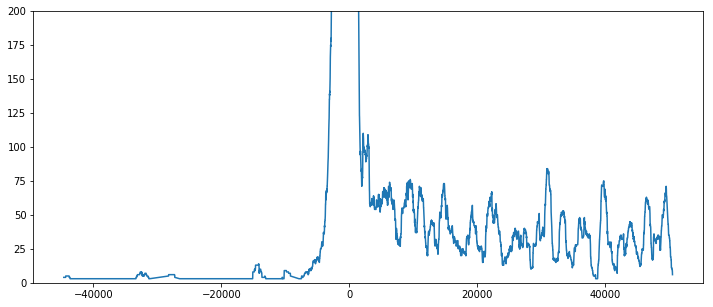

In [34]:
plt.plot(X,y,'')
plt.ylim([0,200])


In [41]:
for i in range(N):
    plt.plot(list(X[i]),list(X[i].values()),'')

AttributeError: 'list' object has no attribute 'values'

(-100, 100)

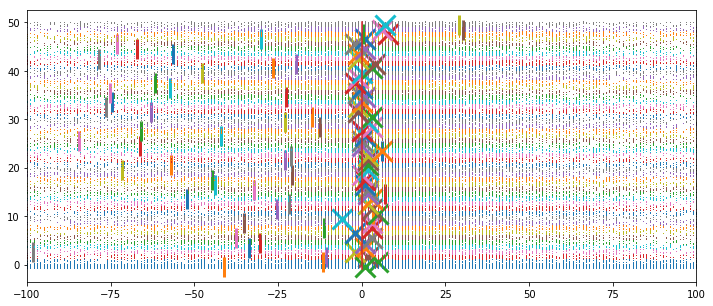

In [67]:
G = 2000
N = 50
X = [
    sorted([
        y for x,y in D[i*len(D)//N:(i+1)*len(D)//N]
        if -G < y < G
    ])
    for i in range(N)
]
H = sorted([
        y for x,y in D
        if -G < y < G
    ])
for i in range(N):
    plt.plot(list(X[i]),i+np.random.random(len(X[i])),',')
    plt.plot([np.mean(list(X[i]))],[i+0.5],'|',markersize = 20,markeredgewidth = 3)
    plt.plot([list(X[i])[len(X[i])//2]],[i+0.5],'x',markersize = 20,markeredgewidth = 3)
plt.plot(list(H),-1+np.random.random(len(H)),',')
plt.plot([np.mean(list(H))],[-0.5],'|',markersize = 20,markeredgewidth = 3)
plt.plot([list(H)[len(H)//2]],[-0.5],'x',markersize = 20,markeredgewidth = 3)
plt.plot([0,0],[-1,N])
plt.xlim(-100,100)

In [26]:
list(X[0])[len(X[0])//2]

-12.0

In [70]:
D = [(
        a,b,d, min(
            (
                d - (position[r_b] - position[r_a])
                for r_a, r_b in it.product(contig_repeat[a], contig_repeat[b])
            ),  key = abs)
    ) for a,b,d in roh_data
]

A = coll.Counter([intName[a+'_0'] for e in D if 20000<e[-1]<83000 for a in e[:2]])


In [76]:
intName[786]

'1746APD_0'

In [86]:
repeats = set()
for r in contig_repeat:
    if len(contig_repeat[r]) > 1:
        repeats.add(r)

In [104]:
constr_pos = get_constr_pos(roh_data,position,contig_repeat)

In [134]:
X = []
for c in constr_pos:
    if c in repeat:
        X += [int(gruppierung(constr_pos[c],500,20)[0].güte_0) for i in range(len(contig_repeat[c]))]
print(sorted(X))

NameError: name 'repeat' is not defined

In [130]:
constr_pos[c]

[(314469.0, 98, 1, False),
 (314570.0, 48, 1, False),
 (314545.0, 26, 1, False),
 (314540.0, 33, 1, False),
 (314488.0, 76, 1, False),
 (314321.0, 112, 1, False),
 (314583.0, 112, 1, False),
 (336968.0, 149, 1, False),
 (337016.0, 149, 1, False),
 (337033.0, 149, 1, False),
 (314591.0, 68, 1, False),
 (314611.0, 60, 1, False),
 (314627.0, 18, 1, False),
 (314327.0, 113, 1, False),
 (314566.0, 113, 1, False),
 (314528.0, 37, 1, False),
 (314512.0, 81, 1, False),
 (314596.0, 65, 1, False),
 (314525.0, 82, 1, False),
 (314051.0, 130, 1, False),
 (314379.0, 130, 1, False),
 (314415.0, 130, 1, False),
 (314496.0, 130, 1, False),
 (314791.0, 2, 1, False),
 (314531.0, 93, 1, False),
 (314592.0, 52, 1, False),
 (314498.0, 84, 1, False),
 (314568.0, 49, 1, False),
 (314660.0, 15, 1, False),
 (336974.0, 146, 1, False),
 (314373.0, 104, 1, False),
 (314477.0, 104, 1, False),
 (314567.0, 47, 1, False),
 (314769.0, 5, 1, False),
 (314027.0, 124, 1, False),
 (314452.0, 124, 1, False),
 (314471.0, 12

In [125]:
sorted(X)[-20:]

[705.4903262793123,
 707.1713415316689,
 711.1198812596291,
 711.3622142916358,
 712.9887546054543,
 715.9640329076058,
 718.7738954059621,
 733.9339901973,
 737.5613429683796,
 756.5742669610136,
 768.7780155271364,
 771.5796715246563,
 782.8551136513144,
 792.7872828317538,
 808.1737487262633,
 844.7897794048758,
 875.3965240766297,
 904.3680841390322,
 916.7800826617034,
 1031.9359077118597]

## for a in A:
    if (intName[a][:-2] in reps) != (intName[a][:-2] in repeats):
        print(intName[a][:-2] in reps, intName[a][:-2] in repeats, a,intName[a])

In [37]:
len([d for d,_ in W if d < 1000]),len([d for d,_ in W if 1000<d < 10000])

NameError: name 'W' is not defined

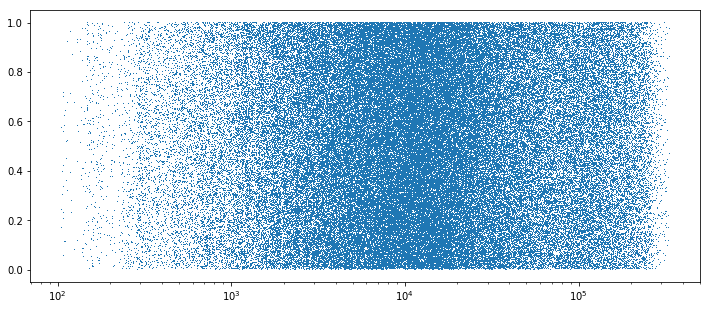

In [29]:
plt.plot(D,np.random.random(len(D)),',')
plt.xscale('log')

In [12]:
intName = get_intName(position)

In [13]:
len(position), len(feste_position)

(2130, 2031)

In [22]:
gruppen['2080APD']

[Repeat(pos=4897607.297905118, güte=0, güte_0=62.79258991295411, stärke=39, gewicht=7, in_out=0, genauigkeit=0.9492871402185189)]

In [19]:


R = set()
r = set()
for a, G in gruppen.items():
    for i,g in enumerate(G):
        if g.güte_0 > 50:
            R.add(intName[contig_repeat[a][i]])
        else:
            r.add(intName[contig_repeat[a][i]])

In [20]:
print(sorted(r))

[11, 17, 22, 24, 37, 45, 50, 57, 84, 88, 89, 90, 91, 95, 96, 99, 100, 102, 104, 119, 120, 121, 122, 222, 242, 247, 248, 264, 274, 299, 300, 301, 302, 303, 306, 309, 310, 314, 316, 342, 346, 377, 395, 418, 447, 448, 449, 451, 454, 462, 463, 472, 483, 486, 487, 496, 497, 505, 506, 551, 599, 600, 620, 644, 649, 651, 662, 664, 665, 666, 667, 703, 706, 734, 735, 803, 811, 876, 906, 909, 954, 1029, 1045, 1051, 1052, 1054, 1056, 1069, 1092, 1093, 1101, 1110, 1114, 1160, 1168, 1170, 1195, 1202, 1221, 1222, 1293, 1337, 1345, 1410, 1411, 1432, 1443, 1448, 1454, 1456, 1466, 1476, 1482, 1487, 1491, 1507, 1537, 1571, 1578, 1579, 1669, 1694, 1699, 1711, 1752, 1755, 1756, 1763, 1807, 1811, 1812, 1827, 1828, 1841, 1878, 1887, 1902, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1961, 2066, 2080, 2124]


In [17]:
gruppen['501APD']

[Repeat(pos=1299741.601348389, güte=42.47010315537633, güte_0=50.176323254038486, stärke=49, gewicht=13, in_out=1, genauigkeit=0.23422535296013852)]

(-1, 1)

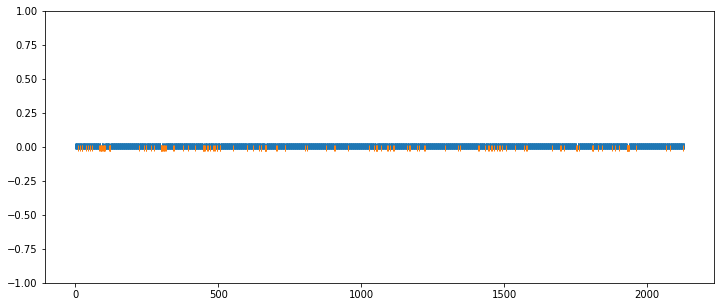

In [21]:

plt.plot(sorted(R),[0.01]*len(R),'|')
plt.plot(sorted(r),[-0.01]*len(r),'|')
plt.ylim([-1,1])
#plt.xlim([000,3000])

In [324]:
def get_contig_lengths(file):
    contig_len = {}
    for line in file:
        contig, length = line.split()
        length = int(length)
        if contig in contig_len:
            print("Error: double cont: " + contig + " | v1: " + str(contig_len[contig]) + " | v2: " + str(length))
        contig_len[contig] = length
    return contig_len

poss = sorted(pos.items(), key = lambda x: x[1])
contig_len = get_contig_lengths(open('APDContigs.len'))
x_werte = [(contig, start, start+contig_len[contig_name(contig)]) for contig, start in poss]

In [326]:
pos['2075APD_0'],pos['2075APD_1']

(612203.0, 683108.0)

694APD_0
462APD_0


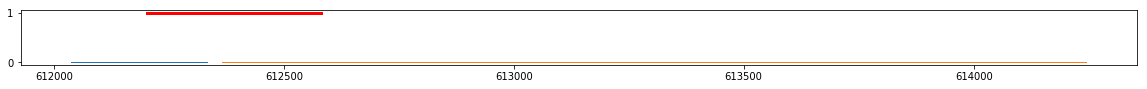

In [332]:

plt.rcParams['figure.figsize'] = 20, 1
y_frei = coll.defaultdict(int)
c, _ = poss[0]
for contig, x1, x2 in x_werte:
    y = 0
    if not -1000 <= x1-612203  <= 1000:
        continue
    while y_frei[y] > x1:
        y += 1
    """if contig[-1] != '0':
        plt.plot([x1,x2],[y,y],linewidth = 1)
       # x1 = x1 + contig_len[contig_name(contig)]/2
        x3 = position3[contig_name(contig) + '_0'] #+ contig_len[contig_name(contig)]/2
      #  plt.plot([x1,x2],[y,y],linewidth = 20, color = 'r')
        if x1 > x3:
            x1,x3 = x3,x1
        plt.plot([x1,x3],[0,1])#, color = 'r')
    else:"""
    
    if contig_name(contig) in repeats:
        print(contig)
    if contig_name(contig) == '2075APD':
        plt.plot([x1,x2],[y,y],linewidth = 3, color = 'r')
    elif contig_name(contig) == '342APD':
        plt.plot([x1,x2],[y,y],linewidth = 1, color = 'g')
    elif contig_name(contig) == '145APD':
        plt.plot([x1,x2],[y,y],linewidth = 1, color = 'm')
    elif contig_name(contig) in repeats:
        plt.plot([x1,x2],[y,y],linewidth = 1)
    else:
        plt.plot([x1,x2],[y,y],linewidth = 1, color = 'k')
    y_frei[y] = x2
    
#plt.xlim([1280000,1450000])

In [410]:
sorted([Repeat(pos=1301298.0, güte=624.0962599975447, güte_0=771.5867786761135),
 Repeat(pos=1407586.0, güte=33.40488953390422, güte_0=43.17120632227438),
 Repeat(pos=1356148.0, güte=10.336685242981025, güte_0=13.799510239443357),
 Repeat(pos=1197401.0, güte=2.9531423039737588, güte_0=4.300825200738316),
 Repeat(pos=1354981.0, güte=1.336131159299153, güte_0=2.0066908504460876),
 Repeat(pos=1312473.0, güte=0.6712328767123288, güte_0=1.1221917808219177),
 Repeat(pos=1370335.0, güte=0.6024590163934426, güte_0=1.0072131147540984),
 Repeat(pos=1365514.0, güte=0.336, güte_0=0.5617371428571428)])

[Repeat(pos=1197401.0, güte=2.9531423039737588, güte_0=4.300825200738316),
 Repeat(pos=1301298.0, güte=624.0962599975447, güte_0=771.5867786761135),
 Repeat(pos=1312473.0, güte=0.6712328767123288, güte_0=1.1221917808219177),
 Repeat(pos=1354981.0, güte=1.336131159299153, güte_0=2.0066908504460876),
 Repeat(pos=1356148.0, güte=10.336685242981025, güte_0=13.799510239443357),
 Repeat(pos=1365514.0, güte=0.336, güte_0=0.5617371428571428),
 Repeat(pos=1370335.0, güte=0.6024590163934426, güte_0=1.0072131147540984),
 Repeat(pos=1407586.0, güte=33.40488953390422, güte_0=43.17120632227438)]

In [23]:
gruppen['501APD']

[Repeat(pos=1301429.0, güte=80.87131265080825, güte_0=102.64898669191908),
 Repeat(pos=1355246.0, güte=1.124238966571215, güte_0=1.6361049680510888),
 Repeat(pos=1356187.0, güte=1.9474942971817126, güte_0=2.814129259427575)]

In [110]:
gr = nx.MultiDiGraph()
for a,b,d in data:
    if contig_name(b) == contig_name(a) == '501APD':
        print(a,b,d)
    gr.add_edge(a,b,d)
    continue
    ca = contig_name(a)
    cb = contig_name(b)

501APD_1 501APD_2 11383.0
501APD_2 501APD_3 41303.0


In [ ]:
for r in 

In [111]:
for r in contig_repeat['501APD']:
    print(r)
    for a,b,d in gr.in_edges(r, keys = True):
        print(a,int(d-position[b]+position[a]),contig_name(a) in repeats)
    print()
    
    for a,b,d in gr.out_edges(r, keys = True):
        print(b,int(position[b]-position[a]-d),contig_name(b) in repeats)
    print()

501APD_0
1016APD_0 -33 False
1016APD_0 -13 False
1016APD_0 0 False
1016APD_0 4 False
1016APD_0 87 False
1016APD_0 163 False
1074APD_0 7 False
1074APD_0 10 False
1074APD_0 13 False
1074APD_0 14 False
1074APD_0 16 False
1074APD_0 16 False
1074APD_0 19 False
1295APD_0 -184 False
1525APD_0 -147 False
1607APD_0 -103912 False
1769APD_0 -308 True
1952APD_0 -212 False
2459APD_0 -103860 False
371APD_0 -87 False
371APD_0 -48 False
371APD_0 260 False
829APD_0 -182 False

1015APD_0 23082 False
1015APD_0 10825 False
1015APD_0 1 False
1015APD_0 -28 False
1016APD_0 -35349 False
1259APD_0 -103861 False
131APD_0 13565 False
145APD_0 470 True
145APD_0 141 True
145APD_0 0 True
145APD_0 -14 True
145APD_0 -22 True
145APD_0 -28 True
145APD_0 -28 True
145APD_0 -30 True
145APD_0 -31 True
145APD_0 -34 True
145APD_0 11998 True
145APD_0 8099 True
145APD_1 293 True
145APD_1 0 True
1525APD_0 -35284 False
1742APD_0 13437 False
1813APD_0 11325 False
1813APD_0 -28 False
182APD_0 12592 False
182APD_0 91 False
1874APD_

In [390]:
print(position['501APD_1']-position['501APD_0'])
print(position['501APD_2']-position['501APD_0'])
print(position['501APD_3']-position['501APD_0'])
print(position['501APD_2']-position['501APD_1'])
print(position['501APD_3']-position['501APD_1'])
print(position['501APD_3']-position['501APD_2'])

103897.0
115072.0
157580.0
11175.0
53683.0
42508.0


In [391]:
intName = get_intName(position)

In [395]:
intName['501APD_0']

433

In [115]:
cp = get_constr_pos(data, position, repeats)

In [161]:
for g in gruppierung(cp['501APD'], 500, min_güte = 0.0000000001):
    print(np.std(g.gruppe))

168.5862653290175
193.05896276942815
129.93306767764918
177.61989475319533


In [117]:
print(position['501APD_2']-position['501APD_1'])

1257.0


In [ ]:
501APD_0
501APD_1
501APD_2
501APD_3
342APD_0
342APD_1
145APD_0
145APD_1
1874APD_0
2324APD_0
271APD_0
211APD_0
40APD_0

In [88]:
for contig, x1, x2 in x_werte:
    if contig_name(contig) == '501APD':
        print(contig,x1,x2)

501APD_0 1301271.0239498056 1317304.0239498056
501APD_1 1355039.0 1371072.0
501APD_2 1356296.0 1372329.0
501APD_3 1407675.0 1423708.0


In [163]:
intName['501APD_0'],intName['501APD_3']

(490, 519)

In [187]:
a = {1}
%timeit not 1 in a
%timeit 1 not in a
%timeit 1 in a

64 ns ± 0.879 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
83.3 ns ± 27.5 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)
82.9 ns ± 28.6 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [260]:
for r in repeats:
    if r in reps:
        print(r)
        for g in sorted(gruppen[r], key=lambda x: x.güte):
            print(g)
       # print(r, g.güte, r in reps)

58APD
Repeat(pos=652642.5220247669, güte=44.46741200685622, güte_0=30.153511877895987, stärke=19, gewicht=7, in_out=1, genauigkeit=0.8336637762597762)
Repeat(pos=643755.5614347846, güte=182.8966219149297, güte_0=126.82534676821743, stärke=151, gewicht=6, in_out=1, genauigkeit=0.4685700107384447)
Repeat(pos=580770.5614347846, güte=389.8922948497134, güte_0=243.68268428107086, stärke=161, gewicht=16, in_out=1, genauigkeit=0.6054228180896171)
1693APD
Repeat(pos=1208604.601348389, güte=21.096219072498553, güte_0=17.203225686599772, stärke=17, gewicht=3, in_out=1, genauigkeit=0.7829548412177055)
Repeat(pos=1961840.7295197332, güte=425.4562868063111, güte_0=267.1776188100864, stärke=99, gewicht=15, in_out=1, genauigkeit=1.0999894021602197)
462APD
Repeat(pos=684510.5614347846, güte=575.0175804654775, güte_0=351.0668431621933, stärke=174, gewicht=23, in_out=1, genauigkeit=0.7305523325224664)
Repeat(pos=613542.3846948354, güte=662.5081341929376, güte_0=404.48265782084746, stärke=179, gewicht=23

In [182]:
m = [('', Repeat(0,0,0,0,0,0,0))]
for a in constr_pos:
    G = gruppierung(constr_pos[a],500,0.0)
    G = [(a,g) for g in G if g.güte < 10 and not -2000 <= g.pos - position[a+'_0'] <= 2000] + m
    m = sorted(G, key = lambda x: x[1].güte_0)[-30:]
m

[('1180APD',
  Repeat(pos=4719980.297905118, güte=0, güte_0=5.9139816078747725, stärke=21, gewicht=1, in_out=0, genauigkeit=1.1264726872142423)),
 ('106APD',
  Repeat(pos=434149.56143478455, güte=0, güte_0=6.254975482991224, stärke=11, gewicht=1, in_out=1, genauigkeit=1.137268269634768)),
 ('131APD',
  Repeat(pos=1308821.601348389, güte=0, güte_0=6.65332020256765, stärke=5, gewicht=2, in_out=1, genauigkeit=0.8871093603423533)),
 ('25APD',
  Repeat(pos=4393161.73177085, güte=0, güte_0=6.749880581779128, stärke=23, gewicht=1, in_out=1, genauigkeit=0.5869461375460111)),
 ('1016APD',
  Repeat(pos=1337459.601348389, güte=0, güte_0=6.848424148920935, stärke=5, gewicht=6, in_out=0, genauigkeit=0.8879750269016253)),
 ('2138APD',
  Repeat(pos=2004276.7295197332, güte=0, güte_0=7.322921657826251, stärke=31, gewicht=32, in_out=0, genauigkeit=0.08589937428535192)),
 ('2138APD',
  Repeat(pos=2026608.7295197332, güte=0, güte_0=7.322921657826251, stärke=31, gewicht=32, in_out=0, genauigkeit=0.0858993

In [191]:
print(constr_pos['2138APD'])

[(2015524.7295197332, '2138APD_0', 1, False), (2015194.7295197332, '2138APD_0', 0, False), (2015528.7295197332, '2138APD_0', 1, False), (2015190.7295197332, '2138APD_0', 0, False), (2015528.7295197332, '2138APD_0', 1, False), (2015190.7295197332, '2138APD_0', 0, False), (2015528.7295197332, '2138APD_0', 1, False), (2015190.7295197332, '2138APD_0', 0, False), (2015536.7295197332, '2138APD_0', 1, False), (2015182.7295197332, '2138APD_0', 0, False), (2015561.7295197332, '2138APD_0', 1, False), (2015157.7295197332, '2138APD_0', 0, False), (2015568.7295197332, '2138APD_0', 1, False), (2015150.7295197332, '2138APD_0', 0, False), (2015570.7295197332, '2138APD_0', 1, False), (2015148.7295197332, '2138APD_0', 0, False), (2015570.7295197332, '2138APD_0', 1, False), (2015148.7295197332, '2138APD_0', 0, False), (2015570.7295197332, '2138APD_0', 1, False), (2015148.7295197332, '2138APD_0', 0, False), (2015570.7295197332, '2138APD_0', 1, False), (2015148.7295197332, '2138APD_0', 0, False), (2015570.

In [197]:
D = []
D2 = []
D3 = []
for a,b,d in roh_data:
    if a=='2138APD' or b == '2138APD':
        if a == b:
            D.append([a,b,d])
        elif a == '2138APD':
            D2.append([a,b,d])
        else:
            D3.append([a,b,d])

In [198]:
D.sort(key = lambda x: x[2])

In [252]:
for a,b,d in D3:
    print(a,b,d)

2398APD 2138APD 1536
2398APD 2138APD 1900


In [248]:
i0=0
i1=0
y = []
X= []
for x in range(0,35000,10):
    while i0 < len(D) and D[i0][2] < x-100:
        i0 += 1
    while i1 < len(D) and D[i1][2] < x+100:
        i1 += 1
    if i1 - i0 > 2:
        X.append(x)
        y.append(i1-i0)

In [249]:
D[0]

['2138APD', '2138APD', 165]

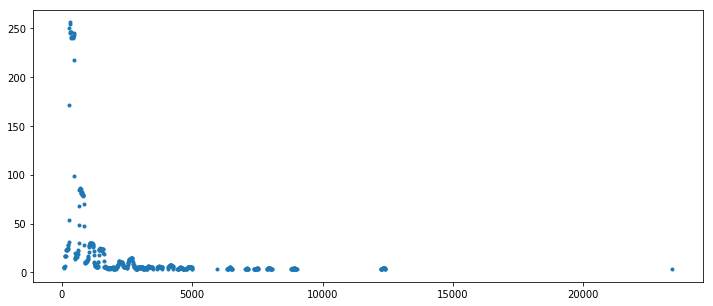

In [250]:
plt.plot(X, y,'.')

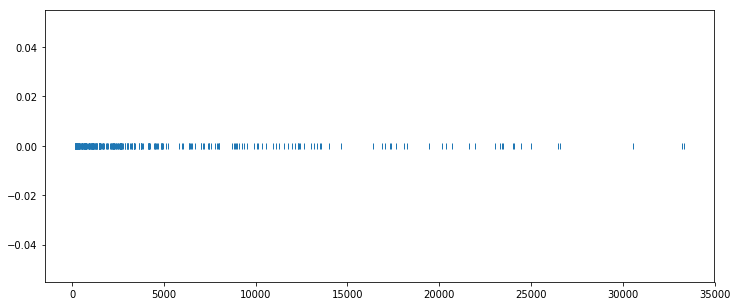

In [201]:
plt.plot([d for a,b,d in D], [0]*len(D),'|')

In [345]:
d1, d2, d3 = umsortieren(roh_data, contig_repeat, position)

In [346]:
d4 = d1+d2+d3

In [337]:
24*24*5.2*1.2*1.2/288.77587648411196

14.935762822409092

In [367]:
a = m.addVar(1)
m.update()
m.addConstr(a<=5)
m.addConstr(2<=a)
m.setObjective(a)
m.optimize()

Optimize a model with 4 rows, 4 columns and 4 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 5e+00]
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.0000000e+00   1.000000e+00   0.000000e+00      0s
       1    2.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  2.000000000e+00


In [19]:

def solve_LP_standard(positionen, data):
    model = Model()
    #model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(positionen)
    
    model.update()
    
    sorted_pos = sorted(positionen , key = lambda x: positionen[x])
    data = data + [
        (a, b, positionen[b] - positionen[a]) 
        for a, b in zip(sorted_pos[:-1],sorted_pos[1:])
    ]
        
    # Bedingungen
    model.addConstr( contig['2345APD_0'] == 0)
    for c in positionen:
        model.addConstr( contig[c] <= position[c] + 20000)
        model.addConstr( contig[c] >= position[c] - 20000)
    fehler = []
    for a, b, dist in data:
        eps = model.addVar()
        model.addConstr( contig[b] - contig[a] - int(dist) <= eps) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + int(dist) <= eps) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    model.update()
    model.optimize()
    print('LP Opt:', model.ObjBound)
    return {cont: contig[cont].X for cont in contig}


In [148]:
constr_pos = get_constr_pos(data, position, repeats)

In [153]:
for a,b,c,d in constr_pos['501APD']:
    bb = contig_name(b)
    if bb == '1074APD':
        print(a,b,c,d)

1301242.0 1074APD_0 1 False
1301245.0 1074APD_0 1 False
1301248.0 1074APD_0 1 False
1301249.0 1074APD_0 1 False
1301251.0 1074APD_0 1 False
1301251.0 1074APD_0 1 False
1301251.0 1074APD_0 1 False
1301254.0 1074APD_0 1 False


In [66]:

datei = 'my_apd1998.lst'
data = read_file(datei)

In [70]:
for a,b,d in data:
    if a==b and 600< d < 2000:
        print(a,b,d)

106APD_0 106APD_0 1507.0
1129APD_0 1129APD_0 1679.0
1230APD_0 1230APD_0 1463.0
1523APD_0 1523APD_0 861.0
160APD_0 160APD_0 1740.0
1664APD_0 1664APD_0 1327.0
207APD_0 207APD_0 1493.0
2113APD_0 2113APD_0 1021.0
2138APD_0 2138APD_0 1009.0
2138APD_0 2138APD_0 1046.0
2138APD_0 2138APD_0 1051.0
2138APD_0 2138APD_0 1077.0
2138APD_0 2138APD_0 1080.0
2138APD_0 2138APD_0 1102.0
2138APD_0 2138APD_0 1106.0
2138APD_0 2138APD_0 1106.0
2138APD_0 2138APD_0 1112.0
2138APD_0 2138APD_0 1114.0
2138APD_0 2138APD_0 1114.0
2138APD_0 2138APD_0 1117.0
2138APD_0 2138APD_0 1121.0
2138APD_0 2138APD_0 1125.0
2138APD_0 2138APD_0 1126.0
2138APD_0 2138APD_0 1126.0
2138APD_0 2138APD_0 1128.0
2138APD_0 2138APD_0 1133.0
2138APD_0 2138APD_0 1133.0
2138APD_0 2138APD_0 1134.0
2138APD_0 2138APD_0 1135.0
2138APD_0 2138APD_0 1135.0
2138APD_0 2138APD_0 1136.0
2138APD_0 2138APD_0 1138.0
2138APD_0 2138APD_0 1145.0
2138APD_0 2138APD_0 1155.0
2138APD_0 2138APD_0 1158.0
2138APD_0 2138APD_0 1160.0
2138APD_0 2138APD_0 1171.0
2138APD_

In [7]:
graph2

NameError: name 'graph2' is not defined

In [224]:

        ss = {a: sorted(s[a], key = lambda x: intName[x], reverse = True) for a in s}
        pp = {a: sorted(p[a], key = lambda x: intName[x]) for a in p}
        
        ss = {a: sorted(ss[a], key = lambda x: s[a][x])[-5:] for a in s}
        pp = {a: sorted(pp[a], key = lambda x: p[a][x])[-5:] for a in p}
        

270

In [111]:
p['5APD_0']

Counter({'1019APD_0': 1,
         '112APD_0': 1,
         '1531APD_0': 3,
         '1594APD_0': 1,
         '2295APD_0': 2,
         '2407APD_0': 4,
         '420APD_0': 1,
         '425APD_0': 1,
         '586APD_0': 6,
         '625APD_0': 2,
         '709APD_0': 3,
         '828APD_0': 1})

In [134]:
x = '2APD_0'
(len(p[x])+len(s[x])+1)/(max(intName[a] for a in s[x])-min(intName[a] for a in p[x]))

1.024390243902439

In [128]:
max(intName[a] for a in s[x]),min(intName[a] for a in s[x]),max(intName[a] for a in p[x]),min(intName[a] for a in p[x])

(801, 776, 774, 760)

In [112]:
for a in sorted(p['5APD_0'], key = lambda x: intName[x])[:]:
    print(intName[a])

1663
1666
1667
1668
1669
1670
1671
1672
1673
1674
1675
1676


In [241]:
for a in sorted(ss['14APD_0'], key = lambda x: p['14APD_0'][x])[-5:]:
    print(intName[a])

KeyError: '14APD_0'

In [296]:
for a in sorted(ss[intName[481]], key = lambda x: s['14APD_0'][x])[-5:]:
    print(intName[a])

485
486
484
482
483


In [100]:

contig_repeat = coll.defaultdict(list)
for contig in positionY:
    contig_repeat[contig_name(contig)].append(contig)
d1,d2,_ = umsortieren(roh_data,contig_repeat,positionY )

In [101]:
'501APD_2' in positionY

False

In [103]:
toll = 2000
s = coll.defaultdict(coll.Counter)
p = coll.defaultdict(coll.Counter)
for a, b, dist in d1+d2:
    real_dist = positionY[b] - positionY[a]
    if abs(real_dist - dist) < tol and a != b:
        if positionY[a] > positionY[b]:
            a, b, real_dist = b, a, -real_dist
        s[a][b] += 1
        p[b][a] += 1

intName = get_intName(positionY)
ss = {a: sorted(s[a], key = lambda x: intName[x], reverse = True) for a in s}
pp = {a: sorted(p[a], key = lambda x: intName[x]) for a in p}

ss = {a: sorted(ss[a], key = lambda x: s[a][x])[-5:] for a in s}
pp = {a: sorted(pp[a], key = lambda x: p[a][x])[-5:] for a in p}

In [298]:
intName[485],intName[486]

('751APD_0', '84APD_0')

In [132]:

tol = 2000
s = coll.defaultdict(coll.Counter)
p = coll.defaultdict(coll.Counter)

for a, b, dist in data:
    real_dist = position[b] - position[a]
    if abs(real_dist - dist) < tol and a != b:
        if positionY[a] > positionY[b]:
            a, b, real_dist = b, a, -real_dist
        s[a][b] += 1
        p[b][a] += 1

intName = get_intName(position)
ss = {a: sorted(s[a], key = lambda x: intName[x]) for a in s}
pp = {a: sorted(p[a], key = lambda x: intName[x], reverse = True) for a in p}

ss = {a: sorted(ss[a], key = lambda x: s[a][x])[-4:] for a in s}
pp = {a: sorted(pp[a], key = lambda x: p[a][x])[-4:] for a in p}

dataX = [
    [a,b,d] 
    for a,b,d in data 
    if (
        ((a in ss and b in ss[a]) or (b in pp and a in pp[b])) and 
        -tol < positionY[b] - positionY[a] - d < tol
    )
]
positionY = solve_LP_standard(positionY, dataX)
intName = get_intName(positionY)
x = []
a = []
for i in range(3000):
    if not i in intName:
        break
    c = contig_name(intName[i])
    if c in reps|repeats:
        continue
    if not intName[i] in intNameX:
        continue
    x.append(i)
    a.append(positionY[intName[i]] - pos[intName[i]])
plt.plot(x,a,)
plt.ylim(-6000,5000)

#plt.xlim(480,500)
plt.show()

KeyboardInterrupt: 

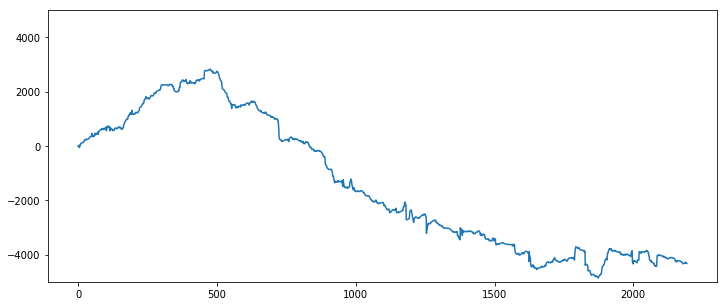

In [49]:
intName = get_intName(positionX)
x = []
a = []
for i in range(3000):
    if not i in intName:
        break
    c = contig_name(intName[i])
    if c in reps|repeats:
        continue
    if not intName[i] in intNameX:
        continue
    x.append(i)
    a.append(positionX[intName[i]] - pos[intName[i]])
plt.plot(x,a,)
plt.ylim(-5000,5000)

#plt.xlim(480,500)
plt.show()

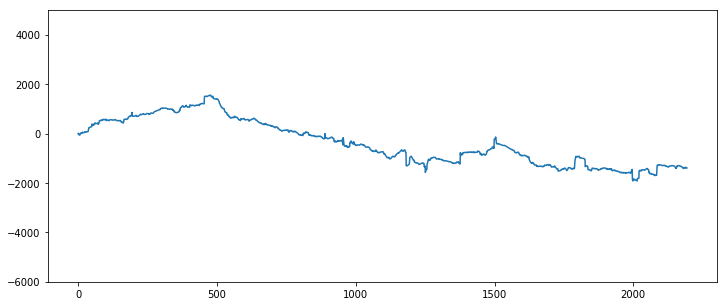

In [71]:
intName = get_intName(position)
L = []
for r in repeats-reps:
    for a in contig_repeat[r]:
        L.append(intName[a])
print(sorted(L))

[19, 21, 126, 134, 142, 143, 144, 145, 147, 151, 153, 157, 158, 163, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 289, 310, 483, 484, 493, 509, 527, 543, 690, 1135, 1164, 1172, 1173, 1175, 1176, 1177, 1181, 1183, 1186, 1187, 1188, 1203, 1208, 1211, 1213, 1215, 1216, 1217, 1218, 1221, 1223, 1226, 1228, 1229, 1231, 1245, 1246, 1278, 1546, 1555, 1559, 1560, 1561, 1564, 1570, 1576, 1579, 1580, 1581, 1583, 1728, 1783, 1786, 1798, 1801, 1833, 1838, 1841, 1878, 1881, 1882]


In [203]:
intName = get_intName(position)
iN = get_intName(positionY)

In [ ]:
i=0
j=0
while True:
    i += 1
    j += 1
    if intName[i] != iN[j]:
        print(i,j)
        try:
            i = intName[iN[j]]
        except:
            j = iN[intName[i]]
        print(i,j)
        print()

In [209]:
intName[263],iN[263]

('2394APD_0', '407APD_0')

In [200]:
contig_repeat = coll.defaultdict(list)

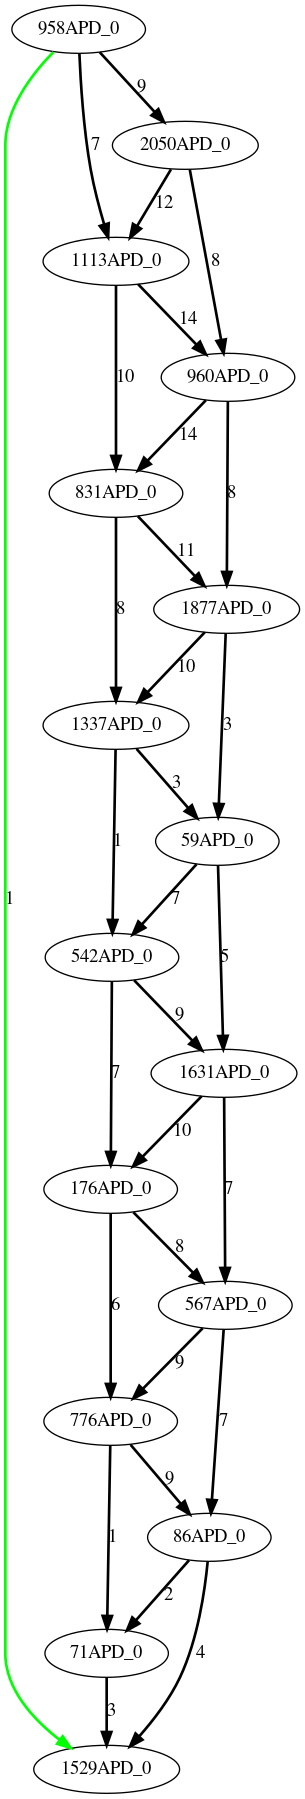

In [201]:
plot_graph(position,data,30,45)

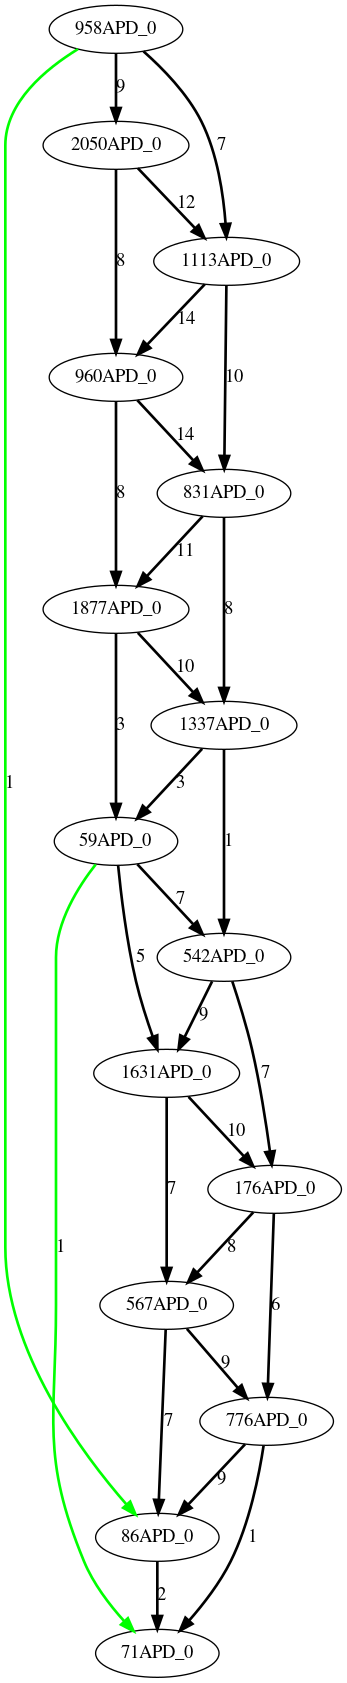

In [202]:
plot_graph(positionY,d1+d2,30,45)

In [214]:
print(positionY)

{'2206APD_0': 1240945.0, '2356APD_0': 1416566.0, '987APD_0': 4287939.0, '546APD_0': 16529.0, '1472APD_0': 141134.0, '554APD_0': 3749066.0, '2435APD_0': 2256023.0, '307APD_0': 818368.0, '784APD_0': 4613369.0, '1822APD_0': 1492415.0, '134APD_0': 761928.0, '863APD_0': 3603810.0, '1444APD_0': 3173516.0, '2238APD_0': 3321107.0, '1838APD_0': 3891273.0, '2169APD_0': 2752469.0, '1407APD_0': 3579200.0, '1795APD_0': 3684359.0, '624APD_0': 2292705.0, '1649APD_0': 2068367.0, '2378APD_0': 1975255.0, '709APD_0': 3707246.0, '1006APD_0': 1767273.0, '1874APD_1': 2937128.0, '100APD_0': 4094167.0, '94APD_0': 702266.0, '1960APD_0': 3043702.0, '1548APD_0': 3570128.0, '1920APD_0': 1958586.0, '452APD_0': 830792.0, '138APD_0': 2338471.0, '2462APD_0': 3514302.0, '2369APD_0': 2093407.0, '1706APD_0': 1585077.0, '2187APD_0': 2036731.0, '1064APD_1': 2957999.0, '967APD_0': 3395142.0, '271APD_1': 2987855.0, '1562APD_0': 2630813.0, '876APD_0': 226207.0, '1707APD_0': 3123520.0, '2302APD_0': 4028956.0, '1843APD_0': 250

In [15]:
Lösung2 = {'2206APD_0': 1240945.0, '2356APD_0': 1416566.0, '987APD_0': 4287939.0, '546APD_0': 16529.0, '1472APD_0': 141134.0, '554APD_0': 3749066.0, '2435APD_0': 2256023.0, '307APD_0': 818368.0, '784APD_0': 4613369.0, '1822APD_0': 1492415.0, '134APD_0': 761928.0, '863APD_0': 3603810.0, '1444APD_0': 3173516.0, '2238APD_0': 3321107.0, '1838APD_0': 3891273.0, '2169APD_0': 2752469.0, '1407APD_0': 3579200.0, '1795APD_0': 3684359.0, '624APD_0': 2292705.0, '1649APD_0': 2068367.0, '2378APD_0': 1975255.0, '709APD_0': 3707246.0, '1006APD_0': 1767273.0, '1874APD_1': 2937128.0, '100APD_0': 4094167.0, '94APD_0': 702266.0, '1960APD_0': 3043702.0, '1548APD_0': 3570128.0, '1920APD_0': 1958586.0, '452APD_0': 830792.0, '138APD_0': 2338471.0, '2462APD_0': 3514302.0, '2369APD_0': 2093407.0, '1706APD_0': 1585077.0, '2187APD_0': 2036731.0, '1064APD_1': 2957999.0, '967APD_0': 3395142.0, '271APD_1': 2987855.0, '1562APD_0': 2630813.0, '876APD_0': 226207.0, '1707APD_0': 3123520.0, '2302APD_0': 4028956.0, '1843APD_0': 2506665.0, '162APD_0': 3462502.0, '999APD_0': 1504349.0, '468APD_0': 4820486.0, '1668APD_0': 4893461.0, '1977APD_0': 1822212.0, '1358APD_0': 1913774.0, '1123APD_0': 3687685.0, '2153APD_0': 2304720.0, '2149APD_0': 389754.0, '1476APD_0': 3554571.0, '393APD_0': 3991408.0, '2091APD_0': 2839414.0, '2434APD_0': 452703.0, '2199APD_0': 3340836.0, '939APD_0': 410870.0, '213APD_0': 4352000.0, '1140APD_0': 2062505.0, '602APD_0': 2412563.0, '2048APD_0': 2823858.0, '758APD_0': 1918828.0, '1497APD_1': 3468467.0, '2020APD_0': 1692190.0, '1938APD_0': 2434198.0, '641APD_0': 343332.0, '2163APD_0': 3112294.0, '1512APD_0': 4739936.0, '573APD_0': 948527.0, '714APD_0': 504727.0, '2159APD_0': 1701422.0, '161APD_0': 3723669.0, '718APD_0': 3687016.0, '1587APD_0': 4584197.0, '584APD_0': 1233827.0, '1356APD_0': 2200311.0, '869APD_0': 3937940.0, '782APD_0': 3301720.0, '938APD_0': 4847927.0, '2294APD_0': 4666157.0, '612APD_0': 2621612.0, '1499APD_0': 2203309.0, '1970APD_0': 881603.0, '472APD_0': 4874151.0, '1661APD_0': 471146.0, '1136APD_0': 2205548.0, '106APD_0': 443866.0, '684APD_0': 309145.0, '1862APD_0': 2216563.0, '2182APD_0': 1778039.0, '670APD_0': 1149739.0, '807APD_0': 3591639.0, '1939APD_0': 286175.0, '280APD_0': 1830203.0, '2021APD_0': 347983.0, '1332APD_0': 64571.0, '2459APD_0': 1195655.0, '415APD_0': 3149480.0, '2309APD_0': 3679607.0, '2167APD_0': 3653714.0, '1810APD_0': 3423629.0, '1255APD_0': 2178252.0, '511APD_0': 152164.0, '1656APD_0': 4049587.0, '2263APD_0': 4746258.0, '2436APD_0': 3131804.0, '1303APD_0': 3169434.0, '1693APD_0': 1207801.0, '1687APD_0': 3255632.0, '849APD_0': 2761767.0, '185APD_0': 2299437.0, '679APD_0': 4643045.0, '1066APD_0': 2551278.0, '160APD_0': 3965568.0, '1556APD_0': 3185970.0, '1981APD_0': 374710.0, '244APD_0': 1180178.0, '1847APD_0': 2318378.0, '1147APD_0': 1104525.0, '516APD_0': 1176703.0, '746APD_0': 3292174.0, '86APD_0': 131609.0, '952APD_0': 4540484.0, '1033APD_0': 873310.0, '1420APD_0': 2755918.0, '225APD_0': 68447.0, '821APD_0': 3042665.0, '1223APD_0': 1714932.0, '956APD_0': 3606064.0, '2113APD_0': 55855.0, '591APD_0': 3076790.0, '796APD_0': 3364236.0, '1742APD_0': 1358514.0, '1697APD_1': 3485100.0, '2254APD_0': 4579436.0, '1800APD_0': 2816421.0, '1552APD_0': 1986239.0, '1030APD_0': 1813301.0, '2344APD_0': 4766492.0, '921APD_0': 367475.0, '566APD_0': 2481647.0, '557APD_0': 3373335.0, '243APD_0': 3266356.0, '1339APD_0': 4325920.0, '505APD_0': 4707882.0, '1253APD_0': 899075.0, '1463APD_0': 603561.0, '2130APD_0': 4629622.0, '733APD_0': 3032232.0, '487APD_0': 3273580.0, '1355APD_0': 1717865.0, '72APD_1': 2947515.0, '2138APD_0': 2013744.0, '707APD_0': 4804645.0, '2275APD_0': 1081161.0, '343APD_0': 3090056.0, '333APD_0': 3197349.0, '2012APD_0': 4029357.0, '2287APD_0': 1628270.0, '1440APD_0': 1683387.0, '1138APD_0': 4763743.0, '1449APD_0': 2821044.0, '17APD_0': 2664856.0, '320APD_0': 2010383.0, '2376APD_0': 3893595.0, '1522APD_0': 760551.0, '1769APD_0': 1247157.0, '286APD_0': 2330404.0, '2313APD_0': 4303548.0, '1462APD_0': 3308663.0, '561APD_0': 3554708.0, '1928APD_0': 2034897.0, '1460APD_0': 911569.0, '1747APD_0': 1581663.0, '467APD_0': 4365021.0, '414APD_0': 1181616.0, '1198APD_0': 3101825.0, '1322APD_0': 3166678.0, '916APD_0': 2385138.0, '1637APD_0': 3643860.0, '813APD_0': 2153964.0, '1487APD_0': 2226484.0, '1923APD_0': 2752006.0, '1702APD_0': 3257530.0, '234APD_0': 3521916.0, '182APD_0': 1347245.0, '698APD_0': 3079194.0, '1974APD_0': 1222258.0, '2075APD_1': 684023.0, '1203APD_0': 4287222.0, '530APD_1': 4171063.0, '947APD_0': 4881130.0, '1662APD_0': 3363245.0, '912APD_0': 4173814.0, '2085APD_0': 215161.0, '1891APD_0': 3156094.0, '124APD_0': 3236939.0, '528APD_0': 2459523.0, '1504APD_0': 4810710.0, '1968APD_0': 1805444.0, '951APD_0': 3609618.0, '274APD_0': 2662399.0, '438APD_0': 2406783.0, '1936APD_0': 4695553.0, '1807APD_0': 4855904.0, '1264APD_0': 3020871.0, '828APD_0': 3697918.0, '1485APD_0': 2081036.0, '2258APD_0': 4063213.0, '529APD_0': 2002066.0, '1780APD_0': 4661466.0, '1903APD_0': 158749.0, '2218APD_0': 4832325.0, '267APD_0': 3668074.0, '742APD_0': 1055891.0, '1524APD_0': 2170242.0, '458APD_0': 3659035.0, '1781APD_0': 2234665.0, '2293APD_0': 2096430.0, '412APD_0': 3638069.0, '132APD_0': 1393433.0, '188APD_0': 2008634.0, '2398APD_0': 2014049.0, '2257APD_0': 3397447.0, '2283APD_0': 4646240.0, '433APD_0': 2698726.0, '631APD_0': 1990089.0, '2165APD_0': 3353940.0, '1035APD_0': 1696618.0, '819APD_0': 4562171.0, '1934APD_0': 2255644.0, '1351APD_0': 2122767.0, '1262APD_0': 2421123.0, '1919APD_0': 2487117.0, '971APD_0': 4580532.0, '1336APD_0': 3110412.0, '1363APD_0': 219737.0, '445APD_0': 2850522.0, '1624APD_0': 3236755.0, '64APD_1': 2953552.0, '878APD_0': 1839309.0, '1004APD_1': 3496528.0, '1599APD_0': 1547007.0, '2393APD_0': 3166550.0, '803APD_0': 4274789.0, '117APD_0': 967556.0, '355APD_0': 3051789.0, '1855APD_0': 3793843.0, '112APD_0': 3693514.0, '1362APD_0': 2556251.0, '316APD_0': 1359602.0, '860APD_0': 3664880.0, '424APD_0': 2561860.0, '1580APD_0': 2685643.0, '1494APD_0': 326748.0, '1380APD_0': 220517.0, '1611APD_0': 2902595.0, '1430APD_0': 1231496.0, '736APD_0': 2816931.0, '2374APD_0': 3465773.0, '419APD_1': 3484191.0, '1011APD_0': 1416630.0, '82APD_0': 3246872.0, '1278APD_0': 3012257.0, '1686APD_0': 4631094.0, '1757APD_0': 4730573.0, '897APD_0': 4586465.0, '1979APD_0': 2546749.0, '676APD_0': 1807517.0, '512APD_0': 3908015.0, '1559APD_0': 4057358.0, '1390APD_0': 298775.0, '1501APD_0': 4071157.0, '1393APD_0': 2104873.0, '270APD_0': 3370653.0, '428APD_0': 2819208.0, '622APD_0': 3062600.0, '948APD_0': 203566.0, '1156APD_0': 352451.0, '1684APD_0': 4561090.0, '2460APD_0': 871206.0, '2301APD_0': 2821584.0, '2385APD_0': 4833193.0, '421APD_0': 657770.0, '727APD_0': 1989088.0, '1497APD_0': 3435865.0, '294APD_0': 3817682.0, '2011APD_0': 404974.0, '837APD_0': 4860653.0, '521APD_0': 81058.0, '356APD_0': 2105507.0, '564APD_0': 1722314.0, '1651APD_0': 726857.0, '2114APD_0': 1103602.0, '1172APD_0': 2523436.0, '310APD_0': 4394250.0, '1961APD_0': 3432700.0, '427APD_0': 4756479.0, '1095APD_0': 3611190.0, '175APD_0': 4511719.0, '694APD_0': 612800.0, '940APD_0': 4117541.0, '2005APD_0': 3330493.0, '2388APD_0': 1906592.0, '885APD_0': 235255.0, '744APD_1': 2954462.0, '1558APD_0': 4135549.0, '2019APD_0': 1103299.0, '1932APD_0': 3382290.0, '1805APD_0': 3070030.0, '313APD_0': 2625007.0, '388APD_0': 4068113.0, '2371APD_0': 3385681.0, '432APD_0': 2744576.0, '1523APD_0': 860288.0, '1398APD_0': 4012973.0, '1941APD_0': 1586236.0, '747APD_0': 4633837.0, '238APD_0': 3863086.0, '2101APD_0': 3379610.0, '2346APD_0': 2319168.0, '464APD_0': 789445.0, '1491APD_0': 1699584.0, '2065APD_0': 4681964.0, '1959APD_0': 2852602.0, '2319APD_0': 82996.0, '917APD_0': 2654381.0, '1481APD_0': 49243.0, '1054APD_0': 1150393.0, '1368APD_0': 1632455.0, '1379APD_0': 1233106.0, '578APD_0': 2548346.0, '249APD_0': 2977765.0, '332APD_0': 1726187.0, '854APD_0': 4622480.0, '257APD_0': 2983278.0, '499APD_0': 3411277.0, '207APD_0': 3819410.0, '879APD_0': 1455808.0, '449APD_0': 4655662.0, '1415APD_0': 1711377.0, '166APD_0': 4752588.0, '1902APD_0': 2600699.0, '1553APD_1': 4169532.0, '399APD_0': 1103938.0, '884APD_0': 2159374.0, '89APD_0': 722599.0, '407APD_0': 609634.0, '255APD_0': 3286859.0, '1367APD_0': 4719639.0, '1836APD_0': 2465517.0, '787APD_0': 4728865.0, '2120APD_0': 4405964.0, '895APD_0': 3084755.0, '1606APD_0': 3569811.0, '137APD_0': 4006438.0, '120APD_0': 4483565.0, '1917APD_0': 3116825.0, '140APD_0': 3213416.0, '1311APD_0': 4859923.0, '127APD_0': 2539979.0, '236APD_0': 4018498.0, '2184APD_0': 2556627.0, '69APD_0': 686052.0, '655APD_0': 2878729.0, '500APD_0': 4048155.0, '2185APD_0': 3441332.0, '495APD_0': 2644261.0, '1342APD_0': 3157086.0, '2214APD_0': 1241150.0, '1569APD_0': 3780952.0, '2198APD_0': 4367923.0, '632APD_0': 4798564.0, '1603APD_0': 4231942.0, '2401APD_0': 4866218.0, '2448APD_0': 80666.0, '2034APD_0': 1345505.0, '1439APD_0': 635134.0, '226APD_0': 2284733.0, '469APD_0': 4685620.0, '2055APD_0': 2512784.0, '1676APD_0': 4761838.0, '2231APD_0': 1550488.0, '1724APD_0': 3329267.0, '2352APD_0': 4047750.0, '2384APD_0': 2990705.0, '1361APD_0': 2570658.0, '1334APD_0': 272712.0, '1284APD_0': 1232030.0, '2380APD_0': 297345.0, '2001APD_0': 1139223.0, '1597APD_0': 3659506.0, '2409APD_0': 2072220.0, '1598APD_0': 4658588.0, '1692APD_0': 1145455.0, '155APD_0': 4595777.0, '2259APD_0': 2674211.0, '1734APD_0': 4068283.0, '1200APD_0': 4755043.0, '148APD_0': 1971681.0, '66APD_0': 3354941.0, '145APD_0': 1315923.0, '2428APD_0': 3023894.0, '2391APD_0': 1532282.0, '551APD_0': 1089246.0, '84APD_0': 1366838.0, '957APD_0': 4795382.0, '789APD_0': 287204.0, '1211APD_0': 2860532.0, '1514APD_0': 247070.0, '1340APD_0': 4780508.0, '178APD_0': 1897227.0, '623APD_0': 1137515.0, '687APD_0': 3973737.0, '1252APD_0': 193797.0, '331APD_0': 2169973.0, '1978APD_0': 1769868.0, '72APD_0': 2850523.0, '276APD_0': 392241.0, '899APD_0': 4608391.0, '283APD_0': 3158383.0, '1151APD_0': 206011.0, '1096APD_0': 1945922.0, '2226APD_0': 2633803.0, '834APD_0': 2691676.0, '3APD_0': 944380.0, '697APD_0': 3097023.0, '2207APD_0': 4026498.0, '368APD_0': 2464196.0, '205APD_0': 236063.0, '997APD_0': 4678720.0, '875APD_0': 4559117.0, '353APD_0': 4468486.0, '756APD_0': 2484165.0, '1128APD_0': 3041327.0, '2282APD_0': 3899137.0, '462APD_0': 613135.0, '829APD_0': 1269877.0, '540APD_0': 3132604.0, '241APD_0': 332440.0, '724APD_0': 1569939.0, '1037APD_0': 2628296.0, '2404APD_0': 2198716.0, '2210APD_0': 2785335.0, '1945APD_0': 2918052.0, '240APD_0': 1746772.0, '2323APD_0': 1797308.0, '1899APD_0': 3817056.0, '922APD_0': 2679445.0, '552APD_0': 4141931.0, '1964APD_0': 3297175.0, '1431APD_0': 3577266.0, '1224APD_0': 2841409.0, '1723APD_0': 2164297.0, '845APD_0': 766977.0, '328APD_0': 3065224.0, '625APD_0': 3699903.0, '379APD_0': 405576.0, '1895APD_0': 1176932.0, '1032APD_0': 4379805.0, '2053APD_0': 3115164.0, '1697APD_0': 3452483.0, '2070APD_0': 3661472.0, '1352APD_0': 4417247.0, '1256APD_0': 2198304.0, '1312APD_0': 2988056.0, '1286APD_0': 3289410.0, '55APD_0': 2040718.0, '1447APD_0': 4357611.0, '1364APD_0': 4368874.0, '43APD_0': 4756772.0, '1384APD_0': 4297416.0, '2157APD_0': 1819861.0, '1496APD_0': 4050711.0, '1594APD_0': 3696776.0, '734APD_0': 4592151.0, '323APD_0': 4183652.0, '1137APD_0': 402009.0, '1289APD_0': 2377551.0, '543APD_0': 1086380.0, '1116APD_0': 3015117.0, '1412APD_0': 1561364.0, '1521APD_0': 3604199.0, '1188APD_0': 3651898.0, '1770APD_0': 2376781.0, '163APD_0': 3613700.0, '842APD_0': 3142218.0, '1563APD_0': 2562421.0, '68APD_0': 426367.0, '2452APD_0': 3193304.0, '766APD_0': 558308.0, '2141APD_0': 1506389.0, '2373APD_0': 3338487.0, '534APD_0': 3304163.0, '250APD_0': 3586365.0, '151APD_0': 528412.0, '2063APD_0': 4786057.0, '2340APD_0': 2691137.0, '735APD_0': 376487.0, '2348APD_0': 4814889.0, '2305APD_0': 2166145.0, '719APD_0': 4654355.0, '2008APD_0': 4863117.0, '1526APD_0': 4307567.0, '1373APD_0': 2643311.0, '79APD_0': 2218438.0, '229APD_0': 1180484.0, '360APD_0': 2614267.0, '572APD_0': 743357.0, '1065APD_0': 2200630.0, '958APD_0': 93290.0, '1845APD_0': 2032901.0, '7APD_0': 4072505.0, '2099APD_0': 2070862.0, '892APD_0': 1968558.0, '1489APD_0': 4396970.0, '1581APD_0': 3323389.0, '209APD_0': 34241.0, '2145APD_0': 2111078.0, '637APD_0': 4764092.0, '466APD_0': 274603.0, '1125APD_0': 2702293.0, '1314APD_0': 2259250.0, '1529APD_0': 138279.0, '1347APD_0': 1994532.0, '1835APD_0': 1056769.0, '2447APD_0': 3367994.0, '1115APD_0': 4577869.0, '586APD_0': 3714987.0, '1051APD_0': 3081500.0, '1875APD_0': 4663451.0, '387APD_0': 4817806.0, '380APD_0': 1783225.0, '608APD_0': 2318570.0, '214APD_1': 3992997.0, '242APD_0': 288492.0, '1049APD_0': 1216276.0, '2392APD_0': 4623305.0, '247APD_0': 4567148.0, '1285APD_0': 1443686.0, '369APD_0': 2956386.0, '2330APD_0': 2621878.0, '374APD_0': 244219.0, '122APD_0': 4779762.0, '2281APD_0': 4406757.0, '1749APD_0': 1612985.0, '881APD_0': 1140521.0, '1693APD_1': 1962374.0, '1387APD_0': 2421393.0, '2228APD_0': 3367702.0, '214APD_2': 4016896.0, '1949APD_0': 3243746.0, '2180APD_0': 3064831.0, '214APD_0': 3929746.0, '2455APD_0': 1497767.0, '1804APD_0': 2671856.0, '409APD_0': 4623498.0, '2112APD_0': 1127239.0, '168APD_0': 2098735.0, '597APD_0': 767757.0, '2280APD_0': 4853496.0, '1716APD_0': 2120836.0, '1595APD_0': 425483.0, '1178APD_0': 3342431.0, '1972APD_0': 4556307.0, '2007APD_0': 2875240.0, '21APD_0': 3161855.0, '1020APD_0': 3014439.0, '2255APD_0': 2080724.0, '1246APD_0': 271731.0, '1534APD_0': 14957.0, '665APD_0': 3372937.0, '1699APD_0': 2694373.0, '245APD_0': 3914196.0, '1701APD_0': 307645.0, '491APD_1': 684022.0, '165APD_0': 4804160.0, '754APD_0': 3202505.0, '1324APD_0': 4050176.0, '870APD_0': 4550118.0, '555APD_0': 1551188.0, '1564APD_0': 4302945.0, '1175APD_0': 4749920.0, '339APD_0': 3504837.0, '375APD_0': 4437313.0, '2278APD_0': 1463393.0, '580APD_0': 254846.0, '755APD_0': 1710245.0, '570APD_0': 4382492.0, '1400APD_0': 146115.0, '2456APD_0': 4858854.0, '23APD_0': 1117978.0, '1817APD_0': 1123933.0, '1876APD_0': 2288326.0, '1545APD_0': 3055244.0, '373APD_0': 3901881.0, '1003APD_0': 1677546.0, '2078APD_0': 3397565.0, '1889APD_0': 331111.0, '2103APD_0': 2294964.0, '844APD_0': 2678580.0, '1751APD_0': 483436.0, '1228APD_0': 2225515.0, '2317APD_0': 3595716.0, '799APD_0': 2814263.0, '2084APD_0': 4605941.0, '855APD_0': 279125.0, '1743APD_0': 4699549.0, '1778APD_0': 3639527.0, '2405APD_0': 4679869.0, '1877APD_0': 106421.0, '64APD_0': 2859219.0, '613APD_0': 3819696.0, '1608APD_0': 250881.0, '2047APD_0': 3124224.0, '1114APD_0': 1460500.0, '2077APD_0': 990998.0, '2358APD_0': 944042.0, '282APD_0': 3106083.0, '767APD_0': 4706366.0, '2140APD_0': 2296033.0, '577APD_0': 19046.0, '1679APD_0': 1008738.0, '326APD_1': 2958265.0, '614APD_0': 4757549.0, '659APD_0': 4724052.0, '1896APD_0': 4292439.0, '338APD_0': 3323794.0, '1145APD_0': 1105293.0, '1146APD_0': 2462226.0, '1887APD_0': 4331290.0, '585APD_0': 4303986.0, '164APD_0': 3463495.0, '2329APD_0': 4885406.0, '1185APD_0': 436194.0, '739APD_0': 2378274.0, '1905APD_0': 3814911.0, '2342APD_0': 2680201.0, '2247APD_0': 1183138.0, '227APD_0': 2451864.0, '1636APD_0': 2451542.0, '186APD_0': 3613454.0, '1827APD_0': 2095233.0, '1541APD_0': 766792.0, '157APD_1': 337361.0, '384APD_0': 1742849.0, '2061APD_0': 3809347.0, '2046APD_0': 1550074.0, '135APD_0': 3515119.0, '1553APD_0': 4066326.0, '2339APD_0': 1148650.0, '52APD_1': 3492277.0, '1878APD_0': 1161935.0, '34APD_0': 3507295.0, '1830APD_0': 2683184.0, '1689APD_0': 1707043.0, '1457APD_0': 2117114.0, '2111APD_0': 3604885.0, '635APD_0': 4177371.0, '1730APD_0': 1185675.0, '1448APD_0': 2916874.0, '278APD_0': 3801830.0, '6APD_0': 2049255.0, '447APD_0': 3101367.0, '1566APD_0': 3064239.0, '2186APD_0': 4605352.0, '1819APD_0': 2087022.0, '988APD_0': 2123292.0, '29APD_0': 4772483.0, '311APD_0': 1950954.0, '73APD_0': 902910.0, '1505APD_0': 2709374.0, '1806APD_0': 3462172.0, '1848APD_0': 4705315.0, '179APD_0': 4800734.0, '397APD_0': 3660346.0, '617APD_0': 3265811.0, '235APD_0': 340681.0, '181APD_0': 3250427.0, '2083APD_0': 1910434.0, '1180APD_0': 4682546.0, '2341APD_0': 2981382.0, '496APD_0': 4082467.0, '1904APD_0': 212459.0, '1220APD_0': 2713412.0, '1473APD_0': 1676337.0, '681APD_0': 691574.0, '1787APD_0': 4656482.0, '710APD_0': 3364739.0, '1375APD_0': 187004.0, '342APD_2': 1467364.0, '2245APD_0': 4649051.0, '598APD_0': 3065579.0, '1962APD_0': 4884903.0, '401APD_0': 3943962.0, '2383APD_0': 4754719.0, '1963APD_0': 4648612.0, '2131APD_0': 2407165.0, '1645APD_0': 2325755.0, '2123APD_0': 2813739.0, '1397APD_0': 233711.0, '256APD_0': 3739698.0, '2314APD_0': 4417906.0, '1666APD_0': 4130851.0, '1834APD_0': 4763418.0, '199APD_0': 3313154.0, '1759APD_0': 3095893.0, '1372APD_0': 3562922.0, '11APD_0': 673883.0, '1263APD_0': 1455392.0, '450APD_0': 4611061.0, '950APD_0': 2387643.0, '890APD_0': 2377945.0, '2082APD_0': 3061331.0, '930APD_0': 3341562.0, '1446APD_0': 3229868.0, '2424APD_0': 4306592.0, '2403APD_0': 4081891.0, '745APD_0': 1139502.0, '318APD_0': 280429.0, '2202APD_0': 2660888.0, '898APD_0': 296808.0, '1280APD_0': 2414950.0, '776APD_0': 130324.0, '1582APD_0': 2676753.0, '30APD_0': 3314455.0, '2026APD_0': 789247.0, '2188APD_0': 1800789.0, '18APD_0': 1411114.0, '1268APD_0': 386037.0, '2442APD_0': 4609016.0, '477APD_0': 1734635.0, '2056APD_0': 1825633.0, '204APD_0': 3229422.0, '1999APD_0': 3370018.0, '832APD_0': 327712.0, '1614APD_0': 3157789.0, '2089APD_0': 2318990.0, '1950APD_0': 3663337.0, '929APD_0': 2568751.0, '1000APD_0': 1896845.0, '349APD_0': 4301005.0, '1215APD_0': 4894627.0, '121APD_0': 2550366.0, '1338APD_0': 2901977.0, '1631APD_0': 125058.0, '2195APD_0': 1409429.0, '856APD_0': 2259839.0, '1927APD_0': 3059653.0, '56APD_0': 4390659.0, '672APD_0': 2830996.0, '1629APD_0': 1381220.0, '1029APD_0': 3754910.0, '518APD_0': 2123874.0, '309APD_0': 4730939.0, '510APD_0': 1784996.0, '1825APD_0': 2009673.0, '1144APD_0': 4632969.0, '1752APD_0': 1845289.0, '964APD_0': 1678286.0, '483APD_0': 1444761.0, '1149APD_0': 2246907.0, '285APD_0': 2090765.0, '1833APD_0': 3046786.0, '1812APD_0': 1661148.0, '1670APD_0': 4595510.0, '2142APD_0': 1186667.0, '1139APD_0': 3960082.0, '740APD_0': 379564.0, '2124APD_0': 4884513.0, '2457APD_0': 3976653.0, '2318APD_0': 3077637.0, '1028APD_0': 3429545.0, '98APD_0': 399640.0, '141APD_0': 2639293.0, '1818APD_0': 2819947.0, '923APD_0': 4264025.0, '2052APD_0': 2375398.0, '607APD_0': 3434415.0, '1925APD_0': 2151317.0, '2125APD_0': 311035.0, '2095APD_0': 4716853.0, '83APD_0': 3689308.0, '688APD_0': 3875573.0, '1059APD_0': 1150853.0, '1438APD_0': 3432569.0, '2040APD_0': 2403736.0, '1663APD_0': 3582553.0, '1099APD_0': 2511130.0, '113APD_0': 1419275.0, '857APD_0': 2243552.0, '530APD_0': 4067853.0, '513APD_0': 3346592.0, '491APD_0': 612969.0, '2327APD_0': 2550783.0, '2062APD_0': 2495839.0, '2222APD_0': 4810238.0, '2002APD_0': 2173134.0, '1103APD_0': 2072903.0, '812APD_0': 4666622.0, '2225APD_0': 2687998.0, '1349APD_0': 2605856.0, '315APD_0': 2190961.0, '2162APD_0': 3577606.0, '1754APD_0': 3022045.0, '1733APD_0': 2038370.0, '1APD_0': 614681.0, '212APD_0': 182815.0, '1578APD_0': 2258073.0, '1531APD_0': 3708464.0, '1880APD_0': 1687398.0, '2271APD_0': 3300512.0, '1016APD_0': 1284019.0, '809APD_0': 2398418.0, '202APD_0': 461050.0, '233APD_0': 4501416.0, '92APD_0': 3646146.0, '2351APD_0': 1083903.0, '2331APD_0': 1180826.0, '396APD_0': 4559973.0, '1064APD_0': 2863447.0, '2386APD_0': 1239355.0, '1231APD_0': 2168155.0, '2325APD_0': 3277428.0, '70APD_0': 2248025.0, '1630APD_0': 109277.0, '2441APD_0': 4344940.0, '1691APD_0': 830117.0, '326APD_0': 1232745.0, '2164APD_0': 2069107.0, '1469APD_0': 3858149.0, '633APD_0': 2845648.0, '1893APD_0': 1128384.0, '619APD_0': 2609188.0, '1852APD_0': 526414.0, '184APD_0': 343630.0, '2454APD_0': 2597854.0, '1309APD_0': 474162.0, '773APD_0': 2553577.0, '281APD_0': 1268333.0, '1488APD_0': 4065890.0, '1207APD_0': 2689083.0, '907APD_0': 3433512.0, '1799APD_0': 1835128.0, '482APD_0': 4323544.0, '1076APD_0': 83364.0, '1333APD_0': 3087878.0, '289APD_0': 3290583.0, '216APD_0': 302409.0, '1021APD_0': 2663273.0, '1117APD_0': 2214497.0, '1143APD_0': 2053990.0, '1771APD_0': 186688.0, '2045APD_0': 3821949.0, '1040APD_0': 2657476.0, '298APD_0': 4022492.0, '1509APD_0': 4667064.0, '1849APD_0': 4644280.0, '685APD_0': 4595227.0, '2147APD_0': 4068712.0, '297APD_0': 4074882.0, '370APD_1': 3498826.0, '804APD_0': 3365705.0, '520APD_0': 3465625.0, '1328APD_0': 3686635.0, '1433APD_0': 413674.0, '970APD_0': 1381585.0, '1756APD_0': 2146394.0, '1454APD_0': 367174.0, '1918APD_0': 4793670.0, '646APD_0': 4658297.0, '159APD_0': 2868578.0, '2299APD_0': 4818131.0, '143APD_0': 2973576.0, '1750APD_0': 1563597.0, '203APD_0': 3347266.0, '759APD_0': 2006149.0, '726APD_0': 3920440.0, '541APD_0': 3839367.0, '1623APD_0': 3228357.0, '1590APD_0': 329017.0, '74APD_0': 3272521.0, '705APD_0': 4762336.0, '57APD_0': 556555.0, '1565APD_0': 3143270.0, '1721APD_0': 710754.0, '1850APD_0': 380949.0, '850APD_0': 355667.0, '954APD_0': 4893570.0, '656APD_0': 513027.0, '1520APD_0': 2310863.0, '1549APD_0': 2121088.0, '2144APD_0': 3798156.0, '535APD_0': 3287313.0, '2288APD_0': 3892497.0, '744APD_0': 2860149.0, '846APD_0': 2282132.0, '169APD_0': 4067308.0, '1607APD_0': 1191440.0, '816APD_0': 2958472.0, '2416APD_0': 3108713.0, '1413APD_0': 2069586.0, '2355APD_0': 4608714.0, '1077APD_0': 403675.0, '2438APD_0': 2640873.0, '432APD_1': 2818914.0, '1199APD_0': 436816.0, '1217APD_0': 3188797.0, '2306APD_0': 4730037.0, '1288APD_0': 3685616.0, '1042APD_0': 3136830.0, '2444APD_0': 4453798.0, '1561APD_0': 4118068.0, '1196APD_0': 3287684.0, '973APD_0': 2501446.0, '104APD_0': 2174301.0, '1135APD_0': 3182425.0, '125APD_0': 2022964.0, '53APD_1': 2946638.0, '1404APD_0': 1982790.0, '2410APD_0': 715569.0, '1046APD_0': 4191878.0, '790APD_0': 4607123.0, '1195APD_0': 1667710.0, '2379APD_0': 2060191.0, '426APD_0': 4083683.0, '1307APD_0': 4596830.0, '590APD_0': 2139875.0, '1346APD_0': 1725608.0, '1633APD_0': 2284397.0, '2088APD_0': 252381.0, '547APD_0': 279947.0, '1784APD_0': 3878639.0, '1298APD_0': 4029800.0, '28APD_0': 3268989.0, '1317APD_0': 165839.0, '2335APD_0': 482370.0, '1094APD_0': 3584588.0, '898APD_1': 312267.0, '465APD_0': 2864678.0, '178APD_1': 2907862.0, '1994APD_0': 4775386.0, '1152APD_0': 3644422.0, '2128APD_0': 1239030.0, '2201APD_0': 3553845.0, '606APD_0': 4248333.0, '961APD_0': 3363952.0, '1544APD_0': 1178043.0, '1881APD_0': 3781575.0, '531APD_0': 2988672.0, '1181APD_0': 1646674.0, '1619APD_0': 4747824.0, '661APD_0': 3853325.0, '1452APD_0': 3290215.0, '694APD_1': 683855.0, '1735APD_0': 4277117.0, '1308APD_0': 3641099.0, '22APD_0': 3508775.0, '1451APD_0': 1829185.0, '36APD_0': 3046891.0, '2038APD_0': 1063590.0, '454APD_0': 1527861.0, '919APD_0': 1245992.0, '1638APD_0': 4487829.0, '319APD_0': 2799964.0, '1354APD_0': 1815329.0, '167APD_0': 807422.0, '119APD_0': 733039.0, '102APD_0': 2582225.0, '1392APD_0': 3295611.0, '1935APD_0': 1164398.0, '913APD_0': 3313290.0, '2122APD_0': 322208.0, '2239APD_0': 2295859.0, '473APD_0': 3974787.0, '2407APD_0': 3710350.0, '1102APD_0': 2479318.0, '1842APD_0': 2302781.0, '2006APD_0': 3260423.0, '2440APD_0': 1207867.0, '1993APD_0': 2574885.0, '2097APD_0': 2247706.0, '2418APD_0': 4395905.0, '558APD_0': 3441918.0, '980APD_0': 1136766.0, '336APD_0': 3128063.0, '544APD_0': 2820528.0, '873APD_0': 2421664.0, '571APD_0': 232776.0, '2250APD_0': 936185.0, '1748APD_0': 2696129.0, '905APD_0': 3720752.0, '865APD_0': 604760.0, '877APD_0': 1082745.0, '783APD_0': 1035044.0, '974APD_0': 3651354.0, '372APD_0': 3432160.0, '1761APD_0': 3244702.0, '2264APD_0': 3011908.0, '2031APD_0': 4660863.0, '654APD_0': 1177696.0, '575APD_0': 3025328.0, '291APD_0': 2948731.0, '721APD_0': 4138654.0, '795APD_0': 2682335.0, '1826APD_0': 2177691.0, '2328APD_1': 3472982.0, '891APD_0': 1550909.0, '253APD_0': 1527170.0, '1014APD_0': 4780224.0, '308APD_0': 2165829.0, '77APD_0': 889413.0, '271APD_0': 1385629.0, '1130APD_0': 4166928.0, '1210APD_0': 2207217.0, '1675APD_0': 384649.0, '1480APD_0': 145678.0, '417APD_0': 3619379.0, '772APD_0': 194550.0, '1911APD_0': 45607.0, '1991APD_0': 229566.0, '1859APD_0': 3984192.0, '47APD_1': 3492921.0, '2326APD_0': 2052426.0, '1043APD_0': 3026804.0, '1837APD_0': 1057838.0, '1727APD_0': 4419910.0, '251APD_0': 1906946.0, '1107APD_0': 4630834.0, '1479APD_0': 2153306.0, '1955APD_0': 295597.0, '2350APD_0': 461910.0, '1458APD_0': 2115320.0, '1249APD_0': 1031089.0, '2273APD_0': 4069438.0, '1930APD_0': 288637.0, '354APD_0': 3363697.0, '936APD_0': 1950446.0, '2072APD_0': 4814598.0, '537APD_0': 4013191.0, '674APD_0': 3465625.0, '342APD_1': 1389609.0, '567APD_0': 128449.0, '224APD_0': 2362868.0, '2399APD_0': 1501711.0, '411APD_0': 2864174.0, '174APD_0': 3338865.0, '1073APD_0': 1010213.0, '1828APD_0': 1782928.0, '2256APD_0': 420387.0, '1659APD_0': 4590866.0, '1890APD_0': 3240847.0, '96APD_0': 2538309.0, '592APD_0': 4785604.0, '801APD_0': 4322457.0, '386APD_0': 3245175.0, '2316APD_0': 2356154.0, '1265APD_0': 896660.0, '1910APD_0': 3174810.0, '2394APD_0': 682436.0, '1101APD_0': 2212600.0, '1722APD_0': 3206913.0, '305APD_1': 4012851.0, '75APD_0': 776173.0, '1762APD_0': 2992234.0, '778APD_0': 2133203.0, '382APD_0': 2643971.0, '1283APD_0': 2066938.0, '1471APD_0': 2773265.0, '2132APD_0': 3307275.0, '1142APD_0': 2657701.0, '221APD_0': 2849330.0, '962APD_0': 3681426.0, '1792APD_0': 4562601.0, '1087APD_0': 4724530.0, '1078APD_0': 4835918.0, '1815APD_0': 572815.0, '476APD_0': 1858139.0, '2227APD_0': 1976662.0, '1551APD_0': 2318085.0, '268APD_0': 3635440.0, '1729APD_0': 765229.0, '777APD_0': 1766651.0, '893APD_0': 4747973.0, '1923APD_1': 2821167.0, '445APD_1': 2947513.0, '594APD_0': 4867243.0, '371APD_0': 1277703.0, '1260APD_0': 4849167.0, '820APD_0': 888688.0, '2297APD_0': 1852006.0, '704APD_0': 3211523.0, '2071APD_0': 402767.0, '288APD_0': 3762116.0, '488APD_0': 4380759.0, '1957APD_0': 2206090.0, '479APD_0': 4203388.0, '859APD_0': 1690362.0, '2277APD_0': 2188113.0, '1888APD_0': 4762819.0, '1718APD_0': 4052002.0, '1331APD_0': 4079151.0, '1182APD_0': 3886538.0, '1943APD_0': 3853579.0, '1573APD_0': 4051415.0, '1498APD_0': 2360917.0, '1401APD_0': 4628680.0, '1159APD_0': 2604457.0, '15APD_0': 2781330.0, '99APD_0': 1170752.0, '1871APD_0': 2516100.0, '653APD_0': 794100.0, '830APD_0': 2957680.0, '81APD_0': 4253899.0, '868APD_0': 4034443.0, '1374APD_0': 697616.0, '2033APD_0': 4053753.0, '2036APD_0': 2689433.0, '894APD_0': 1608130.0, '455APD_0': 4753642.0, '33APD_0': 4707322.0, '1155APD_0': 1957171.0, '965APD_0': 4282404.0, '1057APD_0': 138964.0, '532APD_0': 4062389.0, '1456APD_0': 2087941.0, '1160APD_1': 2816405.0, '504APD_0': 2720589.0, '2030APD_0': 4415339.0, '944APD_0': 1175486.0, '1327APD_0': 3056670.0, '1273APD_0': 2594098.0, '1089APD_0': 3312554.0, '1164APD_0': 2124589.0, '162APD_1': 3495120.0, '2029APD_0': 343026.0, '794APD_0': 4744535.0, '272APD_0': 4055596.0, '2116APD_0': 4323829.0, '2270APD_0': 4194758.0, '1510APD_0': 1458308.0, '650APD_1': 2944129.0, '35APD_0': 358847.0, '565APD_0': 791117.0, '172APD_0': 3211115.0, '1417APD_0': 1709361.0, '576APD_1': 2955675.0, '390APD_0': 2920326.0, '1085APD_0': 2296814.0, '729APD_0': 4675769.0, '587APD_0': 4228244.0, '1683APD_0': 3311916.0, '2422APD_0': 2989633.0, '1001APD_0': 4039931.0, '1007APD_0': 2297958.0, '1915APD_0': 3083014.0, '76APD_0': 3722590.0, '1247APD_0': 2385541.0, '1395APD_0': 6985.0, '628APD_0': 4573046.0, '2175APD_0': 3898622.0, '2208APD_0': 4226696.0, '259APD_0': 3946637.0, '2092APD_0': 439388.0, '1775APD_0': 3341130.0, '1084APD_0': 2171790.0, '2235APD_0': 14288.0, '2174APD_0': 2671116.0, '722APD_0': 1653079.0, '2262APD_0': 3182874.0, '640APD_0': 1209158.0, '223APD_0': 4896219.0, '1365APD_0': 4793302.0, '1160APD_0': 2742074.0, '2458APD_0': 267891.0, '392APD_0': 3285798.0, '290APD_0': 1328730.0, '194APD_0': 4676946.0, '116APD_0': 2737095.0, '1658APD_0': 3505016.0, '1696APD_0': 2136045.0, '743APD_0': 1838458.0, '636APD_0': 4616551.0, '761APD_0': 3244130.0, '2057APD_0': 4863686.0, '2412APD_0': 1109144.0, '1429APD_0': 3890493.0, '660APD_0': 3626097.0, '2014APD_0': 4864683.0, '1359APD_0': 3205744.0, '666APD_0': 2324803.0, '1811APD_0': 2956136.0, '1150APD_0': 1850316.0, '1131APD_0': 3170738.0, '261APD_0': 324422.0, '388APD_1': 4171306.0, '219APD_0': 1188126.0, '1119APD_0': 4061087.0, '2433APD_0': 4561521.0, '675APD_0': 2136786.0, '695APD_0': 4091894.0, '339APD_1': 3511410.0, '1436APD_0': 2051956.0, '949APD_0': 3326414.0, '273APD_0': 1598899.0, '1177APD_0': 1004769.0, '13APD_0': 4729280.0, '2067APD_0': 4128962.0, '926APD_0': 4330077.0, '52APD_0': 3459660.0, '545APD_0': 2101543.0, '1208APD_0': 1456404.0, '1038APD_0': 421966.0, '1951APD_0': 4248840.0, '658APD_0': 2853234.0, '975APD_0': 1697746.0, '1857APD_0': 183198.0, '1121APD_0': 1120466.0, '1988APD_0': 3722022.0, '1626APD_0': 298494.0, '599APD_0': 588496.0, '708APD_0': 759018.0, '1330APD_0': 480450.0, '457APD_0': 3999745.0, '1764APD_0': 2144596.0, '2APD_0': 2108135.0, '2360APD_0': 3052790.0, '437APD_0': 4199512.0, '51APD_0': 1524973.0, '2241APD_0': 4127936.0, '1790APD_0': 3393408.0, '1664APD_0': 3615513.0, '1744APD_0': 1847655.0, '1886APD_0': 2113592.0, '1704APD_0': 1946388.0, '525APD_0': 764808.0, '924APD_0': 3639278.0, '1013APD_0': 3421424.0, '1366APD_0': 726319.0, '882APD_0': 2130888.0, '568APD_0': 874744.0, '192APD_0': 3729556.0, '2461APD_0': 454241.0, '906APD_0': 203260.0, '248APD_0': 4802455.0, '2193APD_0': 2200912.0, '1428APD_0': 1965491.0, '596APD_0': 1170526.0, '1502APD_0': 2554057.0, '976APD_0': 2368607.0, '2203APD_0': 2114126.0, '1568APD_0': 1133115.0, '1319APD_0': 3379499.0, '1079APD_0': 2462519.0, '650APD_0': 2847132.0, '520APD_1': 3498240.0, '2023APD_0': 2506310.0, '1640APD_0': 2719918.0, '839APD_0': 4568558.0, '2155APD_0': 753305.0, '2300APD_0': 4571143.0, '389APD_0': 2229039.0, '887APD_0': 2976371.0, '2139APD_0': 3324279.0, '2427APD_0': 3299911.0, '58APD_1': 643338.0, '1455APD_0': 4452286.0, '1034APD_0': 3271924.0, '800APD_0': 232543.0, '1097APD_0': 1171098.0, '2382APD_0': 555999.0, '1567APD_0': 3780810.0, '1885APD_0': 2941553.0, '1214APD_0': 3386003.0, '768APD_0': 1649589.0, '123APD_0': 4830783.0, '1980APD_0': 92218.0, '1396APD_0': 1235545.0, '900APD_0': 557468.0, '2192APD_0': 2524738.0, '686APD_0': 3226189.0, '627APD_0': 667401.0, '1074APD_0': 1291254.0, '149APD_0': 1797121.0, '2066APD_0': 1442103.0, '303APD_0': 2778632.0, '334APD_0': 962571.0, '1325APD_0': 3599540.0, '434APD_0': 4747010.0, '1493APD_0': 3678896.0, '423APD_0': 3682234.0, '446APD_0': 4823640.0, '2303APD_0': 3597600.0, '453APD_0': 3555680.0, '966APD_0': 3140699.0, '2234APD_0': 4222479.0, '1230APD_0': 3251016.0, '937APD_0': 4739503.0, '1973APD_0': 4723521.0, '2236APD_0': 2813157.0, '2240APD_0': 3687383.0, '1755APD_0': 3196582.0, '1234APD_0': 3669446.0, '2311APD_0': 4427322.0, '1655APD_0': 2399202.0, '1389APD_0': 1911825.0, '1644APD_0': 1803409.0, '1813APD_0': 1343350.0, '1426APD_0': 3505388.0, '741APD_0': 3180841.0, '1261APD_0': 828807.0, '874APD_0': 400854.0, '265APD_0': 1121481.0, '329APD_0': 4570127.0, '618APD_0': 2778085.0, '269APD_0': 4896750.0, '2004APD_0': 1591833.0, '62APD_0': 1098393.0, '989APD_0': 439764.0, '1576APD_0': 3822978.0, '2043APD_1': 2958425.0, '909APD_0': 1208171.0, '1665APD_0': 475118.0, '1500APD_0': 613913.0, '10APD_0': 4054374.0, '230APD_0': 2817468.0, '1069APD_0': 3900466.0, '1419APD_0': 3370848.0, '2223APD_0': 1163954.0, '943APD_0': 151422.0, '275APD_0': 1232466.0, '2267APD_0': 3067975.0, '187APD_0': 542259.0, '498APD_0': 1898480.0, '304APD_0': 4806124.0, '514APD_0': 4418717.0, '1543APD_0': 289480.0, '1100APD_0': 4854557.0, '337APD_0': 1133850.0, '2362APD_0': 3253624.0, '2168APD_0': 3067626.0, '750APD_0': 2258945.0, '133APD_0': 3053665.0, '764APD_0': 311452.0, '2194APD_0': 4791709.0, '994APD_0': 1538243.0, '1806APD_1': 3494788.0, '147APD_0': 1793031.0, '361APD_0': 1539699.0, '1056APD_0': 4669540.0, '478APD_0': 2180834.0, '703APD_0': 637726.0, '953APD_0': 4422156.0, '208APD_0': 387564.0, '1802APD_0': 4057971.0, '25APD_0': 4310059.0, '1341APD_0': 2374766.0, '1860APD_0': 2012811.0, '683APD_0': 2147775.0, '1294APD_0': 3518185.0, '990APD_0': 2146987.0, '527APD_0': 2001212.0, '751APD_0': 1365580.0, '1788APD_0': 3751783.0, '198APD_0': 1264237.0, '1197APD_0': 2142037.0, '1647APD_0': 414063.0, '1546APD_0': 3163905.0, '492APD_0': 2283319.0, '2359APD_0': 2103542.0, '346APD_0': 2855204.0, '1024APD_0': 406050.0, '793APD_0': 227379.0, '1157APD_0': 2042164.0, '519APD_0': 2156323.0, '1304APD_0': 4335270.0, '85APD_0': 4063542.0, '1257APD_0': 3589046.0, '2246APD_0': 4112596.0, '1732APD_0': 2522291.0, '2295APD_0': 3704853.0, '1169APD_0': 385289.0, '2060APD_0': 1380885.0, '1570APD_0': 2048347.0, '1240APD_0': 1624476.0, '1377APD_0': 3798501.0, '1053APD_0': 4264359.0, '39APD_0': 4236627.0, '1048APD_0': 1100494.0, '2178APD_0': 2851761.0, '802APD_0': 983619.0, '1766APD_0': 4738716.0, '1225APD_0': 2655056.0, '1992APD_0': 2177442.0, '279APD_0': 1398205.0, '1557APD_0': 4736162.0, '105APD_0': 3919952.0, '1435APD_0': 3355506.0, '1824APD_0': 4285613.0, '197APD_0': 3593494.0, '2200APD_0': 2699021.0, '955APD_0': 1658592.0, '378APD_0': 4562981.0, '748APD_0': 1993043.0, '986APD_0': 352627.0, '693APD_0': 3633260.0, '2324APD_0': 1366424.0, '2343APD_0': 4412030.0, '609APD_0': 1042249.0, '2058APD_0': 149738.0, '116APD_1': 2811456.0, '31APD_0': 506743.0, '49APD_0': 2726713.0, '1726APD_0': 3598299.0, '621APD_0': 2218087.0, '1525APD_0': 1271433.0, '852APD_0': 3152120.0, '144APD_0': 3335441.0, '1984APD_0': 4588279.0, '78APD_0': 2878083.0, '2261APD_0': 555608.0, '403APD_0': 2235194.0, '985APD_0': 4071785.0, '730APD_0': 4679063.0, '827APD_0': 1975563.0, '1190APD_0': 3349807.0, '1673APD_0': 4457399.0, '649APD_0': 3733660.0, '2421APD_0': 3234229.0, '901APD_0': 3421578.0, '237APD_0': 3124053.0, '484APD_0': 1518024.0, '302APD_1': 4006441.0, '2395APD_0': 1780301.0, '61APD_0': 2252634.0, '335APD_0': 419202.0, '1588APD_0': 3209006.0, '1625APD_0': 163728.0, '2445APD_0': 4881544.0, '2243APD_0': 2877526.0, '927APD_0': 1930425.0, '46APD_0': 4298314.0, '2035APD_0': 4752008.0, '2109APD_0': 45743.0, '2086APD_0': 2900961.0, '1173APD_0': 3252792.0, '1798APD_0': 1117224.0, '1816APD_0': 478179.0, '407APD_1': 680688.0, '2279APD_0': 2400756.0, '1394APD_0': 3072397.0, '960APD_0': 101556.0, '904APD_0': 487447.0, '1671APD_0': 2433828.0, '1441APD_0': 1618318.0, '1244APD_0': 2205834.0, '2413APD_0': 1917848.0, '1383APD_0': 2494133.0, '1639APD_0': 3760951.0, '1874APD_0': 1331810.0, '903APD_0': 1567910.0, '797APD_0': 2167682.0, '1022APD_0': 686923.0, '1586APD_0': 325259.0, '1437APD_0': 4670190.0, '1660APD_0': 4818429.0, '2177APD_0': 3120932.0, '367APD_0': 1060904.0, '2133APD_0': 4866556.0, '1709APD_0': 3264418.0, '193APD_0': 2447383.0, '601APD_0': 282825.0, '1907APD_0': 48990.0, '277APD_0': 241703.0, '946APD_0': 2119835.0, '1898APD_0': 4817571.0, '1669APD_0': 2611157.0, '1682APD_0': 3121193.0, '20APD_0': 2963757.0, '762APD_0': 4731547.0, '576APD_0': 2861342.0, '1601APD_0': 4656111.0, '266APD_0': 407081.0, '826APD_0': 2517621.0, '485APD_0': 1507096.0, '1605APD_0': 2314106.0, '88APD_0': 291842.0, '2249APD_0': 1186247.0, '2217APD_0': 3194886.0, '2276APD_0': 4863451.0, '862APD_0': 2713883.0, '1465APD_0': 225007.0, '2423APD_0': 451655.0, '2059APD_0': 3187590.0, '1061APD_0': 3887798.0, '2134APD_0': 776016.0, '1685APD_0': 2665301.0, '1272APD_0': 2173437.0, '507APD_0': 3721857.0, '1388APD_0': 3084594.0, '1634APD_0': 1571487.0, '785APD_0': 2151705.0, '210APD_0': 1595766.0, '90APD_0': 462338.0, '888APD_0': 2652414.0, '560APD_0': 2963462.0, '2451APD_0': 4146124.0, '324APD_0': 2561121.0, '1082APD_0': 4735737.0, '1109APD_0': 4747492.0, '157APD_0': 314716.0, '2274APD_0': 3320607.0, '411APD_1': 2958571.0, '1953APD_0': 4784085.0, '841APD_0': 4680663.0, '2172APD_0': 1590117.0, '101APD_0': 2227554.0, '1258APD_0': 891041.0, '723APD_0': 4684232.0, '1507APD_0': 806854.0, '553APD_0': 1607856.0, '50APD_0': 88557.0, '501APD_1': 1354534.0, '58APD_2': 652366.0, '1112APD_0': 3100513.0, '1148APD_0': 2341804.0, '506APD_0': 264067.0, '925APD_0': 3900852.0, '19APD_0': 190713.0, '979APD_0': 3755166.0, '2414APD_0': 3465878.0, '410APD_0': 1152492.0, '1088APD_0': 2073274.0, '2357APD_0': 3281811.0, '1584APD_0': 3550866.0, '370APD_0': 3466144.0, '814APD_0': 2337331.0, '460APD_0': 3462024.0, '217APD_0': 1996458.0, '1192APD_0': 418267.0, '815APD_0': 3392267.0, '1222APD_0': 4854123.0, '1897APD_0': 3844921.0, '1126APD_0': 3198792.0, '2137APD_0': 4066927.0, '835APD_0': 1980656.0, '1241APD_0': 2069427.0, '130APD_0': 2603153.0, '1425APD_0': 3306986.0, '908APD_0': 321412.0, '1276APD_0': 1570355.0, '2244APD_0': 3025804.0, '302APD_0': 3942913.0, '1010APD_0': 429223.0, '701APD_0': 3205391.0, '1423APD_0': 624505.0, '2185APD_1': 3473941.0, '2205APD_0': 574977.0, '1773APD_0': 697949.0, '443APD_0': 4356902.0, '1290APD_0': 2664543.0, '1965APD_0': 2404858.0, '1711APD_0': 2029405.0, '2090APD_0': 4029103.0, '643APD_0': 3585066.0, '1279APD_0': 2942920.0, '497APD_0': 787816.0, '461APD_0': 2537075.0, '2015APD_0': 1145630.0, '1391APD_0': 2825207.0, '246APD_0': 2984143.0, '2080APD_0': 4897446.0, '501APD_0': 1299906.0, '1492APD_0': 3171310.0, '419APD_0': 3451579.0, '536APD_0': 2316541.0, '1165APD_0': 3154332.0, '2298APD_0': 4822811.0, '262APD_0': 4197750.0, '843APD_0': 3577047.0, '221APD_1': 2946326.0, '60APD_0': 3606956.0, '1337APD_0': 107274.0, '170APD_0': 2533158.0, '1952APD_0': 1258776.0, '345APD_0': 592939.0, '363APD_0': 3076369.0, '539APD_0': 3307724.0, '1378APD_0': 4819809.0, '1612APD_0': 2802928.0, '1922APD_0': 1561842.0, '550APD_0': 3305675.0, '2039APD_0': 1674146.0, '2212APD_0': 1753754.0, '1189APD_0': 2261111.0, '391APD_0': 794641.0, '301APD_0': 86518.0, '1495APD_0': 1220194.0, '1470APD_0': 4889097.0, '293APD_0': 4778769.0, '436APD_0': 2421018.0, '559APD_0': 1614256.0, '1998APD_0': 3206325.0, '1058APD_0': 3356212.0, '1036APD_0': 2078626.0, '1484APD_0': 4466450.0, '732APD_0': 3265380.0, '211APD_0': 1405335.0, '1474APD_0': 790195.0, '1592APD_0': 3592835.0, '811APD_0': 491899.0, '2387APD_0': 164212.0, '1248APD_0': 330433.0, '2368APD_0': 1179323.0, '749APD_0': 4081150.0, '2076APD_0': 2064465.0, '1715APD_0': 4264603.0, '1379APD_2': 2957255.0, '1921APD_0': 222920.0, '158APD_0': 2404622.0, '258APD_0': 2930831.0, '1909APD_0': 3030186.0, '1218APD_0': 4801460.0, '287APD_0': 2587890.0, '2304APD_0': 4869507.0, '418APD_0': 3926635.0, '2260APD_0': 3788530.0, '1360APD_0': 2457696.0, '1924APD_0': 2987382.0, '1402APD_0': 64441.0, '1617APD_0': 2712272.0, '2347APD_0': 4250527.0, '1954APD_0': 2373347.0, '2018APD_0': 4070688.0, '126APD_0': 2463333.0, '1779APD_0': 218565.0, '1008APD_0': 3720505.0, '47APD_0': 3460306.0, '825APD_0': 4864139.0, '321APD_0': 3881978.0, '71APD_0': 138054.0, '1445APD_0': 365385.0, '1385APD_0': 2107264.0, '2108APD_0': 2095989.0, '1714APD_0': 142886.0, '972APD_0': 3058597.0, '2216APD_0': 4659210.0, '1296APD_0': 2971528.0, '80APD_0': 404202.0, '405APD_0': 2700739.0, '1186APD_0': 4796574.0, '1583APD_0': 1165643.0, '569APD_0': 473662.0, '1906APD_0': 3257854.0, '911APD_0': 3430452.0, '1736APD_0': 3064508.0, '430APD_0': 2788019.0, '2450APD_0': 2353908.0, '657APD_0': 4809868.0, '1600APD_0': 2256626.0, '1080APD_0': 3838576.0, '706APD_0': 2561471.0, '1176APD_0': 2039533.0, '1650APD_0': 4551593.0, '1171APD_0': 2054341.0, '780APD_0': 2574705.0, '1720APD_0': 2274614.0, '2266APD_0': 4340338.0, '2211APD_0': 981111.0, '1767APD_0': 2445149.0, '1295APD_0': 1277145.0, '2415APD_0': 493723.0, '95APD_0': 3463365.0, '1538APD_0': 2426719.0, '1971APD_0': 2526188.0, '2129APD_0': 3548925.0, '1667APD_0': 4795915.0, '2100APD_0': 3014823.0, '716APD_0': 2047135.0, '1789APD_0': 1169587.0, '548APD_0': 488353.0, '1700APD_0': 4058453.0, '2044APD_0': 1972923.0, '1901APD_0': 3593135.0, '861APD_0': 541571.0, '1774APD_0': 2550531.0, '647APD_0': 3388343.0, '2372APD_0': 4580378.0, '359APD_0': 2266151.0, '385APD_0': 816925.0, '1867APD_0': 2211115.0, '682APD_0': 282269.0, '995APD_0': 866304.0, '2068APD_0': 401634.0, '932APD_0': 3258035.0, '341APD_0': 4556002.0, '616APD_0': 2579716.0, '2390APD_0': 426825.0, '1386APD_0': 1657600.0, '459APD_0': 552367.0, '475APD_0': 2416578.0, '37APD_0': 666393.0, '460APD_1': 3494641.0, '87APD_0': 4740319.0, '771APD_0': 1267899.0, '2312APD_0': 243458.0, '1803APD_0': 3028919.0, '1002APD_0': 1665945.0, '1045APD_0': 3799811.0, '2268APD_0': 3329999.0, '1072APD_0': 3262194.0, '2229APD_0': 3154044.0, '2389APD_0': 3921314.0, '65APD_0': 3754750.0, '1050APD_0': 4732319.0, '508APD_0': 3922193.0, '220APD_0': 2951423.0, '1785APD_0': 1169057.0, '16APD_0': 3811713.0, '806APD_0': 932146.0, '2365APD_0': 3761760.0, '486APD_0': 1208637.0, '998APD_0': 32417.0, '2296APD_0': 344592.0, '515APD_0': 3151797.0, '2453APD_0': 3558308.0, '996APD_0': 47761.0, '2096APD_0': 3639390.0, '340APD_0': 2186420.0, '1882APD_0': 3261196.0, '2204APD_0': 494655.0, '1166APD_0': 4607755.0, '2219APD_0': 2528580.0, '1657APD_0': 2757571.0, '652APD_0': 3077321.0, '38APD_0': 2346247.0, '663APD_0': 4340589.0, '1574APD_0': 438658.0, '189APD_0': 559132.0, '752APD_0': 2307821.0, '2237APD_0': 2475946.0, '1572APD_0': 1502849.0, '1274APD_0': 767348.0, '1550APD_0': 4192580.0, '1245APD_0': 623169.0, '1985APD_0': 4419796.0, '2075APD_0': 612967.0, '2050APD_0': 95110.0, '1621APD_0': 314106.0, '1305APD_0': 3225508.0, '2443APD_0': 4164159.0, '1642APD_0': 3826797.0, '1528APD_0': 2193676.0, '2230APD_0': 2420479.0, '1310APD_0': 4059077.0, '118APD_0': 4761543.0, '456APD_0': 3315189.0, '1227APD_0': 2269633.0, '2215APD_0': 4280880.0, '2197APD_0': 251087.0, '2333APD_0': 3162375.0, '2081APD_0': 2311970.0, '1508APD_0': 1753379.0, '1814APD_0': 2492424.0, '753APD_0': 4688361.0, '600APD_0': 3057683.0, '357APD_0': 1801399.0, '1209APD_0': 3166854.0, '1015APD_0': 1340975.0, '931APD_0': 186162.0, '763APD_0': 3199170.0, '1652APD_0': 4776984.0, '1406APD_0': 1684681.0, '1063APD_0': 1122101.0, '2429APD_0': 1977463.0, '1796APD_0': 3104866.0, '2049APD_0': 4891373.0, '2152APD_0': 3190601.0, '1422APD_0': 767447.0, '696APD_0': 4767193.0, '1202APD_0': 3003617.0, '2127APD_0': 4683652.0, '615APD_0': 609217.0, '1786APD_0': 4857137.0, '156APD_0': 188018.0, '2332APD_0': 3874844.0, '420APD_0': 3691686.0, '1104APD_0': 2005414.0, '1575APD_0': 4764587.0, '1768APD_0': 2946334.0, '109APD_0': 2110211.0, '2209APD_0': 2310170.0, '1646APD_0': 2278195.0, '2213APD_0': 3463643.0, '2176APD_0': 3350466.0, '1540APD_0': 3574853.0, '1929APD_1': 2946940.0, '2073APD_0': 1650658.0, '692APD_0': 3076951.0, '1301APD_0': 2178638.0, '1461APD_0': 3314245.0, '978APD_0': 541398.0, '738APD_0': 1985544.0, '1708APD_0': 2621130.0, '358APD_0': 1152971.0, '142APD_0': 2906711.0, '651APD_0': 3901470.0, '1106APD_0': 2208262.0, '442APD_0': 3542659.0, '2098APD_0': 3060636.0, '831APD_0': 103189.0, '231APD_0': 3306472.0, '1967APD_0': 382834.0, '1027APD_0': 3786974.0, '2160APD_0': 425794.0, '589APD_0': 788535.0, '408APD_0': 1949891.0, '1997APD_0': 4846199.0, '538APD_0': 4634213.0, '2449APD_0': 3162673.0, '59APD_0': 114594.0, '196APD_0': 500982.0, '2000APD_0': 1854599.0, '1628APD_0': 4130626.0, '1201APD_0': 3016313.0, '1464APD_0': 3748582.0, '1424APD_0': 4775704.0, '824APD_0': 2659691.0, '348APD_0': 1268707.0, '1052APD_0': 4677733.0, '1275APD_0': 2304028.0, '2043APD_0': 1450357.0, '131APD_0': 1364045.0, '1321APD_0': 2109900.0, '1823APD_0': 1718198.0, '425APD_0': 3690191.0, '489APD_0': 3603057.0, '296APD_0': 3227919.0, '2025APD_0': 4855226.0, '1369APD_0': 1958987.0, '383APD_0': 3462028.0, '689APD_0': 4579108.0, '963APD_0': 1785370.0, '2420APD_0': 631999.0, '774APD_0': 2424567.0, '2110APD_0': 694549.0, '1769APD_1': 2987429.0, '1864APD_0': 3689718.0, '14APD_0': 1373762.0, '1467APD_0': 416911.0, '1602APD_0': 3063414.0, '981APD_0': 3203490.0, '902APD_0': 1679280.0, '263APD_0': 3247644.0, '1316APD_0': 2897610.0, '1490APD_0': 3795187.0, '451APD_0': 4400102.0, '1129APD_0': 3569150.0, '1869APD_0': 3203168.0, '177APD_0': 2354241.0, '26APD_0': 3424126.0, '136APD_0': 2999915.0, '2148APD_0': 1828369.0, '1179APD_0': 2245411.0, '1710APD_0': 4795091.0, '1746APD_0': 2117664.0, '1791APD_0': 4333563.0, '2269APD_0': 1662777.0, '1475APD_0': 2697716.0, '720APD_0': 1986013.0, '1226APD_0': 2554434.0, '146APD_0': 4540775.0, '470APD_0': 4385572.0, '1133APD_0': 4175985.0, '330APD_0': 4147526.0, '668APD_0': 2325067.0, '712APD_0': 3599240.0, '678APD_0': 3511915.0, '115APD_0': 3560697.0, '509APD_0': 2671492.0, '40APD_0': 1429701.0, '2009APD_0': 2169598.0, '480APD_0': 268758.0, '1937APD_0': 2101871.0, '2396APD_0': 90577.0, '2022APD_0': 238869.0, '1840APD_0': 3461023.0, '2349APD_0': 1785595.0, '440APD_0': 1321523.0, '1801APD_0': 3607858.0, '1090APD_0': 2204161.0, '2315APD_0': 2578447.0, '1221APD_0': 3071723.0, '1503APD_0': 1856538.0, '1371APD_0': 4070164.0, '2136APD_0': 3901602.0, '153APD_0': 477406.0, '702APD_0': 3138909.0, '150APD_0': 2811464.0, '1672APD_0': 363766.0, '1547APD_0': 1963752.0, '690APD_0': 474009.0, '1858APD_0': 2234991.0, '1809APD_0': 1840456.0, '1410APD_0': 522151.0, '2290APD_0': 2500665.0, '526APD_0': 2663797.0, '2181APD_0': 2664260.0, '1506APD_0': 1033772.0, '305APD_0': 3949324.0, '662APD_0': 3180410.0, '1453APD_0': 1105602.0, '1776APD_0': 2111992.0, '63APD_0': 2644515.0, '1174APD_0': 2064899.0, '1908APD_0': 1610140.0, '1948APD_0': 1491208.0, '1865APD_0': 3254972.0, '355APD_1': 3782802.0, '595APD_0': 3451545.0, '558APD_1': 3474529.0, '1615APD_0': 4679625.0, '574APD_0': 3985607.0, '325APD_0': 1919163.0, '1281APD_0': 456933.0, '1122APD_0': 2410587.0, '1933APD_0': 2819666.0, '346APD_1': 2949526.0, '788APD_0': 1162997.0, '1009APD_0': 2144255.0, '1535APD_0': 2053302.0, '1379APD_1': 2862918.0, '1883APD_0': 1683016.0, '645APD_0': 1949588.0, '2426APD_0': 1151168.0, '945APD_0': 214508.0, '381APD_0': 1637020.0, '638APD_0': 300833.0, '1554APD_0': 2863916.0, '1259APD_0': 1206037.0, '1418APD_0': 4059551.0, '1120APD_0': 3351693.0, '1239APD_0': 3075979.0, '400APD_0': 4485040.0, '1345APD_0': 4757093.0, '1515APD_0': 2165255.0, '549APD_0': 1761013.0, '680APD_0': 432441.0, '1731APD_0': 4077996.0, '5APD_0': 3717175.0, '1831APD_0': 4069700.0, '1912APD_0': 3247142.0, '798APD_0': 3299052.0, '1728APD_0': 4594950.0, '2375APD_0': 3958398.0, '1212APD_0': 4855334.0, '128APD_0': 2421624.0, '2370APD_0': 1598157.0, '563APD_0': 2693996.0, '232APD_0': 1104684.0, '2232APD_0': 4030404.0, '2190APD_0': 1132618.0, '1323APD_0': 2278394.0, '1832APD_0': 3547349.0, '817APD_0': 1714510.0, '1698APD_0': 157552.0, '1616APD_0': 3313596.0, '48APD_0': 957426.0, '2051APD_0': 1980134.0, '401APD_1': 4007489.0, '588APD_0': 407325.0, '522APD_0': 2668463.0, '1183APD_0': 3281314.0, '639APD_0': 976400.0, '350APD_0': 1620064.0, '1690APD_0': 3382575.0, '394APD_0': 1894562.0, '1376APD_0': 4693138.0, '53APD_0': 2849646.0, '920APD_0': 2239719.0, '634APD_0': 4272018.0, '215APD_0': 4655060.0, '1641APD_0': 2344025.0, '2292APD_0': 3619084.0, '1990APD_0': 1152103.0, '292APD_0': 3533153.0, '176APD_0': 126273.0, '2150APD_0': 3288835.0, '604APD_0': 2507409.0, '1132APD_0': 2129687.0, '493APD_0': 4085921.0, '1654APD_0': 3347109.0, '896APD_0': 195250.0, '1931APD_0': 4801280.0, '200APD_0': 3718314.0, '2251APD_0': 3585652.0, '642APD_0': 4674863.0, '402APD_0': 3366416.0, '191APD_0': 2150626.0, '1532APD_0': 2541481.0, '1004APD_0': 3463911.0, '2233APD_0': 3797289.0, '4APD_0': 3212135.0, '376APD_0': 916947.0, '195APD_0': 1156783.0, '610APD_0': 1695426.0, '2191APD_0': 4683184.0, '352APD_0': 3059296.0, '1866APD_0': 246699.0, '792APD_0': 3079720.0, '542APD_0': 121087.0, '1596APD_0': 9929.0, '1213APD_0': 2287028.0, '1946APD_0': 2004725.0, '42APD_0': 4720928.0, '872APD_0': 4048890.0, '2337APD_0': 815816.0, '1047APD_0': 4650972.0, '1427APD_0': 2884931.0, '1620APD_0': 2613419.0, '264APD_0': 3551357.0, '2104APD_0': 3276546.0, '314APD_0': 2208295.0, '1560APD_0': 2777645.0, '1758APD_0': 3819840.0, '1434APD_0': 3050882.0, '1643APD_0': 4593769.0, '1926APD_0': 2013276.0, '1031APD_0': 2156956.0, '517APD_0': 3358577.0, '1300APD_0': 3023652.0, '1443APD_0': 2207711.0, '982APD_0': 1978938.0, '312APD_0': 2305835.0, '1025APD_0': 2225809.0, '853APD_0': 1418770.0, '2196APD_0': 4054162.0, '1821APD_0': 4622065.0, '2345APD_0': 0.0, '2397APD_0': 4722896.0, '1382APD_0': 4681107.0, '1542APD_0': 4166850.0, '1986APD_0': 357081.0, '1966APD_0': 313562.0, '398APD_0': 1074858.0, '2093APD_0': 3597434.0, '67APD_0': 3017211.0, '2338APD_0': 3210086.0, '848APD_0': 3243330.0, '523APD_0': 1876224.0, '1162APD_0': 551586.0, '2374APD_1': 3498387.0, '1416APD_0': 1582434.0, '1739APD_0': 3256535.0, '1070APD_0': 4765534.0, '1753APD_0': 854875.0, '1191APD_0': 1583630.0, '847APD_0': 3526355.0, '2189APD_0': 2540674.0, '1442APD_0': 3187758.0, '107APD_0': 3564232.0, '2320APD_0': 2649667.0, '1067APD_0': 68101.0, '1717APD_0': 2112624.0, '2032APD_0': 372236.0, '252APD_0': 3375136.0, '1942APD_0': 324587.0, '2146APD_0': 4805817.0, '1622APD_0': 331585.0, '781APD_0': 853876.0, '1483APD_0': 6662.0, '2102APD_0': 1574193.0, '74APD_1': 3284653.0, '2041APD_0': 4861910.0, '474APD_0': 4670644.0, '441APD_0': 1655215.0, '111APD_0': 3610137.0, '1204APD_0': 2591794.0, '413APD_0': 613345.0, '983APD_0': 3009416.0, '1405APD_0': 1874094.0, '2328APD_0': 3440373.0, '671APD_0': 4764859.0, '1975APD_0': 2378727.0, '1055APD_0': 962829.0, '41APD_0': 4678061.0, '429APD_0': 423051.0, '2054APD_0': 3366259.0, '108APD_0': 3463648.0, '463APD_0': 2060797.0, '300APD_0': 1452658.0, '880APD_0': 2351488.0, '114APD_0': 3858853.0, '2322APD_0': 199726.0, '1797APD_0': 3153884.0, '2286APD_0': 1719883.0, '765APD_0': 3756510.0, '351APD_0': 1140810.0, '914APD_0': 3686014.0, '1635APD_0': 43642.0, '779APD_0': 1918591.0, '579APD_0': 225771.0, '201APD_0': 2984661.0, '1019APD_0': 3688584.0, '769APD_0': 3556176.0, '1760APD_0': 4284267.0, '1242APD_0': 2257578.0, '593APD_0': 347396.0, '439APD_0': 202719.0, '2402APD_0': 4597294.0, '347APD_0': 2066440.0, '626APD_0': 3292583.0, '1113APD_0': 99635.0, '1017APD_0': 239689.0, '2406APD_0': 2431488.0, '1648APD_0': 4078473.0, '416APD_0': 4043873.0, '2115APD_0': 3394167.0, '1536APD_0': 2685955.0, '1872APD_0': 3282480.0, '737APD_0': 1404074.0, '129APD_0': 3629818.0, '2248APD_0': 3368900.0, '1763APD_0': 4852337.0, '32APD_0': 4809508.0, '1705APD_0': 4842070.0, '1851APD_0': 1960889.0, '691APD_0': 3392912.0, '462APD_1': 684190.0, '12APD_0': 1195066.0, '44APD_0': 667651.0, '611APD_0': 3261625.0, '2027APD_0': 3231380.0, '2213APD_1': 3496262.0, '2017APD_0': 4448247.0, '605APD_0': 3118799.0, '494APD_0': 1496266.0, '1110APD_0': 4420598.0, '2367APD_0': 467205.0, '1381APD_0': 4591717.0, '1940APD_0': 3557995.0, '1421APD_0': 2491440.0, '2028APD_0': 3529447.0, '977APD_0': 4750487.0, '851APD_0': 4126352.0, '1783APD_0': 680478.0, '2010APD_0': 3589572.0, '1870APD_0': 2048062.0, '1235APD_0': 4746567.0, '1969APD_0': 1234271.0, '556APD_0': 2429989.0, '1348APD_0': 2532472.0, '1282APD_0': 3079483.0, '1238APD_0': 233564.0, '524APD_0': 2438665.0, '2400APD_0': 2663045.0, '97APD_0': 4734808.0, '45APD_0': 3369104.0, '2105APD_0': 4662966.0, '365APD_0': 1933038.0, '422APD_0': 2959511.0, '2037APD_0': 1772112.0, '1267APD_0': 4737486.0, '317APD_0': 3278889.0, '1409APD_0': 239254.0, '2285APD_0': 2660575.0, '1350APD_0': 4789348.0, '1408APD_0': 2054985.0, '910APD_0': 2566042.0, '1158APD_0': 1725110.0, '444APD_0': 243780.0, '2310APD_0': 3278370.0, '2013APD_0': 196951.0, '2432APD_0': 2538559.0, '431APD_0': 2468816.0, '377APD_0': 3374919.0, '342APD_0': 1351101.0, '1533APD_0': 4756140.0, '2173APD_0': 1184998.0, '8APD_0': 3500863.0, '582APD_0': 4073675.0, '58APD_0': 580395.0, '1335APD_0': 1053625.0, '2118APD_0': 1947562.0, '1868APD_0': 4650176.0, '1091APD_0': 2555340.0, '2042APD_0': 4641924.0, '1205APD_0': 2603726.0, '1929APD_0': 2849948.0, '1519APD_0': 4668197.0, '93APD_0': 2231672.0, '1894APD_0': 77515.0, '2003APD_0': 233063.0}

In [240]:
def umsortieren2(data, repeats, position):
    counter = 0
    for i, bedingung in enumerate(data):
        a, b, dist = bedingung
        
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        # a und b werden zu den Repeat-Versionen umgeändert, die am besten
        # zu den Daten passen. Also zu denen Versionen a_i und b_j gemacht, 
        # für die b_j - a_i am nähsten an der vorgegebenen Distanz ist.
        if contig_a not in repeats or contig_b not in repeats:
          #  print('not',a, b, dist)
            continue
        new_a, new_b = min( 
            it.product(repeats[contig_a], repeats[contig_b]), 
            key = lambda contig: abs(position[contig[1]] - position[contig[0]] - dist)
        )
            
        bedingung[0] = new_a
        bedingung[1] = new_b
        if new_a != a or new_b != b:
            counter += 1
         #   print('\t'.join([a,b,str(dist),str(position[b] - position[a])]))
          #  print('\t'.join([new_a, new_b,str(dist), str(position[new_b] - position[new_a])]))
          #  print()
    print('Anzahl der Änderungen:',counter)
    print()
        
datei = 'my_apd1998.lst'
data = read_file(datei)
G = nx.DiGraph()
for a,b,d in data:
    G.add_edge(a,b)
    
S = set(nx.predecessor(G,'2345APD_0'))
T = set(nx.predecessor(G.reverse(),'2080APD_0'))

#data = connected(data)
erreichbar = T&S
data = [
    (a,b,d) 
    for a,b,d in data
    if a in erreichbar and b in erreichbar
]
data = [
    [a,b,d]
    for a,b,d in data
    if a != b or d > 1000
]
positionY = position
contig_repeat = coll.defaultdict(list)
for contig in positionY:
    contig_repeat[contig_name(contig)].append(contig)
    
roh_data = [(contig_name(a), contig_name(b), int(d)) for a,b,d in data]

contig_repeat = coll.defaultdict(list)
for contig in positionY:
    contig_repeat[contig_name(contig)].append(contig)

repeats = {k for k, v in contig_repeat.items() if len(v) > 1}

umsortieren2(data,contig_repeat,positionY )

Anzahl der Änderungen: 7476



In [243]:

def gruppiert(werte, min_abstand):
    sorted_werte = sorted(werte) 
    # gruppiere sich stützende Daten
    previous = sorted_werte[0]
    current_group = []
    groups = []
    for current in sorted_werte:
        if current - previous > min_abstand:
            groups.append([current_group[len(current_group)//2], len(current_group)])
            current_group = []
        current_group.append(current)
        previous = current
    groups.append([current_group[len(current_group)//2], len(current_group)])
    return groups

data2 = data #read_file('my_apd199.lst')#data5
z = coll.defaultdict(list)
for a,b,d in data2:
    if a>b:
        z[(b,a)].append(-d)
    elif a<b:
        z[(a,b)].append(d)
        
Z = {x: gruppiert(z[x], 500) for x in z}

data3 = [[dist,a,b,gewicht] for (a,b),liste in Z.items() for dist,gewicht in liste]
for da in data3:
    d,a,b,g = da
    if d < 0:
        da[0] = -d
        da[1] = b
        da[2] = a 
        da[3] = g
for da in data3:
    d,a,b,g = da
    if d < 0:
        
        da[0] = -d
        da[1] = b
        da[2] = a 
        da[3] = g
        
umsortieren2(data,contig_repeat,positionY )

intName = get_intName(positionY)
data4 = [(a,b,d,g) for d,a,b,g in data3 if g > 2 and not -2000 <= positionY[b] - positionY[a] - d <= 2000]
K = coll.Counter()
for a,b,d,g in data4:
    if {'58APD_0','58APD_1','58APD_2','501APD_1','501APD_0'}:
        print(intName[a],intName[b],positionY[b]-positionY[a]-d,g)
        #print(positionY[b[:-2]+'_0']-positionY[a[:-2]+'_0']-d,g)
        #print(positionY[b]-positionY[a]-d,g)
        #print(a,b,d,g)
        K[a[:-2]] += 1
        K[b[:-2]] += 1
print(K)

Anzahl der Änderungen: 0

1185 456 -1725418.0 3
1185 1161 -94183.0 6
499 494 -38495.0 3
1184 456 -1725429.0 3
1184 1161 -94181.0 6
1149 1161 2656.0 4
1157 456 -1631447.0 4
1182 456 -1725450.0 3
1182 1161 -94000.0 5
1155 456 -1631372.0 4
456 1205 1725444.0 3
456 1203 1725475.0 3
499 490 -38535.0 3
499 487 -37463.0 3
499 493 -38529.0 3
1199 456 -1725616.0 4
1150 456 -1628509.0 3
1150 1161 2680.0 6
314 309 -21436.0 5
1148 456 -1628512.0 3
1148 1161 2694.0 6
1161 1200 94348.0 3
1161 514 -1413567.0 3
1161 1205 94371.0 4
1161 456 -1631145.0 4
1161 1199 94447.0 9
1161 1203 94379.0 5
309 317 21439.0 3
309 320 21535.0 3
309 316 21441.0 3
309 318 21454.0 3
309 319 21523.0 3
275 276 -2134.0 3
1146 456 -1628518.0 3
1146 1161 2699.0 6
1151 1161 2683.0 3
1159 456 -1631450.0 4
313 309 -21433.0 3
Counter({'576APD': 14, '326APD': 13, '589APD': 7, '342APD': 4, '1279APD': 2, '1885APD': 2, '258APD': 2, '20APD': 2, '422APD': 2, '369APD': 2, '445APD': 2, '53APD': 2, '58APD': 2, '650APD': 2, '14APD': 1, '192

In [197]:
len(data2)

143630

In [199]:
sum([g for d,a,b,g in data3 if g <= 2]),len([g for d,a,b,g in data3 if g <= 2])

(55774, 48935)

In [ ]:
143630

In [249]:
i = 0
j = 0
data4 = [(a,b,d,g) for d,a,b,g in data3 if g > 2 and not -2000 <= positionY[b] - positionY[a] - d <= 2000]
K = coll.Counter()
for a,b,d,g in data4:
    if True:#not {a,b}& {'576APD_0','326APD_0','342APD_0','491APD_0','58APD_1'}:
        #print(intName[a],intName[b],positionY[b]-positionY[a]-d,g)
        #print(positionY[b[:-2]+'_0']-positionY[a[:-2]+'_0']-d,g)
        #print(positionY[b]-positionY[a]-d,g)
        #print(a,b,d,g)
        K[a[:-2]] += 1
        K[b[:-2]] += 1
        i += 1
    else:
        j += 1
print(i,j)
print(K)
len([(a,b,d) for a,b,d in data])

38 0
Counter({'576APD': 14, '326APD': 13, '589APD': 7, '342APD': 4, '1279APD': 2, '1885APD': 2, '258APD': 2, '20APD': 2, '422APD': 2, '369APD': 2, '445APD': 2, '53APD': 2, '58APD': 2, '650APD': 2, '14APD': 1, '1929APD': 1, '220APD': 1, '291APD': 1, '131APD': 1, '501APD': 1, '84APD': 1, '497APD': 1, '1064APD': 1, '2043APD': 1, '1474APD': 1, '391APD': 1, '464APD': 1, '565APD': 1, '653APD': 1, '72APD': 1, '744APD': 1, '75APD': 1})


143630

In [ ]:
p

In [209]:
140577/143630 * 100

97.87439949871197

In [ ]:
140577/143630 * 100

In [196]:
len(data3)

63944

In [59]:
Counter({'326APD': 13, '576APD':  8, '342APD': 4, '491APD': 3, '1279APD': 2, '1885APD': 2, '258APD': 2, '20APD': 2, '422APD': 2, '369APD': 2, '14APD': 1, '220APD': 1, '291APD': 1, '131APD': 1, '501APD': 1, '84APD': 1, '445APD': 1, '1245APD': 1, '1500APD': 1, '1APD': 1, '53APD': 1, '2043APD': 1, '650APD': 1, '744APD': 1})
Counter({'326APD': 13, '576APD': 13, '342APD': 4, '491APD': 3, '1279APD': 2, '1885APD': 2, '258APD': 2, '20APD': 2, '422APD': 2, '369APD': 2, '14APD': 1, '220APD': 1, '291APD': 1, '131APD': 1, '501APD': 1, '84APD': 1, '445APD': 2, '1245APD': 1, '1500APD': 1, '1APD': 1, '53APD': 2, '2043APD': 1, '650APD': 2, '744APD': 1, '58APD': 2, '1929APD': 1, '72APD': 1})

NameError: name 'Counter' is not defined

In [64]:
'342APD' in reps
pos['342APD_0'],pos['342APD_1'],

(1349895.0, 1388350.0)

In [67]:
intNameX['342APD_0']

447

In [21]:
intName = get_intName(positionY)
data4 = [(a,b,d,g) for d,a,b,g in data3 if g > 2 and not -2000 <= positionY[b] - positionY[a] - d <= 2000]
K = coll.Counter()
for a,b,d,g in data4:
    if True:# {a,b}& {'326APD_0'}:#{'58APD_0','58APD_1','58APD_2','501APD_1','501APD_0'}:
        print(intName[a],intName[b],positionY[b]-positionY[a]-d,g)
        #print(positionY[b[:-2]+'_0']-positionY[a[:-2]+'_0']-d,g)
        #print(positionY[b]-positionY[a]-d,g)
        #print(a,b,d,g)
        K[a[:-2]] += 1
        K[b[:-2]] += 1
K

Counter()

1231257.0

In [147]:
gruppierung(constr_pos['326APD'],500,0),gruppen['326APD']

([Repeat(pos=1233550.0, güte=105.52499167339062, güte_0=183.25455888213187, stärke=53, gewicht=9, in_out=2, genauigkeit=0.6281024244539853),
  Repeat(pos=1353751.0, güte=0, güte_0=0.375, stärke=1, gewicht=1, in_out=0, genauigkeit=1.5),
  Repeat(pos=1449342.0, güte=0, güte_0=0.375, stärke=1, gewicht=1, in_out=0, genauigkeit=1.5),
  Repeat(pos=1450860.0, güte=0, güte_0=0.646551724137931, stärke=2, gewicht=2, in_out=0, genauigkeit=0.43103448275862066),
  Repeat(pos=1478902.0, güte=0, güte_0=0.375, stärke=1, gewicht=1, in_out=0, genauigkeit=1.5),
  Repeat(pos=2859490.0, güte=0, güte_0=10.250803016705714, stärke=12, gewicht=3, in_out=0, genauigkeit=0.8194234519134134),
  Repeat(pos=2860895.0, güte=0, güte_0=6.422877742483737, stärke=6, gewicht=6, in_out=0, genauigkeit=0.6939984674024718),
  Repeat(pos=2862348.0, güte=0, güte_0=10.528561255834433, stärke=18, gewicht=4, in_out=0, genauigkeit=0.4679360558148637),
  Repeat(pos=2956567.0, güte=0, güte_0=70.8121837911884, stärke=45, gewicht=4, in

In [128]:
constr_pos = get_constr_pos(roh_data, positionY, contig_repeat)

In [129]:
for r in repeats:
    G = gruppierung(constr_pos[r], 500, 0.01)
    for k,g in enumerate(G):
        print(g.pos, g.güte, g.güte_0)
    for c in contig_repeat[r]:
        print(positionY[c])
    print('#')

2862505.0 200.63232700037386 346.2457518957936
2957037.0 227.8539598967996 395.6908808831876
2862505.0
2957037.0
#
3459240.0 783.3259461771041 1338.866354389356
3491892.0 702.4332576586826 1200.603987998998
3459240.0
3491892.0
#
1898014.0 37.97847974060252 67.11387519018307
2906567.0 260.7584524525885 456.3272917920298
1898014.0
2906567.0
#
3941368.0 96.12236520742339 166.92597038351957
4004886.0 264.500866557303 459.3318497946181
3941368.0
4004886.0
#
2735712.0 255.34940823466664 428.10775739300266
2810033.0 457.5159150687393 767.0513659138152
2735712.0
2810032.0
#
1234028.0 108.03106836923284 187.60660830794725
2956737.0 53.31765853036694 99.97060974443802
2956737.0
1234028.0
#
4065413.0 390.70298640085304 657.7437526739134
4168254.0 475.8055410965246 790.5526714266744
4065413.0
4168254.0
#
2847992.0 433.13124602462386 727.5995733796058
2945165.0 433.28322362164 727.8548743669326
2945165.0
2847992.0
#
3460942.0 1369.8045403891567 2288.6046158661966
3493655.0 1125.5103625761105 1880.4

In [108]:
positionY['1554APD_0']

2863916.0

In [117]:
position = positionY

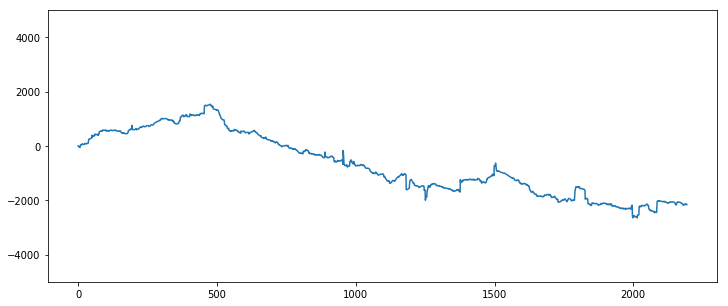

In [111]:
intName = get_intName(position)
x = []
a = []
for i in range(3000):
    if not i in intName:
        break
    c = contig_name(intName[i])
    if c in reps|repeats:
        continue
    if not intName[i] in intNameX:
        continue
    x.append(i)
    a.append(position[intName[i]] - pos[intName[i]])
plt.plot(x,a,)
plt.ylim(-5000,5000)

plt.show()
XX = x
AA = a

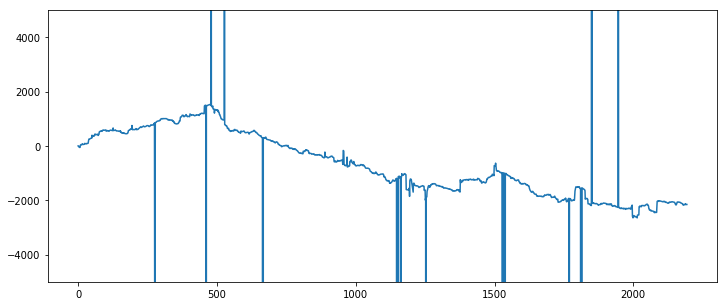

In [97]:
intName = get_intName(position)
x = []
a = []
for i in range(3000):
    if not i in intName:
        break
    c = contig_name(intName[i])
    if not intName[i] in intNameX:
        continue
    x.append(i)
    a.append(position[intName[i]] - pos[intName[i]])
plt.plot(x,a,)
plt.ylim(-5000,5000)

plt.show()

Es gibt unzusammenhängende Regionen in den Daten
99.63% der Contigs sind in der größten Komponente.
Optimize a model with 432159 rows, 146247 columns and 1008371 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e-06, 7e-06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 1 rows and 2 columns
Presolve time: 5.12s
Presolved: 146246 rows, 432157 columns, 1008367 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 3.466e+05
 Factor NZ  : 8.020e+05 (roughly 240 MBytes of memory)
 Factor Ops : 9.859e+07 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -5.76202000e+07  9.99995372e+02  1.00e-01 1.07e+03  3.35e+03     6s
   1  -9.54804656e+07  6.34281264e+03  1.97e-13 2.41e+03  3.74e+02     7s
 

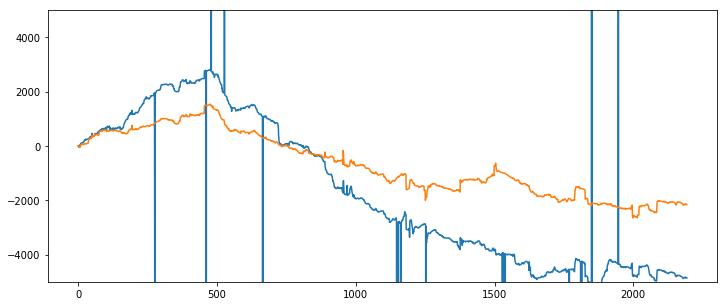

In [118]:

datei = 'my_apd1998.lst'
data = read_file(datei)

data = connected(data)
data = [
    (a,b,d) 
    for a,b,d in data
    if a != b or d > 1000
]
roh_data = [(contig_name(a), contig_name(b), int(d)) for a,b,d in data]

good_data, bad_data, _  = umsortieren(roh_data, contig_repeat, position)
data = good_data+bad_data

tol = 2000
s = coll.defaultdict(coll.Counter)
p = coll.defaultdict(coll.Counter)

for a, b, dist in data:
    real_dist = position[b] - position[a]
    if abs(real_dist - dist) < tol and a != b:
        if position[a] > position[b]:
            a, b, real_dist = b, a, -real_dist
        s[a][b] += 1
        p[b][a] += 1

ss = {a: sorted(s[a], key = lambda x: intName[x]) for a in s}
pp = {a: sorted(p[a], key = lambda x: intName[x], reverse = True) for a in p}

ss = {a: sorted(ss[a], key = lambda x: s[a][x])[:] for a in s}
pp = {a: sorted(pp[a], key = lambda x: p[a][x])[:] for a in p}

dataX = [
    [a,b,d] 
    for a,b,d in data 
    if (
        ((a in ss and b in ss[a]) or (b in pp and a in pp[b])) and 
        -tol < position[b] - position[a] - d < tol
    )
]

position = solve_LP_standard(position, dataX)

intName = get_intName(position)
xx = []
aa = []
for i in range(3000):
    if not i in intName:
        break
    c = contig_name(intName[i])
  #  if c in reps|repeats:
   #     continue
    if not intName[i] in intNameX:
        continue
    xx.append(i)
    aa.append(position[intName[i]] - pos[intName[i]])
plt.plot(xx,aa,)
plt.plot(XX,AA,)
plt.ylim(-5000,5000)

plt.show()

In [28]:
position = Lösung2
contig_repeat = coll.defaultdict(list)
for contig in position:
    contig_repeat[contig_name(contig)].append(contig)
data,_,_ = umsortieren(roh_data,contig_repeat, position)

In [76]:
position['2080APD_0']+get_contig_lengths(open('APDContigs.len'))['2080APD']

4902175.0

In [77]:
4902175

4902175

In [273]:
i = 0
j = 0
k=0
for c, r in gruppen.items():
    for g in r:
        j += 1
        if g.güte < 10:
            k += 1
i,j,k

(0, 2189, 57)

In [282]:
i = 0
j = 0
k=0
for c, r in gruppen.items():
    for g in r:
        j += 1
        if g.güte > 100:
            k += 1
i,j,k

(0, 2189, 1835)

In [281]:
2029/2189

0.9269072635906807

In [274]:
1901/2189

0.8684330744632253

In [263]:
gruppen['2080APD']

[Repeat(pos=4897485.0, güte=0, güte_0=69.2434279158813, stärke=41, gewicht=7, in_out=False, genauigkeit=1.0212778097964805)]

In [264]:
gruppen['2345APD']

[Repeat(pos=-56.0, güte=380.5907567157439, güte_0=435.59845720985896, stärke=155, gewicht=11, in_out=True, genauigkeit=0.709776780569226)]

In [106]:
g.in_edges('2345APD_0')

InMultiEdgeDataView([('431APD_0', '2345APD_0')])

In [103]:
g = nx.MultiDiGraph()
for a,b,d in data:
    g.add_edge(a,b,d)

In [116]:
print(position)

{'409APD_0': 4623616.0, '2452APD_0': 3193236.0, '1549APD_0': 2120843.0, '1490APD_0': 3795205.0, '1281APD_0': 456823.0, '1825APD_0': 2009420.0, '319APD_0': 2799749.0, '419APD_0': 3451550.0, '419APD_1': 3484193.0, '2379APD_0': 2059926.0, '1427APD_0': 2884698.0, '1260APD_0': 4849221.0, '1945APD_0': 2917791.0, '522APD_0': 2668253.0, '995APD_0': 866090.0, '1032APD_0': 4379910.0, '687APD_0': 3973739.0, '1532APD_0': 2541275.0, '348APD_0': 1268425.0, '1388APD_0': 3084500.0, '148APD_0': 1971409.0, '591APD_0': 3076700.0, '589APD_0': 788320.0, '72APD_0': 2850297.0, '72APD_1': 2947164.0, '1918APD_0': 4793710.0, '950APD_0': 2387439.0, '1699APD_0': 2694165.0, '738APD_0': 1985274.0, '962APD_0': 3681326.0, '1494APD_0': 326751.0, '416APD_0': 4043857.0, '828APD_0': 3697916.0, '975APD_0': 1697467.0, '623APD_0': 1137207.0, '1180APD_0': 4682551.0, '61APD_0': 2252415.0, '257APD_0': 2982985.0, '2187APD_0': 2036468.0, '2398APD_0': 2013772.0, '1769APD_0': 1246869.0, '1769APD_1': 2987146.0, '1115APD_0': 4577939

In [237]:
sor = sorted(position, key=lambda x: position[x])

In [250]:
for a,b in zip(sor[:-1],sor[1:]):
    ca = contig_name(a)
    cb = contig_name(b)
    h = True
    for x,y,d in roh_data:
        if x == ca and y == cb and -5000 <= position[b]-position[a] - d <= 5000:
            h = False
            break
    if h:
        print(intName[a])

744
876
1128
1163
1326
1458
1498
1590
1768
1794


In [ ]:
744
876
1128
1163
1326
1458
1498
1590
1768
1794

2164APD_0
1323APD_0
1160APD_1
830APD_0
2393APD_0
1654APD_0
2078APD_0
843APD_0
302APD_1
1718APD_0

In [ ]:
285
315
745
877
1129

1164
1328
1460
1500
1518

1519
1592
1770
1796

In [121]:
285
315
745
877
1129

1164
1328
1460
1500
1518

1519
1592
1770
1796

1796

In [155]:
contig_len = get_contig_lengths(open('APDContigs.len'))

In [159]:
position['2080APD_0']-position['2345APD_0']+contig_len['2080APD']

4902231.0

In [160]:
4902231

4902231

In [285]:
print(position)

{'409APD_0': 4623614.0, '2452APD_0': 3193242.0, '1549APD_0': 2120849.0, '1490APD_0': 3795210.0, '1281APD_0': 456823.0, '1825APD_0': 2009427.0, '319APD_0': 2799754.0, '419APD_0': 3451555.0, '419APD_1': 3484198.0, '2379APD_0': 2059933.0, '1427APD_0': 2884703.0, '1260APD_0': 4849211.0, '1945APD_0': 2917797.0, '522APD_0': 2668258.0, '995APD_0': 866089.0, '1032APD_0': 4379908.0, '687APD_0': 3973742.0, '1532APD_0': 2541281.0, '348APD_0': 1268425.0, '1388APD_0': 3084506.0, '148APD_0': 1971416.0, '591APD_0': 3076706.0, '589APD_0': 766867.0, '72APD_0': 2850302.0, '72APD_1': 2947171.0, '1918APD_0': 4793698.0, '950APD_0': 2387445.0, '1699APD_0': 2694170.0, '738APD_0': 1985282.0, '962APD_0': 3681331.0, '1494APD_0': 326751.0, '416APD_0': 4043860.0, '828APD_0': 3697921.0, '975APD_0': 1697473.0, '623APD_0': 1137208.0, '1180APD_0': 4682539.0, '61APD_0': 2252421.0, '257APD_0': 2982991.0, '2187APD_0': 2036475.0, '2398APD_0': 2013779.0, '1769APD_0': 1246869.0, '1769APD_1': 2987152.0, '1115APD_0': 4577937

In [287]:
erg3 = {'409APD_0': 4623614.0, '2452APD_0': 3193242.0, '1549APD_0': 2120849.0, '1490APD_0': 3795210.0, '1281APD_0': 456823.0, '1825APD_0': 2009427.0, '319APD_0': 2799754.0, '419APD_0': 3451555.0, '419APD_1': 3484198.0, '2379APD_0': 2059933.0, '1427APD_0': 2884703.0, '1260APD_0': 4849211.0, '1945APD_0': 2917797.0, '522APD_0': 2668258.0, '995APD_0': 866089.0, '1032APD_0': 4379908.0, '687APD_0': 3973742.0, '1532APD_0': 2541281.0, '348APD_0': 1268425.0, '1388APD_0': 3084506.0, '148APD_0': 1971416.0, '591APD_0': 3076706.0, '589APD_0': 766867.0, '72APD_0': 2850302.0, '72APD_1': 2947171.0, '1918APD_0': 4793698.0, '950APD_0': 2387445.0, '1699APD_0': 2694170.0, '738APD_0': 1985282.0, '962APD_0': 3681331.0, '1494APD_0': 326751.0, '416APD_0': 4043860.0, '828APD_0': 3697921.0, '975APD_0': 1697473.0, '623APD_0': 1137208.0, '1180APD_0': 4682539.0, '61APD_0': 2252421.0, '257APD_0': 2982991.0, '2187APD_0': 2036475.0, '2398APD_0': 2013779.0, '1769APD_0': 1246869.0, '1769APD_1': 2987152.0, '1115APD_0': 4577937.0, '2351APD_0': 1083596.0, '2042APD_0': 4641917.0, '2174APD_0': 2670911.0, '1607APD_0': 1191157.0, '219APD_0': 1187842.0, '387APD_0': 4817838.0, '313APD_0': 2624810.0, '676APD_0': 1807229.0, '1781APD_0': 2234437.0, '607APD_0': 3434351.0, '607APD_1': 3466999.0, '1634APD_0': 1571192.0, '1418APD_0': 4059529.0, '1067APD_0': 68072.0, '185APD_0': 2299226.0, '1866APD_0': 246589.0, '274APD_0': 2662202.0, '1545APD_0': 3055182.0, '1594APD_0': 3696782.0, '1222APD_0': 4854159.0, '1779APD_0': 218543.0, '2007APD_0': 2875016.0, '30APD_0': 3314427.0, '2311APD_0': 4427427.0, '2200APD_0': 2698821.0, '2440APD_0': 1207585.0, '2249APD_0': 1185965.0, '2348APD_0': 4814923.0, '899APD_0': 4608451.0, '1024APD_0': 405963.0, '1890APD_0': 3240803.0, '146APD_0': 4540845.0, '214APD_0': 3929756.0, '214APD_1': 3992973.0, '214APD_2': 4016879.0, '714APD_0': 504614.0, '392APD_0': 3285762.0, '1453APD_0': 1105295.0, '462APD_0': 613037.0, '462APD_1': 684008.0, '1570APD_0': 2048087.0, '1937APD_0': 2101619.0, '410APD_0': 1152191.0, '1935APD_0': 1164102.0, '285APD_0': 2090532.0, '628APD_0': 4573114.0, '367APD_0': 1060603.0, '201APD_0': 2984377.0, '1614APD_0': 3157727.0, '1921APD_0': 222900.0, '2238APD_0': 3321088.0, '1508APD_0': 1753210.0, '877APD_0': 1082439.0, '1990APD_0': 1151806.0, '66APD_0': 3355278.0, '193APD_0': 2447145.0, '355APD_0': 3051708.0, '355APD_1': 3782816.0, '1367APD_0': 4719702.0, '1404APD_0': 1982534.0, '1413APD_0': 2069327.0, '946APD_0': 2119589.0, '626APD_0': 3292537.0, '256APD_0': 3739708.0, '843APD_0': 3577025.0, '1369APD_0': 1958720.0, '1296APD_0': 2971195.0, '868APD_0': 4034431.0, '936APD_0': 1950178.0, '2270APD_0': 4194852.0, '900APD_0': 557358.0, '1910APD_0': 3174754.0, '2013APD_0': 196924.0, '2136APD_0': 3901614.0, '1211APD_0': 2860316.0, '1121APD_0': 1120156.0, '1218APD_0': 4801489.0, '1080APD_0': 3838609.0, '2283APD_0': 4646232.0, '1700APD_0': 4058431.0, '1246APD_0': 271741.0, '161APD_0': 3723673.0, '2248APD_0': 3369001.0, '2413APD_0': 1917565.0, '557APD_0': 3373365.0, '1406APD_0': 1684403.0, '988APD_0': 2123054.0, '2442APD_0': 4609066.0, '2335APD_0': 482261.0, '594APD_0': 4867281.0, '1526APD_0': 4307677.0, '2044APD_0': 1972665.0, '1919APD_0': 2486871.0, '268APD_0': 3635375.0, '638APD_0': 300790.0, '615APD_0': 609075.0, '262APD_0': 4197841.0, '2360APD_0': 3052860.0, '1286APD_0': 3289376.0, '1164APD_0': 2124348.0, '2325APD_0': 3277389.0, '143APD_0': 2973290.0, '2254APD_0': 4579500.0, '2236APD_0': 2738628.0, '2236APD_1': 2812946.0, '1125APD_0': 2702091.0, '911APD_0': 3430317.0, '586APD_0': 3714994.0, '281APD_0': 1268050.0, '1663APD_0': 3582521.0, '2262APD_0': 3182813.0, '729APD_0': 4675761.0, '977APD_0': 4750501.0, '134APD_0': 761706.0, '1035APD_0': 1696349.0, '640APD_0': 1208878.0, '415APD_0': 3149421.0, '1749APD_0': 1612682.0, '1322APD_0': 3166623.0, '662APD_0': 3180356.0, '2002APD_0': 2172897.0, '1201APD_0': 3016029.0, '44APD_0': 667472.0, '1948APD_0': 1491033.0, '2369APD_0': 2093179.0, '1759APD_0': 3095820.0, '2455APD_0': 1497530.0, '1727APD_0': 4420016.0, '1472APD_0': 141110.0, '2168APD_0': 3067174.0, '510APD_0': 1784706.0, '661APD_0': 3853324.0, '1874APD_0': 1331540.0, '1874APD_1': 2936804.0, '2147APD_0': 4068689.0, '32APD_0': 4809538.0, '271APD_0': 1385571.0, '271APD_1': 2987569.0, '1258APD_0': 890828.0, '1619APD_0': 4747849.0, '1104APD_0': 2005151.0, '136APD_0': 2999633.0, '381APD_0': 1636727.0, '997APD_0': 4678715.0, '2274APD_0': 3320587.0, '2399APD_0': 1501469.0, '932APD_0': 3257982.0, '544APD_0': 2820315.0, '1189APD_0': 2260899.0, '1244APD_0': 2205599.0, '1090APD_0': 2203929.0, '821APD_0': 3042534.0, '797APD_0': 2167433.0, '1014APD_0': 4780245.0, '1433APD_0': 413598.0, '2271APD_0': 3300461.0, '1661APD_0': 471043.0, '613APD_0': 3819712.0, '1183APD_0': 3281283.0, '1843APD_0': 2506439.0, '1847APD_0': 2318170.0, '310APD_0': 4394343.0, '820APD_0': 888475.0, '688APD_0': 3875589.0, '2083APD_0': 1910151.0, '1966APD_0': 313526.0, '1034APD_0': 3271883.0, '2328APD_0': 3440325.0, '2328APD_1': 3472975.0, '1349APD_0': 2605660.0, '2045APD_0': 3821971.0, '317APD_0': 3278851.0, '5APD_0': 3717175.0, '1685APD_0': 2665100.0, '1352APD_0': 4417351.0, '2148APD_0': 1828080.0, '223APD_0': 4896262.0, '1642APD_0': 3826816.0, '608APD_0': 2318364.0, '1827APD_0': 2094997.0, '2189APD_0': 2540471.0, '312APD_0': 2305625.0, '2405APD_0': 4679864.0, '774APD_0': 2424336.0, '1110APD_0': 4420704.0, '2301APD_0': 2821371.0, '280APD_0': 1829912.0, '266APD_0': 407009.0, '1693APD_0': 1207519.0, '1693APD_1': 1962107.0, '1257APD_0': 3589029.0, '444APD_0': 243756.0, '2023APD_0': 2506080.0, '1912APD_0': 3247005.0, '1004APD_0': 3463914.0, '1004APD_1': 3496541.0, '2414APD_0': 3465855.0, '2414APD_1': 3498510.0, '92APD_0': 3646095.0, '115APD_0': 3560624.0, '834APD_0': 2691473.0, '1175APD_0': 4749942.0, '1359APD_0': 3205688.0, '2388APD_0': 1906309.0, '1316APD_0': 2897374.0, '1172APD_0': 2523222.0, '69APD_0': 685871.0, '1806APD_0': 3462175.0, '1806APD_1': 3494796.0, '2032APD_0': 372166.0, '1248APD_0': 330419.0, '2203APD_0': 2113873.0, '1691APD_0': 829907.0, '2394APD_0': 611239.0, '2394APD_1': 682256.0, '639APD_0': 976181.0, '569APD_0': 473554.0, '794APD_0': 4744556.0, '1000APD_0': 1896560.0, '2180APD_0': 3064394.0, '560APD_0': 2963176.0, '1818APD_0': 2819734.0, '1785APD_0': 1168769.0, '2288APD_0': 3892512.0, '1497APD_0': 3435824.0, '1497APD_1': 3468468.0, '1562APD_0': 2630617.0, '1905APD_0': 3814924.0, '702APD_0': 3138843.0, '869APD_0': 3937946.0, '599APD_0': 588404.0, '734APD_0': 4592219.0, '67APD_0': 3016925.0, '1394APD_0': 3072298.0, '2216APD_0': 4659202.0, '71APD_0': 138031.0, '401APD_0': 3943969.0, '401APD_1': 4007468.0, '343APD_0': 3089980.0, '1728APD_0': 4595019.0, '1485APD_0': 2080780.0, '166APD_0': 4752604.0, '1805APD_0': 3069929.0, '2432APD_0': 2538356.0, '706APD_0': 2561274.0, '2375APD_0': 3958404.0, '1122APD_0': 2410389.0, '860APD_0': 3664826.0, '1346APD_0': 1725332.0, '1097APD_0': 1170817.0, '1774APD_0': 2550329.0, '1207APD_0': 2688880.0, '691APD_0': 3392890.0, '1676APD_0': 4761863.0, '579APD_0': 225768.0, '2418APD_0': 4395996.0, '261APD_0': 324396.0, '2122APD_0': 322190.0, '114APD_0': 3858921.0, '2132APD_0': 3307244.0, '1496APD_0': 4050692.0, '1384APD_0': 4297526.0, '1345APD_0': 4757117.0, '2215APD_0': 4280968.0, '2186APD_0': 4605414.0, '519APD_0': 2156083.0, '754APD_0': 3202448.0, '1605APD_0': 2313901.0, '304APD_0': 4806161.0, '2373APD_0': 3338455.0, '1986APD_0': 356890.0, '1425APD_0': 3306955.0, '1929APD_0': 2849728.0, '1929APD_1': 2946596.0, '1972APD_0': 4556391.0, '132APD_0': 1393364.0, '1857APD_0': 183158.0, '1804APD_0': 2671652.0, '455APD_0': 4753663.0, '957APD_0': 4795407.0, '2428APD_0': 3023616.0, '2293APD_0': 2096203.0, '1166APD_0': 4607814.0, '2458APD_0': 267881.0, '852APD_0': 3152061.0, '1341APD_0': 2374577.0, '127APD_0': 2539779.0, '2076APD_0': 2064210.0, '1140APD_0': 2062247.0, '708APD_0': 758794.0, '2172APD_0': 1589786.0, '1307APD_0': 4596904.0, '1826APD_0': 2177459.0, '943APD_0': 151346.0, '2145APD_0': 2110822.0, '432APD_0': 2744368.0, '432APD_1': 2818701.0, '960APD_0': 101570.0, '1355APD_0': 1717619.0, '116APD_0': 2736915.0, '116APD_1': 2811246.0, '253APD_0': 1526924.0, '1457APD_0': 2116859.0, '357APD_0': 1801110.0, '1959APD_0': 2852376.0, '1800APD_0': 2741869.0, '1800APD_1': 2816208.0, '1792APD_0': 4562656.0, '1249APD_0': 1030845.0, '1054APD_0': 1150099.0, '2118APD_0': 1947296.0, '3APD_0': 944168.0, '16APD_0': 3811724.0, '187APD_0': 542150.0, '567APD_0': 128425.0, '1434APD_0': 3051038.0, '1702APD_0': 3257488.0, '1704APD_0': 1946120.0, '216APD_0': 302375.0, '876APD_0': 226191.0, '414APD_0': 1181333.0, '2111APD_0': 3604891.0, '1284APD_0': 1231741.0, '438APD_0': 2406587.0, '523APD_0': 1875945.0, '1743APD_0': 4699555.0, '635APD_0': 4177465.0, '1116APD_0': 3014834.0, '1488APD_0': 4065864.0, '660APD_0': 3626072.0, '1448APD_0': 2916622.0, '1199APD_0': 436710.0, '360APD_0': 2614071.0, '420APD_0': 3691687.0, '998APD_0': 32358.0, '658APD_0': 2853017.0, '768APD_0': 1649306.0, '1241APD_0': 2069169.0, '2435APD_0': 2255903.0, '743APD_0': 1838171.0, '835APD_0': 1980396.0, '2320APD_0': 2649468.0, '1588APD_0': 3208952.0, '584APD_0': 1233539.0, '1923APD_0': 2751801.0, '1923APD_1': 2820954.0, '224APD_0': 2362675.0, '1584APD_0': 3550846.0, '2005APD_0': 3330460.0, '1431APD_0': 3577192.0, '2028APD_0': 3529445.0, '1001APD_0': 4039926.0, '2213APD_0': 3463657.0, '2213APD_1': 3496277.0, '893APD_0': 4747993.0, '881APD_0': 1140220.0, '1323APD_0': 2278183.0, '1095APD_0': 3611244.0, '1710APD_0': 4795119.0, '2416APD_0': 3108637.0, '1898APD_0': 4817600.0, '1684APD_0': 4561159.0, '385APD_0': 816712.0, '211APD_0': 1405279.0, '1470APD_0': 4889141.0, '225APD_0': 68442.0, '1895APD_0': 1176647.0, '2434APD_0': 452598.0, '1655APD_0': 2399002.0, '429APD_0': 422964.0, '2370APD_0': 1597788.0, '996APD_0': 47736.0, '2063APD_0': 4786085.0, '694APD_0': 612658.0, '694APD_1': 683674.0, '1796APD_0': 3104798.0, '518APD_0': 2123633.0, '301APD_0': 86566.0, '2140APD_0': 2295826.0, '2456APD_0': 4858895.0, '142APD_0': 2906493.0, '1601APD_0': 4656104.0, '363APD_0': 3076266.0, '2017APD_0': 4448350.0, '205APD_0': 236036.0, '1893APD_0': 1128076.0, '1940APD_0': 3557923.0, '1538APD_0': 2426490.0, '663APD_0': 4340709.0, '1994APD_0': 4775418.0, '1056APD_0': 4669532.0, '1979APD_0': 2546550.0, '756APD_0': 2483912.0, '1993APD_0': 2574677.0, '1635APD_0': 43614.0, '1860APD_0': 2012553.0, '76APD_0': 3722596.0, '23APD_0': 1117650.0, '1608APD_0': 250854.0, '939APD_0': 410762.0, '528APD_0': 2459273.0, '2273APD_0': 4069415.0, '237APD_0': 3123981.0, '2165APD_0': 3354084.0, '164APD_0': 3463505.0, '164APD_1': 3496125.0, '1498APD_0': 2360725.0, '2387APD_0': 164154.0, '851APD_0': 4126421.0, '33APD_0': 4707322.0, '347APD_0': 2066180.0, '1278APD_0': 3011977.0, '1392APD_0': 3295541.0, '2359APD_0': 2103294.0, '1037APD_0': 2628099.0, '1865APD_0': 3254928.0, '846APD_0': 2281917.0, '1984APD_0': 4588353.0, '1977APD_0': 1821922.0, '2329APD_0': 4885448.0, '2380APD_0': 297299.0, '43APD_0': 4756795.0, '632APD_0': 4798592.0, '566APD_0': 2481403.0, '170APD_0': 2532955.0, '2229APD_0': 3153984.0, '2454APD_0': 2597657.0, '1716APD_0': 2120582.0, '525APD_0': 764586.0, '752APD_0': 2307615.0, '353APD_0': 4468579.0, '2134APD_0': 775794.0, '2389APD_0': 3921324.0, '104APD_0': 2174067.0, '2205APD_0': 574874.0, '199APD_0': 3313124.0, '1871APD_0': 2515875.0, '587APD_0': 4228343.0, '2312APD_0': 243437.0, '1458APD_0': 2115068.0, '181APD_0': 3250353.0, '158APD_0': 2404425.0, '766APD_0': 558195.0, '1400APD_0': 146078.0, '1783APD_0': 680298.0, '819APD_0': 4562236.0, '459APD_0': 552258.0, '47APD_0': 3460307.0, '47APD_1': 3492928.0, '762APD_0': 4731569.0, '1424APD_0': 4775723.0, '2214APD_0': 1240862.0, '182APD_0': 1346976.0, '910APD_0': 2565843.0, '952APD_0': 4540554.0, '744APD_0': 2859934.0, '744APD_1': 2954101.0, '1644APD_0': 1803121.0, '1778APD_0': 3639487.0, '2077APD_0': 990781.0, '547APD_0': 279917.0, '1682APD_0': 3121131.0, '872APD_0': 4048872.0, '965APD_0': 4282502.0, '2378APD_0': 1974991.0, '1441APD_0': 1617994.0, '1901APD_0': 3593116.0, '1019APD_0': 3688570.0, '263APD_0': 3247592.0, '489APD_0': 3603095.0, '342APD_0': 1389333.0, '342APD_1': 1467038.0, '1351APD_0': 2122533.0, '1706APD_0': 1584801.0, '1965APD_0': 2404663.0, '2027APD_0': 3231355.0, '542APD_0': 121036.0, '1838APD_0': 3891289.0, '2404APD_0': 2198482.0, '2415APD_0': 493615.0, '1309APD_0': 474055.0, '705APD_0': 4762361.0, '2129APD_0': 3548893.0, '837APD_0': 4860695.0, '1533APD_0': 4756166.0, '2453APD_0': 3558254.0, '1112APD_0': 3100436.0, '1946APD_0': 2004466.0, '1747APD_0': 1581394.0, '1043APD_0': 3026528.0, '2257APD_0': 3397449.0, '445APD_0': 2850302.0, '445APD_1': 2947169.0, '576APD_0': 2861123.0, '904APD_0': 487336.0, '829APD_0': 1269594.0, '291APD_0': 2854158.0, '291APD_1': 2948387.0, '2276APD_0': 4863494.0, '970APD_0': 1381309.0, '428APD_0': 2818994.0, '2228APD_0': 3367683.0, '2390APD_0': 426736.0, '767APD_0': 4706368.0, '919APD_0': 1245704.0, '1834APD_0': 4763446.0, '1268APD_0': 385956.0, '2104APD_0': 3276506.0, '1069APD_0': 3900480.0, '1770APD_0': 2376587.0, '495APD_0': 2644058.0, '701APD_0': 3205332.0, '133APD_0': 3053579.0, '880APD_0': 2351037.0, '1040APD_0': 2657281.0, '2095APD_0': 4716941.0, '1925APD_0': 2151079.0, '1771APD_0': 186676.0, '1410APD_0': 522052.0, '2184APD_0': 2556428.0, '305APD_0': 3949330.0, '305APD_1': 4012812.0, '297APD_0': 4074884.0, '1272APD_0': 2173205.0, '1416APD_0': 1582163.0, '243APD_0': 3266312.0, '2139APD_0': 3324253.0, '1335APD_0': 1053327.0, '1157APD_0': 2041893.0, '1506APD_0': 1033525.0, '1304APD_0': 4335382.0, '514APD_0': 4418822.0, '2230APD_0': 2420275.0, '1378APD_0': 4819841.0, '1600APD_0': 2256426.0, '289APD_0': 3290539.0, '300APD_0': 1452378.0, '1891APD_0': 3156033.0, '1736APD_0': 3064071.0, '1586APD_0': 325245.0, '2152APD_0': 3190543.0, '814APD_0': 2337117.0, '1992APD_0': 2177210.0, '2116APD_0': 4323938.0, '1377APD_0': 3798509.0, '1708APD_0': 2620935.0, '726APD_0': 3920450.0, '1669APD_0': 2610960.0, '1717APD_0': 2112376.0, '1179APD_0': 2245178.0, '1575APD_0': 4764600.0, '1751APD_0': 483325.0, '2219APD_0': 2528374.0, '275APD_0': 1232178.0, '492APD_0': 2283105.0, '2250APD_0': 935970.0, '1757APD_0': 4730595.0, '80APD_0': 404133.0, '2384APD_0': 2990419.0, '186APD_0': 3613536.0, '2011APD_0': 404901.0, '203APD_0': 3347714.0, '369APD_0': 2956056.0, '1439APD_0': 635095.0, '1036APD_0': 2078361.0, '619APD_0': 2608992.0, '1368APD_0': 1632129.0, '645APD_0': 1949314.0, '2460APD_0': 870990.0, '1624APD_0': 3236703.0, '1285APD_0': 1443583.0, '259APD_0': 3946647.0, '259APD_1': 4010102.0, '1638APD_0': 4487921.0, '1126APD_0': 3198722.0, '2114APD_0': 1103293.0, '1128APD_0': 3041253.0, '340APD_0': 2186189.0, '2049APD_0': 4891419.0, '2056APD_0': 1825344.0, '653APD_0': 793888.0, '1100APD_0': 4854596.0, '2339APD_0': 1148353.0, '1572APD_0': 1502601.0, '373APD_0': 3901896.0, '2462APD_0': 3514312.0, '1953APD_0': 4784111.0, '2193APD_0': 2200680.0, '780APD_0': 2574506.0, '90APD_0': 462230.0, '111APD_0': 3610161.0, '204APD_0': 3229378.0, '156APD_0': 187992.0, '1461APD_0': 3314220.0, '966APD_0': 3140634.0, '22APD_0': 3508794.0, '443APD_0': 4357022.0, '974APD_0': 3651307.0, '1483APD_0': 6663.0, '1428APD_0': 1965224.0, '1906APD_0': 3257806.0, '1988APD_0': 3722026.0, '779APD_0': 1918309.0, '1980APD_0': 92226.0, '680APD_0': 432338.0, '220APD_0': 2856897.0, '220APD_1': 2951083.0, '175APD_0': 4511790.0, '2382APD_0': 555866.0, '2192APD_0': 2524527.0, '704APD_0': 3211493.0, '1659APD_0': 4590934.0, '21APD_0': 3161792.0, '42APD_0': 4720972.0, '722APD_0': 1652791.0, '1750APD_0': 1563330.0, '1339APD_0': 4326029.0, '637APD_0': 4764114.0, '2368APD_0': 1179058.0, '160APD_0': 3965573.0, '2303APD_0': 3597600.0, '602APD_0': 2412360.0, '2006APD_0': 3260376.0, '2305APD_0': 2165907.0, '1238APD_0': 233541.0, '686APD_0': 3226159.0, '411APD_0': 2863948.0, '411APD_1': 2958488.0, '1529APD_0': 138255.0, '1692APD_0': 1145160.0, '341APD_0': 4556071.0, '847APD_0': 3526447.0, '1003APD_0': 1677266.0, '641APD_0': 343301.0, '1899APD_0': 3817074.0, '1941APD_0': 1585962.0, '1381APD_0': 4591785.0, '649APD_0': 3733664.0, '741APD_0': 3180790.0, '540APD_0': 3132541.0, '1690APD_0': 3382694.0, '1932APD_0': 3382259.0, '831APD_0': 103195.0, '771APD_0': 1267613.0, '346APD_0': 2854988.0, '346APD_1': 2949110.0, '1106APD_0': 2208026.0, '1460APD_0': 911350.0, '213APD_0': 4352108.0, '905APD_0': 3720756.0, '2067APD_0': 4129033.0, '1333APD_0': 3087817.0, '1429APD_0': 3890509.0, '62APD_0': 1098083.0, '499APD_0': 3411158.0, '772APD_0': 194524.0, '2227APD_0': 1976401.0, '1660APD_0': 4818459.0, '2195APD_0': 1409352.0, '1581APD_0': 3323331.0, '1666APD_0': 4130920.0, '2391APD_0': 1532039.0, '324APD_0': 2560923.0, '2124APD_0': 4884558.0, '1548APD_0': 3570063.0, '452APD_0': 830582.0, '2410APD_0': 715353.0, '2298APD_0': 4822840.0, '388APD_0': 4068087.0, '388APD_1': 4171400.0, '370APD_0': 3466141.0, '370APD_1': 3498827.0, '2060APD_0': 1380609.0, '1028APD_0': 3429426.0, '1144APD_0': 4632958.0, '2349APD_0': 1785305.0, '1650APD_0': 4551662.0, '573APD_0': 948315.0, '697APD_0': 3096949.0, '354APD_0': 3363924.0, '2322APD_0': 199710.0, '806APD_0': 931930.0, '178APD_0': 1896941.0, '178APD_1': 2907747.0, '230APD_0': 2742936.0, '230APD_1': 2817255.0, '1279APD_0': 2942595.0, '1051APD_0': 3081411.0, '2110APD_0': 694368.0, '892APD_0': 1968294.0, '1744APD_0': 1847377.0, '497APD_0': 787594.0, '195APD_0': 1156481.0, '49APD_0': 2726514.0, '1197APD_0': 2141805.0, '26APD_0': 3424056.0, '247APD_0': 4567211.0, '119APD_0': 732818.0, '2054APD_0': 3366397.0, '674APD_0': 3465614.0, '674APD_1': 3498255.0, '65APD_0': 3754746.0, '1011APD_0': 1416340.0, '2338APD_0': 3210035.0, '2149APD_0': 389652.0, '1480APD_0': 145749.0, '379APD_0': 405507.0, '2015APD_0': 1145327.0, '1499APD_0': 2203078.0, '516APD_0': 1176422.0, '1298APD_0': 4029782.0, '1536APD_0': 2685752.0, '1398APD_0': 4012945.0, '1020APD_0': 3014143.0, '1396APD_0': 1235257.0, '1165APD_0': 3154273.0, '796APD_0': 3364418.0, '761APD_0': 3244088.0, '1803APD_0': 3028654.0, '1813APD_0': 1343080.0, '1321APD_0': 2109644.0, '1955APD_0': 295550.0, '2395APD_0': 1780009.0, '1755APD_0': 3196521.0, '1723APD_0': 2164053.0, '679APD_0': 4643033.0, '2237APD_0': 2475695.0, '1721APD_0': 710539.0, '1822APD_0': 1492173.0, '1541APD_0': 766571.0, '141APD_0': 2639090.0, '2153APD_0': 2304516.0, '1617APD_0': 2712083.0, '2327APD_0': 2550584.0, '552APD_0': 4142013.0, '989APD_0': 439669.0, '1615APD_0': 4679620.0, '1665APD_0': 475012.0, '2212APD_0': 1753496.0, '1788APD_0': 3751784.0, '672APD_0': 2830784.0, '1504APD_0': 4810742.0, '2264APD_0': 3011642.0, '129APD_0': 3629763.0, '683APD_0': 2147539.0, '1420APD_0': 2755710.0, '393APD_0': 3991412.0, '2194APD_0': 4791736.0, '1007APD_0': 2297752.0, '882APD_0': 2130645.0, '2402APD_0': 4597362.0, '1753APD_0': 854661.0, '85APD_0': 4063521.0, '1573APD_0': 4051397.0, '865APD_0': 604684.0, '2190APD_0': 1132314.0, '1467APD_0': 416820.0, '1528APD_0': 2193445.0, '2091APD_0': 2839201.0, '2009APD_0': 2169365.0, '52APD_0': 3459658.0, '52APD_1': 3492285.0, '1419APD_0': 3370855.0, '389APD_0': 2228805.0, '1290APD_0': 2664337.0, '1412APD_0': 1561109.0, '118APD_0': 4761570.0, '83APD_0': 3689306.0, '609APD_0': 1041966.0, '88APD_0': 291810.0, '622APD_0': 3062472.0, '2365APD_0': 3761754.0, '2268APD_0': 3329968.0, '1556APD_0': 3185908.0, '1146APD_0': 2461975.0, '2014APD_0': 4864726.0, '2234APD_0': 4222583.0, '940APD_0': 4117612.0, '727APD_0': 1988829.0, '859APD_0': 1690088.0, '1129APD_0': 3569095.0, '2185APD_0': 3441266.0, '2185APD_1': 3473922.0, '1705APD_0': 4842105.0, '368APD_0': 2463946.0, '795APD_0': 2682133.0, '682APD_0': 282239.0, '1938APD_0': 2433959.0, '2055APD_0': 2512556.0, '6APD_0': 2048997.0, '238APD_0': 3863181.0, '2461APD_0': 454133.0, '1074APD_0': 1290972.0, '524APD_0': 2438430.0, '1294APD_0': 3518227.0, '1904APD_0': 212433.0, '278APD_0': 3801844.0, '1327APD_0': 3056577.0, '737APD_0': 1404057.0, '894APD_0': 1607742.0, '1830APD_0': 2682980.0, '2318APD_0': 3077541.0, '1423APD_0': 624410.0, '336APD_0': 3127999.0, '973APD_0': 2501214.0, '1465APD_0': 224990.0, '592APD_0': 4785635.0, '45APD_0': 3369122.0, '2036APD_0': 2689232.0, '491APD_0': 612825.0, '113APD_0': 1419205.0, '944APD_0': 1175202.0, '217APD_0': 1996199.0, '541APD_0': 3839392.0, '1422APD_0': 767225.0, '400APD_0': 4485132.0, '1361APD_0': 2570458.0, '2371APD_0': 3385855.0, '48APD_0': 957214.0, '1137APD_0': 401926.0, '1133APD_0': 4176072.0, '1521APD_0': 3604215.0, '1664APD_0': 3615514.0, '903APD_0': 1567633.0, '590APD_0': 2139640.0, '597APD_0': 767535.0, '924APD_0': 3638408.0, '530APD_0': 4067803.0, '530APD_1': 4171160.0, '1350APD_0': 4789375.0, '885APD_0': 235228.0, '853APD_0': 1418485.0, '330APD_0': 4147601.0, '2105APD_0': 4662953.0, '2300APD_0': 4571205.0, '1628APD_0': 4130697.0, '1047APD_0': 4650965.0, '1968APD_0': 1805152.0, '359APD_0': 2265946.0, '611APD_0': 3261588.0, '2100APD_0': 3014587.0, '2286APD_0': 1719616.0, '817APD_0': 1714255.0, '2034APD_0': 1345234.0, '34APD_0': 3507334.0, '2059APD_0': 3187515.0, '226APD_0': 2284517.0, '1358APD_0': 1913490.0, '1656APD_0': 4049568.0, '1894APD_0': 77520.0, '1739APD_0': 3256493.0, '1616APD_0': 3313571.0, '2131APD_0': 2406967.0, '2093APD_0': 3597413.0, '1768APD_0': 2945989.0, '1552APD_0': 1985980.0, '870APD_0': 4550187.0, '2243APD_0': 2877303.0, '1711APD_0': 2029151.0, '922APD_0': 2679242.0, '1590APD_0': 329008.0, '2031APD_0': 4660849.0, '1876APD_0': 2288165.0, '1033APD_0': 873094.0, '191APD_0': 2150390.0, '1156APD_0': 352418.0, '1519APD_0': 4668190.0, '1845APD_0': 2032645.0, '2309APD_0': 3679546.0, '371APD_0': 1277421.0, '17APD_0': 2664650.0, '2018APD_0': 4070666.0, '241APD_0': 332418.0, '328APD_0': 3064780.0, '742APD_0': 1055594.0, '1079APD_0': 2462270.0, '1314APD_0': 2259037.0, '710APD_0': 3364755.0, '1639APD_0': 3760934.0, '605APD_0': 3118728.0, '1173APD_0': 3252748.0, '1261APD_0': 828599.0, '2000APD_0': 1854330.0, '681APD_0': 691392.0, '2037APD_0': 1771821.0, '333APD_0': 3197282.0, '331APD_0': 2169738.0, '1063APD_0': 1121791.0, '1235APD_0': 4746590.0, '1903APD_0': 158714.0, '131APD_0': 1363775.0, '1563APD_0': 2562221.0, '2372APD_0': 4580443.0, '856APD_0': 2259647.0, '372APD_0': 3432045.0, '454APD_0': 1527622.0, '983APD_0': 3009136.0, '526APD_0': 2663601.0, '2188APD_0': 1800498.0, '1507APD_0': 806640.0, '1641APD_0': 2343639.0, '841APD_0': 4680657.0, '862APD_0': 2713695.0, '1426APD_0': 3505422.0, '1198APD_0': 3101752.0, '309APD_0': 4730963.0, '130APD_0': 2602956.0, '647APD_0': 3388205.0, '279APD_0': 1398120.0, '382APD_0': 2643768.0, '1576APD_0': 3822999.0, '74APD_0': 3272483.0, '74APD_1': 3284614.0, '2209APD_0': 2309964.0, '1509APD_0': 4667055.0, '778APD_0': 2132975.0, '11APD_0': 673703.0, '849APD_0': 2761550.0, '398APD_0': 1074552.0, '1025APD_0': 2225575.0, '1868APD_0': 4650173.0, '1136APD_0': 2205314.0, '1310APD_0': 4059054.0, '543APD_0': 1086073.0, '57APD_0': 556447.0, '461APD_0': 2536872.0, '721APD_0': 4138731.0, '431APD_0': 2468562.0, '2240APD_0': 3687378.0, '375APD_0': 4437413.0, '109APD_0': 2109954.0, '1652APD_0': 4776988.0, '745APD_0': 1139195.0, '1188APD_0': 3651829.0, '1926APD_0': 2013045.0, '157APD_0': 314694.0, '157APD_1': 337277.0, '1178APD_0': 3342762.0, '1311APD_0': 4859964.0, '555APD_0': 1550946.0, '2141APD_0': 1506142.0, '1964APD_0': 3297114.0, '1117APD_0': 2214261.0, '799APD_0': 2739721.0, '799APD_1': 2814048.0, '749APD_0': 4081179.0, '788APD_0': 1162706.0, '64APD_0': 2859003.0, '64APD_1': 2953126.0, '1107APD_0': 4630883.0, '1160APD_0': 2741886.0, '1160APD_1': 2816196.0, '1139APD_0': 3960089.0, '1210APD_0': 2206982.0, '2386APD_0': 1239067.0, '192APD_0': 3729567.0, '58APD_0': 580282.0, '58APD_1': 643459.0, '58APD_2': 652188.0, '2096APD_0': 3639348.0, '144APD_0': 3335413.0, '287APD_0': 2587692.0, '1072APD_0': 3262144.0, '2068APD_0': 401554.0, '1931APD_0': 4801309.0, '1851APD_0': 1960623.0, '2258APD_0': 4063193.0, '1566APD_0': 3063803.0, '2260APD_0': 3788561.0, '2086APD_0': 2900729.0, '556APD_0': 2429752.0, '898APD_0': 296781.0, '898APD_1': 312242.0, '1726APD_0': 3598303.0, '1849APD_0': 4644283.0, '391APD_0': 794427.0, '377APD_0': 3374981.0, '1689APD_0': 1706770.0, '245APD_0': 3914212.0, '315APD_0': 2190735.0, '1052APD_0': 4677726.0, '773APD_0': 2553378.0, '716APD_0': 2046876.0, '2267APD_0': 3067882.0, '501APD_0': 1299630.0, '501APD_1': 1354333.0, '2407APD_0': 3710354.0, '486APD_0': 1208355.0, '2306APD_0': 4730060.0, '1754APD_0': 3021766.0, '338APD_0': 3323763.0, '1928APD_0': 2034639.0, '2356APD_0': 1416194.0, '1186APD_0': 4796600.0, '1006APD_0': 1766989.0, '1522APD_0': 760327.0, '2266APD_0': 4340443.0, '1088APD_0': 2073011.0, '101APD_0': 2227318.0, '1447APD_0': 4357718.0, '1391APD_0': 2824994.0, '1169APD_0': 385219.0, '397APD_0': 3660300.0, '1084APD_0': 2171556.0, '1230APD_0': 3250966.0, '2374APD_0': 3465784.0, '2374APD_1': 3498404.0, '2163APD_0': 3112221.0, '2223APD_0': 1163617.0, '1190APD_0': 3349773.0, '1455APD_0': 4452388.0, '987APD_0': 4288040.0, '2072APD_0': 4814627.0, '520APD_0': 3465638.0, '520APD_1': 3498258.0, '2401APD_0': 4866259.0, '1766APD_0': 4738738.0, '655APD_0': 2878504.0, '776APD_0': 130299.0, '1305APD_0': 3225490.0, '2003APD_0': 233051.0, '2169APD_0': 2752263.0, '912APD_0': 4173908.0, '2218APD_0': 4832360.0, '1436APD_0': 2051699.0, '1147APD_0': 1104156.0, '102APD_0': 2582024.0, '2182APD_0': 1777747.0, '2316APD_0': 2355611.0, '1252APD_0': 193763.0, '1633APD_0': 2284188.0, '1438APD_0': 3432562.0, '2278APD_0': 1463115.0, '2202APD_0': 2660690.0, '2160APD_0': 425712.0, '1881APD_0': 3781577.0, '2350APD_0': 461802.0, '351APD_0': 1140497.0, '339APD_0': 3504911.0, '339APD_1': 3511448.0, '244APD_0': 1179927.0, '2358APD_0': 943830.0, '1053APD_0': 4264467.0, '1267APD_0': 4737504.0, '1933APD_0': 2819452.0, '424APD_0': 2561661.0, '572APD_0': 743135.0, '235APD_0': 340617.0, '507APD_0': 3721879.0, '308APD_0': 2165595.0, '1215APD_0': 4894669.0, '1960APD_0': 3043569.0, '1338APD_0': 2901744.0, '383APD_0': 3462027.0, '383APD_1': 3494653.0, '897APD_0': 4586538.0, '2441APD_0': 4345051.0, '467APD_0': 4365131.0, '1631APD_0': 125024.0, '1437APD_0': 4670177.0, '1463APD_0': 603522.0, '1733APD_0': 2038115.0, '89APD_0': 722381.0, '169APD_0': 4067287.0, '169APD_1': 4170614.0, '425APD_0': 3690192.0, '2438APD_0': 2640671.0, '2004APD_0': 1591518.0, '2047APD_0': 3124162.0, '1773APD_0': 697766.0, '634APD_0': 4272094.0, '198APD_0': 1263955.0, '460APD_0': 3462030.0, '460APD_1': 3494648.0, '485APD_0': 1506836.0, '588APD_0': 407234.0, '1908APD_0': 1609834.0, '2231APD_0': 1550241.0, '100APD_0': 4094192.0, '2210APD_0': 2785134.0, '537APD_0': 4013207.0, '2400APD_0': 2662848.0, '1065APD_0': 2200415.0, '2247APD_0': 1182857.0, '1824APD_0': 4285716.0, '1030APD_0': 1813012.0, '403APD_0': 2234961.0, '365APD_0': 1932768.0, '1443APD_0': 2207477.0, '748APD_0': 1992776.0, '1002APD_0': 1665654.0, '277APD_0': 241690.0, '1242APD_0': 2257374.0, '654APD_0': 1177413.0, '1802APD_0': 4057949.0, '38APD_0': 2345922.0, '2092APD_0': 439293.0, '1812APD_0': 1660859.0, '408APD_0': 1949624.0, '1761APD_0': 3244660.0, '1214APD_0': 3385979.0, '396APD_0': 4560042.0, '2281APD_0': 4406862.0, '202APD_0': 460942.0, '1181APD_0': 1646387.0, '887APD_0': 2976084.0, '1565APD_0': 3143205.0, '356APD_0': 2105259.0, '2299APD_0': 4818157.0, '624APD_0': 2292504.0, '2041APD_0': 4861951.0, '961APD_0': 3363930.0, '1247APD_0': 2385349.0, '614APD_0': 4757569.0, '1714APD_0': 142880.0, '535APD_0': 3287279.0, '450APD_0': 4611121.0, '1742APD_0': 1358245.0, '1597APD_0': 3659459.0, '1464APD_0': 3748590.0, '2244APD_0': 3025527.0, '2259APD_0': 2674004.0, '2048APD_0': 2823645.0, '1376APD_0': 4693129.0, '108APD_0': 3463646.0, '108APD_1': 3496277.0, '724APD_0': 1569558.0, '1817APD_0': 1123621.0, '824APD_0': 2659494.0, '2256APD_0': 420295.0, '2422APD_0': 2989347.0, '31APD_0': 506632.0, '384APD_0': 1742684.0, '666APD_0': 2324596.0, '1192APD_0': 418180.0, '633APD_0': 2845428.0, '123APD_0': 4830804.0, '2103APD_0': 2294759.0, '1952APD_0': 1258494.0, '1561APD_0': 4118136.0, '4APD_0': 3212087.0, '610APD_0': 1695155.0, '2115APD_0': 3394148.0, '625APD_0': 3699907.0, '1775APD_0': 3341105.0, '1814APD_0': 2492188.0, '1340APD_0': 4780529.0, '2427APD_0': 3299843.0, '468APD_0': 4820518.0, '1348APD_0': 2532267.0, '1332APD_0': 64550.0, '1103APD_0': 2072633.0, '976APD_0': 2368418.0, '1969APD_0': 1233984.0, '1963APD_0': 4648608.0, '1123APD_0': 3687662.0, '2296APD_0': 344544.0, '82APD_0': 3246832.0, '1386APD_0': 1657315.0, '1523APD_0': 860073.0, '1520APD_0': 2310656.0, '267APD_0': 3668015.0, '55APD_0': 2040462.0, '2128APD_0': 1238742.0, '906APD_0': 203227.0, '1303APD_0': 3169374.0, '1049APD_0': 1215994.0, '1055APD_0': 962611.0, '703APD_0': 637718.0, '2246APD_0': 4112666.0, '1390APD_0': 298735.0, '2043APD_0': 1450079.0, '145APD_0': 1315647.0, '2383APD_0': 4754745.0, '804APD_0': 3365839.0, '2127APD_0': 4683644.0, '593APD_0': 347367.0, '2324APD_0': 1366155.0, '1974APD_0': 1221972.0, '600APD_0': 3057592.0, '978APD_0': 541266.0, '890APD_0': 2377753.0, '2251APD_0': 3585641.0, '1283APD_0': 2066684.0, '1595APD_0': 425402.0, '14APD_0': 1373492.0, '1646APD_0': 2278183.0, '1883APD_0': 1682736.0, '759APD_0': 2005908.0, '2342APD_0': 2679999.0, '955APD_0': 1658318.0, '618APD_0': 2777867.0, '337APD_0': 1133541.0, '496APD_0': 4082497.0, '1301APD_0': 2178404.0, '1668APD_0': 4893504.0, '735APD_0': 376424.0, '122APD_0': 4779784.0, '937APD_0': 4739529.0, '636APD_0': 4616625.0, '1564APD_0': 4303050.0, '509APD_0': 2671291.0, '1734APD_0': 4068260.0, '298APD_0': 4022479.0, '1119APD_0': 4061074.0, '1501APD_0': 4071135.0, '59APD_0': 114567.0, '1174APD_0': 2064644.0, '96APD_0': 2538105.0, '2062APD_0': 2495595.0, '290APD_0': 1328454.0, '478APD_0': 2180594.0, '1748APD_0': 2695927.0, '1762APD_0': 2991948.0, '2304APD_0': 4869519.0, '413APD_0': 613200.0, '1582APD_0': 2676553.0, '1698APD_0': 157472.0, '2070APD_0': 3661413.0, '1930APD_0': 288612.0, '1515APD_0': 2165022.0, '1534APD_0': 14914.0, '2123APD_0': 2739200.0, '2123APD_1': 2813524.0, '718APD_0': 3687010.0, '2073APD_0': 1650369.0, '807APD_0': 3591623.0, '558APD_0': 3441913.0, '558APD_1': 3474535.0, '1096APD_0': 1945654.0, '246APD_0': 2983854.0, '1732APD_0': 2522076.0, '2280APD_0': 4853534.0, '7APD_0': 4072488.0, '50APD_0': 88585.0, '350APD_0': 1619770.0, '81APD_0': 4253909.0, '1832APD_0': 3547307.0, '1962APD_0': 4884944.0, '1061APD_0': 3887812.0, '2396APD_0': 90598.0, '234APD_0': 3521954.0, '916APD_0': 2384944.0, '150APD_0': 2736921.0, '150APD_1': 2811249.0, '273APD_0': 1598599.0, '848APD_0': 3243290.0, '1050APD_0': 4732338.0, '621APD_0': 2217857.0, '2392APD_0': 4623415.0, '2057APD_0': 4863727.0, '2297APD_0': 1851732.0, '2022APD_0': 238843.0, '511APD_0': 152105.0, '1878APD_0': 1161639.0, '1099APD_0': 2510909.0, '184APD_0': 343596.0, '967APD_0': 3394795.0, '2208APD_0': 4226796.0, '2314APD_0': 4418012.0, '1109APD_0': 4747517.0, '546APD_0': 16494.0, '532APD_0': 4062371.0, '302APD_0': 3942920.0, '302APD_1': 4006381.0, '956APD_0': 3606071.0, '2061APD_0': 3809356.0, '402APD_0': 3366435.0, '907APD_0': 3433397.0, '270APD_0': 3370632.0, '1811APD_0': 2955775.0, '2403APD_0': 4081916.0, '196APD_0': 500881.0, '689APD_0': 4579173.0, '783APD_0': 1034797.0, '2235APD_0': 14217.0, '617APD_0': 3265781.0, '227APD_0': 2451630.0, '212APD_0': 182804.0, '1417APD_0': 1709089.0, '857APD_0': 2243318.0, '1171APD_0': 2054075.0, '307APD_0': 818155.0, '832APD_0': 327704.0, '1550APD_0': 4192670.0, '1379APD_0': 1232819.0, '1379APD_1': 2862699.0, '1213APD_0': 2286820.0, '1746APD_0': 2117409.0, '945APD_0': 214487.0, '1647APD_0': 413969.0, '1583APD_0': 1165355.0, '1954APD_0': 2373157.0, '1132APD_0': 2129446.0, '2332APD_0': 3874894.0, '53APD_0': 2849426.0, '53APD_1': 2946294.0, '126APD_0': 2463080.0, '456APD_0': 3315158.0, '2222APD_0': 4810267.0, '407APD_0': 609508.0, '407APD_1': 680507.0, '1574APD_0': 438558.0, '909APD_0': 1207889.0, '442APD_0': 3542626.0, '668APD_0': 2324855.0, '812APD_0': 4666619.0, '1407APD_0': 3579158.0, '863APD_0': 3603826.0, '930APD_0': 3341537.0, '321APD_0': 3881994.0, '656APD_0': 512927.0, '174APD_0': 3338833.0, '1481APD_0': 49210.0, '2302APD_0': 4028938.0, '374APD_0': 244203.0, '1924APD_0': 2987098.0, '79APD_0': 2218203.0, '1409APD_0': 239226.0, '472APD_0': 4874192.0, '2421APD_0': 3234191.0, '276APD_0': 392160.0, '189APD_0': 559013.0, '696APD_0': 4767203.0, '1256APD_0': 2198075.0, '1375APD_0': 186965.0, '323APD_0': 4183745.0, '1560APD_0': 2777428.0, '1389APD_0': 1911542.0, '769APD_0': 3556127.0, '394APD_0': 1894279.0, '303APD_0': 2778415.0, '1658APD_0': 3505019.0, '94APD_0': 702082.0, '473APD_0': 3974792.0, '106APD_0': 443764.0, '764APD_0': 311432.0, '2181APD_0': 2664054.0, '37APD_0': 666214.0, '1786APD_0': 4857178.0, '2109APD_0': 45717.0, '2065APD_0': 4681957.0, '1225APD_0': 2654860.0, '2319APD_0': 82965.0, '293APD_0': 4778788.0, '1648APD_0': 4078521.0, '506APD_0': 264057.0, '1569APD_0': 3780954.0, '1975APD_0': 2378546.0, '334APD_0': 962350.0, '1973APD_0': 4723540.0, '1487APD_0': 2226250.0, '19APD_0': 190693.0, '1500APD_0': 613767.0, '1191APD_0': 1583361.0, '2207APD_0': 4026487.0, '926APD_0': 4330184.0, '512APD_0': 3908031.0, '2001APD_0': 1138913.0, '1145APD_0': 1104985.0, '948APD_0': 203561.0, '675APD_0': 2136562.0, '2409APD_0': 2071960.0, '264APD_0': 3551314.0, '2426APD_0': 1150867.0, '2101APD_0': 3379690.0, '77APD_0': 889199.0, '1016APD_0': 1283737.0, '2039APD_0': 1673867.0, '790APD_0': 4607181.0, '813APD_0': 2153728.0, '1057APD_0': 138942.0, '151APD_0': 528332.0, '1385APD_0': 2107003.0, '2175APD_0': 3898638.0, '2376APD_0': 3893610.0, '515APD_0': 3151745.0, '1917APD_0': 3116753.0, '1395APD_0': 6945.0, '2385APD_0': 4833232.0, '958APD_0': 93303.0, '98APD_0': 399542.0, '521APD_0': 81069.0, '1596APD_0': 9877.0, '781APD_0': 853662.0, '1226APD_0': 2554234.0, '1831APD_0': 4069677.0, '549APD_0': 1760716.0, '1387APD_0': 2420939.0, '1625APD_0': 163721.0, '826APD_0': 2517428.0, '1101APD_0': 2212360.0, '896APD_0': 195229.0, '505APD_0': 4707907.0, '792APD_0': 3079628.0, '1524APD_0': 2170009.0, '1402APD_0': 64412.0, '1373APD_0': 2643108.0, '475APD_0': 2416381.0, '2429APD_0': 1977203.0, '650APD_0': 2846912.0, '650APD_1': 2943795.0, '1077APD_0': 403604.0, '63APD_0': 2644316.0, '2211APD_0': 980895.0, '827APD_0': 1975303.0, '538APD_0': 4634207.0, '329APD_0': 4570194.0, '179APD_0': 4800761.0, '1319APD_0': 3379479.0, '470APD_0': 4385676.0, '1094APD_0': 3584562.0, '433APD_0': 2698525.0, '1113APD_0': 99652.0, '426APD_0': 4083715.0, '1553APD_0': 4169622.0, '1449APD_0': 2820832.0, '1949APD_0': 3243706.0, '1078APD_0': 4835953.0, '1374APD_0': 697434.0, '1991APD_0': 229548.0, '929APD_0': 2568549.0, '1815APD_0': 572720.0, '221APD_0': 2849110.0, '221APD_1': 2946019.0, '1365APD_0': 4793326.0, '1850APD_0': 380869.0, '2275APD_0': 1080853.0, '1045APD_0': 3799819.0, '1330APD_0': 480342.0, '2330APD_0': 2621683.0, '99APD_0': 1170464.0, '1064APD_0': 2957879.0, '1671APD_0': 2433596.0, '1780APD_0': 4661453.0, '117APD_0': 967338.0, '2025APD_0': 4855266.0, '318APD_0': 280372.0, '1673APD_0': 4457493.0, '1715APD_0': 4264688.0, '1961APD_0': 3432624.0, '453APD_0': 3555575.0, '60APD_0': 3606963.0, '755APD_0': 1709973.0, '2232APD_0': 4030395.0, '670APD_0': 1149440.0, '1059APD_0': 1150554.0, '923APD_0': 4264133.0, '642APD_0': 4674855.0, '811APD_0': 491789.0, '980APD_0': 1136463.0, '816APD_0': 2958347.0, '1602APD_0': 3063284.0, '1998APD_0': 3206265.0, '56APD_0': 4390772.0, '421APD_0': 657558.0, '1864APD_0': 3689711.0, '536APD_0': 2316333.0, '1371APD_0': 4070140.0, '2046APD_0': 1549809.0, '1114APD_0': 1460213.0, '1620APD_0': 2613223.0, '1031APD_0': 2156707.0, '1347APD_0': 1994273.0, '1382APD_0': 4681101.0, '229APD_0': 1180201.0, '582APD_0': 4073671.0, '1469APD_0': 3858200.0, '1896APD_0': 4292547.0, '1430APD_0': 1231208.0, '87APD_0': 4740344.0, '286APD_0': 2330195.0, '954APD_0': 4893613.0, '1444APD_0': 3173467.0, '784APD_0': 4613424.0, '2255APD_0': 2080459.0, '2457APD_0': 3976658.0, '2225APD_0': 2687794.0, '1758APD_0': 3819881.0, '2159APD_0': 1701151.0, '140APD_0': 3213372.0, '684APD_0': 309116.0, '695APD_0': 4091929.0, '1143APD_0': 2053730.0, '2245APD_0': 4649050.0, '172APD_0': 3211062.0, '1943APD_0': 3853632.0, '2310APD_0': 3278336.0, '801APD_0': 4322565.0, '2080APD_0': 4897485.0, '1760APD_0': 4284364.0, '1505APD_0': 2709171.0, '953APD_0': 4422262.0, '739APD_0': 2378080.0, '1265APD_0': 896441.0, '2290APD_0': 2500432.0, '2088APD_0': 252399.0, '430APD_0': 2787806.0, '800APD_0': 232527.0, '1828APD_0': 1782634.0, '1512APD_0': 4739960.0, '447APD_0': 3101325.0, '2352APD_0': 4047731.0, '1645APD_0': 2325543.0, '1473APD_0': 1676057.0, '1142APD_0': 2657504.0, '1957APD_0': 2205857.0, '107APD_0': 3564192.0, '2097APD_0': 2247473.0, '51APD_0': 1524739.0, '1456APD_0': 2087690.0, '1657APD_0': 2757363.0, '1911APD_0': 45579.0, '1476APD_0': 3554515.0, '844APD_0': 2678377.0, '1636APD_0': 2451302.0, '1718APD_0': 4051981.0, '902APD_0': 1679000.0, '155APD_0': 4595846.0, '1354APD_0': 1815038.0, '2340APD_0': 2690933.0, '2173APD_0': 1184717.0, '2071APD_0': 402686.0, '2008APD_0': 4863158.0, '763APD_0': 3199105.0, '2035APD_0': 4752030.0, '2112APD_0': 1126930.0, '399APD_0': 1103629.0, '2279APD_0': 2400558.0, '1720APD_0': 2274406.0, '825APD_0': 4864178.0, '1683APD_0': 3311882.0, '493APD_0': 4085946.0, '378APD_0': 4563044.0, '1967APD_0': 382753.0, '1223APD_0': 1714661.0, '574APD_0': 3985610.0, '982APD_0': 1978678.0, '25APD_0': 4310167.0, '720APD_0': 1985751.0, '2162APD_0': 3577536.0, '1212APD_0': 4855373.0, '1102APD_0': 2479070.0, '2040APD_0': 2403538.0, '1735APD_0': 4277217.0, '251APD_0': 1906664.0, '1514APD_0': 247058.0, '830APD_0': 2863062.0, '1203APD_0': 4287318.0, '2406APD_0': 2431255.0, '498APD_0': 1898198.0, '888APD_0': 2652212.0, '1038APD_0': 421877.0, '513APD_0': 3347152.0, '2448APD_0': 80632.0, '2443APD_0': 4164244.0, '2449APD_0': 3162615.0, '112APD_0': 3693517.0, '417APD_0': 3619386.0, '1312APD_0': 2987765.0, '1568APD_0': 1132812.0, '1070APD_0': 4765555.0, '2137APD_0': 4066902.0, '1264APD_0': 3020585.0, '1360APD_0': 2457452.0, '994APD_0': 1537998.0, '861APD_0': 541516.0, '1623APD_0': 3228318.0, '345APD_0': 592818.0, '427APD_0': 4756505.0, '165APD_0': 4804187.0, '1393APD_0': 2104623.0, '606APD_0': 4248429.0, '803APD_0': 4274889.0, '105APD_0': 3919962.0, '200APD_0': 3718318.0, '1795APD_0': 3684331.0, '692APD_0': 3076845.0, '209APD_0': 34211.0, '1029APD_0': 3754905.0, '163APD_0': 3613610.0, '488APD_0': 4380861.0, '1195APD_0': 1667421.0, '1886APD_0': 2113338.0, '2146APD_0': 4805849.0, '2282APD_0': 3899152.0, '2313APD_0': 4303650.0, '1474APD_0': 789973.0, '28APD_0': 3268951.0, '1578APD_0': 2257872.0, '1380APD_0': 220499.0, '854APD_0': 4622569.0, '730APD_0': 4679056.0, '719APD_0': 4654352.0, '2341APD_0': 2981095.0, '1408APD_0': 2054725.0, '137APD_0': 4006658.0, '1709APD_0': 3264377.0, '2423APD_0': 451552.0, '1970APD_0': 881389.0, '1364APD_0': 4368982.0, '1APD_0': 614580.0, '484APD_0': 1517776.0, '1383APD_0': 2493892.0, '568APD_0': 874531.0, '2150APD_0': 3288799.0, '921APD_0': 367411.0, '1017APD_0': 239669.0, '698APD_0': 3079089.0, '437APD_0': 4199605.0, '36APD_0': 3047135.0, '1138APD_0': 4763764.0, '2125APD_0': 311003.0, '294APD_0': 3817698.0, '2099APD_0': 2070598.0, '845APD_0': 766755.0, '1405APD_0': 1873815.0, '2050APD_0': 95113.0, '2199APD_0': 3340811.0, '483APD_0': 1444507.0, '2038APD_0': 1063288.0, '1888APD_0': 4762844.0, '1491APD_0': 1699312.0, '927APD_0': 1930154.0, '466APD_0': 274581.0, '1558APD_0': 4135624.0, '1366APD_0': 726100.0, '712APD_0': 3599253.0, '2178APD_0': 2851541.0, '1484APD_0': 4466543.0, '1120APD_0': 3351874.0, '1162APD_0': 551506.0, '2345APD_0': -56.0, '657APD_0': 4809898.0, '1510APD_0': 1458029.0, '1836APD_0': 2465266.0, '1902APD_0': 2600503.0, '1763APD_0': 4852379.0, '563APD_0': 2693793.0, '2263APD_0': 4746280.0, '1543APD_0': 289435.0, '2357APD_0': 3281771.0, '93APD_0': 2231439.0, '809APD_0': 2398220.0, '1789APD_0': 1169309.0, '2333APD_0': 3162315.0, '1209APD_0': 3166794.0, '578APD_0': 2548148.0, '215APD_0': 4655054.0, '1325APD_0': 3599559.0, '1205APD_0': 2603530.0, '2120APD_0': 4406064.0, '147APD_0': 1792749.0, '1066APD_0': 2551082.0, '1882APD_0': 3261159.0, '1337APD_0': 107321.0, '1009APD_0': 2144021.0, '1091APD_0': 2555141.0, '1801APD_0': 3607868.0, '561APD_0': 3554668.0, '1551APD_0': 2317877.0, '598APD_0': 3065478.0, '527APD_0': 2000950.0, '874APD_0': 400767.0, '1131APD_0': 3170686.0, '18APD_0': 1411016.0, '873APD_0': 2421173.0, '248APD_0': 4802484.0, '1848APD_0': 4705322.0, '423APD_0': 3682206.0, '733APD_0': 3031986.0, '839APD_0': 4568625.0, '1401APD_0': 4628729.0, '13APD_0': 4729316.0, '75APD_0': 775951.0, '895APD_0': 3084663.0, '548APD_0': 488241.0, '177APD_0': 2353726.0, '70APD_0': 2247809.0, '782APD_0': 3301685.0, '390APD_0': 2920051.0, '1934APD_0': 2255524.0, '2108APD_0': 2095770.0, '380APD_0': 1782935.0, '1015APD_0': 1340705.0, '1540APD_0': 3574790.0, '405APD_0': 2700540.0, '441APD_0': 1654929.0, '451APD_0': 4400202.0, '474APD_0': 4670636.0, '386APD_0': 3245142.0, '1046APD_0': 4191969.0, '884APD_0': 2159138.0, '1182APD_0': 3886554.0, '149APD_0': 1796824.0, '986APD_0': 352558.0, '1859APD_0': 3984195.0, '1936APD_0': 4695545.0, '1334APD_0': 272718.0, '753APD_0': 4688359.0, '534APD_0': 3304132.0, '2089APD_0': 2318777.0, '1670APD_0': 4595580.0, '352APD_0': 3059208.0, '1942APD_0': 324574.0, '1328APD_0': 3686632.0, '8APD_0': 3500891.0, '465APD_0': 2864415.0, '2197APD_0': 251086.0, '1042APD_0': 3136767.0, '40APD_0': 1429627.0, '1606APD_0': 3569734.0, '1027APD_0': 3786986.0, '2445APD_0': 4881586.0, '457APD_0': 3999779.0, '1598APD_0': 4658579.0, '1185APD_0': 436093.0, '282APD_0': 3106007.0, '194APD_0': 4676940.0, '1981APD_0': 374638.0, '1282APD_0': 3079373.0, '207APD_0': 3819421.0, '1239APD_0': 3075871.0, '1177APD_0': 1004539.0, '1985APD_0': 4419902.0, '963APD_0': 1785081.0, '931APD_0': 186105.0, '1696APD_0': 2135810.0, '1196APD_0': 3287650.0, '2066APD_0': 1442023.0, '2113APD_0': 55832.0, '2164APD_0': 2068849.0, '1592APD_0': 3592813.0, '2295APD_0': 3704854.0, '2177APD_0': 3120863.0, '41APD_0': 4678055.0, '1823APD_0': 1717927.0, '434APD_0': 4747036.0, '2451APD_0': 4146206.0, '296APD_0': 3227872.0, '2051APD_0': 1979874.0, '1245APD_0': 623096.0, '1791APD_0': 4333675.0, '250APD_0': 3586355.0, '1662APD_0': 3363464.0, '1200APD_0': 4755062.0, '1612APD_0': 2802713.0, '2397APD_0': 4722920.0, '908APD_0': 321373.0, '938APD_0': 4847965.0, '2436APD_0': 3131743.0, '1767APD_0': 2444914.0, '2053APD_0': 3115096.0, '565APD_0': 790897.0, '646APD_0': 4658288.0, '2444APD_0': 4453900.0, '1442APD_0': 3187696.0, '439APD_0': 202700.0, '690APD_0': 473900.0, '879APD_0': 1455505.0, '2285APD_0': 2660379.0, '1729APD_0': 765007.0, '1288APD_0': 3685613.0, '1999APD_0': 3370035.0, '2058APD_0': 149667.0, '2081APD_0': 2311765.0, '2287APD_0': 1627959.0, '1640APD_0': 2719732.0, '1440APD_0': 1683109.0, '2052APD_0': 2375206.0, '326APD_0': 1232459.0, '86APD_0': 131586.0, '2085APD_0': 215141.0, '1722APD_0': 3206856.0, '1629APD_0': 1380942.0, '153APD_0': 477305.0, '477APD_0': 1734347.0, '1887APD_0': 4331402.0, '412APD_0': 3638009.0, '2201APD_0': 3553789.0, '1872APD_0': 3282443.0, '1495APD_0': 1219908.0, '951APD_0': 3609637.0, '2355APD_0': 4608777.0, '135APD_0': 3515138.0, '2277APD_0': 2187883.0, '449APD_0': 4655655.0, '1978APD_0': 1769592.0, '2084APD_0': 4606003.0, '1208APD_0': 1456123.0, '1240APD_0': 1624184.0, '2362APD_0': 3253582.0, '1701APD_0': 307615.0, '2019APD_0': 1102989.0, '550APD_0': 3305642.0, '571APD_0': 232760.0, '891APD_0': 1550662.0, '981APD_0': 3203427.0, '1073APD_0': 1009967.0, '539APD_0': 3307695.0, '1227APD_0': 2269417.0, '1672APD_0': 363664.0, '1542APD_0': 4166947.0, '1855APD_0': 3793869.0, '231APD_0': 3306436.0, '283APD_0': 3158322.0, '1492APD_0': 3171255.0, '487APD_0': 3273542.0, '1276APD_0': 1570067.0, '1611APD_0': 2902369.0, '159APD_0': 2868356.0, '255APD_0': 3286824.0, '1363APD_0': 219719.0, '1356APD_0': 2200082.0, '693APD_0': 3633190.0, '2144APD_0': 3798163.0, '2198APD_0': 4368049.0, '545APD_0': 2101293.0, '464APD_0': 789226.0, '1085APD_0': 2296609.0, '1587APD_0': 4584271.0, '2010APD_0': 3589557.0, '1675APD_0': 384566.0, '570APD_0': 4382595.0, '494APD_0': 1496040.0, '269APD_0': 4896793.0, '39APD_0': 4236723.0, '1228APD_0': 2225281.0, '1707APD_0': 3123460.0, '68APD_0': 426287.0, '1176APD_0': 2039277.0, '2217APD_0': 3194828.0, '1275APD_0': 2303821.0, '1667APD_0': 4795943.0, '167APD_0': 807208.0, '604APD_0': 2507194.0, '596APD_0': 1170237.0, '787APD_0': 4728901.0, '659APD_0': 4724067.0, '1951APD_0': 4248936.0, '723APD_0': 4684226.0, '2133APD_0': 4866595.0, '802APD_0': 983402.0, '1784APD_0': 3878656.0, '446APD_0': 4823676.0, '1204APD_0': 2591592.0, '1234APD_0': 3669401.0, '553APD_0': 1607597.0, '314APD_0': 2208061.0, '208APD_0': 387471.0, '1819APD_0': 2086771.0, '765APD_0': 3756507.0, '652APD_0': 3077237.0, '707APD_0': 4804678.0, '197APD_0': 3593480.0, '240APD_0': 1746522.0, '651APD_0': 3901484.0, '815APD_0': 3392102.0, '2204APD_0': 494547.0, '2344APD_0': 4766508.0, '1885APD_0': 2941233.0, '288APD_0': 3762115.0, '1816APD_0': 478073.0, '1451APD_0': 1828897.0, '78APD_0': 2877858.0, '97APD_0': 4734826.0, '2029APD_0': 343016.0, '793APD_0': 227362.0, '2459APD_0': 1195372.0, '878APD_0': 1839023.0, '2078APD_0': 3397314.0, '2176APD_0': 3350812.0, '1643APD_0': 4593838.0, '1082APD_0': 4735755.0, '188APD_0': 2008389.0, '1525APD_0': 1271149.0, '2393APD_0': 3166489.0, '418APD_0': 3926646.0, '736APD_0': 2816711.0, '1875APD_0': 4663440.0, '1554APD_0': 2863687.0, '1089APD_0': 3312521.0, '1324APD_0': 4050157.0, '1915APD_0': 3082922.0, '785APD_0': 2151471.0, '1152APD_0': 3644372.0, '1889APD_0': 331077.0, '758APD_0': 1918545.0, '1547APD_0': 1963485.0, '236APD_0': 4018636.0, '2090APD_0': 4029078.0, '2012APD_0': 4029337.0, '138APD_0': 2338241.0, '349APD_0': 4301113.0, '798APD_0': 3299009.0, '210APD_0': 1595419.0, '1202APD_0': 3003338.0, '551APD_0': 1088937.0, '316APD_0': 1359332.0, '1454APD_0': 367122.0, '84APD_0': 1366568.0, '1471APD_0': 2773048.0, '1679APD_0': 1008508.0, '1544APD_0': 1177768.0, '480APD_0': 268749.0, '2346APD_0': 2318958.0, '1730APD_0': 1185394.0, '1149APD_0': 2246675.0, '529APD_0': 2001804.0, '1135APD_0': 3182367.0, '914APD_0': 3685989.0, '1231APD_0': 2167921.0, '1651APD_0': 726639.0, '258APD_0': 2930555.0, '709APD_0': 3707249.0, '2323APD_0': 1797017.0, '376APD_0': 916732.0, '320APD_0': 2010134.0, '1756APD_0': 2146162.0, '1535APD_0': 2053033.0, '917APD_0': 2654182.0, '1922APD_0': 1561567.0, '1798APD_0': 1116901.0, '1927APD_0': 3059550.0, '1567APD_0': 3780805.0, '1076APD_0': 83379.0, '2APD_0': 2107883.0, '2239APD_0': 2295649.0, '1797APD_0': 3153823.0, '678APD_0': 3511933.0, '1852APD_0': 526336.0, '964APD_0': 1678006.0, '1262APD_0': 2420898.0, '855APD_0': 279048.0, '2269APD_0': 1662500.0, '999APD_0': 1504099.0, '1799APD_0': 1834840.0, '1308APD_0': 3641044.0, '1809APD_0': 1840162.0, '422APD_0': 2959230.0, '508APD_0': 3922203.0, '1559APD_0': 4057337.0, '1807APD_0': 4855945.0, '458APD_0': 3659021.0, '1869APD_0': 3203110.0, '1503APD_0': 1856260.0, '20APD_0': 2963422.0, '469APD_0': 4685614.0, '2206APD_0': 1240657.0, '1048APD_0': 1100185.0, '1008APD_0': 3720509.0, '972APD_0': 3058511.0, '1939APD_0': 286135.0, '1446APD_0': 3229833.0, '1867APD_0': 2210881.0, '1280APD_0': 2414751.0, '2167APD_0': 3653674.0, '73APD_0': 902695.0, '1997APD_0': 4846238.0, '361APD_0': 1539451.0, '162APD_0': 3462501.0, '162APD_1': 3495127.0, '1493APD_0': 3678829.0, '1253APD_0': 898859.0, '1649APD_0': 2068108.0, '1289APD_0': 2377357.0, '631APD_0': 1989833.0, '1087APD_0': 4724560.0, '325APD_0': 1918880.0, '1697APD_0': 3452480.0, '1697APD_1': 3485105.0, '476APD_0': 1857862.0, '1686APD_0': 4631089.0, '850APD_0': 355544.0, '1637APD_0': 3643840.0, '1858APD_0': 2234761.0, '436APD_0': 2420821.0, '249APD_0': 2977477.0, '1880APD_0': 1687123.0, '29APD_0': 4772494.0, '1224APD_0': 2841190.0, '1150APD_0': 1850039.0, '1897APD_0': 3844955.0, '1151APD_0': 206020.0, '2233APD_0': 3797298.0, '747APD_0': 4633825.0, '2317APD_0': 3595708.0, '125APD_0': 2022700.0, '2343APD_0': 4412134.0, '559APD_0': 1613957.0, '1870APD_0': 2047801.0, '252APD_0': 3375156.0, '2026APD_0': 789027.0, '1342APD_0': 3157023.0, '128APD_0': 2421403.0, '272APD_0': 4055577.0, '990APD_0': 2146751.0, '777APD_0': 1766357.0, '2292APD_0': 3619063.0, '1654APD_0': 3347074.0, '901APD_0': 3421486.0, '601APD_0': 282795.0, '1776APD_0': 2111740.0, '1217APD_0': 3188738.0, '913APD_0': 3313260.0, '2331APD_0': 1180547.0, '2082APD_0': 3061211.0, '2347APD_0': 4250624.0, '1687APD_0': 3255588.0, '1907APD_0': 48967.0, '335APD_0': 419116.0, '500APD_0': 4048136.0, '2196APD_0': 4054161.0, '564APD_0': 1722042.0, '947APD_0': 4881172.0, '842APD_0': 3142147.0, '233APD_0': 4501485.0, '2155APD_0': 753085.0, '577APD_0': 19060.0, '440APD_0': 1321244.0, '1909APD_0': 3029938.0, '1599APD_0': 1546762.0, '265APD_0': 1121165.0, '1489APD_0': 4397057.0, '875APD_0': 4559250.0, '1022APD_0': 686742.0, '746APD_0': 3292130.0, '789APD_0': 287164.0, '1415APD_0': 1711103.0, '1502APD_0': 2553858.0, '665APD_0': 3372998.0, '1220APD_0': 2713225.0, '1300APD_0': 3023370.0, '1971APD_0': 2525982.0, '332APD_0': 1725923.0, '2021APD_0': 347932.0, '2337APD_0': 815603.0, '1810APD_0': 3423540.0, '2102APD_0': 1573920.0, '2030APD_0': 4415445.0, '1452APD_0': 3290181.0, '517APD_0': 3358636.0, '2447APD_0': 3368018.0, '554APD_0': 3749065.0, '1557APD_0': 4736182.0, '1626APD_0': 298465.0, '35APD_0': 358771.0, '1462APD_0': 3308634.0, '1833APD_0': 3046765.0, '1445APD_0': 365318.0, '504APD_0': 2720404.0, '1259APD_0': 1205754.0, '482APD_0': 4323650.0, '1835APD_0': 1056471.0, '1130APD_0': 4167014.0, '751APD_0': 1365309.0, '616APD_0': 2579517.0, '732APD_0': 3265344.0, '1862APD_0': 2216326.0, '971APD_0': 4580602.0, '2424APD_0': 4306702.0, '1013APD_0': 3421292.0, '479APD_0': 4203482.0, '2420APD_0': 631927.0, '740APD_0': 379497.0, '985APD_0': 4071771.0, '2315APD_0': 2578246.0, '2450APD_0': 2353358.0, '2412APD_0': 1108826.0, '1821APD_0': 4622154.0, '1317APD_0': 165790.0, '925APD_0': 3900867.0, '242APD_0': 288467.0, '2020APD_0': 1691919.0, '1362APD_0': 2556055.0, '232APD_0': 1104375.0, '2241APD_0': 4128007.0, '1273APD_0': 2593902.0, '1764APD_0': 2144371.0, '1155APD_0': 1956905.0, '2326APD_0': 2052165.0, '2261APD_0': 555473.0, '1010APD_0': 429133.0, '292APD_0': 3533136.0, '1255APD_0': 2178011.0, '1159APD_0': 2604260.0, '920APD_0': 2239485.0, '1158APD_0': 1724834.0, '643APD_0': 3585040.0, '1331APD_0': 4079180.0, '1621APD_0': 314075.0, '12APD_0': 1194781.0, '311APD_0': 1950686.0, '1421APD_0': 2491227.0, '1842APD_0': 2302573.0, '1531APD_0': 3708467.0, '463APD_0': 2060538.0, '2226APD_0': 2633598.0, '1724APD_0': 3329234.0, '575APD_0': 3025063.0, '1336APD_0': 3110337.0, '1479APD_0': 2153072.0, '750APD_0': 2258747.0, '1021APD_0': 2663077.0, '1475APD_0': 2697515.0, '1950APD_0': 3663284.0, '2033APD_0': 4053747.0, '358APD_0': 1152660.0, '1546APD_0': 3163846.0, '2142APD_0': 1186384.0, '168APD_0': 2098484.0, '1603APD_0': 4232038.0, '1622APD_0': 331571.0, '979APD_0': 3755164.0, '2075APD_0': 683842.0, '2098APD_0': 3060521.0, '671APD_0': 4764876.0, '1580APD_0': 2685439.0, '580APD_0': 254838.0, '1837APD_0': 1057535.0, '585APD_0': 4304096.0, '1752APD_0': 1845010.0, '1877APD_0': 106438.0, '2433APD_0': 4561588.0, '1787APD_0': 4656475.0, '10APD_0': 4054357.0, '2294APD_0': 4666140.0, '124APD_0': 3236893.0, '2191APD_0': 4683176.0, '176APD_0': 126246.0, '2367APD_0': 467099.0, '1148APD_0': 2341555.0, '2157APD_0': 1819561.0, '1295APD_0': 1276863.0, '949APD_0': 3326368.0, '531APD_0': 2988385.0, '1221APD_0': 3071604.0, '595APD_0': 3451547.0, '15APD_0': 2781113.0, '121APD_0': 2550165.0, '1920APD_0': 1958320.0, '46APD_0': 4298418.0, '1790APD_0': 3393387.0, '1397APD_0': 233676.0, '685APD_0': 4595299.0, '1372APD_0': 3562846.0}

In [292]:
pp = { 
    r: position[r]
    for c, rps in contig_repeat.items()
    for r,g in zip(rps, gruppen[c]) if g.güte_0 > 10
}

In [293]:
pp['2345APD_0']

-56.0

In [298]:

contig_repeat = coll.defaultdict(list)
for contig in pp:
    contig_repeat[contig_name(contig)].append(contig)
d1, d2, d3 = umsortieren(roh_data,contig_repeat,pp)


Es haben Daten gefehlt


In [ ]:
plot_graph(pp,d1+d2)

NameError: name 'solve_LP' is not defined

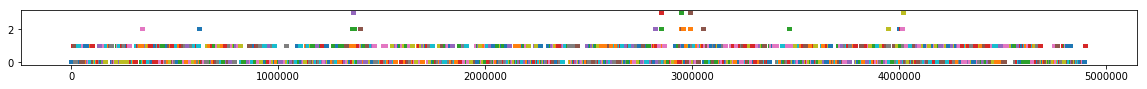

In [8]:
position = Lösung2
#data = read_file('my_apd199.lst','')
pos = sorted(position.items(), key = lambda x: x[1])
contig_len = get_contig_lengths(open('APDContigs.len'))
x_werte = [(contig, start, start+contig_len[contig_name(contig)]) for contig, start in pos]
#constraints = {frozenset({a,b}) for a, b, _ in data}
plt.rcParams['figure.figsize'] = 20, 1
y_frei = coll.defaultdict(int)
c, _ = pos[0]
for contig, x1, x2 in x_werte:
    y = 0
    while y_frei[y] > x1:
        y += 1
    """if contig[-1] != '0':
        plt.plot([x1,x2],[y,y],linewidth = 1)
       # x1 = x1 + contig_len[contig_name(contig)]/2
        x3 = position3[contig_name(contig) + '_0'] #+ contig_len[contig_name(contig)]/2
      #  plt.plot([x1,x2],[y,y],linewidth = 20, color = 'r')
        if x1 > x3:
            x1,x3 = x3,x1
        plt.plot([x1,x3],[0,1])#, color = 'r')
    else:"""
    plt.plot([x1,x2],[y,y],linewidth = 4)#, color = 'b')
    y_frei[y] = x2
    
#plt.xlim([120000,200000])

In [6]:
y_frei = coll.defaultdict(int)
c, _ = pos[0]
for contig, x1, x2 in x_werte:
    y = 0
    while y_frei[y] > x1:
        y += 1
    plt.plot([x1,x2],[y,y],linewidth = 4)#, color = 'b')
    y_frei[y] = x2

NameError: name 'x_werte' is not defined

In [2]:
Lösung2 = {'2206APD_0': 1240945.0, '2356APD_0': 1416566.0, '987APD_0': 4287939.0, '546APD_0': 16529.0, '1472APD_0': 141134.0, '554APD_0': 3749066.0, '2435APD_0': 2256023.0, '307APD_0': 818368.0, '784APD_0': 4613369.0, '1822APD_0': 1492415.0, '134APD_0': 761928.0, '863APD_0': 3603810.0, '1444APD_0': 3173516.0, '2238APD_0': 3321107.0, '1838APD_0': 3891273.0, '2169APD_0': 2752469.0, '1407APD_0': 3579200.0, '1795APD_0': 3684359.0, '624APD_0': 2292705.0, '1649APD_0': 2068367.0, '2378APD_0': 1975255.0, '709APD_0': 3707246.0, '1006APD_0': 1767273.0, '1874APD_1': 2937128.0, '100APD_0': 4094167.0, '94APD_0': 702266.0, '1960APD_0': 3043702.0, '1548APD_0': 3570128.0, '1920APD_0': 1958586.0, '452APD_0': 830792.0, '138APD_0': 2338471.0, '2462APD_0': 3514302.0, '2369APD_0': 2093407.0, '1706APD_0': 1585077.0, '2187APD_0': 2036731.0, '1064APD_1': 2957999.0, '967APD_0': 3395142.0, '271APD_1': 2987855.0, '1562APD_0': 2630813.0, '876APD_0': 226207.0, '1707APD_0': 3123520.0, '2302APD_0': 4028956.0, '1843APD_0': 2506665.0, '162APD_0': 3462502.0, '999APD_0': 1504349.0, '468APD_0': 4820486.0, '1668APD_0': 4893461.0, '1977APD_0': 1822212.0, '1358APD_0': 1913774.0, '1123APD_0': 3687685.0, '2153APD_0': 2304720.0, '2149APD_0': 389754.0, '1476APD_0': 3554571.0, '393APD_0': 3991408.0, '2091APD_0': 2839414.0, '2434APD_0': 452703.0, '2199APD_0': 3340836.0, '939APD_0': 410870.0, '213APD_0': 4352000.0, '1140APD_0': 2062505.0, '602APD_0': 2412563.0, '2048APD_0': 2823858.0, '758APD_0': 1918828.0, '1497APD_1': 3468467.0, '2020APD_0': 1692190.0, '1938APD_0': 2434198.0, '641APD_0': 343332.0, '2163APD_0': 3112294.0, '1512APD_0': 4739936.0, '573APD_0': 948527.0, '714APD_0': 504727.0, '2159APD_0': 1701422.0, '161APD_0': 3723669.0, '718APD_0': 3687016.0, '1587APD_0': 4584197.0, '584APD_0': 1233827.0, '1356APD_0': 2200311.0, '869APD_0': 3937940.0, '782APD_0': 3301720.0, '938APD_0': 4847927.0, '2294APD_0': 4666157.0, '612APD_0': 2621612.0, '1499APD_0': 2203309.0, '1970APD_0': 881603.0, '472APD_0': 4874151.0, '1661APD_0': 471146.0, '1136APD_0': 2205548.0, '106APD_0': 443866.0, '684APD_0': 309145.0, '1862APD_0': 2216563.0, '2182APD_0': 1778039.0, '670APD_0': 1149739.0, '807APD_0': 3591639.0, '1939APD_0': 286175.0, '280APD_0': 1830203.0, '2021APD_0': 347983.0, '1332APD_0': 64571.0, '2459APD_0': 1195655.0, '415APD_0': 3149480.0, '2309APD_0': 3679607.0, '2167APD_0': 3653714.0, '1810APD_0': 3423629.0, '1255APD_0': 2178252.0, '511APD_0': 152164.0, '1656APD_0': 4049587.0, '2263APD_0': 4746258.0, '2436APD_0': 3131804.0, '1303APD_0': 3169434.0, '1693APD_0': 1207801.0, '1687APD_0': 3255632.0, '849APD_0': 2761767.0, '185APD_0': 2299437.0, '679APD_0': 4643045.0, '1066APD_0': 2551278.0, '160APD_0': 3965568.0, '1556APD_0': 3185970.0, '1981APD_0': 374710.0, '244APD_0': 1180178.0, '1847APD_0': 2318378.0, '1147APD_0': 1104525.0, '516APD_0': 1176703.0, '746APD_0': 3292174.0, '86APD_0': 131609.0, '952APD_0': 4540484.0, '1033APD_0': 873310.0, '1420APD_0': 2755918.0, '225APD_0': 68447.0, '821APD_0': 3042665.0, '1223APD_0': 1714932.0, '956APD_0': 3606064.0, '2113APD_0': 55855.0, '591APD_0': 3076790.0, '796APD_0': 3364236.0, '1742APD_0': 1358514.0, '1697APD_1': 3485100.0, '2254APD_0': 4579436.0, '1800APD_0': 2816421.0, '1552APD_0': 1986239.0, '1030APD_0': 1813301.0, '2344APD_0': 4766492.0, '921APD_0': 367475.0, '566APD_0': 2481647.0, '557APD_0': 3373335.0, '243APD_0': 3266356.0, '1339APD_0': 4325920.0, '505APD_0': 4707882.0, '1253APD_0': 899075.0, '1463APD_0': 603561.0, '2130APD_0': 4629622.0, '733APD_0': 3032232.0, '487APD_0': 3273580.0, '1355APD_0': 1717865.0, '72APD_1': 2947515.0, '2138APD_0': 2013744.0, '707APD_0': 4804645.0, '2275APD_0': 1081161.0, '343APD_0': 3090056.0, '333APD_0': 3197349.0, '2012APD_0': 4029357.0, '2287APD_0': 1628270.0, '1440APD_0': 1683387.0, '1138APD_0': 4763743.0, '1449APD_0': 2821044.0, '17APD_0': 2664856.0, '320APD_0': 2010383.0, '2376APD_0': 3893595.0, '1522APD_0': 760551.0, '1769APD_0': 1247157.0, '286APD_0': 2330404.0, '2313APD_0': 4303548.0, '1462APD_0': 3308663.0, '561APD_0': 3554708.0, '1928APD_0': 2034897.0, '1460APD_0': 911569.0, '1747APD_0': 1581663.0, '467APD_0': 4365021.0, '414APD_0': 1181616.0, '1198APD_0': 3101825.0, '1322APD_0': 3166678.0, '916APD_0': 2385138.0, '1637APD_0': 3643860.0, '813APD_0': 2153964.0, '1487APD_0': 2226484.0, '1923APD_0': 2752006.0, '1702APD_0': 3257530.0, '234APD_0': 3521916.0, '182APD_0': 1347245.0, '698APD_0': 3079194.0, '1974APD_0': 1222258.0, '2075APD_1': 684023.0, '1203APD_0': 4287222.0, '530APD_1': 4171063.0, '947APD_0': 4881130.0, '1662APD_0': 3363245.0, '912APD_0': 4173814.0, '2085APD_0': 215161.0, '1891APD_0': 3156094.0, '124APD_0': 3236939.0, '528APD_0': 2459523.0, '1504APD_0': 4810710.0, '1968APD_0': 1805444.0, '951APD_0': 3609618.0, '274APD_0': 2662399.0, '438APD_0': 2406783.0, '1936APD_0': 4695553.0, '1807APD_0': 4855904.0, '1264APD_0': 3020871.0, '828APD_0': 3697918.0, '1485APD_0': 2081036.0, '2258APD_0': 4063213.0, '529APD_0': 2002066.0, '1780APD_0': 4661466.0, '1903APD_0': 158749.0, '2218APD_0': 4832325.0, '267APD_0': 3668074.0, '742APD_0': 1055891.0, '1524APD_0': 2170242.0, '458APD_0': 3659035.0, '1781APD_0': 2234665.0, '2293APD_0': 2096430.0, '412APD_0': 3638069.0, '132APD_0': 1393433.0, '188APD_0': 2008634.0, '2398APD_0': 2014049.0, '2257APD_0': 3397447.0, '2283APD_0': 4646240.0, '433APD_0': 2698726.0, '631APD_0': 1990089.0, '2165APD_0': 3353940.0, '1035APD_0': 1696618.0, '819APD_0': 4562171.0, '1934APD_0': 2255644.0, '1351APD_0': 2122767.0, '1262APD_0': 2421123.0, '1919APD_0': 2487117.0, '971APD_0': 4580532.0, '1336APD_0': 3110412.0, '1363APD_0': 219737.0, '445APD_0': 2850522.0, '1624APD_0': 3236755.0, '64APD_1': 2953552.0, '878APD_0': 1839309.0, '1004APD_1': 3496528.0, '1599APD_0': 1547007.0, '2393APD_0': 3166550.0, '803APD_0': 4274789.0, '117APD_0': 967556.0, '355APD_0': 3051789.0, '1855APD_0': 3793843.0, '112APD_0': 3693514.0, '1362APD_0': 2556251.0, '316APD_0': 1359602.0, '860APD_0': 3664880.0, '424APD_0': 2561860.0, '1580APD_0': 2685643.0, '1494APD_0': 326748.0, '1380APD_0': 220517.0, '1611APD_0': 2902595.0, '1430APD_0': 1231496.0, '736APD_0': 2816931.0, '2374APD_0': 3465773.0, '419APD_1': 3484191.0, '1011APD_0': 1416630.0, '82APD_0': 3246872.0, '1278APD_0': 3012257.0, '1686APD_0': 4631094.0, '1757APD_0': 4730573.0, '897APD_0': 4586465.0, '1979APD_0': 2546749.0, '676APD_0': 1807517.0, '512APD_0': 3908015.0, '1559APD_0': 4057358.0, '1390APD_0': 298775.0, '1501APD_0': 4071157.0, '1393APD_0': 2104873.0, '270APD_0': 3370653.0, '428APD_0': 2819208.0, '622APD_0': 3062600.0, '948APD_0': 203566.0, '1156APD_0': 352451.0, '1684APD_0': 4561090.0, '2460APD_0': 871206.0, '2301APD_0': 2821584.0, '2385APD_0': 4833193.0, '421APD_0': 657770.0, '727APD_0': 1989088.0, '1497APD_0': 3435865.0, '294APD_0': 3817682.0, '2011APD_0': 404974.0, '837APD_0': 4860653.0, '521APD_0': 81058.0, '356APD_0': 2105507.0, '564APD_0': 1722314.0, '1651APD_0': 726857.0, '2114APD_0': 1103602.0, '1172APD_0': 2523436.0, '310APD_0': 4394250.0, '1961APD_0': 3432700.0, '427APD_0': 4756479.0, '1095APD_0': 3611190.0, '175APD_0': 4511719.0, '694APD_0': 612800.0, '940APD_0': 4117541.0, '2005APD_0': 3330493.0, '2388APD_0': 1906592.0, '885APD_0': 235255.0, '744APD_1': 2954462.0, '1558APD_0': 4135549.0, '2019APD_0': 1103299.0, '1932APD_0': 3382290.0, '1805APD_0': 3070030.0, '313APD_0': 2625007.0, '388APD_0': 4068113.0, '2371APD_0': 3385681.0, '432APD_0': 2744576.0, '1523APD_0': 860288.0, '1398APD_0': 4012973.0, '1941APD_0': 1586236.0, '747APD_0': 4633837.0, '238APD_0': 3863086.0, '2101APD_0': 3379610.0, '2346APD_0': 2319168.0, '464APD_0': 789445.0, '1491APD_0': 1699584.0, '2065APD_0': 4681964.0, '1959APD_0': 2852602.0, '2319APD_0': 82996.0, '917APD_0': 2654381.0, '1481APD_0': 49243.0, '1054APD_0': 1150393.0, '1368APD_0': 1632455.0, '1379APD_0': 1233106.0, '578APD_0': 2548346.0, '249APD_0': 2977765.0, '332APD_0': 1726187.0, '854APD_0': 4622480.0, '257APD_0': 2983278.0, '499APD_0': 3411277.0, '207APD_0': 3819410.0, '879APD_0': 1455808.0, '449APD_0': 4655662.0, '1415APD_0': 1711377.0, '166APD_0': 4752588.0, '1902APD_0': 2600699.0, '1553APD_1': 4169532.0, '399APD_0': 1103938.0, '884APD_0': 2159374.0, '89APD_0': 722599.0, '407APD_0': 609634.0, '255APD_0': 3286859.0, '1367APD_0': 4719639.0, '1836APD_0': 2465517.0, '787APD_0': 4728865.0, '2120APD_0': 4405964.0, '895APD_0': 3084755.0, '1606APD_0': 3569811.0, '137APD_0': 4006438.0, '120APD_0': 4483565.0, '1917APD_0': 3116825.0, '140APD_0': 3213416.0, '1311APD_0': 4859923.0, '127APD_0': 2539979.0, '236APD_0': 4018498.0, '2184APD_0': 2556627.0, '69APD_0': 686052.0, '655APD_0': 2878729.0, '500APD_0': 4048155.0, '2185APD_0': 3441332.0, '495APD_0': 2644261.0, '1342APD_0': 3157086.0, '2214APD_0': 1241150.0, '1569APD_0': 3780952.0, '2198APD_0': 4367923.0, '632APD_0': 4798564.0, '1603APD_0': 4231942.0, '2401APD_0': 4866218.0, '2448APD_0': 80666.0, '2034APD_0': 1345505.0, '1439APD_0': 635134.0, '226APD_0': 2284733.0, '469APD_0': 4685620.0, '2055APD_0': 2512784.0, '1676APD_0': 4761838.0, '2231APD_0': 1550488.0, '1724APD_0': 3329267.0, '2352APD_0': 4047750.0, '2384APD_0': 2990705.0, '1361APD_0': 2570658.0, '1334APD_0': 272712.0, '1284APD_0': 1232030.0, '2380APD_0': 297345.0, '2001APD_0': 1139223.0, '1597APD_0': 3659506.0, '2409APD_0': 2072220.0, '1598APD_0': 4658588.0, '1692APD_0': 1145455.0, '155APD_0': 4595777.0, '2259APD_0': 2674211.0, '1734APD_0': 4068283.0, '1200APD_0': 4755043.0, '148APD_0': 1971681.0, '66APD_0': 3354941.0, '145APD_0': 1315923.0, '2428APD_0': 3023894.0, '2391APD_0': 1532282.0, '551APD_0': 1089246.0, '84APD_0': 1366838.0, '957APD_0': 4795382.0, '789APD_0': 287204.0, '1211APD_0': 2860532.0, '1514APD_0': 247070.0, '1340APD_0': 4780508.0, '178APD_0': 1897227.0, '623APD_0': 1137515.0, '687APD_0': 3973737.0, '1252APD_0': 193797.0, '331APD_0': 2169973.0, '1978APD_0': 1769868.0, '72APD_0': 2850523.0, '276APD_0': 392241.0, '899APD_0': 4608391.0, '283APD_0': 3158383.0, '1151APD_0': 206011.0, '1096APD_0': 1945922.0, '2226APD_0': 2633803.0, '834APD_0': 2691676.0, '3APD_0': 944380.0, '697APD_0': 3097023.0, '2207APD_0': 4026498.0, '368APD_0': 2464196.0, '205APD_0': 236063.0, '997APD_0': 4678720.0, '875APD_0': 4559117.0, '353APD_0': 4468486.0, '756APD_0': 2484165.0, '1128APD_0': 3041327.0, '2282APD_0': 3899137.0, '462APD_0': 613135.0, '829APD_0': 1269877.0, '540APD_0': 3132604.0, '241APD_0': 332440.0, '724APD_0': 1569939.0, '1037APD_0': 2628296.0, '2404APD_0': 2198716.0, '2210APD_0': 2785335.0, '1945APD_0': 2918052.0, '240APD_0': 1746772.0, '2323APD_0': 1797308.0, '1899APD_0': 3817056.0, '922APD_0': 2679445.0, '552APD_0': 4141931.0, '1964APD_0': 3297175.0, '1431APD_0': 3577266.0, '1224APD_0': 2841409.0, '1723APD_0': 2164297.0, '845APD_0': 766977.0, '328APD_0': 3065224.0, '625APD_0': 3699903.0, '379APD_0': 405576.0, '1895APD_0': 1176932.0, '1032APD_0': 4379805.0, '2053APD_0': 3115164.0, '1697APD_0': 3452483.0, '2070APD_0': 3661472.0, '1352APD_0': 4417247.0, '1256APD_0': 2198304.0, '1312APD_0': 2988056.0, '1286APD_0': 3289410.0, '55APD_0': 2040718.0, '1447APD_0': 4357611.0, '1364APD_0': 4368874.0, '43APD_0': 4756772.0, '1384APD_0': 4297416.0, '2157APD_0': 1819861.0, '1496APD_0': 4050711.0, '1594APD_0': 3696776.0, '734APD_0': 4592151.0, '323APD_0': 4183652.0, '1137APD_0': 402009.0, '1289APD_0': 2377551.0, '543APD_0': 1086380.0, '1116APD_0': 3015117.0, '1412APD_0': 1561364.0, '1521APD_0': 3604199.0, '1188APD_0': 3651898.0, '1770APD_0': 2376781.0, '163APD_0': 3613700.0, '842APD_0': 3142218.0, '1563APD_0': 2562421.0, '68APD_0': 426367.0, '2452APD_0': 3193304.0, '766APD_0': 558308.0, '2141APD_0': 1506389.0, '2373APD_0': 3338487.0, '534APD_0': 3304163.0, '250APD_0': 3586365.0, '151APD_0': 528412.0, '2063APD_0': 4786057.0, '2340APD_0': 2691137.0, '735APD_0': 376487.0, '2348APD_0': 4814889.0, '2305APD_0': 2166145.0, '719APD_0': 4654355.0, '2008APD_0': 4863117.0, '1526APD_0': 4307567.0, '1373APD_0': 2643311.0, '79APD_0': 2218438.0, '229APD_0': 1180484.0, '360APD_0': 2614267.0, '572APD_0': 743357.0, '1065APD_0': 2200630.0, '958APD_0': 93290.0, '1845APD_0': 2032901.0, '7APD_0': 4072505.0, '2099APD_0': 2070862.0, '892APD_0': 1968558.0, '1489APD_0': 4396970.0, '1581APD_0': 3323389.0, '209APD_0': 34241.0, '2145APD_0': 2111078.0, '637APD_0': 4764092.0, '466APD_0': 274603.0, '1125APD_0': 2702293.0, '1314APD_0': 2259250.0, '1529APD_0': 138279.0, '1347APD_0': 1994532.0, '1835APD_0': 1056769.0, '2447APD_0': 3367994.0, '1115APD_0': 4577869.0, '586APD_0': 3714987.0, '1051APD_0': 3081500.0, '1875APD_0': 4663451.0, '387APD_0': 4817806.0, '380APD_0': 1783225.0, '608APD_0': 2318570.0, '214APD_1': 3992997.0, '242APD_0': 288492.0, '1049APD_0': 1216276.0, '2392APD_0': 4623305.0, '247APD_0': 4567148.0, '1285APD_0': 1443686.0, '369APD_0': 2956386.0, '2330APD_0': 2621878.0, '374APD_0': 244219.0, '122APD_0': 4779762.0, '2281APD_0': 4406757.0, '1749APD_0': 1612985.0, '881APD_0': 1140521.0, '1693APD_1': 1962374.0, '1387APD_0': 2421393.0, '2228APD_0': 3367702.0, '214APD_2': 4016896.0, '1949APD_0': 3243746.0, '2180APD_0': 3064831.0, '214APD_0': 3929746.0, '2455APD_0': 1497767.0, '1804APD_0': 2671856.0, '409APD_0': 4623498.0, '2112APD_0': 1127239.0, '168APD_0': 2098735.0, '597APD_0': 767757.0, '2280APD_0': 4853496.0, '1716APD_0': 2120836.0, '1595APD_0': 425483.0, '1178APD_0': 3342431.0, '1972APD_0': 4556307.0, '2007APD_0': 2875240.0, '21APD_0': 3161855.0, '1020APD_0': 3014439.0, '2255APD_0': 2080724.0, '1246APD_0': 271731.0, '1534APD_0': 14957.0, '665APD_0': 3372937.0, '1699APD_0': 2694373.0, '245APD_0': 3914196.0, '1701APD_0': 307645.0, '491APD_1': 684022.0, '165APD_0': 4804160.0, '754APD_0': 3202505.0, '1324APD_0': 4050176.0, '870APD_0': 4550118.0, '555APD_0': 1551188.0, '1564APD_0': 4302945.0, '1175APD_0': 4749920.0, '339APD_0': 3504837.0, '375APD_0': 4437313.0, '2278APD_0': 1463393.0, '580APD_0': 254846.0, '755APD_0': 1710245.0, '570APD_0': 4382492.0, '1400APD_0': 146115.0, '2456APD_0': 4858854.0, '23APD_0': 1117978.0, '1817APD_0': 1123933.0, '1876APD_0': 2288326.0, '1545APD_0': 3055244.0, '373APD_0': 3901881.0, '1003APD_0': 1677546.0, '2078APD_0': 3397565.0, '1889APD_0': 331111.0, '2103APD_0': 2294964.0, '844APD_0': 2678580.0, '1751APD_0': 483436.0, '1228APD_0': 2225515.0, '2317APD_0': 3595716.0, '799APD_0': 2814263.0, '2084APD_0': 4605941.0, '855APD_0': 279125.0, '1743APD_0': 4699549.0, '1778APD_0': 3639527.0, '2405APD_0': 4679869.0, '1877APD_0': 106421.0, '64APD_0': 2859219.0, '613APD_0': 3819696.0, '1608APD_0': 250881.0, '2047APD_0': 3124224.0, '1114APD_0': 1460500.0, '2077APD_0': 990998.0, '2358APD_0': 944042.0, '282APD_0': 3106083.0, '767APD_0': 4706366.0, '2140APD_0': 2296033.0, '577APD_0': 19046.0, '1679APD_0': 1008738.0, '326APD_1': 2958265.0, '614APD_0': 4757549.0, '659APD_0': 4724052.0, '1896APD_0': 4292439.0, '338APD_0': 3323794.0, '1145APD_0': 1105293.0, '1146APD_0': 2462226.0, '1887APD_0': 4331290.0, '585APD_0': 4303986.0, '164APD_0': 3463495.0, '2329APD_0': 4885406.0, '1185APD_0': 436194.0, '739APD_0': 2378274.0, '1905APD_0': 3814911.0, '2342APD_0': 2680201.0, '2247APD_0': 1183138.0, '227APD_0': 2451864.0, '1636APD_0': 2451542.0, '186APD_0': 3613454.0, '1827APD_0': 2095233.0, '1541APD_0': 766792.0, '157APD_1': 337361.0, '384APD_0': 1742849.0, '2061APD_0': 3809347.0, '2046APD_0': 1550074.0, '135APD_0': 3515119.0, '1553APD_0': 4066326.0, '2339APD_0': 1148650.0, '52APD_1': 3492277.0, '1878APD_0': 1161935.0, '34APD_0': 3507295.0, '1830APD_0': 2683184.0, '1689APD_0': 1707043.0, '1457APD_0': 2117114.0, '2111APD_0': 3604885.0, '635APD_0': 4177371.0, '1730APD_0': 1185675.0, '1448APD_0': 2916874.0, '278APD_0': 3801830.0, '6APD_0': 2049255.0, '447APD_0': 3101367.0, '1566APD_0': 3064239.0, '2186APD_0': 4605352.0, '1819APD_0': 2087022.0, '988APD_0': 2123292.0, '29APD_0': 4772483.0, '311APD_0': 1950954.0, '73APD_0': 902910.0, '1505APD_0': 2709374.0, '1806APD_0': 3462172.0, '1848APD_0': 4705315.0, '179APD_0': 4800734.0, '397APD_0': 3660346.0, '617APD_0': 3265811.0, '235APD_0': 340681.0, '181APD_0': 3250427.0, '2083APD_0': 1910434.0, '1180APD_0': 4682546.0, '2341APD_0': 2981382.0, '496APD_0': 4082467.0, '1904APD_0': 212459.0, '1220APD_0': 2713412.0, '1473APD_0': 1676337.0, '681APD_0': 691574.0, '1787APD_0': 4656482.0, '710APD_0': 3364739.0, '1375APD_0': 187004.0, '342APD_2': 1467364.0, '2245APD_0': 4649051.0, '598APD_0': 3065579.0, '1962APD_0': 4884903.0, '401APD_0': 3943962.0, '2383APD_0': 4754719.0, '1963APD_0': 4648612.0, '2131APD_0': 2407165.0, '1645APD_0': 2325755.0, '2123APD_0': 2813739.0, '1397APD_0': 233711.0, '256APD_0': 3739698.0, '2314APD_0': 4417906.0, '1666APD_0': 4130851.0, '1834APD_0': 4763418.0, '199APD_0': 3313154.0, '1759APD_0': 3095893.0, '1372APD_0': 3562922.0, '11APD_0': 673883.0, '1263APD_0': 1455392.0, '450APD_0': 4611061.0, '950APD_0': 2387643.0, '890APD_0': 2377945.0, '2082APD_0': 3061331.0, '930APD_0': 3341562.0, '1446APD_0': 3229868.0, '2424APD_0': 4306592.0, '2403APD_0': 4081891.0, '745APD_0': 1139502.0, '318APD_0': 280429.0, '2202APD_0': 2660888.0, '898APD_0': 296808.0, '1280APD_0': 2414950.0, '776APD_0': 130324.0, '1582APD_0': 2676753.0, '30APD_0': 3314455.0, '2026APD_0': 789247.0, '2188APD_0': 1800789.0, '18APD_0': 1411114.0, '1268APD_0': 386037.0, '2442APD_0': 4609016.0, '477APD_0': 1734635.0, '2056APD_0': 1825633.0, '204APD_0': 3229422.0, '1999APD_0': 3370018.0, '832APD_0': 327712.0, '1614APD_0': 3157789.0, '2089APD_0': 2318990.0, '1950APD_0': 3663337.0, '929APD_0': 2568751.0, '1000APD_0': 1896845.0, '349APD_0': 4301005.0, '1215APD_0': 4894627.0, '121APD_0': 2550366.0, '1338APD_0': 2901977.0, '1631APD_0': 125058.0, '2195APD_0': 1409429.0, '856APD_0': 2259839.0, '1927APD_0': 3059653.0, '56APD_0': 4390659.0, '672APD_0': 2830996.0, '1629APD_0': 1381220.0, '1029APD_0': 3754910.0, '518APD_0': 2123874.0, '309APD_0': 4730939.0, '510APD_0': 1784996.0, '1825APD_0': 2009673.0, '1144APD_0': 4632969.0, '1752APD_0': 1845289.0, '964APD_0': 1678286.0, '483APD_0': 1444761.0, '1149APD_0': 2246907.0, '285APD_0': 2090765.0, '1833APD_0': 3046786.0, '1812APD_0': 1661148.0, '1670APD_0': 4595510.0, '2142APD_0': 1186667.0, '1139APD_0': 3960082.0, '740APD_0': 379564.0, '2124APD_0': 4884513.0, '2457APD_0': 3976653.0, '2318APD_0': 3077637.0, '1028APD_0': 3429545.0, '98APD_0': 399640.0, '141APD_0': 2639293.0, '1818APD_0': 2819947.0, '923APD_0': 4264025.0, '2052APD_0': 2375398.0, '607APD_0': 3434415.0, '1925APD_0': 2151317.0, '2125APD_0': 311035.0, '2095APD_0': 4716853.0, '83APD_0': 3689308.0, '688APD_0': 3875573.0, '1059APD_0': 1150853.0, '1438APD_0': 3432569.0, '2040APD_0': 2403736.0, '1663APD_0': 3582553.0, '1099APD_0': 2511130.0, '113APD_0': 1419275.0, '857APD_0': 2243552.0, '530APD_0': 4067853.0, '513APD_0': 3346592.0, '491APD_0': 612969.0, '2327APD_0': 2550783.0, '2062APD_0': 2495839.0, '2222APD_0': 4810238.0, '2002APD_0': 2173134.0, '1103APD_0': 2072903.0, '812APD_0': 4666622.0, '2225APD_0': 2687998.0, '1349APD_0': 2605856.0, '315APD_0': 2190961.0, '2162APD_0': 3577606.0, '1754APD_0': 3022045.0, '1733APD_0': 2038370.0, '1APD_0': 614681.0, '212APD_0': 182815.0, '1578APD_0': 2258073.0, '1531APD_0': 3708464.0, '1880APD_0': 1687398.0, '2271APD_0': 3300512.0, '1016APD_0': 1284019.0, '809APD_0': 2398418.0, '202APD_0': 461050.0, '233APD_0': 4501416.0, '92APD_0': 3646146.0, '2351APD_0': 1083903.0, '2331APD_0': 1180826.0, '396APD_0': 4559973.0, '1064APD_0': 2863447.0, '2386APD_0': 1239355.0, '1231APD_0': 2168155.0, '2325APD_0': 3277428.0, '70APD_0': 2248025.0, '1630APD_0': 109277.0, '2441APD_0': 4344940.0, '1691APD_0': 830117.0, '326APD_0': 1232745.0, '2164APD_0': 2069107.0, '1469APD_0': 3858149.0, '633APD_0': 2845648.0, '1893APD_0': 1128384.0, '619APD_0': 2609188.0, '1852APD_0': 526414.0, '184APD_0': 343630.0, '2454APD_0': 2597854.0, '1309APD_0': 474162.0, '773APD_0': 2553577.0, '281APD_0': 1268333.0, '1488APD_0': 4065890.0, '1207APD_0': 2689083.0, '907APD_0': 3433512.0, '1799APD_0': 1835128.0, '482APD_0': 4323544.0, '1076APD_0': 83364.0, '1333APD_0': 3087878.0, '289APD_0': 3290583.0, '216APD_0': 302409.0, '1021APD_0': 2663273.0, '1117APD_0': 2214497.0, '1143APD_0': 2053990.0, '1771APD_0': 186688.0, '2045APD_0': 3821949.0, '1040APD_0': 2657476.0, '298APD_0': 4022492.0, '1509APD_0': 4667064.0, '1849APD_0': 4644280.0, '685APD_0': 4595227.0, '2147APD_0': 4068712.0, '297APD_0': 4074882.0, '370APD_1': 3498826.0, '804APD_0': 3365705.0, '520APD_0': 3465625.0, '1328APD_0': 3686635.0, '1433APD_0': 413674.0, '970APD_0': 1381585.0, '1756APD_0': 2146394.0, '1454APD_0': 367174.0, '1918APD_0': 4793670.0, '646APD_0': 4658297.0, '159APD_0': 2868578.0, '2299APD_0': 4818131.0, '143APD_0': 2973576.0, '1750APD_0': 1563597.0, '203APD_0': 3347266.0, '759APD_0': 2006149.0, '726APD_0': 3920440.0, '541APD_0': 3839367.0, '1623APD_0': 3228357.0, '1590APD_0': 329017.0, '74APD_0': 3272521.0, '705APD_0': 4762336.0, '57APD_0': 556555.0, '1565APD_0': 3143270.0, '1721APD_0': 710754.0, '1850APD_0': 380949.0, '850APD_0': 355667.0, '954APD_0': 4893570.0, '656APD_0': 513027.0, '1520APD_0': 2310863.0, '1549APD_0': 2121088.0, '2144APD_0': 3798156.0, '535APD_0': 3287313.0, '2288APD_0': 3892497.0, '744APD_0': 2860149.0, '846APD_0': 2282132.0, '169APD_0': 4067308.0, '1607APD_0': 1191440.0, '816APD_0': 2958472.0, '2416APD_0': 3108713.0, '1413APD_0': 2069586.0, '2355APD_0': 4608714.0, '1077APD_0': 403675.0, '2438APD_0': 2640873.0, '432APD_1': 2818914.0, '1199APD_0': 436816.0, '1217APD_0': 3188797.0, '2306APD_0': 4730037.0, '1288APD_0': 3685616.0, '1042APD_0': 3136830.0, '2444APD_0': 4453798.0, '1561APD_0': 4118068.0, '1196APD_0': 3287684.0, '973APD_0': 2501446.0, '104APD_0': 2174301.0, '1135APD_0': 3182425.0, '125APD_0': 2022964.0, '53APD_1': 2946638.0, '1404APD_0': 1982790.0, '2410APD_0': 715569.0, '1046APD_0': 4191878.0, '790APD_0': 4607123.0, '1195APD_0': 1667710.0, '2379APD_0': 2060191.0, '426APD_0': 4083683.0, '1307APD_0': 4596830.0, '590APD_0': 2139875.0, '1346APD_0': 1725608.0, '1633APD_0': 2284397.0, '2088APD_0': 252381.0, '547APD_0': 279947.0, '1784APD_0': 3878639.0, '1298APD_0': 4029800.0, '28APD_0': 3268989.0, '1317APD_0': 165839.0, '2335APD_0': 482370.0, '1094APD_0': 3584588.0, '898APD_1': 312267.0, '465APD_0': 2864678.0, '178APD_1': 2907862.0, '1994APD_0': 4775386.0, '1152APD_0': 3644422.0, '2128APD_0': 1239030.0, '2201APD_0': 3553845.0, '606APD_0': 4248333.0, '961APD_0': 3363952.0, '1544APD_0': 1178043.0, '1881APD_0': 3781575.0, '531APD_0': 2988672.0, '1181APD_0': 1646674.0, '1619APD_0': 4747824.0, '661APD_0': 3853325.0, '1452APD_0': 3290215.0, '694APD_1': 683855.0, '1735APD_0': 4277117.0, '1308APD_0': 3641099.0, '22APD_0': 3508775.0, '1451APD_0': 1829185.0, '36APD_0': 3046891.0, '2038APD_0': 1063590.0, '454APD_0': 1527861.0, '919APD_0': 1245992.0, '1638APD_0': 4487829.0, '319APD_0': 2799964.0, '1354APD_0': 1815329.0, '167APD_0': 807422.0, '119APD_0': 733039.0, '102APD_0': 2582225.0, '1392APD_0': 3295611.0, '1935APD_0': 1164398.0, '913APD_0': 3313290.0, '2122APD_0': 322208.0, '2239APD_0': 2295859.0, '473APD_0': 3974787.0, '2407APD_0': 3710350.0, '1102APD_0': 2479318.0, '1842APD_0': 2302781.0, '2006APD_0': 3260423.0, '2440APD_0': 1207867.0, '1993APD_0': 2574885.0, '2097APD_0': 2247706.0, '2418APD_0': 4395905.0, '558APD_0': 3441918.0, '980APD_0': 1136766.0, '336APD_0': 3128063.0, '544APD_0': 2820528.0, '873APD_0': 2421664.0, '571APD_0': 232776.0, '2250APD_0': 936185.0, '1748APD_0': 2696129.0, '905APD_0': 3720752.0, '865APD_0': 604760.0, '877APD_0': 1082745.0, '783APD_0': 1035044.0, '974APD_0': 3651354.0, '372APD_0': 3432160.0, '1761APD_0': 3244702.0, '2264APD_0': 3011908.0, '2031APD_0': 4660863.0, '654APD_0': 1177696.0, '575APD_0': 3025328.0, '291APD_0': 2948731.0, '721APD_0': 4138654.0, '795APD_0': 2682335.0, '1826APD_0': 2177691.0, '2328APD_1': 3472982.0, '891APD_0': 1550909.0, '253APD_0': 1527170.0, '1014APD_0': 4780224.0, '308APD_0': 2165829.0, '77APD_0': 889413.0, '271APD_0': 1385629.0, '1130APD_0': 4166928.0, '1210APD_0': 2207217.0, '1675APD_0': 384649.0, '1480APD_0': 145678.0, '417APD_0': 3619379.0, '772APD_0': 194550.0, '1911APD_0': 45607.0, '1991APD_0': 229566.0, '1859APD_0': 3984192.0, '47APD_1': 3492921.0, '2326APD_0': 2052426.0, '1043APD_0': 3026804.0, '1837APD_0': 1057838.0, '1727APD_0': 4419910.0, '251APD_0': 1906946.0, '1107APD_0': 4630834.0, '1479APD_0': 2153306.0, '1955APD_0': 295597.0, '2350APD_0': 461910.0, '1458APD_0': 2115320.0, '1249APD_0': 1031089.0, '2273APD_0': 4069438.0, '1930APD_0': 288637.0, '354APD_0': 3363697.0, '936APD_0': 1950446.0, '2072APD_0': 4814598.0, '537APD_0': 4013191.0, '674APD_0': 3465625.0, '342APD_1': 1389609.0, '567APD_0': 128449.0, '224APD_0': 2362868.0, '2399APD_0': 1501711.0, '411APD_0': 2864174.0, '174APD_0': 3338865.0, '1073APD_0': 1010213.0, '1828APD_0': 1782928.0, '2256APD_0': 420387.0, '1659APD_0': 4590866.0, '1890APD_0': 3240847.0, '96APD_0': 2538309.0, '592APD_0': 4785604.0, '801APD_0': 4322457.0, '386APD_0': 3245175.0, '2316APD_0': 2356154.0, '1265APD_0': 896660.0, '1910APD_0': 3174810.0, '2394APD_0': 682436.0, '1101APD_0': 2212600.0, '1722APD_0': 3206913.0, '305APD_1': 4012851.0, '75APD_0': 776173.0, '1762APD_0': 2992234.0, '778APD_0': 2133203.0, '382APD_0': 2643971.0, '1283APD_0': 2066938.0, '1471APD_0': 2773265.0, '2132APD_0': 3307275.0, '1142APD_0': 2657701.0, '221APD_0': 2849330.0, '962APD_0': 3681426.0, '1792APD_0': 4562601.0, '1087APD_0': 4724530.0, '1078APD_0': 4835918.0, '1815APD_0': 572815.0, '476APD_0': 1858139.0, '2227APD_0': 1976662.0, '1551APD_0': 2318085.0, '268APD_0': 3635440.0, '1729APD_0': 765229.0, '777APD_0': 1766651.0, '893APD_0': 4747973.0, '1923APD_1': 2821167.0, '445APD_1': 2947513.0, '594APD_0': 4867243.0, '371APD_0': 1277703.0, '1260APD_0': 4849167.0, '820APD_0': 888688.0, '2297APD_0': 1852006.0, '704APD_0': 3211523.0, '2071APD_0': 402767.0, '288APD_0': 3762116.0, '488APD_0': 4380759.0, '1957APD_0': 2206090.0, '479APD_0': 4203388.0, '859APD_0': 1690362.0, '2277APD_0': 2188113.0, '1888APD_0': 4762819.0, '1718APD_0': 4052002.0, '1331APD_0': 4079151.0, '1182APD_0': 3886538.0, '1943APD_0': 3853579.0, '1573APD_0': 4051415.0, '1498APD_0': 2360917.0, '1401APD_0': 4628680.0, '1159APD_0': 2604457.0, '15APD_0': 2781330.0, '99APD_0': 1170752.0, '1871APD_0': 2516100.0, '653APD_0': 794100.0, '830APD_0': 2957680.0, '81APD_0': 4253899.0, '868APD_0': 4034443.0, '1374APD_0': 697616.0, '2033APD_0': 4053753.0, '2036APD_0': 2689433.0, '894APD_0': 1608130.0, '455APD_0': 4753642.0, '33APD_0': 4707322.0, '1155APD_0': 1957171.0, '965APD_0': 4282404.0, '1057APD_0': 138964.0, '532APD_0': 4062389.0, '1456APD_0': 2087941.0, '1160APD_1': 2816405.0, '504APD_0': 2720589.0, '2030APD_0': 4415339.0, '944APD_0': 1175486.0, '1327APD_0': 3056670.0, '1273APD_0': 2594098.0, '1089APD_0': 3312554.0, '1164APD_0': 2124589.0, '162APD_1': 3495120.0, '2029APD_0': 343026.0, '794APD_0': 4744535.0, '272APD_0': 4055596.0, '2116APD_0': 4323829.0, '2270APD_0': 4194758.0, '1510APD_0': 1458308.0, '650APD_1': 2944129.0, '35APD_0': 358847.0, '565APD_0': 791117.0, '172APD_0': 3211115.0, '1417APD_0': 1709361.0, '576APD_1': 2955675.0, '390APD_0': 2920326.0, '1085APD_0': 2296814.0, '729APD_0': 4675769.0, '587APD_0': 4228244.0, '1683APD_0': 3311916.0, '2422APD_0': 2989633.0, '1001APD_0': 4039931.0, '1007APD_0': 2297958.0, '1915APD_0': 3083014.0, '76APD_0': 3722590.0, '1247APD_0': 2385541.0, '1395APD_0': 6985.0, '628APD_0': 4573046.0, '2175APD_0': 3898622.0, '2208APD_0': 4226696.0, '259APD_0': 3946637.0, '2092APD_0': 439388.0, '1775APD_0': 3341130.0, '1084APD_0': 2171790.0, '2235APD_0': 14288.0, '2174APD_0': 2671116.0, '722APD_0': 1653079.0, '2262APD_0': 3182874.0, '640APD_0': 1209158.0, '223APD_0': 4896219.0, '1365APD_0': 4793302.0, '1160APD_0': 2742074.0, '2458APD_0': 267891.0, '392APD_0': 3285798.0, '290APD_0': 1328730.0, '194APD_0': 4676946.0, '116APD_0': 2737095.0, '1658APD_0': 3505016.0, '1696APD_0': 2136045.0, '743APD_0': 1838458.0, '636APD_0': 4616551.0, '761APD_0': 3244130.0, '2057APD_0': 4863686.0, '2412APD_0': 1109144.0, '1429APD_0': 3890493.0, '660APD_0': 3626097.0, '2014APD_0': 4864683.0, '1359APD_0': 3205744.0, '666APD_0': 2324803.0, '1811APD_0': 2956136.0, '1150APD_0': 1850316.0, '1131APD_0': 3170738.0, '261APD_0': 324422.0, '388APD_1': 4171306.0, '219APD_0': 1188126.0, '1119APD_0': 4061087.0, '2433APD_0': 4561521.0, '675APD_0': 2136786.0, '695APD_0': 4091894.0, '339APD_1': 3511410.0, '1436APD_0': 2051956.0, '949APD_0': 3326414.0, '273APD_0': 1598899.0, '1177APD_0': 1004769.0, '13APD_0': 4729280.0, '2067APD_0': 4128962.0, '926APD_0': 4330077.0, '52APD_0': 3459660.0, '545APD_0': 2101543.0, '1208APD_0': 1456404.0, '1038APD_0': 421966.0, '1951APD_0': 4248840.0, '658APD_0': 2853234.0, '975APD_0': 1697746.0, '1857APD_0': 183198.0, '1121APD_0': 1120466.0, '1988APD_0': 3722022.0, '1626APD_0': 298494.0, '599APD_0': 588496.0, '708APD_0': 759018.0, '1330APD_0': 480450.0, '457APD_0': 3999745.0, '1764APD_0': 2144596.0, '2APD_0': 2108135.0, '2360APD_0': 3052790.0, '437APD_0': 4199512.0, '51APD_0': 1524973.0, '2241APD_0': 4127936.0, '1790APD_0': 3393408.0, '1664APD_0': 3615513.0, '1744APD_0': 1847655.0, '1886APD_0': 2113592.0, '1704APD_0': 1946388.0, '525APD_0': 764808.0, '924APD_0': 3639278.0, '1013APD_0': 3421424.0, '1366APD_0': 726319.0, '882APD_0': 2130888.0, '568APD_0': 874744.0, '192APD_0': 3729556.0, '2461APD_0': 454241.0, '906APD_0': 203260.0, '248APD_0': 4802455.0, '2193APD_0': 2200912.0, '1428APD_0': 1965491.0, '596APD_0': 1170526.0, '1502APD_0': 2554057.0, '976APD_0': 2368607.0, '2203APD_0': 2114126.0, '1568APD_0': 1133115.0, '1319APD_0': 3379499.0, '1079APD_0': 2462519.0, '650APD_0': 2847132.0, '520APD_1': 3498240.0, '2023APD_0': 2506310.0, '1640APD_0': 2719918.0, '839APD_0': 4568558.0, '2155APD_0': 753305.0, '2300APD_0': 4571143.0, '389APD_0': 2229039.0, '887APD_0': 2976371.0, '2139APD_0': 3324279.0, '2427APD_0': 3299911.0, '58APD_1': 643338.0, '1455APD_0': 4452286.0, '1034APD_0': 3271924.0, '800APD_0': 232543.0, '1097APD_0': 1171098.0, '2382APD_0': 555999.0, '1567APD_0': 3780810.0, '1885APD_0': 2941553.0, '1214APD_0': 3386003.0, '768APD_0': 1649589.0, '123APD_0': 4830783.0, '1980APD_0': 92218.0, '1396APD_0': 1235545.0, '900APD_0': 557468.0, '2192APD_0': 2524738.0, '686APD_0': 3226189.0, '627APD_0': 667401.0, '1074APD_0': 1291254.0, '149APD_0': 1797121.0, '2066APD_0': 1442103.0, '303APD_0': 2778632.0, '334APD_0': 962571.0, '1325APD_0': 3599540.0, '434APD_0': 4747010.0, '1493APD_0': 3678896.0, '423APD_0': 3682234.0, '446APD_0': 4823640.0, '2303APD_0': 3597600.0, '453APD_0': 3555680.0, '966APD_0': 3140699.0, '2234APD_0': 4222479.0, '1230APD_0': 3251016.0, '937APD_0': 4739503.0, '1973APD_0': 4723521.0, '2236APD_0': 2813157.0, '2240APD_0': 3687383.0, '1755APD_0': 3196582.0, '1234APD_0': 3669446.0, '2311APD_0': 4427322.0, '1655APD_0': 2399202.0, '1389APD_0': 1911825.0, '1644APD_0': 1803409.0, '1813APD_0': 1343350.0, '1426APD_0': 3505388.0, '741APD_0': 3180841.0, '1261APD_0': 828807.0, '874APD_0': 400854.0, '265APD_0': 1121481.0, '329APD_0': 4570127.0, '618APD_0': 2778085.0, '269APD_0': 4896750.0, '2004APD_0': 1591833.0, '62APD_0': 1098393.0, '989APD_0': 439764.0, '1576APD_0': 3822978.0, '2043APD_1': 2958425.0, '909APD_0': 1208171.0, '1665APD_0': 475118.0, '1500APD_0': 613913.0, '10APD_0': 4054374.0, '230APD_0': 2817468.0, '1069APD_0': 3900466.0, '1419APD_0': 3370848.0, '2223APD_0': 1163954.0, '943APD_0': 151422.0, '275APD_0': 1232466.0, '2267APD_0': 3067975.0, '187APD_0': 542259.0, '498APD_0': 1898480.0, '304APD_0': 4806124.0, '514APD_0': 4418717.0, '1543APD_0': 289480.0, '1100APD_0': 4854557.0, '337APD_0': 1133850.0, '2362APD_0': 3253624.0, '2168APD_0': 3067626.0, '750APD_0': 2258945.0, '133APD_0': 3053665.0, '764APD_0': 311452.0, '2194APD_0': 4791709.0, '994APD_0': 1538243.0, '1806APD_1': 3494788.0, '147APD_0': 1793031.0, '361APD_0': 1539699.0, '1056APD_0': 4669540.0, '478APD_0': 2180834.0, '703APD_0': 637726.0, '953APD_0': 4422156.0, '208APD_0': 387564.0, '1802APD_0': 4057971.0, '25APD_0': 4310059.0, '1341APD_0': 2374766.0, '1860APD_0': 2012811.0, '683APD_0': 2147775.0, '1294APD_0': 3518185.0, '990APD_0': 2146987.0, '527APD_0': 2001212.0, '751APD_0': 1365580.0, '1788APD_0': 3751783.0, '198APD_0': 1264237.0, '1197APD_0': 2142037.0, '1647APD_0': 414063.0, '1546APD_0': 3163905.0, '492APD_0': 2283319.0, '2359APD_0': 2103542.0, '346APD_0': 2855204.0, '1024APD_0': 406050.0, '793APD_0': 227379.0, '1157APD_0': 2042164.0, '519APD_0': 2156323.0, '1304APD_0': 4335270.0, '85APD_0': 4063542.0, '1257APD_0': 3589046.0, '2246APD_0': 4112596.0, '1732APD_0': 2522291.0, '2295APD_0': 3704853.0, '1169APD_0': 385289.0, '2060APD_0': 1380885.0, '1570APD_0': 2048347.0, '1240APD_0': 1624476.0, '1377APD_0': 3798501.0, '1053APD_0': 4264359.0, '39APD_0': 4236627.0, '1048APD_0': 1100494.0, '2178APD_0': 2851761.0, '802APD_0': 983619.0, '1766APD_0': 4738716.0, '1225APD_0': 2655056.0, '1992APD_0': 2177442.0, '279APD_0': 1398205.0, '1557APD_0': 4736162.0, '105APD_0': 3919952.0, '1435APD_0': 3355506.0, '1824APD_0': 4285613.0, '197APD_0': 3593494.0, '2200APD_0': 2699021.0, '955APD_0': 1658592.0, '378APD_0': 4562981.0, '748APD_0': 1993043.0, '986APD_0': 352627.0, '693APD_0': 3633260.0, '2324APD_0': 1366424.0, '2343APD_0': 4412030.0, '609APD_0': 1042249.0, '2058APD_0': 149738.0, '116APD_1': 2811456.0, '31APD_0': 506743.0, '49APD_0': 2726713.0, '1726APD_0': 3598299.0, '621APD_0': 2218087.0, '1525APD_0': 1271433.0, '852APD_0': 3152120.0, '144APD_0': 3335441.0, '1984APD_0': 4588279.0, '78APD_0': 2878083.0, '2261APD_0': 555608.0, '403APD_0': 2235194.0, '985APD_0': 4071785.0, '730APD_0': 4679063.0, '827APD_0': 1975563.0, '1190APD_0': 3349807.0, '1673APD_0': 4457399.0, '649APD_0': 3733660.0, '2421APD_0': 3234229.0, '901APD_0': 3421578.0, '237APD_0': 3124053.0, '484APD_0': 1518024.0, '302APD_1': 4006441.0, '2395APD_0': 1780301.0, '61APD_0': 2252634.0, '335APD_0': 419202.0, '1588APD_0': 3209006.0, '1625APD_0': 163728.0, '2445APD_0': 4881544.0, '2243APD_0': 2877526.0, '927APD_0': 1930425.0, '46APD_0': 4298314.0, '2035APD_0': 4752008.0, '2109APD_0': 45743.0, '2086APD_0': 2900961.0, '1173APD_0': 3252792.0, '1798APD_0': 1117224.0, '1816APD_0': 478179.0, '407APD_1': 680688.0, '2279APD_0': 2400756.0, '1394APD_0': 3072397.0, '960APD_0': 101556.0, '904APD_0': 487447.0, '1671APD_0': 2433828.0, '1441APD_0': 1618318.0, '1244APD_0': 2205834.0, '2413APD_0': 1917848.0, '1383APD_0': 2494133.0, '1639APD_0': 3760951.0, '1874APD_0': 1331810.0, '903APD_0': 1567910.0, '797APD_0': 2167682.0, '1022APD_0': 686923.0, '1586APD_0': 325259.0, '1437APD_0': 4670190.0, '1660APD_0': 4818429.0, '2177APD_0': 3120932.0, '367APD_0': 1060904.0, '2133APD_0': 4866556.0, '1709APD_0': 3264418.0, '193APD_0': 2447383.0, '601APD_0': 282825.0, '1907APD_0': 48990.0, '277APD_0': 241703.0, '946APD_0': 2119835.0, '1898APD_0': 4817571.0, '1669APD_0': 2611157.0, '1682APD_0': 3121193.0, '20APD_0': 2963757.0, '762APD_0': 4731547.0, '576APD_0': 2861342.0, '1601APD_0': 4656111.0, '266APD_0': 407081.0, '826APD_0': 2517621.0, '485APD_0': 1507096.0, '1605APD_0': 2314106.0, '88APD_0': 291842.0, '2249APD_0': 1186247.0, '2217APD_0': 3194886.0, '2276APD_0': 4863451.0, '862APD_0': 2713883.0, '1465APD_0': 225007.0, '2423APD_0': 451655.0, '2059APD_0': 3187590.0, '1061APD_0': 3887798.0, '2134APD_0': 776016.0, '1685APD_0': 2665301.0, '1272APD_0': 2173437.0, '507APD_0': 3721857.0, '1388APD_0': 3084594.0, '1634APD_0': 1571487.0, '785APD_0': 2151705.0, '210APD_0': 1595766.0, '90APD_0': 462338.0, '888APD_0': 2652414.0, '560APD_0': 2963462.0, '2451APD_0': 4146124.0, '324APD_0': 2561121.0, '1082APD_0': 4735737.0, '1109APD_0': 4747492.0, '157APD_0': 314716.0, '2274APD_0': 3320607.0, '411APD_1': 2958571.0, '1953APD_0': 4784085.0, '841APD_0': 4680663.0, '2172APD_0': 1590117.0, '101APD_0': 2227554.0, '1258APD_0': 891041.0, '723APD_0': 4684232.0, '1507APD_0': 806854.0, '553APD_0': 1607856.0, '50APD_0': 88557.0, '501APD_1': 1354534.0, '58APD_2': 652366.0, '1112APD_0': 3100513.0, '1148APD_0': 2341804.0, '506APD_0': 264067.0, '925APD_0': 3900852.0, '19APD_0': 190713.0, '979APD_0': 3755166.0, '2414APD_0': 3465878.0, '410APD_0': 1152492.0, '1088APD_0': 2073274.0, '2357APD_0': 3281811.0, '1584APD_0': 3550866.0, '370APD_0': 3466144.0, '814APD_0': 2337331.0, '460APD_0': 3462024.0, '217APD_0': 1996458.0, '1192APD_0': 418267.0, '815APD_0': 3392267.0, '1222APD_0': 4854123.0, '1897APD_0': 3844921.0, '1126APD_0': 3198792.0, '2137APD_0': 4066927.0, '835APD_0': 1980656.0, '1241APD_0': 2069427.0, '130APD_0': 2603153.0, '1425APD_0': 3306986.0, '908APD_0': 321412.0, '1276APD_0': 1570355.0, '2244APD_0': 3025804.0, '302APD_0': 3942913.0, '1010APD_0': 429223.0, '701APD_0': 3205391.0, '1423APD_0': 624505.0, '2185APD_1': 3473941.0, '2205APD_0': 574977.0, '1773APD_0': 697949.0, '443APD_0': 4356902.0, '1290APD_0': 2664543.0, '1965APD_0': 2404858.0, '1711APD_0': 2029405.0, '2090APD_0': 4029103.0, '643APD_0': 3585066.0, '1279APD_0': 2942920.0, '497APD_0': 787816.0, '461APD_0': 2537075.0, '2015APD_0': 1145630.0, '1391APD_0': 2825207.0, '246APD_0': 2984143.0, '2080APD_0': 4897446.0, '501APD_0': 1299906.0, '1492APD_0': 3171310.0, '419APD_0': 3451579.0, '536APD_0': 2316541.0, '1165APD_0': 3154332.0, '2298APD_0': 4822811.0, '262APD_0': 4197750.0, '843APD_0': 3577047.0, '221APD_1': 2946326.0, '60APD_0': 3606956.0, '1337APD_0': 107274.0, '170APD_0': 2533158.0, '1952APD_0': 1258776.0, '345APD_0': 592939.0, '363APD_0': 3076369.0, '539APD_0': 3307724.0, '1378APD_0': 4819809.0, '1612APD_0': 2802928.0, '1922APD_0': 1561842.0, '550APD_0': 3305675.0, '2039APD_0': 1674146.0, '2212APD_0': 1753754.0, '1189APD_0': 2261111.0, '391APD_0': 794641.0, '301APD_0': 86518.0, '1495APD_0': 1220194.0, '1470APD_0': 4889097.0, '293APD_0': 4778769.0, '436APD_0': 2421018.0, '559APD_0': 1614256.0, '1998APD_0': 3206325.0, '1058APD_0': 3356212.0, '1036APD_0': 2078626.0, '1484APD_0': 4466450.0, '732APD_0': 3265380.0, '211APD_0': 1405335.0, '1474APD_0': 790195.0, '1592APD_0': 3592835.0, '811APD_0': 491899.0, '2387APD_0': 164212.0, '1248APD_0': 330433.0, '2368APD_0': 1179323.0, '749APD_0': 4081150.0, '2076APD_0': 2064465.0, '1715APD_0': 4264603.0, '1379APD_2': 2957255.0, '1921APD_0': 222920.0, '158APD_0': 2404622.0, '258APD_0': 2930831.0, '1909APD_0': 3030186.0, '1218APD_0': 4801460.0, '287APD_0': 2587890.0, '2304APD_0': 4869507.0, '418APD_0': 3926635.0, '2260APD_0': 3788530.0, '1360APD_0': 2457696.0, '1924APD_0': 2987382.0, '1402APD_0': 64441.0, '1617APD_0': 2712272.0, '2347APD_0': 4250527.0, '1954APD_0': 2373347.0, '2018APD_0': 4070688.0, '126APD_0': 2463333.0, '1779APD_0': 218565.0, '1008APD_0': 3720505.0, '47APD_0': 3460306.0, '825APD_0': 4864139.0, '321APD_0': 3881978.0, '71APD_0': 138054.0, '1445APD_0': 365385.0, '1385APD_0': 2107264.0, '2108APD_0': 2095989.0, '1714APD_0': 142886.0, '972APD_0': 3058597.0, '2216APD_0': 4659210.0, '1296APD_0': 2971528.0, '80APD_0': 404202.0, '405APD_0': 2700739.0, '1186APD_0': 4796574.0, '1583APD_0': 1165643.0, '569APD_0': 473662.0, '1906APD_0': 3257854.0, '911APD_0': 3430452.0, '1736APD_0': 3064508.0, '430APD_0': 2788019.0, '2450APD_0': 2353908.0, '657APD_0': 4809868.0, '1600APD_0': 2256626.0, '1080APD_0': 3838576.0, '706APD_0': 2561471.0, '1176APD_0': 2039533.0, '1650APD_0': 4551593.0, '1171APD_0': 2054341.0, '780APD_0': 2574705.0, '1720APD_0': 2274614.0, '2266APD_0': 4340338.0, '2211APD_0': 981111.0, '1767APD_0': 2445149.0, '1295APD_0': 1277145.0, '2415APD_0': 493723.0, '95APD_0': 3463365.0, '1538APD_0': 2426719.0, '1971APD_0': 2526188.0, '2129APD_0': 3548925.0, '1667APD_0': 4795915.0, '2100APD_0': 3014823.0, '716APD_0': 2047135.0, '1789APD_0': 1169587.0, '548APD_0': 488353.0, '1700APD_0': 4058453.0, '2044APD_0': 1972923.0, '1901APD_0': 3593135.0, '861APD_0': 541571.0, '1774APD_0': 2550531.0, '647APD_0': 3388343.0, '2372APD_0': 4580378.0, '359APD_0': 2266151.0, '385APD_0': 816925.0, '1867APD_0': 2211115.0, '682APD_0': 282269.0, '995APD_0': 866304.0, '2068APD_0': 401634.0, '932APD_0': 3258035.0, '341APD_0': 4556002.0, '616APD_0': 2579716.0, '2390APD_0': 426825.0, '1386APD_0': 1657600.0, '459APD_0': 552367.0, '475APD_0': 2416578.0, '37APD_0': 666393.0, '460APD_1': 3494641.0, '87APD_0': 4740319.0, '771APD_0': 1267899.0, '2312APD_0': 243458.0, '1803APD_0': 3028919.0, '1002APD_0': 1665945.0, '1045APD_0': 3799811.0, '2268APD_0': 3329999.0, '1072APD_0': 3262194.0, '2229APD_0': 3154044.0, '2389APD_0': 3921314.0, '65APD_0': 3754750.0, '1050APD_0': 4732319.0, '508APD_0': 3922193.0, '220APD_0': 2951423.0, '1785APD_0': 1169057.0, '16APD_0': 3811713.0, '806APD_0': 932146.0, '2365APD_0': 3761760.0, '486APD_0': 1208637.0, '998APD_0': 32417.0, '2296APD_0': 344592.0, '515APD_0': 3151797.0, '2453APD_0': 3558308.0, '996APD_0': 47761.0, '2096APD_0': 3639390.0, '340APD_0': 2186420.0, '1882APD_0': 3261196.0, '2204APD_0': 494655.0, '1166APD_0': 4607755.0, '2219APD_0': 2528580.0, '1657APD_0': 2757571.0, '652APD_0': 3077321.0, '38APD_0': 2346247.0, '663APD_0': 4340589.0, '1574APD_0': 438658.0, '189APD_0': 559132.0, '752APD_0': 2307821.0, '2237APD_0': 2475946.0, '1572APD_0': 1502849.0, '1274APD_0': 767348.0, '1550APD_0': 4192580.0, '1245APD_0': 623169.0, '1985APD_0': 4419796.0, '2075APD_0': 612967.0, '2050APD_0': 95110.0, '1621APD_0': 314106.0, '1305APD_0': 3225508.0, '2443APD_0': 4164159.0, '1642APD_0': 3826797.0, '1528APD_0': 2193676.0, '2230APD_0': 2420479.0, '1310APD_0': 4059077.0, '118APD_0': 4761543.0, '456APD_0': 3315189.0, '1227APD_0': 2269633.0, '2215APD_0': 4280880.0, '2197APD_0': 251087.0, '2333APD_0': 3162375.0, '2081APD_0': 2311970.0, '1508APD_0': 1753379.0, '1814APD_0': 2492424.0, '753APD_0': 4688361.0, '600APD_0': 3057683.0, '357APD_0': 1801399.0, '1209APD_0': 3166854.0, '1015APD_0': 1340975.0, '931APD_0': 186162.0, '763APD_0': 3199170.0, '1652APD_0': 4776984.0, '1406APD_0': 1684681.0, '1063APD_0': 1122101.0, '2429APD_0': 1977463.0, '1796APD_0': 3104866.0, '2049APD_0': 4891373.0, '2152APD_0': 3190601.0, '1422APD_0': 767447.0, '696APD_0': 4767193.0, '1202APD_0': 3003617.0, '2127APD_0': 4683652.0, '615APD_0': 609217.0, '1786APD_0': 4857137.0, '156APD_0': 188018.0, '2332APD_0': 3874844.0, '420APD_0': 3691686.0, '1104APD_0': 2005414.0, '1575APD_0': 4764587.0, '1768APD_0': 2946334.0, '109APD_0': 2110211.0, '2209APD_0': 2310170.0, '1646APD_0': 2278195.0, '2213APD_0': 3463643.0, '2176APD_0': 3350466.0, '1540APD_0': 3574853.0, '1929APD_1': 2946940.0, '2073APD_0': 1650658.0, '692APD_0': 3076951.0, '1301APD_0': 2178638.0, '1461APD_0': 3314245.0, '978APD_0': 541398.0, '738APD_0': 1985544.0, '1708APD_0': 2621130.0, '358APD_0': 1152971.0, '142APD_0': 2906711.0, '651APD_0': 3901470.0, '1106APD_0': 2208262.0, '442APD_0': 3542659.0, '2098APD_0': 3060636.0, '831APD_0': 103189.0, '231APD_0': 3306472.0, '1967APD_0': 382834.0, '1027APD_0': 3786974.0, '2160APD_0': 425794.0, '589APD_0': 788535.0, '408APD_0': 1949891.0, '1997APD_0': 4846199.0, '538APD_0': 4634213.0, '2449APD_0': 3162673.0, '59APD_0': 114594.0, '196APD_0': 500982.0, '2000APD_0': 1854599.0, '1628APD_0': 4130626.0, '1201APD_0': 3016313.0, '1464APD_0': 3748582.0, '1424APD_0': 4775704.0, '824APD_0': 2659691.0, '348APD_0': 1268707.0, '1052APD_0': 4677733.0, '1275APD_0': 2304028.0, '2043APD_0': 1450357.0, '131APD_0': 1364045.0, '1321APD_0': 2109900.0, '1823APD_0': 1718198.0, '425APD_0': 3690191.0, '489APD_0': 3603057.0, '296APD_0': 3227919.0, '2025APD_0': 4855226.0, '1369APD_0': 1958987.0, '383APD_0': 3462028.0, '689APD_0': 4579108.0, '963APD_0': 1785370.0, '2420APD_0': 631999.0, '774APD_0': 2424567.0, '2110APD_0': 694549.0, '1769APD_1': 2987429.0, '1864APD_0': 3689718.0, '14APD_0': 1373762.0, '1467APD_0': 416911.0, '1602APD_0': 3063414.0, '981APD_0': 3203490.0, '902APD_0': 1679280.0, '263APD_0': 3247644.0, '1316APD_0': 2897610.0, '1490APD_0': 3795187.0, '451APD_0': 4400102.0, '1129APD_0': 3569150.0, '1869APD_0': 3203168.0, '177APD_0': 2354241.0, '26APD_0': 3424126.0, '136APD_0': 2999915.0, '2148APD_0': 1828369.0, '1179APD_0': 2245411.0, '1710APD_0': 4795091.0, '1746APD_0': 2117664.0, '1791APD_0': 4333563.0, '2269APD_0': 1662777.0, '1475APD_0': 2697716.0, '720APD_0': 1986013.0, '1226APD_0': 2554434.0, '146APD_0': 4540775.0, '470APD_0': 4385572.0, '1133APD_0': 4175985.0, '330APD_0': 4147526.0, '668APD_0': 2325067.0, '712APD_0': 3599240.0, '678APD_0': 3511915.0, '115APD_0': 3560697.0, '509APD_0': 2671492.0, '40APD_0': 1429701.0, '2009APD_0': 2169598.0, '480APD_0': 268758.0, '1937APD_0': 2101871.0, '2396APD_0': 90577.0, '2022APD_0': 238869.0, '1840APD_0': 3461023.0, '2349APD_0': 1785595.0, '440APD_0': 1321523.0, '1801APD_0': 3607858.0, '1090APD_0': 2204161.0, '2315APD_0': 2578447.0, '1221APD_0': 3071723.0, '1503APD_0': 1856538.0, '1371APD_0': 4070164.0, '2136APD_0': 3901602.0, '153APD_0': 477406.0, '702APD_0': 3138909.0, '150APD_0': 2811464.0, '1672APD_0': 363766.0, '1547APD_0': 1963752.0, '690APD_0': 474009.0, '1858APD_0': 2234991.0, '1809APD_0': 1840456.0, '1410APD_0': 522151.0, '2290APD_0': 2500665.0, '526APD_0': 2663797.0, '2181APD_0': 2664260.0, '1506APD_0': 1033772.0, '305APD_0': 3949324.0, '662APD_0': 3180410.0, '1453APD_0': 1105602.0, '1776APD_0': 2111992.0, '63APD_0': 2644515.0, '1174APD_0': 2064899.0, '1908APD_0': 1610140.0, '1948APD_0': 1491208.0, '1865APD_0': 3254972.0, '355APD_1': 3782802.0, '595APD_0': 3451545.0, '558APD_1': 3474529.0, '1615APD_0': 4679625.0, '574APD_0': 3985607.0, '325APD_0': 1919163.0, '1281APD_0': 456933.0, '1122APD_0': 2410587.0, '1933APD_0': 2819666.0, '346APD_1': 2949526.0, '788APD_0': 1162997.0, '1009APD_0': 2144255.0, '1535APD_0': 2053302.0, '1379APD_1': 2862918.0, '1883APD_0': 1683016.0, '645APD_0': 1949588.0, '2426APD_0': 1151168.0, '945APD_0': 214508.0, '381APD_0': 1637020.0, '638APD_0': 300833.0, '1554APD_0': 2863916.0, '1259APD_0': 1206037.0, '1418APD_0': 4059551.0, '1120APD_0': 3351693.0, '1239APD_0': 3075979.0, '400APD_0': 4485040.0, '1345APD_0': 4757093.0, '1515APD_0': 2165255.0, '549APD_0': 1761013.0, '680APD_0': 432441.0, '1731APD_0': 4077996.0, '5APD_0': 3717175.0, '1831APD_0': 4069700.0, '1912APD_0': 3247142.0, '798APD_0': 3299052.0, '1728APD_0': 4594950.0, '2375APD_0': 3958398.0, '1212APD_0': 4855334.0, '128APD_0': 2421624.0, '2370APD_0': 1598157.0, '563APD_0': 2693996.0, '232APD_0': 1104684.0, '2232APD_0': 4030404.0, '2190APD_0': 1132618.0, '1323APD_0': 2278394.0, '1832APD_0': 3547349.0, '817APD_0': 1714510.0, '1698APD_0': 157552.0, '1616APD_0': 3313596.0, '48APD_0': 957426.0, '2051APD_0': 1980134.0, '401APD_1': 4007489.0, '588APD_0': 407325.0, '522APD_0': 2668463.0, '1183APD_0': 3281314.0, '639APD_0': 976400.0, '350APD_0': 1620064.0, '1690APD_0': 3382575.0, '394APD_0': 1894562.0, '1376APD_0': 4693138.0, '53APD_0': 2849646.0, '920APD_0': 2239719.0, '634APD_0': 4272018.0, '215APD_0': 4655060.0, '1641APD_0': 2344025.0, '2292APD_0': 3619084.0, '1990APD_0': 1152103.0, '292APD_0': 3533153.0, '176APD_0': 126273.0, '2150APD_0': 3288835.0, '604APD_0': 2507409.0, '1132APD_0': 2129687.0, '493APD_0': 4085921.0, '1654APD_0': 3347109.0, '896APD_0': 195250.0, '1931APD_0': 4801280.0, '200APD_0': 3718314.0, '2251APD_0': 3585652.0, '642APD_0': 4674863.0, '402APD_0': 3366416.0, '191APD_0': 2150626.0, '1532APD_0': 2541481.0, '1004APD_0': 3463911.0, '2233APD_0': 3797289.0, '4APD_0': 3212135.0, '376APD_0': 916947.0, '195APD_0': 1156783.0, '610APD_0': 1695426.0, '2191APD_0': 4683184.0, '352APD_0': 3059296.0, '1866APD_0': 246699.0, '792APD_0': 3079720.0, '542APD_0': 121087.0, '1596APD_0': 9929.0, '1213APD_0': 2287028.0, '1946APD_0': 2004725.0, '42APD_0': 4720928.0, '872APD_0': 4048890.0, '2337APD_0': 815816.0, '1047APD_0': 4650972.0, '1427APD_0': 2884931.0, '1620APD_0': 2613419.0, '264APD_0': 3551357.0, '2104APD_0': 3276546.0, '314APD_0': 2208295.0, '1560APD_0': 2777645.0, '1758APD_0': 3819840.0, '1434APD_0': 3050882.0, '1643APD_0': 4593769.0, '1926APD_0': 2013276.0, '1031APD_0': 2156956.0, '517APD_0': 3358577.0, '1300APD_0': 3023652.0, '1443APD_0': 2207711.0, '982APD_0': 1978938.0, '312APD_0': 2305835.0, '1025APD_0': 2225809.0, '853APD_0': 1418770.0, '2196APD_0': 4054162.0, '1821APD_0': 4622065.0, '2345APD_0': 0.0, '2397APD_0': 4722896.0, '1382APD_0': 4681107.0, '1542APD_0': 4166850.0, '1986APD_0': 357081.0, '1966APD_0': 313562.0, '398APD_0': 1074858.0, '2093APD_0': 3597434.0, '67APD_0': 3017211.0, '2338APD_0': 3210086.0, '848APD_0': 3243330.0, '523APD_0': 1876224.0, '1162APD_0': 551586.0, '2374APD_1': 3498387.0, '1416APD_0': 1582434.0, '1739APD_0': 3256535.0, '1070APD_0': 4765534.0, '1753APD_0': 854875.0, '1191APD_0': 1583630.0, '847APD_0': 3526355.0, '2189APD_0': 2540674.0, '1442APD_0': 3187758.0, '107APD_0': 3564232.0, '2320APD_0': 2649667.0, '1067APD_0': 68101.0, '1717APD_0': 2112624.0, '2032APD_0': 372236.0, '252APD_0': 3375136.0, '1942APD_0': 324587.0, '2146APD_0': 4805817.0, '1622APD_0': 331585.0, '781APD_0': 853876.0, '1483APD_0': 6662.0, '2102APD_0': 1574193.0, '74APD_1': 3284653.0, '2041APD_0': 4861910.0, '474APD_0': 4670644.0, '441APD_0': 1655215.0, '111APD_0': 3610137.0, '1204APD_0': 2591794.0, '413APD_0': 613345.0, '983APD_0': 3009416.0, '1405APD_0': 1874094.0, '2328APD_0': 3440373.0, '671APD_0': 4764859.0, '1975APD_0': 2378727.0, '1055APD_0': 962829.0, '41APD_0': 4678061.0, '429APD_0': 423051.0, '2054APD_0': 3366259.0, '108APD_0': 3463648.0, '463APD_0': 2060797.0, '300APD_0': 1452658.0, '880APD_0': 2351488.0, '114APD_0': 3858853.0, '2322APD_0': 199726.0, '1797APD_0': 3153884.0, '2286APD_0': 1719883.0, '765APD_0': 3756510.0, '351APD_0': 1140810.0, '914APD_0': 3686014.0, '1635APD_0': 43642.0, '779APD_0': 1918591.0, '579APD_0': 225771.0, '201APD_0': 2984661.0, '1019APD_0': 3688584.0, '769APD_0': 3556176.0, '1760APD_0': 4284267.0, '1242APD_0': 2257578.0, '593APD_0': 347396.0, '439APD_0': 202719.0, '2402APD_0': 4597294.0, '347APD_0': 2066440.0, '626APD_0': 3292583.0, '1113APD_0': 99635.0, '1017APD_0': 239689.0, '2406APD_0': 2431488.0, '1648APD_0': 4078473.0, '416APD_0': 4043873.0, '2115APD_0': 3394167.0, '1536APD_0': 2685955.0, '1872APD_0': 3282480.0, '737APD_0': 1404074.0, '129APD_0': 3629818.0, '2248APD_0': 3368900.0, '1763APD_0': 4852337.0, '32APD_0': 4809508.0, '1705APD_0': 4842070.0, '1851APD_0': 1960889.0, '691APD_0': 3392912.0, '462APD_1': 684190.0, '12APD_0': 1195066.0, '44APD_0': 667651.0, '611APD_0': 3261625.0, '2027APD_0': 3231380.0, '2213APD_1': 3496262.0, '2017APD_0': 4448247.0, '605APD_0': 3118799.0, '494APD_0': 1496266.0, '1110APD_0': 4420598.0, '2367APD_0': 467205.0, '1381APD_0': 4591717.0, '1940APD_0': 3557995.0, '1421APD_0': 2491440.0, '2028APD_0': 3529447.0, '977APD_0': 4750487.0, '851APD_0': 4126352.0, '1783APD_0': 680478.0, '2010APD_0': 3589572.0, '1870APD_0': 2048062.0, '1235APD_0': 4746567.0, '1969APD_0': 1234271.0, '556APD_0': 2429989.0, '1348APD_0': 2532472.0, '1282APD_0': 3079483.0, '1238APD_0': 233564.0, '524APD_0': 2438665.0, '2400APD_0': 2663045.0, '97APD_0': 4734808.0, '45APD_0': 3369104.0, '2105APD_0': 4662966.0, '365APD_0': 1933038.0, '422APD_0': 2959511.0, '2037APD_0': 1772112.0, '1267APD_0': 4737486.0, '317APD_0': 3278889.0, '1409APD_0': 239254.0, '2285APD_0': 2660575.0, '1350APD_0': 4789348.0, '1408APD_0': 2054985.0, '910APD_0': 2566042.0, '1158APD_0': 1725110.0, '444APD_0': 243780.0, '2310APD_0': 3278370.0, '2013APD_0': 196951.0, '2432APD_0': 2538559.0, '431APD_0': 2468816.0, '377APD_0': 3374919.0, '342APD_0': 1351101.0, '1533APD_0': 4756140.0, '2173APD_0': 1184998.0, '8APD_0': 3500863.0, '582APD_0': 4073675.0, '58APD_0': 580395.0, '1335APD_0': 1053625.0, '2118APD_0': 1947562.0, '1868APD_0': 4650176.0, '1091APD_0': 2555340.0, '2042APD_0': 4641924.0, '1205APD_0': 2603726.0, '1929APD_0': 2849948.0, '1519APD_0': 4668197.0, '93APD_0': 2231672.0, '1894APD_0': 77515.0, '2003APD_0': 233063.0}